# Federated Learning for Melanoma Classification

## FedAvg testing on IID and non-IID for a small number of clients - 6 workers

### Objective 2: Implementing FedAvg federated learning framework 


#### Important notes:

- We test FedAvg Algorithm on different data splits by image and different label distributions (non-IID test), client datasets will be balanced in term of size.
- Dirichlet with alpha infinity is used to simulate IID scenario. 
- Dirichlet with alpha 1  and 0.5 are used for non IID distributions. 
- The testing in this section covers 6 clients and takes into account full client participation in each federated learning rounds.
- We will test the impact of FedAvg hyperparameter, the learning performance in federated setting and the chanllenges of non iid datasets.

##### Note: Further non-IID testing is explored for objective 3 in later notebooks.

### Import Modules & Packages

In [78]:
import os
import sys
import numpy as np
import pandas as pd
import time
import pickle
import random
import sklearn


from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import  confusion_matrix, roc_curve
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as tf
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations as A
from torch.cuda import amp
from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from utils import *
from Visualise import *
from ResizeImages import *
from MelanomaDataset import *
from MelanomaEfficientNet import *
from TrainVal import *
from Test import *
from Plot import *
from FLWorker import *
from FLScenario import *
from FedAvg import *
from FLutils import *
from FLTrainVal import *
from FocalLoss import *

### Package Versions

In [2]:
print(f"Python: {sys.version}")
print(f"Numpy Version: {np.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"sklearn: {sklearn.__version__}")
print(f"Torch: {torch.__version__}")

Python: 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Numpy Version: 1.21.2
matplotlib: 3.4.3
sklearn: 0.24.2
Torch: 1.8.0+cu111


In [3]:
# Working directory
os.getcwd()

'C:\\Users\\sarah\\Documents\\MSc AI 2020_2021\\Research Project\\Federated-Learning-Melanoma'

In [4]:
# Seed everything
set_seed(random_seed=5)

In [5]:
# Set device to GPU if available
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 1. FedAvg testing for IID dataset split and 6 clients
#### The testing will cover the below aspects:
- Choice of local optimization method
- Different learning rate decay
- Different data augmentation, oversampling

### Note: Testing is performed first and results are presented at the end of the notebook

### No Learning rate decay

In [6]:


train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [7]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_iid_FLR15_LB256_E5_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.024110, train acc: 0.9178



 epoch: 1, train loss: 0.013539, train acc: 0.9823



 epoch: 2, train loss: 0.013176, train acc: 0.9823



 epoch: 3, train loss: 0.011957, train acc: 0.9823



 epoch: 4, train loss: 0.011576, train acc: 0.9823
Training Finished
Training: 44.67511463165283 seconds
 round:0, worker: 3 Validation



 val loss: 0.012481, val acc: 0.9830, val roc:0.7899
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.025498, train acc: 0.9184



 epoch: 1, train loss: 0.013329, train acc: 0.9823



 epoch: 2, train loss: 0.012553, train acc: 0.9823



 epoch: 3, train loss: 0.011292, train acc: 0.9823



 epoch: 4, train loss: 0.010525, train acc: 0.9823
Training Finished
Training: 41.397130489349365 seconds
 round:0, worker: 2 Validation



 val loss: 0.012366, val acc: 0.9830, val roc:0.7933
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.025551, train acc: 0.9163



 epoch: 1, train loss: 0.013833, train acc: 0.9823



 epoch: 2, train loss: 0.012563, train acc: 0.9823



 epoch: 3, train loss: 0.011836, train acc: 0.9823



 epoch: 4, train loss: 0.011127, train acc: 0.9823
Training Finished
Training: 41.620744943618774 seconds
 round:0, worker: 5 Validation



 val loss: 0.012152, val acc: 0.9830, val roc:0.8117
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.027617, train acc: 0.9184



 epoch: 1, train loss: 0.013815, train acc: 0.9823



 epoch: 2, train loss: 0.012669, train acc: 0.9823



 epoch: 3, train loss: 0.011863, train acc: 0.9823



 epoch: 4, train loss: 0.011305, train acc: 0.9823
Training Finished
Training: 42.87792491912842 seconds
 round:0, worker: 4 Validation



 val loss: 0.012408, val acc: 0.9830, val roc:0.7934
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.027447, train acc: 0.9178



 epoch: 1, train loss: 0.014593, train acc: 0.9823



 epoch: 2, train loss: 0.012880, train acc: 0.9823



 epoch: 3, train loss: 0.012492, train acc: 0.9823



 epoch: 4, train loss: 0.011797, train acc: 0.9823
Training Finished
Training: 40.7003960609436 seconds
 round:0, worker: 0 Validation



 val loss: 0.012509, val acc: 0.9830, val roc:0.7874
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.026825, train acc: 0.9165



 epoch: 1, train loss: 0.013889, train acc: 0.9821



 epoch: 2, train loss: 0.013119, train acc: 0.9821



 epoch: 3, train loss: 0.012281, train acc: 0.9821



 epoch: 4, train loss: 0.011688, train acc: 0.9821
Training Finished
Training: 40.949541330337524 seconds
 round:0, worker: 1 Validation



 val loss: 0.012274, val acc: 0.9830, val roc:0.8045
 round: 0, avg train loss: 0.011336, avg train acc: 0.9823
 round: 0, avg val loss: 0.012365, avg val acc: 0.9830, avg val roc:0.7967
 round:0, Center Validation



 val loss: 0.012181, val acc: 0.9830, val roc:0.8074
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.012323, train acc: 0.9823



 epoch: 1, train loss: 0.011001, train acc: 0.9823



 epoch: 2, train loss: 0.010534, train acc: 0.9823



 epoch: 3, train loss: 0.010037, train acc: 0.9823



 epoch: 4, train loss: 0.009433, train acc: 0.9826
Training Finished
Training: 4.253622055053711 seconds
 round:1, worker: 4 Validation



 val loss: 0.011725, val acc: 0.9830, val roc:0.8346
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.013488, train acc: 0.9823



 epoch: 1, train loss: 0.011324, train acc: 0.9823



 epoch: 2, train loss: 0.010690, train acc: 0.9823



 epoch: 3, train loss: 0.010146, train acc: 0.9823



 epoch: 4, train loss: 0.009599, train acc: 0.9823
Training Finished
Training: 4.557056188583374 seconds
 round:1, worker: 5 Validation



 val loss: 0.012370, val acc: 0.9828, val roc:0.8306
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.012813, train acc: 0.9821



 epoch: 1, train loss: 0.011529, train acc: 0.9821



 epoch: 2, train loss: 0.011048, train acc: 0.9821



 epoch: 3, train loss: 0.010633, train acc: 0.9821



 epoch: 4, train loss: 0.010098, train acc: 0.9821
Training Finished
Training: 4.583739995956421 seconds
 round:1, worker: 1 Validation



 val loss: 0.011641, val acc: 0.9827, val roc:0.8369
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.011680, train acc: 0.9823



 epoch: 1, train loss: 0.010773, train acc: 0.9823



 epoch: 2, train loss: 0.010105, train acc: 0.9826



 epoch: 3, train loss: 0.009455, train acc: 0.9826



 epoch: 4, train loss: 0.008792, train acc: 0.9834
Training Finished
Training: 4.423169851303101 seconds
 round:1, worker: 2 Validation



 val loss: 0.013732, val acc: 0.9830, val roc:0.8180
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.012475, train acc: 0.9823



 epoch: 1, train loss: 0.012063, train acc: 0.9823



 epoch: 2, train loss: 0.011964, train acc: 0.9823



 epoch: 3, train loss: 0.012284, train acc: 0.9821



 epoch: 4, train loss: 0.011525, train acc: 0.9823
Training Finished
Training: 4.455084562301636 seconds
 round:1, worker: 0 Validation



 val loss: 0.011786, val acc: 0.9830, val roc:0.8231
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.013111, train acc: 0.9823



 epoch: 1, train loss: 0.011392, train acc: 0.9823



 epoch: 2, train loss: 0.011119, train acc: 0.9823



 epoch: 3, train loss: 0.010803, train acc: 0.9823



 epoch: 4, train loss: 0.010341, train acc: 0.9823
Training Finished
Training: 4.402226209640503 seconds
 round:1, worker: 3 Validation



 val loss: 0.012383, val acc: 0.9830, val roc:0.8322
 round: 1, avg train loss: 0.009965, avg train acc: 0.9825
 round: 1, avg val loss: 0.012273, avg val acc: 0.9829, avg val roc:0.8292
 round:1, Center Validation



 val loss: 0.011348, val acc: 0.9830, val roc:0.8487
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.011470, train acc: 0.9823



 epoch: 1, train loss: 0.010790, train acc: 0.9823



 epoch: 2, train loss: 0.010177, train acc: 0.9821



 epoch: 3, train loss: 0.009515, train acc: 0.9821



 epoch: 4, train loss: 0.008720, train acc: 0.9821
Training Finished
Training: 4.240164041519165 seconds
 round:2, worker: 3 Validation



 val loss: 0.011638, val acc: 0.9825, val roc:0.8435
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.010818, train acc: 0.9818



 epoch: 1, train loss: 0.009664, train acc: 0.9826



 epoch: 2, train loss: 0.009053, train acc: 0.9834



 epoch: 3, train loss: 0.008308, train acc: 0.9841



 epoch: 4, train loss: 0.007457, train acc: 0.9849
Training Finished
Training: 4.406213998794556 seconds
 round:2, worker: 2 Validation



 val loss: 0.014132, val acc: 0.9824, val roc:0.8150
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.011347, train acc: 0.9823



 epoch: 1, train loss: 0.010626, train acc: 0.9823



 epoch: 2, train loss: 0.010494, train acc: 0.9823



 epoch: 3, train loss: 0.010592, train acc: 0.9826



 epoch: 4, train loss: 0.011125, train acc: 0.9828
Training Finished
Training: 4.45758318901062 seconds
 round:2, worker: 0 Validation



 val loss: 0.014446, val acc: 0.9807, val roc:0.8314
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.012507, train acc: 0.9818



 epoch: 1, train loss: 0.010183, train acc: 0.9823



 epoch: 2, train loss: 0.009603, train acc: 0.9823



 epoch: 3, train loss: 0.009126, train acc: 0.9826



 epoch: 4, train loss: 0.008579, train acc: 0.9828
Training Finished
Training: 4.311467409133911 seconds
 round:2, worker: 5 Validation



 val loss: 0.011871, val acc: 0.9819, val roc:0.8409
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.011888, train acc: 0.9823



 epoch: 1, train loss: 0.010536, train acc: 0.9823



 epoch: 2, train loss: 0.009959, train acc: 0.9823



 epoch: 3, train loss: 0.009400, train acc: 0.9831



 epoch: 4, train loss: 0.008767, train acc: 0.9836
Training Finished
Training: 4.308486700057983 seconds
 round:2, worker: 4 Validation



 val loss: 0.011482, val acc: 0.9830, val roc:0.8464
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.011765, train acc: 0.9823



 epoch: 1, train loss: 0.010734, train acc: 0.9821



 epoch: 2, train loss: 0.010253, train acc: 0.9823



 epoch: 3, train loss: 0.009802, train acc: 0.9826



 epoch: 4, train loss: 0.009236, train acc: 0.9826
Training Finished
Training: 4.538861274719238 seconds
 round:2, worker: 1 Validation



 val loss: 0.011500, val acc: 0.9824, val roc:0.8433
 round: 2, avg train loss: 0.008981, avg train acc: 0.9831
 round: 2, avg val loss: 0.012512, avg val acc: 0.9821, avg val roc:0.8367
 round:2, Center Validation



 val loss: 0.010978, val acc: 0.9828, val roc:0.8615
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.012009, train acc: 0.9813



 epoch: 1, train loss: 0.009489, train acc: 0.9823



 epoch: 2, train loss: 0.008907, train acc: 0.9826



 epoch: 3, train loss: 0.008378, train acc: 0.9828



 epoch: 4, train loss: 0.007770, train acc: 0.9828
Training Finished
Training: 4.118983030319214 seconds
 round:3, worker: 5 Validation



 val loss: 0.011796, val acc: 0.9811, val roc:0.8490
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.011195, train acc: 0.9826



 epoch: 1, train loss: 0.009523, train acc: 0.9828



 epoch: 2, train loss: 0.008919, train acc: 0.9831



 epoch: 3, train loss: 0.008344, train acc: 0.9839



 epoch: 4, train loss: 0.007762, train acc: 0.9834
Training Finished
Training: 4.348711013793945 seconds
 round:3, worker: 4 Validation



 val loss: 0.011591, val acc: 0.9825, val roc:0.8503
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.010419, train acc: 0.9831



 epoch: 1, train loss: 0.008802, train acc: 0.9839



 epoch: 2, train loss: 0.008249, train acc: 0.9844



 epoch: 3, train loss: 0.007465, train acc: 0.9841



 epoch: 4, train loss: 0.006497, train acc: 0.9857
Training Finished
Training: 4.190512657165527 seconds
 round:3, worker: 2 Validation



 val loss: 0.014643, val acc: 0.9821, val roc:0.8115
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.011429, train acc: 0.9823



 epoch: 1, train loss: 0.010310, train acc: 0.9826



 epoch: 2, train loss: 0.009685, train acc: 0.9823



 epoch: 3, train loss: 0.009204, train acc: 0.9826



 epoch: 4, train loss: 0.008652, train acc: 0.9831
Training Finished
Training: 4.38926100730896 seconds
 round:3, worker: 1 Validation



 val loss: 0.011610, val acc: 0.9822, val roc:0.8438
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.011882, train acc: 0.9815



 epoch: 1, train loss: 0.009721, train acc: 0.9818



 epoch: 2, train loss: 0.009218, train acc: 0.9821



 epoch: 3, train loss: 0.008653, train acc: 0.9821



 epoch: 4, train loss: 0.007897, train acc: 0.9828
Training Finished
Training: 4.358343839645386 seconds
 round:3, worker: 3 Validation



 val loss: 0.011776, val acc: 0.9822, val roc:0.8469
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.011503, train acc: 0.9821



 epoch: 1, train loss: 0.010763, train acc: 0.9823



 epoch: 2, train loss: 0.010832, train acc: 0.9828



 epoch: 3, train loss: 0.011144, train acc: 0.9831



 epoch: 4, train loss: 0.010045, train acc: 0.9831
Training Finished
Training: 4.326452732086182 seconds
 round:3, worker: 0 Validation



 val loss: 0.011402, val acc: 0.9830, val roc:0.8412
 round: 3, avg train loss: 0.008104, avg train acc: 0.9835
 round: 3, avg val loss: 0.012137, avg val acc: 0.9822, avg val roc:0.8404
 round:3, Center Validation



 val loss: 0.010940, val acc: 0.9827, val roc:0.8668
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.011832, train acc: 0.9800



 epoch: 1, train loss: 0.009138, train acc: 0.9821



 epoch: 2, train loss: 0.008471, train acc: 0.9821



 epoch: 3, train loss: 0.007898, train acc: 0.9828



 epoch: 4, train loss: 0.007300, train acc: 0.9836
Training Finished
Training: 4.220710515975952 seconds
 round:4, worker: 5 Validation



 val loss: 0.011994, val acc: 0.9801, val roc:0.8537
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.011380, train acc: 0.9821



 epoch: 1, train loss: 0.009086, train acc: 0.9831



 epoch: 2, train loss: 0.008514, train acc: 0.9834



 epoch: 3, train loss: 0.007991, train acc: 0.9839



 epoch: 4, train loss: 0.007425, train acc: 0.9841
Training Finished
Training: 4.484008312225342 seconds
 round:4, worker: 4 Validation



 val loss: 0.011594, val acc: 0.9824, val roc:0.8531
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.010730, train acc: 0.9815



 epoch: 1, train loss: 0.009176, train acc: 0.9826



 epoch: 2, train loss: 0.008546, train acc: 0.9823



 epoch: 3, train loss: 0.007664, train acc: 0.9826



 epoch: 4, train loss: 0.006963, train acc: 0.9847
Training Finished
Training: 4.237664222717285 seconds
 round:4, worker: 3 Validation



 val loss: 0.012343, val acc: 0.9817, val roc:0.8442
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.010440, train acc: 0.9821



 epoch: 1, train loss: 0.009309, train acc: 0.9821



 epoch: 2, train loss: 0.008841, train acc: 0.9826



 epoch: 3, train loss: 0.008756, train acc: 0.9834



 epoch: 4, train loss: 0.008793, train acc: 0.9834
Training Finished
Training: 4.541853666305542 seconds
 round:4, worker: 0 Validation



 val loss: 0.014678, val acc: 0.9726, val roc:0.8411
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.010993, train acc: 0.9826



 epoch: 1, train loss: 0.009999, train acc: 0.9826



 epoch: 2, train loss: 0.009164, train acc: 0.9834



 epoch: 3, train loss: 0.008559, train acc: 0.9831



 epoch: 4, train loss: 0.008081, train acc: 0.9834
Training Finished
Training: 4.348369598388672 seconds
 round:4, worker: 1 Validation



 val loss: 0.011835, val acc: 0.9817, val roc:0.8413
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.010045, train acc: 0.9834



 epoch: 1, train loss: 0.008253, train acc: 0.9849



 epoch: 2, train loss: 0.007672, train acc: 0.9841



 epoch: 3, train loss: 0.006779, train acc: 0.9852



 epoch: 4, train loss: 0.005900, train acc: 0.9867
Training Finished
Training: 4.382280349731445 seconds
 round:4, worker: 2 Validation



 val loss: 0.015230, val acc: 0.9819, val roc:0.8126
 round: 4, avg train loss: 0.007410, avg train acc: 0.9843
 round: 4, avg val loss: 0.012946, avg val acc: 0.9801, avg val roc:0.8410
 round:4, Center Validation



 val loss: 0.010931, val acc: 0.9824, val roc:0.8683
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.009842, train acc: 0.9823



 epoch: 1, train loss: 0.007724, train acc: 0.9852



 epoch: 2, train loss: 0.007155, train acc: 0.9844



 epoch: 3, train loss: 0.006240, train acc: 0.9860



 epoch: 4, train loss: 0.005414, train acc: 0.9873
Training Finished
Training: 4.250471115112305 seconds
 round:5, worker: 2 Validation



 val loss: 0.015835, val acc: 0.9817, val roc:0.8118
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.010867, train acc: 0.9821



 epoch: 1, train loss: 0.009644, train acc: 0.9834



 epoch: 2, train loss: 0.008694, train acc: 0.9836



 epoch: 3, train loss: 0.008082, train acc: 0.9836



 epoch: 4, train loss: 0.007648, train acc: 0.9836
Training Finished
Training: 4.401211977005005 seconds
 round:5, worker: 1 Validation



 val loss: 0.012070, val acc: 0.9813, val roc:0.8371
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.011097, train acc: 0.9815



 epoch: 1, train loss: 0.008511, train acc: 0.9828



 epoch: 2, train loss: 0.007794, train acc: 0.9823



 epoch: 3, train loss: 0.007189, train acc: 0.9831



 epoch: 4, train loss: 0.006558, train acc: 0.9857
Training Finished
Training: 4.304486036300659 seconds
 round:5, worker: 3 Validation



 val loss: 0.012366, val acc: 0.9821, val roc:0.8476
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.011502, train acc: 0.9800



 epoch: 1, train loss: 0.008797, train acc: 0.9823



 epoch: 2, train loss: 0.008115, train acc: 0.9823



 epoch: 3, train loss: 0.007525, train acc: 0.9826



 epoch: 4, train loss: 0.006952, train acc: 0.9841
Training Finished
Training: 4.183811187744141 seconds
 round:5, worker: 5 Validation



 val loss: 0.012439, val acc: 0.9770, val roc:0.8547
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.010789, train acc: 0.9818



 epoch: 1, train loss: 0.009529, train acc: 0.9818



 epoch: 2, train loss: 0.009271, train acc: 0.9828



 epoch: 3, train loss: 0.010142, train acc: 0.9839



 epoch: 4, train loss: 0.011152, train acc: 0.9831
Training Finished
Training: 4.456080913543701 seconds
 round:5, worker: 0 Validation



 val loss: 0.012157, val acc: 0.9821, val roc:0.8491
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.010399, train acc: 0.9826



 epoch: 1, train loss: 0.008339, train acc: 0.9831



 epoch: 2, train loss: 0.007801, train acc: 0.9836



 epoch: 3, train loss: 0.007237, train acc: 0.9839



 epoch: 4, train loss: 0.006745, train acc: 0.9847
Training Finished
Training: 4.426161527633667 seconds
 round:5, worker: 4 Validation



 val loss: 0.012039, val acc: 0.9802, val roc:0.8497
 round: 5, avg train loss: 0.007412, avg train acc: 0.9847
 round: 5, avg val loss: 0.012818, avg val acc: 0.9807, avg val roc:0.8417
 round:5, Center Validation



 val loss: 0.011000, val acc: 0.9821, val roc:0.8688
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.010262, train acc: 0.9828



 epoch: 1, train loss: 0.007956, train acc: 0.9828



 epoch: 2, train loss: 0.007463, train acc: 0.9841



 epoch: 3, train loss: 0.006855, train acc: 0.9847



 epoch: 4, train loss: 0.006410, train acc: 0.9849
Training Finished
Training: 4.21273136138916 seconds
 round:6, worker: 4 Validation



 val loss: 0.012221, val acc: 0.9798, val roc:0.8488
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.011214, train acc: 0.9805



 epoch: 1, train loss: 0.008597, train acc: 0.9826



 epoch: 2, train loss: 0.007859, train acc: 0.9828



 epoch: 3, train loss: 0.007267, train acc: 0.9836



 epoch: 4, train loss: 0.006716, train acc: 0.9844
Training Finished
Training: 4.556812047958374 seconds
 round:6, worker: 5 Validation



 val loss: 0.012836, val acc: 0.9749, val roc:0.8549
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.010468, train acc: 0.9821



 epoch: 1, train loss: 0.008871, train acc: 0.9821



 epoch: 2, train loss: 0.008478, train acc: 0.9834



 epoch: 3, train loss: 0.008857, train acc: 0.9841



 epoch: 4, train loss: 0.009901, train acc: 0.9844
Training Finished
Training: 4.357344150543213 seconds
 round:6, worker: 0 Validation



 val loss: 0.018867, val acc: 0.9601, val roc:0.8478
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.010594, train acc: 0.9818



 epoch: 1, train loss: 0.009251, train acc: 0.9834



 epoch: 2, train loss: 0.008204, train acc: 0.9836



 epoch: 3, train loss: 0.007681, train acc: 0.9839



 epoch: 4, train loss: 0.007171, train acc: 0.9839
Training Finished
Training: 4.430150747299194 seconds
 round:6, worker: 1 Validation



 val loss: 0.012457, val acc: 0.9807, val roc:0.8314
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.009608, train acc: 0.9818



 epoch: 1, train loss: 0.007351, train acc: 0.9849



 epoch: 2, train loss: 0.006749, train acc: 0.9849



 epoch: 3, train loss: 0.005823, train acc: 0.9865



 epoch: 4, train loss: 0.005048, train acc: 0.9880
Training Finished
Training: 4.408725023269653 seconds
 round:6, worker: 2 Validation



 val loss: 0.016443, val acc: 0.9817, val roc:0.8102
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.010512, train acc: 0.9821



 epoch: 1, train loss: 0.008104, train acc: 0.9834



 epoch: 2, train loss: 0.007353, train acc: 0.9834



 epoch: 3, train loss: 0.006666, train acc: 0.9852



 epoch: 4, train loss: 0.006064, train acc: 0.9860
Training Finished
Training: 4.393761396408081 seconds
 round:6, worker: 3 Validation



 val loss: 0.012760, val acc: 0.9817, val roc:0.8457
 round: 6, avg train loss: 0.006885, avg train acc: 0.9853
 round: 6, avg val loss: 0.014264, avg val acc: 0.9765, avg val roc:0.8398
 round:6, Center Validation



 val loss: 0.011231, val acc: 0.9811, val roc:0.8675
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.010943, train acc: 0.9797



 epoch: 1, train loss: 0.008977, train acc: 0.9821



 epoch: 2, train loss: 0.009403, train acc: 0.9841



 epoch: 3, train loss: 0.010888, train acc: 0.9831



 epoch: 4, train loss: 0.010311, train acc: 0.9839
Training Finished
Training: 4.431149244308472 seconds
 round:7, worker: 0 Validation



 val loss: 0.011519, val acc: 0.9828, val roc:0.8521
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.010978, train acc: 0.9800



 epoch: 1, train loss: 0.008350, train acc: 0.9831



 epoch: 2, train loss: 0.007580, train acc: 0.9836



 epoch: 3, train loss: 0.007014, train acc: 0.9839



 epoch: 4, train loss: 0.006489, train acc: 0.9847
Training Finished
Training: 4.364832401275635 seconds
 round:7, worker: 5 Validation



 val loss: 0.013274, val acc: 0.9723, val roc:0.8540
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.009864, train acc: 0.9826



 epoch: 1, train loss: 0.007743, train acc: 0.9828



 epoch: 2, train loss: 0.007012, train acc: 0.9847



 epoch: 3, train loss: 0.006470, train acc: 0.9852



 epoch: 4, train loss: 0.006071, train acc: 0.9854
Training Finished
Training: 4.407169580459595 seconds
 round:7, worker: 4 Validation



 val loss: 0.012635, val acc: 0.9773, val roc:0.8450
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.010576, train acc: 0.9818



 epoch: 1, train loss: 0.009026, train acc: 0.9836



 epoch: 2, train loss: 0.007927, train acc: 0.9841



 epoch: 3, train loss: 0.007299, train acc: 0.9839



 epoch: 4, train loss: 0.006844, train acc: 0.9844
Training Finished
Training: 4.3294196128845215 seconds
 round:7, worker: 1 Validation



 val loss: 0.012691, val acc: 0.9802, val roc:0.8280
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.009505, train acc: 0.9826



 epoch: 1, train loss: 0.006982, train acc: 0.9854



 epoch: 2, train loss: 0.006396, train acc: 0.9857



 epoch: 3, train loss: 0.005514, train acc: 0.9870



 epoch: 4, train loss: 0.004741, train acc: 0.9880
Training Finished
Training: 4.320444822311401 seconds
 round:7, worker: 2 Validation



 val loss: 0.016987, val acc: 0.9821, val roc:0.8104
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.010482, train acc: 0.9813



 epoch: 1, train loss: 0.007789, train acc: 0.9821



 epoch: 2, train loss: 0.006900, train acc: 0.9839



 epoch: 3, train loss: 0.006330, train acc: 0.9862



 epoch: 4, train loss: 0.005750, train acc: 0.9865
Training Finished
Training: 4.373302459716797 seconds
 round:7, worker: 3 Validation



 val loss: 0.012915, val acc: 0.9816, val roc:0.8459
 round: 7, avg train loss: 0.006701, avg train acc: 0.9855
 round: 7, avg val loss: 0.013337, avg val acc: 0.9794, avg val roc:0.8392
 round:7, Center Validation



 val loss: 0.011352, val acc: 0.9821, val roc:0.8668
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.010029, train acc: 0.9821



 epoch: 1, train loss: 0.008573, train acc: 0.9836



 epoch: 2, train loss: 0.007362, train acc: 0.9844



 epoch: 3, train loss: 0.006961, train acc: 0.9847



 epoch: 4, train loss: 0.006286, train acc: 0.9849
Training Finished
Training: 4.171840190887451 seconds
 round:8, worker: 1 Validation



 val loss: 0.013238, val acc: 0.9799, val roc:0.8214
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.009286, train acc: 0.9823



 epoch: 1, train loss: 0.006826, train acc: 0.9857



 epoch: 2, train loss: 0.006133, train acc: 0.9865



 epoch: 3, train loss: 0.005260, train acc: 0.9875



 epoch: 4, train loss: 0.004561, train acc: 0.9891
Training Finished
Training: 4.357345819473267 seconds
 round:8, worker: 2 Validation



 val loss: 0.017374, val acc: 0.9825, val roc:0.8108
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.010739, train acc: 0.9808



 epoch: 1, train loss: 0.008327, train acc: 0.9831



 epoch: 2, train loss: 0.007455, train acc: 0.9839



 epoch: 3, train loss: 0.006891, train acc: 0.9841



 epoch: 4, train loss: 0.006389, train acc: 0.9852
Training Finished
Training: 4.357365369796753 seconds
 round:8, worker: 5 Validation



 val loss: 0.013673, val acc: 0.9713, val roc:0.8536
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.009122, train acc: 0.9821



 epoch: 1, train loss: 0.007320, train acc: 0.9826



 epoch: 2, train loss: 0.006373, train acc: 0.9849



 epoch: 3, train loss: 0.005710, train acc: 0.9857



 epoch: 4, train loss: 0.005050, train acc: 0.9873
Training Finished
Training: 4.45309042930603 seconds
 round:8, worker: 0 Validation



 val loss: 0.014338, val acc: 0.9814, val roc:0.8443
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.010915, train acc: 0.9808



 epoch: 1, train loss: 0.007589, train acc: 0.9834



 epoch: 2, train loss: 0.007150, train acc: 0.9841



 epoch: 3, train loss: 0.006421, train acc: 0.9847



 epoch: 4, train loss: 0.005945, train acc: 0.9857
Training Finished
Training: 4.290524959564209 seconds
 round:8, worker: 4 Validation



 val loss: 0.012305, val acc: 0.9807, val roc:0.8490
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.008943, train acc: 0.9813



 epoch: 1, train loss: 0.007586, train acc: 0.9841



 epoch: 2, train loss: 0.006238, train acc: 0.9860



 epoch: 3, train loss: 0.005760, train acc: 0.9862



 epoch: 4, train loss: 0.005126, train acc: 0.9875
Training Finished
Training: 4.287531137466431 seconds
 round:8, worker: 3 Validation



 val loss: 0.013860, val acc: 0.9793, val roc:0.8369
 round: 8, avg train loss: 0.005559, avg train acc: 0.9866
 round: 8, avg val loss: 0.014131, avg val acc: 0.9792, avg val roc:0.8360
 round:8, Center Validation



 val loss: 0.011846, val acc: 0.9817, val roc:0.8635
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.009406, train acc: 0.9818



 epoch: 1, train loss: 0.006630, train acc: 0.9860



 epoch: 2, train loss: 0.005876, train acc: 0.9878



 epoch: 3, train loss: 0.005078, train acc: 0.9878



 epoch: 4, train loss: 0.004451, train acc: 0.9886
Training Finished
Training: 4.191788196563721 seconds
 round:9, worker: 2 Validation



 val loss: 0.017745, val acc: 0.9824, val roc:0.8148
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.008941, train acc: 0.9805



 epoch: 1, train loss: 0.006757, train acc: 0.9844



 epoch: 2, train loss: 0.005856, train acc: 0.9857



 epoch: 3, train loss: 0.005229, train acc: 0.9865



 epoch: 4, train loss: 0.004631, train acc: 0.9880
Training Finished
Training: 4.252625226974487 seconds
 round:9, worker: 0 Validation



 val loss: 0.015123, val acc: 0.9808, val roc:0.8435
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.011128, train acc: 0.9782



 epoch: 1, train loss: 0.007270, train acc: 0.9844



 epoch: 2, train loss: 0.006842, train acc: 0.9839



 epoch: 3, train loss: 0.006126, train acc: 0.9854



 epoch: 4, train loss: 0.005685, train acc: 0.9862
Training Finished
Training: 4.368316411972046 seconds
 round:9, worker: 4 Validation



 val loss: 0.012547, val acc: 0.9805, val roc:0.8475
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.009183, train acc: 0.9808



 epoch: 1, train loss: 0.007242, train acc: 0.9841



 epoch: 2, train loss: 0.005976, train acc: 0.9860



 epoch: 3, train loss: 0.005474, train acc: 0.9867



 epoch: 4, train loss: 0.004909, train acc: 0.9875
Training Finished
Training: 4.319956302642822 seconds
 round:9, worker: 3 Validation



 val loss: 0.013869, val acc: 0.9789, val roc:0.8383
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.009949, train acc: 0.9823



 epoch: 1, train loss: 0.008331, train acc: 0.9841



 epoch: 2, train loss: 0.006964, train acc: 0.9844



 epoch: 3, train loss: 0.006561, train acc: 0.9849



 epoch: 4, train loss: 0.005916, train acc: 0.9852
Training Finished
Training: 4.260604619979858 seconds
 round:9, worker: 1 Validation



 val loss: 0.013583, val acc: 0.9796, val roc:0.8186
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.010635, train acc: 0.9805



 epoch: 1, train loss: 0.008255, train acc: 0.9828



 epoch: 2, train loss: 0.007284, train acc: 0.9831



 epoch: 3, train loss: 0.006817, train acc: 0.9836



 epoch: 4, train loss: 0.006388, train acc: 0.9841
Training Finished
Training: 4.3184497356414795 seconds
 round:9, worker: 5 Validation



 val loss: 0.014450, val acc: 0.9687, val roc:0.8528
 round: 9, avg train loss: 0.005330, avg train acc: 0.9866
 round: 9, avg val loss: 0.014553, avg val acc: 0.9785, avg val roc:0.8359
 round:9, Center Validation



 val loss: 0.012091, val acc: 0.9814, val roc:0.8627
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.008514, train acc: 0.9808



 epoch: 1, train loss: 0.007037, train acc: 0.9841



 epoch: 2, train loss: 0.005545, train acc: 0.9867



 epoch: 3, train loss: 0.005127, train acc: 0.9867



 epoch: 4, train loss: 0.004527, train acc: 0.9880
Training Finished
Training: 4.17284083366394 seconds
 round:10, worker: 3 Validation



 val loss: 0.014497, val acc: 0.9802, val roc:0.8337
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.011070, train acc: 0.9784



 epoch: 1, train loss: 0.007074, train acc: 0.9841



 epoch: 2, train loss: 0.006618, train acc: 0.9844



 epoch: 3, train loss: 0.005859, train acc: 0.9857



 epoch: 4, train loss: 0.005434, train acc: 0.9862
Training Finished
Training: 4.334914207458496 seconds
 round:10, worker: 4 Validation



 val loss: 0.012790, val acc: 0.9802, val roc:0.8456
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.009390, train acc: 0.9818



 epoch: 1, train loss: 0.006430, train acc: 0.9854



 epoch: 2, train loss: 0.005657, train acc: 0.9883



 epoch: 3, train loss: 0.004897, train acc: 0.9883



 epoch: 4, train loss: 0.004318, train acc: 0.9888
Training Finished
Training: 4.425164222717285 seconds
 round:10, worker: 2 Validation



 val loss: 0.018218, val acc: 0.9824, val roc:0.8167
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.009765, train acc: 0.9831



 epoch: 1, train loss: 0.008024, train acc: 0.9844



 epoch: 2, train loss: 0.006629, train acc: 0.9849



 epoch: 3, train loss: 0.006194, train acc: 0.9849



 epoch: 4, train loss: 0.005597, train acc: 0.9857
Training Finished
Training: 4.181350469589233 seconds
 round:10, worker: 1 Validation



 val loss: 0.013975, val acc: 0.9793, val roc:0.8152
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.008587, train acc: 0.9815



 epoch: 1, train loss: 0.006662, train acc: 0.9839



 epoch: 2, train loss: 0.005658, train acc: 0.9860



 epoch: 3, train loss: 0.004993, train acc: 0.9870



 epoch: 4, train loss: 0.004427, train acc: 0.9880
Training Finished
Training: 4.3114683628082275 seconds
 round:10, worker: 0 Validation



 val loss: 0.015206, val acc: 0.9802, val roc:0.8433
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.010549, train acc: 0.9800



 epoch: 1, train loss: 0.008167, train acc: 0.9828



 epoch: 2, train loss: 0.007129, train acc: 0.9828



 epoch: 3, train loss: 0.006723, train acc: 0.9834



 epoch: 4, train loss: 0.006326, train acc: 0.9847
Training Finished
Training: 4.270577430725098 seconds
 round:10, worker: 5 Validation



 val loss: 0.014791, val acc: 0.9682, val roc:0.8523
 round: 10, avg train loss: 0.005105, avg train acc: 0.9869
 round: 10, avg val loss: 0.014913, avg val acc: 0.9784, avg val roc:0.8345
 round:10, Center Validation



 val loss: 0.012357, val acc: 0.9813, val roc:0.8612
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.007779, train acc: 0.9831



 epoch: 1, train loss: 0.006654, train acc: 0.9854



 epoch: 2, train loss: 0.005326, train acc: 0.9873



 epoch: 3, train loss: 0.004558, train acc: 0.9875



 epoch: 4, train loss: 0.004064, train acc: 0.9888
Training Finished
Training: 4.322439670562744 seconds
 round:11, worker: 3 Validation



 val loss: 0.015147, val acc: 0.9773, val roc:0.8279
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.010458, train acc: 0.9795



 epoch: 1, train loss: 0.008083, train acc: 0.9828



 epoch: 2, train loss: 0.007000, train acc: 0.9834



 epoch: 3, train loss: 0.006644, train acc: 0.9844



 epoch: 4, train loss: 0.006258, train acc: 0.9841
Training Finished
Training: 4.369821310043335 seconds
 round:11, worker: 5 Validation



 val loss: 0.014902, val acc: 0.9678, val roc:0.8519
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.009662, train acc: 0.9823



 epoch: 1, train loss: 0.007887, train acc: 0.9844



 epoch: 2, train loss: 0.006364, train acc: 0.9849



 epoch: 3, train loss: 0.005916, train acc: 0.9852



 epoch: 4, train loss: 0.005320, train acc: 0.9862
Training Finished
Training: 4.46306300163269 seconds
 round:11, worker: 1 Validation



 val loss: 0.014264, val acc: 0.9793, val roc:0.8126
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.008513, train acc: 0.9815



 epoch: 1, train loss: 0.006457, train acc: 0.9849



 epoch: 2, train loss: 0.005573, train acc: 0.9862



 epoch: 3, train loss: 0.004909, train acc: 0.9875



 epoch: 4, train loss: 0.004366, train acc: 0.9883
Training Finished
Training: 4.346376419067383 seconds
 round:11, worker: 0 Validation



 val loss: 0.015374, val acc: 0.9798, val roc:0.8421
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.011005, train acc: 0.9787



 epoch: 1, train loss: 0.006860, train acc: 0.9847



 epoch: 2, train loss: 0.006375, train acc: 0.9841



 epoch: 3, train loss: 0.005628, train acc: 0.9857



 epoch: 4, train loss: 0.005210, train acc: 0.9867
Training Finished
Training: 4.300004243850708 seconds
 round:11, worker: 4 Validation



 val loss: 0.013048, val acc: 0.9798, val roc:0.8441
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.009302, train acc: 0.9808



 epoch: 1, train loss: 0.006321, train acc: 0.9854



 epoch: 2, train loss: 0.005487, train acc: 0.9875



 epoch: 3, train loss: 0.004752, train acc: 0.9875



 epoch: 4, train loss: 0.004220, train acc: 0.9888
Training Finished
Training: 4.513926982879639 seconds
 round:11, worker: 2 Validation



 val loss: 0.018686, val acc: 0.9824, val roc:0.8182
 round: 11, avg train loss: 0.004907, avg train acc: 0.9872
 round: 11, avg val loss: 0.015237, avg val acc: 0.9777, avg val roc:0.8328
 round:11, Center Validation



 val loss: 0.012596, val acc: 0.9807, val roc:0.8597
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.009185, train acc: 0.9805



 epoch: 1, train loss: 0.006230, train acc: 0.9862



 epoch: 2, train loss: 0.005340, train acc: 0.9875



 epoch: 3, train loss: 0.004630, train acc: 0.9878



 epoch: 4, train loss: 0.004142, train acc: 0.9891
Training Finished
Training: 4.237622976303101 seconds
 round:12, worker: 2 Validation



 val loss: 0.019110, val acc: 0.9824, val roc:0.8195
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.009174, train acc: 0.9805



 epoch: 1, train loss: 0.006853, train acc: 0.9841



 epoch: 2, train loss: 0.006412, train acc: 0.9841



 epoch: 3, train loss: 0.006349, train acc: 0.9852



 epoch: 4, train loss: 0.006970, train acc: 0.9841
Training Finished
Training: 4.477026700973511 seconds
 round:12, worker: 0 Validation



 val loss: 0.023671, val acc: 0.9294, val roc:0.8442
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.009495, train acc: 0.9823



 epoch: 1, train loss: 0.007633, train acc: 0.9844



 epoch: 2, train loss: 0.006079, train acc: 0.9857



 epoch: 3, train loss: 0.005628, train acc: 0.9857



 epoch: 4, train loss: 0.005046, train acc: 0.9873
Training Finished
Training: 4.3174521923065186 seconds
 round:12, worker: 1 Validation



 val loss: 0.014673, val acc: 0.9798, val roc:0.8100
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.007454, train acc: 0.9836



 epoch: 1, train loss: 0.006371, train acc: 0.9857



 epoch: 2, train loss: 0.005132, train acc: 0.9878



 epoch: 3, train loss: 0.004267, train acc: 0.9888



 epoch: 4, train loss: 0.003787, train acc: 0.9896
Training Finished
Training: 4.459601163864136 seconds
 round:12, worker: 3 Validation



 val loss: 0.015552, val acc: 0.9769, val roc:0.8258
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.010819, train acc: 0.9784



 epoch: 1, train loss: 0.006758, train acc: 0.9834



 epoch: 2, train loss: 0.006187, train acc: 0.9844



 epoch: 3, train loss: 0.005400, train acc: 0.9865



 epoch: 4, train loss: 0.004993, train acc: 0.9870
Training Finished
Training: 4.636598348617554 seconds
 round:12, worker: 4 Validation



 val loss: 0.013293, val acc: 0.9795, val roc:0.8422
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.010376, train acc: 0.9797



 epoch: 1, train loss: 0.008019, train acc: 0.9826



 epoch: 2, train loss: 0.006904, train acc: 0.9836



 epoch: 3, train loss: 0.006579, train acc: 0.9841



 epoch: 4, train loss: 0.006167, train acc: 0.9847
Training Finished
Training: 4.37629508972168 seconds
 round:12, worker: 5 Validation



 val loss: 0.014716, val acc: 0.9687, val roc:0.8516
 round: 12, avg train loss: 0.005184, avg train acc: 0.9870
 round: 12, avg val loss: 0.016836, avg val acc: 0.9694, avg val roc:0.8322
 round:12, Center Validation



 val loss: 0.012462, val acc: 0.9781, val roc:0.8587
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.008320, train acc: 0.9828



 epoch: 1, train loss: 0.006010, train acc: 0.9873



 epoch: 2, train loss: 0.004842, train acc: 0.9870



 epoch: 3, train loss: 0.004326, train acc: 0.9880



 epoch: 4, train loss: 0.003748, train acc: 0.9893
Training Finished
Training: 4.345377445220947 seconds
 round:13, worker: 3 Validation



 val loss: 0.015406, val acc: 0.9772, val roc:0.8323
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.009749, train acc: 0.9828



 epoch: 1, train loss: 0.007254, train acc: 0.9844



 epoch: 2, train loss: 0.006010, train acc: 0.9852



 epoch: 3, train loss: 0.005538, train acc: 0.9862



 epoch: 4, train loss: 0.004908, train acc: 0.9873
Training Finished
Training: 4.336403131484985 seconds
 round:13, worker: 1 Validation



 val loss: 0.014861, val acc: 0.9796, val roc:0.8082
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.010011, train acc: 0.9787



 epoch: 1, train loss: 0.007336, train acc: 0.9844



 epoch: 2, train loss: 0.008223, train acc: 0.9836



 epoch: 3, train loss: 0.010263, train acc: 0.9813



 epoch: 4, train loss: 0.009914, train acc: 0.9836
Training Finished
Training: 4.296508312225342 seconds
 round:13, worker: 0 Validation



 val loss: 0.013236, val acc: 0.9816, val roc:0.8415
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.010458, train acc: 0.9789



 epoch: 1, train loss: 0.008090, train acc: 0.9834



 epoch: 2, train loss: 0.006916, train acc: 0.9836



 epoch: 3, train loss: 0.006311, train acc: 0.9849



 epoch: 4, train loss: 0.005699, train acc: 0.9857
Training Finished
Training: 4.387265920639038 seconds
 round:13, worker: 5 Validation



 val loss: 0.013556, val acc: 0.9723, val roc:0.8518
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.008878, train acc: 0.9815



 epoch: 1, train loss: 0.005727, train acc: 0.9867



 epoch: 2, train loss: 0.005044, train acc: 0.9883



 epoch: 3, train loss: 0.004326, train acc: 0.9888



 epoch: 4, train loss: 0.003808, train acc: 0.9896
Training Finished
Training: 4.297504901885986 seconds
 round:13, worker: 2 Validation



 val loss: 0.019707, val acc: 0.9822, val roc:0.8175
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.008998, train acc: 0.9805



 epoch: 1, train loss: 0.006385, train acc: 0.9857



 epoch: 2, train loss: 0.005650, train acc: 0.9854



 epoch: 3, train loss: 0.004936, train acc: 0.9870



 epoch: 4, train loss: 0.004598, train acc: 0.9880
Training Finished
Training: 4.5019590854644775 seconds
 round:13, worker: 4 Validation



 val loss: 0.014355, val acc: 0.9746, val roc:0.8323
 round: 13, avg train loss: 0.005446, avg train acc: 0.9873
 round: 13, avg val loss: 0.015187, avg val acc: 0.9779, avg val roc:0.8306
 round:13, Center Validation



 val loss: 0.012862, val acc: 0.9808, val roc:0.8579
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.008523, train acc: 0.9813



 epoch: 1, train loss: 0.006082, train acc: 0.9865



 epoch: 2, train loss: 0.005088, train acc: 0.9886



 epoch: 3, train loss: 0.004423, train acc: 0.9878



 epoch: 4, train loss: 0.003992, train acc: 0.9891
Training Finished
Training: 4.23567271232605 seconds
 round:14, worker: 2 Validation



 val loss: 0.019967, val acc: 0.9824, val roc:0.8193
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.007655, train acc: 0.9821



 epoch: 1, train loss: 0.005442, train acc: 0.9860



 epoch: 2, train loss: 0.004539, train acc: 0.9880



 epoch: 3, train loss: 0.003994, train acc: 0.9901



 epoch: 4, train loss: 0.003478, train acc: 0.9906
Training Finished
Training: 4.45478630065918 seconds
 round:14, worker: 0 Validation



 val loss: 0.017660, val acc: 0.9792, val roc:0.8391
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.009892, train acc: 0.9797



 epoch: 1, train loss: 0.007697, train acc: 0.9826



 epoch: 2, train loss: 0.006544, train acc: 0.9844



 epoch: 3, train loss: 0.006222, train acc: 0.9852



 epoch: 4, train loss: 0.005793, train acc: 0.9854
Training Finished
Training: 4.330419301986694 seconds
 round:14, worker: 5 Validation



 val loss: 0.014792, val acc: 0.9690, val roc:0.8498
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.007450, train acc: 0.9813



 epoch: 1, train loss: 0.005480, train acc: 0.9867



 epoch: 2, train loss: 0.004500, train acc: 0.9867



 epoch: 3, train loss: 0.004030, train acc: 0.9891



 epoch: 4, train loss: 0.003322, train acc: 0.9912
Training Finished
Training: 4.35335636138916 seconds
 round:14, worker: 3 Validation



 val loss: 0.017147, val acc: 0.9798, val roc:0.8251
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.010245, train acc: 0.9795



 epoch: 1, train loss: 0.006265, train acc: 0.9852



 epoch: 2, train loss: 0.005696, train acc: 0.9852



 epoch: 3, train loss: 0.004974, train acc: 0.9870



 epoch: 4, train loss: 0.004543, train acc: 0.9880
Training Finished
Training: 4.435137748718262 seconds
 round:14, worker: 4 Validation



 val loss: 0.013959, val acc: 0.9784, val roc:0.8386
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.009209, train acc: 0.9831



 epoch: 1, train loss: 0.007574, train acc: 0.9841



 epoch: 2, train loss: 0.005938, train acc: 0.9857



 epoch: 3, train loss: 0.005186, train acc: 0.9867



 epoch: 4, train loss: 0.004773, train acc: 0.9880
Training Finished
Training: 4.350388765335083 seconds
 round:14, worker: 1 Validation



 val loss: 0.014976, val acc: 0.9798, val roc:0.8089
 round: 14, avg train loss: 0.004317, avg train acc: 0.9887
 round: 14, avg val loss: 0.016417, avg val acc: 0.9781, avg val roc:0.8302
 round:14, Center Validation



 val loss: 0.013621, val acc: 0.9808, val roc:0.8556
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_iid_FLR15_LB256_E5_C1.pth.tar saved.
Training Finished
Training and validation time: 857.7735438346863 seconds


{'avg_train_loss': [0.011336491234639349,
  0.009964736099921842,
  0.008980641339765802,
  0.008103982285395736,
  0.007410308129218872,
  0.007411519859630289,
  0.006884971662268906,
  0.00670099689526656,
  0.005559317448046386,
  0.005329878513805397,
  0.005104667070061926,
  0.004906517093104412,
  0.005184154160088402,
  0.005445760492492013,
  0.0043168603413512585],
 'avg_train_acc': [0.9822759577049749,
  0.982492633038655,
  0.9831426590396949,
  0.983489339573583,
  0.984312705841567,
  0.9847460565089271,
  0.9852660773097591,
  0.9854827526434392,
  0.9866094643785752,
  0.9866094643785751,
  0.9869128098457272,
  0.9871728202461432,
  0.9869561449124632,
  0.9872594903796151,
  0.9887328826486393],
 'val_loss': [0.012181325539838053,
  0.011348043066038054,
  0.010977887319066354,
  0.010940408176466715,
  0.01093111324996588,
  0.010999615721232755,
  0.01123076896364032,
  0.011352271619772774,
  0.011845581422535051,
  0.012091468167446048,
  0.012356672769138878,
  

### learning rate decay 0.1

In [82]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.1)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [83]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_iid_FLR15_LB256_E5_LRD_0_1_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.024110, train acc: 0.9178



 epoch: 1, train loss: 0.013539, train acc: 0.9823



 epoch: 2, train loss: 0.013176, train acc: 0.9823



 epoch: 3, train loss: 0.011957, train acc: 0.9823



 epoch: 4, train loss: 0.011576, train acc: 0.9823
Training Finished
Training: 46.50357913970947 seconds
 round:0, worker: 3 Validation



 val loss: 0.012481, val acc: 0.9830, val roc:0.7899
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.025498, train acc: 0.9184



 epoch: 1, train loss: 0.013329, train acc: 0.9823



 epoch: 2, train loss: 0.012553, train acc: 0.9823



 epoch: 3, train loss: 0.011292, train acc: 0.9823



 epoch: 4, train loss: 0.010525, train acc: 0.9823
Training Finished
Training: 39.66822528839111 seconds
 round:0, worker: 2 Validation



 val loss: 0.012366, val acc: 0.9830, val roc:0.7933
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.025551, train acc: 0.9163



 epoch: 1, train loss: 0.013833, train acc: 0.9823



 epoch: 2, train loss: 0.012563, train acc: 0.9823



 epoch: 3, train loss: 0.011836, train acc: 0.9823



 epoch: 4, train loss: 0.011127, train acc: 0.9823
Training Finished
Training: 40.39700698852539 seconds
 round:0, worker: 5 Validation



 val loss: 0.012152, val acc: 0.9830, val roc:0.8117
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.027617, train acc: 0.9184



 epoch: 1, train loss: 0.013815, train acc: 0.9823



 epoch: 2, train loss: 0.012669, train acc: 0.9823



 epoch: 3, train loss: 0.011863, train acc: 0.9823



 epoch: 4, train loss: 0.011305, train acc: 0.9823
Training Finished
Training: 40.37879538536072 seconds
 round:0, worker: 4 Validation



 val loss: 0.012408, val acc: 0.9830, val roc:0.7934
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.027447, train acc: 0.9178



 epoch: 1, train loss: 0.014593, train acc: 0.9823



 epoch: 2, train loss: 0.012880, train acc: 0.9823



 epoch: 3, train loss: 0.012492, train acc: 0.9823



 epoch: 4, train loss: 0.011797, train acc: 0.9823
Training Finished
Training: 39.87447738647461 seconds
 round:0, worker: 0 Validation



 val loss: 0.012509, val acc: 0.9830, val roc:0.7874
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.026825, train acc: 0.9165



 epoch: 1, train loss: 0.013889, train acc: 0.9821



 epoch: 2, train loss: 0.013119, train acc: 0.9821



 epoch: 3, train loss: 0.012281, train acc: 0.9821



 epoch: 4, train loss: 0.011688, train acc: 0.9821
Training Finished
Training: 39.902347564697266 seconds
 round:0, worker: 1 Validation



 val loss: 0.012274, val acc: 0.9830, val roc:0.8045
 round: 0, avg train loss: 0.011336, avg train acc: 0.9823
 round: 0, avg val loss: 0.012365, avg val acc: 0.9830, avg val roc:0.7967
 round:0, Center Validation



 val loss: 0.012181, val acc: 0.9830, val roc:0.8074
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.012212, train acc: 0.9823



 epoch: 1, train loss: 0.011099, train acc: 0.9823



 epoch: 2, train loss: 0.010628, train acc: 0.9823



 epoch: 3, train loss: 0.010167, train acc: 0.9823



 epoch: 4, train loss: 0.009615, train acc: 0.9826
Training Finished
Training: 4.289525270462036 seconds
 round:1, worker: 4 Validation



 val loss: 0.011766, val acc: 0.9830, val roc:0.8336
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.013236, train acc: 0.9823



 epoch: 1, train loss: 0.011282, train acc: 0.9823



 epoch: 2, train loss: 0.010714, train acc: 0.9823



 epoch: 3, train loss: 0.010200, train acc: 0.9823



 epoch: 4, train loss: 0.009676, train acc: 0.9823
Training Finished
Training: 4.422168731689453 seconds
 round:1, worker: 5 Validation



 val loss: 0.012393, val acc: 0.9828, val roc:0.8309
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.012845, train acc: 0.9821



 epoch: 1, train loss: 0.011518, train acc: 0.9821



 epoch: 2, train loss: 0.011101, train acc: 0.9821



 epoch: 3, train loss: 0.010742, train acc: 0.9821



 epoch: 4, train loss: 0.010288, train acc: 0.9821
Training Finished
Training: 4.5009589195251465 seconds
 round:1, worker: 1 Validation



 val loss: 0.011753, val acc: 0.9828, val roc:0.8370
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.011615, train acc: 0.9823



 epoch: 1, train loss: 0.010748, train acc: 0.9823



 epoch: 2, train loss: 0.010178, train acc: 0.9826



 epoch: 3, train loss: 0.009587, train acc: 0.9826



 epoch: 4, train loss: 0.008986, train acc: 0.9828
Training Finished
Training: 4.4969706535339355 seconds
 round:1, worker: 2 Validation



 val loss: 0.013256, val acc: 0.9830, val roc:0.8195
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.012516, train acc: 0.9823



 epoch: 1, train loss: 0.012169, train acc: 0.9823



 epoch: 2, train loss: 0.012210, train acc: 0.9823



 epoch: 3, train loss: 0.012200, train acc: 0.9821



 epoch: 4, train loss: 0.011031, train acc: 0.9823
Training Finished
Training: 4.458073854446411 seconds
 round:1, worker: 0 Validation



 val loss: 0.011763, val acc: 0.9830, val roc:0.8235
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.012973, train acc: 0.9823



 epoch: 1, train loss: 0.011442, train acc: 0.9823



 epoch: 2, train loss: 0.011202, train acc: 0.9823



 epoch: 3, train loss: 0.010909, train acc: 0.9823



 epoch: 4, train loss: 0.010477, train acc: 0.9823
Training Finished
Training: 5.196099758148193 seconds
 round:1, worker: 3 Validation



 val loss: 0.012435, val acc: 0.9830, val roc:0.8310
 round: 1, avg train loss: 0.010012, avg train acc: 0.9824
 round: 1, avg val loss: 0.012228, avg val acc: 0.9829, avg val roc:0.8293
 round:1, Center Validation



 val loss: 0.011401, val acc: 0.9830, val roc:0.8472
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.012405, train acc: 0.9823



 epoch: 1, train loss: 0.010688, train acc: 0.9823



 epoch: 2, train loss: 0.010302, train acc: 0.9823



 epoch: 3, train loss: 0.009982, train acc: 0.9823



 epoch: 4, train loss: 0.009554, train acc: 0.9821
Training Finished
Training: 5.271896123886108 seconds
 round:2, worker: 3 Validation



 val loss: 0.011732, val acc: 0.9831, val roc:0.8493
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.010693, train acc: 0.9823



 epoch: 1, train loss: 0.009696, train acc: 0.9828



 epoch: 2, train loss: 0.009218, train acc: 0.9828



 epoch: 3, train loss: 0.008642, train acc: 0.9841



 epoch: 4, train loss: 0.007991, train acc: 0.9844
Training Finished
Training: 4.894905090332031 seconds
 round:2, worker: 2 Validation



 val loss: 0.013847, val acc: 0.9827, val roc:0.8243
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.011396, train acc: 0.9823



 epoch: 1, train loss: 0.010977, train acc: 0.9823



 epoch: 2, train loss: 0.011036, train acc: 0.9821



 epoch: 3, train loss: 0.011413, train acc: 0.9826



 epoch: 4, train loss: 0.010796, train acc: 0.9826
Training Finished
Training: 4.650560617446899 seconds
 round:2, worker: 0 Validation



 val loss: 0.011544, val acc: 0.9830, val roc:0.8353
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.012066, train acc: 0.9821



 epoch: 1, train loss: 0.010141, train acc: 0.9823



 epoch: 2, train loss: 0.009664, train acc: 0.9823



 epoch: 3, train loss: 0.009246, train acc: 0.9823



 epoch: 4, train loss: 0.008769, train acc: 0.9826
Training Finished
Training: 4.536862850189209 seconds
 round:2, worker: 5 Validation



 val loss: 0.011912, val acc: 0.9821, val roc:0.8413
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.011639, train acc: 0.9823



 epoch: 1, train loss: 0.010584, train acc: 0.9823



 epoch: 2, train loss: 0.010107, train acc: 0.9823



 epoch: 3, train loss: 0.009639, train acc: 0.9828



 epoch: 4, train loss: 0.009100, train acc: 0.9834
Training Finished
Training: 4.531877040863037 seconds
 round:2, worker: 4 Validation



 val loss: 0.011394, val acc: 0.9828, val roc:0.8462
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.011791, train acc: 0.9821



 epoch: 1, train loss: 0.010705, train acc: 0.9821



 epoch: 2, train loss: 0.010356, train acc: 0.9821



 epoch: 3, train loss: 0.010023, train acc: 0.9823



 epoch: 4, train loss: 0.009586, train acc: 0.9823
Training Finished
Training: 4.591715574264526 seconds
 round:2, worker: 1 Validation



 val loss: 0.011415, val acc: 0.9827, val roc:0.8467
 round: 2, avg train loss: 0.009300, avg train acc: 0.9829
 round: 2, avg val loss: 0.011974, avg val acc: 0.9827, avg val roc:0.8405
 round:2, Center Validation



 val loss: 0.011102, val acc: 0.9830, val roc:0.8597
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.011433, train acc: 0.9815



 epoch: 1, train loss: 0.009483, train acc: 0.9823



 epoch: 2, train loss: 0.009020, train acc: 0.9826



 epoch: 3, train loss: 0.008613, train acc: 0.9826



 epoch: 4, train loss: 0.008142, train acc: 0.9828
Training Finished
Training: 4.531877517700195 seconds
 round:3, worker: 5 Validation



 val loss: 0.011773, val acc: 0.9817, val roc:0.8498
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.011145, train acc: 0.9826



 epoch: 1, train loss: 0.009903, train acc: 0.9826



 epoch: 2, train loss: 0.009426, train acc: 0.9831



 epoch: 3, train loss: 0.008970, train acc: 0.9831



 epoch: 4, train loss: 0.008459, train acc: 0.9834
Training Finished
Training: 4.488991022109985 seconds
 round:3, worker: 4 Validation



 val loss: 0.011330, val acc: 0.9830, val roc:0.8525
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.010125, train acc: 0.9831



 epoch: 1, train loss: 0.009016, train acc: 0.9836



 epoch: 2, train loss: 0.008559, train acc: 0.9839



 epoch: 3, train loss: 0.008012, train acc: 0.9841



 epoch: 4, train loss: 0.007376, train acc: 0.9844
Training Finished
Training: 4.564788103103638 seconds
 round:3, worker: 2 Validation



 val loss: 0.014042, val acc: 0.9822, val roc:0.8284
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.011345, train acc: 0.9823



 epoch: 1, train loss: 0.010209, train acc: 0.9823



 epoch: 2, train loss: 0.009853, train acc: 0.9823



 epoch: 3, train loss: 0.009519, train acc: 0.9826



 epoch: 4, train loss: 0.009098, train acc: 0.9826
Training Finished
Training: 4.624627351760864 seconds
 round:3, worker: 1 Validation



 val loss: 0.011327, val acc: 0.9825, val roc:0.8500
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.011610, train acc: 0.9818



 epoch: 1, train loss: 0.010056, train acc: 0.9818



 epoch: 2, train loss: 0.009601, train acc: 0.9821



 epoch: 3, train loss: 0.009201, train acc: 0.9821



 epoch: 4, train loss: 0.008696, train acc: 0.9821
Training Finished
Training: 4.947764158248901 seconds
 round:3, worker: 3 Validation



 val loss: 0.011489, val acc: 0.9831, val roc:0.8524
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.010763, train acc: 0.9826



 epoch: 1, train loss: 0.010281, train acc: 0.9823



 epoch: 2, train loss: 0.010369, train acc: 0.9826



 epoch: 3, train loss: 0.010890, train acc: 0.9826



 epoch: 4, train loss: 0.010447, train acc: 0.9834
Training Finished
Training: 4.617648124694824 seconds
 round:3, worker: 0 Validation



 val loss: 0.011444, val acc: 0.9830, val roc:0.8416
 round: 3, avg train loss: 0.008703, avg train acc: 0.9831
 round: 3, avg val loss: 0.011901, avg val acc: 0.9826, avg val roc:0.8458
 round:3, Center Validation



 val loss: 0.010963, val acc: 0.9828, val roc:0.8654
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.010942, train acc: 0.9813



 epoch: 1, train loss: 0.008984, train acc: 0.9826



 epoch: 2, train loss: 0.008524, train acc: 0.9826



 epoch: 3, train loss: 0.008124, train acc: 0.9828



 epoch: 4, train loss: 0.007684, train acc: 0.9831
Training Finished
Training: 4.3174498081207275 seconds
 round:4, worker: 5 Validation



 val loss: 0.011837, val acc: 0.9804, val roc:0.8552
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.010743, train acc: 0.9828



 epoch: 1, train loss: 0.009333, train acc: 0.9831



 epoch: 2, train loss: 0.008884, train acc: 0.9826



 epoch: 3, train loss: 0.008468, train acc: 0.9828



 epoch: 4, train loss: 0.008000, train acc: 0.9831
Training Finished
Training: 4.493978500366211 seconds
 round:4, worker: 4 Validation



 val loss: 0.011351, val acc: 0.9827, val roc:0.8555
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.010817, train acc: 0.9818



 epoch: 1, train loss: 0.009460, train acc: 0.9821



 epoch: 2, train loss: 0.008985, train acc: 0.9821



 epoch: 3, train loss: 0.008514, train acc: 0.9821



 epoch: 4, train loss: 0.007966, train acc: 0.9823
Training Finished
Training: 4.466050386428833 seconds
 round:4, worker: 3 Validation



 val loss: 0.011540, val acc: 0.9825, val roc:0.8535
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.010322, train acc: 0.9821



 epoch: 1, train loss: 0.009792, train acc: 0.9821



 epoch: 2, train loss: 0.009912, train acc: 0.9828



 epoch: 3, train loss: 0.010597, train acc: 0.9834



 epoch: 4, train loss: 0.010164, train acc: 0.9831
Training Finished
Training: 4.503987550735474 seconds
 round:4, worker: 0 Validation



 val loss: 0.011382, val acc: 0.9827, val roc:0.8464
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.011008, train acc: 0.9823



 epoch: 1, train loss: 0.009826, train acc: 0.9831



 epoch: 2, train loss: 0.009440, train acc: 0.9826



 epoch: 3, train loss: 0.009096, train acc: 0.9831



 epoch: 4, train loss: 0.008692, train acc: 0.9828
Training Finished
Training: 4.606677770614624 seconds
 round:4, worker: 1 Validation



 val loss: 0.011324, val acc: 0.9824, val roc:0.8511
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.009715, train acc: 0.9834



 epoch: 1, train loss: 0.008492, train acc: 0.9841



 epoch: 2, train loss: 0.008060, train acc: 0.9839



 epoch: 3, train loss: 0.007563, train acc: 0.9839



 epoch: 4, train loss: 0.006968, train acc: 0.9847
Training Finished
Training: 4.539853811264038 seconds
 round:4, worker: 2 Validation



 val loss: 0.014104, val acc: 0.9822, val roc:0.8330
 round: 4, avg train loss: 0.008246, avg train acc: 0.9832
 round: 4, avg val loss: 0.011923, avg val acc: 0.9821, avg val roc:0.8491
 round:4, Center Validation



 val loss: 0.010918, val acc: 0.9827, val roc:0.8687
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.009350, train acc: 0.9828



 epoch: 1, train loss: 0.008085, train acc: 0.9849



 epoch: 2, train loss: 0.007681, train acc: 0.9844



 epoch: 3, train loss: 0.007223, train acc: 0.9849



 epoch: 4, train loss: 0.006691, train acc: 0.9852
Training Finished
Training: 4.39424467086792 seconds
 round:5, worker: 2 Validation



 val loss: 0.014139, val acc: 0.9822, val roc:0.8370
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.010708, train acc: 0.9826



 epoch: 1, train loss: 0.009528, train acc: 0.9831



 epoch: 2, train loss: 0.009105, train acc: 0.9831



 epoch: 3, train loss: 0.008751, train acc: 0.9834



 epoch: 4, train loss: 0.008363, train acc: 0.9834
Training Finished
Training: 4.643578767776489 seconds
 round:5, worker: 1 Validation



 val loss: 0.011370, val acc: 0.9822, val roc:0.8507
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.010284, train acc: 0.9818



 epoch: 1, train loss: 0.008929, train acc: 0.9823



 epoch: 2, train loss: 0.008460, train acc: 0.9823



 epoch: 3, train loss: 0.007980, train acc: 0.9823



 epoch: 4, train loss: 0.007473, train acc: 0.9831
Training Finished
Training: 4.634599447250366 seconds
 round:5, worker: 3 Validation



 val loss: 0.011650, val acc: 0.9824, val roc:0.8551
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.010474, train acc: 0.9808



 epoch: 1, train loss: 0.008567, train acc: 0.9821



 epoch: 2, train loss: 0.008134, train acc: 0.9821



 epoch: 3, train loss: 0.007752, train acc: 0.9823



 epoch: 4, train loss: 0.007358, train acc: 0.9828
Training Finished
Training: 4.408207178115845 seconds
 round:5, worker: 5 Validation



 val loss: 0.011982, val acc: 0.9792, val roc:0.8579
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.009930, train acc: 0.9823



 epoch: 1, train loss: 0.009345, train acc: 0.9823



 epoch: 2, train loss: 0.009439, train acc: 0.9828



 epoch: 3, train loss: 0.010308, train acc: 0.9831



 epoch: 4, train loss: 0.010107, train acc: 0.9828
Training Finished
Training: 4.552819490432739 seconds
 round:5, worker: 0 Validation



 val loss: 0.011381, val acc: 0.9825, val roc:0.8501
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.010405, train acc: 0.9823



 epoch: 1, train loss: 0.008886, train acc: 0.9831



 epoch: 2, train loss: 0.008485, train acc: 0.9828



 epoch: 3, train loss: 0.008113, train acc: 0.9828



 epoch: 4, train loss: 0.007679, train acc: 0.9834
Training Finished
Training: 4.523897647857666 seconds
 round:5, worker: 4 Validation



 val loss: 0.011397, val acc: 0.9824, val roc:0.8572
 round: 5, avg train loss: 0.007945, avg train acc: 0.9834
 round: 5, avg val loss: 0.011987, avg val acc: 0.9818, avg val roc:0.8513
 round:5, Center Validation



 val loss: 0.010931, val acc: 0.9825, val roc:0.8700
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.010106, train acc: 0.9826



 epoch: 1, train loss: 0.008541, train acc: 0.9831



 epoch: 2, train loss: 0.008181, train acc: 0.9828



 epoch: 3, train loss: 0.007843, train acc: 0.9831



 epoch: 4, train loss: 0.007438, train acc: 0.9834
Training Finished
Training: 4.496968030929565 seconds
 round:6, worker: 4 Validation



 val loss: 0.011455, val acc: 0.9819, val roc:0.8581
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.010025, train acc: 0.9805



 epoch: 1, train loss: 0.008210, train acc: 0.9815



 epoch: 2, train loss: 0.007816, train acc: 0.9826



 epoch: 3, train loss: 0.007458, train acc: 0.9828



 epoch: 4, train loss: 0.007107, train acc: 0.9828
Training Finished
Training: 4.671504020690918 seconds
 round:6, worker: 5 Validation



 val loss: 0.012095, val acc: 0.9781, val roc:0.8588
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.009525, train acc: 0.9821



 epoch: 1, train loss: 0.008812, train acc: 0.9821



 epoch: 2, train loss: 0.008832, train acc: 0.9828



 epoch: 3, train loss: 0.009578, train acc: 0.9831



 epoch: 4, train loss: 0.010395, train acc: 0.9826
Training Finished
Training: 4.611683130264282 seconds
 round:6, worker: 0 Validation



 val loss: 0.011553, val acc: 0.9821, val roc:0.8530
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.010437, train acc: 0.9826



 epoch: 1, train loss: 0.009279, train acc: 0.9834



 epoch: 2, train loss: 0.008831, train acc: 0.9839



 epoch: 3, train loss: 0.008470, train acc: 0.9839



 epoch: 4, train loss: 0.008097, train acc: 0.9839
Training Finished
Training: 4.518911123275757 seconds
 round:6, worker: 1 Validation



 val loss: 0.011443, val acc: 0.9819, val roc:0.8504
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.009026, train acc: 0.9823



 epoch: 1, train loss: 0.007754, train acc: 0.9854



 epoch: 2, train loss: 0.007381, train acc: 0.9854



 epoch: 3, train loss: 0.006967, train acc: 0.9849



 epoch: 4, train loss: 0.006500, train acc: 0.9854
Training Finished
Training: 5.12429141998291 seconds
 round:6, worker: 2 Validation



 val loss: 0.014103, val acc: 0.9824, val roc:0.8395
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.009913, train acc: 0.9826



 epoch: 1, train loss: 0.008485, train acc: 0.9826



 epoch: 2, train loss: 0.008028, train acc: 0.9826



 epoch: 3, train loss: 0.007574, train acc: 0.9831



 epoch: 4, train loss: 0.007133, train acc: 0.9834
Training Finished
Training: 4.852020502090454 seconds
 round:6, worker: 3 Validation



 val loss: 0.011750, val acc: 0.9824, val roc:0.8567
 round: 6, avg train loss: 0.007778, avg train acc: 0.9836
 round: 6, avg val loss: 0.012066, avg val acc: 0.9814, avg val roc:0.8527
 round:6, Center Validation



 val loss: 0.010960, val acc: 0.9822, val roc:0.8703
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.009757, train acc: 0.9818



 epoch: 1, train loss: 0.009157, train acc: 0.9826



 epoch: 2, train loss: 0.010020, train acc: 0.9826



 epoch: 3, train loss: 0.009534, train acc: 0.9826



 epoch: 4, train loss: 0.008153, train acc: 0.9834
Training Finished
Training: 4.472036600112915 seconds
 round:7, worker: 0 Validation



 val loss: 0.011512, val acc: 0.9827, val roc:0.8545
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.009597, train acc: 0.9808



 epoch: 1, train loss: 0.007895, train acc: 0.9823



 epoch: 2, train loss: 0.007545, train acc: 0.9831



 epoch: 3, train loss: 0.007215, train acc: 0.9828



 epoch: 4, train loss: 0.006899, train acc: 0.9841
Training Finished
Training: 4.5458385944366455 seconds
 round:7, worker: 5 Validation



 val loss: 0.012170, val acc: 0.9772, val roc:0.8593
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.009824, train acc: 0.9831



 epoch: 1, train loss: 0.008248, train acc: 0.9834



 epoch: 2, train loss: 0.007929, train acc: 0.9828



 epoch: 3, train loss: 0.007612, train acc: 0.9834



 epoch: 4, train loss: 0.007231, train acc: 0.9841
Training Finished
Training: 4.590753555297852 seconds
 round:7, worker: 4 Validation



 val loss: 0.011526, val acc: 0.9814, val roc:0.8583
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.010223, train acc: 0.9826



 epoch: 1, train loss: 0.009051, train acc: 0.9839



 epoch: 2, train loss: 0.008601, train acc: 0.9844



 epoch: 3, train loss: 0.008243, train acc: 0.9841



 epoch: 4, train loss: 0.007884, train acc: 0.9841
Training Finished
Training: 4.636596918106079 seconds
 round:7, worker: 1 Validation



 val loss: 0.011530, val acc: 0.9816, val roc:0.8497
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.008734, train acc: 0.9823



 epoch: 1, train loss: 0.007462, train acc: 0.9854



 epoch: 2, train loss: 0.007129, train acc: 0.9854



 epoch: 3, train loss: 0.006759, train acc: 0.9860



 epoch: 4, train loss: 0.006352, train acc: 0.9860
Training Finished
Training: 4.646569728851318 seconds
 round:7, worker: 2 Validation



 val loss: 0.014011, val acc: 0.9824, val roc:0.8410
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.009636, train acc: 0.9823



 epoch: 1, train loss: 0.008144, train acc: 0.9834



 epoch: 2, train loss: 0.007701, train acc: 0.9836



 epoch: 3, train loss: 0.007278, train acc: 0.9831



 epoch: 4, train loss: 0.006895, train acc: 0.9839
Training Finished
Training: 4.563790798187256 seconds
 round:7, worker: 3 Validation



 val loss: 0.011870, val acc: 0.9825, val roc:0.8582
 round: 7, avg train loss: 0.007236, avg train acc: 0.9843
 round: 7, avg val loss: 0.012103, avg val acc: 0.9813, avg val roc:0.8535
 round:7, Center Validation



 val loss: 0.011085, val acc: 0.9822, val roc:0.8696
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.009951, train acc: 0.9828



 epoch: 1, train loss: 0.008837, train acc: 0.9841



 epoch: 2, train loss: 0.008392, train acc: 0.9844



 epoch: 3, train loss: 0.008039, train acc: 0.9841



 epoch: 4, train loss: 0.007693, train acc: 0.9841
Training Finished
Training: 4.461066484451294 seconds
 round:8, worker: 1 Validation



 val loss: 0.011620, val acc: 0.9821, val roc:0.8489
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.008474, train acc: 0.9823



 epoch: 1, train loss: 0.007256, train acc: 0.9852



 epoch: 2, train loss: 0.006945, train acc: 0.9854



 epoch: 3, train loss: 0.006613, train acc: 0.9857



 epoch: 4, train loss: 0.006257, train acc: 0.9854
Training Finished
Training: 4.511929750442505 seconds
 round:8, worker: 2 Validation



 val loss: 0.013644, val acc: 0.9824, val roc:0.8416
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.009258, train acc: 0.9810



 epoch: 1, train loss: 0.007640, train acc: 0.9818



 epoch: 2, train loss: 0.007311, train acc: 0.9828



 epoch: 3, train loss: 0.007002, train acc: 0.9831



 epoch: 4, train loss: 0.006711, train acc: 0.9844
Training Finished
Training: 4.554815769195557 seconds
 round:8, worker: 5 Validation



 val loss: 0.012140, val acc: 0.9772, val roc:0.8593
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.009136, train acc: 0.9821



 epoch: 1, train loss: 0.008422, train acc: 0.9821



 epoch: 2, train loss: 0.008761, train acc: 0.9836



 epoch: 3, train loss: 0.009973, train acc: 0.9828



 epoch: 4, train loss: 0.009131, train acc: 0.9831
Training Finished
Training: 4.651557445526123 seconds
 round:8, worker: 0 Validation



 val loss: 0.011733, val acc: 0.9827, val roc:0.8560
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.009567, train acc: 0.9831



 epoch: 1, train loss: 0.008049, train acc: 0.9831



 epoch: 2, train loss: 0.007739, train acc: 0.9831



 epoch: 3, train loss: 0.007454, train acc: 0.9836



 epoch: 4, train loss: 0.007110, train acc: 0.9844
Training Finished
Training: 4.6326069831848145 seconds
 round:8, worker: 4 Validation



 val loss: 0.011620, val acc: 0.9807, val roc:0.8581
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.009139, train acc: 0.9826



 epoch: 1, train loss: 0.007851, train acc: 0.9834



 epoch: 2, train loss: 0.007433, train acc: 0.9839



 epoch: 3, train loss: 0.007002, train acc: 0.9836



 epoch: 4, train loss: 0.006630, train acc: 0.9849
Training Finished
Training: 4.542846441268921 seconds
 round:8, worker: 3 Validation



 val loss: 0.011960, val acc: 0.9822, val roc:0.8578
 round: 8, avg train loss: 0.007255, avg train acc: 0.9844
 round: 8, avg val loss: 0.012119, avg val acc: 0.9812, avg val roc:0.8536
 round:8, Center Validation



 val loss: 0.011166, val acc: 0.9822, val roc:0.8692
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.008241, train acc: 0.9823



 epoch: 1, train loss: 0.007056, train acc: 0.9854



 epoch: 2, train loss: 0.006780, train acc: 0.9854



 epoch: 3, train loss: 0.006481, train acc: 0.9852



 epoch: 4, train loss: 0.006158, train acc: 0.9857
Training Finished
Training: 4.363326787948608 seconds
 round:9, worker: 2 Validation



 val loss: 0.013369, val acc: 0.9821, val roc:0.8418
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.009225, train acc: 0.9826



 epoch: 1, train loss: 0.008707, train acc: 0.9828



 epoch: 2, train loss: 0.009722, train acc: 0.9834



 epoch: 3, train loss: 0.008860, train acc: 0.9826



 epoch: 4, train loss: 0.007552, train acc: 0.9839
Training Finished
Training: 5.180142164230347 seconds
 round:9, worker: 0 Validation



 val loss: 0.011721, val acc: 0.9828, val roc:0.8555
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.009328, train acc: 0.9834



 epoch: 1, train loss: 0.007855, train acc: 0.9828



 epoch: 2, train loss: 0.007566, train acc: 0.9834



 epoch: 3, train loss: 0.007306, train acc: 0.9839



 epoch: 4, train loss: 0.006996, train acc: 0.9841
Training Finished
Training: 4.503950595855713 seconds
 round:9, worker: 4 Validation



 val loss: 0.011754, val acc: 0.9799, val roc:0.8573
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.008840, train acc: 0.9826



 epoch: 1, train loss: 0.007586, train acc: 0.9836



 epoch: 2, train loss: 0.007191, train acc: 0.9841



 epoch: 3, train loss: 0.006782, train acc: 0.9844



 epoch: 4, train loss: 0.006441, train acc: 0.9854
Training Finished
Training: 4.561796188354492 seconds
 round:9, worker: 3 Validation



 val loss: 0.012075, val acc: 0.9816, val roc:0.8580
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.009762, train acc: 0.9828



 epoch: 1, train loss: 0.008642, train acc: 0.9841



 epoch: 2, train loss: 0.008216, train acc: 0.9844



 epoch: 3, train loss: 0.007875, train acc: 0.9844



 epoch: 4, train loss: 0.007543, train acc: 0.9844
Training Finished
Training: 4.802152633666992 seconds
 round:9, worker: 1 Validation



 val loss: 0.011724, val acc: 0.9819, val roc:0.8480
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.008924, train acc: 0.9810



 epoch: 1, train loss: 0.007400, train acc: 0.9821



 epoch: 2, train loss: 0.007102, train acc: 0.9828



 epoch: 3, train loss: 0.006817, train acc: 0.9839



 epoch: 4, train loss: 0.006550, train acc: 0.9844
Training Finished
Training: 5.377613306045532 seconds
 round:9, worker: 5 Validation



 val loss: 0.012152, val acc: 0.9770, val roc:0.8591
 round: 9, avg train loss: 0.006873, avg train acc: 0.9847
 round: 9, avg val loss: 0.012133, avg val acc: 0.9809, avg val roc:0.8533
 round:9, Center Validation



 val loss: 0.011246, val acc: 0.9822, val roc:0.8680
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.008602, train acc: 0.9826



 epoch: 1, train loss: 0.007358, train acc: 0.9839



 epoch: 2, train loss: 0.006988, train acc: 0.9847



 epoch: 3, train loss: 0.006606, train acc: 0.9849



 epoch: 4, train loss: 0.006293, train acc: 0.9854
Training Finished
Training: 4.3543524742126465 seconds
 round:10, worker: 3 Validation



 val loss: 0.012205, val acc: 0.9819, val roc:0.8583
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.009107, train acc: 0.9831



 epoch: 1, train loss: 0.007689, train acc: 0.9834



 epoch: 2, train loss: 0.007420, train acc: 0.9834



 epoch: 3, train loss: 0.007185, train acc: 0.9836



 epoch: 4, train loss: 0.006910, train acc: 0.9839
Training Finished
Training: 4.549828052520752 seconds
 round:10, worker: 4 Validation



 val loss: 0.011927, val acc: 0.9790, val roc:0.8564
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.008021, train acc: 0.9831



 epoch: 1, train loss: 0.006885, train acc: 0.9854



 epoch: 2, train loss: 0.006644, train acc: 0.9852



 epoch: 3, train loss: 0.006371, train acc: 0.9852



 epoch: 4, train loss: 0.006065, train acc: 0.9854
Training Finished
Training: 4.533869981765747 seconds
 round:10, worker: 2 Validation



 val loss: 0.013113, val acc: 0.9814, val roc:0.8415
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.009601, train acc: 0.9828



 epoch: 1, train loss: 0.008458, train acc: 0.9841



 epoch: 2, train loss: 0.008056, train acc: 0.9844



 epoch: 3, train loss: 0.007732, train acc: 0.9844



 epoch: 4, train loss: 0.007415, train acc: 0.9844
Training Finished
Training: 4.731344699859619 seconds
 round:10, worker: 1 Validation



 val loss: 0.011840, val acc: 0.9821, val roc:0.8475
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.009074, train acc: 0.9823



 epoch: 1, train loss: 0.008777, train acc: 0.9836



 epoch: 2, train loss: 0.009474, train acc: 0.9831



 epoch: 3, train loss: 0.008206, train acc: 0.9831



 epoch: 4, train loss: 0.007232, train acc: 0.9839
Training Finished
Training: 4.6974334716796875 seconds
 round:10, worker: 0 Validation



 val loss: 0.011766, val acc: 0.9821, val roc:0.8554
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.008611, train acc: 0.9813



 epoch: 1, train loss: 0.007189, train acc: 0.9826



 epoch: 2, train loss: 0.006920, train acc: 0.9836



 epoch: 3, train loss: 0.006661, train acc: 0.9841



 epoch: 4, train loss: 0.006414, train acc: 0.9844
Training Finished
Training: 4.5468361377716064 seconds
 round:10, worker: 5 Validation



 val loss: 0.012165, val acc: 0.9769, val roc:0.8585
 round: 10, avg train loss: 0.006721, avg train acc: 0.9846
 round: 10, avg val loss: 0.012169, avg val acc: 0.9806, avg val roc:0.8529
 round:10, Center Validation



 val loss: 0.011333, val acc: 0.9817, val roc:0.8672
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.008382, train acc: 0.9823



 epoch: 1, train loss: 0.007161, train acc: 0.9841



 epoch: 2, train loss: 0.006817, train acc: 0.9847



 epoch: 3, train loss: 0.006461, train acc: 0.9849



 epoch: 4, train loss: 0.006171, train acc: 0.9852
Training Finished
Training: 4.481011629104614 seconds
 round:11, worker: 3 Validation



 val loss: 0.012363, val acc: 0.9821, val roc:0.8586
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.008332, train acc: 0.9815



 epoch: 1, train loss: 0.007005, train acc: 0.9828



 epoch: 2, train loss: 0.006761, train acc: 0.9834



 epoch: 3, train loss: 0.006526, train acc: 0.9839



 epoch: 4, train loss: 0.006294, train acc: 0.9839
Training Finished
Training: 4.5498292446136475 seconds
 round:11, worker: 5 Validation



 val loss: 0.012173, val acc: 0.9773, val roc:0.8579
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.009458, train acc: 0.9831



 epoch: 1, train loss: 0.008294, train acc: 0.9841



 epoch: 2, train loss: 0.007913, train acc: 0.9841



 epoch: 3, train loss: 0.007607, train acc: 0.9844



 epoch: 4, train loss: 0.007307, train acc: 0.9844
Training Finished
Training: 4.544842720031738 seconds
 round:11, worker: 1 Validation



 val loss: 0.011959, val acc: 0.9819, val roc:0.8470
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.008856, train acc: 0.9821



 epoch: 1, train loss: 0.008711, train acc: 0.9839



 epoch: 2, train loss: 0.009138, train acc: 0.9826



 epoch: 3, train loss: 0.007842, train acc: 0.9839



 epoch: 4, train loss: 0.007041, train acc: 0.9836
Training Finished
Training: 4.611662149429321 seconds
 round:11, worker: 0 Validation



 val loss: 0.011861, val acc: 0.9816, val roc:0.8549
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.008880, train acc: 0.9823



 epoch: 1, train loss: 0.007545, train acc: 0.9831



 epoch: 2, train loss: 0.007292, train acc: 0.9831



 epoch: 3, train loss: 0.007078, train acc: 0.9834



 epoch: 4, train loss: 0.006837, train acc: 0.9839
Training Finished
Training: 4.636596202850342 seconds
 round:11, worker: 4 Validation



 val loss: 0.012139, val acc: 0.9775, val roc:0.8557
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.007816, train acc: 0.9836



 epoch: 1, train loss: 0.006746, train acc: 0.9854



 epoch: 2, train loss: 0.006536, train acc: 0.9857



 epoch: 3, train loss: 0.006279, train acc: 0.9857



 epoch: 4, train loss: 0.005972, train acc: 0.9857
Training Finished
Training: 4.6974334716796875 seconds
 round:11, worker: 2 Validation



 val loss: 0.012918, val acc: 0.9813, val roc:0.8411
 round: 11, avg train loss: 0.006604, avg train acc: 0.9844
 round: 11, avg val loss: 0.012235, avg val acc: 0.9803, avg val roc:0.8525
 round:11, Center Validation



 val loss: 0.011427, val acc: 0.9817, val roc:0.8660
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.007630, train acc: 0.9841



 epoch: 1, train loss: 0.006634, train acc: 0.9854



 epoch: 2, train loss: 0.006449, train acc: 0.9857



 epoch: 3, train loss: 0.006192, train acc: 0.9860



 epoch: 4, train loss: 0.005873, train acc: 0.9860
Training Finished
Training: 4.512926340103149 seconds
 round:12, worker: 2 Validation



 val loss: 0.012836, val acc: 0.9813, val roc:0.8407
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.008644, train acc: 0.9826



 epoch: 1, train loss: 0.008605, train acc: 0.9836



 epoch: 2, train loss: 0.008810, train acc: 0.9818



 epoch: 3, train loss: 0.007548, train acc: 0.9839



 epoch: 4, train loss: 0.006885, train acc: 0.9844
Training Finished
Training: 4.523897647857666 seconds
 round:12, worker: 0 Validation



 val loss: 0.011965, val acc: 0.9810, val roc:0.8545
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.009321, train acc: 0.9831



 epoch: 1, train loss: 0.008154, train acc: 0.9839



 epoch: 2, train loss: 0.007788, train acc: 0.9841



 epoch: 3, train loss: 0.007498, train acc: 0.9841



 epoch: 4, train loss: 0.007214, train acc: 0.9844
Training Finished
Training: 4.669507741928101 seconds
 round:12, worker: 1 Validation



 val loss: 0.012062, val acc: 0.9819, val roc:0.8465
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.008164, train acc: 0.9823



 epoch: 1, train loss: 0.006987, train acc: 0.9836



 epoch: 2, train loss: 0.006669, train acc: 0.9847



 epoch: 3, train loss: 0.006335, train acc: 0.9847



 epoch: 4, train loss: 0.006064, train acc: 0.9854
Training Finished
Training: 4.626623153686523 seconds
 round:12, worker: 3 Validation



 val loss: 0.012536, val acc: 0.9821, val roc:0.8588
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.008682, train acc: 0.9831



 epoch: 1, train loss: 0.007437, train acc: 0.9836



 epoch: 2, train loss: 0.007194, train acc: 0.9834



 epoch: 3, train loss: 0.007006, train acc: 0.9826



 epoch: 4, train loss: 0.006806, train acc: 0.9828
Training Finished
Training: 4.92582368850708 seconds
 round:12, worker: 4 Validation



 val loss: 0.012391, val acc: 0.9764, val roc:0.8550
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.008083, train acc: 0.9805



 epoch: 1, train loss: 0.006844, train acc: 0.9828



 epoch: 2, train loss: 0.006622, train acc: 0.9834



 epoch: 3, train loss: 0.006408, train acc: 0.9839



 epoch: 4, train loss: 0.006186, train acc: 0.9839
Training Finished
Training: 5.059465408325195 seconds
 round:12, worker: 5 Validation



 val loss: 0.012181, val acc: 0.9775, val roc:0.8574
 round: 12, avg train loss: 0.006505, avg train acc: 0.9845
 round: 12, avg val loss: 0.012328, avg val acc: 0.9800, avg val roc:0.8521
 round:12, Center Validation



 val loss: 0.011524, val acc: 0.9813, val roc:0.8649
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.007959, train acc: 0.9826



 epoch: 1, train loss: 0.006833, train acc: 0.9836



 epoch: 2, train loss: 0.006538, train acc: 0.9844



 epoch: 3, train loss: 0.006226, train acc: 0.9844



 epoch: 4, train loss: 0.005972, train acc: 0.9857
Training Finished
Training: 4.570772886276245 seconds
 round:13, worker: 3 Validation



 val loss: 0.012716, val acc: 0.9821, val roc:0.8588
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.009187, train acc: 0.9828



 epoch: 1, train loss: 0.008033, train acc: 0.9844



 epoch: 2, train loss: 0.007680, train acc: 0.9841



 epoch: 3, train loss: 0.007405, train acc: 0.9841



 epoch: 4, train loss: 0.007136, train acc: 0.9844
Training Finished
Training: 4.663525581359863 seconds
 round:13, worker: 1 Validation



 val loss: 0.012139, val acc: 0.9816, val roc:0.8463
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.008444, train acc: 0.9831



 epoch: 1, train loss: 0.008474, train acc: 0.9831



 epoch: 2, train loss: 0.008506, train acc: 0.9818



 epoch: 3, train loss: 0.007307, train acc: 0.9841



 epoch: 4, train loss: 0.006756, train acc: 0.9844
Training Finished
Training: 4.6909403800964355 seconds
 round:13, worker: 0 Validation



 val loss: 0.012072, val acc: 0.9807, val roc:0.8540
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.007854, train acc: 0.9808



 epoch: 1, train loss: 0.006705, train acc: 0.9828



 epoch: 2, train loss: 0.006501, train acc: 0.9836



 epoch: 3, train loss: 0.006305, train acc: 0.9839



 epoch: 4, train loss: 0.006088, train acc: 0.9839
Training Finished
Training: 4.643577814102173 seconds
 round:13, worker: 5 Validation



 val loss: 0.012200, val acc: 0.9779, val roc:0.8568
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.007460, train acc: 0.9839



 epoch: 1, train loss: 0.006548, train acc: 0.9854



 epoch: 2, train loss: 0.006379, train acc: 0.9854



 epoch: 3, train loss: 0.006108, train acc: 0.9860



 epoch: 4, train loss: 0.005773, train acc: 0.9860
Training Finished
Training: 4.560796737670898 seconds
 round:13, worker: 2 Validation



 val loss: 0.012865, val acc: 0.9802, val roc:0.8400
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.008542, train acc: 0.9828



 epoch: 1, train loss: 0.007404, train acc: 0.9834



 epoch: 2, train loss: 0.007184, train acc: 0.9828



 epoch: 3, train loss: 0.007022, train acc: 0.9828



 epoch: 4, train loss: 0.006833, train acc: 0.9834
Training Finished
Training: 4.650558710098267 seconds
 round:13, worker: 4 Validation



 val loss: 0.012258, val acc: 0.9776, val roc:0.8555
 round: 13, avg train loss: 0.006426, avg train acc: 0.9846
 round: 13, avg val loss: 0.012375, avg val acc: 0.9800, avg val roc:0.8519
 round:13, Center Validation



 val loss: 0.011625, val acc: 0.9811, val roc:0.8639
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.007311, train acc: 0.9836



 epoch: 1, train loss: 0.006481, train acc: 0.9852



 epoch: 2, train loss: 0.006314, train acc: 0.9854



 epoch: 3, train loss: 0.006018, train acc: 0.9860



 epoch: 4, train loss: 0.005678, train acc: 0.9862
Training Finished
Training: 4.420176267623901 seconds
 round:14, worker: 2 Validation



 val loss: 0.012948, val acc: 0.9792, val roc:0.8394
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.008269, train acc: 0.9831



 epoch: 1, train loss: 0.008348, train acc: 0.9831



 epoch: 2, train loss: 0.008211, train acc: 0.9826



 epoch: 3, train loss: 0.007092, train acc: 0.9841



 epoch: 4, train loss: 0.006652, train acc: 0.9849
Training Finished
Training: 4.648566246032715 seconds
 round:14, worker: 0 Validation



 val loss: 0.012174, val acc: 0.9801, val roc:0.8534
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.007649, train acc: 0.9810



 epoch: 1, train loss: 0.006584, train acc: 0.9828



 epoch: 2, train loss: 0.006395, train acc: 0.9836



 epoch: 3, train loss: 0.006210, train acc: 0.9839



 epoch: 4, train loss: 0.005992, train acc: 0.9839
Training Finished
Training: 4.572768211364746 seconds
 round:14, worker: 5 Validation



 val loss: 0.012230, val acc: 0.9787, val roc:0.8565
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.007765, train acc: 0.9826



 epoch: 1, train loss: 0.006697, train acc: 0.9836



 epoch: 2, train loss: 0.006422, train acc: 0.9841



 epoch: 3, train loss: 0.006130, train acc: 0.9852



 epoch: 4, train loss: 0.005890, train acc: 0.9860
Training Finished
Training: 4.691447496414185 seconds
 round:14, worker: 3 Validation



 val loss: 0.012864, val acc: 0.9822, val roc:0.8588
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.008393, train acc: 0.9831



 epoch: 1, train loss: 0.007306, train acc: 0.9839



 epoch: 2, train loss: 0.007104, train acc: 0.9828



 epoch: 3, train loss: 0.006949, train acc: 0.9828



 epoch: 4, train loss: 0.006749, train acc: 0.9834
Training Finished
Training: 4.61365818977356 seconds
 round:14, worker: 4 Validation



 val loss: 0.012122, val acc: 0.9779, val roc:0.8554
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.009037, train acc: 0.9831



 epoch: 1, train loss: 0.007930, train acc: 0.9841



 epoch: 2, train loss: 0.007589, train acc: 0.9841



 epoch: 3, train loss: 0.007326, train acc: 0.9841



 epoch: 4, train loss: 0.007070, train acc: 0.9841
Training Finished
Training: 4.783205270767212 seconds
 round:14, worker: 1 Validation



 val loss: 0.012202, val acc: 0.9814, val roc:0.8460
 round: 14, avg train loss: 0.006338, avg train acc: 0.9847
 round: 14, avg val loss: 0.012423, avg val acc: 0.9799, avg val roc:0.8516
 round:14, Center Validation



 val loss: 0.011734, val acc: 0.9811, val roc:0.8629
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_iid_FLR15_LB256_E5_LRD_0_1_C1.pth.tar saved.
Training Finished
Training and validation time: 881.2680292129517 seconds


{'avg_train_loss': [0.011336491234639349,
  0.010012033658313158,
  0.009299587346352686,
  0.008703053705100198,
  0.008245698296756624,
  0.007945108502061279,
  0.007778172689389369,
  0.007235746548455306,
  0.007255361550922619,
  0.006873006069175365,
  0.006721477779668324,
  0.00660384815607055,
  0.006504883008422742,
  0.006426245151487819,
  0.006338457097778398],
 'avg_train_acc': [0.9822759577049749,
  0.9824059629051828,
  0.9828826486392789,
  0.983099323972959,
  0.983185994106431,
  0.983446004506847,
  0.983576009707055,
  0.9842693707748311,
  0.984399375975039,
  0.984659386375455,
  0.9845727162419831,
  0.9844427110417749,
  0.9844860461085111,
  0.9846160513087191,
  0.9847460565089271],
 'val_loss': [0.012181325539838053,
  0.011400814009355652,
  0.011102434742779842,
  0.010962812161045962,
  0.010917536514806698,
  0.010931318769914107,
  0.010960111696865338,
  0.011084510084101478,
  0.011165766756940922,
  0.011245807787647598,
  0.011332508580062937,
  0.

### learning rate decay 0.15

In [88]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.15)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [89]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_iid_FLR15_LB256_E5_LRD_0_15_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.024110, train acc: 0.9178



 epoch: 1, train loss: 0.013539, train acc: 0.9823



 epoch: 2, train loss: 0.013176, train acc: 0.9823



 epoch: 3, train loss: 0.011957, train acc: 0.9823



 epoch: 4, train loss: 0.011576, train acc: 0.9823
Training Finished
Training: 39.56857419013977 seconds
 round:0, worker: 3 Validation



 val loss: 0.012481, val acc: 0.9830, val roc:0.7899
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.025498, train acc: 0.9184



 epoch: 1, train loss: 0.013329, train acc: 0.9823



 epoch: 2, train loss: 0.012553, train acc: 0.9823



 epoch: 3, train loss: 0.011292, train acc: 0.9823



 epoch: 4, train loss: 0.010525, train acc: 0.9823
Training Finished
Training: 40.487258195877075 seconds
 round:0, worker: 2 Validation



 val loss: 0.012366, val acc: 0.9830, val roc:0.7933
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.025551, train acc: 0.9163



 epoch: 1, train loss: 0.013833, train acc: 0.9823



 epoch: 2, train loss: 0.012563, train acc: 0.9823



 epoch: 3, train loss: 0.011836, train acc: 0.9823



 epoch: 4, train loss: 0.011127, train acc: 0.9823
Training Finished
Training: 40.03874063491821 seconds
 round:0, worker: 5 Validation



 val loss: 0.012152, val acc: 0.9830, val roc:0.8117
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.027617, train acc: 0.9184



 epoch: 1, train loss: 0.013815, train acc: 0.9823



 epoch: 2, train loss: 0.012669, train acc: 0.9823



 epoch: 3, train loss: 0.011863, train acc: 0.9823



 epoch: 4, train loss: 0.011305, train acc: 0.9823
Training Finished
Training: 39.69219350814819 seconds
 round:0, worker: 4 Validation



 val loss: 0.012408, val acc: 0.9830, val roc:0.7934
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.027447, train acc: 0.9178



 epoch: 1, train loss: 0.014593, train acc: 0.9823



 epoch: 2, train loss: 0.012880, train acc: 0.9823



 epoch: 3, train loss: 0.012492, train acc: 0.9823



 epoch: 4, train loss: 0.011797, train acc: 0.9823
Training Finished
Training: 39.38089442253113 seconds
 round:0, worker: 0 Validation



 val loss: 0.012509, val acc: 0.9830, val roc:0.7874
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.026825, train acc: 0.9165



 epoch: 1, train loss: 0.013889, train acc: 0.9821



 epoch: 2, train loss: 0.013119, train acc: 0.9821



 epoch: 3, train loss: 0.012281, train acc: 0.9821



 epoch: 4, train loss: 0.011688, train acc: 0.9821
Training Finished
Training: 38.62097358703613 seconds
 round:0, worker: 1 Validation



 val loss: 0.012274, val acc: 0.9830, val roc:0.8045
 round: 0, avg train loss: 0.011336, avg train acc: 0.9823
 round: 0, avg val loss: 0.012365, avg val acc: 0.9830, avg val roc:0.7967
 round:0, Center Validation



 val loss: 0.012181, val acc: 0.9830, val roc:0.8074
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.012174, train acc: 0.9823



 epoch: 1, train loss: 0.011156, train acc: 0.9823



 epoch: 2, train loss: 0.010691, train acc: 0.9823



 epoch: 3, train loss: 0.010244, train acc: 0.9823



 epoch: 4, train loss: 0.009719, train acc: 0.9826
Training Finished
Training: 4.397238492965698 seconds
 round:1, worker: 4 Validation



 val loss: 0.011774, val acc: 0.9830, val roc:0.8329
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.013127, train acc: 0.9823



 epoch: 1, train loss: 0.011268, train acc: 0.9823



 epoch: 2, train loss: 0.010728, train acc: 0.9823



 epoch: 3, train loss: 0.010227, train acc: 0.9823



 epoch: 4, train loss: 0.009715, train acc: 0.9823
Training Finished
Training: 4.600693941116333 seconds
 round:1, worker: 5 Validation



 val loss: 0.012399, val acc: 0.9828, val roc:0.8311
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.012852, train acc: 0.9821



 epoch: 1, train loss: 0.011533, train acc: 0.9821



 epoch: 2, train loss: 0.011142, train acc: 0.9821



 epoch: 3, train loss: 0.010803, train acc: 0.9821



 epoch: 4, train loss: 0.010380, train acc: 0.9821
Training Finished
Training: 4.821105718612671 seconds
 round:1, worker: 1 Validation



 val loss: 0.011815, val acc: 0.9828, val roc:0.8370
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.011584, train acc: 0.9823



 epoch: 1, train loss: 0.010737, train acc: 0.9823



 epoch: 2, train loss: 0.010209, train acc: 0.9826



 epoch: 3, train loss: 0.009642, train acc: 0.9826



 epoch: 4, train loss: 0.009065, train acc: 0.9826
Training Finished
Training: 4.960731267929077 seconds
 round:1, worker: 2 Validation



 val loss: 0.013023, val acc: 0.9830, val roc:0.8198
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.012537, train acc: 0.9823



 epoch: 1, train loss: 0.012206, train acc: 0.9823



 epoch: 2, train loss: 0.012316, train acc: 0.9821



 epoch: 3, train loss: 0.012068, train acc: 0.9823



 epoch: 4, train loss: 0.010867, train acc: 0.9823
Training Finished
Training: 4.734338283538818 seconds
 round:1, worker: 0 Validation



 val loss: 0.011768, val acc: 0.9830, val roc:0.8236
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.012912, train acc: 0.9823



 epoch: 1, train loss: 0.011466, train acc: 0.9823



 epoch: 2, train loss: 0.011245, train acc: 0.9823



 epoch: 3, train loss: 0.010961, train acc: 0.9823



 epoch: 4, train loss: 0.010537, train acc: 0.9823
Training Finished
Training: 4.6146559715271 seconds
 round:1, worker: 3 Validation



 val loss: 0.012398, val acc: 0.9830, val roc:0.8305
 round: 1, avg train loss: 0.010047, avg train acc: 0.9824
 round: 1, avg val loss: 0.012196, avg val acc: 0.9829, avg val roc:0.8292
 round:1, Center Validation



 val loss: 0.011412, val acc: 0.9830, val roc:0.8463
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.012265, train acc: 0.9823



 epoch: 1, train loss: 0.010717, train acc: 0.9823



 epoch: 2, train loss: 0.010379, train acc: 0.9823



 epoch: 3, train loss: 0.010081, train acc: 0.9823



 epoch: 4, train loss: 0.009677, train acc: 0.9821
Training Finished
Training: 4.495973587036133 seconds
 round:2, worker: 3 Validation



 val loss: 0.011792, val acc: 0.9831, val roc:0.8492
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.010641, train acc: 0.9823



 epoch: 1, train loss: 0.009710, train acc: 0.9828



 epoch: 2, train loss: 0.009281, train acc: 0.9828



 epoch: 3, train loss: 0.008767, train acc: 0.9839



 epoch: 4, train loss: 0.008192, train acc: 0.9841
Training Finished
Training: 4.629616022109985 seconds
 round:2, worker: 2 Validation



 val loss: 0.013442, val acc: 0.9827, val roc:0.8263
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.011424, train acc: 0.9823



 epoch: 1, train loss: 0.011096, train acc: 0.9821



 epoch: 2, train loss: 0.011235, train acc: 0.9821



 epoch: 3, train loss: 0.011350, train acc: 0.9823



 epoch: 4, train loss: 0.010345, train acc: 0.9826
Training Finished
Training: 4.576757431030273 seconds
 round:2, worker: 0 Validation



 val loss: 0.011517, val acc: 0.9830, val roc:0.8362
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.011885, train acc: 0.9821



 epoch: 1, train loss: 0.010145, train acc: 0.9823



 epoch: 2, train loss: 0.009710, train acc: 0.9823



 epoch: 3, train loss: 0.009315, train acc: 0.9823



 epoch: 4, train loss: 0.008870, train acc: 0.9826
Training Finished
Training: 4.570774078369141 seconds
 round:2, worker: 5 Validation



 val loss: 0.011949, val acc: 0.9821, val roc:0.8416
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.011573, train acc: 0.9823



 epoch: 1, train loss: 0.010629, train acc: 0.9823



 epoch: 2, train loss: 0.010197, train acc: 0.9823



 epoch: 3, train loss: 0.009776, train acc: 0.9826



 epoch: 4, train loss: 0.009302, train acc: 0.9828
Training Finished
Training: 4.548832893371582 seconds
 round:2, worker: 4 Validation



 val loss: 0.011445, val acc: 0.9828, val roc:0.8460
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.011812, train acc: 0.9821



 epoch: 1, train loss: 0.010751, train acc: 0.9821



 epoch: 2, train loss: 0.010446, train acc: 0.9821



 epoch: 3, train loss: 0.010155, train acc: 0.9823



 epoch: 4, train loss: 0.009781, train acc: 0.9821
Training Finished
Training: 4.719379425048828 seconds
 round:2, worker: 1 Validation



 val loss: 0.011494, val acc: 0.9827, val roc:0.8483
 round: 2, avg train loss: 0.009361, avg train acc: 0.9827
 round: 2, avg val loss: 0.011940, avg val acc: 0.9827, avg val roc:0.8412
 round:2, Center Validation



 val loss: 0.011115, val acc: 0.9830, val roc:0.8588
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.011182, train acc: 0.9818



 epoch: 1, train loss: 0.009510, train acc: 0.9823



 epoch: 2, train loss: 0.009102, train acc: 0.9823



 epoch: 3, train loss: 0.008736, train acc: 0.9826



 epoch: 4, train loss: 0.008322, train acc: 0.9828
Training Finished
Training: 4.824366807937622 seconds
 round:3, worker: 5 Validation



 val loss: 0.011784, val acc: 0.9821, val roc:0.8499
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.011070, train acc: 0.9826



 epoch: 1, train loss: 0.010014, train acc: 0.9823



 epoch: 2, train loss: 0.009596, train acc: 0.9828



 epoch: 3, train loss: 0.009209, train acc: 0.9826



 epoch: 4, train loss: 0.008784, train acc: 0.9828
Training Finished
Training: 4.466052532196045 seconds
 round:3, worker: 4 Validation



 val loss: 0.011380, val acc: 0.9825, val roc:0.8524
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.010070, train acc: 0.9826



 epoch: 1, train loss: 0.009079, train acc: 0.9839



 epoch: 2, train loss: 0.008684, train acc: 0.9836



 epoch: 3, train loss: 0.008236, train acc: 0.9844



 epoch: 4, train loss: 0.007724, train acc: 0.9844
Training Finished
Training: 4.697434902191162 seconds
 round:3, worker: 2 Validation



 val loss: 0.013417, val acc: 0.9824, val roc:0.8320
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.011358, train acc: 0.9823



 epoch: 1, train loss: 0.010297, train acc: 0.9823



 epoch: 2, train loss: 0.009998, train acc: 0.9823



 epoch: 3, train loss: 0.009717, train acc: 0.9823



 epoch: 4, train loss: 0.009369, train acc: 0.9823
Training Finished
Training: 4.825091600418091 seconds
 round:3, worker: 1 Validation



 val loss: 0.011351, val acc: 0.9827, val roc:0.8529
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.011434, train acc: 0.9818



 epoch: 1, train loss: 0.010121, train acc: 0.9818



 epoch: 2, train loss: 0.009725, train acc: 0.9821



 epoch: 3, train loss: 0.009365, train acc: 0.9821



 epoch: 4, train loss: 0.008923, train acc: 0.9821
Training Finished
Training: 4.548832416534424 seconds
 round:3, worker: 3 Validation



 val loss: 0.011560, val acc: 0.9831, val roc:0.8538
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.010813, train acc: 0.9826



 epoch: 1, train loss: 0.010466, train acc: 0.9826



 epoch: 2, train loss: 0.010680, train acc: 0.9826



 epoch: 3, train loss: 0.010748, train acc: 0.9831



 epoch: 4, train loss: 0.009734, train acc: 0.9831
Training Finished
Training: 4.69643759727478 seconds
 round:3, worker: 0 Validation



 val loss: 0.011414, val acc: 0.9830, val roc:0.8430
 round: 3, avg train loss: 0.008809, avg train acc: 0.9829
 round: 3, avg val loss: 0.011818, avg val acc: 0.9826, avg val roc:0.8473
 round:3, Center Validation



 val loss: 0.010973, val acc: 0.9828, val roc:0.8646
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.010640, train acc: 0.9810



 epoch: 1, train loss: 0.009033, train acc: 0.9823



 epoch: 2, train loss: 0.008638, train acc: 0.9826



 epoch: 3, train loss: 0.008297, train acc: 0.9828



 epoch: 4, train loss: 0.007927, train acc: 0.9828
Training Finished
Training: 4.609668016433716 seconds
 round:4, worker: 5 Validation



 val loss: 0.011748, val acc: 0.9810, val roc:0.8555
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.010641, train acc: 0.9826



 epoch: 1, train loss: 0.009511, train acc: 0.9831



 epoch: 2, train loss: 0.009126, train acc: 0.9826



 epoch: 3, train loss: 0.008789, train acc: 0.9826



 epoch: 4, train loss: 0.008423, train acc: 0.9828
Training Finished
Training: 4.60468316078186 seconds
 round:4, worker: 4 Validation



 val loss: 0.011442, val acc: 0.9817, val roc:0.8556
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.010775, train acc: 0.9818



 epoch: 1, train loss: 0.009596, train acc: 0.9818



 epoch: 2, train loss: 0.009189, train acc: 0.9821



 epoch: 3, train loss: 0.008798, train acc: 0.9821



 epoch: 4, train loss: 0.008357, train acc: 0.9823
Training Finished
Training: 4.829082489013672 seconds
 round:4, worker: 3 Validation



 val loss: 0.011521, val acc: 0.9830, val roc:0.8569
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.010359, train acc: 0.9823



 epoch: 1, train loss: 0.009997, train acc: 0.9823



 epoch: 2, train loss: 0.010309, train acc: 0.9826



 epoch: 3, train loss: 0.010325, train acc: 0.9828



 epoch: 4, train loss: 0.009254, train acc: 0.9828
Training Finished
Training: 4.74829888343811 seconds
 round:4, worker: 0 Validation



 val loss: 0.011370, val acc: 0.9825, val roc:0.8473
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.011033, train acc: 0.9823



 epoch: 1, train loss: 0.009944, train acc: 0.9826



 epoch: 2, train loss: 0.009638, train acc: 0.9826



 epoch: 3, train loss: 0.009361, train acc: 0.9826



 epoch: 4, train loss: 0.009033, train acc: 0.9826
Training Finished
Training: 4.872967004776001 seconds
 round:4, worker: 1 Validation



 val loss: 0.011267, val acc: 0.9825, val roc:0.8556
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.009640, train acc: 0.9834



 epoch: 1, train loss: 0.008599, train acc: 0.9841



 epoch: 2, train loss: 0.008253, train acc: 0.9841



 epoch: 3, train loss: 0.007870, train acc: 0.9847



 epoch: 4, train loss: 0.007428, train acc: 0.9849
Training Finished
Training: 4.599695205688477 seconds
 round:4, worker: 2 Validation



 val loss: 0.013190, val acc: 0.9822, val roc:0.8375
 round: 4, avg train loss: 0.008404, avg train acc: 0.9831
 round: 4, avg val loss: 0.011756, avg val acc: 0.9822, avg val roc:0.8514
 round:4, Center Validation



 val loss: 0.010905, val acc: 0.9827, val roc:0.8679
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.009259, train acc: 0.9831



 epoch: 1, train loss: 0.008241, train acc: 0.9841



 epoch: 2, train loss: 0.007944, train acc: 0.9841



 epoch: 3, train loss: 0.007612, train acc: 0.9847



 epoch: 4, train loss: 0.007234, train acc: 0.9854
Training Finished
Training: 4.592715501785278 seconds
 round:5, worker: 2 Validation



 val loss: 0.012731, val acc: 0.9822, val roc:0.8413
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.010768, train acc: 0.9823



 epoch: 1, train loss: 0.009667, train acc: 0.9831



 epoch: 2, train loss: 0.009353, train acc: 0.9826



 epoch: 3, train loss: 0.009080, train acc: 0.9828



 epoch: 4, train loss: 0.008771, train acc: 0.9828
Training Finished
Training: 4.7293500900268555 seconds
 round:5, worker: 1 Validation



 val loss: 0.011225, val acc: 0.9827, val roc:0.8569
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.010321, train acc: 0.9821



 epoch: 1, train loss: 0.009145, train acc: 0.9821



 epoch: 2, train loss: 0.008755, train acc: 0.9823



 epoch: 3, train loss: 0.008377, train acc: 0.9821



 epoch: 4, train loss: 0.007980, train acc: 0.9823
Training Finished
Training: 4.697435140609741 seconds
 round:5, worker: 3 Validation



 val loss: 0.011588, val acc: 0.9830, val roc:0.8596
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.010142, train acc: 0.9815



 epoch: 1, train loss: 0.008639, train acc: 0.9823



 epoch: 2, train loss: 0.008271, train acc: 0.9823



 epoch: 3, train loss: 0.007961, train acc: 0.9826



 epoch: 4, train loss: 0.007639, train acc: 0.9823
Training Finished
Training: 4.836064577102661 seconds
 round:5, worker: 5 Validation



 val loss: 0.011704, val acc: 0.9801, val roc:0.8590
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.009963, train acc: 0.9821



 epoch: 1, train loss: 0.009592, train acc: 0.9821



 epoch: 2, train loss: 0.009977, train acc: 0.9831



 epoch: 3, train loss: 0.010041, train acc: 0.9831



 epoch: 4, train loss: 0.008892, train acc: 0.9828
Training Finished
Training: 4.7871949672698975 seconds
 round:5, worker: 0 Validation



 val loss: 0.011384, val acc: 0.9825, val roc:0.8509
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.010268, train acc: 0.9823



 epoch: 1, train loss: 0.009121, train acc: 0.9831



 epoch: 2, train loss: 0.008783, train acc: 0.9826



 epoch: 3, train loss: 0.008503, train acc: 0.9828



 epoch: 4, train loss: 0.008200, train acc: 0.9828
Training Finished
Training: 4.68746018409729 seconds
 round:5, worker: 4 Validation



 val loss: 0.011635, val acc: 0.9808, val roc:0.8580
 round: 5, avg train loss: 0.008119, avg train acc: 0.9831
 round: 5, avg val loss: 0.011711, avg val acc: 0.9819, avg val roc:0.8543
 round:5, Center Validation



 val loss: 0.010881, val acc: 0.9827, val roc:0.8697
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.009946, train acc: 0.9826



 epoch: 1, train loss: 0.008824, train acc: 0.9828



 epoch: 2, train loss: 0.008531, train acc: 0.9826



 epoch: 3, train loss: 0.008301, train acc: 0.9828



 epoch: 4, train loss: 0.008055, train acc: 0.9834
Training Finished
Training: 4.54185152053833 seconds
 round:6, worker: 4 Validation



 val loss: 0.011877, val acc: 0.9786, val roc:0.8595
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.009680, train acc: 0.9813



 epoch: 1, train loss: 0.008308, train acc: 0.9823



 epoch: 2, train loss: 0.007978, train acc: 0.9823



 epoch: 3, train loss: 0.007699, train acc: 0.9821



 epoch: 4, train loss: 0.007412, train acc: 0.9826
Training Finished
Training: 4.735332489013672 seconds
 round:6, worker: 5 Validation



 val loss: 0.011609, val acc: 0.9802, val roc:0.8608
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.010028, train acc: 0.9821



 epoch: 1, train loss: 0.009690, train acc: 0.9826



 epoch: 2, train loss: 0.009983, train acc: 0.9828



 epoch: 3, train loss: 0.008868, train acc: 0.9826



 epoch: 4, train loss: 0.008249, train acc: 0.9831
Training Finished
Training: 4.695438861846924 seconds
 round:6, worker: 0 Validation



 val loss: 0.011345, val acc: 0.9825, val roc:0.8534
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.010534, train acc: 0.9823



 epoch: 1, train loss: 0.009445, train acc: 0.9836



 epoch: 2, train loss: 0.009127, train acc: 0.9834



 epoch: 3, train loss: 0.008857, train acc: 0.9834



 epoch: 4, train loss: 0.008565, train acc: 0.9834
Training Finished
Training: 4.705413103103638 seconds
 round:6, worker: 1 Validation



 val loss: 0.011213, val acc: 0.9827, val roc:0.8575
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.008917, train acc: 0.9831



 epoch: 1, train loss: 0.007961, train acc: 0.9844



 epoch: 2, train loss: 0.007713, train acc: 0.9852



 epoch: 3, train loss: 0.007421, train acc: 0.9854



 epoch: 4, train loss: 0.007079, train acc: 0.9857
Training Finished
Training: 4.705416202545166 seconds
 round:6, worker: 2 Validation



 val loss: 0.012266, val acc: 0.9824, val roc:0.8439
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.009991, train acc: 0.9823



 epoch: 1, train loss: 0.008801, train acc: 0.9828



 epoch: 2, train loss: 0.008440, train acc: 0.9823



 epoch: 3, train loss: 0.008091, train acc: 0.9826



 epoch: 4, train loss: 0.007740, train acc: 0.9828
Training Finished
Training: 4.709403038024902 seconds
 round:6, worker: 3 Validation



 val loss: 0.011702, val acc: 0.9830, val roc:0.8622
 round: 6, avg train loss: 0.007850, avg train acc: 0.9835
 round: 6, avg val loss: 0.011669, avg val acc: 0.9815, avg val roc:0.8562
 round:6, Center Validation



 val loss: 0.010878, val acc: 0.9825, val roc:0.8706
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.009767, train acc: 0.9818



 epoch: 1, train loss: 0.009532, train acc: 0.9826



 epoch: 2, train loss: 0.009556, train acc: 0.9831



 epoch: 3, train loss: 0.008491, train acc: 0.9826



 epoch: 4, train loss: 0.008048, train acc: 0.9839
Training Finished
Training: 4.56080174446106 seconds
 round:7, worker: 0 Validation



 val loss: 0.011373, val acc: 0.9824, val roc:0.8551
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.009251, train acc: 0.9815



 epoch: 1, train loss: 0.008036, train acc: 0.9823



 epoch: 2, train loss: 0.007745, train acc: 0.9826



 epoch: 3, train loss: 0.007493, train acc: 0.9828



 epoch: 4, train loss: 0.007226, train acc: 0.9828
Training Finished
Training: 4.651557922363281 seconds
 round:7, worker: 5 Validation



 val loss: 0.011502, val acc: 0.9805, val roc:0.8619
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.009745, train acc: 0.9821



 epoch: 1, train loss: 0.008697, train acc: 0.9821



 epoch: 2, train loss: 0.008442, train acc: 0.9831



 epoch: 3, train loss: 0.008236, train acc: 0.9828



 epoch: 4, train loss: 0.007994, train acc: 0.9828
Training Finished
Training: 4.856008768081665 seconds
 round:7, worker: 4 Validation



 val loss: 0.011668, val acc: 0.9793, val roc:0.8615
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.010321, train acc: 0.9826



 epoch: 1, train loss: 0.009264, train acc: 0.9836



 epoch: 2, train loss: 0.008948, train acc: 0.9839



 epoch: 3, train loss: 0.008679, train acc: 0.9836



 epoch: 4, train loss: 0.008405, train acc: 0.9836
Training Finished
Training: 4.999626159667969 seconds
 round:7, worker: 1 Validation



 val loss: 0.011217, val acc: 0.9821, val roc:0.8579
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.008606, train acc: 0.9828



 epoch: 1, train loss: 0.007750, train acc: 0.9847



 epoch: 2, train loss: 0.007549, train acc: 0.9854



 epoch: 3, train loss: 0.007275, train acc: 0.9857



 epoch: 4, train loss: 0.006931, train acc: 0.9857
Training Finished
Training: 4.831078052520752 seconds
 round:7, worker: 2 Validation



 val loss: 0.012011, val acc: 0.9810, val roc:0.8451
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.009676, train acc: 0.9821



 epoch: 1, train loss: 0.008536, train acc: 0.9836



 epoch: 2, train loss: 0.008199, train acc: 0.9836



 epoch: 3, train loss: 0.007871, train acc: 0.9828



 epoch: 4, train loss: 0.007550, train acc: 0.9828
Training Finished
Training: 4.704416036605835 seconds
 round:7, worker: 3 Validation



 val loss: 0.011707, val acc: 0.9830, val roc:0.8638
 round: 7, avg train loss: 0.007692, avg train acc: 0.9836
 round: 7, avg val loss: 0.011580, avg val acc: 0.9814, avg val roc:0.8576
 round:7, Center Validation



 val loss: 0.010912, val acc: 0.9821, val roc:0.8707
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.010091, train acc: 0.9834



 epoch: 1, train loss: 0.009103, train acc: 0.9841



 epoch: 2, train loss: 0.008793, train acc: 0.9839



 epoch: 3, train loss: 0.008532, train acc: 0.9839



 epoch: 4, train loss: 0.008280, train acc: 0.9839
Training Finished
Training: 4.671505451202393 seconds
 round:8, worker: 1 Validation



 val loss: 0.011242, val acc: 0.9819, val roc:0.8582
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.008348, train acc: 0.9828



 epoch: 1, train loss: 0.007606, train acc: 0.9852



 epoch: 2, train loss: 0.007433, train acc: 0.9854



 epoch: 3, train loss: 0.007140, train acc: 0.9852



 epoch: 4, train loss: 0.006776, train acc: 0.9854
Training Finished
Training: 4.67748761177063 seconds
 round:8, worker: 2 Validation



 val loss: 0.012030, val acc: 0.9805, val roc:0.8456
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.008887, train acc: 0.9818



 epoch: 1, train loss: 0.007813, train acc: 0.9823



 epoch: 2, train loss: 0.007555, train acc: 0.9828



 epoch: 3, train loss: 0.007321, train acc: 0.9826



 epoch: 4, train loss: 0.007062, train acc: 0.9828
Training Finished
Training: 4.709403038024902 seconds
 round:8, worker: 5 Validation



 val loss: 0.011427, val acc: 0.9810, val roc:0.8626
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.009469, train acc: 0.9821



 epoch: 1, train loss: 0.009344, train acc: 0.9828



 epoch: 2, train loss: 0.009215, train acc: 0.9828



 epoch: 3, train loss: 0.008227, train acc: 0.9834



 epoch: 4, train loss: 0.007888, train acc: 0.9836
Training Finished
Training: 4.787195682525635 seconds
 round:8, worker: 0 Validation



 val loss: 0.011410, val acc: 0.9822, val roc:0.8562
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.009409, train acc: 0.9823



 epoch: 1, train loss: 0.008465, train acc: 0.9821



 epoch: 2, train loss: 0.008234, train acc: 0.9828



 epoch: 3, train loss: 0.008048, train acc: 0.9834



 epoch: 4, train loss: 0.007826, train acc: 0.9831
Training Finished
Training: 4.618662357330322 seconds
 round:8, worker: 4 Validation



 val loss: 0.011586, val acc: 0.9799, val roc:0.8620
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.009355, train acc: 0.9823



 epoch: 1, train loss: 0.008307, train acc: 0.9836



 epoch: 2, train loss: 0.007992, train acc: 0.9836



 epoch: 3, train loss: 0.007684, train acc: 0.9834



 epoch: 4, train loss: 0.007386, train acc: 0.9836
Training Finished
Training: 4.859998941421509 seconds
 round:8, worker: 3 Validation



 val loss: 0.011681, val acc: 0.9828, val roc:0.8648
 round: 8, avg train loss: 0.007536, avg train acc: 0.9837
 round: 8, avg val loss: 0.011563, avg val acc: 0.9814, avg val roc:0.8582
 round:8, Center Validation



 val loss: 0.010962, val acc: 0.9821, val roc:0.8703
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.008134, train acc: 0.9831



 epoch: 1, train loss: 0.007511, train acc: 0.9844



 epoch: 2, train loss: 0.007333, train acc: 0.9847



 epoch: 3, train loss: 0.006998, train acc: 0.9852



 epoch: 4, train loss: 0.006640, train acc: 0.9860
Training Finished
Training: 4.748297691345215 seconds
 round:9, worker: 2 Validation



 val loss: 0.012084, val acc: 0.9808, val roc:0.8460
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.009195, train acc: 0.9821



 epoch: 1, train loss: 0.009166, train acc: 0.9831



 epoch: 2, train loss: 0.008899, train acc: 0.9826



 epoch: 3, train loss: 0.008002, train acc: 0.9836



 epoch: 4, train loss: 0.007757, train acc: 0.9836
Training Finished
Training: 4.773739337921143 seconds
 round:9, worker: 0 Validation



 val loss: 0.011455, val acc: 0.9821, val roc:0.8569
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.009171, train acc: 0.9823



 epoch: 1, train loss: 0.008303, train acc: 0.9826



 epoch: 2, train loss: 0.008093, train acc: 0.9831



 epoch: 3, train loss: 0.007914, train acc: 0.9828



 epoch: 4, train loss: 0.007688, train acc: 0.9831
Training Finished
Training: 4.695440769195557 seconds
 round:9, worker: 4 Validation



 val loss: 0.011427, val acc: 0.9807, val roc:0.8624
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.009076, train acc: 0.9823



 epoch: 1, train loss: 0.008114, train acc: 0.9836



 epoch: 2, train loss: 0.007819, train acc: 0.9836



 epoch: 3, train loss: 0.007531, train acc: 0.9836



 epoch: 4, train loss: 0.007253, train acc: 0.9836
Training Finished
Training: 4.731346845626831 seconds
 round:9, worker: 3 Validation



 val loss: 0.011647, val acc: 0.9828, val roc:0.8655
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.009875, train acc: 0.9828



 epoch: 1, train loss: 0.008963, train acc: 0.9841



 epoch: 2, train loss: 0.008661, train acc: 0.9839



 epoch: 3, train loss: 0.008415, train acc: 0.9839



 epoch: 4, train loss: 0.008184, train acc: 0.9841
Training Finished
Training: 4.757275581359863 seconds
 round:9, worker: 1 Validation



 val loss: 0.011278, val acc: 0.9822, val roc:0.8584
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.008576, train acc: 0.9821



 epoch: 1, train loss: 0.007630, train acc: 0.9826



 epoch: 2, train loss: 0.007398, train acc: 0.9826



 epoch: 3, train loss: 0.007170, train acc: 0.9823



 epoch: 4, train loss: 0.006913, train acc: 0.9828
Training Finished
Training: 4.918842315673828 seconds
 round:9, worker: 5 Validation



 val loss: 0.011409, val acc: 0.9811, val roc:0.8630
 round: 9, avg train loss: 0.007406, avg train acc: 0.9839
 round: 9, avg val loss: 0.011550, avg val acc: 0.9816, avg val roc:0.8587
 round:9, Center Validation



 val loss: 0.011021, val acc: 0.9821, val roc:0.8698
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.008845, train acc: 0.9821



 epoch: 1, train loss: 0.007956, train acc: 0.9836



 epoch: 2, train loss: 0.007680, train acc: 0.9836



 epoch: 3, train loss: 0.007411, train acc: 0.9841



 epoch: 4, train loss: 0.007151, train acc: 0.9841
Training Finished
Training: 4.833072185516357 seconds
 round:10, worker: 3 Validation



 val loss: 0.011613, val acc: 0.9828, val roc:0.8658
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.009035, train acc: 0.9826



 epoch: 1, train loss: 0.008217, train acc: 0.9826



 epoch: 2, train loss: 0.008013, train acc: 0.9828



 epoch: 3, train loss: 0.007794, train acc: 0.9828



 epoch: 4, train loss: 0.007542, train acc: 0.9831
Training Finished
Training: 4.716947793960571 seconds
 round:10, worker: 4 Validation



 val loss: 0.011325, val acc: 0.9814, val roc:0.8631
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.007960, train acc: 0.9831



 epoch: 1, train loss: 0.007437, train acc: 0.9844



 epoch: 2, train loss: 0.007224, train acc: 0.9844



 epoch: 3, train loss: 0.006871, train acc: 0.9852



 epoch: 4, train loss: 0.006525, train acc: 0.9854
Training Finished
Training: 5.091382026672363 seconds
 round:10, worker: 2 Validation



 val loss: 0.012054, val acc: 0.9808, val roc:0.8471
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.009673, train acc: 0.9831



 epoch: 1, train loss: 0.008843, train acc: 0.9841



 epoch: 2, train loss: 0.008554, train acc: 0.9841



 epoch: 3, train loss: 0.008327, train acc: 0.9841



 epoch: 4, train loss: 0.008114, train acc: 0.9844
Training Finished
Training: 4.773232460021973 seconds
 round:10, worker: 1 Validation



 val loss: 0.011321, val acc: 0.9822, val roc:0.8585
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.008969, train acc: 0.9826



 epoch: 1, train loss: 0.009012, train acc: 0.9831



 epoch: 2, train loss: 0.008577, train acc: 0.9826



 epoch: 3, train loss: 0.007812, train acc: 0.9836



 epoch: 4, train loss: 0.007664, train acc: 0.9836
Training Finished
Training: 4.75428318977356 seconds
 round:10, worker: 0 Validation



 val loss: 0.011502, val acc: 0.9821, val roc:0.8575
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.008318, train acc: 0.9821



 epoch: 1, train loss: 0.007480, train acc: 0.9826



 epoch: 2, train loss: 0.007266, train acc: 0.9826



 epoch: 3, train loss: 0.007038, train acc: 0.9826



 epoch: 4, train loss: 0.006785, train acc: 0.9831
Training Finished
Training: 4.978683233261108 seconds
 round:10, worker: 5 Validation



 val loss: 0.011433, val acc: 0.9814, val roc:0.8634
 round: 10, avg train loss: 0.007297, avg train acc: 0.9840
 round: 10, avg val loss: 0.011541, avg val acc: 0.9818, avg val roc:0.8592
 round:10, Center Validation



 val loss: 0.011095, val acc: 0.9822, val roc:0.8694
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.008650, train acc: 0.9821



 epoch: 1, train loss: 0.007827, train acc: 0.9836



 epoch: 2, train loss: 0.007568, train acc: 0.9839



 epoch: 3, train loss: 0.007317, train acc: 0.9839



 epoch: 4, train loss: 0.007074, train acc: 0.9841
Training Finished
Training: 4.5009589195251465 seconds
 round:11, worker: 3 Validation



 val loss: 0.011593, val acc: 0.9827, val roc:0.8660
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.008102, train acc: 0.9821



 epoch: 1, train loss: 0.007357, train acc: 0.9823



 epoch: 2, train loss: 0.007156, train acc: 0.9826



 epoch: 3, train loss: 0.006924, train acc: 0.9828



 epoch: 4, train loss: 0.006684, train acc: 0.9834
Training Finished
Training: 4.670501947402954 seconds
 round:11, worker: 5 Validation



 val loss: 0.011473, val acc: 0.9817, val roc:0.8636
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.009486, train acc: 0.9831



 epoch: 1, train loss: 0.008738, train acc: 0.9841



 epoch: 2, train loss: 0.008468, train acc: 0.9841



 epoch: 3, train loss: 0.008260, train acc: 0.9841



 epoch: 4, train loss: 0.008060, train acc: 0.9844
Training Finished
Training: 4.764258146286011 seconds
 round:11, worker: 1 Validation



 val loss: 0.011365, val acc: 0.9822, val roc:0.8586
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.008788, train acc: 0.9828



 epoch: 1, train loss: 0.008862, train acc: 0.9831



 epoch: 2, train loss: 0.008268, train acc: 0.9828



 epoch: 3, train loss: 0.007672, train acc: 0.9836



 epoch: 4, train loss: 0.007601, train acc: 0.9836
Training Finished
Training: 4.8071417808532715 seconds
 round:11, worker: 0 Validation



 val loss: 0.011554, val acc: 0.9817, val roc:0.8579
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.008918, train acc: 0.9828



 epoch: 1, train loss: 0.008152, train acc: 0.9826



 epoch: 2, train loss: 0.007929, train acc: 0.9828



 epoch: 3, train loss: 0.007672, train acc: 0.9828



 epoch: 4, train loss: 0.007434, train acc: 0.9841
Training Finished
Training: 4.7463219165802 seconds
 round:11, worker: 4 Validation



 val loss: 0.011345, val acc: 0.9816, val roc:0.8633
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.007815, train acc: 0.9831



 epoch: 1, train loss: 0.007366, train acc: 0.9852



 epoch: 2, train loss: 0.007115, train acc: 0.9854



 epoch: 3, train loss: 0.006767, train acc: 0.9849



 epoch: 4, train loss: 0.006427, train acc: 0.9854
Training Finished
Training: 4.6625282764434814 seconds
 round:11, worker: 2 Validation



 val loss: 0.012038, val acc: 0.9813, val roc:0.8485
 round: 11, avg train loss: 0.007213, avg train acc: 0.9842
 round: 11, avg val loss: 0.011561, avg val acc: 0.9819, avg val roc:0.8596
 round:11, Center Validation



 val loss: 0.011173, val acc: 0.9822, val roc:0.8689
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.007694, train acc: 0.9831



 epoch: 1, train loss: 0.007313, train acc: 0.9852



 epoch: 2, train loss: 0.007024, train acc: 0.9852



 epoch: 3, train loss: 0.006680, train acc: 0.9849



 epoch: 4, train loss: 0.006365, train acc: 0.9854
Training Finished
Training: 4.524898052215576 seconds
 round:12, worker: 2 Validation



 val loss: 0.012036, val acc: 0.9814, val roc:0.8502
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.008630, train acc: 0.9828



 epoch: 1, train loss: 0.008692, train acc: 0.9836



 epoch: 2, train loss: 0.008018, train acc: 0.9836



 epoch: 3, train loss: 0.007585, train acc: 0.9836



 epoch: 4, train loss: 0.007547, train acc: 0.9836
Training Finished
Training: 4.982670783996582 seconds
 round:12, worker: 0 Validation



 val loss: 0.011615, val acc: 0.9817, val roc:0.8582
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.009318, train acc: 0.9831



 epoch: 1, train loss: 0.008649, train acc: 0.9841



 epoch: 2, train loss: 0.008403, train acc: 0.9841



 epoch: 3, train loss: 0.008211, train acc: 0.9841



 epoch: 4, train loss: 0.008021, train acc: 0.9844
Training Finished
Training: 4.724362373352051 seconds
 round:12, worker: 1 Validation



 val loss: 0.011405, val acc: 0.9822, val roc:0.8586
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.008475, train acc: 0.9823



 epoch: 1, train loss: 0.007722, train acc: 0.9834



 epoch: 2, train loss: 0.007478, train acc: 0.9839



 epoch: 3, train loss: 0.007243, train acc: 0.9839



 epoch: 4, train loss: 0.007018, train acc: 0.9841
Training Finished
Training: 4.587728977203369 seconds
 round:12, worker: 3 Validation



 val loss: 0.011588, val acc: 0.9827, val roc:0.8660
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.008782, train acc: 0.9831



 epoch: 1, train loss: 0.008085, train acc: 0.9828



 epoch: 2, train loss: 0.007825, train acc: 0.9834



 epoch: 3, train loss: 0.007570, train acc: 0.9836



 epoch: 4, train loss: 0.007369, train acc: 0.9839
Training Finished
Training: 4.6136603355407715 seconds
 round:12, worker: 4 Validation



 val loss: 0.011382, val acc: 0.9816, val roc:0.8631
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.007914, train acc: 0.9821



 epoch: 1, train loss: 0.007260, train acc: 0.9826



 epoch: 2, train loss: 0.007068, train acc: 0.9828



 epoch: 3, train loss: 0.006830, train acc: 0.9831



 epoch: 4, train loss: 0.006611, train acc: 0.9836
Training Finished
Training: 4.727355003356934 seconds
 round:12, worker: 5 Validation



 val loss: 0.011510, val acc: 0.9817, val roc:0.8637
 round: 12, avg train loss: 0.007155, avg train acc: 0.9842
 round: 12, avg val loss: 0.011589, avg val acc: 0.9819, avg val roc:0.8600
 round:12, Center Validation



 val loss: 0.011243, val acc: 0.9822, val roc:0.8684
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.008320, train acc: 0.9826



 epoch: 1, train loss: 0.007640, train acc: 0.9834



 epoch: 2, train loss: 0.007404, train acc: 0.9839



 epoch: 3, train loss: 0.007183, train acc: 0.9839



 epoch: 4, train loss: 0.006978, train acc: 0.9841
Training Finished
Training: 4.6216394901275635 seconds
 round:13, worker: 3 Validation



 val loss: 0.011594, val acc: 0.9827, val roc:0.8661
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.009172, train acc: 0.9831



 epoch: 1, train loss: 0.008574, train acc: 0.9841



 epoch: 2, train loss: 0.008355, train acc: 0.9841



 epoch: 3, train loss: 0.008171, train acc: 0.9841



 epoch: 4, train loss: 0.007993, train acc: 0.9844
Training Finished
Training: 4.887927293777466 seconds
 round:13, worker: 1 Validation



 val loss: 0.011438, val acc: 0.9822, val roc:0.8588
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.008487, train acc: 0.9834



 epoch: 1, train loss: 0.008513, train acc: 0.9834



 epoch: 2, train loss: 0.007831, train acc: 0.9834



 epoch: 3, train loss: 0.007531, train acc: 0.9836



 epoch: 4, train loss: 0.007492, train acc: 0.9836
Training Finished
Training: 4.803152799606323 seconds
 round:13, worker: 0 Validation



 val loss: 0.011680, val acc: 0.9819, val roc:0.8584
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.007751, train acc: 0.9823



 epoch: 1, train loss: 0.007185, train acc: 0.9828



 epoch: 2, train loss: 0.006994, train acc: 0.9828



 epoch: 3, train loss: 0.006754, train acc: 0.9834



 epoch: 4, train loss: 0.006562, train acc: 0.9836
Training Finished
Training: 5.22302770614624 seconds
 round:13, worker: 5 Validation



 val loss: 0.011539, val acc: 0.9816, val roc:0.8637
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.007597, train acc: 0.9834



 epoch: 1, train loss: 0.007270, train acc: 0.9852



 epoch: 2, train loss: 0.006954, train acc: 0.9852



 epoch: 3, train loss: 0.006608, train acc: 0.9854



 epoch: 4, train loss: 0.006346, train acc: 0.9857
Training Finished
Training: 4.849028825759888 seconds
 round:13, worker: 2 Validation



 val loss: 0.012018, val acc: 0.9814, val roc:0.8518
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.008655, train acc: 0.9834



 epoch: 1, train loss: 0.008017, train acc: 0.9828



 epoch: 2, train loss: 0.007732, train acc: 0.9828



 epoch: 3, train loss: 0.007506, train acc: 0.9836



 epoch: 4, train loss: 0.007336, train acc: 0.9839
Training Finished
Training: 4.7512898445129395 seconds
 round:13, worker: 4 Validation



 val loss: 0.011418, val acc: 0.9816, val roc:0.8629
 round: 13, avg train loss: 0.007118, avg train acc: 0.9842
 round: 13, avg val loss: 0.011614, avg val acc: 0.9819, avg val roc:0.8603
 round:13, Center Validation



 val loss: 0.011300, val acc: 0.9821, val roc:0.8679
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.007523, train acc: 0.9834



 epoch: 1, train loss: 0.007229, train acc: 0.9852



 epoch: 2, train loss: 0.006899, train acc: 0.9849



 epoch: 3, train loss: 0.006561, train acc: 0.9852



 epoch: 4, train loss: 0.006361, train acc: 0.9854
Training Finished
Training: 4.561798334121704 seconds
 round:14, worker: 2 Validation



 val loss: 0.011986, val acc: 0.9814, val roc:0.8533
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.008359, train acc: 0.9834



 epoch: 1, train loss: 0.008340, train acc: 0.9828



 epoch: 2, train loss: 0.007694, train acc: 0.9836



 epoch: 3, train loss: 0.007498, train acc: 0.9834



 epoch: 4, train loss: 0.007435, train acc: 0.9839
Training Finished
Training: 4.699429750442505 seconds
 round:14, worker: 0 Validation



 val loss: 0.011740, val acc: 0.9817, val roc:0.8586
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.007610, train acc: 0.9828



 epoch: 1, train loss: 0.007128, train acc: 0.9828



 epoch: 2, train loss: 0.006929, train acc: 0.9831



 epoch: 3, train loss: 0.006697, train acc: 0.9836



 epoch: 4, train loss: 0.006534, train acc: 0.9839
Training Finished
Training: 4.600692987442017 seconds
 round:14, worker: 5 Validation



 val loss: 0.011564, val acc: 0.9819, val roc:0.8637
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.008185, train acc: 0.9823



 epoch: 1, train loss: 0.007578, train acc: 0.9834



 epoch: 2, train loss: 0.007345, train acc: 0.9839



 epoch: 3, train loss: 0.007137, train acc: 0.9839



 epoch: 4, train loss: 0.006954, train acc: 0.9841
Training Finished
Training: 4.647568941116333 seconds
 round:14, worker: 3 Validation



 val loss: 0.011605, val acc: 0.9825, val roc:0.8664
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.008536, train acc: 0.9836



 epoch: 1, train loss: 0.007949, train acc: 0.9828



 epoch: 2, train loss: 0.007665, train acc: 0.9831



 epoch: 3, train loss: 0.007469, train acc: 0.9839



 epoch: 4, train loss: 0.007320, train acc: 0.9839
Training Finished
Training: 4.930812358856201 seconds
 round:14, worker: 4 Validation



 val loss: 0.011456, val acc: 0.9817, val roc:0.8627
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.009045, train acc: 0.9831



 epoch: 1, train loss: 0.008512, train acc: 0.9839



 epoch: 2, train loss: 0.008321, train acc: 0.9841



 epoch: 3, train loss: 0.008140, train acc: 0.9841



 epoch: 4, train loss: 0.007977, train acc: 0.9844
Training Finished
Training: 4.903882265090942 seconds
 round:14, worker: 1 Validation



 val loss: 0.011466, val acc: 0.9819, val roc:0.8587
 round: 14, avg train loss: 0.007097, avg train acc: 0.9843
 round: 14, avg val loss: 0.011636, avg val acc: 0.9819, avg val roc:0.8605
 round:14, Center Validation



 val loss: 0.011350, val acc: 0.9821, val roc:0.8674
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_iid_FLR15_LB256_E5_LRD_0_15_C1.pth.tar saved.
Training Finished
Training and validation time: 881.0359787940979 seconds


{'avg_train_loss': [0.011336491234639349,
  0.010047151119730794,
  0.009360988795606318,
  0.008809289115409532,
  0.008403690535791005,
  0.008119303579633197,
  0.007849953298925053,
  0.007692423475721928,
  0.007536145519983013,
  0.007405824020527992,
  0.007296920586365256,
  0.007213429108408794,
  0.007154971647196362,
  0.007117986313308696,
  0.0070968486813095906],
 'avg_train_acc': [0.9822759577049749,
  0.9823626278384469,
  0.9827093083723349,
  0.982925983706015,
  0.983055988906223,
  0.983099323972959,
  0.9834893395735831,
  0.983619344773791,
  0.983749349973999,
  0.983879355174207,
  0.9839660253076791,
  0.9841827006413592,
  0.9841827006413589,
  0.9842260357080951,
  0.9842693707748311],
 'val_loss': [0.012181325539838053,
  0.01141199583269077,
  0.011114643489403957,
  0.01097331972040001,
  0.010904728480754872,
  0.010880594371786359,
  0.010878343503578629,
  0.010912248751180229,
  0.010962193368965742,
  0.01102106908428962,
  0.011095183365752251,
  0.0

### learning rate decay 0.3

In [120]:


train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 5*1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.3)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [121]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_iid_FLR15_LB256_E5_HLR_LRD_0_3_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.036709, train acc: 0.9178



 epoch: 1, train loss: 0.013654, train acc: 0.9823



 epoch: 2, train loss: 0.011886, train acc: 0.9823



 epoch: 3, train loss: 0.011240, train acc: 0.9823



 epoch: 4, train loss: 0.010784, train acc: 0.9823
Training Finished
Training: 40.58590126037598 seconds
 round:0, worker: 3 Validation



 val loss: 0.012574, val acc: 0.9830, val roc:0.8192
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.042493, train acc: 0.9184



 epoch: 1, train loss: 0.014577, train acc: 0.9823



 epoch: 2, train loss: 0.011618, train acc: 0.9823



 epoch: 3, train loss: 0.010187, train acc: 0.9823



 epoch: 4, train loss: 0.009197, train acc: 0.9823
Training Finished
Training: 39.34093523025513 seconds
 round:0, worker: 2 Validation



 val loss: 0.013253, val acc: 0.9830, val roc:0.8074
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.042570, train acc: 0.9163



 epoch: 1, train loss: 0.015594, train acc: 0.9823



 epoch: 2, train loss: 0.012606, train acc: 0.9823



 epoch: 3, train loss: 0.011014, train acc: 0.9823



 epoch: 4, train loss: 0.010147, train acc: 0.9823
Training Finished
Training: 37.40973663330078 seconds
 round:0, worker: 5 Validation



 val loss: 0.012938, val acc: 0.9830, val roc:0.8244
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.046146, train acc: 0.9184



 epoch: 1, train loss: 0.015969, train acc: 0.9823



 epoch: 2, train loss: 0.012252, train acc: 0.9823



 epoch: 3, train loss: 0.011395, train acc: 0.9823



 epoch: 4, train loss: 0.010583, train acc: 0.9823
Training Finished
Training: 37.463845014572144 seconds
 round:0, worker: 4 Validation



 val loss: 0.012254, val acc: 0.9830, val roc:0.8083
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.040336, train acc: 0.9178



 epoch: 1, train loss: 0.017736, train acc: 0.9823



 epoch: 2, train loss: 0.013724, train acc: 0.9823



 epoch: 3, train loss: 0.012017, train acc: 0.9823



 epoch: 4, train loss: 0.011483, train acc: 0.9823
Training Finished
Training: 37.15285015106201 seconds
 round:0, worker: 0 Validation



 val loss: 0.014151, val acc: 0.9830, val roc:0.8187
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.048374, train acc: 0.9165



 epoch: 1, train loss: 0.015537, train acc: 0.9821



 epoch: 2, train loss: 0.012706, train acc: 0.9821



 epoch: 3, train loss: 0.011888, train acc: 0.9821



 epoch: 4, train loss: 0.011121, train acc: 0.9821
Training Finished
Training: 36.86863589286804 seconds
 round:0, worker: 1 Validation



 val loss: 0.012139, val acc: 0.9830, val roc:0.8191
 round: 0, avg train loss: 0.010552, avg train acc: 0.9823
 round: 0, avg val loss: 0.012885, avg val acc: 0.9830, avg val roc:0.8162
 round:0, Center Validation



 val loss: 0.011565, val acc: 0.9830, val roc:0.8388
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.013466, train acc: 0.9821



 epoch: 1, train loss: 0.011288, train acc: 0.9823



 epoch: 2, train loss: 0.010219, train acc: 0.9823



 epoch: 3, train loss: 0.009372, train acc: 0.9823



 epoch: 4, train loss: 0.008512, train acc: 0.9823
Training Finished
Training: 4.6545493602752686 seconds
 round:1, worker: 4 Validation



 val loss: 0.012163, val acc: 0.9828, val roc:0.8389
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.014326, train acc: 0.9823



 epoch: 1, train loss: 0.011107, train acc: 0.9823



 epoch: 2, train loss: 0.009933, train acc: 0.9823



 epoch: 3, train loss: 0.009006, train acc: 0.9823



 epoch: 4, train loss: 0.008126, train acc: 0.9823
Training Finished
Training: 4.42017674446106 seconds
 round:1, worker: 5 Validation



 val loss: 0.013209, val acc: 0.9827, val roc:0.8075
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.012566, train acc: 0.9821



 epoch: 1, train loss: 0.011820, train acc: 0.9821



 epoch: 2, train loss: 0.010395, train acc: 0.9821



 epoch: 3, train loss: 0.009271, train acc: 0.9821



 epoch: 4, train loss: 0.008697, train acc: 0.9826
Training Finished
Training: 4.497967958450317 seconds
 round:1, worker: 1 Validation



 val loss: 0.012593, val acc: 0.9801, val roc:0.8224
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.012177, train acc: 0.9828



 epoch: 1, train loss: 0.010179, train acc: 0.9823



 epoch: 2, train loss: 0.008898, train acc: 0.9826



 epoch: 3, train loss: 0.007295, train acc: 0.9836



 epoch: 4, train loss: 0.006304, train acc: 0.9860
Training Finished
Training: 4.515920162200928 seconds
 round:1, worker: 2 Validation



 val loss: 0.018445, val acc: 0.9824, val roc:0.7614
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.013238, train acc: 0.9823



 epoch: 1, train loss: 0.012133, train acc: 0.9823



 epoch: 2, train loss: 0.011472, train acc: 0.9823



 epoch: 3, train loss: 0.011496, train acc: 0.9823



 epoch: 4, train loss: 0.011574, train acc: 0.9826
Training Finished
Training: 4.387265205383301 seconds
 round:1, worker: 0 Validation



 val loss: 0.014743, val acc: 0.9831, val roc:0.8209
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.013585, train acc: 0.9823



 epoch: 1, train loss: 0.010983, train acc: 0.9823



 epoch: 2, train loss: 0.010471, train acc: 0.9823



 epoch: 3, train loss: 0.009388, train acc: 0.9823



 epoch: 4, train loss: 0.008106, train acc: 0.9823
Training Finished
Training: 4.578753471374512 seconds
 round:1, worker: 3 Validation



 val loss: 0.013785, val acc: 0.9830, val roc:0.8151
 round: 1, avg train loss: 0.008553, avg train acc: 0.9830
 round: 1, avg val loss: 0.014157, avg val acc: 0.9823, avg val roc:0.8110
 round:1, Center Validation



 val loss: 0.011667, val acc: 0.9811, val roc:0.8582
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.011961, train acc: 0.9815



 epoch: 1, train loss: 0.009544, train acc: 0.9823



 epoch: 2, train loss: 0.008738, train acc: 0.9823



 epoch: 3, train loss: 0.007838, train acc: 0.9826



 epoch: 4, train loss: 0.006738, train acc: 0.9834
Training Finished
Training: 4.52489709854126 seconds
 round:2, worker: 3 Validation



 val loss: 0.014521, val acc: 0.9814, val roc:0.8116
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.010730, train acc: 0.9813



 epoch: 1, train loss: 0.008557, train acc: 0.9826



 epoch: 2, train loss: 0.007430, train acc: 0.9844



 epoch: 3, train loss: 0.006043, train acc: 0.9865



 epoch: 4, train loss: 0.004886, train acc: 0.9886
Training Finished
Training: 4.697437524795532 seconds
 round:2, worker: 2 Validation



 val loss: 0.021888, val acc: 0.9822, val roc:0.7269
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.011902, train acc: 0.9818



 epoch: 1, train loss: 0.010827, train acc: 0.9821



 epoch: 2, train loss: 0.010888, train acc: 0.9821



 epoch: 3, train loss: 0.011150, train acc: 0.9826



 epoch: 4, train loss: 0.009902, train acc: 0.9834
Training Finished
Training: 4.619642734527588 seconds
 round:2, worker: 0 Validation



 val loss: 0.012035, val acc: 0.9825, val roc:0.8264
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.012266, train acc: 0.9792



 epoch: 1, train loss: 0.009556, train acc: 0.9823



 epoch: 2, train loss: 0.008549, train acc: 0.9826



 epoch: 3, train loss: 0.007660, train acc: 0.9823



 epoch: 4, train loss: 0.006668, train acc: 0.9818
Training Finished
Training: 4.5478363037109375 seconds
 round:2, worker: 5 Validation



 val loss: 0.014318, val acc: 0.9773, val roc:0.8007
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.011479, train acc: 0.9818



 epoch: 1, train loss: 0.009375, train acc: 0.9826



 epoch: 2, train loss: 0.008547, train acc: 0.9821



 epoch: 3, train loss: 0.007756, train acc: 0.9818



 epoch: 4, train loss: 0.006963, train acc: 0.9834
Training Finished
Training: 4.44510817527771 seconds
 round:2, worker: 4 Validation



 val loss: 0.013523, val acc: 0.9766, val roc:0.8255
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.012072, train acc: 0.9828



 epoch: 1, train loss: 0.010116, train acc: 0.9823



 epoch: 2, train loss: 0.009336, train acc: 0.9834



 epoch: 3, train loss: 0.008432, train acc: 0.9834



 epoch: 4, train loss: 0.007551, train acc: 0.9841
Training Finished
Training: 4.539856195449829 seconds
 round:2, worker: 1 Validation



 val loss: 0.013050, val acc: 0.9808, val roc:0.8122
 round: 2, avg train loss: 0.007118, avg train acc: 0.9841
 round: 2, avg val loss: 0.014889, avg val acc: 0.9801, avg val roc:0.8005
 round:2, Center Validation



 val loss: 0.012355, val acc: 0.9760, val roc:0.8566
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.010961, train acc: 0.9784



 epoch: 1, train loss: 0.008488, train acc: 0.9823



 epoch: 2, train loss: 0.007847, train acc: 0.9818



 epoch: 3, train loss: 0.007244, train acc: 0.9821



 epoch: 4, train loss: 0.006588, train acc: 0.9831
Training Finished
Training: 4.6206395626068115 seconds
 round:3, worker: 5 Validation



 val loss: 0.016044, val acc: 0.9653, val roc:0.8125
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.011204, train acc: 0.9818



 epoch: 1, train loss: 0.008587, train acc: 0.9836



 epoch: 2, train loss: 0.007838, train acc: 0.9831



 epoch: 3, train loss: 0.007048, train acc: 0.9841



 epoch: 4, train loss: 0.006306, train acc: 0.9847
Training Finished
Training: 4.427158832550049 seconds
 round:3, worker: 4 Validation



 val loss: 0.013613, val acc: 0.9760, val roc:0.8296
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.009478, train acc: 0.9828



 epoch: 1, train loss: 0.007421, train acc: 0.9841



 epoch: 2, train loss: 0.006438, train acc: 0.9862



 epoch: 3, train loss: 0.005288, train acc: 0.9880



 epoch: 4, train loss: 0.004289, train acc: 0.9896
Training Finished
Training: 4.547833681106567 seconds
 round:3, worker: 2 Validation



 val loss: 0.021242, val acc: 0.9817, val roc:0.7584
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.011735, train acc: 0.9815



 epoch: 1, train loss: 0.009284, train acc: 0.9831



 epoch: 2, train loss: 0.008599, train acc: 0.9839



 epoch: 3, train loss: 0.007686, train acc: 0.9847



 epoch: 4, train loss: 0.006824, train acc: 0.9854
Training Finished
Training: 4.4620630741119385 seconds
 round:3, worker: 1 Validation



 val loss: 0.013514, val acc: 0.9814, val roc:0.8074
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.011065, train acc: 0.9797



 epoch: 1, train loss: 0.008519, train acc: 0.9828



 epoch: 2, train loss: 0.007785, train acc: 0.9828



 epoch: 3, train loss: 0.006923, train acc: 0.9847



 epoch: 4, train loss: 0.006094, train acc: 0.9849
Training Finished
Training: 4.443117380142212 seconds
 round:3, worker: 3 Validation



 val loss: 0.014404, val acc: 0.9807, val roc:0.8225
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.011019, train acc: 0.9808



 epoch: 1, train loss: 0.009661, train acc: 0.9826



 epoch: 2, train loss: 0.010144, train acc: 0.9836



 epoch: 3, train loss: 0.009838, train acc: 0.9839



 epoch: 4, train loss: 0.008592, train acc: 0.9841
Training Finished
Training: 4.538859844207764 seconds
 round:3, worker: 0 Validation



 val loss: 0.012366, val acc: 0.9816, val roc:0.8247
 round: 3, avg train loss: 0.006449, avg train acc: 0.9853
 round: 3, avg val loss: 0.015197, avg val acc: 0.9778, avg val roc:0.8092
 round:3, Center Validation



 val loss: 0.012598, val acc: 0.9757, val roc:0.8550
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.010001, train acc: 0.9797



 epoch: 1, train loss: 0.007699, train acc: 0.9823



 epoch: 2, train loss: 0.007324, train acc: 0.9818



 epoch: 3, train loss: 0.007012, train acc: 0.9826



 epoch: 4, train loss: 0.006772, train acc: 0.9834
Training Finished
Training: 4.548832654953003 seconds
 round:4, worker: 5 Validation



 val loss: 0.015473, val acc: 0.9670, val roc:0.8203
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.010957, train acc: 0.9800



 epoch: 1, train loss: 0.007915, train acc: 0.9834



 epoch: 2, train loss: 0.007338, train acc: 0.9836



 epoch: 3, train loss: 0.006602, train acc: 0.9847



 epoch: 4, train loss: 0.005884, train acc: 0.9860
Training Finished
Training: 4.8629913330078125 seconds
 round:4, worker: 4 Validation



 val loss: 0.013775, val acc: 0.9761, val roc:0.8286
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.010084, train acc: 0.9802



 epoch: 1, train loss: 0.007754, train acc: 0.9831



 epoch: 2, train loss: 0.007058, train acc: 0.9836



 epoch: 3, train loss: 0.006304, train acc: 0.9852



 epoch: 4, train loss: 0.005580, train acc: 0.9867
Training Finished
Training: 4.913856744766235 seconds
 round:4, worker: 3 Validation



 val loss: 0.014400, val acc: 0.9798, val roc:0.8303
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.010165, train acc: 0.9808



 epoch: 1, train loss: 0.008743, train acc: 0.9828



 epoch: 2, train loss: 0.009463, train acc: 0.9839



 epoch: 3, train loss: 0.008965, train acc: 0.9841



 epoch: 4, train loss: 0.007599, train acc: 0.9852
Training Finished
Training: 4.805147409439087 seconds
 round:4, worker: 0 Validation



 val loss: 0.012877, val acc: 0.9822, val roc:0.8220
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.011070, train acc: 0.9805



 epoch: 1, train loss: 0.008532, train acc: 0.9839



 epoch: 2, train loss: 0.007905, train acc: 0.9844



 epoch: 3, train loss: 0.007081, train acc: 0.9854



 epoch: 4, train loss: 0.006279, train acc: 0.9867
Training Finished
Training: 4.626625299453735 seconds
 round:4, worker: 1 Validation



 val loss: 0.013906, val acc: 0.9813, val roc:0.8051
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.008582, train acc: 0.9841



 epoch: 1, train loss: 0.006610, train acc: 0.9860



 epoch: 2, train loss: 0.005821, train acc: 0.9878



 epoch: 3, train loss: 0.004926, train acc: 0.9888



 epoch: 4, train loss: 0.004072, train acc: 0.9899
Training Finished
Training: 4.5518248081207275 seconds
 round:4, worker: 2 Validation



 val loss: 0.021849, val acc: 0.9821, val roc:0.7742
 round: 4, avg train loss: 0.006031, avg train acc: 0.9863
 round: 4, avg val loss: 0.015380, avg val acc: 0.9781, avg val roc:0.8134
 round:4, Center Validation



 val loss: 0.012526, val acc: 0.9760, val roc:0.8522
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.007871, train acc: 0.9844



 epoch: 1, train loss: 0.006144, train acc: 0.9870



 epoch: 2, train loss: 0.005636, train acc: 0.9860



 epoch: 3, train loss: 0.005203, train acc: 0.9870



 epoch: 4, train loss: 0.004882, train acc: 0.9875
Training Finished
Training: 4.618645906448364 seconds
 round:5, worker: 2 Validation



 val loss: 0.019235, val acc: 0.9817, val roc:0.7952
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.010277, train acc: 0.9818



 epoch: 1, train loss: 0.007909, train acc: 0.9844



 epoch: 2, train loss: 0.007269, train acc: 0.9849



 epoch: 3, train loss: 0.006522, train acc: 0.9862



 epoch: 4, train loss: 0.005829, train acc: 0.9873
Training Finished
Training: 4.649562358856201 seconds
 round:5, worker: 1 Validation



 val loss: 0.014145, val acc: 0.9808, val roc:0.8039
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.009306, train acc: 0.9802



 epoch: 1, train loss: 0.007194, train acc: 0.9841



 epoch: 2, train loss: 0.006537, train acc: 0.9849



 epoch: 3, train loss: 0.005876, train acc: 0.9857



 epoch: 4, train loss: 0.005261, train acc: 0.9870
Training Finished
Training: 4.591719627380371 seconds
 round:5, worker: 3 Validation



 val loss: 0.014432, val acc: 0.9792, val roc:0.8345
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.009314, train acc: 0.9800



 epoch: 1, train loss: 0.007212, train acc: 0.9818



 epoch: 2, train loss: 0.006860, train acc: 0.9818



 epoch: 3, train loss: 0.006470, train acc: 0.9836



 epoch: 4, train loss: 0.006026, train acc: 0.9862
Training Finished
Training: 4.576757907867432 seconds
 round:5, worker: 5 Validation



 val loss: 0.014144, val acc: 0.9741, val roc:0.8237
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.009500, train acc: 0.9815



 epoch: 1, train loss: 0.008219, train acc: 0.9841



 epoch: 2, train loss: 0.008928, train acc: 0.9834



 epoch: 3, train loss: 0.007921, train acc: 0.9852



 epoch: 4, train loss: 0.006649, train acc: 0.9849
Training Finished
Training: 4.666517019271851 seconds
 round:5, worker: 0 Validation



 val loss: 0.013321, val acc: 0.9816, val roc:0.8232
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.010492, train acc: 0.9805



 epoch: 1, train loss: 0.007415, train acc: 0.9841



 epoch: 2, train loss: 0.006852, train acc: 0.9847



 epoch: 3, train loss: 0.006269, train acc: 0.9852



 epoch: 4, train loss: 0.005642, train acc: 0.9865
Training Finished
Training: 4.632608890533447 seconds
 round:5, worker: 4 Validation



 val loss: 0.014011, val acc: 0.9757, val roc:0.8262
 round: 5, avg train loss: 0.005715, avg train acc: 0.9866
 round: 5, avg val loss: 0.014881, avg val acc: 0.9789, avg val roc:0.8178
 round:5, Center Validation



 val loss: 0.012608, val acc: 0.9764, val roc:0.8505
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.009929, train acc: 0.9805



 epoch: 1, train loss: 0.007062, train acc: 0.9847



 epoch: 2, train loss: 0.006486, train acc: 0.9849



 epoch: 3, train loss: 0.006001, train acc: 0.9860



 epoch: 4, train loss: 0.005516, train acc: 0.9867
Training Finished
Training: 4.689455509185791 seconds
 round:6, worker: 4 Validation



 val loss: 0.014341, val acc: 0.9734, val roc:0.8247
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.008713, train acc: 0.9808



 epoch: 1, train loss: 0.006792, train acc: 0.9828



 epoch: 2, train loss: 0.006365, train acc: 0.9844



 epoch: 3, train loss: 0.005895, train acc: 0.9860



 epoch: 4, train loss: 0.005441, train acc: 0.9862
Training Finished
Training: 4.733339548110962 seconds
 round:6, worker: 5 Validation



 val loss: 0.014151, val acc: 0.9758, val roc:0.8266
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.008888, train acc: 0.9823



 epoch: 1, train loss: 0.007872, train acc: 0.9841



 epoch: 2, train loss: 0.008247, train acc: 0.9836



 epoch: 3, train loss: 0.006978, train acc: 0.9865



 epoch: 4, train loss: 0.006003, train acc: 0.9862
Training Finished
Training: 4.7253618240356445 seconds
 round:6, worker: 0 Validation



 val loss: 0.013609, val acc: 0.9813, val roc:0.8251
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.009591, train acc: 0.9831



 epoch: 1, train loss: 0.007454, train acc: 0.9847



 epoch: 2, train loss: 0.006798, train acc: 0.9854



 epoch: 3, train loss: 0.006159, train acc: 0.9865



 epoch: 4, train loss: 0.005583, train acc: 0.9878
Training Finished
Training: 4.590720891952515 seconds
 round:6, worker: 1 Validation



 val loss: 0.014229, val acc: 0.9807, val roc:0.8044
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.007321, train acc: 0.9852



 epoch: 1, train loss: 0.005990, train acc: 0.9857



 epoch: 2, train loss: 0.005726, train acc: 0.9854



 epoch: 3, train loss: 0.005299, train acc: 0.9873



 epoch: 4, train loss: 0.004786, train acc: 0.9880
Training Finished
Training: 4.563792943954468 seconds
 round:6, worker: 2 Validation



 val loss: 0.016380, val acc: 0.9709, val roc:0.7888
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.008667, train acc: 0.9815



 epoch: 1, train loss: 0.006764, train acc: 0.9844



 epoch: 2, train loss: 0.006138, train acc: 0.9849



 epoch: 3, train loss: 0.005548, train acc: 0.9860



 epoch: 4, train loss: 0.005021, train acc: 0.9870
Training Finished
Training: 4.607687473297119 seconds
 round:6, worker: 3 Validation



 val loss: 0.014642, val acc: 0.9799, val roc:0.8371
 round: 6, avg train loss: 0.005392, avg train acc: 0.9870
 round: 6, avg val loss: 0.014559, avg val acc: 0.9770, avg val roc:0.8178
 round:6, Center Validation



 val loss: 0.013208, val acc: 0.9737, val roc:0.8467
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.008212, train acc: 0.9828



 epoch: 1, train loss: 0.007306, train acc: 0.9847



 epoch: 2, train loss: 0.007668, train acc: 0.9839



 epoch: 3, train loss: 0.006520, train acc: 0.9862



 epoch: 4, train loss: 0.005639, train acc: 0.9862
Training Finished
Training: 4.43413782119751 seconds
 round:7, worker: 0 Validation



 val loss: 0.013994, val acc: 0.9799, val roc:0.8257
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.008082, train acc: 0.9818



 epoch: 1, train loss: 0.006448, train acc: 0.9831



 epoch: 2, train loss: 0.006069, train acc: 0.9857



 epoch: 3, train loss: 0.005568, train acc: 0.9867



 epoch: 4, train loss: 0.005080, train acc: 0.9870
Training Finished
Training: 4.526890754699707 seconds
 round:7, worker: 5 Validation



 val loss: 0.014337, val acc: 0.9773, val roc:0.8280
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.009577, train acc: 0.9813



 epoch: 1, train loss: 0.006910, train acc: 0.9860



 epoch: 2, train loss: 0.006304, train acc: 0.9844



 epoch: 3, train loss: 0.005894, train acc: 0.9857



 epoch: 4, train loss: 0.005493, train acc: 0.9865
Training Finished
Training: 4.537861108779907 seconds
 round:7, worker: 4 Validation



 val loss: 0.014129, val acc: 0.9761, val roc:0.8258
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.009153, train acc: 0.9831



 epoch: 1, train loss: 0.007190, train acc: 0.9852



 epoch: 2, train loss: 0.006520, train acc: 0.9854



 epoch: 3, train loss: 0.006011, train acc: 0.9865



 epoch: 4, train loss: 0.005554, train acc: 0.9873
Training Finished
Training: 4.5946946144104 seconds
 round:7, worker: 1 Validation



 val loss: 0.014226, val acc: 0.9804, val roc:0.8064
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.007277, train acc: 0.9836



 epoch: 1, train loss: 0.006262, train acc: 0.9854



 epoch: 2, train loss: 0.005504, train acc: 0.9865



 epoch: 3, train loss: 0.004875, train acc: 0.9880



 epoch: 4, train loss: 0.004220, train acc: 0.9901
Training Finished
Training: 4.692447662353516 seconds
 round:7, worker: 2 Validation



 val loss: 0.016465, val acc: 0.9793, val roc:0.7871
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.008077, train acc: 0.9815



 epoch: 1, train loss: 0.006430, train acc: 0.9839



 epoch: 2, train loss: 0.005826, train acc: 0.9854



 epoch: 3, train loss: 0.005292, train acc: 0.9857



 epoch: 4, train loss: 0.004842, train acc: 0.9873
Training Finished
Training: 4.4800169467926025 seconds
 round:7, worker: 3 Validation



 val loss: 0.014888, val acc: 0.9807, val roc:0.8393
 round: 7, avg train loss: 0.005138, avg train acc: 0.9874
 round: 7, avg val loss: 0.014673, avg val acc: 0.9790, avg val roc:0.8187
 round:7, Center Validation



 val loss: 0.013128, val acc: 0.9763, val roc:0.8440
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.008601, train acc: 0.9839



 epoch: 1, train loss: 0.006922, train acc: 0.9854



 epoch: 2, train loss: 0.006308, train acc: 0.9857



 epoch: 3, train loss: 0.005858, train acc: 0.9867



 epoch: 4, train loss: 0.005442, train acc: 0.9883
Training Finished
Training: 4.569777965545654 seconds
 round:8, worker: 1 Validation



 val loss: 0.014354, val acc: 0.9810, val roc:0.8072
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.006765, train acc: 0.9847



 epoch: 1, train loss: 0.005868, train acc: 0.9860



 epoch: 2, train loss: 0.005213, train acc: 0.9873



 epoch: 3, train loss: 0.004571, train acc: 0.9891



 epoch: 4, train loss: 0.004063, train acc: 0.9904
Training Finished
Training: 4.8201069831848145 seconds
 round:8, worker: 2 Validation



 val loss: 0.016479, val acc: 0.9795, val roc:0.7946
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.007695, train acc: 0.9823



 epoch: 1, train loss: 0.006195, train acc: 0.9844



 epoch: 2, train loss: 0.005746, train acc: 0.9860



 epoch: 3, train loss: 0.005235, train acc: 0.9865



 epoch: 4, train loss: 0.004822, train acc: 0.9873
Training Finished
Training: 4.830080986022949 seconds
 round:8, worker: 5 Validation



 val loss: 0.014565, val acc: 0.9775, val roc:0.8300
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.007930, train acc: 0.9831



 epoch: 1, train loss: 0.007222, train acc: 0.9839



 epoch: 2, train loss: 0.006874, train acc: 0.9849



 epoch: 3, train loss: 0.005853, train acc: 0.9857



 epoch: 4, train loss: 0.005386, train acc: 0.9873
Training Finished
Training: 4.874959230422974 seconds
 round:8, worker: 0 Validation



 val loss: 0.014183, val acc: 0.9787, val roc:0.8276
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.009097, train acc: 0.9821



 epoch: 1, train loss: 0.006738, train acc: 0.9860



 epoch: 2, train loss: 0.006094, train acc: 0.9847



 epoch: 3, train loss: 0.005672, train acc: 0.9857



 epoch: 4, train loss: 0.005287, train acc: 0.9873
Training Finished
Training: 4.43314266204834 seconds
 round:8, worker: 4 Validation



 val loss: 0.014212, val acc: 0.9779, val roc:0.8263
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.007651, train acc: 0.9815



 epoch: 1, train loss: 0.006131, train acc: 0.9852



 epoch: 2, train loss: 0.005592, train acc: 0.9860



 epoch: 3, train loss: 0.005119, train acc: 0.9862



 epoch: 4, train loss: 0.004739, train acc: 0.9880
Training Finished
Training: 5.155210018157959 seconds
 round:8, worker: 3 Validation



 val loss: 0.015002, val acc: 0.9808, val roc:0.8403
 round: 8, avg train loss: 0.004956, avg train acc: 0.9881
 round: 8, avg val loss: 0.014799, avg val acc: 0.9792, avg val roc:0.8210
 round:8, Center Validation



 val loss: 0.013325, val acc: 0.9770, val roc:0.8420
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.006478, train acc: 0.9852



 epoch: 1, train loss: 0.005607, train acc: 0.9854



 epoch: 2, train loss: 0.005010, train acc: 0.9875



 epoch: 3, train loss: 0.004382, train acc: 0.9888



 epoch: 4, train loss: 0.004054, train acc: 0.9893
Training Finished
Training: 4.445109605789185 seconds
 round:9, worker: 2 Validation



 val loss: 0.016258, val acc: 0.9787, val roc:0.8016
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.007665, train acc: 0.9836



 epoch: 1, train loss: 0.006965, train acc: 0.9844



 epoch: 2, train loss: 0.006293, train acc: 0.9860



 epoch: 3, train loss: 0.005582, train acc: 0.9865



 epoch: 4, train loss: 0.005299, train acc: 0.9878
Training Finished
Training: 4.697436332702637 seconds
 round:9, worker: 0 Validation



 val loss: 0.014460, val acc: 0.9779, val roc:0.8295
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.008697, train acc: 0.9823



 epoch: 1, train loss: 0.006620, train acc: 0.9860



 epoch: 2, train loss: 0.005951, train acc: 0.9860



 epoch: 3, train loss: 0.005510, train acc: 0.9862



 epoch: 4, train loss: 0.005145, train acc: 0.9878
Training Finished
Training: 4.814122676849365 seconds
 round:9, worker: 4 Validation



 val loss: 0.014450, val acc: 0.9787, val roc:0.8269
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.007268, train acc: 0.9831



 epoch: 1, train loss: 0.005897, train acc: 0.9854



 epoch: 2, train loss: 0.005419, train acc: 0.9862



 epoch: 3, train loss: 0.004995, train acc: 0.9875



 epoch: 4, train loss: 0.004654, train acc: 0.9891
Training Finished
Training: 4.587727785110474 seconds
 round:9, worker: 3 Validation



 val loss: 0.014831, val acc: 0.9802, val roc:0.8405
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.008180, train acc: 0.9852



 epoch: 1, train loss: 0.006731, train acc: 0.9854



 epoch: 2, train loss: 0.006184, train acc: 0.9857



 epoch: 3, train loss: 0.005759, train acc: 0.9867



 epoch: 4, train loss: 0.005361, train acc: 0.9883
Training Finished
Training: 4.751291036605835 seconds
 round:9, worker: 1 Validation



 val loss: 0.014483, val acc: 0.9810, val roc:0.8090
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.007339, train acc: 0.9823



 epoch: 1, train loss: 0.005982, train acc: 0.9844



 epoch: 2, train loss: 0.005541, train acc: 0.9860



 epoch: 3, train loss: 0.005080, train acc: 0.9870



 epoch: 4, train loss: 0.004720, train acc: 0.9870
Training Finished
Training: 4.574763536453247 seconds
 round:9, worker: 5 Validation



 val loss: 0.014726, val acc: 0.9776, val roc:0.8316
 round: 9, avg train loss: 0.004872, avg train acc: 0.9882
 round: 9, avg val loss: 0.014868, avg val acc: 0.9790, avg val roc:0.8232
 round:9, Center Validation



 val loss: 0.013557, val acc: 0.9775, val roc:0.8405
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.006952, train acc: 0.9831



 epoch: 1, train loss: 0.005736, train acc: 0.9854



 epoch: 2, train loss: 0.005319, train acc: 0.9870



 epoch: 3, train loss: 0.004934, train acc: 0.9875



 epoch: 4, train loss: 0.004616, train acc: 0.9888
Training Finished
Training: 4.695440769195557 seconds
 round:10, worker: 3 Validation



 val loss: 0.014628, val acc: 0.9790, val roc:0.8408
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.008320, train acc: 0.9828



 epoch: 1, train loss: 0.006517, train acc: 0.9860



 epoch: 2, train loss: 0.005848, train acc: 0.9862



 epoch: 3, train loss: 0.005414, train acc: 0.9873



 epoch: 4, train loss: 0.005083, train acc: 0.9878
Training Finished
Training: 4.589723348617554 seconds
 round:10, worker: 4 Validation



 val loss: 0.014582, val acc: 0.9789, val roc:0.8281
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.006244, train acc: 0.9852



 epoch: 1, train loss: 0.005433, train acc: 0.9852



 epoch: 2, train loss: 0.004837, train acc: 0.9878



 epoch: 3, train loss: 0.004367, train acc: 0.9886



 epoch: 4, train loss: 0.004098, train acc: 0.9893
Training Finished
Training: 4.562795162200928 seconds
 round:10, worker: 2 Validation



 val loss: 0.016087, val acc: 0.9787, val roc:0.8071
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.007823, train acc: 0.9844



 epoch: 1, train loss: 0.006600, train acc: 0.9860



 epoch: 2, train loss: 0.006112, train acc: 0.9860



 epoch: 3, train loss: 0.005690, train acc: 0.9865



 epoch: 4, train loss: 0.005334, train acc: 0.9880
Training Finished
Training: 4.809134244918823 seconds
 round:10, worker: 1 Validation



 val loss: 0.014528, val acc: 0.9808, val roc:0.8109
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.007423, train acc: 0.9836



 epoch: 1, train loss: 0.006669, train acc: 0.9841



 epoch: 2, train loss: 0.005942, train acc: 0.9862



 epoch: 3, train loss: 0.005485, train acc: 0.9867



 epoch: 4, train loss: 0.005266, train acc: 0.9878
Training Finished
Training: 4.539856910705566 seconds
 round:10, worker: 0 Validation



 val loss: 0.014732, val acc: 0.9776, val roc:0.8315
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.007035, train acc: 0.9836



 epoch: 1, train loss: 0.005833, train acc: 0.9841



 epoch: 2, train loss: 0.005417, train acc: 0.9860



 epoch: 3, train loss: 0.005014, train acc: 0.9867



 epoch: 4, train loss: 0.004698, train acc: 0.9875
Training Finished
Training: 4.513928174972534 seconds
 round:10, worker: 5 Validation



 val loss: 0.014828, val acc: 0.9776, val roc:0.8334
 round: 10, avg train loss: 0.004849, avg train acc: 0.9882
 round: 10, avg val loss: 0.014897, avg val acc: 0.9788, avg val roc:0.8253
 round:10, Center Validation



 val loss: 0.013782, val acc: 0.9782, val roc:0.8394
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.006685, train acc: 0.9839



 epoch: 1, train loss: 0.005622, train acc: 0.9862



 epoch: 2, train loss: 0.005250, train acc: 0.9867



 epoch: 3, train loss: 0.004894, train acc: 0.9883



 epoch: 4, train loss: 0.004612, train acc: 0.9880
Training Finished
Training: 4.82110333442688 seconds
 round:11, worker: 3 Validation



 val loss: 0.014588, val acc: 0.9787, val roc:0.8411
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.006778, train acc: 0.9839



 epoch: 1, train loss: 0.005747, train acc: 0.9852



 epoch: 2, train loss: 0.005347, train acc: 0.9857



 epoch: 3, train loss: 0.005001, train acc: 0.9865



 epoch: 4, train loss: 0.004724, train acc: 0.9873
Training Finished
Training: 4.699429750442505 seconds
 round:11, worker: 5 Validation



 val loss: 0.014883, val acc: 0.9776, val roc:0.8349
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.007528, train acc: 0.9849



 epoch: 1, train loss: 0.006523, train acc: 0.9854



 epoch: 2, train loss: 0.006070, train acc: 0.9865



 epoch: 3, train loss: 0.005676, train acc: 0.9873



 epoch: 4, train loss: 0.005373, train acc: 0.9880
Training Finished
Training: 4.751293420791626 seconds
 round:11, worker: 1 Validation



 val loss: 0.014569, val acc: 0.9802, val roc:0.8130
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.007194, train acc: 0.9847



 epoch: 1, train loss: 0.006403, train acc: 0.9841



 epoch: 2, train loss: 0.005777, train acc: 0.9862



 epoch: 3, train loss: 0.005480, train acc: 0.9867



 epoch: 4, train loss: 0.005246, train acc: 0.9875
Training Finished
Training: 4.645574331283569 seconds
 round:11, worker: 0 Validation



 val loss: 0.014927, val acc: 0.9773, val roc:0.8331
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.007978, train acc: 0.9834



 epoch: 1, train loss: 0.006440, train acc: 0.9860



 epoch: 2, train loss: 0.005801, train acc: 0.9862



 epoch: 3, train loss: 0.005397, train acc: 0.9865



 epoch: 4, train loss: 0.005095, train acc: 0.9878
Training Finished
Training: 4.5219056606292725 seconds
 round:11, worker: 4 Validation



 val loss: 0.014652, val acc: 0.9790, val roc:0.8299
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.006053, train acc: 0.9852



 epoch: 1, train loss: 0.005326, train acc: 0.9865



 epoch: 2, train loss: 0.004743, train acc: 0.9880



 epoch: 3, train loss: 0.004419, train acc: 0.9875



 epoch: 4, train loss: 0.004153, train acc: 0.9891
Training Finished
Training: 4.838056564331055 seconds
 round:11, worker: 2 Validation



 val loss: 0.015979, val acc: 0.9787, val roc:0.8117
 round: 11, avg train loss: 0.004867, avg train acc: 0.9880
 round: 11, avg val loss: 0.014933, avg val acc: 0.9786, avg val roc:0.8273
 round:11, Center Validation



 val loss: 0.014002, val acc: 0.9784, val roc:0.8387
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.005889, train acc: 0.9852



 epoch: 1, train loss: 0.005260, train acc: 0.9854



 epoch: 2, train loss: 0.004737, train acc: 0.9873



 epoch: 3, train loss: 0.004482, train acc: 0.9875



 epoch: 4, train loss: 0.004224, train acc: 0.9886
Training Finished
Training: 4.637595891952515 seconds
 round:12, worker: 2 Validation



 val loss: 0.015803, val acc: 0.9792, val roc:0.8160
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.006980, train acc: 0.9847



 epoch: 1, train loss: 0.006205, train acc: 0.9852



 epoch: 2, train loss: 0.005727, train acc: 0.9862



 epoch: 3, train loss: 0.005502, train acc: 0.9862



 epoch: 4, train loss: 0.005250, train acc: 0.9875
Training Finished
Training: 4.833577871322632 seconds
 round:12, worker: 0 Validation



 val loss: 0.015013, val acc: 0.9776, val roc:0.8342
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.007286, train acc: 0.9844



 epoch: 1, train loss: 0.006481, train acc: 0.9860



 epoch: 2, train loss: 0.006053, train acc: 0.9867



 epoch: 3, train loss: 0.005715, train acc: 0.9870



 epoch: 4, train loss: 0.005447, train acc: 0.9875
Training Finished
Training: 4.813126087188721 seconds
 round:12, worker: 1 Validation



 val loss: 0.014606, val acc: 0.9801, val roc:0.8155
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.006469, train acc: 0.9844



 epoch: 1, train loss: 0.005562, train acc: 0.9865



 epoch: 2, train loss: 0.005210, train acc: 0.9870



 epoch: 3, train loss: 0.004897, train acc: 0.9873



 epoch: 4, train loss: 0.004653, train acc: 0.9880
Training Finished
Training: 4.651559114456177 seconds
 round:12, worker: 3 Validation



 val loss: 0.014537, val acc: 0.9786, val roc:0.8414
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.007677, train acc: 0.9831



 epoch: 1, train loss: 0.006389, train acc: 0.9860



 epoch: 2, train loss: 0.005807, train acc: 0.9865



 epoch: 3, train loss: 0.005434, train acc: 0.9870



 epoch: 4, train loss: 0.005151, train acc: 0.9878
Training Finished
Training: 4.673498630523682 seconds
 round:12, worker: 4 Validation



 val loss: 0.014694, val acc: 0.9792, val roc:0.8321
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.006564, train acc: 0.9844



 epoch: 1, train loss: 0.005704, train acc: 0.9852



 epoch: 2, train loss: 0.005315, train acc: 0.9865



 epoch: 3, train loss: 0.005025, train acc: 0.9867



 epoch: 4, train loss: 0.004777, train acc: 0.9875
Training Finished
Training: 4.567783355712891 seconds
 round:12, worker: 5 Validation



 val loss: 0.014905, val acc: 0.9781, val roc:0.8361
 round: 12, avg train loss: 0.004917, avg train acc: 0.9878
 round: 12, avg val loss: 0.014926, avg val acc: 0.9788, avg val roc:0.8292
 round:12, Center Validation



 val loss: 0.014178, val acc: 0.9787, val roc:0.8384
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.006295, train acc: 0.9847



 epoch: 1, train loss: 0.005534, train acc: 0.9862



 epoch: 2, train loss: 0.005201, train acc: 0.9873



 epoch: 3, train loss: 0.004938, train acc: 0.9870



 epoch: 4, train loss: 0.004715, train acc: 0.9878
Training Finished
Training: 4.739321947097778 seconds
 round:13, worker: 3 Validation



 val loss: 0.014495, val acc: 0.9784, val roc:0.8414
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.007093, train acc: 0.9847



 epoch: 1, train loss: 0.006460, train acc: 0.9862



 epoch: 2, train loss: 0.006072, train acc: 0.9870



 epoch: 3, train loss: 0.005791, train acc: 0.9865



 epoch: 4, train loss: 0.005542, train acc: 0.9875
Training Finished
Training: 4.533872365951538 seconds
 round:13, worker: 1 Validation



 val loss: 0.014574, val acc: 0.9796, val roc:0.8179
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.006778, train acc: 0.9852



 epoch: 1, train loss: 0.006084, train acc: 0.9867



 epoch: 2, train loss: 0.005729, train acc: 0.9862



 epoch: 3, train loss: 0.005521, train acc: 0.9867



 epoch: 4, train loss: 0.005293, train acc: 0.9875
Training Finished
Training: 4.621637582778931 seconds
 round:13, worker: 0 Validation



 val loss: 0.015060, val acc: 0.9773, val roc:0.8348
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.006385, train acc: 0.9847



 epoch: 1, train loss: 0.005685, train acc: 0.9857



 epoch: 2, train loss: 0.005315, train acc: 0.9865



 epoch: 3, train loss: 0.005072, train acc: 0.9867



 epoch: 4, train loss: 0.004845, train acc: 0.9875
Training Finished
Training: 4.746302604675293 seconds
 round:13, worker: 5 Validation



 val loss: 0.014890, val acc: 0.9782, val roc:0.8365
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.005762, train acc: 0.9849



 epoch: 1, train loss: 0.005220, train acc: 0.9860



 epoch: 2, train loss: 0.004786, train acc: 0.9870



 epoch: 3, train loss: 0.004553, train acc: 0.9880



 epoch: 4, train loss: 0.004322, train acc: 0.9880
Training Finished
Training: 4.687461853027344 seconds
 round:13, worker: 2 Validation



 val loss: 0.015579, val acc: 0.9789, val roc:0.8202
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.007429, train acc: 0.9841



 epoch: 1, train loss: 0.006371, train acc: 0.9862



 epoch: 2, train loss: 0.005853, train acc: 0.9862



 epoch: 3, train loss: 0.005509, train acc: 0.9870



 epoch: 4, train loss: 0.005243, train acc: 0.9870
Training Finished
Training: 4.705413818359375 seconds
 round:13, worker: 4 Validation



 val loss: 0.014656, val acc: 0.9789, val roc:0.8347
 round: 13, avg train loss: 0.004993, avg train acc: 0.9876
 round: 13, avg val loss: 0.014875, avg val acc: 0.9786, avg val roc:0.8309
 round:13, Center Validation



 val loss: 0.014289, val acc: 0.9787, val roc:0.8383
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.005671, train acc: 0.9849



 epoch: 1, train loss: 0.005202, train acc: 0.9862



 epoch: 2, train loss: 0.004857, train acc: 0.9867



 epoch: 3, train loss: 0.004632, train acc: 0.9878



 epoch: 4, train loss: 0.004436, train acc: 0.9883
Training Finished
Training: 4.6375956535339355 seconds
 round:14, worker: 2 Validation



 val loss: 0.015386, val acc: 0.9789, val roc:0.8241
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.006605, train acc: 0.9854



 epoch: 1, train loss: 0.006020, train acc: 0.9865



 epoch: 2, train loss: 0.005747, train acc: 0.9865



 epoch: 3, train loss: 0.005550, train acc: 0.9867



 epoch: 4, train loss: 0.005361, train acc: 0.9870
Training Finished
Training: 4.556811332702637 seconds
 round:14, worker: 0 Validation



 val loss: 0.015090, val acc: 0.9775, val roc:0.8352
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.006239, train acc: 0.9847



 epoch: 1, train loss: 0.005674, train acc: 0.9854



 epoch: 2, train loss: 0.005342, train acc: 0.9862



 epoch: 3, train loss: 0.005128, train acc: 0.9865



 epoch: 4, train loss: 0.004928, train acc: 0.9870
Training Finished
Training: 4.594709157943726 seconds
 round:14, worker: 5 Validation



 val loss: 0.014848, val acc: 0.9784, val roc:0.8369
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.006156, train acc: 0.9852



 epoch: 1, train loss: 0.005524, train acc: 0.9862



 epoch: 2, train loss: 0.005227, train acc: 0.9873



 epoch: 3, train loss: 0.004998, train acc: 0.9873



 epoch: 4, train loss: 0.004795, train acc: 0.9870
Training Finished
Training: 4.477024555206299 seconds
 round:14, worker: 3 Validation



 val loss: 0.014465, val acc: 0.9782, val roc:0.8418
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.007234, train acc: 0.9844



 epoch: 1, train loss: 0.006373, train acc: 0.9862



 epoch: 2, train loss: 0.005919, train acc: 0.9862



 epoch: 3, train loss: 0.005604, train acc: 0.9867



 epoch: 4, train loss: 0.005357, train acc: 0.9873
Training Finished
Training: 4.786199331283569 seconds
 round:14, worker: 4 Validation



 val loss: 0.014601, val acc: 0.9784, val roc:0.8369
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.006949, train acc: 0.9849



 epoch: 1, train loss: 0.006445, train acc: 0.9862



 epoch: 2, train loss: 0.006114, train acc: 0.9862



 epoch: 3, train loss: 0.005873, train acc: 0.9873



 epoch: 4, train loss: 0.005651, train acc: 0.9875
Training Finished
Training: 4.619642972946167 seconds
 round:14, worker: 1 Validation



 val loss: 0.014576, val acc: 0.9796, val roc:0.8201
 round: 14, avg train loss: 0.005088, avg train acc: 0.9873
 round: 14, avg val loss: 0.014828, avg val acc: 0.9785, avg val roc:0.8325
 round:14, Center Validation



 val loss: 0.014373, val acc: 0.9789, val roc:0.8383
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_iid_FLR15_LB256_E5_HLR_LRD_0_3_C1.pth.tar saved.
Training Finished
Training and validation time: 865.3553051948547 seconds


{'avg_train_loss': [0.010552472786457656,
  0.008553215513681304,
  0.00711804055462532,
  0.006448868780987975,
  0.006030811747043193,
  0.005714829045691279,
  0.005391758666064561,
  0.005138062762379529,
  0.004956467873758659,
  0.004872150919065159,
  0.00484906255887078,
  0.004867225469752157,
  0.0049169397163192725,
  0.004993341804568748,
  0.005088188937065752],
 'avg_train_acc': [0.9822759577049749,
  0.983012653839487,
  0.984096030507887,
  0.985309412376495,
  0.9863061189114232,
  0.9865661293118392,
  0.9869994799791993,
  0.9873894955798231,
  0.9880828566475993,
  0.9882128618478073,
  0.9882128618478073,
  0.9879528514473913,
  0.9878228462471833,
  0.9875628358467674,
  0.9873461605130872],
 'val_loss': [0.011565193454215068,
  0.011667435925490069,
  0.012354893996425479,
  0.012598498644718665,
  0.012525519891868083,
  0.012608277380299186,
  0.013208275318407969,
  0.01312809727195361,
  0.013324778580425524,
  0.01355661346025548,
  0.01378244842098601,
  0.

### Data augmentation with transfrom probability 20% and uniform oversampling 20% ratio. no focal loss weight adjustment 
### 0.15 Learning rate decay 

In [135]:


train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.2,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.2)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(worker_oversampling="uniform",dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.15)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [136]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_iid_FLR15_LB256_E5_LRD_0_15_OS0_2_TP0_2_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.064981, train acc: 0.7824



 epoch: 1, train loss: 0.049285, train acc: 0.8289



 epoch: 2, train loss: 0.046486, train acc: 0.8380



 epoch: 3, train loss: 0.043796, train acc: 0.8570



 epoch: 4, train loss: 0.041579, train acc: 0.8687
Training Finished
Training: 79.94668984413147 seconds
 round:0, worker: 3 Validation



 val loss: 0.021542, val acc: 0.9551, val roc:0.8180
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.070844, train acc: 0.7852



 epoch: 1, train loss: 0.054463, train acc: 0.8333



 epoch: 2, train loss: 0.047042, train acc: 0.8404



 epoch: 3, train loss: 0.042661, train acc: 0.8606



 epoch: 4, train loss: 0.037048, train acc: 0.8723
Training Finished
Training: 82.58301568031311 seconds
 round:0, worker: 2 Validation



 val loss: 0.027047, val acc: 0.9300, val roc:0.8013
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.066337, train acc: 0.7824



 epoch: 1, train loss: 0.049301, train acc: 0.8427



 epoch: 2, train loss: 0.042279, train acc: 0.8466



 epoch: 3, train loss: 0.037301, train acc: 0.8736



 epoch: 4, train loss: 0.033337, train acc: 0.8833
Training Finished
Training: 82.63533759117126 seconds
 round:0, worker: 5 Validation



 val loss: 0.036284, val acc: 0.8737, val roc:0.8258
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.065281, train acc: 0.7878



 epoch: 1, train loss: 0.048448, train acc: 0.8430



 epoch: 2, train loss: 0.046737, train acc: 0.8513



 epoch: 3, train loss: 0.040381, train acc: 0.8666



 epoch: 4, train loss: 0.037500, train acc: 0.8775
Training Finished
Training: 79.06815195083618 seconds
 round:0, worker: 4 Validation



 val loss: 0.028208, val acc: 0.9287, val roc:0.8193
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.065447, train acc: 0.7780



 epoch: 1, train loss: 0.050771, train acc: 0.8471



 epoch: 2, train loss: 0.041798, train acc: 0.8518



 epoch: 3, train loss: 0.041124, train acc: 0.8484



 epoch: 4, train loss: 0.038825, train acc: 0.8656
Training Finished
Training: 78.69160604476929 seconds
 round:0, worker: 0 Validation



 val loss: 0.019483, val acc: 0.9606, val roc:0.8157
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.064990, train acc: 0.7829



 epoch: 1, train loss: 0.055728, train acc: 0.8313



 epoch: 2, train loss: 0.052135, train acc: 0.8495



 epoch: 3, train loss: 0.046572, train acc: 0.8539



 epoch: 4, train loss: 0.039637, train acc: 0.8710
Training Finished
Training: 80.99091053009033 seconds
 round:0, worker: 1 Validation



 val loss: 0.019971, val acc: 0.9632, val roc:0.8304
 round: 0, avg train loss: 0.037988, avg train acc: 0.8731
 round: 0, avg val loss: 0.025423, avg val acc: 0.9352, avg val roc:0.8184
 round:0, Center Validation



 val loss: 0.021853, val acc: 0.9557, val roc:0.8447
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.046855, train acc: 0.8474



 epoch: 1, train loss: 0.043087, train acc: 0.8562



 epoch: 2, train loss: 0.037517, train acc: 0.8661



 epoch: 3, train loss: 0.035371, train acc: 0.8762



 epoch: 4, train loss: 0.034127, train acc: 0.8861
Training Finished
Training: 38.58418035507202 seconds
 round:1, worker: 4 Validation



 val loss: 0.019162, val acc: 0.9527, val roc:0.8417
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.051837, train acc: 0.8505



 epoch: 1, train loss: 0.039597, train acc: 0.8638



 epoch: 2, train loss: 0.036417, train acc: 0.8807



 epoch: 3, train loss: 0.031728, train acc: 0.8840



 epoch: 4, train loss: 0.030669, train acc: 0.8900
Training Finished
Training: 40.59032440185547 seconds
 round:1, worker: 5 Validation



 val loss: 0.020784, val acc: 0.9434, val roc:0.8377
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.047974, train acc: 0.8484



 epoch: 1, train loss: 0.043019, train acc: 0.8554



 epoch: 2, train loss: 0.039711, train acc: 0.8682



 epoch: 3, train loss: 0.040450, train acc: 0.8695



 epoch: 4, train loss: 0.035527, train acc: 0.8755
Training Finished
Training: 40.418233156204224 seconds
 round:1, worker: 1 Validation



 val loss: 0.015988, val acc: 0.9723, val roc:0.8417
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.046350, train acc: 0.8479



 epoch: 1, train loss: 0.039839, train acc: 0.8684



 epoch: 2, train loss: 0.037109, train acc: 0.8739



 epoch: 3, train loss: 0.032817, train acc: 0.8846



 epoch: 4, train loss: 0.029006, train acc: 0.8968
Training Finished
Training: 40.1315712928772 seconds
 round:1, worker: 2 Validation



 val loss: 0.021448, val acc: 0.9442, val roc:0.8191
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.041630, train acc: 0.8505



 epoch: 1, train loss: 0.041247, train acc: 0.8443



 epoch: 2, train loss: 0.033595, train acc: 0.8734



 epoch: 3, train loss: 0.033117, train acc: 0.8739



 epoch: 4, train loss: 0.033077, train acc: 0.8856
Training Finished
Training: 37.972363233566284 seconds
 round:1, worker: 0 Validation



 val loss: 0.025660, val acc: 0.9250, val roc:0.8256
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.048161, train acc: 0.8362



 epoch: 1, train loss: 0.043021, train acc: 0.8453



 epoch: 2, train loss: 0.040441, train acc: 0.8458



 epoch: 3, train loss: 0.037957, train acc: 0.8614



 epoch: 4, train loss: 0.036312, train acc: 0.8651
Training Finished
Training: 39.969685316085815 seconds
 round:1, worker: 3 Validation



 val loss: 0.019562, val acc: 0.9582, val roc:0.8428
 round: 1, avg train loss: 0.033120, avg train acc: 0.8832
 round: 1, avg val loss: 0.020434, avg val acc: 0.9493, avg val roc:0.8348
 round:1, Center Validation



 val loss: 0.017206, val acc: 0.9655, val roc:0.8626
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.041550, train acc: 0.8453



 epoch: 1, train loss: 0.034792, train acc: 0.8726



 epoch: 2, train loss: 0.033631, train acc: 0.8822



 epoch: 3, train loss: 0.032402, train acc: 0.8864



 epoch: 4, train loss: 0.030025, train acc: 0.8973
Training Finished
Training: 33.50561237335205 seconds
 round:2, worker: 3 Validation



 val loss: 0.027905, val acc: 0.9195, val roc:0.8453
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.043451, train acc: 0.8622



 epoch: 1, train loss: 0.034768, train acc: 0.8736



 epoch: 2, train loss: 0.035666, train acc: 0.8822



 epoch: 3, train loss: 0.029620, train acc: 0.8989



 epoch: 4, train loss: 0.026688, train acc: 0.9059
Training Finished
Training: 34.8061842918396 seconds
 round:2, worker: 2 Validation



 val loss: 0.018021, val acc: 0.9582, val roc:0.8177
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.044033, train acc: 0.8726



 epoch: 1, train loss: 0.037572, train acc: 0.8591



 epoch: 2, train loss: 0.031667, train acc: 0.8835



 epoch: 3, train loss: 0.028084, train acc: 0.8999



 epoch: 4, train loss: 0.028077, train acc: 0.8934
Training Finished
Training: 34.6907012462616 seconds
 round:2, worker: 0 Validation



 val loss: 0.014281, val acc: 0.9719, val roc:0.8467
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.034561, train acc: 0.8783



 epoch: 1, train loss: 0.036215, train acc: 0.8812



 epoch: 2, train loss: 0.033580, train acc: 0.9067



 epoch: 3, train loss: 0.028252, train acc: 0.9064



 epoch: 4, train loss: 0.027935, train acc: 0.9030
Training Finished
Training: 35.556711196899414 seconds
 round:2, worker: 5 Validation



 val loss: 0.028549, val acc: 0.9106, val roc:0.8377
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.042823, train acc: 0.8505



 epoch: 1, train loss: 0.037638, train acc: 0.8773



 epoch: 2, train loss: 0.034819, train acc: 0.8773



 epoch: 3, train loss: 0.034067, train acc: 0.8807



 epoch: 4, train loss: 0.033419, train acc: 0.8908
Training Finished
Training: 35.1857271194458 seconds
 round:2, worker: 4 Validation



 val loss: 0.014196, val acc: 0.9703, val roc:0.8576
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.043196, train acc: 0.8534



 epoch: 1, train loss: 0.040704, train acc: 0.8609



 epoch: 2, train loss: 0.040009, train acc: 0.8684



 epoch: 3, train loss: 0.033301, train acc: 0.8877



 epoch: 4, train loss: 0.031842, train acc: 0.8937
Training Finished
Training: 36.174681425094604 seconds
 round:2, worker: 1 Validation



 val loss: 0.026288, val acc: 0.9233, val roc:0.8428
 round: 2, avg train loss: 0.029664, avg train acc: 0.8973
 round: 2, avg val loss: 0.021540, avg val acc: 0.9423, avg val roc:0.8413
 round:2, Center Validation



 val loss: 0.016928, val acc: 0.9633, val roc:0.8699
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.036718, train acc: 0.8799



 epoch: 1, train loss: 0.037576, train acc: 0.8812



 epoch: 2, train loss: 0.033163, train acc: 0.8848



 epoch: 3, train loss: 0.029640, train acc: 0.8996



 epoch: 4, train loss: 0.028824, train acc: 0.9158
Training Finished
Training: 32.783082485198975 seconds
 round:3, worker: 5 Validation



 val loss: 0.018509, val acc: 0.9530, val roc:0.8548
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.040246, train acc: 0.8643



 epoch: 1, train loss: 0.035046, train acc: 0.8765



 epoch: 2, train loss: 0.032343, train acc: 0.8869



 epoch: 3, train loss: 0.029401, train acc: 0.9012



 epoch: 4, train loss: 0.027964, train acc: 0.9009
Training Finished
Training: 32.6326048374176 seconds
 round:3, worker: 4 Validation



 val loss: 0.017028, val acc: 0.9618, val roc:0.8517
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.033122, train acc: 0.8895



 epoch: 1, train loss: 0.029094, train acc: 0.9017



 epoch: 2, train loss: 0.028790, train acc: 0.9074



 epoch: 3, train loss: 0.026771, train acc: 0.9082



 epoch: 4, train loss: 0.022195, train acc: 0.9217
Training Finished
Training: 33.19386005401611 seconds
 round:3, worker: 2 Validation



 val loss: 0.016836, val acc: 0.9609, val roc:0.8178
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.040473, train acc: 0.8596



 epoch: 1, train loss: 0.036355, train acc: 0.8765



 epoch: 2, train loss: 0.034138, train acc: 0.8900



 epoch: 3, train loss: 0.033564, train acc: 0.8851



 epoch: 4, train loss: 0.033103, train acc: 0.8916
Training Finished
Training: 33.51875138282776 seconds
 round:3, worker: 1 Validation



 val loss: 0.012387, val acc: 0.9789, val roc:0.8424
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.043378, train acc: 0.8534



 epoch: 1, train loss: 0.036430, train acc: 0.8640



 epoch: 2, train loss: 0.032697, train acc: 0.8887



 epoch: 3, train loss: 0.030333, train acc: 0.8905



 epoch: 4, train loss: 0.031714, train acc: 0.9007
Training Finished
Training: 34.555155515670776 seconds
 round:3, worker: 3 Validation



 val loss: 0.019738, val acc: 0.9478, val roc:0.8594
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.036754, train acc: 0.8586



 epoch: 1, train loss: 0.034229, train acc: 0.8807



 epoch: 2, train loss: 0.032224, train acc: 0.8903



 epoch: 3, train loss: 0.028794, train acc: 0.8921



 epoch: 4, train loss: 0.029105, train acc: 0.9048
Training Finished
Training: 33.5684814453125 seconds
 round:3, worker: 0 Validation



 val loss: 0.024623, val acc: 0.9293, val roc:0.8404
 round: 3, avg train loss: 0.028818, avg train acc: 0.9059
 round: 3, avg val loss: 0.018187, avg val acc: 0.9553, avg val roc:0.8444
 round:3, Center Validation



 val loss: 0.015109, val acc: 0.9678, val roc:0.8690
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.031866, train acc: 0.8885



 epoch: 1, train loss: 0.029374, train acc: 0.8978



 epoch: 2, train loss: 0.026883, train acc: 0.9061



 epoch: 3, train loss: 0.026916, train acc: 0.9171



 epoch: 4, train loss: 0.024310, train acc: 0.9150
Training Finished
Training: 27.961427927017212 seconds
 round:4, worker: 5 Validation



 val loss: 0.013475, val acc: 0.9705, val roc:0.8569
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.034264, train acc: 0.8861



 epoch: 1, train loss: 0.034492, train acc: 0.8924



 epoch: 2, train loss: 0.032572, train acc: 0.8908



 epoch: 3, train loss: 0.032346, train acc: 0.8978



 epoch: 4, train loss: 0.028656, train acc: 0.9028
Training Finished
Training: 30.119715452194214 seconds
 round:4, worker: 4 Validation



 val loss: 0.032099, val acc: 0.9008, val roc:0.8477
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.035420, train acc: 0.8744



 epoch: 1, train loss: 0.033250, train acc: 0.8817



 epoch: 2, train loss: 0.030200, train acc: 0.8911



 epoch: 3, train loss: 0.029404, train acc: 0.8942



 epoch: 4, train loss: 0.026608, train acc: 0.9134
Training Finished
Training: 30.270937204360962 seconds
 round:4, worker: 3 Validation



 val loss: 0.014305, val acc: 0.9681, val roc:0.8569
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.037561, train acc: 0.8757



 epoch: 1, train loss: 0.035127, train acc: 0.8869



 epoch: 2, train loss: 0.029601, train acc: 0.9017



 epoch: 3, train loss: 0.032739, train acc: 0.8999



 epoch: 4, train loss: 0.030311, train acc: 0.8931
Training Finished
Training: 31.232269763946533 seconds
 round:4, worker: 0 Validation



 val loss: 0.035366, val acc: 0.8818, val roc:0.8435
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.036092, train acc: 0.8734



 epoch: 1, train loss: 0.037455, train acc: 0.8697



 epoch: 2, train loss: 0.034250, train acc: 0.8898



 epoch: 3, train loss: 0.029743, train acc: 0.8937



 epoch: 4, train loss: 0.032957, train acc: 0.8947
Training Finished
Training: 31.14014768600464 seconds
 round:4, worker: 1 Validation



 val loss: 0.027913, val acc: 0.9195, val roc:0.8400
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.029697, train acc: 0.8970



 epoch: 1, train loss: 0.028181, train acc: 0.9074



 epoch: 2, train loss: 0.030137, train acc: 0.9043



 epoch: 3, train loss: 0.025338, train acc: 0.9132



 epoch: 4, train loss: 0.022619, train acc: 0.9243
Training Finished
Training: 32.10793972015381 seconds
 round:4, worker: 2 Validation



 val loss: 0.014995, val acc: 0.9685, val roc:0.8260
 round: 4, avg train loss: 0.027577, avg train acc: 0.9072
 round: 4, avg val loss: 0.023025, avg val acc: 0.9349, avg val roc:0.8452
 round:4, Center Validation



 val loss: 0.017365, val acc: 0.9595, val roc:0.8707
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.032700, train acc: 0.8877



 epoch: 1, train loss: 0.029483, train acc: 0.9046



 epoch: 2, train loss: 0.030124, train acc: 0.9095



 epoch: 3, train loss: 0.025048, train acc: 0.9145



 epoch: 4, train loss: 0.024011, train acc: 0.9272
Training Finished
Training: 27.329236268997192 seconds
 round:5, worker: 2 Validation



 val loss: 0.023903, val acc: 0.9300, val roc:0.8266
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.038139, train acc: 0.8718



 epoch: 1, train loss: 0.037868, train acc: 0.8794



 epoch: 2, train loss: 0.032790, train acc: 0.8903



 epoch: 3, train loss: 0.032327, train acc: 0.8934



 epoch: 4, train loss: 0.028978, train acc: 0.9012
Training Finished
Training: 29.427572011947632 seconds
 round:5, worker: 1 Validation



 val loss: 0.018255, val acc: 0.9597, val roc:0.8458
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.034167, train acc: 0.8765



 epoch: 1, train loss: 0.033954, train acc: 0.8924



 epoch: 2, train loss: 0.030818, train acc: 0.8994



 epoch: 3, train loss: 0.027687, train acc: 0.9126



 epoch: 4, train loss: 0.027249, train acc: 0.9061
Training Finished
Training: 28.90665578842163 seconds
 round:5, worker: 3 Validation



 val loss: 0.014361, val acc: 0.9694, val roc:0.8464
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.033042, train acc: 0.8804



 epoch: 1, train loss: 0.032780, train acc: 0.9015



 epoch: 2, train loss: 0.029166, train acc: 0.9067



 epoch: 3, train loss: 0.026949, train acc: 0.9145



 epoch: 4, train loss: 0.026394, train acc: 0.9233
Training Finished
Training: 30.834589958190918 seconds
 round:5, worker: 5 Validation



 val loss: 0.024331, val acc: 0.9267, val roc:0.8613
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.031426, train acc: 0.8853



 epoch: 1, train loss: 0.031088, train acc: 0.8874



 epoch: 2, train loss: 0.030433, train acc: 0.9111



 epoch: 3, train loss: 0.029286, train acc: 0.9025



 epoch: 4, train loss: 0.026699, train acc: 0.9121
Training Finished
Training: 26.784871101379395 seconds
 round:5, worker: 0 Validation



 val loss: 0.012630, val acc: 0.9761, val roc:0.8438
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.034360, train acc: 0.8853



 epoch: 1, train loss: 0.033246, train acc: 0.8898



 epoch: 2, train loss: 0.032019, train acc: 0.8942



 epoch: 3, train loss: 0.029857, train acc: 0.8994



 epoch: 4, train loss: 0.029522, train acc: 0.9184
Training Finished
Training: 27.726492643356323 seconds
 round:5, worker: 4 Validation



 val loss: 0.017958, val acc: 0.9573, val roc:0.8595
 round: 5, avg train loss: 0.027142, avg train acc: 0.9147
 round: 5, avg val loss: 0.018573, avg val acc: 0.9532, avg val roc:0.8472
 round:5, Center Validation



 val loss: 0.015265, val acc: 0.9641, val roc:0.8679
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.033892, train acc: 0.8872



 epoch: 1, train loss: 0.031292, train acc: 0.9041



 epoch: 2, train loss: 0.030874, train acc: 0.8976



 epoch: 3, train loss: 0.029176, train acc: 0.9064



 epoch: 4, train loss: 0.025498, train acc: 0.9137
Training Finished
Training: 28.6453754901886 seconds
 round:6, worker: 4 Validation



 val loss: 0.016890, val acc: 0.9612, val roc:0.8546
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.028823, train acc: 0.8944



 epoch: 1, train loss: 0.028059, train acc: 0.9095



 epoch: 2, train loss: 0.026648, train acc: 0.9113



 epoch: 3, train loss: 0.022156, train acc: 0.9210



 epoch: 4, train loss: 0.023048, train acc: 0.9217
Training Finished
Training: 27.720011949539185 seconds
 round:6, worker: 5 Validation



 val loss: 0.018205, val acc: 0.9536, val roc:0.8532
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.032515, train acc: 0.8817



 epoch: 1, train loss: 0.029115, train acc: 0.8840



 epoch: 2, train loss: 0.028265, train acc: 0.9015



 epoch: 3, train loss: 0.027401, train acc: 0.9145



 epoch: 4, train loss: 0.026127, train acc: 0.9171
Training Finished
Training: 25.70258069038391 seconds
 round:6, worker: 0 Validation



 val loss: 0.017009, val acc: 0.9568, val roc:0.8478
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.034418, train acc: 0.8716



 epoch: 1, train loss: 0.030718, train acc: 0.8895



 epoch: 2, train loss: 0.028930, train acc: 0.9080



 epoch: 3, train loss: 0.027773, train acc: 0.9191



 epoch: 4, train loss: 0.029029, train acc: 0.9147
Training Finished
Training: 27.572179079055786 seconds
 round:6, worker: 1 Validation



 val loss: 0.019232, val acc: 0.9516, val roc:0.8352
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.028482, train acc: 0.9054



 epoch: 1, train loss: 0.028005, train acc: 0.9093



 epoch: 2, train loss: 0.028580, train acc: 0.9085



 epoch: 3, train loss: 0.025630, train acc: 0.9171



 epoch: 4, train loss: 0.021060, train acc: 0.9285
Training Finished
Training: 28.985276222229004 seconds
 round:6, worker: 2 Validation



 val loss: 0.017003, val acc: 0.9588, val roc:0.8236
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.037104, train acc: 0.8864



 epoch: 1, train loss: 0.030380, train acc: 0.8890



 epoch: 2, train loss: 0.031485, train acc: 0.8887



 epoch: 3, train loss: 0.027844, train acc: 0.8989



 epoch: 4, train loss: 0.028169, train acc: 0.9061
Training Finished
Training: 24.748074293136597 seconds
 round:6, worker: 3 Validation



 val loss: 0.020703, val acc: 0.9439, val roc:0.8576
 round: 6, avg train loss: 0.025488, avg train acc: 0.9170
 round: 6, avg val loss: 0.018174, avg val acc: 0.9543, avg val roc:0.8453
 round:6, Center Validation



 val loss: 0.015812, val acc: 0.9621, val roc:0.8662
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.032694, train acc: 0.8877



 epoch: 1, train loss: 0.027994, train acc: 0.9080



 epoch: 2, train loss: 0.025225, train acc: 0.9145



 epoch: 3, train loss: 0.027434, train acc: 0.9035



 epoch: 4, train loss: 0.032700, train acc: 0.9129
Training Finished
Training: 26.777429819107056 seconds
 round:7, worker: 0 Validation



 val loss: 0.028597, val acc: 0.9136, val roc:0.8505
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.027003, train acc: 0.9087



 epoch: 1, train loss: 0.027399, train acc: 0.9106



 epoch: 2, train loss: 0.029727, train acc: 0.9082



 epoch: 3, train loss: 0.023557, train acc: 0.9228



 epoch: 4, train loss: 0.022943, train acc: 0.9223
Training Finished
Training: 26.99792504310608 seconds
 round:7, worker: 5 Validation



 val loss: 0.015938, val acc: 0.9617, val roc:0.8505
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.034849, train acc: 0.8921



 epoch: 1, train loss: 0.033381, train acc: 0.8918



 epoch: 2, train loss: 0.029722, train acc: 0.9022



 epoch: 3, train loss: 0.028837, train acc: 0.9046



 epoch: 4, train loss: 0.027802, train acc: 0.9087
Training Finished
Training: 23.74310612678528 seconds
 round:7, worker: 4 Validation



 val loss: 0.022241, val acc: 0.9398, val roc:0.8549
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.040805, train acc: 0.8736



 epoch: 1, train loss: 0.033131, train acc: 0.8833



 epoch: 2, train loss: 0.030165, train acc: 0.8981



 epoch: 3, train loss: 0.032772, train acc: 0.9038



 epoch: 4, train loss: 0.031346, train acc: 0.8981
Training Finished
Training: 27.66524577140808 seconds
 round:7, worker: 1 Validation



 val loss: 0.016237, val acc: 0.9632, val roc:0.8405
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.032654, train acc: 0.8895



 epoch: 1, train loss: 0.026027, train acc: 0.9025



 epoch: 2, train loss: 0.022975, train acc: 0.9272



 epoch: 3, train loss: 0.023820, train acc: 0.9353



 epoch: 4, train loss: 0.018751, train acc: 0.9363
Training Finished
Training: 25.08271312713623 seconds
 round:7, worker: 2 Validation



 val loss: 0.019192, val acc: 0.9504, val roc:0.8337
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.034540, train acc: 0.8760



 epoch: 1, train loss: 0.031396, train acc: 0.8874



 epoch: 2, train loss: 0.030641, train acc: 0.8931



 epoch: 3, train loss: 0.032423, train acc: 0.9056



 epoch: 4, train loss: 0.032824, train acc: 0.8887
Training Finished
Training: 25.639630556106567 seconds
 round:7, worker: 3 Validation



 val loss: 0.029087, val acc: 0.9124, val roc:0.8569
 round: 7, avg train loss: 0.027728, avg train acc: 0.9112
 round: 7, avg val loss: 0.021882, avg val acc: 0.9402, avg val roc:0.8479
 round:7, Center Validation



 val loss: 0.018437, val acc: 0.9541, val roc:0.8677
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.037443, train acc: 0.8718



 epoch: 1, train loss: 0.035570, train acc: 0.8846



 epoch: 2, train loss: 0.028509, train acc: 0.9009



 epoch: 3, train loss: 0.029823, train acc: 0.9007



 epoch: 4, train loss: 0.030268, train acc: 0.9009
Training Finished
Training: 24.392471075057983 seconds
 round:8, worker: 1 Validation



 val loss: 0.018395, val acc: 0.9559, val roc:0.8428
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.030689, train acc: 0.8955



 epoch: 1, train loss: 0.024823, train acc: 0.9163



 epoch: 2, train loss: 0.026251, train acc: 0.9204



 epoch: 3, train loss: 0.021292, train acc: 0.9262



 epoch: 4, train loss: 0.020632, train acc: 0.9340
Training Finished
Training: 24.004607677459717 seconds
 round:8, worker: 2 Validation



 val loss: 0.015549, val acc: 0.9639, val roc:0.8293
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.029494, train acc: 0.9012



 epoch: 1, train loss: 0.027751, train acc: 0.9147



 epoch: 2, train loss: 0.025682, train acc: 0.9119



 epoch: 3, train loss: 0.024650, train acc: 0.9108



 epoch: 4, train loss: 0.020793, train acc: 0.9329
Training Finished
Training: 26.320712089538574 seconds
 round:8, worker: 5 Validation



 val loss: 0.020312, val acc: 0.9469, val roc:0.8508
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.028473, train acc: 0.8976



 epoch: 1, train loss: 0.027425, train acc: 0.8983



 epoch: 2, train loss: 0.025896, train acc: 0.9119



 epoch: 3, train loss: 0.026278, train acc: 0.9048



 epoch: 4, train loss: 0.023456, train acc: 0.9228
Training Finished
Training: 23.124258995056152 seconds
 round:8, worker: 0 Validation



 val loss: 0.022961, val acc: 0.9349, val roc:0.8488
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.032464, train acc: 0.8794



 epoch: 1, train loss: 0.027822, train acc: 0.9077



 epoch: 2, train loss: 0.028231, train acc: 0.9059



 epoch: 3, train loss: 0.029295, train acc: 0.9080



 epoch: 4, train loss: 0.026835, train acc: 0.9132
Training Finished
Training: 26.06847834587097 seconds
 round:8, worker: 4 Validation



 val loss: 0.023709, val acc: 0.9319, val roc:0.8518
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.032276, train acc: 0.8804



 epoch: 1, train loss: 0.030624, train acc: 0.8872



 epoch: 2, train loss: 0.028192, train acc: 0.9012



 epoch: 3, train loss: 0.025038, train acc: 0.9106



 epoch: 4, train loss: 0.025061, train acc: 0.9111
Training Finished
Training: 22.301833391189575 seconds
 round:8, worker: 3 Validation



 val loss: 0.013222, val acc: 0.9722, val roc:0.8594
 round: 8, avg train loss: 0.024507, avg train acc: 0.9191
 round: 8, avg val loss: 0.019025, avg val acc: 0.9509, avg val roc:0.8472
 round:8, Center Validation



 val loss: 0.016226, val acc: 0.9603, val roc:0.8644
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.028207, train acc: 0.9007



 epoch: 1, train loss: 0.026915, train acc: 0.9080



 epoch: 2, train loss: 0.023168, train acc: 0.9249



 epoch: 3, train loss: 0.021249, train acc: 0.9295



 epoch: 4, train loss: 0.021208, train acc: 0.9345
Training Finished
Training: 24.232385873794556 seconds
 round:9, worker: 2 Validation



 val loss: 0.018293, val acc: 0.9533, val roc:0.8348
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.031212, train acc: 0.8947



 epoch: 1, train loss: 0.025179, train acc: 0.9106



 epoch: 2, train loss: 0.024767, train acc: 0.9150



 epoch: 3, train loss: 0.025479, train acc: 0.9043



 epoch: 4, train loss: 0.024358, train acc: 0.9223
Training Finished
Training: 21.33618998527527 seconds
 round:9, worker: 0 Validation



 val loss: 0.018807, val acc: 0.9478, val roc:0.8541
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.030340, train acc: 0.8911



 epoch: 1, train loss: 0.030775, train acc: 0.8955



 epoch: 2, train loss: 0.029014, train acc: 0.9082



 epoch: 3, train loss: 0.027381, train acc: 0.9241



 epoch: 4, train loss: 0.028035, train acc: 0.9100
Training Finished
Training: 24.84533143043518 seconds
 round:9, worker: 4 Validation



 val loss: 0.014572, val acc: 0.9678, val roc:0.8559
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.029754, train acc: 0.8939



 epoch: 1, train loss: 0.029966, train acc: 0.8934



 epoch: 2, train loss: 0.028847, train acc: 0.9022



 epoch: 3, train loss: 0.027433, train acc: 0.9093



 epoch: 4, train loss: 0.024724, train acc: 0.9176
Training Finished
Training: 21.780398845672607 seconds
 round:9, worker: 3 Validation



 val loss: 0.016891, val acc: 0.9579, val roc:0.8585
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.034384, train acc: 0.8814



 epoch: 1, train loss: 0.032768, train acc: 0.8786



 epoch: 2, train loss: 0.035702, train acc: 0.9015



 epoch: 3, train loss: 0.033069, train acc: 0.8827



 epoch: 4, train loss: 0.030282, train acc: 0.9002
Training Finished
Training: 23.765998363494873 seconds
 round:9, worker: 1 Validation



 val loss: 0.020319, val acc: 0.9483, val roc:0.8441
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.026176, train acc: 0.9150



 epoch: 1, train loss: 0.025751, train acc: 0.9069



 epoch: 2, train loss: 0.021076, train acc: 0.9282



 epoch: 3, train loss: 0.021319, train acc: 0.9303



 epoch: 4, train loss: 0.022137, train acc: 0.9358
Training Finished
Training: 23.014074563980103 seconds
 round:9, worker: 5 Validation



 val loss: 0.015255, val acc: 0.9626, val roc:0.8559
 round: 9, avg train loss: 0.025124, avg train acc: 0.9200
 round: 9, avg val loss: 0.017356, avg val acc: 0.9563, avg val roc:0.8506
 round:9, Center Validation



 val loss: 0.015304, val acc: 0.9623, val roc:0.8670
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.030782, train acc: 0.8905



 epoch: 1, train loss: 0.029329, train acc: 0.8960



 epoch: 2, train loss: 0.028767, train acc: 0.9028



 epoch: 3, train loss: 0.023796, train acc: 0.9178



 epoch: 4, train loss: 0.025395, train acc: 0.9126
Training Finished
Training: 22.671889066696167 seconds
 round:10, worker: 3 Validation



 val loss: 0.017308, val acc: 0.9554, val roc:0.8582
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.028987, train acc: 0.8983



 epoch: 1, train loss: 0.028562, train acc: 0.8934



 epoch: 2, train loss: 0.027538, train acc: 0.9061



 epoch: 3, train loss: 0.027152, train acc: 0.9056



 epoch: 4, train loss: 0.023434, train acc: 0.9160
Training Finished
Training: 21.241511583328247 seconds
 round:10, worker: 4 Validation



 val loss: 0.014690, val acc: 0.9655, val roc:0.8538
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.029993, train acc: 0.9061



 epoch: 1, train loss: 0.026189, train acc: 0.9121



 epoch: 2, train loss: 0.023035, train acc: 0.9163



 epoch: 3, train loss: 0.020888, train acc: 0.9324



 epoch: 4, train loss: 0.019245, train acc: 0.9334
Training Finished
Training: 23.37842893600464 seconds
 round:10, worker: 2 Validation



 val loss: 0.018257, val acc: 0.9524, val roc:0.8425
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.033636, train acc: 0.8747



 epoch: 1, train loss: 0.030548, train acc: 0.8911



 epoch: 2, train loss: 0.029490, train acc: 0.8968



 epoch: 3, train loss: 0.027915, train acc: 0.9017



 epoch: 4, train loss: 0.031222, train acc: 0.8963
Training Finished
Training: 19.824347257614136 seconds
 round:10, worker: 1 Validation



 val loss: 0.014862, val acc: 0.9667, val roc:0.8547
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.026998, train acc: 0.9030



 epoch: 1, train loss: 0.025326, train acc: 0.9121



 epoch: 2, train loss: 0.025364, train acc: 0.9139



 epoch: 3, train loss: 0.023863, train acc: 0.9126



 epoch: 4, train loss: 0.023752, train acc: 0.9223
Training Finished
Training: 23.923881769180298 seconds
 round:10, worker: 0 Validation



 val loss: 0.015748, val acc: 0.9614, val roc:0.8483
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.028444, train acc: 0.9061



 epoch: 1, train loss: 0.022425, train acc: 0.9220



 epoch: 2, train loss: 0.023079, train acc: 0.9236



 epoch: 3, train loss: 0.020742, train acc: 0.9293



 epoch: 4, train loss: 0.019677, train acc: 0.9368
Training Finished
Training: 19.772440195083618 seconds
 round:10, worker: 5 Validation



 val loss: 0.015597, val acc: 0.9614, val roc:0.8548
 round: 10, avg train loss: 0.023788, avg train acc: 0.9196
 round: 10, avg val loss: 0.016077, avg val acc: 0.9605, avg val roc:0.8520
 round:10, Center Validation



 val loss: 0.014427, val acc: 0.9650, val roc:0.8662
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.029852, train acc: 0.8905



 epoch: 1, train loss: 0.027765, train acc: 0.9074



 epoch: 2, train loss: 0.030743, train acc: 0.9087



 epoch: 3, train loss: 0.025337, train acc: 0.9176



 epoch: 4, train loss: 0.024072, train acc: 0.9163
Training Finished
Training: 23.311224937438965 seconds
 round:11, worker: 3 Validation



 val loss: 0.014777, val acc: 0.9659, val roc:0.8547
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.026369, train acc: 0.9108



 epoch: 1, train loss: 0.024723, train acc: 0.9163



 epoch: 2, train loss: 0.022449, train acc: 0.9202



 epoch: 3, train loss: 0.022433, train acc: 0.9259



 epoch: 4, train loss: 0.023922, train acc: 0.9438
Training Finished
Training: 18.774046182632446 seconds
 round:11, worker: 5 Validation



 val loss: 0.014843, val acc: 0.9643, val roc:0.8561
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.034717, train acc: 0.8796



 epoch: 1, train loss: 0.033856, train acc: 0.8926



 epoch: 2, train loss: 0.030181, train acc: 0.8887



 epoch: 3, train loss: 0.030404, train acc: 0.8879



 epoch: 4, train loss: 0.027450, train acc: 0.9051
Training Finished
Training: 21.661178827285767 seconds
 round:11, worker: 1 Validation



 val loss: 0.015525, val acc: 0.9658, val roc:0.8484
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.029607, train acc: 0.8989



 epoch: 1, train loss: 0.025624, train acc: 0.9139



 epoch: 2, train loss: 0.026600, train acc: 0.9064



 epoch: 3, train loss: 0.023501, train acc: 0.9210



 epoch: 4, train loss: 0.022241, train acc: 0.9280
Training Finished
Training: 21.048794746398926 seconds
 round:11, worker: 0 Validation



 val loss: 0.015974, val acc: 0.9595, val roc:0.8501
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.029332, train acc: 0.8991



 epoch: 1, train loss: 0.027349, train acc: 0.9145



 epoch: 2, train loss: 0.025698, train acc: 0.9085



 epoch: 3, train loss: 0.026207, train acc: 0.9111



 epoch: 4, train loss: 0.026241, train acc: 0.9207
Training Finished
Training: 19.757819890975952 seconds
 round:11, worker: 4 Validation



 val loss: 0.024402, val acc: 0.9308, val roc:0.8523
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.026939, train acc: 0.9056



 epoch: 1, train loss: 0.022401, train acc: 0.9272



 epoch: 2, train loss: 0.025732, train acc: 0.9236



 epoch: 3, train loss: 0.024798, train acc: 0.9311



 epoch: 4, train loss: 0.023516, train acc: 0.9298
Training Finished
Training: 21.457151651382446 seconds
 round:11, worker: 2 Validation



 val loss: 0.015190, val acc: 0.9662, val roc:0.8314
 round: 11, avg train loss: 0.024574, avg train acc: 0.9239
 round: 11, avg val loss: 0.016785, avg val acc: 0.9588, avg val roc:0.8488
 round:11, Center Validation



 val loss: 0.014731, val acc: 0.9650, val roc:0.8623
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.028563, train acc: 0.8955



 epoch: 1, train loss: 0.025509, train acc: 0.9108



 epoch: 2, train loss: 0.024120, train acc: 0.9262



 epoch: 3, train loss: 0.023723, train acc: 0.9298



 epoch: 4, train loss: 0.024476, train acc: 0.9181
Training Finished
Training: 17.03707790374756 seconds
 round:12, worker: 2 Validation



 val loss: 0.018445, val acc: 0.9522, val roc:0.8342
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.028531, train acc: 0.9098



 epoch: 1, train loss: 0.025356, train acc: 0.9171



 epoch: 2, train loss: 0.026406, train acc: 0.9056



 epoch: 3, train loss: 0.023616, train acc: 0.9210



 epoch: 4, train loss: 0.025096, train acc: 0.9152
Training Finished
Training: 19.79470729827881 seconds
 round:12, worker: 0 Validation



 val loss: 0.016507, val acc: 0.9573, val roc:0.8489
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.030045, train acc: 0.8856



 epoch: 1, train loss: 0.029780, train acc: 0.8957



 epoch: 2, train loss: 0.028627, train acc: 0.9012



 epoch: 3, train loss: 0.029855, train acc: 0.9056



 epoch: 4, train loss: 0.027377, train acc: 0.9124
Training Finished
Training: 20.358065128326416 seconds
 round:12, worker: 1 Validation



 val loss: 0.025731, val acc: 0.9238, val roc:0.8353
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.029295, train acc: 0.8986



 epoch: 1, train loss: 0.026805, train acc: 0.9098



 epoch: 2, train loss: 0.026021, train acc: 0.9028



 epoch: 3, train loss: 0.026606, train acc: 0.9080



 epoch: 4, train loss: 0.024001, train acc: 0.9108
Training Finished
Training: 18.1233651638031 seconds
 round:12, worker: 3 Validation



 val loss: 0.018404, val acc: 0.9519, val roc:0.8592
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.032988, train acc: 0.8931



 epoch: 1, train loss: 0.030533, train acc: 0.8983



 epoch: 2, train loss: 0.030195, train acc: 0.9020



 epoch: 3, train loss: 0.024787, train acc: 0.9098



 epoch: 4, train loss: 0.025473, train acc: 0.9103
Training Finished
Training: 21.766186714172363 seconds
 round:12, worker: 4 Validation



 val loss: 0.015218, val acc: 0.9658, val roc:0.8553
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.025371, train acc: 0.9298



 epoch: 1, train loss: 0.024306, train acc: 0.9119



 epoch: 2, train loss: 0.021730, train acc: 0.9329



 epoch: 3, train loss: 0.022895, train acc: 0.9290



 epoch: 4, train loss: 0.022369, train acc: 0.9275
Training Finished
Training: 17.454628944396973 seconds
 round:12, worker: 5 Validation



 val loss: 0.016025, val acc: 0.9597, val roc:0.8547
 round: 12, avg train loss: 0.024799, avg train acc: 0.9157
 round: 12, avg val loss: 0.018388, avg val acc: 0.9518, avg val roc:0.8479
 round:12, Center Validation



 val loss: 0.016313, val acc: 0.9586, val roc:0.8608
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.030225, train acc: 0.8970



 epoch: 1, train loss: 0.025699, train acc: 0.9124



 epoch: 2, train loss: 0.028573, train acc: 0.9145



 epoch: 3, train loss: 0.025650, train acc: 0.9074



 epoch: 4, train loss: 0.028495, train acc: 0.9121
Training Finished
Training: 17.907333850860596 seconds
 round:13, worker: 3 Validation



 val loss: 0.021530, val acc: 0.9407, val roc:0.8626
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.030493, train acc: 0.8827



 epoch: 1, train loss: 0.031498, train acc: 0.8937



 epoch: 2, train loss: 0.032021, train acc: 0.8947



 epoch: 3, train loss: 0.027928, train acc: 0.9035



 epoch: 4, train loss: 0.027630, train acc: 0.9074
Training Finished
Training: 20.36928629875183 seconds
 round:13, worker: 1 Validation



 val loss: 0.017493, val acc: 0.9566, val roc:0.8517
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.027980, train acc: 0.9002



 epoch: 1, train loss: 0.024027, train acc: 0.9119



 epoch: 2, train loss: 0.026099, train acc: 0.9119



 epoch: 3, train loss: 0.024975, train acc: 0.9142



 epoch: 4, train loss: 0.023184, train acc: 0.9217
Training Finished
Training: 17.22678852081299 seconds
 round:13, worker: 0 Validation



 val loss: 0.018500, val acc: 0.9507, val roc:0.8420
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.025592, train acc: 0.9150



 epoch: 1, train loss: 0.024073, train acc: 0.9225



 epoch: 2, train loss: 0.022931, train acc: 0.9249



 epoch: 3, train loss: 0.022738, train acc: 0.9340



 epoch: 4, train loss: 0.020281, train acc: 0.9321
Training Finished
Training: 15.894896268844604 seconds
 round:13, worker: 5 Validation



 val loss: 0.020746, val acc: 0.9417, val roc:0.8573
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.028636, train acc: 0.9074



 epoch: 1, train loss: 0.024312, train acc: 0.9217



 epoch: 2, train loss: 0.024494, train acc: 0.9288



 epoch: 3, train loss: 0.022620, train acc: 0.9332



 epoch: 4, train loss: 0.020985, train acc: 0.9311
Training Finished
Training: 18.369628429412842 seconds
 round:13, worker: 2 Validation



 val loss: 0.017730, val acc: 0.9551, val roc:0.8380
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.029897, train acc: 0.8944



 epoch: 1, train loss: 0.029754, train acc: 0.9022



 epoch: 2, train loss: 0.028789, train acc: 0.9082



 epoch: 3, train loss: 0.026427, train acc: 0.9132



 epoch: 4, train loss: 0.024741, train acc: 0.9207
Training Finished
Training: 21.051080226898193 seconds
 round:13, worker: 4 Validation



 val loss: 0.018687, val acc: 0.9518, val roc:0.8505
 round: 13, avg train loss: 0.024219, avg train acc: 0.9209
 round: 13, avg val loss: 0.019114, avg val acc: 0.9494, avg val roc:0.8504
 round:13, Center Validation



 val loss: 0.017382, val acc: 0.9544, val roc:0.8625
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.028676, train acc: 0.9087



 epoch: 1, train loss: 0.028071, train acc: 0.9087



 epoch: 2, train loss: 0.024809, train acc: 0.9145



 epoch: 3, train loss: 0.023426, train acc: 0.9228



 epoch: 4, train loss: 0.020536, train acc: 0.9321
Training Finished
Training: 15.817467212677002 seconds
 round:14, worker: 2 Validation



 val loss: 0.019076, val acc: 0.9472, val roc:0.8444
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.024499, train acc: 0.9121



 epoch: 1, train loss: 0.025579, train acc: 0.9137



 epoch: 2, train loss: 0.026999, train acc: 0.9230



 epoch: 3, train loss: 0.027380, train acc: 0.9223



 epoch: 4, train loss: 0.028759, train acc: 0.9324
Training Finished
Training: 16.661784172058105 seconds
 round:14, worker: 0 Validation



 val loss: 0.018774, val acc: 0.9478, val roc:0.8528
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.025025, train acc: 0.9215



 epoch: 1, train loss: 0.023766, train acc: 0.9238



 epoch: 2, train loss: 0.022750, train acc: 0.9353



 epoch: 3, train loss: 0.024018, train acc: 0.9324



 epoch: 4, train loss: 0.020830, train acc: 0.9384
Training Finished
Training: 19.72189712524414 seconds
 round:14, worker: 5 Validation



 val loss: 0.015690, val acc: 0.9618, val roc:0.8542
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.029367, train acc: 0.9007



 epoch: 1, train loss: 0.028409, train acc: 0.8947



 epoch: 2, train loss: 0.028230, train acc: 0.9165



 epoch: 3, train loss: 0.027684, train acc: 0.9126



 epoch: 4, train loss: 0.024065, train acc: 0.9290
Training Finished
Training: 17.373957633972168 seconds
 round:14, worker: 3 Validation



 val loss: 0.017515, val acc: 0.9531, val roc:0.8592
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.029546, train acc: 0.8965



 epoch: 1, train loss: 0.029249, train acc: 0.9004



 epoch: 2, train loss: 0.027310, train acc: 0.9020



 epoch: 3, train loss: 0.025951, train acc: 0.9087



 epoch: 4, train loss: 0.023428, train acc: 0.9129
Training Finished
Training: 16.146507024765015 seconds
 round:14, worker: 4 Validation



 val loss: 0.019398, val acc: 0.9492, val roc:0.8504
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.029953, train acc: 0.8963



 epoch: 1, train loss: 0.031069, train acc: 0.8908



 epoch: 2, train loss: 0.030413, train acc: 0.9038



 epoch: 3, train loss: 0.028368, train acc: 0.9017



 epoch: 4, train loss: 0.027613, train acc: 0.9041
Training Finished
Training: 19.293514251708984 seconds
 round:14, worker: 1 Validation



 val loss: 0.021436, val acc: 0.9420, val roc:0.8435
 round: 14, avg train loss: 0.024205, avg train acc: 0.9248
 round: 14, avg val loss: 0.018648, avg val acc: 0.9502, avg val roc:0.8507
 round:14, Center Validation



 val loss: 0.017138, val acc: 0.9541, val roc:0.8614
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_iid_FLR15_LB256_E5_LRD_0_15_OS0_2_TP0_2_C1.pth.tar saved.
Training Finished
Training and validation time: 2935.7287113666534 seconds


{'avg_train_loss': [0.037987544919208936,
  0.03311965685376587,
  0.029664214778070647,
  0.02881753986487941,
  0.027576692979588795,
  0.027142185999158148,
  0.025488330580022495,
  0.027727657405193895,
  0.02450748355477117,
  0.0251242562274759,
  0.023787602985976264,
  0.02457354350553942,
  0.02479865253068662,
  0.02421916767101114,
  0.024205022758299794],
 'avg_train_acc': [0.873071589530248,
  0.8831686600797366,
  0.8973392269024094,
  0.9059195701161381,
  0.9072196221182182,
  0.9147165886635465,
  0.9169700121338188,
  0.9111631131911943,
  0.9191367654706188,
  0.920046801872075,
  0.9195701161379789,
  0.9239469578783152,
  0.9157132951984747,
  0.9208701681400591,
  0.9248136592130352],
 'val_loss': [0.021852546064092697,
  0.017205849613144416,
  0.016928117857902374,
  0.015108939226336994,
  0.017365148444705217,
  0.015264834073887578,
  0.01581178143059889,
  0.018437449815818695,
  0.0162263071386017,
  0.015303934096964528,
  0.01442717591490488,
  0.0147312

### Data augmentation with transfrom probability 20% and uniform oversampling 20% ratio. no focal loss weight adjustment 
### 0.3 Learning rate decay 

In [146]:


train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.2,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.2)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(worker_oversampling="uniform",dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.3)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [147]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_iid_FLR15_LB256_E5_LRD_0_3_OS0_2_TP0_2_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.064981, train acc: 0.7824



 epoch: 1, train loss: 0.049285, train acc: 0.8289



 epoch: 2, train loss: 0.046486, train acc: 0.8380



 epoch: 3, train loss: 0.043796, train acc: 0.8570



 epoch: 4, train loss: 0.041579, train acc: 0.8687
Training Finished
Training: 92.14967966079712 seconds
 round:0, worker: 3 Validation



 val loss: 0.021542, val acc: 0.9551, val roc:0.8180
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.070844, train acc: 0.7852



 epoch: 1, train loss: 0.054463, train acc: 0.8333



 epoch: 2, train loss: 0.047042, train acc: 0.8404



 epoch: 3, train loss: 0.042661, train acc: 0.8606



 epoch: 4, train loss: 0.037048, train acc: 0.8723
Training Finished
Training: 90.90232682228088 seconds
 round:0, worker: 2 Validation



 val loss: 0.027047, val acc: 0.9300, val roc:0.8013
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.066337, train acc: 0.7824



 epoch: 1, train loss: 0.049301, train acc: 0.8427



 epoch: 2, train loss: 0.042279, train acc: 0.8466



 epoch: 3, train loss: 0.037301, train acc: 0.8736



 epoch: 4, train loss: 0.033337, train acc: 0.8833
Training Finished
Training: 122.98671412467957 seconds
 round:0, worker: 5 Validation



 val loss: 0.036284, val acc: 0.8737, val roc:0.8258
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.065281, train acc: 0.7878



 epoch: 1, train loss: 0.048448, train acc: 0.8430



 epoch: 2, train loss: 0.046737, train acc: 0.8513



 epoch: 3, train loss: 0.040381, train acc: 0.8666



 epoch: 4, train loss: 0.037500, train acc: 0.8775
Training Finished
Training: 127.49790382385254 seconds
 round:0, worker: 4 Validation



 val loss: 0.028208, val acc: 0.9287, val roc:0.8193
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.065447, train acc: 0.7780



 epoch: 1, train loss: 0.050771, train acc: 0.8471



 epoch: 2, train loss: 0.041798, train acc: 0.8518



 epoch: 3, train loss: 0.041124, train acc: 0.8484



 epoch: 4, train loss: 0.038825, train acc: 0.8656
Training Finished
Training: 127.19814705848694 seconds
 round:0, worker: 0 Validation



 val loss: 0.019483, val acc: 0.9606, val roc:0.8157
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.064990, train acc: 0.7829



 epoch: 1, train loss: 0.055728, train acc: 0.8313



 epoch: 2, train loss: 0.052135, train acc: 0.8495



 epoch: 3, train loss: 0.046572, train acc: 0.8539



 epoch: 4, train loss: 0.039637, train acc: 0.8710
Training Finished
Training: 98.93280696868896 seconds
 round:0, worker: 1 Validation



 val loss: 0.019971, val acc: 0.9632, val roc:0.8304
 round: 0, avg train loss: 0.037988, avg train acc: 0.8731
 round: 0, avg val loss: 0.025423, avg val acc: 0.9352, avg val roc:0.8184
 round:0, Center Validation



 val loss: 0.021853, val acc: 0.9557, val roc:0.8447
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.046589, train acc: 0.8471



 epoch: 1, train loss: 0.042868, train acc: 0.8565



 epoch: 2, train loss: 0.037827, train acc: 0.8653



 epoch: 3, train loss: 0.035891, train acc: 0.8721



 epoch: 4, train loss: 0.034985, train acc: 0.8814
Training Finished
Training: 40.33635926246643 seconds
 round:1, worker: 4 Validation



 val loss: 0.021421, val acc: 0.9484, val roc:0.8426
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.050664, train acc: 0.8526



 epoch: 1, train loss: 0.039503, train acc: 0.8632



 epoch: 2, train loss: 0.036487, train acc: 0.8794



 epoch: 3, train loss: 0.031950, train acc: 0.8838



 epoch: 4, train loss: 0.031045, train acc: 0.8918
Training Finished
Training: 41.402889251708984 seconds
 round:1, worker: 5 Validation



 val loss: 0.020714, val acc: 0.9451, val roc:0.8387
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.047129, train acc: 0.8515



 epoch: 1, train loss: 0.043213, train acc: 0.8531



 epoch: 2, train loss: 0.039852, train acc: 0.8687



 epoch: 3, train loss: 0.040792, train acc: 0.8697



 epoch: 4, train loss: 0.035927, train acc: 0.8760
Training Finished
Training: 40.48867964744568 seconds
 round:1, worker: 1 Validation



 val loss: 0.017980, val acc: 0.9685, val roc:0.8430
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.045390, train acc: 0.8500



 epoch: 1, train loss: 0.039610, train acc: 0.8697



 epoch: 2, train loss: 0.036776, train acc: 0.8742



 epoch: 3, train loss: 0.032973, train acc: 0.8833



 epoch: 4, train loss: 0.029238, train acc: 0.8947
Training Finished
Training: 40.76484298706055 seconds
 round:1, worker: 2 Validation



 val loss: 0.021279, val acc: 0.9446, val roc:0.8209
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.040707, train acc: 0.8557



 epoch: 1, train loss: 0.040878, train acc: 0.8469



 epoch: 2, train loss: 0.033670, train acc: 0.8716



 epoch: 3, train loss: 0.033375, train acc: 0.8734



 epoch: 4, train loss: 0.033425, train acc: 0.8856
Training Finished
Training: 40.44321393966675 seconds
 round:1, worker: 0 Validation



 val loss: 0.025397, val acc: 0.9255, val roc:0.8259
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.047259, train acc: 0.8375



 epoch: 1, train loss: 0.043076, train acc: 0.8456



 epoch: 2, train loss: 0.040540, train acc: 0.8471



 epoch: 3, train loss: 0.038288, train acc: 0.8606



 epoch: 4, train loss: 0.036749, train acc: 0.8632
Training Finished
Training: 40.373905181884766 seconds
 round:1, worker: 3 Validation



 val loss: 0.021148, val acc: 0.9522, val roc:0.8449
 round: 1, avg train loss: 0.033561, avg train acc: 0.8821
 round: 1, avg val loss: 0.021323, avg val acc: 0.9474, avg val roc:0.8360
 round:1, Center Validation



 val loss: 0.018253, val acc: 0.9617, val roc:0.8624
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.040841, train acc: 0.8482



 epoch: 1, train loss: 0.035006, train acc: 0.8695



 epoch: 2, train loss: 0.034140, train acc: 0.8768



 epoch: 3, train loss: 0.032997, train acc: 0.8770



 epoch: 4, train loss: 0.030435, train acc: 0.8952
Training Finished
Training: 35.32610511779785 seconds
 round:2, worker: 3 Validation



 val loss: 0.024878, val acc: 0.9334, val roc:0.8495
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.042454, train acc: 0.8640



 epoch: 1, train loss: 0.034841, train acc: 0.8739



 epoch: 2, train loss: 0.035496, train acc: 0.8825



 epoch: 3, train loss: 0.030526, train acc: 0.8939



 epoch: 4, train loss: 0.027695, train acc: 0.9046
Training Finished
Training: 36.54600691795349 seconds
 round:2, worker: 2 Validation



 val loss: 0.019282, val acc: 0.9545, val roc:0.8249
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.042781, train acc: 0.8734



 epoch: 1, train loss: 0.037611, train acc: 0.8588



 epoch: 2, train loss: 0.032138, train acc: 0.8791



 epoch: 3, train loss: 0.029436, train acc: 0.9012



 epoch: 4, train loss: 0.028769, train acc: 0.8976
Training Finished
Training: 35.55881977081299 seconds
 round:2, worker: 0 Validation



 val loss: 0.013312, val acc: 0.9749, val roc:0.8485
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.034287, train acc: 0.8809



 epoch: 1, train loss: 0.036515, train acc: 0.8801



 epoch: 2, train loss: 0.034119, train acc: 0.9028



 epoch: 3, train loss: 0.028588, train acc: 0.9035



 epoch: 4, train loss: 0.029152, train acc: 0.8981
Training Finished
Training: 36.308757066726685 seconds
 round:2, worker: 5 Validation



 val loss: 0.023981, val acc: 0.9326, val roc:0.8420
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.042562, train acc: 0.8502



 epoch: 1, train loss: 0.038368, train acc: 0.8773



 epoch: 2, train loss: 0.035943, train acc: 0.8731



 epoch: 3, train loss: 0.034973, train acc: 0.8825



 epoch: 4, train loss: 0.032657, train acc: 0.8885
Training Finished
Training: 35.2813196182251 seconds
 round:2, worker: 4 Validation



 val loss: 0.018969, val acc: 0.9519, val roc:0.8577
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.042442, train acc: 0.8544



 epoch: 1, train loss: 0.040587, train acc: 0.8593



 epoch: 2, train loss: 0.040489, train acc: 0.8635



 epoch: 3, train loss: 0.034161, train acc: 0.8840



 epoch: 4, train loss: 0.032829, train acc: 0.8913
Training Finished
Training: 36.47073268890381 seconds
 round:2, worker: 1 Validation



 val loss: 0.025677, val acc: 0.9271, val roc:0.8490
 round: 2, avg train loss: 0.030256, avg train acc: 0.8959
 round: 2, avg val loss: 0.021017, avg val acc: 0.9457, avg val roc:0.8453
 round:2, Center Validation



 val loss: 0.017489, val acc: 0.9609, val roc:0.8696
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.035209, train acc: 0.8879



 epoch: 1, train loss: 0.038625, train acc: 0.8799



 epoch: 2, train loss: 0.033678, train acc: 0.8835



 epoch: 3, train loss: 0.030774, train acc: 0.8955



 epoch: 4, train loss: 0.030114, train acc: 0.9074
Training Finished
Training: 32.05911469459534 seconds
 round:3, worker: 5 Validation



 val loss: 0.020287, val acc: 0.9484, val roc:0.8600
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.040086, train acc: 0.8651



 epoch: 1, train loss: 0.035050, train acc: 0.8729



 epoch: 2, train loss: 0.033126, train acc: 0.8840



 epoch: 3, train loss: 0.030243, train acc: 0.8955



 epoch: 4, train loss: 0.029489, train acc: 0.8877
Training Finished
Training: 30.919822692871094 seconds
 round:3, worker: 4 Validation



 val loss: 0.019750, val acc: 0.9536, val roc:0.8555
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.032764, train acc: 0.8924



 epoch: 1, train loss: 0.029788, train acc: 0.9009



 epoch: 2, train loss: 0.030084, train acc: 0.9007



 epoch: 3, train loss: 0.027269, train acc: 0.9085



 epoch: 4, train loss: 0.023477, train acc: 0.9207
Training Finished
Training: 35.10970425605774 seconds
 round:3, worker: 2 Validation



 val loss: 0.017775, val acc: 0.9565, val roc:0.8266
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.039723, train acc: 0.8583



 epoch: 1, train loss: 0.037277, train acc: 0.8684



 epoch: 2, train loss: 0.035341, train acc: 0.8833



 epoch: 3, train loss: 0.035612, train acc: 0.8786



 epoch: 4, train loss: 0.036349, train acc: 0.8885
Training Finished
Training: 33.94619941711426 seconds
 round:3, worker: 1 Validation



 val loss: 0.016014, val acc: 0.9691, val roc:0.8492
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.042052, train acc: 0.8497



 epoch: 1, train loss: 0.034767, train acc: 0.8658



 epoch: 2, train loss: 0.033117, train acc: 0.8882



 epoch: 3, train loss: 0.031033, train acc: 0.8866



 epoch: 4, train loss: 0.032840, train acc: 0.8950
Training Finished
Training: 34.115955114364624 seconds
 round:3, worker: 3 Validation



 val loss: 0.020281, val acc: 0.9468, val roc:0.8613
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.036194, train acc: 0.8671



 epoch: 1, train loss: 0.034428, train acc: 0.8812



 epoch: 2, train loss: 0.031794, train acc: 0.8921



 epoch: 3, train loss: 0.029218, train acc: 0.8911



 epoch: 4, train loss: 0.030111, train acc: 0.9012
Training Finished
Training: 33.887141942977905 seconds
 round:3, worker: 0 Validation



 val loss: 0.021991, val acc: 0.9396, val roc:0.8422
 round: 3, avg train loss: 0.030397, avg train acc: 0.9001
 round: 3, avg val loss: 0.019350, avg val acc: 0.9523, avg val roc:0.8491
 round:3, Center Validation



 val loss: 0.017232, val acc: 0.9608, val roc:0.8692
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.031377, train acc: 0.8934



 epoch: 1, train loss: 0.031391, train acc: 0.8900



 epoch: 2, train loss: 0.028714, train acc: 0.9002



 epoch: 3, train loss: 0.029434, train acc: 0.8965



 epoch: 4, train loss: 0.027936, train acc: 0.9051
Training Finished
Training: 30.856075048446655 seconds
 round:4, worker: 5 Validation



 val loss: 0.019108, val acc: 0.9509, val roc:0.8619
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.034657, train acc: 0.8814



 epoch: 1, train loss: 0.036359, train acc: 0.8827



 epoch: 2, train loss: 0.033132, train acc: 0.8879



 epoch: 3, train loss: 0.031875, train acc: 0.8976



 epoch: 4, train loss: 0.029655, train acc: 0.9043
Training Finished
Training: 29.392274856567383 seconds
 round:4, worker: 4 Validation



 val loss: 0.024033, val acc: 0.9372, val roc:0.8556
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.036311, train acc: 0.8705



 epoch: 1, train loss: 0.034626, train acc: 0.8755



 epoch: 2, train loss: 0.031853, train acc: 0.8827



 epoch: 3, train loss: 0.032264, train acc: 0.8788



 epoch: 4, train loss: 0.029362, train acc: 0.9012
Training Finished
Training: 30.14280343055725 seconds
 round:4, worker: 3 Validation



 val loss: 0.016411, val acc: 0.9621, val roc:0.8610
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.036326, train acc: 0.8773



 epoch: 1, train loss: 0.034867, train acc: 0.8833



 epoch: 2, train loss: 0.030657, train acc: 0.8999



 epoch: 3, train loss: 0.033428, train acc: 0.8942



 epoch: 4, train loss: 0.031810, train acc: 0.8843
Training Finished
Training: 32.14502954483032 seconds
 round:4, worker: 0 Validation



 val loss: 0.030171, val acc: 0.9061, val roc:0.8497
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.035617, train acc: 0.8713



 epoch: 1, train loss: 0.039077, train acc: 0.8632



 epoch: 2, train loss: 0.036060, train acc: 0.8838



 epoch: 3, train loss: 0.031044, train acc: 0.8911



 epoch: 4, train loss: 0.033652, train acc: 0.8911
Training Finished
Training: 31.14192771911621 seconds
 round:4, worker: 1 Validation



 val loss: 0.025410, val acc: 0.9309, val roc:0.8478
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.029653, train acc: 0.8947



 epoch: 1, train loss: 0.029425, train acc: 0.9022



 epoch: 2, train loss: 0.030359, train acc: 0.8983



 epoch: 3, train loss: 0.026551, train acc: 0.9178



 epoch: 4, train loss: 0.024135, train acc: 0.9158
Training Finished
Training: 32.10203671455383 seconds
 round:4, worker: 2 Validation



 val loss: 0.014842, val acc: 0.9682, val roc:0.8328
 round: 4, avg train loss: 0.029425, avg train acc: 0.9003
 round: 4, avg val loss: 0.021662, avg val acc: 0.9426, avg val roc:0.8515
 round:4, Center Validation



 val loss: 0.018525, val acc: 0.9571, val roc:0.8709
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.032497, train acc: 0.8874



 epoch: 1, train loss: 0.031298, train acc: 0.8986



 epoch: 2, train loss: 0.032466, train acc: 0.8994



 epoch: 3, train loss: 0.027814, train acc: 0.9051



 epoch: 4, train loss: 0.028471, train acc: 0.9111
Training Finished
Training: 27.008763551712036 seconds
 round:5, worker: 2 Validation



 val loss: 0.020330, val acc: 0.9468, val roc:0.8401
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.037580, train acc: 0.8671



 epoch: 1, train loss: 0.039720, train acc: 0.8742



 epoch: 2, train loss: 0.034698, train acc: 0.8846



 epoch: 3, train loss: 0.033683, train acc: 0.8874



 epoch: 4, train loss: 0.031805, train acc: 0.8851
Training Finished
Training: 29.537542581558228 seconds
 round:5, worker: 1 Validation



 val loss: 0.025801, val acc: 0.9306, val roc:0.8571
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.035233, train acc: 0.8687



 epoch: 1, train loss: 0.035432, train acc: 0.8820



 epoch: 2, train loss: 0.032724, train acc: 0.8890



 epoch: 3, train loss: 0.030808, train acc: 0.9028



 epoch: 4, train loss: 0.029669, train acc: 0.8937
Training Finished
Training: 29.829575538635254 seconds
 round:5, worker: 3 Validation



 val loss: 0.016082, val acc: 0.9641, val roc:0.8616
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.031886, train acc: 0.8898



 epoch: 1, train loss: 0.033737, train acc: 0.8986



 epoch: 2, train loss: 0.029111, train acc: 0.9098



 epoch: 3, train loss: 0.028982, train acc: 0.9090



 epoch: 4, train loss: 0.027581, train acc: 0.9160
Training Finished
Training: 29.626866817474365 seconds
 round:5, worker: 5 Validation



 val loss: 0.021816, val acc: 0.9413, val roc:0.8654
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.031025, train acc: 0.8866



 epoch: 1, train loss: 0.031450, train acc: 0.8856



 epoch: 2, train loss: 0.032821, train acc: 0.9038



 epoch: 3, train loss: 0.029913, train acc: 0.9004



 epoch: 4, train loss: 0.028865, train acc: 0.9077
Training Finished
Training: 25.756983280181885 seconds
 round:5, worker: 0 Validation



 val loss: 0.014853, val acc: 0.9685, val roc:0.8450
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.033943, train acc: 0.8814



 epoch: 1, train loss: 0.034173, train acc: 0.8822



 epoch: 2, train loss: 0.034835, train acc: 0.8825



 epoch: 3, train loss: 0.032575, train acc: 0.8913



 epoch: 4, train loss: 0.031999, train acc: 0.9035
Training Finished
Training: 28.8786723613739 seconds
 round:5, worker: 4 Validation



 val loss: 0.018675, val acc: 0.9560, val roc:0.8634
 round: 5, avg train loss: 0.029732, avg train acc: 0.9028
 round: 5, avg val loss: 0.019593, avg val acc: 0.9512, avg val roc:0.8554
 round:5, Center Validation



 val loss: 0.017652, val acc: 0.9606, val roc:0.8698
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.034288, train acc: 0.8804



 epoch: 1, train loss: 0.032226, train acc: 0.8960



 epoch: 2, train loss: 0.032192, train acc: 0.8947



 epoch: 3, train loss: 0.031411, train acc: 0.8965



 epoch: 4, train loss: 0.028400, train acc: 0.9022
Training Finished
Training: 28.48617172241211 seconds
 round:6, worker: 4 Validation



 val loss: 0.020879, val acc: 0.9481, val roc:0.8611
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.030485, train acc: 0.8900



 epoch: 1, train loss: 0.031117, train acc: 0.8965



 epoch: 2, train loss: 0.027242, train acc: 0.9056



 epoch: 3, train loss: 0.024664, train acc: 0.9111



 epoch: 4, train loss: 0.025953, train acc: 0.9098
Training Finished
Training: 25.7349910736084 seconds
 round:6, worker: 5 Validation



 val loss: 0.015629, val acc: 0.9630, val roc:0.8619
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.032698, train acc: 0.8835



 epoch: 1, train loss: 0.030653, train acc: 0.8822



 epoch: 2, train loss: 0.030786, train acc: 0.8921



 epoch: 3, train loss: 0.029709, train acc: 0.9015



 epoch: 4, train loss: 0.028390, train acc: 0.9106
Training Finished
Training: 27.88759446144104 seconds
 round:6, worker: 0 Validation



 val loss: 0.022614, val acc: 0.9404, val roc:0.8464
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.035651, train acc: 0.8664



 epoch: 1, train loss: 0.034093, train acc: 0.8822



 epoch: 2, train loss: 0.031975, train acc: 0.8921



 epoch: 3, train loss: 0.031436, train acc: 0.8994



 epoch: 4, train loss: 0.032140, train acc: 0.8942
Training Finished
Training: 28.354138374328613 seconds
 round:6, worker: 1 Validation



 val loss: 0.025212, val acc: 0.9337, val roc:0.8508
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.029531, train acc: 0.9064



 epoch: 1, train loss: 0.029824, train acc: 0.9004



 epoch: 2, train loss: 0.032769, train acc: 0.8882



 epoch: 3, train loss: 0.027363, train acc: 0.9106



 epoch: 4, train loss: 0.023848, train acc: 0.9124
Training Finished
Training: 25.041432857513428 seconds
 round:6, worker: 2 Validation



 val loss: 0.018854, val acc: 0.9507, val roc:0.8353
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.037608, train acc: 0.8765



 epoch: 1, train loss: 0.032218, train acc: 0.8838



 epoch: 2, train loss: 0.034487, train acc: 0.8742



 epoch: 3, train loss: 0.031123, train acc: 0.8838



 epoch: 4, train loss: 0.029537, train acc: 0.9004
Training Finished
Training: 28.679614067077637 seconds
 round:6, worker: 3 Validation



 val loss: 0.021627, val acc: 0.9440, val roc:0.8641
 round: 6, avg train loss: 0.028045, avg train acc: 0.9049
 round: 6, avg val loss: 0.020803, avg val acc: 0.9467, avg val roc:0.8533
 round:6, Center Validation



 val loss: 0.018914, val acc: 0.9557, val roc:0.8681
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.032889, train acc: 0.8864



 epoch: 1, train loss: 0.028469, train acc: 0.9072



 epoch: 2, train loss: 0.028164, train acc: 0.9033



 epoch: 3, train loss: 0.030284, train acc: 0.8926



 epoch: 4, train loss: 0.033240, train acc: 0.9056
Training Finished
Training: 23.21433115005493 seconds
 round:7, worker: 0 Validation



 val loss: 0.023901, val acc: 0.9320, val roc:0.8540
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.027830, train acc: 0.9056



 epoch: 1, train loss: 0.028987, train acc: 0.9038



 epoch: 2, train loss: 0.030232, train acc: 0.9002



 epoch: 3, train loss: 0.026344, train acc: 0.9106



 epoch: 4, train loss: 0.026043, train acc: 0.9046
Training Finished
Training: 26.130741834640503 seconds
 round:7, worker: 5 Validation



 val loss: 0.017530, val acc: 0.9570, val roc:0.8616
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.034491, train acc: 0.8856



 epoch: 1, train loss: 0.034249, train acc: 0.8817



 epoch: 2, train loss: 0.030582, train acc: 0.8929



 epoch: 3, train loss: 0.031164, train acc: 0.8872



 epoch: 4, train loss: 0.030344, train acc: 0.8944
Training Finished
Training: 26.079954385757446 seconds
 round:7, worker: 4 Validation



 val loss: 0.027111, val acc: 0.9215, val roc:0.8615
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.043441, train acc: 0.8661



 epoch: 1, train loss: 0.034416, train acc: 0.8739



 epoch: 2, train loss: 0.033126, train acc: 0.8827



 epoch: 3, train loss: 0.036005, train acc: 0.8892



 epoch: 4, train loss: 0.034385, train acc: 0.8843
Training Finished
Training: 24.510261058807373 seconds
 round:7, worker: 1 Validation



 val loss: 0.019684, val acc: 0.9548, val roc:0.8582
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.033123, train acc: 0.8890



 epoch: 1, train loss: 0.028465, train acc: 0.8926



 epoch: 2, train loss: 0.026491, train acc: 0.9061



 epoch: 3, train loss: 0.028139, train acc: 0.9082



 epoch: 4, train loss: 0.022781, train acc: 0.9238
Training Finished
Training: 28.160892963409424 seconds
 round:7, worker: 2 Validation



 val loss: 0.018805, val acc: 0.9522, val roc:0.8484
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.035810, train acc: 0.8705



 epoch: 1, train loss: 0.033463, train acc: 0.8864



 epoch: 2, train loss: 0.031902, train acc: 0.8833



 epoch: 3, train loss: 0.037398, train acc: 0.8900



 epoch: 4, train loss: 0.032565, train acc: 0.8830
Training Finished
Training: 24.246551275253296 seconds
 round:7, worker: 3 Validation



 val loss: 0.017794, val acc: 0.9595, val roc:0.8678
 round: 7, avg train loss: 0.029893, avg train acc: 0.8993
 round: 7, avg val loss: 0.020804, avg val acc: 0.9462, avg val roc:0.8586
 round:7, Center Validation



 val loss: 0.019171, val acc: 0.9541, val roc:0.8698
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.038337, train acc: 0.8700



 epoch: 1, train loss: 0.037028, train acc: 0.8708



 epoch: 2, train loss: 0.031093, train acc: 0.8799



 epoch: 3, train loss: 0.033638, train acc: 0.8827



 epoch: 4, train loss: 0.033065, train acc: 0.8934
Training Finished
Training: 25.464475631713867 seconds
 round:8, worker: 1 Validation



 val loss: 0.017212, val acc: 0.9609, val roc:0.8586
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.031107, train acc: 0.8913



 epoch: 1, train loss: 0.027780, train acc: 0.9022



 epoch: 2, train loss: 0.029122, train acc: 0.9043



 epoch: 3, train loss: 0.025119, train acc: 0.9072



 epoch: 4, train loss: 0.024875, train acc: 0.9184
Training Finished
Training: 25.34711003303528 seconds
 round:8, worker: 2 Validation



 val loss: 0.020051, val acc: 0.9486, val roc:0.8475
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.031005, train acc: 0.9002



 epoch: 1, train loss: 0.030309, train acc: 0.9012



 epoch: 2, train loss: 0.028583, train acc: 0.9035



 epoch: 3, train loss: 0.028221, train acc: 0.8976



 epoch: 4, train loss: 0.024777, train acc: 0.9215
Training Finished
Training: 24.157644987106323 seconds
 round:8, worker: 5 Validation



 val loss: 0.017043, val acc: 0.9585, val roc:0.8622
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.029187, train acc: 0.8994



 epoch: 1, train loss: 0.028970, train acc: 0.8939



 epoch: 2, train loss: 0.028570, train acc: 0.8963



 epoch: 3, train loss: 0.029715, train acc: 0.8895



 epoch: 4, train loss: 0.027488, train acc: 0.9080
Training Finished
Training: 25.86782217025757 seconds
 round:8, worker: 0 Validation



 val loss: 0.021536, val acc: 0.9434, val roc:0.8533
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.034187, train acc: 0.8762



 epoch: 1, train loss: 0.030558, train acc: 0.9015



 epoch: 2, train loss: 0.030758, train acc: 0.8911



 epoch: 3, train loss: 0.031336, train acc: 0.8968



 epoch: 4, train loss: 0.031052, train acc: 0.8981
Training Finished
Training: 21.995691061019897 seconds
 round:8, worker: 4 Validation



 val loss: 0.019119, val acc: 0.9554, val roc:0.8602
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.033857, train acc: 0.8723



 epoch: 1, train loss: 0.034622, train acc: 0.8762



 epoch: 2, train loss: 0.030830, train acc: 0.8830



 epoch: 3, train loss: 0.029257, train acc: 0.8911



 epoch: 4, train loss: 0.029468, train acc: 0.8931
Training Finished
Training: 26.966614484786987 seconds
 round:8, worker: 3 Validation



 val loss: 0.015548, val acc: 0.9646, val roc:0.8684
 round: 8, avg train loss: 0.028454, avg train acc: 0.9054
 round: 8, avg val loss: 0.018418, avg val acc: 0.9552, avg val roc:0.8584
 round:8, Center Validation



 val loss: 0.017249, val acc: 0.9595, val roc:0.8689
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.029642, train acc: 0.8861



 epoch: 1, train loss: 0.030218, train acc: 0.8983



 epoch: 2, train loss: 0.026968, train acc: 0.9054



 epoch: 3, train loss: 0.026270, train acc: 0.9041



 epoch: 4, train loss: 0.026742, train acc: 0.9082
Training Finished
Training: 20.517657995224 seconds
 round:9, worker: 2 Validation



 val loss: 0.022352, val acc: 0.9389, val roc:0.8507
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.031883, train acc: 0.8890



 epoch: 1, train loss: 0.028073, train acc: 0.9033



 epoch: 2, train loss: 0.028517, train acc: 0.9022



 epoch: 3, train loss: 0.028792, train acc: 0.8913



 epoch: 4, train loss: 0.027881, train acc: 0.8999
Training Finished
Training: 25.72734546661377 seconds
 round:9, worker: 0 Validation



 val loss: 0.020791, val acc: 0.9436, val roc:0.8582
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.032530, train acc: 0.8807



 epoch: 1, train loss: 0.034128, train acc: 0.8853



 epoch: 2, train loss: 0.032266, train acc: 0.8926



 epoch: 3, train loss: 0.031569, train acc: 0.9012



 epoch: 4, train loss: 0.032519, train acc: 0.8885
Training Finished
Training: 20.407809734344482 seconds
 round:9, worker: 4 Validation



 val loss: 0.020661, val acc: 0.9471, val roc:0.8624
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.031404, train acc: 0.8864



 epoch: 1, train loss: 0.032118, train acc: 0.8775



 epoch: 2, train loss: 0.032630, train acc: 0.8833



 epoch: 3, train loss: 0.031177, train acc: 0.8861



 epoch: 4, train loss: 0.029020, train acc: 0.8887
Training Finished
Training: 24.831167697906494 seconds
 round:9, worker: 3 Validation



 val loss: 0.020447, val acc: 0.9481, val roc:0.8684
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.035777, train acc: 0.8718



 epoch: 1, train loss: 0.035576, train acc: 0.8713



 epoch: 2, train loss: 0.039277, train acc: 0.8757



 epoch: 3, train loss: 0.035150, train acc: 0.8822



 epoch: 4, train loss: 0.034117, train acc: 0.8848
Training Finished
Training: 19.79208207130432 seconds
 round:9, worker: 1 Validation



 val loss: 0.020756, val acc: 0.9497, val roc:0.8611
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.028527, train acc: 0.9108



 epoch: 1, train loss: 0.027906, train acc: 0.8996



 epoch: 2, train loss: 0.024749, train acc: 0.9095



 epoch: 3, train loss: 0.026457, train acc: 0.9111



 epoch: 4, train loss: 0.025712, train acc: 0.9155
Training Finished
Training: 25.931448698043823 seconds
 round:9, worker: 5 Validation



 val loss: 0.016724, val acc: 0.9594, val roc:0.8667
 round: 9, avg train loss: 0.029332, avg train acc: 0.8976
 round: 9, avg val loss: 0.020288, avg val acc: 0.9478, avg val roc:0.8613
 round:9, Center Validation



 val loss: 0.019230, val acc: 0.9525, val roc:0.8697
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.033090, train acc: 0.8817



 epoch: 1, train loss: 0.032013, train acc: 0.8835



 epoch: 2, train loss: 0.032773, train acc: 0.8835



 epoch: 3, train loss: 0.028880, train acc: 0.8916



 epoch: 4, train loss: 0.030352, train acc: 0.8846
Training Finished
Training: 18.9636332988739 seconds
 round:10, worker: 3 Validation



 val loss: 0.019716, val acc: 0.9504, val roc:0.8689
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.031190, train acc: 0.8879



 epoch: 1, train loss: 0.032062, train acc: 0.8851



 epoch: 2, train loss: 0.031867, train acc: 0.8866



 epoch: 3, train loss: 0.029775, train acc: 0.8905



 epoch: 4, train loss: 0.028078, train acc: 0.8973
Training Finished
Training: 24.111032962799072 seconds
 round:10, worker: 4 Validation



 val loss: 0.020022, val acc: 0.9492, val roc:0.8630
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.031472, train acc: 0.8929



 epoch: 1, train loss: 0.029139, train acc: 0.9059



 epoch: 2, train loss: 0.027091, train acc: 0.8994



 epoch: 3, train loss: 0.025671, train acc: 0.9111



 epoch: 4, train loss: 0.025055, train acc: 0.9119
Training Finished
Training: 20.34098172187805 seconds
 round:10, worker: 2 Validation



 val loss: 0.021322, val acc: 0.9416, val roc:0.8567
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.034697, train acc: 0.8674



 epoch: 1, train loss: 0.033584, train acc: 0.8804



 epoch: 2, train loss: 0.034033, train acc: 0.8799



 epoch: 3, train loss: 0.031982, train acc: 0.8908



 epoch: 4, train loss: 0.036584, train acc: 0.8786
Training Finished
Training: 21.981950044631958 seconds
 round:10, worker: 1 Validation



 val loss: 0.021230, val acc: 0.9480, val roc:0.8631
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.029518, train acc: 0.8950



 epoch: 1, train loss: 0.028785, train acc: 0.8931



 epoch: 2, train loss: 0.029408, train acc: 0.9015



 epoch: 3, train loss: 0.028505, train acc: 0.8931



 epoch: 4, train loss: 0.028512, train acc: 0.8929
Training Finished
Training: 21.634833335876465 seconds
 round:10, worker: 0 Validation



 val loss: 0.019789, val acc: 0.9480, val roc:0.8586
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.030154, train acc: 0.9059



 epoch: 1, train loss: 0.025574, train acc: 0.9145



 epoch: 2, train loss: 0.028314, train acc: 0.9048



 epoch: 3, train loss: 0.025191, train acc: 0.9080



 epoch: 4, train loss: 0.023780, train acc: 0.9217
Training Finished
Training: 21.46531367301941 seconds
 round:10, worker: 5 Validation



 val loss: 0.016455, val acc: 0.9589, val roc:0.8673
 round: 10, avg train loss: 0.028727, avg train acc: 0.8978
 round: 10, avg val loss: 0.019756, avg val acc: 0.9493, avg val roc:0.8629
 round:10, Center Validation



 val loss: 0.018929, val acc: 0.9539, val roc:0.8693
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.032180, train acc: 0.8778



 epoch: 1, train loss: 0.031974, train acc: 0.8877



 epoch: 2, train loss: 0.034107, train acc: 0.8939



 epoch: 3, train loss: 0.029955, train acc: 0.8890



 epoch: 4, train loss: 0.029562, train acc: 0.8890
Training Finished
Training: 22.966113090515137 seconds
 round:11, worker: 3 Validation



 val loss: 0.020612, val acc: 0.9486, val roc:0.8650
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.028267, train acc: 0.9116



 epoch: 1, train loss: 0.028055, train acc: 0.9035



 epoch: 2, train loss: 0.026059, train acc: 0.9020



 epoch: 3, train loss: 0.026410, train acc: 0.9111



 epoch: 4, train loss: 0.028912, train acc: 0.9249
Training Finished
Training: 18.19528555870056 seconds
 round:11, worker: 5 Validation



 val loss: 0.017736, val acc: 0.9562, val roc:0.8679
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.035666, train acc: 0.8690



 epoch: 1, train loss: 0.038102, train acc: 0.8757



 epoch: 2, train loss: 0.034260, train acc: 0.8762



 epoch: 3, train loss: 0.034993, train acc: 0.8700



 epoch: 4, train loss: 0.032601, train acc: 0.8822
Training Finished
Training: 25.000055074691772 seconds
 round:11, worker: 1 Validation



 val loss: 0.018573, val acc: 0.9557, val roc:0.8646
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.031408, train acc: 0.8913



 epoch: 1, train loss: 0.028745, train acc: 0.9072



 epoch: 2, train loss: 0.029814, train acc: 0.8924



 epoch: 3, train loss: 0.027819, train acc: 0.8978



 epoch: 4, train loss: 0.027092, train acc: 0.9004
Training Finished
Training: 18.31577467918396 seconds
 round:11, worker: 0 Validation



 val loss: 0.020132, val acc: 0.9489, val roc:0.8575
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.032254, train acc: 0.8892



 epoch: 1, train loss: 0.031372, train acc: 0.8929



 epoch: 2, train loss: 0.029950, train acc: 0.8976



 epoch: 3, train loss: 0.030552, train acc: 0.8968



 epoch: 4, train loss: 0.031682, train acc: 0.9025
Training Finished
Training: 21.404663801193237 seconds
 round:11, worker: 4 Validation



 val loss: 0.021498, val acc: 0.9445, val roc:0.8639
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.029174, train acc: 0.8926



 epoch: 1, train loss: 0.026690, train acc: 0.9048



 epoch: 2, train loss: 0.031323, train acc: 0.9038



 epoch: 3, train loss: 0.029436, train acc: 0.9098



 epoch: 4, train loss: 0.028278, train acc: 0.9108
Training Finished
Training: 19.280236959457397 seconds
 round:11, worker: 2 Validation



 val loss: 0.016393, val acc: 0.9598, val roc:0.8593
 round: 11, avg train loss: 0.029688, avg train acc: 0.9016
 round: 11, avg val loss: 0.019157, avg val acc: 0.9523, avg val roc:0.8630
 round:11, Center Validation



 val loss: 0.018472, val acc: 0.9553, val roc:0.8683
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.030110, train acc: 0.8926



 epoch: 1, train loss: 0.029431, train acc: 0.8944



 epoch: 2, train loss: 0.029489, train acc: 0.8955



 epoch: 3, train loss: 0.029013, train acc: 0.9020



 epoch: 4, train loss: 0.028365, train acc: 0.9009
Training Finished
Training: 17.147356033325195 seconds
 round:12, worker: 2 Validation



 val loss: 0.019807, val acc: 0.9493, val roc:0.8586
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.030966, train acc: 0.9020



 epoch: 1, train loss: 0.028399, train acc: 0.9046



 epoch: 2, train loss: 0.030043, train acc: 0.8942



 epoch: 3, train loss: 0.027816, train acc: 0.9020



 epoch: 4, train loss: 0.030412, train acc: 0.8989
Training Finished
Training: 19.20011878013611 seconds
 round:12, worker: 0 Validation



 val loss: 0.018606, val acc: 0.9535, val roc:0.8579
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.032532, train acc: 0.8700



 epoch: 1, train loss: 0.033803, train acc: 0.8716



 epoch: 2, train loss: 0.033687, train acc: 0.8718



 epoch: 3, train loss: 0.036304, train acc: 0.8736



 epoch: 4, train loss: 0.033781, train acc: 0.8872
Training Finished
Training: 21.717535972595215 seconds
 round:12, worker: 1 Validation



 val loss: 0.021204, val acc: 0.9468, val roc:0.8627
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.033209, train acc: 0.8879



 epoch: 1, train loss: 0.031142, train acc: 0.8869



 epoch: 2, train loss: 0.030635, train acc: 0.8757



 epoch: 3, train loss: 0.033167, train acc: 0.8695



 epoch: 4, train loss: 0.029832, train acc: 0.8890
Training Finished
Training: 18.021953582763672 seconds
 round:12, worker: 3 Validation



 val loss: 0.018385, val acc: 0.9548, val roc:0.8693
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.034624, train acc: 0.8807



 epoch: 1, train loss: 0.033612, train acc: 0.8859



 epoch: 2, train loss: 0.032998, train acc: 0.8892



 epoch: 3, train loss: 0.029052, train acc: 0.8929



 epoch: 4, train loss: 0.031211, train acc: 0.8885
Training Finished
Training: 20.958698511123657 seconds
 round:12, worker: 4 Validation



 val loss: 0.020275, val acc: 0.9468, val roc:0.8658
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.028403, train acc: 0.9163



 epoch: 1, train loss: 0.028406, train acc: 0.9009



 epoch: 2, train loss: 0.026815, train acc: 0.9199



 epoch: 3, train loss: 0.027242, train acc: 0.9220



 epoch: 4, train loss: 0.027116, train acc: 0.9028
Training Finished
Training: 19.112971305847168 seconds
 round:12, worker: 5 Validation



 val loss: 0.018984, val acc: 0.9519, val roc:0.8678
 round: 12, avg train loss: 0.030120, avg train acc: 0.8945
 round: 12, avg val loss: 0.019544, avg val acc: 0.9505, avg val roc:0.8637
 round:12, Center Validation



 val loss: 0.019026, val acc: 0.9530, val roc:0.8681
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.032891, train acc: 0.8809



 epoch: 1, train loss: 0.030120, train acc: 0.8895



 epoch: 2, train loss: 0.034302, train acc: 0.8848



 epoch: 3, train loss: 0.031027, train acc: 0.8864



 epoch: 4, train loss: 0.033994, train acc: 0.8786
Training Finished
Training: 15.955531597137451 seconds
 round:13, worker: 3 Validation



 val loss: 0.021284, val acc: 0.9451, val roc:0.8691
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.034256, train acc: 0.8645



 epoch: 1, train loss: 0.036324, train acc: 0.8786



 epoch: 2, train loss: 0.035964, train acc: 0.8755



 epoch: 3, train loss: 0.033494, train acc: 0.8822



 epoch: 4, train loss: 0.034057, train acc: 0.8775
Training Finished
Training: 18.23275637626648 seconds
 round:13, worker: 1 Validation



 val loss: 0.021134, val acc: 0.9469, val roc:0.8661
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.030684, train acc: 0.8843



 epoch: 1, train loss: 0.028097, train acc: 0.8981



 epoch: 2, train loss: 0.030671, train acc: 0.9002



 epoch: 3, train loss: 0.029730, train acc: 0.8903



 epoch: 4, train loss: 0.028691, train acc: 0.8947
Training Finished
Training: 20.96579384803772 seconds
 round:13, worker: 0 Validation



 val loss: 0.019665, val acc: 0.9509, val roc:0.8573
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.030085, train acc: 0.9030



 epoch: 1, train loss: 0.028396, train acc: 0.9054



 epoch: 2, train loss: 0.028357, train acc: 0.9074



 epoch: 3, train loss: 0.030297, train acc: 0.9145



 epoch: 4, train loss: 0.024802, train acc: 0.9249
Training Finished
Training: 16.454981565475464 seconds
 round:13, worker: 5 Validation



 val loss: 0.018625, val acc: 0.9536, val roc:0.8679
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.032098, train acc: 0.8942



 epoch: 1, train loss: 0.028288, train acc: 0.9043



 epoch: 2, train loss: 0.031207, train acc: 0.9041



 epoch: 3, train loss: 0.027559, train acc: 0.9137



 epoch: 4, train loss: 0.026982, train acc: 0.9100
Training Finished
Training: 18.92609977722168 seconds
 round:13, worker: 2 Validation



 val loss: 0.019029, val acc: 0.9525, val roc:0.8622
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.033378, train acc: 0.8799



 epoch: 1, train loss: 0.034567, train acc: 0.8791



 epoch: 2, train loss: 0.033028, train acc: 0.8879



 epoch: 3, train loss: 0.031804, train acc: 0.8950



 epoch: 4, train loss: 0.030690, train acc: 0.8960
Training Finished
Training: 20.009675979614258 seconds
 round:13, worker: 4 Validation



 val loss: 0.023046, val acc: 0.9393, val roc:0.8642
 round: 13, avg train loss: 0.029869, avg train acc: 0.8969
 round: 13, avg val loss: 0.020464, avg val acc: 0.9481, avg val roc:0.8645
 round:13, Center Validation



 val loss: 0.020017, val acc: 0.9495, val roc:0.8675
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.031306, train acc: 0.8942



 epoch: 1, train loss: 0.032279, train acc: 0.8944



 epoch: 2, train loss: 0.029290, train acc: 0.8983



 epoch: 3, train loss: 0.029503, train acc: 0.9022



 epoch: 4, train loss: 0.026763, train acc: 0.9015
Training Finished
Training: 15.482723951339722 seconds
 round:14, worker: 2 Validation



 val loss: 0.020584, val acc: 0.9468, val roc:0.8641
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.027219, train acc: 0.9025



 epoch: 1, train loss: 0.029313, train acc: 0.8924



 epoch: 2, train loss: 0.032549, train acc: 0.8898



 epoch: 3, train loss: 0.029489, train acc: 0.9015



 epoch: 4, train loss: 0.032007, train acc: 0.9043
Training Finished
Training: 15.483712196350098 seconds
 round:14, worker: 0 Validation



 val loss: 0.020245, val acc: 0.9486, val roc:0.8606
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.028684, train acc: 0.9077



 epoch: 1, train loss: 0.028107, train acc: 0.9095



 epoch: 2, train loss: 0.027867, train acc: 0.9093



 epoch: 3, train loss: 0.030533, train acc: 0.9046



 epoch: 4, train loss: 0.025733, train acc: 0.9186
Training Finished
Training: 19.24061632156372 seconds
 round:14, worker: 5 Validation



 val loss: 0.020279, val acc: 0.9490, val roc:0.8677
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.033470, train acc: 0.8887



 epoch: 1, train loss: 0.033271, train acc: 0.8687



 epoch: 2, train loss: 0.033478, train acc: 0.8840



 epoch: 3, train loss: 0.033792, train acc: 0.8833



 epoch: 4, train loss: 0.030183, train acc: 0.9007
Training Finished
Training: 16.90806746482849 seconds
 round:14, worker: 3 Validation



 val loss: 0.020608, val acc: 0.9475, val roc:0.8692
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.033533, train acc: 0.8859



 epoch: 1, train loss: 0.032353, train acc: 0.8898



 epoch: 2, train loss: 0.032228, train acc: 0.8856



 epoch: 3, train loss: 0.032587, train acc: 0.8892



 epoch: 4, train loss: 0.028806, train acc: 0.8976
Training Finished
Training: 15.9384925365448 seconds
 round:14, worker: 4 Validation



 val loss: 0.020273, val acc: 0.9469, val roc:0.8668
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.032937, train acc: 0.8794



 epoch: 1, train loss: 0.035573, train acc: 0.8606



 epoch: 2, train loss: 0.035082, train acc: 0.8773



 epoch: 3, train loss: 0.034507, train acc: 0.8705



 epoch: 4, train loss: 0.033436, train acc: 0.8739
Training Finished
Training: 19.510666370391846 seconds
 round:14, worker: 1 Validation



 val loss: 0.021887, val acc: 0.9446, val roc:0.8641
 round: 14, avg train loss: 0.029488, avg train acc: 0.8994
 round: 14, avg val loss: 0.020646, avg val acc: 0.9472, avg val roc:0.8654
 round:14, Center Validation



 val loss: 0.020357, val acc: 0.9486, val roc:0.8680
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_iid_FLR15_LB256_E5_LRD_0_3_OS0_2_TP0_2_C1.pth.tar saved.
Training Finished
Training and validation time: 3140.8730833530426 seconds


{'avg_train_loss': [0.037987544919208936,
  0.0335612966834257,
  0.030256264716930065,
  0.030396710872688953,
  0.029424856329569593,
  0.029731635780384142,
  0.02804451130941743,
  0.02989295968048585,
  0.028454263355039682,
  0.02933189401907536,
  0.028726861290730692,
  0.029687782322677474,
  0.030119508737698197,
  0.029869388594912987,
  0.029487916474560432],
 'avg_train_acc': [0.873071589530248,
  0.8821286184780726,
  0.8958658346333853,
  0.9000693361067776,
  0.9002860114404575,
  0.9028427803778819,
  0.90492286358121,
  0.8992893049055296,
  0.9053995493153059,
  0.8975992373028254,
  0.8978159126365055,
  0.9016293985092737,
  0.8945224475645693,
  0.8969492113017853,
  0.8994193101057375],
 'val_loss': [0.021852546064092697,
  0.018252535585259782,
  0.01748885718644461,
  0.017231539771123565,
  0.018525141234808033,
  0.017651803933933955,
  0.01891413496951889,
  0.019171466191923156,
  0.01724943170296842,
  0.019230193273137207,
  0.018928549828875846,
  0.0184

### Data augmentation with transfrom probability 20% and uniform oversampling 20% ratio. with focal loss weight adjustment 
### 0.3 Learning rate decay 

In [171]:


train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.2,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.2)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(worker_oversampling="uniform",dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.3)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3,alpha=(0.5/4,0.5))

In [172]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_iid_FLR15_LB256_E5_LRD_0_3_OS0_2_TP0_2_WL_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.033904, train acc: 0.7824



 epoch: 1, train loss: 0.022701, train acc: 0.8271



 epoch: 2, train loss: 0.020786, train acc: 0.8245



 epoch: 3, train loss: 0.020460, train acc: 0.8352



 epoch: 4, train loss: 0.018664, train acc: 0.8471
Training Finished
Training: 85.97914528846741 seconds
 round:0, worker: 3 Validation



 val loss: 0.009486, val acc: 0.9831, val roc:0.8039
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.035333, train acc: 0.7852



 epoch: 1, train loss: 0.024525, train acc: 0.8294



 epoch: 2, train loss: 0.021992, train acc: 0.8203



 epoch: 3, train loss: 0.019564, train acc: 0.8263



 epoch: 4, train loss: 0.017760, train acc: 0.8448
Training Finished
Training: 82.79955840110779 seconds
 round:0, worker: 2 Validation



 val loss: 0.009881, val acc: 0.9822, val roc:0.8035
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.034668, train acc: 0.7824



 epoch: 1, train loss: 0.022133, train acc: 0.8359



 epoch: 2, train loss: 0.020107, train acc: 0.8305



 epoch: 3, train loss: 0.018633, train acc: 0.8370



 epoch: 4, train loss: 0.017040, train acc: 0.8352
Training Finished
Training: 84.89397048950195 seconds
 round:0, worker: 5 Validation



 val loss: 0.011553, val acc: 0.9804, val roc:0.8233
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.034376, train acc: 0.7878



 epoch: 1, train loss: 0.022359, train acc: 0.8362



 epoch: 2, train loss: 0.020888, train acc: 0.8370



 epoch: 3, train loss: 0.018673, train acc: 0.8466



 epoch: 4, train loss: 0.017560, train acc: 0.8409
Training Finished
Training: 83.9314033985138 seconds
 round:0, worker: 4 Validation



 val loss: 0.008694, val acc: 0.9824, val roc:0.8040
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.034556, train acc: 0.7780



 epoch: 1, train loss: 0.023244, train acc: 0.8422



 epoch: 2, train loss: 0.020178, train acc: 0.8307



 epoch: 3, train loss: 0.020239, train acc: 0.8419



 epoch: 4, train loss: 0.019739, train acc: 0.8357
Training Finished
Training: 84.94072604179382 seconds
 round:0, worker: 0 Validation



 val loss: 0.011384, val acc: 0.9824, val roc:0.8201
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.034264, train acc: 0.7829



 epoch: 1, train loss: 0.024889, train acc: 0.8292



 epoch: 2, train loss: 0.022909, train acc: 0.8365



 epoch: 3, train loss: 0.021984, train acc: 0.8164



 epoch: 4, train loss: 0.018537, train acc: 0.8357
Training Finished
Training: 86.80004119873047 seconds
 round:0, worker: 1 Validation



 val loss: 0.008156, val acc: 0.9825, val roc:0.8157
 round: 0, avg train loss: 0.018217, avg train acc: 0.8399
 round: 0, avg val loss: 0.009859, avg val acc: 0.9822, avg val roc:0.8117
 round:0, Center Validation



 val loss: 0.009293, val acc: 0.9825, val roc:0.8254
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.020758, train acc: 0.8365



 epoch: 1, train loss: 0.019361, train acc: 0.8339



 epoch: 2, train loss: 0.017250, train acc: 0.8393



 epoch: 3, train loss: 0.016636, train acc: 0.8456



 epoch: 4, train loss: 0.016336, train acc: 0.8497
Training Finished
Training: 42.32768440246582 seconds
 round:1, worker: 4 Validation



 val loss: 0.009113, val acc: 0.9787, val roc:0.8351
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.022196, train acc: 0.8404



 epoch: 1, train loss: 0.018461, train acc: 0.8333



 epoch: 2, train loss: 0.017368, train acc: 0.8365



 epoch: 3, train loss: 0.015228, train acc: 0.8406



 epoch: 4, train loss: 0.014793, train acc: 0.8469
Training Finished
Training: 41.70086646080017 seconds
 round:1, worker: 5 Validation



 val loss: 0.007791, val acc: 0.9787, val roc:0.8324
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.020775, train acc: 0.8268



 epoch: 1, train loss: 0.019109, train acc: 0.8411



 epoch: 2, train loss: 0.017821, train acc: 0.8336



 epoch: 3, train loss: 0.018121, train acc: 0.8474



 epoch: 4, train loss: 0.015990, train acc: 0.8536
Training Finished
Training: 41.269280195236206 seconds
 round:1, worker: 1 Validation



 val loss: 0.007586, val acc: 0.9811, val roc:0.8336
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.019347, train acc: 0.8437



 epoch: 1, train loss: 0.017128, train acc: 0.8523



 epoch: 2, train loss: 0.016362, train acc: 0.8391



 epoch: 3, train loss: 0.015071, train acc: 0.8565



 epoch: 4, train loss: 0.013179, train acc: 0.8723
Training Finished
Training: 42.21288728713989 seconds
 round:1, worker: 2 Validation



 val loss: 0.007791, val acc: 0.9790, val roc:0.8178
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.018633, train acc: 0.8414



 epoch: 1, train loss: 0.018881, train acc: 0.8341



 epoch: 2, train loss: 0.016103, train acc: 0.8367



 epoch: 3, train loss: 0.015878, train acc: 0.8372



 epoch: 4, train loss: 0.016073, train acc: 0.8541
Training Finished
Training: 41.33650016784668 seconds
 round:1, worker: 0 Validation



 val loss: 0.009995, val acc: 0.9749, val roc:0.8252
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.020559, train acc: 0.8406



 epoch: 1, train loss: 0.019592, train acc: 0.8240



 epoch: 2, train loss: 0.018967, train acc: 0.8305



 epoch: 3, train loss: 0.018020, train acc: 0.8339



 epoch: 4, train loss: 0.016961, train acc: 0.8476
Training Finished
Training: 42.48767948150635 seconds
 round:1, worker: 3 Validation



 val loss: 0.010237, val acc: 0.9793, val roc:0.8413
 round: 1, avg train loss: 0.015555, avg train acc: 0.8540
 round: 1, avg val loss: 0.008752, avg val acc: 0.9786, avg val roc:0.8309
 round:1, Center Validation



 val loss: 0.007718, val acc: 0.9819, val roc:0.8586
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.018331, train acc: 0.8411



 epoch: 1, train loss: 0.015805, train acc: 0.8489



 epoch: 2, train loss: 0.015668, train acc: 0.8406



 epoch: 3, train loss: 0.015077, train acc: 0.8492



 epoch: 4, train loss: 0.013993, train acc: 0.8539
Training Finished
Training: 38.278924226760864 seconds
 round:2, worker: 3 Validation



 val loss: 0.009906, val acc: 0.9758, val roc:0.8464
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.018707, train acc: 0.8513



 epoch: 1, train loss: 0.015528, train acc: 0.8583



 epoch: 2, train loss: 0.015930, train acc: 0.8560



 epoch: 3, train loss: 0.014000, train acc: 0.8640



 epoch: 4, train loss: 0.012714, train acc: 0.8710
Training Finished
Training: 34.65898323059082 seconds
 round:2, worker: 2 Validation



 val loss: 0.008050, val acc: 0.9790, val roc:0.8209
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.019460, train acc: 0.8445



 epoch: 1, train loss: 0.018003, train acc: 0.8419



 epoch: 2, train loss: 0.015529, train acc: 0.8411



 epoch: 3, train loss: 0.013837, train acc: 0.8643



 epoch: 4, train loss: 0.013468, train acc: 0.8612
Training Finished
Training: 36.537471532821655 seconds
 round:2, worker: 0 Validation



 val loss: 0.006462, val acc: 0.9813, val roc:0.8475
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.016129, train acc: 0.8419



 epoch: 1, train loss: 0.017084, train acc: 0.8476



 epoch: 2, train loss: 0.016114, train acc: 0.8547



 epoch: 3, train loss: 0.013366, train acc: 0.8661



 epoch: 4, train loss: 0.013952, train acc: 0.8690
Training Finished
Training: 36.76545286178589 seconds
 round:2, worker: 5 Validation



 val loss: 0.008511, val acc: 0.9786, val roc:0.8377
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.018852, train acc: 0.8419



 epoch: 1, train loss: 0.017407, train acc: 0.8495



 epoch: 2, train loss: 0.016188, train acc: 0.8505



 epoch: 3, train loss: 0.016020, train acc: 0.8495



 epoch: 4, train loss: 0.014551, train acc: 0.8697
Training Finished
Training: 38.468971490859985 seconds
 round:2, worker: 4 Validation



 val loss: 0.007885, val acc: 0.9802, val roc:0.8549
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.018687, train acc: 0.8461



 epoch: 1, train loss: 0.017858, train acc: 0.8401



 epoch: 2, train loss: 0.018045, train acc: 0.8445



 epoch: 3, train loss: 0.015600, train acc: 0.8523



 epoch: 4, train loss: 0.014893, train acc: 0.8518
Training Finished
Training: 39.784993410110474 seconds
 round:2, worker: 1 Validation



 val loss: 0.009476, val acc: 0.9782, val roc:0.8464
 round: 2, avg train loss: 0.013929, avg train acc: 0.8628
 round: 2, avg val loss: 0.008382, avg val acc: 0.9789, avg val roc:0.8423
 round:2, Center Validation



 val loss: 0.007215, val acc: 0.9821, val roc:0.8674
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.016124, train acc: 0.8489



 epoch: 1, train loss: 0.017488, train acc: 0.8515



 epoch: 2, train loss: 0.015178, train acc: 0.8606



 epoch: 3, train loss: 0.014257, train acc: 0.8544



 epoch: 4, train loss: 0.014068, train acc: 0.8643
Training Finished
Training: 30.384695529937744 seconds
 round:3, worker: 5 Validation



 val loss: 0.008434, val acc: 0.9776, val roc:0.8571
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.017763, train acc: 0.8502



 epoch: 1, train loss: 0.015662, train acc: 0.8531



 epoch: 2, train loss: 0.015073, train acc: 0.8476



 epoch: 3, train loss: 0.013845, train acc: 0.8583



 epoch: 4, train loss: 0.013512, train acc: 0.8609
Training Finished
Training: 34.753867864608765 seconds
 round:3, worker: 4 Validation



 val loss: 0.007686, val acc: 0.9805, val roc:0.8532
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.014417, train acc: 0.8692



 epoch: 1, train loss: 0.013370, train acc: 0.8731



 epoch: 2, train loss: 0.013691, train acc: 0.8726



 epoch: 3, train loss: 0.012263, train acc: 0.8794



 epoch: 4, train loss: 0.010835, train acc: 0.8921
Training Finished
Training: 37.53912091255188 seconds
 round:3, worker: 2 Validation



 val loss: 0.007066, val acc: 0.9781, val roc:0.8264
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.017103, train acc: 0.8549



 epoch: 1, train loss: 0.016677, train acc: 0.8458



 epoch: 2, train loss: 0.015598, train acc: 0.8604



 epoch: 3, train loss: 0.015787, train acc: 0.8557



 epoch: 4, train loss: 0.015423, train acc: 0.8687
Training Finished
Training: 31.78822135925293 seconds
 round:3, worker: 1 Validation



 val loss: 0.006311, val acc: 0.9821, val roc:0.8493
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.019061, train acc: 0.8422



 epoch: 1, train loss: 0.015817, train acc: 0.8422



 epoch: 2, train loss: 0.015525, train acc: 0.8492



 epoch: 3, train loss: 0.014329, train acc: 0.8476



 epoch: 4, train loss: 0.015336, train acc: 0.8495
Training Finished
Training: 35.01151084899902 seconds
 round:3, worker: 3 Validation



 val loss: 0.008020, val acc: 0.9799, val roc:0.8595
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.016494, train acc: 0.8393



 epoch: 1, train loss: 0.015934, train acc: 0.8396



 epoch: 2, train loss: 0.014808, train acc: 0.8450



 epoch: 3, train loss: 0.013685, train acc: 0.8609



 epoch: 4, train loss: 0.014444, train acc: 0.8601
Training Finished
Training: 36.01037263870239 seconds
 round:3, worker: 0 Validation



 val loss: 0.008375, val acc: 0.9766, val roc:0.8419
 round: 3, avg train loss: 0.013936, avg train acc: 0.8659
 round: 3, avg val loss: 0.007649, avg val acc: 0.9791, avg val roc:0.8479
 round:3, Center Validation



 val loss: 0.006827, val acc: 0.9813, val roc:0.8681
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.014300, train acc: 0.8599



 epoch: 1, train loss: 0.014589, train acc: 0.8617



 epoch: 2, train loss: 0.013538, train acc: 0.8599



 epoch: 3, train loss: 0.013795, train acc: 0.8677



 epoch: 4, train loss: 0.013183, train acc: 0.8752
Training Finished
Training: 27.998538970947266 seconds
 round:4, worker: 5 Validation



 val loss: 0.008382, val acc: 0.9772, val roc:0.8609
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.015421, train acc: 0.8643



 epoch: 1, train loss: 0.016269, train acc: 0.8640



 epoch: 2, train loss: 0.014460, train acc: 0.8713



 epoch: 3, train loss: 0.014605, train acc: 0.8656



 epoch: 4, train loss: 0.013749, train acc: 0.8619
Training Finished
Training: 33.12341594696045 seconds
 round:4, worker: 4 Validation



 val loss: 0.009757, val acc: 0.9764, val roc:0.8522
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.016532, train acc: 0.8565



 epoch: 1, train loss: 0.015769, train acc: 0.8580



 epoch: 2, train loss: 0.014373, train acc: 0.8588



 epoch: 3, train loss: 0.014824, train acc: 0.8508



 epoch: 4, train loss: 0.013580, train acc: 0.8596
Training Finished
Training: 32.751680850982666 seconds
 round:4, worker: 3 Validation



 val loss: 0.006534, val acc: 0.9819, val roc:0.8594
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.016585, train acc: 0.8518



 epoch: 1, train loss: 0.015915, train acc: 0.8458



 epoch: 2, train loss: 0.014367, train acc: 0.8456



 epoch: 3, train loss: 0.015744, train acc: 0.8474



 epoch: 4, train loss: 0.014994, train acc: 0.8599
Training Finished
Training: 30.366194486618042 seconds
 round:4, worker: 0 Validation



 val loss: 0.011432, val acc: 0.9711, val roc:0.8502
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.015487, train acc: 0.8653



 epoch: 1, train loss: 0.017596, train acc: 0.8385



 epoch: 2, train loss: 0.015943, train acc: 0.8536



 epoch: 3, train loss: 0.013947, train acc: 0.8541



 epoch: 4, train loss: 0.015063, train acc: 0.8596
Training Finished
Training: 34.58943319320679 seconds
 round:4, worker: 1 Validation



 val loss: 0.009912, val acc: 0.9763, val roc:0.8461
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.013288, train acc: 0.8703



 epoch: 1, train loss: 0.013341, train acc: 0.8799



 epoch: 2, train loss: 0.013471, train acc: 0.8794



 epoch: 3, train loss: 0.012386, train acc: 0.8833



 epoch: 4, train loss: 0.011266, train acc: 0.8840
Training Finished
Training: 30.460994720458984 seconds
 round:4, worker: 2 Validation



 val loss: 0.006318, val acc: 0.9796, val roc:0.8338
 round: 4, avg train loss: 0.013639, avg train acc: 0.8667
 round: 4, avg val loss: 0.008722, avg val acc: 0.9771, avg val roc:0.8504
 round:4, Center Validation



 val loss: 0.007563, val acc: 0.9802, val roc:0.8703
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.014469, train acc: 0.8723



 epoch: 1, train loss: 0.014185, train acc: 0.8695



 epoch: 2, train loss: 0.015059, train acc: 0.8747



 epoch: 3, train loss: 0.012809, train acc: 0.8801



 epoch: 4, train loss: 0.012874, train acc: 0.8684
Training Finished
Training: 30.654827117919922 seconds
 round:5, worker: 2 Validation



 val loss: 0.010399, val acc: 0.9740, val roc:0.8403
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.016406, train acc: 0.8560



 epoch: 1, train loss: 0.017462, train acc: 0.8565



 epoch: 2, train loss: 0.015590, train acc: 0.8625



 epoch: 3, train loss: 0.015074, train acc: 0.8552



 epoch: 4, train loss: 0.014192, train acc: 0.8635
Training Finished
Training: 33.24983882904053 seconds
 round:5, worker: 1 Validation



 val loss: 0.010052, val acc: 0.9755, val roc:0.8568
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.015830, train acc: 0.8471



 epoch: 1, train loss: 0.015881, train acc: 0.8515



 epoch: 2, train loss: 0.014960, train acc: 0.8580



 epoch: 3, train loss: 0.014001, train acc: 0.8599



 epoch: 4, train loss: 0.013346, train acc: 0.8669
Training Finished
Training: 26.193594694137573 seconds
 round:5, worker: 3 Validation



 val loss: 0.007040, val acc: 0.9808, val roc:0.8630
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.014768, train acc: 0.8565



 epoch: 1, train loss: 0.015570, train acc: 0.8531



 epoch: 2, train loss: 0.013297, train acc: 0.8583



 epoch: 3, train loss: 0.013842, train acc: 0.8648



 epoch: 4, train loss: 0.012688, train acc: 0.8762
Training Finished
Training: 32.780404806137085 seconds
 round:5, worker: 5 Validation



 val loss: 0.008710, val acc: 0.9760, val roc:0.8648
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.014287, train acc: 0.8583



 epoch: 1, train loss: 0.014648, train acc: 0.8479



 epoch: 2, train loss: 0.015394, train acc: 0.8578



 epoch: 3, train loss: 0.013735, train acc: 0.8591



 epoch: 4, train loss: 0.013341, train acc: 0.8570
Training Finished
Training: 27.677449226379395 seconds
 round:5, worker: 0 Validation



 val loss: 0.005882, val acc: 0.9819, val roc:0.8481
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.014993, train acc: 0.8677



 epoch: 1, train loss: 0.015142, train acc: 0.8609



 epoch: 2, train loss: 0.015785, train acc: 0.8570



 epoch: 3, train loss: 0.014845, train acc: 0.8547



 epoch: 4, train loss: 0.014572, train acc: 0.8705
Training Finished
Training: 30.689658641815186 seconds
 round:5, worker: 4 Validation



 val loss: 0.007017, val acc: 0.9804, val roc:0.8631
 round: 5, avg train loss: 0.013502, avg train acc: 0.8671
 round: 5, avg val loss: 0.008183, avg val acc: 0.9781, avg val roc:0.8560
 round:5, Center Validation



 val loss: 0.007327, val acc: 0.9807, val roc:0.8703
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.015484, train acc: 0.8645



 epoch: 1, train loss: 0.014350, train acc: 0.8671



 epoch: 2, train loss: 0.014459, train acc: 0.8560



 epoch: 3, train loss: 0.014007, train acc: 0.8632



 epoch: 4, train loss: 0.012977, train acc: 0.8697
Training Finished
Training: 26.30185055732727 seconds
 round:6, worker: 4 Validation



 val loss: 0.008968, val acc: 0.9764, val roc:0.8611
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.014017, train acc: 0.8591



 epoch: 1, train loss: 0.014454, train acc: 0.8573



 epoch: 2, train loss: 0.012866, train acc: 0.8661



 epoch: 3, train loss: 0.011699, train acc: 0.8739



 epoch: 4, train loss: 0.012192, train acc: 0.8630
Training Finished
Training: 29.532522439956665 seconds
 round:6, worker: 5 Validation



 val loss: 0.006212, val acc: 0.9807, val roc:0.8624
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.015300, train acc: 0.8484



 epoch: 1, train loss: 0.014329, train acc: 0.8523



 epoch: 2, train loss: 0.014456, train acc: 0.8599



 epoch: 3, train loss: 0.013960, train acc: 0.8573



 epoch: 4, train loss: 0.013397, train acc: 0.8606
Training Finished
Training: 28.069763660430908 seconds
 round:6, worker: 0 Validation



 val loss: 0.008944, val acc: 0.9758, val roc:0.8493
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.015686, train acc: 0.8591



 epoch: 1, train loss: 0.015181, train acc: 0.8614



 epoch: 2, train loss: 0.014274, train acc: 0.8541



 epoch: 3, train loss: 0.014189, train acc: 0.8656



 epoch: 4, train loss: 0.014477, train acc: 0.8604
Training Finished
Training: 28.372281789779663 seconds
 round:6, worker: 1 Validation



 val loss: 0.009955, val acc: 0.9755, val roc:0.8519
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.013126, train acc: 0.8708



 epoch: 1, train loss: 0.013489, train acc: 0.8682



 epoch: 2, train loss: 0.014886, train acc: 0.8679



 epoch: 3, train loss: 0.012487, train acc: 0.8783



 epoch: 4, train loss: 0.010997, train acc: 0.8796
Training Finished
Training: 28.7732036113739 seconds
 round:6, worker: 2 Validation



 val loss: 0.007525, val acc: 0.9786, val roc:0.8376
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.016828, train acc: 0.8508



 epoch: 1, train loss: 0.014883, train acc: 0.8463



 epoch: 2, train loss: 0.016035, train acc: 0.8492



 epoch: 3, train loss: 0.014234, train acc: 0.8544



 epoch: 4, train loss: 0.013967, train acc: 0.8617
Training Finished
Training: 27.862624883651733 seconds
 round:6, worker: 3 Validation



 val loss: 0.009051, val acc: 0.9764, val roc:0.8639
 round: 6, avg train loss: 0.013001, avg train acc: 0.8658
 round: 6, avg val loss: 0.008443, avg val acc: 0.9772, avg val roc:0.8544
 round:6, Center Validation



 val loss: 0.007654, val acc: 0.9793, val roc:0.8692
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.015166, train acc: 0.8578



 epoch: 1, train loss: 0.013242, train acc: 0.8612



 epoch: 2, train loss: 0.013146, train acc: 0.8521



 epoch: 3, train loss: 0.013981, train acc: 0.8500



 epoch: 4, train loss: 0.015002, train acc: 0.8674
Training Finished
Training: 24.20519232749939 seconds
 round:7, worker: 0 Validation



 val loss: 0.010099, val acc: 0.9731, val roc:0.8554
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.012911, train acc: 0.8601



 epoch: 1, train loss: 0.013336, train acc: 0.8661



 epoch: 2, train loss: 0.013969, train acc: 0.8604



 epoch: 3, train loss: 0.012527, train acc: 0.8671



 epoch: 4, train loss: 0.012143, train acc: 0.8695
Training Finished
Training: 29.644554376602173 seconds
 round:7, worker: 5 Validation



 val loss: 0.007249, val acc: 0.9799, val roc:0.8621
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.015604, train acc: 0.8687



 epoch: 1, train loss: 0.015449, train acc: 0.8640



 epoch: 2, train loss: 0.013746, train acc: 0.8770



 epoch: 3, train loss: 0.013990, train acc: 0.8596



 epoch: 4, train loss: 0.013833, train acc: 0.8627
Training Finished
Training: 23.58268094062805 seconds
 round:7, worker: 4 Validation



 val loss: 0.011273, val acc: 0.9717, val roc:0.8624
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.018959, train acc: 0.8497



 epoch: 1, train loss: 0.015296, train acc: 0.8500



 epoch: 2, train loss: 0.014633, train acc: 0.8604



 epoch: 3, train loss: 0.015940, train acc: 0.8638



 epoch: 4, train loss: 0.015529, train acc: 0.8638
Training Finished
Training: 29.911323308944702 seconds
 round:7, worker: 1 Validation



 val loss: 0.007794, val acc: 0.9795, val roc:0.8599
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.014863, train acc: 0.8700



 epoch: 1, train loss: 0.012894, train acc: 0.8697



 epoch: 2, train loss: 0.012049, train acc: 0.8817



 epoch: 3, train loss: 0.013047, train acc: 0.8692



 epoch: 4, train loss: 0.010562, train acc: 0.8950
Training Finished
Training: 24.207020044326782 seconds
 round:7, worker: 2 Validation



 val loss: 0.007772, val acc: 0.9776, val roc:0.8501
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.016117, train acc: 0.8500



 epoch: 1, train loss: 0.015389, train acc: 0.8445



 epoch: 2, train loss: 0.014661, train acc: 0.8586



 epoch: 3, train loss: 0.017186, train acc: 0.8648



 epoch: 4, train loss: 0.014941, train acc: 0.8580
Training Finished
Training: 30.33602499961853 seconds
 round:7, worker: 3 Validation



 val loss: 0.006972, val acc: 0.9796, val roc:0.8696
 round: 7, avg train loss: 0.013668, avg train acc: 0.8694
 round: 7, avg val loss: 0.008527, avg val acc: 0.9769, avg val roc:0.8599
 round:7, Center Validation



 val loss: 0.007812, val acc: 0.9781, val roc:0.8710
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.017141, train acc: 0.8531



 epoch: 1, train loss: 0.016515, train acc: 0.8578



 epoch: 2, train loss: 0.013962, train acc: 0.8651



 epoch: 3, train loss: 0.015022, train acc: 0.8640



 epoch: 4, train loss: 0.014839, train acc: 0.8687
Training Finished
Training: 21.98544669151306 seconds
 round:8, worker: 1 Validation



 val loss: 0.006707, val acc: 0.9804, val roc:0.8607
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.013863, train acc: 0.8682



 epoch: 1, train loss: 0.012649, train acc: 0.8825



 epoch: 2, train loss: 0.013420, train acc: 0.8853



 epoch: 3, train loss: 0.011826, train acc: 0.8833



 epoch: 4, train loss: 0.011388, train acc: 0.8911
Training Finished
Training: 27.396963596343994 seconds
 round:8, worker: 2 Validation



 val loss: 0.008033, val acc: 0.9778, val roc:0.8509
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.014283, train acc: 0.8593



 epoch: 1, train loss: 0.014244, train acc: 0.8560



 epoch: 2, train loss: 0.013585, train acc: 0.8648



 epoch: 3, train loss: 0.013267, train acc: 0.8684



 epoch: 4, train loss: 0.011873, train acc: 0.8791
Training Finished
Training: 25.655516624450684 seconds
 round:8, worker: 5 Validation



 val loss: 0.006986, val acc: 0.9790, val roc:0.8636
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.013534, train acc: 0.8580



 epoch: 1, train loss: 0.013370, train acc: 0.8554



 epoch: 2, train loss: 0.013201, train acc: 0.8638



 epoch: 3, train loss: 0.013732, train acc: 0.8502



 epoch: 4, train loss: 0.012980, train acc: 0.8612
Training Finished
Training: 24.979430437088013 seconds
 round:8, worker: 0 Validation



 val loss: 0.009297, val acc: 0.9743, val roc:0.8545
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.015172, train acc: 0.8630



 epoch: 1, train loss: 0.013918, train acc: 0.8716



 epoch: 2, train loss: 0.013825, train acc: 0.8651



 epoch: 3, train loss: 0.014248, train acc: 0.8708



 epoch: 4, train loss: 0.014413, train acc: 0.8679
Training Finished
Training: 26.436402320861816 seconds
 round:8, worker: 4 Validation



 val loss: 0.007349, val acc: 0.9801, val roc:0.8631
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.015362, train acc: 0.8456



 epoch: 1, train loss: 0.015953, train acc: 0.8479



 epoch: 2, train loss: 0.014298, train acc: 0.8505



 epoch: 3, train loss: 0.013420, train acc: 0.8614



 epoch: 4, train loss: 0.013343, train acc: 0.8731
Training Finished
Training: 23.55056357383728 seconds
 round:8, worker: 3 Validation



 val loss: 0.006309, val acc: 0.9808, val roc:0.8691
 round: 8, avg train loss: 0.013139, avg train acc: 0.8735
 round: 8, avg val loss: 0.007447, avg val acc: 0.9787, avg val roc:0.8603
 round:8, Center Validation



 val loss: 0.006952, val acc: 0.9801, val roc:0.8705
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.013415, train acc: 0.8612



 epoch: 1, train loss: 0.013682, train acc: 0.8692



 epoch: 2, train loss: 0.012422, train acc: 0.8757



 epoch: 3, train loss: 0.011968, train acc: 0.8799



 epoch: 4, train loss: 0.012250, train acc: 0.8788
Training Finished
Training: 28.19064426422119 seconds
 round:9, worker: 2 Validation



 val loss: 0.009023, val acc: 0.9755, val roc:0.8530
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.014842, train acc: 0.8549



 epoch: 1, train loss: 0.013208, train acc: 0.8518



 epoch: 2, train loss: 0.013376, train acc: 0.8583



 epoch: 3, train loss: 0.013357, train acc: 0.8614



 epoch: 4, train loss: 0.013129, train acc: 0.8544
Training Finished
Training: 20.068968534469604 seconds
 round:9, worker: 0 Validation



 val loss: 0.008420, val acc: 0.9757, val roc:0.8612
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.014414, train acc: 0.8736



 epoch: 1, train loss: 0.015478, train acc: 0.8601



 epoch: 2, train loss: 0.014696, train acc: 0.8692



 epoch: 3, train loss: 0.014270, train acc: 0.8718



 epoch: 4, train loss: 0.014527, train acc: 0.8635
Training Finished
Training: 26.067657709121704 seconds
 round:9, worker: 4 Validation



 val loss: 0.008377, val acc: 0.9775, val roc:0.8635
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.014113, train acc: 0.8583



 epoch: 1, train loss: 0.014686, train acc: 0.8456



 epoch: 2, train loss: 0.015029, train acc: 0.8547



 epoch: 3, train loss: 0.014185, train acc: 0.8640



 epoch: 4, train loss: 0.013456, train acc: 0.8612
Training Finished
Training: 23.03470778465271 seconds
 round:9, worker: 3 Validation



 val loss: 0.008606, val acc: 0.9766, val roc:0.8700
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.015928, train acc: 0.8541



 epoch: 1, train loss: 0.015785, train acc: 0.8557



 epoch: 2, train loss: 0.017857, train acc: 0.8554



 epoch: 3, train loss: 0.015767, train acc: 0.8601



 epoch: 4, train loss: 0.014979, train acc: 0.8604
Training Finished
Training: 22.932416200637817 seconds
 round:9, worker: 1 Validation



 val loss: 0.008514, val acc: 0.9781, val roc:0.8633
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.013172, train acc: 0.8638



 epoch: 1, train loss: 0.013036, train acc: 0.8625



 epoch: 2, train loss: 0.011659, train acc: 0.8625



 epoch: 3, train loss: 0.012688, train acc: 0.8679



 epoch: 4, train loss: 0.012230, train acc: 0.8721
Training Finished
Training: 27.893406629562378 seconds
 round:9, worker: 5 Validation



 val loss: 0.006737, val acc: 0.9798, val roc:0.8688
 round: 9, avg train loss: 0.013428, avg train acc: 0.8651
 round: 9, avg val loss: 0.008280, avg val acc: 0.9772, avg val roc:0.8633
 round:9, Center Validation



 val loss: 0.007836, val acc: 0.9789, val roc:0.8716
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.014896, train acc: 0.8539



 epoch: 1, train loss: 0.014599, train acc: 0.8536



 epoch: 2, train loss: 0.014906, train acc: 0.8614



 epoch: 3, train loss: 0.013175, train acc: 0.8718



 epoch: 4, train loss: 0.013782, train acc: 0.8640
Training Finished
Training: 19.611470222473145 seconds
 round:10, worker: 3 Validation



 val loss: 0.007917, val acc: 0.9779, val roc:0.8705
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.014061, train acc: 0.8687



 epoch: 1, train loss: 0.014444, train acc: 0.8666



 epoch: 2, train loss: 0.014370, train acc: 0.8661



 epoch: 3, train loss: 0.013372, train acc: 0.8684



 epoch: 4, train loss: 0.012703, train acc: 0.8757
Training Finished
Training: 22.327749729156494 seconds
 round:10, worker: 4 Validation



 val loss: 0.008142, val acc: 0.9778, val roc:0.8653
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.013846, train acc: 0.8729



 epoch: 1, train loss: 0.013186, train acc: 0.8684



 epoch: 2, train loss: 0.012183, train acc: 0.8817



 epoch: 3, train loss: 0.011681, train acc: 0.8817



 epoch: 4, train loss: 0.011522, train acc: 0.8791
Training Finished
Training: 26.854186534881592 seconds
 round:10, worker: 2 Validation



 val loss: 0.008840, val acc: 0.9760, val roc:0.8590
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.015299, train acc: 0.8586



 epoch: 1, train loss: 0.015081, train acc: 0.8635



 epoch: 2, train loss: 0.014987, train acc: 0.8632



 epoch: 3, train loss: 0.014173, train acc: 0.8622



 epoch: 4, train loss: 0.016171, train acc: 0.8508
Training Finished
Training: 19.022384643554688 seconds
 round:10, worker: 1 Validation



 val loss: 0.008186, val acc: 0.9790, val roc:0.8654
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.013547, train acc: 0.8627



 epoch: 1, train loss: 0.013159, train acc: 0.8622



 epoch: 2, train loss: 0.013852, train acc: 0.8583



 epoch: 3, train loss: 0.013295, train acc: 0.8580



 epoch: 4, train loss: 0.013369, train acc: 0.8580
Training Finished
Training: 22.669629096984863 seconds
 round:10, worker: 0 Validation



 val loss: 0.007836, val acc: 0.9766, val roc:0.8619
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.014017, train acc: 0.8463



 epoch: 1, train loss: 0.011921, train acc: 0.8703



 epoch: 2, train loss: 0.013307, train acc: 0.8606



 epoch: 3, train loss: 0.011959, train acc: 0.8638



 epoch: 4, train loss: 0.011261, train acc: 0.8794
Training Finished
Training: 26.026828289031982 seconds
 round:10, worker: 5 Validation



 val loss: 0.006630, val acc: 0.9799, val roc:0.8688
 round: 10, avg train loss: 0.013135, avg train acc: 0.8678
 round: 10, avg val loss: 0.007925, avg val acc: 0.9779, avg val roc:0.8651
 round:10, Center Validation



 val loss: 0.007591, val acc: 0.9787, val roc:0.8714
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.014453, train acc: 0.8588



 epoch: 1, train loss: 0.014610, train acc: 0.8513



 epoch: 2, train loss: 0.015720, train acc: 0.8541



 epoch: 3, train loss: 0.013769, train acc: 0.8656



 epoch: 4, train loss: 0.013567, train acc: 0.8500
Training Finished
Training: 19.149123191833496 seconds
 round:11, worker: 3 Validation



 val loss: 0.008284, val acc: 0.9778, val roc:0.8679
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.013185, train acc: 0.8679



 epoch: 1, train loss: 0.013029, train acc: 0.8625



 epoch: 2, train loss: 0.012143, train acc: 0.8671



 epoch: 3, train loss: 0.012403, train acc: 0.8695



 epoch: 4, train loss: 0.013519, train acc: 0.8690
Training Finished
Training: 20.00874352455139 seconds
 round:11, worker: 5 Validation



 val loss: 0.007240, val acc: 0.9798, val roc:0.8696
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.015649, train acc: 0.8596



 epoch: 1, train loss: 0.016839, train acc: 0.8539



 epoch: 2, train loss: 0.015159, train acc: 0.8643



 epoch: 3, train loss: 0.015524, train acc: 0.8554



 epoch: 4, train loss: 0.014489, train acc: 0.8697
Training Finished
Training: 26.262946367263794 seconds
 round:11, worker: 1 Validation



 val loss: 0.007291, val acc: 0.9801, val roc:0.8669
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.014620, train acc: 0.8601



 epoch: 1, train loss: 0.013426, train acc: 0.8726



 epoch: 2, train loss: 0.013842, train acc: 0.8609



 epoch: 3, train loss: 0.013011, train acc: 0.8627



 epoch: 4, train loss: 0.012695, train acc: 0.8570
Training Finished
Training: 18.668173789978027 seconds
 round:11, worker: 0 Validation



 val loss: 0.008342, val acc: 0.9758, val roc:0.8607
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.014641, train acc: 0.8687



 epoch: 1, train loss: 0.014085, train acc: 0.8744



 epoch: 2, train loss: 0.013536, train acc: 0.8697



 epoch: 3, train loss: 0.013728, train acc: 0.8723



 epoch: 4, train loss: 0.014377, train acc: 0.8788
Training Finished
Training: 20.68081283569336 seconds
 round:11, worker: 4 Validation



 val loss: 0.008455, val acc: 0.9761, val roc:0.8670
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.013299, train acc: 0.8632



 epoch: 1, train loss: 0.012160, train acc: 0.8786



 epoch: 2, train loss: 0.014161, train acc: 0.8708



 epoch: 3, train loss: 0.013605, train acc: 0.8807



 epoch: 4, train loss: 0.012798, train acc: 0.8911
Training Finished
Training: 24.405561685562134 seconds
 round:11, worker: 2 Validation



 val loss: 0.006705, val acc: 0.9805, val roc:0.8629
 round: 11, avg train loss: 0.013574, avg train acc: 0.8693
 round: 11, avg val loss: 0.007719, avg val acc: 0.9783, avg val roc:0.8658
 round:11, Center Validation



 val loss: 0.007458, val acc: 0.9795, val roc:0.8705
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.013435, train acc: 0.8671



 epoch: 1, train loss: 0.013404, train acc: 0.8643



 epoch: 2, train loss: 0.013388, train acc: 0.8716



 epoch: 3, train loss: 0.013050, train acc: 0.8671



 epoch: 4, train loss: 0.012813, train acc: 0.8635
Training Finished
Training: 17.11576747894287 seconds
 round:12, worker: 2 Validation



 val loss: 0.007895, val acc: 0.9786, val roc:0.8615
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.014569, train acc: 0.8617



 epoch: 1, train loss: 0.013179, train acc: 0.8682



 epoch: 2, train loss: 0.013756, train acc: 0.8539



 epoch: 3, train loss: 0.012975, train acc: 0.8560



 epoch: 4, train loss: 0.014037, train acc: 0.8567
Training Finished
Training: 19.320975065231323 seconds
 round:12, worker: 0 Validation



 val loss: 0.007475, val acc: 0.9776, val roc:0.8605
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.014411, train acc: 0.8625



 epoch: 1, train loss: 0.014890, train acc: 0.8635



 epoch: 2, train loss: 0.014967, train acc: 0.8599



 epoch: 3, train loss: 0.016457, train acc: 0.8580



 epoch: 4, train loss: 0.015357, train acc: 0.8658
Training Finished
Training: 22.46891212463379 seconds
 round:12, worker: 1 Validation



 val loss: 0.008582, val acc: 0.9776, val roc:0.8657
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.014870, train acc: 0.8557



 epoch: 1, train loss: 0.014334, train acc: 0.8552



 epoch: 2, train loss: 0.013933, train acc: 0.8588



 epoch: 3, train loss: 0.015333, train acc: 0.8497



 epoch: 4, train loss: 0.013862, train acc: 0.8645
Training Finished
Training: 19.360990047454834 seconds
 round:12, worker: 3 Validation



 val loss: 0.007509, val acc: 0.9778, val roc:0.8719
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.015312, train acc: 0.8645



 epoch: 1, train loss: 0.015040, train acc: 0.8658



 epoch: 2, train loss: 0.014904, train acc: 0.8604



 epoch: 3, train loss: 0.013100, train acc: 0.8705



 epoch: 4, train loss: 0.013946, train acc: 0.8666
Training Finished
Training: 18.209440231323242 seconds
 round:12, worker: 4 Validation



 val loss: 0.008101, val acc: 0.9773, val roc:0.8687
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.013059, train acc: 0.8695



 epoch: 1, train loss: 0.013206, train acc: 0.8586



 epoch: 2, train loss: 0.012797, train acc: 0.8664



 epoch: 3, train loss: 0.012745, train acc: 0.8825



 epoch: 4, train loss: 0.012584, train acc: 0.8651
Training Finished
Training: 22.135799407958984 seconds
 round:12, worker: 5 Validation



 val loss: 0.007474, val acc: 0.9793, val roc:0.8701
 round: 12, avg train loss: 0.013766, avg train acc: 0.8637
 round: 12, avg val loss: 0.007839, avg val acc: 0.9780, avg val roc:0.8664
 round:12, Center Validation



 val loss: 0.007637, val acc: 0.9789, val roc:0.8704
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.014833, train acc: 0.8552



 epoch: 1, train loss: 0.013693, train acc: 0.8640



 epoch: 2, train loss: 0.015533, train acc: 0.8573



 epoch: 3, train loss: 0.014234, train acc: 0.8549



 epoch: 4, train loss: 0.015284, train acc: 0.8557
Training Finished
Training: 20.818541049957275 seconds
 round:13, worker: 3 Validation



 val loss: 0.008517, val acc: 0.9769, val roc:0.8711
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.015324, train acc: 0.8549



 epoch: 1, train loss: 0.016312, train acc: 0.8601



 epoch: 2, train loss: 0.015705, train acc: 0.8617



 epoch: 3, train loss: 0.014657, train acc: 0.8651



 epoch: 4, train loss: 0.015123, train acc: 0.8593
Training Finished
Training: 16.739795684814453 seconds
 round:13, worker: 1 Validation



 val loss: 0.008310, val acc: 0.9773, val roc:0.8688
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.014157, train acc: 0.8492



 epoch: 1, train loss: 0.013115, train acc: 0.8632



 epoch: 2, train loss: 0.014377, train acc: 0.8552



 epoch: 3, train loss: 0.013771, train acc: 0.8565



 epoch: 4, train loss: 0.013565, train acc: 0.8523
Training Finished
Training: 19.430460214614868 seconds
 round:13, worker: 0 Validation



 val loss: 0.007854, val acc: 0.9770, val roc:0.8602
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.013835, train acc: 0.8692



 epoch: 1, train loss: 0.013166, train acc: 0.8565



 epoch: 2, train loss: 0.013405, train acc: 0.8627



 epoch: 3, train loss: 0.014212, train acc: 0.8679



 epoch: 4, train loss: 0.011618, train acc: 0.8744
Training Finished
Training: 22.644944429397583 seconds
 round:13, worker: 5 Validation



 val loss: 0.007612, val acc: 0.9787, val roc:0.8700
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.014712, train acc: 0.8648



 epoch: 1, train loss: 0.012830, train acc: 0.8708



 epoch: 2, train loss: 0.013868, train acc: 0.8729



 epoch: 3, train loss: 0.012486, train acc: 0.8755



 epoch: 4, train loss: 0.012255, train acc: 0.8801
Training Finished
Training: 17.56645894050598 seconds
 round:13, worker: 2 Validation



 val loss: 0.007721, val acc: 0.9782, val roc:0.8649
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.015145, train acc: 0.8651



 epoch: 1, train loss: 0.015689, train acc: 0.8690



 epoch: 2, train loss: 0.014988, train acc: 0.8755



 epoch: 3, train loss: 0.014449, train acc: 0.8731



 epoch: 4, train loss: 0.013879, train acc: 0.8786
Training Finished
Training: 17.660874843597412 seconds
 round:13, worker: 4 Validation



 val loss: 0.009224, val acc: 0.9751, val roc:0.8674
 round: 13, avg train loss: 0.013621, avg train acc: 0.8667
 round: 13, avg val loss: 0.008206, avg val acc: 0.9772, avg val roc:0.8671
 round:13, Center Validation



 val loss: 0.008041, val acc: 0.9778, val roc:0.8700
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.014072, train acc: 0.8687



 epoch: 1, train loss: 0.014520, train acc: 0.8645



 epoch: 2, train loss: 0.013171, train acc: 0.8653



 epoch: 3, train loss: 0.013409, train acc: 0.8700



 epoch: 4, train loss: 0.012166, train acc: 0.8801
Training Finished
Training: 17.548928022384644 seconds
 round:14, worker: 2 Validation



 val loss: 0.008398, val acc: 0.9773, val roc:0.8669
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.012573, train acc: 0.8643



 epoch: 1, train loss: 0.013495, train acc: 0.8643



 epoch: 2, train loss: 0.015383, train acc: 0.8586



 epoch: 3, train loss: 0.013486, train acc: 0.8723



 epoch: 4, train loss: 0.014687, train acc: 0.8588
Training Finished
Training: 19.70604157447815 seconds
 round:14, worker: 0 Validation



 val loss: 0.008106, val acc: 0.9775, val roc:0.8641
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.013281, train acc: 0.8625



 epoch: 1, train loss: 0.013047, train acc: 0.8783



 epoch: 2, train loss: 0.012809, train acc: 0.8708



 epoch: 3, train loss: 0.014329, train acc: 0.8645



 epoch: 4, train loss: 0.012091, train acc: 0.8726
Training Finished
Training: 20.357665538787842 seconds
 round:14, worker: 5 Validation



 val loss: 0.008315, val acc: 0.9779, val roc:0.8703
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.015029, train acc: 0.8614



 epoch: 1, train loss: 0.015254, train acc: 0.8513



 epoch: 2, train loss: 0.015335, train acc: 0.8565



 epoch: 3, train loss: 0.015478, train acc: 0.8560



 epoch: 4, train loss: 0.013847, train acc: 0.8635
Training Finished
Training: 16.076285123825073 seconds
 round:14, worker: 3 Validation



 val loss: 0.008533, val acc: 0.9767, val roc:0.8710
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.014991, train acc: 0.8671



 epoch: 1, train loss: 0.014679, train acc: 0.8682



 epoch: 2, train loss: 0.014469, train acc: 0.8749



 epoch: 3, train loss: 0.014707, train acc: 0.8645



 epoch: 4, train loss: 0.012887, train acc: 0.8804
Training Finished
Training: 16.122876167297363 seconds
 round:14, worker: 4 Validation



 val loss: 0.008144, val acc: 0.9775, val roc:0.8698
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.014625, train acc: 0.8674



 epoch: 1, train loss: 0.015729, train acc: 0.8632



 epoch: 2, train loss: 0.015584, train acc: 0.8632



 epoch: 3, train loss: 0.015388, train acc: 0.8536



 epoch: 4, train loss: 0.015065, train acc: 0.8651
Training Finished
Training: 20.44448471069336 seconds
 round:14, worker: 1 Validation



 val loss: 0.008423, val acc: 0.9773, val roc:0.8672
 round: 14, avg train loss: 0.013457, avg train acc: 0.8701
 round: 14, avg val loss: 0.008320, avg val acc: 0.9774, avg val roc:0.8682
 round:14, Center Validation



 val loss: 0.008211, val acc: 0.9776, val roc:0.8705
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_iid_FLR15_LB256_E5_LRD_0_3_OS0_2_TP0_2_WL_C1.pth.tar saved.
Training Finished
Training and validation time: 3067.6580839157104 seconds


{'avg_train_loss': [0.018216743798499618,
  0.01555541530251503,
  0.013928558849632585,
  0.01393614272456034,
  0.013639276284569254,
  0.013502189144977214,
  0.013001059175924942,
  0.013668459840118885,
  0.013139400325599127,
  0.013428439279474938,
  0.013134672818220375,
  0.013574358687037602,
  0.01376637652235028,
  0.013620520039694384,
  0.013457218363328138],
 'avg_train_acc': [0.8398769284104697,
  0.8540474952331426,
  0.8627578436470791,
  0.8659213035188073,
  0.8667013347200555,
  0.8670913503206795,
  0.8658346333853354,
  0.8693881088576877,
  0.8735049401976079,
  0.8650546021840874,
  0.8678280464551915,
  0.8692581036574797,
  0.8637112151152713,
  0.8667446697867914,
  0.8700814699254636],
 'val_loss': [0.009293009007114519,
  0.007718300577976461,
  0.007215321656244183,
  0.006826995397257863,
  0.0075633222558219165,
  0.007327060220826381,
  0.007653824390518,
  0.007811950981951527,
  0.0069521290082846165,
  0.007835508914194206,
  0.007590515223711512,
 

### SGD optimization

In [148]:


train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.15)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [149]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'SGD',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_iid_FLR15_LB256_E5_LRD_0_15_SGD_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.082822, train acc: 0.6453



 epoch: 1, train loss: 0.061924, train acc: 0.9823



 epoch: 2, train loss: 0.046711, train acc: 0.9823



 epoch: 3, train loss: 0.037226, train acc: 0.9823



 epoch: 4, train loss: 0.031224, train acc: 0.9823
Training Finished
Training: 45.20590281486511 seconds
 round:0, worker: 3 Validation



 val loss: 0.028965, val acc: 0.9830, val roc:0.4729
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.082865, train acc: 0.6443



 epoch: 1, train loss: 0.061961, train acc: 0.9823



 epoch: 2, train loss: 0.046735, train acc: 0.9823



 epoch: 3, train loss: 0.037246, train acc: 0.9823



 epoch: 4, train loss: 0.031243, train acc: 0.9823
Training Finished
Training: 42.54121780395508 seconds
 round:0, worker: 2 Validation



 val loss: 0.028965, val acc: 0.9830, val roc:0.4730
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.082849, train acc: 0.6461



 epoch: 1, train loss: 0.061958, train acc: 0.9823



 epoch: 2, train loss: 0.046719, train acc: 0.9823



 epoch: 3, train loss: 0.037242, train acc: 0.9823



 epoch: 4, train loss: 0.031242, train acc: 0.9823
Training Finished
Training: 43.711304664611816 seconds
 round:0, worker: 5 Validation



 val loss: 0.028992, val acc: 0.9830, val roc:0.4731
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.082877, train acc: 0.6409



 epoch: 1, train loss: 0.061980, train acc: 0.9823



 epoch: 2, train loss: 0.046722, train acc: 0.9823



 epoch: 3, train loss: 0.037244, train acc: 0.9823



 epoch: 4, train loss: 0.031245, train acc: 0.9823
Training Finished
Training: 42.83861708641052 seconds
 round:0, worker: 4 Validation



 val loss: 0.028982, val acc: 0.9830, val roc:0.4731
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.082866, train acc: 0.6477



 epoch: 1, train loss: 0.061976, train acc: 0.9823



 epoch: 2, train loss: 0.046718, train acc: 0.9823



 epoch: 3, train loss: 0.037244, train acc: 0.9823



 epoch: 4, train loss: 0.031246, train acc: 0.9823
Training Finished
Training: 43.6071195602417 seconds
 round:0, worker: 0 Validation



 val loss: 0.028994, val acc: 0.9830, val roc:0.4730
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.082878, train acc: 0.6443



 epoch: 1, train loss: 0.061995, train acc: 0.9821



 epoch: 2, train loss: 0.046771, train acc: 0.9821



 epoch: 3, train loss: 0.037305, train acc: 0.9821



 epoch: 4, train loss: 0.031316, train acc: 0.9821
Training Finished
Training: 42.67402958869934 seconds
 round:0, worker: 1 Validation



 val loss: 0.029005, val acc: 0.9830, val roc:0.4731
 round: 0, avg train loss: 0.031253, avg train acc: 0.9823
 round: 0, avg val loss: 0.028984, avg val acc: 0.9830, avg val roc:0.4730
 round:0, Center Validation



 val loss: 0.028984, val acc: 0.9830, val roc:0.4730
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.027405, train acc: 0.9823



 epoch: 1, train loss: 0.024835, train acc: 0.9823



 epoch: 2, train loss: 0.022891, train acc: 0.9823



 epoch: 3, train loss: 0.021387, train acc: 0.9823



 epoch: 4, train loss: 0.020202, train acc: 0.9823
Training Finished
Training: 4.597702980041504 seconds
 round:1, worker: 4 Validation



 val loss: 0.019855, val acc: 0.9830, val roc:0.4783
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.027393, train acc: 0.9823



 epoch: 1, train loss: 0.024825, train acc: 0.9823



 epoch: 2, train loss: 0.022882, train acc: 0.9823



 epoch: 3, train loss: 0.021379, train acc: 0.9823



 epoch: 4, train loss: 0.020194, train acc: 0.9823
Training Finished
Training: 4.3892600536346436 seconds
 round:1, worker: 5 Validation



 val loss: 0.019858, val acc: 0.9830, val roc:0.4782
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.027464, train acc: 0.9821



 epoch: 1, train loss: 0.024905, train acc: 0.9821



 epoch: 2, train loss: 0.022970, train acc: 0.9821



 epoch: 3, train loss: 0.021473, train acc: 0.9821



 epoch: 4, train loss: 0.020295, train acc: 0.9821
Training Finished
Training: 4.451094150543213 seconds
 round:1, worker: 1 Validation



 val loss: 0.019871, val acc: 0.9830, val roc:0.4782
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.027416, train acc: 0.9823



 epoch: 1, train loss: 0.024843, train acc: 0.9823



 epoch: 2, train loss: 0.022896, train acc: 0.9823



 epoch: 3, train loss: 0.021391, train acc: 0.9823



 epoch: 4, train loss: 0.020205, train acc: 0.9823
Training Finished
Training: 4.535867691040039 seconds
 round:1, worker: 2 Validation



 val loss: 0.019847, val acc: 0.9830, val roc:0.4782
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.027397, train acc: 0.9823



 epoch: 1, train loss: 0.024830, train acc: 0.9823



 epoch: 2, train loss: 0.022887, train acc: 0.9823



 epoch: 3, train loss: 0.021384, train acc: 0.9823



 epoch: 4, train loss: 0.020200, train acc: 0.9823
Training Finished
Training: 4.575761795043945 seconds
 round:1, worker: 0 Validation



 val loss: 0.019859, val acc: 0.9830, val roc:0.4782
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.027399, train acc: 0.9823



 epoch: 1, train loss: 0.024827, train acc: 0.9823



 epoch: 2, train loss: 0.022880, train acc: 0.9823



 epoch: 3, train loss: 0.021375, train acc: 0.9823



 epoch: 4, train loss: 0.020190, train acc: 0.9823
Training Finished
Training: 4.473036766052246 seconds
 round:1, worker: 3 Validation



 val loss: 0.019846, val acc: 0.9830, val roc:0.4782
 round: 1, avg train loss: 0.020214, avg train acc: 0.9823
 round: 1, avg val loss: 0.019856, avg val acc: 0.9830, avg val roc:0.4782
 round:1, Center Validation



 val loss: 0.019856, val acc: 0.9830, val roc:0.4782
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.019301, train acc: 0.9823



 epoch: 1, train loss: 0.018615, train acc: 0.9823



 epoch: 2, train loss: 0.018039, train acc: 0.9823



 epoch: 3, train loss: 0.017552, train acc: 0.9823



 epoch: 4, train loss: 0.017137, train acc: 0.9823
Training Finished
Training: 4.810136556625366 seconds
 round:2, worker: 3 Validation



 val loss: 0.017170, val acc: 0.9830, val roc:0.4808
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.019316, train acc: 0.9823



 epoch: 1, train loss: 0.018630, train acc: 0.9823



 epoch: 2, train loss: 0.018053, train acc: 0.9823



 epoch: 3, train loss: 0.017566, train acc: 0.9823



 epoch: 4, train loss: 0.017151, train acc: 0.9823
Training Finished
Training: 4.562795877456665 seconds
 round:2, worker: 2 Validation



 val loss: 0.017171, val acc: 0.9830, val roc:0.4808
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.019300, train acc: 0.9823



 epoch: 1, train loss: 0.018616, train acc: 0.9823



 epoch: 2, train loss: 0.018042, train acc: 0.9823



 epoch: 3, train loss: 0.017556, train acc: 0.9823



 epoch: 4, train loss: 0.017141, train acc: 0.9823
Training Finished
Training: 4.378288507461548 seconds
 round:2, worker: 0 Validation



 val loss: 0.017176, val acc: 0.9830, val roc:0.4808
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.019296, train acc: 0.9823



 epoch: 1, train loss: 0.018612, train acc: 0.9823



 epoch: 2, train loss: 0.018037, train acc: 0.9823



 epoch: 3, train loss: 0.017551, train acc: 0.9823



 epoch: 4, train loss: 0.017136, train acc: 0.9823
Training Finished
Training: 4.634604454040527 seconds
 round:2, worker: 5 Validation



 val loss: 0.017175, val acc: 0.9830, val roc:0.4808
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.019305, train acc: 0.9823



 epoch: 1, train loss: 0.018620, train acc: 0.9823



 epoch: 2, train loss: 0.018045, train acc: 0.9823



 epoch: 3, train loss: 0.017559, train acc: 0.9823



 epoch: 4, train loss: 0.017144, train acc: 0.9823
Training Finished
Training: 4.601691961288452 seconds
 round:2, worker: 4 Validation



 val loss: 0.017174, val acc: 0.9830, val roc:0.4808
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.019389, train acc: 0.9821



 epoch: 1, train loss: 0.018711, train acc: 0.9821



 epoch: 2, train loss: 0.018141, train acc: 0.9821



 epoch: 3, train loss: 0.017659, train acc: 0.9821



 epoch: 4, train loss: 0.017249, train acc: 0.9821
Training Finished
Training: 4.426160097122192 seconds
 round:2, worker: 1 Validation



 val loss: 0.017185, val acc: 0.9830, val roc:0.4808
 round: 2, avg train loss: 0.017160, avg train acc: 0.9823
 round: 2, avg val loss: 0.017175, avg val acc: 0.9830, avg val roc:0.4808
 round:2, Center Validation



 val loss: 0.017175, val acc: 0.9830, val roc:0.4808
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.016801, train acc: 0.9823



 epoch: 1, train loss: 0.016530, train acc: 0.9823



 epoch: 2, train loss: 0.016291, train acc: 0.9823



 epoch: 3, train loss: 0.016080, train acc: 0.9823



 epoch: 4, train loss: 0.015892, train acc: 0.9823
Training Finished
Training: 4.797169208526611 seconds
 round:3, worker: 5 Validation



 val loss: 0.016060, val acc: 0.9830, val roc:0.4825
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.016809, train acc: 0.9823



 epoch: 1, train loss: 0.016538, train acc: 0.9823



 epoch: 2, train loss: 0.016299, train acc: 0.9823



 epoch: 3, train loss: 0.016087, train acc: 0.9823



 epoch: 4, train loss: 0.015900, train acc: 0.9823
Training Finished
Training: 4.744311332702637 seconds
 round:3, worker: 4 Validation



 val loss: 0.016060, val acc: 0.9830, val roc:0.4825
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.016819, train acc: 0.9823



 epoch: 1, train loss: 0.016548, train acc: 0.9823



 epoch: 2, train loss: 0.016308, train acc: 0.9823



 epoch: 3, train loss: 0.016096, train acc: 0.9823



 epoch: 4, train loss: 0.015908, train acc: 0.9823
Training Finished
Training: 4.470045328140259 seconds
 round:3, worker: 2 Validation



 val loss: 0.016058, val acc: 0.9830, val roc:0.4825
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.016908, train acc: 0.9821



 epoch: 1, train loss: 0.016641, train acc: 0.9821



 epoch: 2, train loss: 0.016405, train acc: 0.9821



 epoch: 3, train loss: 0.016197, train acc: 0.9821



 epoch: 4, train loss: 0.016012, train acc: 0.9821
Training Finished
Training: 4.499964237213135 seconds
 round:3, worker: 1 Validation



 val loss: 0.016068, val acc: 0.9830, val roc:0.4825
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.016806, train acc: 0.9823



 epoch: 1, train loss: 0.016534, train acc: 0.9823



 epoch: 2, train loss: 0.016294, train acc: 0.9823



 epoch: 3, train loss: 0.016083, train acc: 0.9823



 epoch: 4, train loss: 0.015895, train acc: 0.9823
Training Finished
Training: 4.673499822616577 seconds
 round:3, worker: 3 Validation



 val loss: 0.016058, val acc: 0.9830, val roc:0.4825
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.016805, train acc: 0.9823



 epoch: 1, train loss: 0.016534, train acc: 0.9823



 epoch: 2, train loss: 0.016296, train acc: 0.9823



 epoch: 3, train loss: 0.016084, train acc: 0.9823



 epoch: 4, train loss: 0.015897, train acc: 0.9823
Training Finished
Training: 4.521906137466431 seconds
 round:3, worker: 0 Validation



 val loss: 0.016061, val acc: 0.9830, val roc:0.4824
 round: 3, avg train loss: 0.015917, avg train acc: 0.9823
 round: 3, avg val loss: 0.016061, avg val acc: 0.9830, avg val roc:0.4825
 round:3, Center Validation



 val loss: 0.016061, val acc: 0.9830, val roc:0.4825
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.015735, train acc: 0.9823



 epoch: 1, train loss: 0.015603, train acc: 0.9823



 epoch: 2, train loss: 0.015484, train acc: 0.9823



 epoch: 3, train loss: 0.015376, train acc: 0.9823



 epoch: 4, train loss: 0.015277, train acc: 0.9823
Training Finished
Training: 4.845041275024414 seconds
 round:4, worker: 5 Validation



 val loss: 0.015505, val acc: 0.9830, val roc:0.4836
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.015743, train acc: 0.9823



 epoch: 1, train loss: 0.015611, train acc: 0.9823



 epoch: 2, train loss: 0.015492, train acc: 0.9823



 epoch: 3, train loss: 0.015383, train acc: 0.9823



 epoch: 4, train loss: 0.015284, train acc: 0.9823
Training Finished
Training: 4.519912958145142 seconds
 round:4, worker: 4 Validation



 val loss: 0.015504, val acc: 0.9830, val roc:0.4836
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.015739, train acc: 0.9823



 epoch: 1, train loss: 0.015608, train acc: 0.9823



 epoch: 2, train loss: 0.015488, train acc: 0.9823



 epoch: 3, train loss: 0.015379, train acc: 0.9823



 epoch: 4, train loss: 0.015280, train acc: 0.9823
Training Finished
Training: 4.547837018966675 seconds
 round:4, worker: 3 Validation



 val loss: 0.015503, val acc: 0.9830, val roc:0.4836
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.015739, train acc: 0.9823



 epoch: 1, train loss: 0.015608, train acc: 0.9823



 epoch: 2, train loss: 0.015489, train acc: 0.9823



 epoch: 3, train loss: 0.015380, train acc: 0.9823



 epoch: 4, train loss: 0.015282, train acc: 0.9823
Training Finished
Training: 4.299504280090332 seconds
 round:4, worker: 0 Validation



 val loss: 0.015505, val acc: 0.9830, val roc:0.4836
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.015851, train acc: 0.9821



 epoch: 1, train loss: 0.015722, train acc: 0.9821



 epoch: 2, train loss: 0.015605, train acc: 0.9821



 epoch: 3, train loss: 0.015499, train acc: 0.9821



 epoch: 4, train loss: 0.015403, train acc: 0.9821
Training Finished
Training: 4.587238073348999 seconds
 round:4, worker: 1 Validation



 val loss: 0.015510, val acc: 0.9830, val roc:0.4836
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.015753, train acc: 0.9823



 epoch: 1, train loss: 0.015621, train acc: 0.9823



 epoch: 2, train loss: 0.015501, train acc: 0.9823



 epoch: 3, train loss: 0.015393, train acc: 0.9823



 epoch: 4, train loss: 0.015294, train acc: 0.9823
Training Finished
Training: 4.568780183792114 seconds
 round:4, worker: 2 Validation



 val loss: 0.015503, val acc: 0.9830, val roc:0.4836
 round: 4, avg train loss: 0.015303, avg train acc: 0.9823
 round: 4, avg val loss: 0.015505, avg val acc: 0.9830, avg val roc:0.4836
 round:4, Center Validation



 val loss: 0.015505, val acc: 0.9830, val roc:0.4836
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.015210, train acc: 0.9823



 epoch: 1, train loss: 0.015138, train acc: 0.9823



 epoch: 2, train loss: 0.015071, train acc: 0.9823



 epoch: 3, train loss: 0.015008, train acc: 0.9823



 epoch: 4, train loss: 0.014951, train acc: 0.9823
Training Finished
Training: 4.73234224319458 seconds
 round:5, worker: 2 Validation



 val loss: 0.015193, val acc: 0.9830, val roc:0.4845
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.015315, train acc: 0.9821



 epoch: 1, train loss: 0.015245, train acc: 0.9821



 epoch: 2, train loss: 0.015180, train acc: 0.9821



 epoch: 3, train loss: 0.015119, train acc: 0.9821



 epoch: 4, train loss: 0.015064, train acc: 0.9821
Training Finished
Training: 4.50495171546936 seconds
 round:5, worker: 1 Validation



 val loss: 0.015198, val acc: 0.9830, val roc:0.4845
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.015197, train acc: 0.9823



 epoch: 1, train loss: 0.015124, train acc: 0.9823



 epoch: 2, train loss: 0.015057, train acc: 0.9823



 epoch: 3, train loss: 0.014995, train acc: 0.9823



 epoch: 4, train loss: 0.014938, train acc: 0.9823
Training Finished
Training: 4.462064266204834 seconds
 round:5, worker: 3 Validation



 val loss: 0.015193, val acc: 0.9830, val roc:0.4845
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.015193, train acc: 0.9823



 epoch: 1, train loss: 0.015120, train acc: 0.9823



 epoch: 2, train loss: 0.015053, train acc: 0.9823



 epoch: 3, train loss: 0.014991, train acc: 0.9823



 epoch: 4, train loss: 0.014934, train acc: 0.9823
Training Finished
Training: 4.523900032043457 seconds
 round:5, worker: 5 Validation



 val loss: 0.015194, val acc: 0.9830, val roc:0.4845
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.015197, train acc: 0.9823



 epoch: 1, train loss: 0.015125, train acc: 0.9823



 epoch: 2, train loss: 0.015058, train acc: 0.9823



 epoch: 3, train loss: 0.014996, train acc: 0.9823



 epoch: 4, train loss: 0.014939, train acc: 0.9823
Training Finished
Training: 4.586731433868408 seconds
 round:5, worker: 0 Validation



 val loss: 0.015194, val acc: 0.9830, val roc:0.4845
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.015200, train acc: 0.9823



 epoch: 1, train loss: 0.015128, train acc: 0.9823



 epoch: 2, train loss: 0.015061, train acc: 0.9823



 epoch: 3, train loss: 0.014999, train acc: 0.9823



 epoch: 4, train loss: 0.014941, train acc: 0.9823
Training Finished
Training: 4.594710350036621 seconds
 round:5, worker: 4 Validation



 val loss: 0.015194, val acc: 0.9830, val roc:0.4845
 round: 5, avg train loss: 0.014961, avg train acc: 0.9823
 round: 5, avg val loss: 0.015194, avg val acc: 0.9830, avg val roc:0.4845
 round:5, Center Validation



 val loss: 0.015194, val acc: 0.9830, val roc:0.4845
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.014892, train acc: 0.9823



 epoch: 1, train loss: 0.014848, train acc: 0.9823



 epoch: 2, train loss: 0.014807, train acc: 0.9823



 epoch: 3, train loss: 0.014769, train acc: 0.9823



 epoch: 4, train loss: 0.014733, train acc: 0.9823
Training Finished
Training: 4.523900032043457 seconds
 round:6, worker: 4 Validation



 val loss: 0.015005, val acc: 0.9830, val roc:0.4851
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.014884, train acc: 0.9823



 epoch: 1, train loss: 0.014841, train acc: 0.9823



 epoch: 2, train loss: 0.014800, train acc: 0.9823



 epoch: 3, train loss: 0.014762, train acc: 0.9823



 epoch: 4, train loss: 0.014726, train acc: 0.9823
Training Finished
Training: 4.653553485870361 seconds
 round:6, worker: 5 Validation



 val loss: 0.015005, val acc: 0.9830, val roc:0.4851
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.014889, train acc: 0.9823



 epoch: 1, train loss: 0.014845, train acc: 0.9823



 epoch: 2, train loss: 0.014805, train acc: 0.9823



 epoch: 3, train loss: 0.014766, train acc: 0.9823



 epoch: 4, train loss: 0.014731, train acc: 0.9823
Training Finished
Training: 4.550826549530029 seconds
 round:6, worker: 0 Validation



 val loss: 0.015005, val acc: 0.9830, val roc:0.4851
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.015011, train acc: 0.9821



 epoch: 1, train loss: 0.014969, train acc: 0.9821



 epoch: 2, train loss: 0.014930, train acc: 0.9821



 epoch: 3, train loss: 0.014893, train acc: 0.9821



 epoch: 4, train loss: 0.014858, train acc: 0.9821
Training Finished
Training: 4.532876014709473 seconds
 round:6, worker: 1 Validation



 val loss: 0.015008, val acc: 0.9830, val roc:0.4851
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.014902, train acc: 0.9823



 epoch: 1, train loss: 0.014858, train acc: 0.9823



 epoch: 2, train loss: 0.014817, train acc: 0.9823



 epoch: 3, train loss: 0.014779, train acc: 0.9823



 epoch: 4, train loss: 0.014743, train acc: 0.9823
Training Finished
Training: 4.6346046924591064 seconds
 round:6, worker: 2 Validation



 val loss: 0.015005, val acc: 0.9830, val roc:0.4851
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.014888, train acc: 0.9823



 epoch: 1, train loss: 0.014845, train acc: 0.9823



 epoch: 2, train loss: 0.014804, train acc: 0.9823



 epoch: 3, train loss: 0.014766, train acc: 0.9823



 epoch: 4, train loss: 0.014730, train acc: 0.9823
Training Finished
Training: 4.565788269042969 seconds
 round:6, worker: 3 Validation



 val loss: 0.015005, val acc: 0.9830, val roc:0.4851
 round: 6, avg train loss: 0.014753, avg train acc: 0.9823
 round: 6, avg val loss: 0.015005, avg val acc: 0.9830, avg val roc:0.4851
 round:6, Center Validation



 val loss: 0.015005, val acc: 0.9830, val roc:0.4851
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.014699, train acc: 0.9823



 epoch: 1, train loss: 0.014671, train acc: 0.9823



 epoch: 2, train loss: 0.014645, train acc: 0.9823



 epoch: 3, train loss: 0.014620, train acc: 0.9823



 epoch: 4, train loss: 0.014596, train acc: 0.9823
Training Finished
Training: 4.742314577102661 seconds
 round:7, worker: 0 Validation



 val loss: 0.014884, val acc: 0.9830, val roc:0.4856
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.014694, train acc: 0.9823



 epoch: 1, train loss: 0.014667, train acc: 0.9823



 epoch: 2, train loss: 0.014640, train acc: 0.9823



 epoch: 3, train loss: 0.014615, train acc: 0.9823



 epoch: 4, train loss: 0.014591, train acc: 0.9823
Training Finished
Training: 4.568780899047852 seconds
 round:7, worker: 5 Validation



 val loss: 0.014884, val acc: 0.9830, val roc:0.4856
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.014702, train acc: 0.9823



 epoch: 1, train loss: 0.014674, train acc: 0.9823



 epoch: 2, train loss: 0.014647, train acc: 0.9823



 epoch: 3, train loss: 0.014622, train acc: 0.9823



 epoch: 4, train loss: 0.014599, train acc: 0.9823
Training Finished
Training: 4.646571636199951 seconds
 round:7, worker: 4 Validation



 val loss: 0.014884, val acc: 0.9830, val roc:0.4857
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.014825, train acc: 0.9821



 epoch: 1, train loss: 0.014798, train acc: 0.9821



 epoch: 2, train loss: 0.014773, train acc: 0.9821



 epoch: 3, train loss: 0.014749, train acc: 0.9821



 epoch: 4, train loss: 0.014726, train acc: 0.9821
Training Finished
Training: 4.716386318206787 seconds
 round:7, worker: 1 Validation



 val loss: 0.014886, val acc: 0.9830, val roc:0.4856
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.014712, train acc: 0.9823



 epoch: 1, train loss: 0.014684, train acc: 0.9823



 epoch: 2, train loss: 0.014657, train acc: 0.9823



 epoch: 3, train loss: 0.014632, train acc: 0.9823



 epoch: 4, train loss: 0.014608, train acc: 0.9823
Training Finished
Training: 4.544844388961792 seconds
 round:7, worker: 2 Validation



 val loss: 0.014883, val acc: 0.9830, val roc:0.4856
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.014699, train acc: 0.9823



 epoch: 1, train loss: 0.014671, train acc: 0.9823



 epoch: 2, train loss: 0.014644, train acc: 0.9823



 epoch: 3, train loss: 0.014619, train acc: 0.9823



 epoch: 4, train loss: 0.014595, train acc: 0.9823
Training Finished
Training: 4.367319822311401 seconds
 round:7, worker: 3 Validation



 val loss: 0.014883, val acc: 0.9830, val roc:0.4857
 round: 7, avg train loss: 0.014619, avg train acc: 0.9823
 round: 7, avg val loss: 0.014884, avg val acc: 0.9830, avg val roc:0.4856
 round:7, Center Validation



 val loss: 0.014884, val acc: 0.9830, val roc:0.4856
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.014704, train acc: 0.9821



 epoch: 1, train loss: 0.014686, train acc: 0.9821



 epoch: 2, train loss: 0.014669, train acc: 0.9821



 epoch: 3, train loss: 0.014652, train acc: 0.9821



 epoch: 4, train loss: 0.014637, train acc: 0.9821
Training Finished
Training: 4.775230646133423 seconds
 round:8, worker: 1 Validation



 val loss: 0.014803, val acc: 0.9830, val roc:0.4860
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.014588, train acc: 0.9823



 epoch: 1, train loss: 0.014569, train acc: 0.9823



 epoch: 2, train loss: 0.014551, train acc: 0.9823



 epoch: 3, train loss: 0.014534, train acc: 0.9823



 epoch: 4, train loss: 0.014517, train acc: 0.9823
Training Finished
Training: 4.638593435287476 seconds
 round:8, worker: 2 Validation



 val loss: 0.014801, val acc: 0.9830, val roc:0.4860
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.014570, train acc: 0.9823



 epoch: 1, train loss: 0.014552, train acc: 0.9823



 epoch: 2, train loss: 0.014534, train acc: 0.9823



 epoch: 3, train loss: 0.014517, train acc: 0.9823



 epoch: 4, train loss: 0.014500, train acc: 0.9823
Training Finished
Training: 4.550828218460083 seconds
 round:8, worker: 5 Validation



 val loss: 0.014801, val acc: 0.9830, val roc:0.4860
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.014575, train acc: 0.9823



 epoch: 1, train loss: 0.014556, train acc: 0.9823



 epoch: 2, train loss: 0.014538, train acc: 0.9823



 epoch: 3, train loss: 0.014521, train acc: 0.9823



 epoch: 4, train loss: 0.014505, train acc: 0.9823
Training Finished
Training: 4.460072040557861 seconds
 round:8, worker: 0 Validation



 val loss: 0.014802, val acc: 0.9830, val roc:0.4860
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.014578, train acc: 0.9823



 epoch: 1, train loss: 0.014559, train acc: 0.9823



 epoch: 2, train loss: 0.014541, train acc: 0.9823



 epoch: 3, train loss: 0.014524, train acc: 0.9823



 epoch: 4, train loss: 0.014507, train acc: 0.9823
Training Finished
Training: 4.466055154800415 seconds
 round:8, worker: 4 Validation



 val loss: 0.014801, val acc: 0.9830, val roc:0.4860
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.014575, train acc: 0.9823



 epoch: 1, train loss: 0.014556, train acc: 0.9823



 epoch: 2, train loss: 0.014538, train acc: 0.9823



 epoch: 3, train loss: 0.014521, train acc: 0.9823



 epoch: 4, train loss: 0.014504, train acc: 0.9823
Training Finished
Training: 4.596704959869385 seconds
 round:8, worker: 3 Validation



 val loss: 0.014801, val acc: 0.9830, val roc:0.4860
 round: 8, avg train loss: 0.014528, avg train acc: 0.9823
 round: 8, avg val loss: 0.014802, avg val acc: 0.9830, avg val roc:0.4860
 round:8, Center Validation



 val loss: 0.014802, val acc: 0.9830, val roc:0.4860
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.014503, train acc: 0.9823



 epoch: 1, train loss: 0.014490, train acc: 0.9823



 epoch: 2, train loss: 0.014477, train acc: 0.9823



 epoch: 3, train loss: 0.014465, train acc: 0.9823



 epoch: 4, train loss: 0.014453, train acc: 0.9823
Training Finished
Training: 4.823099374771118 seconds
 round:9, worker: 2 Validation



 val loss: 0.014744, val acc: 0.9830, val roc:0.4863
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.014490, train acc: 0.9823



 epoch: 1, train loss: 0.014477, train acc: 0.9823



 epoch: 2, train loss: 0.014465, train acc: 0.9823



 epoch: 3, train loss: 0.014452, train acc: 0.9823



 epoch: 4, train loss: 0.014441, train acc: 0.9823
Training Finished
Training: 4.481013298034668 seconds
 round:9, worker: 0 Validation



 val loss: 0.014744, val acc: 0.9830, val roc:0.4863
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.014493, train acc: 0.9823



 epoch: 1, train loss: 0.014480, train acc: 0.9823



 epoch: 2, train loss: 0.014467, train acc: 0.9823



 epoch: 3, train loss: 0.014455, train acc: 0.9823



 epoch: 4, train loss: 0.014443, train acc: 0.9823
Training Finished
Training: 4.642582893371582 seconds
 round:9, worker: 4 Validation



 val loss: 0.014744, val acc: 0.9830, val roc:0.4863
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.014490, train acc: 0.9823



 epoch: 1, train loss: 0.014477, train acc: 0.9823



 epoch: 2, train loss: 0.014464, train acc: 0.9823



 epoch: 3, train loss: 0.014452, train acc: 0.9823



 epoch: 4, train loss: 0.014440, train acc: 0.9823
Training Finished
Training: 4.707408905029297 seconds
 round:9, worker: 3 Validation



 val loss: 0.014744, val acc: 0.9830, val roc:0.4863
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.014621, train acc: 0.9821



 epoch: 1, train loss: 0.014609, train acc: 0.9821



 epoch: 2, train loss: 0.014597, train acc: 0.9821



 epoch: 3, train loss: 0.014585, train acc: 0.9821



 epoch: 4, train loss: 0.014574, train acc: 0.9821
Training Finished
Training: 4.610667943954468 seconds
 round:9, worker: 1 Validation



 val loss: 0.014745, val acc: 0.9830, val roc:0.4863
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.014486, train acc: 0.9823



 epoch: 1, train loss: 0.014473, train acc: 0.9823



 epoch: 2, train loss: 0.014460, train acc: 0.9823



 epoch: 3, train loss: 0.014448, train acc: 0.9823



 epoch: 4, train loss: 0.014436, train acc: 0.9823
Training Finished
Training: 4.43912672996521 seconds
 round:9, worker: 5 Validation



 val loss: 0.014744, val acc: 0.9830, val roc:0.4863
 round: 9, avg train loss: 0.014464, avg train acc: 0.9823
 round: 9, avg val loss: 0.014744, avg val acc: 0.9830, avg val roc:0.4863
 round:9, Center Validation



 val loss: 0.014744, val acc: 0.9830, val roc:0.4863
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.014430, train acc: 0.9823



 epoch: 1, train loss: 0.014420, train acc: 0.9823



 epoch: 2, train loss: 0.014411, train acc: 0.9823



 epoch: 3, train loss: 0.014402, train acc: 0.9823



 epoch: 4, train loss: 0.014393, train acc: 0.9823
Training Finished
Training: 4.607677936553955 seconds
 round:10, worker: 3 Validation



 val loss: 0.014702, val acc: 0.9830, val roc:0.4866
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.014433, train acc: 0.9823



 epoch: 1, train loss: 0.014423, train acc: 0.9823



 epoch: 2, train loss: 0.014414, train acc: 0.9823



 epoch: 3, train loss: 0.014405, train acc: 0.9823



 epoch: 4, train loss: 0.014396, train acc: 0.9823
Training Finished
Training: 4.702422618865967 seconds
 round:10, worker: 4 Validation



 val loss: 0.014702, val acc: 0.9830, val roc:0.4866
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.014443, train acc: 0.9823



 epoch: 1, train loss: 0.014433, train acc: 0.9823



 epoch: 2, train loss: 0.014424, train acc: 0.9823



 epoch: 3, train loss: 0.014415, train acc: 0.9823



 epoch: 4, train loss: 0.014406, train acc: 0.9823
Training Finished
Training: 4.625628709793091 seconds
 round:10, worker: 2 Validation



 val loss: 0.014702, val acc: 0.9830, val roc:0.4866
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.014563, train acc: 0.9821



 epoch: 1, train loss: 0.014554, train acc: 0.9821



 epoch: 2, train loss: 0.014545, train acc: 0.9821



 epoch: 3, train loss: 0.014537, train acc: 0.9821



 epoch: 4, train loss: 0.014528, train acc: 0.9821
Training Finished
Training: 4.709404468536377 seconds
 round:10, worker: 1 Validation



 val loss: 0.014703, val acc: 0.9830, val roc:0.4866
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.014430, train acc: 0.9823



 epoch: 1, train loss: 0.014421, train acc: 0.9823



 epoch: 2, train loss: 0.014412, train acc: 0.9823



 epoch: 3, train loss: 0.014403, train acc: 0.9823



 epoch: 4, train loss: 0.014394, train acc: 0.9823
Training Finished
Training: 4.477024793624878 seconds
 round:10, worker: 0 Validation



 val loss: 0.014702, val acc: 0.9830, val roc:0.4866
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.014426, train acc: 0.9823



 epoch: 1, train loss: 0.014416, train acc: 0.9823



 epoch: 2, train loss: 0.014407, train acc: 0.9823



 epoch: 3, train loss: 0.014398, train acc: 0.9823



 epoch: 4, train loss: 0.014389, train acc: 0.9823
Training Finished
Training: 4.893911361694336 seconds
 round:10, worker: 5 Validation



 val loss: 0.014702, val acc: 0.9830, val roc:0.4866
 round: 10, avg train loss: 0.014418, avg train acc: 0.9823
 round: 10, avg val loss: 0.014702, avg val acc: 0.9830, avg val roc:0.4866
 round:10, Center Validation



 val loss: 0.014702, val acc: 0.9830, val roc:0.4866
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.014386, train acc: 0.9823



 epoch: 1, train loss: 0.014378, train acc: 0.9823



 epoch: 2, train loss: 0.014372, train acc: 0.9823



 epoch: 3, train loss: 0.014365, train acc: 0.9823



 epoch: 4, train loss: 0.014358, train acc: 0.9823
Training Finished
Training: 4.638592958450317 seconds
 round:11, worker: 3 Validation



 val loss: 0.014671, val acc: 0.9830, val roc:0.4868
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.014381, train acc: 0.9823



 epoch: 1, train loss: 0.014374, train acc: 0.9823



 epoch: 2, train loss: 0.014368, train acc: 0.9823



 epoch: 3, train loss: 0.014361, train acc: 0.9823



 epoch: 4, train loss: 0.014354, train acc: 0.9823
Training Finished
Training: 4.575761556625366 seconds
 round:11, worker: 5 Validation



 val loss: 0.014671, val acc: 0.9830, val roc:0.4868
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.014520, train acc: 0.9821



 epoch: 1, train loss: 0.014513, train acc: 0.9821



 epoch: 2, train loss: 0.014507, train acc: 0.9821



 epoch: 3, train loss: 0.014501, train acc: 0.9821



 epoch: 4, train loss: 0.014494, train acc: 0.9821
Training Finished
Training: 4.611665964126587 seconds
 round:11, worker: 1 Validation



 val loss: 0.014672, val acc: 0.9830, val roc:0.4868
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.014386, train acc: 0.9823



 epoch: 1, train loss: 0.014379, train acc: 0.9823



 epoch: 2, train loss: 0.014372, train acc: 0.9823



 epoch: 3, train loss: 0.014366, train acc: 0.9823



 epoch: 4, train loss: 0.014359, train acc: 0.9823
Training Finished
Training: 4.64058780670166 seconds
 round:11, worker: 0 Validation



 val loss: 0.014671, val acc: 0.9830, val roc:0.4868
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.014389, train acc: 0.9823



 epoch: 1, train loss: 0.014382, train acc: 0.9823



 epoch: 2, train loss: 0.014375, train acc: 0.9823



 epoch: 3, train loss: 0.014368, train acc: 0.9823



 epoch: 4, train loss: 0.014362, train acc: 0.9823
Training Finished
Training: 4.740323305130005 seconds
 round:11, worker: 4 Validation



 val loss: 0.014671, val acc: 0.9830, val roc:0.4868
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.014399, train acc: 0.9823



 epoch: 1, train loss: 0.014392, train acc: 0.9823



 epoch: 2, train loss: 0.014385, train acc: 0.9823



 epoch: 3, train loss: 0.014378, train acc: 0.9823



 epoch: 4, train loss: 0.014371, train acc: 0.9823
Training Finished
Training: 4.600694894790649 seconds
 round:11, worker: 2 Validation



 val loss: 0.014671, val acc: 0.9830, val roc:0.4868
 round: 11, avg train loss: 0.014383, avg train acc: 0.9823
 round: 11, avg val loss: 0.014671, avg val acc: 0.9830, avg val roc:0.4868
 round:11, Center Validation



 val loss: 0.014671, val acc: 0.9830, val roc:0.4868
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.014366, train acc: 0.9823



 epoch: 1, train loss: 0.014360, train acc: 0.9823



 epoch: 2, train loss: 0.014355, train acc: 0.9823



 epoch: 3, train loss: 0.014350, train acc: 0.9823



 epoch: 4, train loss: 0.014345, train acc: 0.9823
Training Finished
Training: 4.509938478469849 seconds
 round:12, worker: 2 Validation



 val loss: 0.014647, val acc: 0.9830, val roc:0.4870
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.014353, train acc: 0.9823



 epoch: 1, train loss: 0.014348, train acc: 0.9823



 epoch: 2, train loss: 0.014343, train acc: 0.9823



 epoch: 3, train loss: 0.014338, train acc: 0.9823



 epoch: 4, train loss: 0.014333, train acc: 0.9823
Training Finished
Training: 5.180154323577881 seconds
 round:12, worker: 0 Validation



 val loss: 0.014647, val acc: 0.9830, val roc:0.4870
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.014488, train acc: 0.9821



 epoch: 1, train loss: 0.014483, train acc: 0.9821



 epoch: 2, train loss: 0.014478, train acc: 0.9821



 epoch: 3, train loss: 0.014473, train acc: 0.9821



 epoch: 4, train loss: 0.014469, train acc: 0.9821
Training Finished
Training: 4.55182409286499 seconds
 round:12, worker: 1 Validation



 val loss: 0.014648, val acc: 0.9830, val roc:0.4870
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.014353, train acc: 0.9823



 epoch: 1, train loss: 0.014347, train acc: 0.9823



 epoch: 2, train loss: 0.014342, train acc: 0.9823



 epoch: 3, train loss: 0.014337, train acc: 0.9823



 epoch: 4, train loss: 0.014332, train acc: 0.9823
Training Finished
Training: 4.537862777709961 seconds
 round:12, worker: 3 Validation



 val loss: 0.014647, val acc: 0.9830, val roc:0.4870
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.014356, train acc: 0.9823



 epoch: 1, train loss: 0.014350, train acc: 0.9823



 epoch: 2, train loss: 0.014345, train acc: 0.9823



 epoch: 3, train loss: 0.014340, train acc: 0.9823



 epoch: 4, train loss: 0.014335, train acc: 0.9823
Training Finished
Training: 4.534871578216553 seconds
 round:12, worker: 4 Validation



 val loss: 0.014647, val acc: 0.9830, val roc:0.4870
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.014348, train acc: 0.9823



 epoch: 1, train loss: 0.014343, train acc: 0.9823



 epoch: 2, train loss: 0.014338, train acc: 0.9823



 epoch: 3, train loss: 0.014333, train acc: 0.9823



 epoch: 4, train loss: 0.014328, train acc: 0.9823
Training Finished
Training: 4.6266257762908936 seconds
 round:12, worker: 5 Validation



 val loss: 0.014647, val acc: 0.9830, val roc:0.4870
 round: 12, avg train loss: 0.014357, avg train acc: 0.9823
 round: 12, avg val loss: 0.014647, avg val acc: 0.9830, avg val roc:0.4870
 round:12, Center Validation



 val loss: 0.014647, val acc: 0.9830, val roc:0.4870
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.014327, train acc: 0.9823



 epoch: 1, train loss: 0.014323, train acc: 0.9823



 epoch: 2, train loss: 0.014319, train acc: 0.9823



 epoch: 3, train loss: 0.014315, train acc: 0.9823



 epoch: 4, train loss: 0.014311, train acc: 0.9823
Training Finished
Training: 4.739326000213623 seconds
 round:13, worker: 3 Validation



 val loss: 0.014629, val acc: 0.9830, val roc:0.4872
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.014464, train acc: 0.9821



 epoch: 1, train loss: 0.014460, train acc: 0.9821



 epoch: 2, train loss: 0.014456, train acc: 0.9821



 epoch: 3, train loss: 0.014452, train acc: 0.9821



 epoch: 4, train loss: 0.014449, train acc: 0.9821
Training Finished
Training: 4.699430227279663 seconds
 round:13, worker: 1 Validation



 val loss: 0.014630, val acc: 0.9830, val roc:0.4872
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.014328, train acc: 0.9823



 epoch: 1, train loss: 0.014324, train acc: 0.9823



 epoch: 2, train loss: 0.014320, train acc: 0.9823



 epoch: 3, train loss: 0.014316, train acc: 0.9823



 epoch: 4, train loss: 0.014312, train acc: 0.9823
Training Finished
Training: 4.406215190887451 seconds
 round:13, worker: 0 Validation



 val loss: 0.014629, val acc: 0.9830, val roc:0.4872
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.014323, train acc: 0.9823



 epoch: 1, train loss: 0.014319, train acc: 0.9823



 epoch: 2, train loss: 0.014315, train acc: 0.9823



 epoch: 3, train loss: 0.014311, train acc: 0.9823



 epoch: 4, train loss: 0.014307, train acc: 0.9823
Training Finished
Training: 4.517914295196533 seconds
 round:13, worker: 5 Validation



 val loss: 0.014629, val acc: 0.9830, val roc:0.4872
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.014340, train acc: 0.9823



 epoch: 1, train loss: 0.014336, train acc: 0.9823



 epoch: 2, train loss: 0.014332, train acc: 0.9823



 epoch: 3, train loss: 0.014328, train acc: 0.9823



 epoch: 4, train loss: 0.014324, train acc: 0.9823
Training Finished
Training: 4.5757622718811035 seconds
 round:13, worker: 2 Validation



 val loss: 0.014629, val acc: 0.9830, val roc:0.4872
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.014330, train acc: 0.9823



 epoch: 1, train loss: 0.014326, train acc: 0.9823



 epoch: 2, train loss: 0.014322, train acc: 0.9823



 epoch: 3, train loss: 0.014318, train acc: 0.9823



 epoch: 4, train loss: 0.014314, train acc: 0.9823
Training Finished
Training: 4.522902727127075 seconds
 round:13, worker: 4 Validation



 val loss: 0.014629, val acc: 0.9830, val roc:0.4872
 round: 13, avg train loss: 0.014336, avg train acc: 0.9823
 round: 13, avg val loss: 0.014629, avg val acc: 0.9830, avg val roc:0.4872
 round:13, Center Validation



 val loss: 0.014629, val acc: 0.9830, val roc:0.4872
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.014321, train acc: 0.9823



 epoch: 1, train loss: 0.014317, train acc: 0.9823



 epoch: 2, train loss: 0.014314, train acc: 0.9823



 epoch: 3, train loss: 0.014311, train acc: 0.9823



 epoch: 4, train loss: 0.014308, train acc: 0.9823
Training Finished
Training: 4.612661123275757 seconds
 round:14, worker: 2 Validation



 val loss: 0.014615, val acc: 0.9830, val roc:0.4873
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.014308, train acc: 0.9823



 epoch: 1, train loss: 0.014305, train acc: 0.9823



 epoch: 2, train loss: 0.014302, train acc: 0.9823



 epoch: 3, train loss: 0.014299, train acc: 0.9823



 epoch: 4, train loss: 0.014296, train acc: 0.9823
Training Finished
Training: 4.684469699859619 seconds
 round:14, worker: 0 Validation



 val loss: 0.014615, val acc: 0.9830, val roc:0.4873
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.014303, train acc: 0.9823



 epoch: 1, train loss: 0.014300, train acc: 0.9823



 epoch: 2, train loss: 0.014297, train acc: 0.9823



 epoch: 3, train loss: 0.014294, train acc: 0.9823



 epoch: 4, train loss: 0.014291, train acc: 0.9823
Training Finished
Training: 4.522902011871338 seconds
 round:14, worker: 5 Validation



 val loss: 0.014615, val acc: 0.9830, val roc:0.4873
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.014307, train acc: 0.9823



 epoch: 1, train loss: 0.014304, train acc: 0.9823



 epoch: 2, train loss: 0.014301, train acc: 0.9823



 epoch: 3, train loss: 0.014298, train acc: 0.9823



 epoch: 4, train loss: 0.014295, train acc: 0.9823
Training Finished
Training: 4.6146581172943115 seconds
 round:14, worker: 3 Validation



 val loss: 0.014615, val acc: 0.9830, val roc:0.4873
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.014311, train acc: 0.9823



 epoch: 1, train loss: 0.014307, train acc: 0.9823



 epoch: 2, train loss: 0.014304, train acc: 0.9823



 epoch: 3, train loss: 0.014301, train acc: 0.9823



 epoch: 4, train loss: 0.014298, train acc: 0.9823
Training Finished
Training: 4.674497842788696 seconds
 round:14, worker: 4 Validation



 val loss: 0.014615, val acc: 0.9830, val roc:0.4873
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.014445, train acc: 0.9821



 epoch: 1, train loss: 0.014442, train acc: 0.9821



 epoch: 2, train loss: 0.014439, train acc: 0.9821



 epoch: 3, train loss: 0.014436, train acc: 0.9821



 epoch: 4, train loss: 0.014433, train acc: 0.9821
Training Finished
Training: 4.5438477993011475 seconds
 round:14, worker: 1 Validation



 val loss: 0.014615, val acc: 0.9830, val roc:0.4873
 round: 14, avg train loss: 0.014320, avg train acc: 0.9823
 round: 14, avg val loss: 0.014615, avg val acc: 0.9830, avg val roc:0.4873
 round:14, Center Validation



 val loss: 0.014615, val acc: 0.9830, val roc:0.4873
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_iid_FLR15_LB256_E5_LRD_0_15_SGD_C1.pth.tar saved.
Training Finished
Training and validation time: 908.0029587745667 seconds


{'avg_train_loss': [0.0312525918513226,
  0.020214335498167202,
  0.017159767167565104,
  0.015917231794446707,
  0.015303324127065329,
  0.014961005503816219,
  0.014753382129129022,
  0.014619332752772607,
  0.014528483496784853,
  0.01446448065204701,
  0.014417944834955657,
  0.014383210567757487,
  0.014356709502559776,
  0.014336112959426828,
  0.014319856985821389],
 'avg_train_acc': [0.9822759577049749,
  0.9822759577049748,
  0.9822759577049749,
  0.9822759577049748,
  0.9822759577049748,
  0.9822759577049748,
  0.9822759577049748,
  0.9822759577049748,
  0.9822759577049748,
  0.9822759577049748,
  0.9822759577049748,
  0.9822759577049748,
  0.9822759577049748,
  0.9822759577049748,
  0.9822759577049749],
 'val_loss': [0.02898397979335588,
  0.01985610832089504,
  0.01717540684147078,
  0.01606086091798486,
  0.015505086402273148,
  0.015194133181775947,
  0.015005489108288318,
  0.01488388803091298,
  0.014801696069466257,
  0.014743982346330597,
  0.014702170187589323,
  0.0

### Local Epoch 1

In [8]:


train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 1
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [9]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_iid_FLR15_LB256_E1_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.024110, train acc: 0.9178
Training Finished
Training: 38.28494930267334 seconds
 round:0, worker: 3 Validation



 val loss: 0.013831, val acc: 0.9830, val roc:0.7249
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.025498, train acc: 0.9184
Training Finished
Training: 39.65026593208313 seconds
 round:0, worker: 2 Validation



 val loss: 0.014010, val acc: 0.9830, val roc:0.7101
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.025551, train acc: 0.9163
Training Finished
Training: 35.574161767959595 seconds
 round:0, worker: 5 Validation



 val loss: 0.013996, val acc: 0.9830, val roc:0.7499
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.027617, train acc: 0.9184
Training Finished
Training: 33.44652438163757 seconds
 round:0, worker: 4 Validation



 val loss: 0.013908, val acc: 0.9830, val roc:0.7245
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.027447, train acc: 0.9178
Training Finished
Training: 33.22607350349426 seconds
 round:0, worker: 0 Validation



 val loss: 0.014223, val acc: 0.9830, val roc:0.6499
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.026825, train acc: 0.9165
Training Finished
Training: 32.782673358917236 seconds
 round:0, worker: 1 Validation



 val loss: 0.014296, val acc: 0.9830, val roc:0.6595
 round: 0, avg train loss: 0.026175, avg train acc: 0.9175
 round: 0, avg val loss: 0.014044, avg val acc: 0.9830, avg val roc:0.7031
 round:0, Center Validation



 val loss: 0.013939, val acc: 0.9830, val roc:0.7177
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.013662, train acc: 0.9823
Training Finished
Training: 0.7719368934631348 seconds
 round:1, worker: 4 Validation



 val loss: 0.013440, val acc: 0.9830, val roc:0.7786
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.015394, train acc: 0.9823
Training Finished
Training: 0.7924075126647949 seconds
 round:1, worker: 5 Validation



 val loss: 0.013321, val acc: 0.9830, val roc:0.7863
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.014598, train acc: 0.9821
Training Finished
Training: 0.7749271392822266 seconds
 round:1, worker: 1 Validation



 val loss: 0.013147, val acc: 0.9830, val roc:0.7642
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.012781, train acc: 0.9823
Training Finished
Training: 0.8686771392822266 seconds
 round:1, worker: 2 Validation



 val loss: 0.014136, val acc: 0.9830, val roc:0.7951
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.014931, train acc: 0.9823
Training Finished
Training: 0.8098325729370117 seconds
 round:1, worker: 0 Validation



 val loss: 0.015179, val acc: 0.9830, val roc:0.7774
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.014749, train acc: 0.9823
Training Finished
Training: 0.8178122043609619 seconds
 round:1, worker: 3 Validation



 val loss: 0.013072, val acc: 0.9830, val roc:0.7606
 round: 1, avg train loss: 0.014353, avg train acc: 0.9823
 round: 1, avg val loss: 0.013716, avg val acc: 0.9830, avg val roc:0.7770
 round:1, Center Validation



 val loss: 0.012806, val acc: 0.9830, val roc:0.7846
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.013040, train acc: 0.9823
Training Finished
Training: 0.7938766479492188 seconds
 round:2, worker: 3 Validation



 val loss: 0.012360, val acc: 0.9830, val roc:0.7905
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.011642, train acc: 0.9823
Training Finished
Training: 0.7948756217956543 seconds
 round:2, worker: 2 Validation



 val loss: 0.013319, val acc: 0.9830, val roc:0.8078
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.013585, train acc: 0.9823
Training Finished
Training: 0.8357627391815186 seconds
 round:2, worker: 0 Validation



 val loss: 0.012612, val acc: 0.9830, val roc:0.7995
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.014374, train acc: 0.9823
Training Finished
Training: 0.8856320381164551 seconds
 round:2, worker: 5 Validation



 val loss: 0.012626, val acc: 0.9830, val roc:0.7998
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.013208, train acc: 0.9823
Training Finished
Training: 0.8306257724761963 seconds
 round:2, worker: 4 Validation



 val loss: 0.013346, val acc: 0.9830, val roc:0.7894
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.013409, train acc: 0.9821
Training Finished
Training: 0.8906188011169434 seconds
 round:2, worker: 1 Validation



 val loss: 0.012872, val acc: 0.9830, val roc:0.7953
 round: 2, avg train loss: 0.013210, avg train acc: 0.9823
 round: 2, avg val loss: 0.012856, avg val acc: 0.9830, avg val roc:0.7971
 round:2, Center Validation



 val loss: 0.012261, val acc: 0.9830, val roc:0.8013
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.013841, train acc: 0.9823
Training Finished
Training: 1.046201229095459 seconds
 round:3, worker: 5 Validation



 val loss: 0.012270, val acc: 0.9830, val roc:0.8124
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.012719, train acc: 0.9823
Training Finished
Training: 1.346397876739502 seconds
 round:3, worker: 4 Validation



 val loss: 0.013007, val acc: 0.9830, val roc:0.8043
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.011649, train acc: 0.9818
Training Finished
Training: 0.8118283748626709 seconds
 round:3, worker: 2 Validation



 val loss: 0.012995, val acc: 0.9830, val roc:0.8171
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.012932, train acc: 0.9821
Training Finished
Training: 0.8577072620391846 seconds
 round:3, worker: 1 Validation



 val loss: 0.012612, val acc: 0.9830, val roc:0.8118
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.012813, train acc: 0.9823
Training Finished
Training: 0.866682767868042 seconds
 round:3, worker: 3 Validation



 val loss: 0.012122, val acc: 0.9830, val roc:0.8041
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.012665, train acc: 0.9818
Training Finished
Training: 0.8626482486724854 seconds
 round:3, worker: 0 Validation



 val loss: 0.011985, val acc: 0.9830, val roc:0.8150
 round: 3, avg train loss: 0.012770, avg train acc: 0.9821
 round: 3, avg val loss: 0.012499, avg val acc: 0.9830, avg val roc:0.8108
 round:3, Center Validation



 val loss: 0.011989, val acc: 0.9830, val roc:0.8151
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.013539, train acc: 0.9823
Training Finished
Training: 0.7799136638641357 seconds
 round:4, worker: 5 Validation



 val loss: 0.012012, val acc: 0.9830, val roc:0.8223
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.012498, train acc: 0.9823
Training Finished
Training: 0.826789379119873 seconds
 round:4, worker: 4 Validation



 val loss: 0.012614, val acc: 0.9830, val roc:0.8151
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.012176, train acc: 0.9823
Training Finished
Training: 0.8287849426269531 seconds
 round:4, worker: 3 Validation



 val loss: 0.011902, val acc: 0.9830, val roc:0.8197
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.012214, train acc: 0.9823
Training Finished
Training: 0.7898879051208496 seconds
 round:4, worker: 0 Validation



 val loss: 0.011867, val acc: 0.9830, val roc:0.8214
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.012631, train acc: 0.9821
Training Finished
Training: 0.8636903762817383 seconds
 round:4, worker: 1 Validation



 val loss: 0.012509, val acc: 0.9830, val roc:0.8230
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.011418, train acc: 0.9818
Training Finished
Training: 0.8886229991912842 seconds
 round:4, worker: 2 Validation



 val loss: 0.012470, val acc: 0.9830, val roc:0.8254
 round: 4, avg train loss: 0.012413, avg train acc: 0.9822
 round: 4, avg val loss: 0.012229, avg val acc: 0.9830, avg val roc:0.8212
 round:4, Center Validation



 val loss: 0.011789, val acc: 0.9830, val roc:0.8252
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.011246, train acc: 0.9818
Training Finished
Training: 0.830777645111084 seconds
 round:5, worker: 2 Validation



 val loss: 0.012064, val acc: 0.9830, val roc:0.8316
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.012460, train acc: 0.9821
Training Finished
Training: 0.8507235050201416 seconds
 round:5, worker: 1 Validation



 val loss: 0.012340, val acc: 0.9828, val roc:0.8307
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.011911, train acc: 0.9823
Training Finished
Training: 0.8626933097839355 seconds
 round:5, worker: 3 Validation



 val loss: 0.011767, val acc: 0.9830, val roc:0.8281
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.013278, train acc: 0.9821
Training Finished
Training: 0.8018538951873779 seconds
 round:5, worker: 5 Validation



 val loss: 0.011824, val acc: 0.9830, val roc:0.8301
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.012092, train acc: 0.9818
Training Finished
Training: 0.8597016334533691 seconds
 round:5, worker: 0 Validation



 val loss: 0.011751, val acc: 0.9830, val roc:0.8316
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.012337, train acc: 0.9823
Training Finished
Training: 0.8706717491149902 seconds
 round:5, worker: 4 Validation



 val loss: 0.012439, val acc: 0.9830, val roc:0.8236
 round: 5, avg train loss: 0.012220, avg train acc: 0.9821
 round: 5, avg val loss: 0.012031, avg val acc: 0.9829, avg val roc:0.8293
 round:5, Center Validation



 val loss: 0.011637, val acc: 0.9830, val roc:0.8335
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.012211, train acc: 0.9823
Training Finished
Training: 0.8028528690338135 seconds
 round:6, worker: 4 Validation



 val loss: 0.012220, val acc: 0.9830, val roc:0.8304
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.013107, train acc: 0.9821
Training Finished
Training: 0.8956043720245361 seconds
 round:6, worker: 5 Validation



 val loss: 0.011669, val acc: 0.9830, val roc:0.8361
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.011899, train acc: 0.9818
Training Finished
Training: 0.8203160762786865 seconds
 round:6, worker: 0 Validation



 val loss: 0.011632, val acc: 0.9828, val roc:0.8356
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.012280, train acc: 0.9821
Training Finished
Training: 0.8237950801849365 seconds
 round:6, worker: 1 Validation



 val loss: 0.012339, val acc: 0.9828, val roc:0.8368
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.011067, train acc: 0.9818
Training Finished
Training: 0.8856310844421387 seconds
 round:6, worker: 2 Validation



 val loss: 0.011910, val acc: 0.9830, val roc:0.8371
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.011770, train acc: 0.9823
Training Finished
Training: 0.8626925945281982 seconds
 round:6, worker: 3 Validation



 val loss: 0.011647, val acc: 0.9830, val roc:0.8342
 round: 6, avg train loss: 0.012056, avg train acc: 0.9821
 round: 6, avg val loss: 0.011903, avg val acc: 0.9829, avg val roc:0.8350
 round:6, Center Validation



 val loss: 0.011502, val acc: 0.9830, val roc:0.8393
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.011603, train acc: 0.9823
Training Finished
Training: 0.8158173561096191 seconds
 round:7, worker: 0 Validation



 val loss: 0.011723, val acc: 0.9830, val roc:0.8404
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.012934, train acc: 0.9821
Training Finished
Training: 0.8547141551971436 seconds
 round:7, worker: 5 Validation



 val loss: 0.011552, val acc: 0.9830, val roc:0.8404
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.012112, train acc: 0.9823
Training Finished
Training: 0.846733570098877 seconds
 round:7, worker: 4 Validation



 val loss: 0.012133, val acc: 0.9830, val roc:0.8353
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.012176, train acc: 0.9823
Training Finished
Training: 0.8916144371032715 seconds
 round:7, worker: 1 Validation



 val loss: 0.012235, val acc: 0.9828, val roc:0.8411
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.010951, train acc: 0.9818
Training Finished
Training: 0.8307788372039795 seconds
 round:7, worker: 2 Validation



 val loss: 0.011642, val acc: 0.9830, val roc:0.8408
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.011563, train acc: 0.9823
Training Finished
Training: 0.8846328258514404 seconds
 round:7, worker: 3 Validation



 val loss: 0.011549, val acc: 0.9830, val roc:0.8395
 round: 7, avg train loss: 0.011890, avg train acc: 0.9822
 round: 7, avg val loss: 0.011806, avg val acc: 0.9829, avg val roc:0.8396
 round:7, Center Validation



 val loss: 0.011407, val acc: 0.9830, val roc:0.8439
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.012057, train acc: 0.9823
Training Finished
Training: 0.799858808517456 seconds
 round:8, worker: 1 Validation



 val loss: 0.012220, val acc: 0.9828, val roc:0.8448
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.010825, train acc: 0.9821
Training Finished
Training: 0.8387575149536133 seconds
 round:8, worker: 2 Validation



 val loss: 0.011552, val acc: 0.9828, val roc:0.8440
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.012813, train acc: 0.9821
Training Finished
Training: 0.8387577533721924 seconds
 round:8, worker: 5 Validation



 val loss: 0.011467, val acc: 0.9830, val roc:0.8440
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.011399, train acc: 0.9826
Training Finished
Training: 0.8527193069458008 seconds
 round:8, worker: 0 Validation



 val loss: 0.011781, val acc: 0.9830, val roc:0.8430
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.012019, train acc: 0.9823
Training Finished
Training: 0.9065754413604736 seconds
 round:8, worker: 4 Validation



 val loss: 0.012019, val acc: 0.9830, val roc:0.8392
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.011423, train acc: 0.9823
Training Finished
Training: 0.9025852680206299 seconds
 round:8, worker: 3 Validation



 val loss: 0.011468, val acc: 0.9830, val roc:0.8435
 round: 8, avg train loss: 0.011756, avg train acc: 0.9823
 round: 8, avg val loss: 0.011751, avg val acc: 0.9829, avg val roc:0.8431
 round:8, Center Validation



 val loss: 0.011326, val acc: 0.9830, val roc:0.8472
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.010726, train acc: 0.9826
Training Finished
Training: 0.8467328548431396 seconds
 round:9, worker: 2 Validation



 val loss: 0.011434, val acc: 0.9828, val roc:0.8467
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.011298, train acc: 0.9826
Training Finished
Training: 0.8467366695404053 seconds
 round:9, worker: 0 Validation



 val loss: 0.011774, val acc: 0.9830, val roc:0.8454
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.011932, train acc: 0.9823
Training Finished
Training: 0.8008592128753662 seconds
 round:9, worker: 4 Validation



 val loss: 0.011938, val acc: 0.9830, val roc:0.8423
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.011271, train acc: 0.9823
Training Finished
Training: 0.8776516914367676 seconds
 round:9, worker: 3 Validation



 val loss: 0.011446, val acc: 0.9830, val roc:0.8467
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.011959, train acc: 0.9826
Training Finished
Training: 0.8287839889526367 seconds
 round:9, worker: 1 Validation



 val loss: 0.012198, val acc: 0.9828, val roc:0.8478
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.012706, train acc: 0.9818
Training Finished
Training: 0.8726658821105957 seconds
 round:9, worker: 5 Validation



 val loss: 0.011397, val acc: 0.9830, val roc:0.8467
 round: 9, avg train loss: 0.011649, avg train acc: 0.9824
 round: 9, avg val loss: 0.011698, avg val acc: 0.9829, avg val roc:0.8459
 round:9, Center Validation



 val loss: 0.011255, val acc: 0.9830, val roc:0.8503
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.011158, train acc: 0.9823
Training Finished
Training: 0.8128268718719482 seconds
 round:10, worker: 3 Validation



 val loss: 0.011524, val acc: 0.9830, val roc:0.8487
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.011853, train acc: 0.9823
Training Finished
Training: 0.8454198837280273 seconds
 round:10, worker: 4 Validation



 val loss: 0.011874, val acc: 0.9830, val roc:0.8448
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.010653, train acc: 0.9826
Training Finished
Training: 0.8267881870269775 seconds
 round:10, worker: 2 Validation



 val loss: 0.011315, val acc: 0.9828, val roc:0.8489
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.011871, train acc: 0.9826
Training Finished
Training: 0.9005904197692871 seconds
 round:10, worker: 1 Validation



 val loss: 0.012187, val acc: 0.9825, val roc:0.8500
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.011222, train acc: 0.9826
Training Finished
Training: 0.8567085266113281 seconds
 round:10, worker: 0 Validation



 val loss: 0.011752, val acc: 0.9830, val roc:0.8473
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.012610, train acc: 0.9821
Training Finished
Training: 0.8527204990386963 seconds
 round:10, worker: 5 Validation



 val loss: 0.011343, val acc: 0.9830, val roc:0.8493
 round: 10, avg train loss: 0.011561, avg train acc: 0.9824
 round: 10, avg val loss: 0.011666, avg val acc: 0.9829, avg val roc:0.8481
 round:10, Center Validation



 val loss: 0.011198, val acc: 0.9830, val roc:0.8525
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.011403, train acc: 0.9821
Training Finished
Training: 0.8437447547912598 seconds
 round:11, worker: 3 Validation



 val loss: 0.011328, val acc: 0.9830, val roc:0.8488
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.012523, train acc: 0.9821
Training Finished
Training: 0.8407516479492188 seconds
 round:11, worker: 5 Validation



 val loss: 0.011302, val acc: 0.9830, val roc:0.8512
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.011792, train acc: 0.9826
Training Finished
Training: 0.9883561134338379 seconds
 round:11, worker: 1 Validation



 val loss: 0.012183, val acc: 0.9825, val roc:0.8520
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.011154, train acc: 0.9826
Training Finished
Training: 0.86269211769104 seconds
 round:11, worker: 0 Validation



 val loss: 0.011733, val acc: 0.9830, val roc:0.8488
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.011780, train acc: 0.9823
Training Finished
Training: 0.8462440967559814 seconds
 round:11, worker: 4 Validation



 val loss: 0.011821, val acc: 0.9830, val roc:0.8468
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.010600, train acc: 0.9823
Training Finished
Training: 0.8587040901184082 seconds
 round:11, worker: 2 Validation



 val loss: 0.011243, val acc: 0.9825, val roc:0.8505
 round: 11, avg train loss: 0.011542, avg train acc: 0.9823
 round: 11, avg val loss: 0.011602, avg val acc: 0.9828, avg val roc:0.8497
 round:11, Center Validation



 val loss: 0.011136, val acc: 0.9830, val roc:0.8541
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.010544, train acc: 0.9826
Training Finished
Training: 0.8168141841888428 seconds
 round:12, worker: 2 Validation



 val loss: 0.011244, val acc: 0.9825, val roc:0.8518
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.011920, train acc: 0.9823
Training Finished
Training: 0.8217997550964355 seconds
 round:12, worker: 0 Validation



 val loss: 0.011435, val acc: 0.9827, val roc:0.8500
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.011753, train acc: 0.9826
Training Finished
Training: 0.8407490253448486 seconds
 round:12, worker: 1 Validation



 val loss: 0.012092, val acc: 0.9825, val roc:0.8534
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.011447, train acc: 0.9823
Training Finished
Training: 0.8956038951873779 seconds
 round:12, worker: 3 Validation



 val loss: 0.011228, val acc: 0.9831, val roc:0.8509
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.011714, train acc: 0.9823
Training Finished
Training: 0.8467347621917725 seconds
 round:12, worker: 4 Validation



 val loss: 0.011820, val acc: 0.9830, val roc:0.8482
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.012409, train acc: 0.9821
Training Finished
Training: 0.8198072910308838 seconds
 round:12, worker: 5 Validation



 val loss: 0.011272, val acc: 0.9830, val roc:0.8529
 round: 12, avg train loss: 0.011631, avg train acc: 0.9824
 round: 12, avg val loss: 0.011515, avg val acc: 0.9828, avg val roc:0.8512
 round:12, Center Validation



 val loss: 0.011120, val acc: 0.9830, val roc:0.8557
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.011770, train acc: 0.9818
Training Finished
Training: 0.8646411895751953 seconds
 round:13, worker: 3 Validation



 val loss: 0.011200, val acc: 0.9831, val roc:0.8515
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.011905, train acc: 0.9826
Training Finished
Training: 0.8277864456176758 seconds
 round:13, worker: 1 Validation



 val loss: 0.011393, val acc: 0.9828, val roc:0.8549
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.012090, train acc: 0.9818
Training Finished
Training: 0.903583288192749 seconds
 round:13, worker: 0 Validation



 val loss: 0.012223, val acc: 0.9825, val roc:0.8509
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.012191, train acc: 0.9821
Training Finished
Training: 0.8666815757751465 seconds
 round:13, worker: 5 Validation



 val loss: 0.011226, val acc: 0.9830, val roc:0.8545
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.010511, train acc: 0.9828
Training Finished
Training: 0.8527202606201172 seconds
 round:13, worker: 2 Validation



 val loss: 0.011305, val acc: 0.9825, val roc:0.8527
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.011211, train acc: 0.9823
Training Finished
Training: 0.8746588230133057 seconds
 round:13, worker: 4 Validation



 val loss: 0.011239, val acc: 0.9830, val roc:0.8529
 round: 13, avg train loss: 0.011613, avg train acc: 0.9822
 round: 13, avg val loss: 0.011431, avg val acc: 0.9828, avg val roc:0.8529
 round:13, Center Validation



 val loss: 0.011144, val acc: 0.9828, val roc:0.8577
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.010439, train acc: 0.9828
Training Finished
Training: 0.829782247543335 seconds
 round:14, worker: 2 Validation



 val loss: 0.011234, val acc: 0.9825, val roc:0.8540
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.011950, train acc: 0.9821
Training Finished
Training: 0.8397543430328369 seconds
 round:14, worker: 0 Validation



 val loss: 0.012112, val acc: 0.9825, val roc:0.8519
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.012037, train acc: 0.9815
Training Finished
Training: 0.7928788661956787 seconds
 round:14, worker: 5 Validation



 val loss: 0.011182, val acc: 0.9830, val roc:0.8561
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.011625, train acc: 0.9815
Training Finished
Training: 0.8856315612792969 seconds
 round:14, worker: 3 Validation



 val loss: 0.011160, val acc: 0.9831, val roc:0.8532
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.011100, train acc: 0.9826
Training Finished
Training: 0.8716690540313721 seconds
 round:14, worker: 4 Validation



 val loss: 0.011135, val acc: 0.9830, val roc:0.8540
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.012004, train acc: 0.9826
Training Finished
Training: 0.8856296539306641 seconds
 round:14, worker: 1 Validation



 val loss: 0.011117, val acc: 0.9828, val roc:0.8563
 round: 14, avg train loss: 0.011526, avg train acc: 0.9822
 round: 14, avg val loss: 0.011323, avg val acc: 0.9828, avg val roc:0.8542
 round:14, Center Validation



 val loss: 0.011093, val acc: 0.9828, val roc:0.8589
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_iid_FLR15_LB256_E1_C1.pth.tar saved.
Training Finished
Training and validation time: 511.5237994194031 seconds


{'avg_train_loss': [0.026174773563980125,
  0.014352571704269698,
  0.013209786392205084,
  0.01276964578088761,
  0.012412634675759667,
  0.012220454100315692,
  0.012055623272317462,
  0.01188996031366211,
  0.011756132043956313,
  0.011648708180776643,
  0.011561207514508473,
  0.011542002159937207,
  0.011631126910894332,
  0.011612931179115549,
  0.011525798957639685],
 'avg_train_acc': [0.9175333680013867,
  0.9822759577049748,
  0.9822759577049749,
  0.9821026174380307,
  0.9821892875715029,
  0.9820592823712948,
  0.9820592823712948,
  0.9821892875715029,
  0.9822759577049748,
  0.9823626278384469,
  0.9824059629051828,
  0.9823192927717109,
  0.9823626278384467,
  0.9822326226382389,
  0.9821892875715029],
 'val_loss': [0.01393857088111775,
  0.012805903662737567,
  0.012260658064070474,
  0.011989366575099022,
  0.011788848008806772,
  0.011637463812485736,
  0.0115023775351713,
  0.011406735797385567,
  0.01132583617485915,
  0.011255194401951706,
  0.011197543529526881,
  0

## 2. FedAvg testing for  Non IID dataset split and 6 clients 
### 2.1 Imbalanced labels with Dirichlet 1 split

### No Learning rate decay

In [10]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=1,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [11]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E5_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.042060, train acc: 0.8786



 epoch: 1, train loss: 0.032955, train acc: 0.9373



 epoch: 2, train loss: 0.029624, train acc: 0.9373



 epoch: 3, train loss: 0.027666, train acc: 0.9373



 epoch: 4, train loss: 0.026481, train acc: 0.9373
Training Finished
Training: 36.54538321495056 seconds
 round:0, worker: 3 Validation



 val loss: 0.016098, val acc: 0.9822, val roc:0.8180
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.022731, train acc: 0.9217



 epoch: 1, train loss: 0.010831, train acc: 0.9878



 epoch: 2, train loss: 0.010318, train acc: 0.9878



 epoch: 3, train loss: 0.009433, train acc: 0.9878



 epoch: 4, train loss: 0.009128, train acc: 0.9878
Training Finished
Training: 36.67249894142151 seconds
 round:0, worker: 2 Validation



 val loss: 0.012566, val acc: 0.9830, val roc:0.7992
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.024783, train acc: 0.9186



 epoch: 1, train loss: 0.012381, train acc: 0.9847



 epoch: 2, train loss: 0.011620, train acc: 0.9847



 epoch: 3, train loss: 0.010800, train acc: 0.9847



 epoch: 4, train loss: 0.010132, train acc: 0.9847
Training Finished
Training: 35.87502908706665 seconds
 round:0, worker: 5 Validation



 val loss: 0.012279, val acc: 0.9830, val roc:0.8015
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.014852, train acc: 0.9298



 epoch: 1, train loss: 0.007861, train acc: 0.9958



 epoch: 2, train loss: 0.004282, train acc: 0.9958



 epoch: 3, train loss: 0.003948, train acc: 0.9958



 epoch: 4, train loss: 0.003608, train acc: 0.9958
Training Finished
Training: 36.29115009307861 seconds
 round:0, worker: 4 Validation



 val loss: 0.015549, val acc: 0.9830, val roc:0.7612
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.023233, train acc: 0.9241



 epoch: 1, train loss: 0.010846, train acc: 0.9886



 epoch: 2, train loss: 0.009352, train acc: 0.9886



 epoch: 3, train loss: 0.008626, train acc: 0.9886



 epoch: 4, train loss: 0.008180, train acc: 0.9886
Training Finished
Training: 37.59987473487854 seconds
 round:0, worker: 0 Validation



 val loss: 0.013408, val acc: 0.9830, val roc:0.7416
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.008847, train acc: 0.9329



 epoch: 1, train loss: 0.001874, train acc: 0.9995



 epoch: 2, train loss: 0.001797, train acc: 0.9995



 epoch: 3, train loss: 0.001607, train acc: 0.9995



 epoch: 4, train loss: 0.001321, train acc: 0.9995
Training Finished
Training: 39.684762954711914 seconds
 round:0, worker: 1 Validation



 val loss: 0.050693, val acc: 0.9830, val roc:0.5213
 round: 0, avg train loss: 0.009808, avg train acc: 0.9823
 round: 0, avg val loss: 0.020099, avg val acc: 0.9828, avg val roc:0.7405
 round:0, Center Validation



 val loss: 0.015048, val acc: 0.9830, val roc:0.7956
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.004338, train acc: 0.9958



 epoch: 1, train loss: 0.003552, train acc: 0.9958



 epoch: 2, train loss: 0.003249, train acc: 0.9958



 epoch: 3, train loss: 0.002931, train acc: 0.9958



 epoch: 4, train loss: 0.002611, train acc: 0.9958
Training Finished
Training: 4.324463605880737 seconds
 round:1, worker: 4 Validation



 val loss: 0.018066, val acc: 0.9830, val roc:0.7795
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.012231, train acc: 0.9847



 epoch: 1, train loss: 0.010800, train acc: 0.9847



 epoch: 2, train loss: 0.009898, train acc: 0.9847



 epoch: 3, train loss: 0.009206, train acc: 0.9847



 epoch: 4, train loss: 0.008612, train acc: 0.9847
Training Finished
Training: 4.156881332397461 seconds
 round:1, worker: 5 Validation



 val loss: 0.012046, val acc: 0.9828, val roc:0.8208
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.001826, train acc: 0.9995



 epoch: 1, train loss: 0.000784, train acc: 0.9995



 epoch: 2, train loss: 0.000976, train acc: 0.9995



 epoch: 3, train loss: 0.000496, train acc: 0.9995



 epoch: 4, train loss: 0.000504, train acc: 0.9995
Training Finished
Training: 4.390256881713867 seconds
 round:1, worker: 1 Validation



 val loss: 0.031710, val acc: 0.9830, val roc:0.6565
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.010042, train acc: 0.9878



 epoch: 1, train loss: 0.009335, train acc: 0.9878



 epoch: 2, train loss: 0.008886, train acc: 0.9878



 epoch: 3, train loss: 0.008413, train acc: 0.9878



 epoch: 4, train loss: 0.007929, train acc: 0.9878
Training Finished
Training: 4.73633337020874 seconds
 round:1, worker: 2 Validation



 val loss: 0.013294, val acc: 0.9830, val roc:0.8306
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.009563, train acc: 0.9886



 epoch: 1, train loss: 0.008777, train acc: 0.9886



 epoch: 2, train loss: 0.008700, train acc: 0.9886



 epoch: 3, train loss: 0.008043, train acc: 0.9886



 epoch: 4, train loss: 0.007326, train acc: 0.9886
Training Finished
Training: 4.791186571121216 seconds
 round:1, worker: 0 Validation



 val loss: 0.013228, val acc: 0.9830, val roc:0.7845
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.031839, train acc: 0.9373



 epoch: 1, train loss: 0.026958, train acc: 0.9373



 epoch: 2, train loss: 0.026209, train acc: 0.9371



 epoch: 3, train loss: 0.025641, train acc: 0.9368



 epoch: 4, train loss: 0.024942, train acc: 0.9386
Training Finished
Training: 4.4361348152160645 seconds
 round:1, worker: 3 Validation



 val loss: 0.012776, val acc: 0.9824, val roc:0.8432
 round: 1, avg train loss: 0.008654, avg train acc: 0.9825
 round: 1, avg val loss: 0.016853, avg val acc: 0.9828, avg val roc:0.7859
 round:1, Center Validation



 val loss: 0.013346, val acc: 0.9830, val roc:0.8283
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.029468, train acc: 0.9368



 epoch: 1, train loss: 0.025350, train acc: 0.9384



 epoch: 2, train loss: 0.024776, train acc: 0.9386



 epoch: 3, train loss: 0.024252, train acc: 0.9399



 epoch: 4, train loss: 0.023566, train acc: 0.9412
Training Finished
Training: 4.477025270462036 seconds
 round:2, worker: 3 Validation



 val loss: 0.012836, val acc: 0.9805, val roc:0.8568
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.009026, train acc: 0.9878



 epoch: 1, train loss: 0.008273, train acc: 0.9878



 epoch: 2, train loss: 0.007654, train acc: 0.9878



 epoch: 3, train loss: 0.007041, train acc: 0.9878



 epoch: 4, train loss: 0.006460, train acc: 0.9886
Training Finished
Training: 4.4281556606292725 seconds
 round:2, worker: 2 Validation



 val loss: 0.013460, val acc: 0.9831, val roc:0.8216
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.008811, train acc: 0.9886



 epoch: 1, train loss: 0.007956, train acc: 0.9883



 epoch: 2, train loss: 0.007964, train acc: 0.9891



 epoch: 3, train loss: 0.007631, train acc: 0.9888



 epoch: 4, train loss: 0.006982, train acc: 0.9888
Training Finished
Training: 5.112326145172119 seconds
 round:2, worker: 0 Validation



 val loss: 0.012968, val acc: 0.9827, val roc:0.8061
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.011596, train acc: 0.9847



 epoch: 1, train loss: 0.009272, train acc: 0.9847



 epoch: 2, train loss: 0.008681, train acc: 0.9847



 epoch: 3, train loss: 0.008182, train acc: 0.9852



 epoch: 4, train loss: 0.007589, train acc: 0.9852
Training Finished
Training: 4.705415487289429 seconds
 round:2, worker: 5 Validation



 val loss: 0.012448, val acc: 0.9825, val roc:0.8275
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.003990, train acc: 0.9958



 epoch: 1, train loss: 0.003118, train acc: 0.9958



 epoch: 2, train loss: 0.002879, train acc: 0.9958



 epoch: 3, train loss: 0.002602, train acc: 0.9958



 epoch: 4, train loss: 0.002294, train acc: 0.9958
Training Finished
Training: 4.506980895996094 seconds
 round:2, worker: 4 Validation



 val loss: 0.018384, val acc: 0.9830, val roc:0.7942
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.001660, train acc: 0.9995



 epoch: 1, train loss: 0.000647, train acc: 0.9995



 epoch: 2, train loss: 0.000780, train acc: 0.9995



 epoch: 3, train loss: 0.000393, train acc: 0.9995



 epoch: 4, train loss: 0.000382, train acc: 0.9995
Training Finished
Training: 4.555814266204834 seconds
 round:2, worker: 1 Validation



 val loss: 0.032228, val acc: 0.9830, val roc:0.7003
 round: 2, avg train loss: 0.007879, avg train acc: 0.9832
 round: 2, avg val loss: 0.017054, avg val acc: 0.9825, avg val roc:0.8011
 round:2, Center Validation



 val loss: 0.014493, val acc: 0.9830, val roc:0.8375
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.009855, train acc: 0.9841



 epoch: 1, train loss: 0.009044, train acc: 0.9849



 epoch: 2, train loss: 0.008148, train acc: 0.9852



 epoch: 3, train loss: 0.007404, train acc: 0.9852



 epoch: 4, train loss: 0.006679, train acc: 0.9862
Training Finished
Training: 4.696439266204834 seconds
 round:3, worker: 5 Validation



 val loss: 0.012841, val acc: 0.9821, val roc:0.8288
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.003561, train acc: 0.9958



 epoch: 1, train loss: 0.002873, train acc: 0.9958



 epoch: 2, train loss: 0.002603, train acc: 0.9958



 epoch: 3, train loss: 0.002286, train acc: 0.9958



 epoch: 4, train loss: 0.001976, train acc: 0.9958
Training Finished
Training: 4.821104526519775 seconds
 round:3, worker: 4 Validation



 val loss: 0.020302, val acc: 0.9830, val roc:0.7953
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.008594, train acc: 0.9878



 epoch: 1, train loss: 0.007664, train acc: 0.9878



 epoch: 2, train loss: 0.007028, train acc: 0.9878



 epoch: 3, train loss: 0.006422, train acc: 0.9886



 epoch: 4, train loss: 0.005851, train acc: 0.9891
Training Finished
Training: 4.557807683944702 seconds
 round:3, worker: 2 Validation



 val loss: 0.014236, val acc: 0.9831, val roc:0.8184
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.001596, train acc: 0.9995



 epoch: 1, train loss: 0.000507, train acc: 0.9995



 epoch: 2, train loss: 0.000717, train acc: 0.9995



 epoch: 3, train loss: 0.000297, train acc: 0.9995



 epoch: 4, train loss: 0.000289, train acc: 0.9995
Training Finished
Training: 4.402225732803345 seconds
 round:3, worker: 1 Validation



 val loss: 0.034063, val acc: 0.9830, val roc:0.7055
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.029518, train acc: 0.9342



 epoch: 1, train loss: 0.024264, train acc: 0.9402



 epoch: 2, train loss: 0.023683, train acc: 0.9412



 epoch: 3, train loss: 0.023223, train acc: 0.9412



 epoch: 4, train loss: 0.022603, train acc: 0.9410
Training Finished
Training: 4.595710039138794 seconds
 round:3, worker: 3 Validation



 val loss: 0.012916, val acc: 0.9796, val roc:0.8648
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.008584, train acc: 0.9888



 epoch: 1, train loss: 0.007451, train acc: 0.9891



 epoch: 2, train loss: 0.007501, train acc: 0.9891



 epoch: 3, train loss: 0.007237, train acc: 0.9888



 epoch: 4, train loss: 0.006644, train acc: 0.9896
Training Finished
Training: 4.1873109340667725 seconds
 round:3, worker: 0 Validation



 val loss: 0.012810, val acc: 0.9827, val roc:0.8165
 round: 3, avg train loss: 0.007340, avg train acc: 0.9835
 round: 3, avg val loss: 0.017861, avg val acc: 0.9822, avg val roc:0.8049
 round:3, Center Validation



 val loss: 0.015363, val acc: 0.9830, val roc:0.8391
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.009358, train acc: 0.9841



 epoch: 1, train loss: 0.008404, train acc: 0.9852



 epoch: 2, train loss: 0.007466, train acc: 0.9852



 epoch: 3, train loss: 0.006650, train acc: 0.9865



 epoch: 4, train loss: 0.005916, train acc: 0.9867
Training Finished
Training: 4.169846773147583 seconds
 round:4, worker: 5 Validation



 val loss: 0.013206, val acc: 0.9822, val roc:0.8284
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.003310, train acc: 0.9958



 epoch: 1, train loss: 0.002575, train acc: 0.9958



 epoch: 2, train loss: 0.002332, train acc: 0.9958



 epoch: 3, train loss: 0.002033, train acc: 0.9961



 epoch: 4, train loss: 0.001760, train acc: 0.9966
Training Finished
Training: 4.4406397342681885 seconds
 round:4, worker: 4 Validation



 val loss: 0.022726, val acc: 0.9830, val roc:0.7926
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.029637, train acc: 0.9324



 epoch: 1, train loss: 0.023614, train acc: 0.9402



 epoch: 2, train loss: 0.022884, train acc: 0.9433



 epoch: 3, train loss: 0.022383, train acc: 0.9431



 epoch: 4, train loss: 0.021759, train acc: 0.9433
Training Finished
Training: 4.228771448135376 seconds
 round:4, worker: 3 Validation



 val loss: 0.013063, val acc: 0.9782, val roc:0.8698
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.008426, train acc: 0.9888



 epoch: 1, train loss: 0.007058, train acc: 0.9891



 epoch: 2, train loss: 0.007185, train acc: 0.9888



 epoch: 3, train loss: 0.007010, train acc: 0.9891



 epoch: 4, train loss: 0.006412, train acc: 0.9899
Training Finished
Training: 4.521905183792114 seconds
 round:4, worker: 0 Validation



 val loss: 0.012821, val acc: 0.9828, val roc:0.8227
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.001553, train acc: 0.9995



 epoch: 1, train loss: 0.000405, train acc: 0.9995



 epoch: 2, train loss: 0.000633, train acc: 0.9995



 epoch: 3, train loss: 0.000229, train acc: 0.9995



 epoch: 4, train loss: 0.000204, train acc: 0.9995
Training Finished
Training: 4.782879114151001 seconds
 round:4, worker: 1 Validation



 val loss: 0.036034, val acc: 0.9830, val roc:0.7001
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.008472, train acc: 0.9873



 epoch: 1, train loss: 0.007355, train acc: 0.9878



 epoch: 2, train loss: 0.006773, train acc: 0.9883



 epoch: 3, train loss: 0.006175, train acc: 0.9888



 epoch: 4, train loss: 0.005585, train acc: 0.9888
Training Finished
Training: 4.694444894790649 seconds
 round:4, worker: 2 Validation



 val loss: 0.014606, val acc: 0.9831, val roc:0.8240
 round: 4, avg train loss: 0.006939, avg train acc: 0.9841
 round: 4, avg val loss: 0.018743, avg val acc: 0.9821, avg val roc:0.8063
 round:4, Center Validation



 val loss: 0.016080, val acc: 0.9830, val roc:0.8382
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.008390, train acc: 0.9870



 epoch: 1, train loss: 0.007126, train acc: 0.9883



 epoch: 2, train loss: 0.006570, train acc: 0.9886



 epoch: 3, train loss: 0.006030, train acc: 0.9888



 epoch: 4, train loss: 0.005465, train acc: 0.9893
Training Finished
Training: 4.288527965545654 seconds
 round:5, worker: 2 Validation



 val loss: 0.015185, val acc: 0.9831, val roc:0.8303
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.001523, train acc: 0.9995



 epoch: 1, train loss: 0.000326, train acc: 0.9995



 epoch: 2, train loss: 0.000545, train acc: 0.9995



 epoch: 3, train loss: 0.000190, train acc: 0.9995



 epoch: 4, train loss: 0.000137, train acc: 0.9995
Training Finished
Training: 4.2286882400512695 seconds
 round:5, worker: 1 Validation



 val loss: 0.038079, val acc: 0.9830, val roc:0.6929
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.029713, train acc: 0.9308



 epoch: 1, train loss: 0.023223, train acc: 0.9399



 epoch: 2, train loss: 0.022303, train acc: 0.9438



 epoch: 3, train loss: 0.021725, train acc: 0.9451



 epoch: 4, train loss: 0.021097, train acc: 0.9464
Training Finished
Training: 4.51991081237793 seconds
 round:5, worker: 3 Validation



 val loss: 0.013206, val acc: 0.9773, val roc:0.8717
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.008842, train acc: 0.9841



 epoch: 1, train loss: 0.007860, train acc: 0.9862



 epoch: 2, train loss: 0.006811, train acc: 0.9860



 epoch: 3, train loss: 0.005952, train acc: 0.9870



 epoch: 4, train loss: 0.005281, train acc: 0.9883
Training Finished
Training: 4.280061483383179 seconds
 round:5, worker: 5 Validation



 val loss: 0.013781, val acc: 0.9821, val roc:0.8264
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.008267, train acc: 0.9888



 epoch: 1, train loss: 0.006737, train acc: 0.9891



 epoch: 2, train loss: 0.006918, train acc: 0.9891



 epoch: 3, train loss: 0.006858, train acc: 0.9893



 epoch: 4, train loss: 0.006242, train acc: 0.9901
Training Finished
Training: 4.353355646133423 seconds
 round:5, worker: 0 Validation



 val loss: 0.013005, val acc: 0.9827, val roc:0.8263
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.003107, train acc: 0.9958



 epoch: 1, train loss: 0.002304, train acc: 0.9958



 epoch: 2, train loss: 0.002078, train acc: 0.9961



 epoch: 3, train loss: 0.001802, train acc: 0.9966



 epoch: 4, train loss: 0.001569, train acc: 0.9974
Training Finished
Training: 4.661531686782837 seconds
 round:5, worker: 4 Validation



 val loss: 0.025177, val acc: 0.9830, val roc:0.7885
 round: 5, avg train loss: 0.006632, avg train acc: 0.9852
 round: 5, avg val loss: 0.019739, avg val acc: 0.9818, avg val roc:0.8060
 round:5, Center Validation



 val loss: 0.016975, val acc: 0.9830, val roc:0.8355
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.002907, train acc: 0.9958



 epoch: 1, train loss: 0.002078, train acc: 0.9961



 epoch: 2, train loss: 0.001872, train acc: 0.9961



 epoch: 3, train loss: 0.001620, train acc: 0.9971



 epoch: 4, train loss: 0.001424, train acc: 0.9979
Training Finished
Training: 5.853343486785889 seconds
 round:6, worker: 4 Validation



 val loss: 0.027624, val acc: 0.9830, val roc:0.7849
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.008416, train acc: 0.9849



 epoch: 1, train loss: 0.007440, train acc: 0.9860



 epoch: 2, train loss: 0.006241, train acc: 0.9867



 epoch: 3, train loss: 0.005425, train acc: 0.9880



 epoch: 4, train loss: 0.004819, train acc: 0.9886
Training Finished
Training: 4.665520668029785 seconds
 round:6, worker: 5 Validation



 val loss: 0.014329, val acc: 0.9816, val roc:0.8245
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.008137, train acc: 0.9888



 epoch: 1, train loss: 0.006499, train acc: 0.9893



 epoch: 2, train loss: 0.006696, train acc: 0.9891



 epoch: 3, train loss: 0.006694, train acc: 0.9896



 epoch: 4, train loss: 0.006049, train acc: 0.9909
Training Finished
Training: 4.359339475631714 seconds
 round:6, worker: 0 Validation



 val loss: 0.013314, val acc: 0.9830, val roc:0.8281
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.001508, train acc: 0.9995



 epoch: 1, train loss: 0.000266, train acc: 0.9995



 epoch: 2, train loss: 0.000462, train acc: 0.9995



 epoch: 3, train loss: 0.000169, train acc: 0.9995



 epoch: 4, train loss: 0.000093, train acc: 0.9995
Training Finished
Training: 4.383782148361206 seconds
 round:6, worker: 1 Validation



 val loss: 0.040131, val acc: 0.9830, val roc:0.6860
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.008295, train acc: 0.9873



 epoch: 1, train loss: 0.006949, train acc: 0.9880



 epoch: 2, train loss: 0.006376, train acc: 0.9883



 epoch: 3, train loss: 0.005881, train acc: 0.9883



 epoch: 4, train loss: 0.005380, train acc: 0.9891
Training Finished
Training: 4.214238882064819 seconds
 round:6, worker: 2 Validation



 val loss: 0.015746, val acc: 0.9831, val roc:0.8334
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.029948, train acc: 0.9290



 epoch: 1, train loss: 0.022951, train acc: 0.9405



 epoch: 2, train loss: 0.021837, train acc: 0.9438



 epoch: 3, train loss: 0.021207, train acc: 0.9446



 epoch: 4, train loss: 0.020587, train acc: 0.9457
Training Finished
Training: 4.188796043395996 seconds
 round:6, worker: 3 Validation



 val loss: 0.013339, val acc: 0.9761, val roc:0.8724
 round: 6, avg train loss: 0.006392, avg train acc: 0.9853
 round: 6, avg val loss: 0.020747, avg val acc: 0.9816, avg val roc:0.8049
 round:6, Center Validation



 val loss: 0.017919, val acc: 0.9830, val roc:0.8328
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.008018, train acc: 0.9883



 epoch: 1, train loss: 0.006325, train acc: 0.9896



 epoch: 2, train loss: 0.006508, train acc: 0.9896



 epoch: 3, train loss: 0.006485, train acc: 0.9893



 epoch: 4, train loss: 0.005815, train acc: 0.9909
Training Finished
Training: 4.20326828956604 seconds
 round:7, worker: 0 Validation



 val loss: 0.013689, val acc: 0.9831, val roc:0.8290
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.008054, train acc: 0.9847



 epoch: 1, train loss: 0.007078, train acc: 0.9865



 epoch: 2, train loss: 0.005772, train acc: 0.9865



 epoch: 3, train loss: 0.005016, train acc: 0.9886



 epoch: 4, train loss: 0.004443, train acc: 0.9891
Training Finished
Training: 4.190791368484497 seconds
 round:7, worker: 5 Validation



 val loss: 0.014873, val acc: 0.9810, val roc:0.8229
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.002738, train acc: 0.9958



 epoch: 1, train loss: 0.001897, train acc: 0.9961



 epoch: 2, train loss: 0.001700, train acc: 0.9969



 epoch: 3, train loss: 0.001469, train acc: 0.9974



 epoch: 4, train loss: 0.001307, train acc: 0.9979
Training Finished
Training: 4.306480169296265 seconds
 round:7, worker: 4 Validation



 val loss: 0.029657, val acc: 0.9830, val roc:0.7830
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.001499, train acc: 0.9995



 epoch: 1, train loss: 0.000220, train acc: 0.9995



 epoch: 2, train loss: 0.000386, train acc: 0.9995



 epoch: 3, train loss: 0.000155, train acc: 0.9997



 epoch: 4, train loss: 0.000066, train acc: 0.9997
Training Finished
Training: 4.215725898742676 seconds
 round:7, worker: 1 Validation



 val loss: 0.042115, val acc: 0.9830, val roc:0.6815
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.008154, train acc: 0.9870



 epoch: 1, train loss: 0.006789, train acc: 0.9883



 epoch: 2, train loss: 0.006168, train acc: 0.9883



 epoch: 3, train loss: 0.005694, train acc: 0.9886



 epoch: 4, train loss: 0.005224, train acc: 0.9891
Training Finished
Training: 4.313464164733887 seconds
 round:7, worker: 2 Validation



 val loss: 0.015959, val acc: 0.9831, val roc:0.8339
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.030254, train acc: 0.9267



 epoch: 1, train loss: 0.022725, train acc: 0.9402



 epoch: 2, train loss: 0.021438, train acc: 0.9438



 epoch: 3, train loss: 0.020779, train acc: 0.9454



 epoch: 4, train loss: 0.020166, train acc: 0.9462
Training Finished
Training: 4.37130880355835 seconds
 round:7, worker: 3 Validation



 val loss: 0.013505, val acc: 0.9744, val roc:0.8722
 round: 7, avg train loss: 0.006170, avg train acc: 0.9855
 round: 7, avg val loss: 0.021633, avg val acc: 0.9813, avg val roc:0.8037
 round:7, Center Validation



 val loss: 0.018777, val acc: 0.9830, val roc:0.8304
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.001493, train acc: 0.9995



 epoch: 1, train loss: 0.000185, train acc: 0.9995



 epoch: 2, train loss: 0.000319, train acc: 0.9995



 epoch: 3, train loss: 0.000139, train acc: 0.9997



 epoch: 4, train loss: 0.000050, train acc: 0.9997
Training Finished
Training: 4.3184497356414795 seconds
 round:8, worker: 1 Validation



 val loss: 0.043900, val acc: 0.9830, val roc:0.6790
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.007991, train acc: 0.9865



 epoch: 1, train loss: 0.006639, train acc: 0.9886



 epoch: 2, train loss: 0.005961, train acc: 0.9883



 epoch: 3, train loss: 0.005503, train acc: 0.9891



 epoch: 4, train loss: 0.005047, train acc: 0.9891
Training Finished
Training: 4.28354287147522 seconds
 round:8, worker: 2 Validation



 val loss: 0.016078, val acc: 0.9830, val roc:0.8335
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.007746, train acc: 0.9849



 epoch: 1, train loss: 0.006749, train acc: 0.9867



 epoch: 2, train loss: 0.005383, train acc: 0.9880



 epoch: 3, train loss: 0.004676, train acc: 0.9893



 epoch: 4, train loss: 0.004114, train acc: 0.9893
Training Finished
Training: 4.5617995262146 seconds
 round:8, worker: 5 Validation



 val loss: 0.015433, val acc: 0.9810, val roc:0.8218
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.007885, train acc: 0.9883



 epoch: 1, train loss: 0.006159, train acc: 0.9896



 epoch: 2, train loss: 0.006301, train acc: 0.9899



 epoch: 3, train loss: 0.006249, train acc: 0.9901



 epoch: 4, train loss: 0.005596, train acc: 0.9909
Training Finished
Training: 4.315469741821289 seconds
 round:8, worker: 0 Validation



 val loss: 0.014095, val acc: 0.9831, val roc:0.8294
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.002603, train acc: 0.9958



 epoch: 1, train loss: 0.001749, train acc: 0.9964



 epoch: 2, train loss: 0.001547, train acc: 0.9971



 epoch: 3, train loss: 0.001339, train acc: 0.9977



 epoch: 4, train loss: 0.001209, train acc: 0.9979
Training Finished
Training: 4.498967170715332 seconds
 round:8, worker: 4 Validation



 val loss: 0.031285, val acc: 0.9830, val roc:0.7829
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.030535, train acc: 0.9246



 epoch: 1, train loss: 0.022531, train acc: 0.9399



 epoch: 2, train loss: 0.021087, train acc: 0.9446



 epoch: 3, train loss: 0.020404, train acc: 0.9457



 epoch: 4, train loss: 0.019793, train acc: 0.9470
Training Finished
Training: 4.405216932296753 seconds
 round:8, worker: 3 Validation



 val loss: 0.013716, val acc: 0.9728, val roc:0.8715
 round: 8, avg train loss: 0.005968, avg train acc: 0.9857
 round: 8, avg val loss: 0.022418, avg val acc: 0.9810, avg val roc:0.8030
 round:8, Center Validation



 val loss: 0.019547, val acc: 0.9830, val roc:0.8288
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.007806, train acc: 0.9867



 epoch: 1, train loss: 0.006477, train acc: 0.9886



 epoch: 2, train loss: 0.005743, train acc: 0.9886



 epoch: 3, train loss: 0.005307, train acc: 0.9891



 epoch: 4, train loss: 0.004857, train acc: 0.9891
Training Finished
Training: 4.2855377197265625 seconds
 round:9, worker: 2 Validation



 val loss: 0.016247, val acc: 0.9828, val roc:0.8327
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.007723, train acc: 0.9886



 epoch: 1, train loss: 0.005972, train acc: 0.9893



 epoch: 2, train loss: 0.006063, train acc: 0.9906



 epoch: 3, train loss: 0.006003, train acc: 0.9901



 epoch: 4, train loss: 0.005407, train acc: 0.9917
Training Finished
Training: 4.309471607208252 seconds
 round:9, worker: 0 Validation



 val loss: 0.014538, val acc: 0.9830, val roc:0.8291
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.002492, train acc: 0.9958



 epoch: 1, train loss: 0.001624, train acc: 0.9966



 epoch: 2, train loss: 0.001411, train acc: 0.9974



 epoch: 3, train loss: 0.001231, train acc: 0.9979



 epoch: 4, train loss: 0.001123, train acc: 0.9982
Training Finished
Training: 4.336401462554932 seconds
 round:9, worker: 4 Validation



 val loss: 0.032609, val acc: 0.9830, val roc:0.7832
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.030774, train acc: 0.9241



 epoch: 1, train loss: 0.022352, train acc: 0.9405



 epoch: 2, train loss: 0.020765, train acc: 0.9464



 epoch: 3, train loss: 0.020060, train acc: 0.9464



 epoch: 4, train loss: 0.019447, train acc: 0.9472
Training Finished
Training: 4.7183802127838135 seconds
 round:9, worker: 3 Validation



 val loss: 0.013967, val acc: 0.9709, val roc:0.8708
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.001490, train acc: 0.9995



 epoch: 1, train loss: 0.000157, train acc: 0.9995



 epoch: 2, train loss: 0.000264, train acc: 0.9995



 epoch: 3, train loss: 0.000122, train acc: 0.9997



 epoch: 4, train loss: 0.000039, train acc: 0.9997
Training Finished
Training: 4.444687366485596 seconds
 round:9, worker: 1 Validation



 val loss: 0.045375, val acc: 0.9830, val roc:0.6778
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.007473, train acc: 0.9849



 epoch: 1, train loss: 0.006432, train acc: 0.9862



 epoch: 2, train loss: 0.005042, train acc: 0.9886



 epoch: 3, train loss: 0.004376, train acc: 0.9896



 epoch: 4, train loss: 0.003816, train acc: 0.9899
Training Finished
Training: 4.534869432449341 seconds
 round:9, worker: 5 Validation



 val loss: 0.016018, val acc: 0.9808, val roc:0.8210
 round: 9, avg train loss: 0.005782, avg train acc: 0.9860
 round: 9, avg val loss: 0.023126, avg val acc: 0.9806, avg val roc:0.8024
 round:9, Center Validation



 val loss: 0.020252, val acc: 0.9830, val roc:0.8277
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.030980, train acc: 0.9238



 epoch: 1, train loss: 0.022179, train acc: 0.9407



 epoch: 2, train loss: 0.020458, train acc: 0.9457



 epoch: 3, train loss: 0.019732, train acc: 0.9462



 epoch: 4, train loss: 0.019115, train acc: 0.9467
Training Finished
Training: 4.23666787147522 seconds
 round:10, worker: 3 Validation



 val loss: 0.014255, val acc: 0.9681, val roc:0.8700
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.002395, train acc: 0.9958



 epoch: 1, train loss: 0.001514, train acc: 0.9966



 epoch: 2, train loss: 0.001293, train acc: 0.9977



 epoch: 3, train loss: 0.001141, train acc: 0.9979



 epoch: 4, train loss: 0.001044, train acc: 0.9982
Training Finished
Training: 4.4112021923065186 seconds
 round:10, worker: 4 Validation



 val loss: 0.033677, val acc: 0.9830, val roc:0.7835
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.007612, train acc: 0.9862



 epoch: 1, train loss: 0.006300, train acc: 0.9888



 epoch: 2, train loss: 0.005517, train acc: 0.9883



 epoch: 3, train loss: 0.005111, train acc: 0.9896



 epoch: 4, train loss: 0.004667, train acc: 0.9893
Training Finished
Training: 4.779217004776001 seconds
 round:10, worker: 2 Validation



 val loss: 0.016490, val acc: 0.9827, val roc:0.8317
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.001491, train acc: 0.9995



 epoch: 1, train loss: 0.000136, train acc: 0.9995



 epoch: 2, train loss: 0.000219, train acc: 0.9995



 epoch: 3, train loss: 0.000104, train acc: 1.0000



 epoch: 4, train loss: 0.000034, train acc: 1.0000
Training Finished
Training: 4.3389036655426025 seconds
 round:10, worker: 1 Validation



 val loss: 0.046520, val acc: 0.9830, val roc:0.6775
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.007532, train acc: 0.9888



 epoch: 1, train loss: 0.005763, train acc: 0.9893



 epoch: 2, train loss: 0.005801, train acc: 0.9904



 epoch: 3, train loss: 0.005751, train acc: 0.9906



 epoch: 4, train loss: 0.005235, train acc: 0.9917
Training Finished
Training: 4.326427936553955 seconds
 round:10, worker: 0 Validation



 val loss: 0.015031, val acc: 0.9828, val roc:0.8288
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.007224, train acc: 0.9854



 epoch: 1, train loss: 0.006135, train acc: 0.9862



 epoch: 2, train loss: 0.004741, train acc: 0.9883



 epoch: 3, train loss: 0.004106, train acc: 0.9901



 epoch: 4, train loss: 0.003544, train acc: 0.9904
Training Finished
Training: 4.4092066287994385 seconds
 round:10, worker: 5 Validation



 val loss: 0.016616, val acc: 0.9805, val roc:0.8202
 round: 10, avg train loss: 0.005606, avg train acc: 0.9860
 round: 10, avg val loss: 0.023765, avg val acc: 0.9800, avg val roc:0.8020
 round:10, Center Validation



 val loss: 0.020888, val acc: 0.9830, val roc:0.8269
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.031141, train acc: 0.9238



 epoch: 1, train loss: 0.022005, train acc: 0.9402



 epoch: 2, train loss: 0.020157, train acc: 0.9451



 epoch: 3, train loss: 0.019410, train acc: 0.9470



 epoch: 4, train loss: 0.018787, train acc: 0.9470
Training Finished
Training: 4.229684591293335 seconds
 round:11, worker: 3 Validation



 val loss: 0.014586, val acc: 0.9670, val roc:0.8690
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.006992, train acc: 0.9857



 epoch: 1, train loss: 0.005853, train acc: 0.9867



 epoch: 2, train loss: 0.004472, train acc: 0.9886



 epoch: 3, train loss: 0.003859, train acc: 0.9912



 epoch: 4, train loss: 0.003294, train acc: 0.9909
Training Finished
Training: 4.3942461013793945 seconds
 round:11, worker: 5 Validation



 val loss: 0.017221, val acc: 0.9807, val roc:0.8196
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.001496, train acc: 0.9995



 epoch: 1, train loss: 0.000119, train acc: 0.9997



 epoch: 2, train loss: 0.000182, train acc: 0.9995



 epoch: 3, train loss: 0.000088, train acc: 1.0000



 epoch: 4, train loss: 0.000032, train acc: 0.9997
Training Finished
Training: 4.241163969039917 seconds
 round:11, worker: 1 Validation



 val loss: 0.047323, val acc: 0.9830, val roc:0.6778
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.007315, train acc: 0.9886



 epoch: 1, train loss: 0.005539, train acc: 0.9893



 epoch: 2, train loss: 0.005523, train acc: 0.9901



 epoch: 3, train loss: 0.005497, train acc: 0.9909



 epoch: 4, train loss: 0.005066, train acc: 0.9917
Training Finished
Training: 4.492004632949829 seconds
 round:11, worker: 0 Validation



 val loss: 0.015584, val acc: 0.9824, val roc:0.8282
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.002306, train acc: 0.9958



 epoch: 1, train loss: 0.001417, train acc: 0.9971



 epoch: 2, train loss: 0.001192, train acc: 0.9977



 epoch: 3, train loss: 0.001066, train acc: 0.9984



 epoch: 4, train loss: 0.000966, train acc: 0.9982
Training Finished
Training: 4.361351728439331 seconds
 round:11, worker: 4 Validation



 val loss: 0.034476, val acc: 0.9830, val roc:0.7838
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.007409, train acc: 0.9862



 epoch: 1, train loss: 0.006101, train acc: 0.9886



 epoch: 2, train loss: 0.005278, train acc: 0.9886



 epoch: 3, train loss: 0.004910, train acc: 0.9899



 epoch: 4, train loss: 0.004475, train acc: 0.9899
Training Finished
Training: 4.799164295196533 seconds
 round:11, worker: 2 Validation



 val loss: 0.016854, val acc: 0.9825, val roc:0.8304
 round: 11, avg train loss: 0.005437, avg train acc: 0.9862
 round: 11, avg val loss: 0.024341, avg val acc: 0.9797, avg val roc:0.8015
 round:11, Center Validation



 val loss: 0.021449, val acc: 0.9830, val roc:0.8261
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.007185, train acc: 0.9857



 epoch: 1, train loss: 0.005856, train acc: 0.9888



 epoch: 2, train loss: 0.005009, train acc: 0.9886



 epoch: 3, train loss: 0.004684, train acc: 0.9896



 epoch: 4, train loss: 0.004267, train acc: 0.9901
Training Finished
Training: 4.818113088607788 seconds
 round:12, worker: 2 Validation



 val loss: 0.017519, val acc: 0.9824, val roc:0.8288
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.007083, train acc: 0.9880



 epoch: 1, train loss: 0.005313, train acc: 0.9896



 epoch: 2, train loss: 0.005244, train acc: 0.9901



 epoch: 3, train loss: 0.005240, train acc: 0.9906



 epoch: 4, train loss: 0.004883, train acc: 0.9914
Training Finished
Training: 5.027552127838135 seconds
 round:12, worker: 0 Validation



 val loss: 0.016213, val acc: 0.9821, val roc:0.8277
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.001504, train acc: 0.9995



 epoch: 1, train loss: 0.000104, train acc: 0.9997



 epoch: 2, train loss: 0.000151, train acc: 0.9995



 epoch: 3, train loss: 0.000072, train acc: 1.0000



 epoch: 4, train loss: 0.000033, train acc: 0.9997
Training Finished
Training: 4.744345426559448 seconds
 round:12, worker: 1 Validation



 val loss: 0.047783, val acc: 0.9830, val roc:0.6782
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.031252, train acc: 0.9243



 epoch: 1, train loss: 0.021824, train acc: 0.9402



 epoch: 2, train loss: 0.019857, train acc: 0.9441



 epoch: 3, train loss: 0.019090, train acc: 0.9475



 epoch: 4, train loss: 0.018460, train acc: 0.9485
Training Finished
Training: 4.710401296615601 seconds
 round:12, worker: 3 Validation



 val loss: 0.014961, val acc: 0.9652, val roc:0.8679
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.002221, train acc: 0.9958



 epoch: 1, train loss: 0.001330, train acc: 0.9971



 epoch: 2, train loss: 0.001106, train acc: 0.9979



 epoch: 3, train loss: 0.001001, train acc: 0.9987



 epoch: 4, train loss: 0.000883, train acc: 0.9987
Training Finished
Training: 4.6924474239349365 seconds
 round:12, worker: 4 Validation



 val loss: 0.034970, val acc: 0.9830, val roc:0.7838
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.006775, train acc: 0.9854



 epoch: 1, train loss: 0.005579, train acc: 0.9870



 epoch: 2, train loss: 0.004234, train acc: 0.9891



 epoch: 3, train loss: 0.003628, train acc: 0.9912



 epoch: 4, train loss: 0.003063, train acc: 0.9919
Training Finished
Training: 4.194781541824341 seconds
 round:12, worker: 5 Validation



 val loss: 0.017828, val acc: 0.9804, val roc:0.8188
 round: 12, avg train loss: 0.005265, avg train acc: 0.9867
 round: 12, avg val loss: 0.024879, avg val acc: 0.9793, avg val roc:0.8009
 round:12, Center Validation



 val loss: 0.021962, val acc: 0.9830, val roc:0.8252
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.031329, train acc: 0.9238



 epoch: 1, train loss: 0.021631, train acc: 0.9402



 epoch: 2, train loss: 0.019555, train acc: 0.9438



 epoch: 3, train loss: 0.018770, train acc: 0.9477



 epoch: 4, train loss: 0.018131, train acc: 0.9506
Training Finished
Training: 4.204753875732422 seconds
 round:13, worker: 3 Validation



 val loss: 0.015379, val acc: 0.9636, val roc:0.8667
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.001513, train acc: 0.9995



 epoch: 1, train loss: 0.000092, train acc: 0.9997



 epoch: 2, train loss: 0.000125, train acc: 0.9995



 epoch: 3, train loss: 0.000059, train acc: 1.0000



 epoch: 4, train loss: 0.000035, train acc: 0.9997
Training Finished
Training: 4.609670877456665 seconds
 round:13, worker: 1 Validation



 val loss: 0.047985, val acc: 0.9828, val roc:0.6791
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.006843, train acc: 0.9888



 epoch: 1, train loss: 0.005096, train acc: 0.9893



 epoch: 2, train loss: 0.004972, train acc: 0.9904



 epoch: 3, train loss: 0.004981, train acc: 0.9906



 epoch: 4, train loss: 0.004679, train acc: 0.9914
Training Finished
Training: 4.28055214881897 seconds
 round:13, worker: 0 Validation



 val loss: 0.016932, val acc: 0.9821, val roc:0.8270
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.006571, train acc: 0.9857



 epoch: 1, train loss: 0.005312, train acc: 0.9875



 epoch: 2, train loss: 0.004023, train acc: 0.9893



 epoch: 3, train loss: 0.003408, train acc: 0.9925



 epoch: 4, train loss: 0.002851, train acc: 0.9935
Training Finished
Training: 4.529884099960327 seconds
 round:13, worker: 5 Validation



 val loss: 0.018417, val acc: 0.9798, val roc:0.8180
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.006925, train acc: 0.9865



 epoch: 1, train loss: 0.005530, train acc: 0.9891



 epoch: 2, train loss: 0.004677, train acc: 0.9899



 epoch: 3, train loss: 0.004383, train acc: 0.9896



 epoch: 4, train loss: 0.003988, train acc: 0.9909
Training Finished
Training: 4.480522632598877 seconds
 round:13, worker: 2 Validation



 val loss: 0.018734, val acc: 0.9824, val roc:0.8269
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.002142, train acc: 0.9958



 epoch: 1, train loss: 0.001252, train acc: 0.9977



 epoch: 2, train loss: 0.001031, train acc: 0.9979



 epoch: 3, train loss: 0.000943, train acc: 0.9987



 epoch: 4, train loss: 0.000797, train acc: 0.9990
Training Finished
Training: 4.337905168533325 seconds
 round:13, worker: 4 Validation



 val loss: 0.035152, val acc: 0.9830, val roc:0.7839
 round: 13, avg train loss: 0.005080, avg train acc: 0.9875
 round: 13, avg val loss: 0.025433, avg val acc: 0.9789, avg val roc:0.8003
 round:13, Center Validation



 val loss: 0.022485, val acc: 0.9830, val roc:0.8242
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.006613, train acc: 0.9865



 epoch: 1, train loss: 0.005078, train acc: 0.9899



 epoch: 2, train loss: 0.004262, train acc: 0.9906



 epoch: 3, train loss: 0.003943, train acc: 0.9917



 epoch: 4, train loss: 0.003529, train acc: 0.9922
Training Finished
Training: 4.390259504318237 seconds
 round:14, worker: 2 Validation



 val loss: 0.020312, val acc: 0.9821, val roc:0.8236
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.006601, train acc: 0.9886



 epoch: 1, train loss: 0.004887, train acc: 0.9893



 epoch: 2, train loss: 0.004708, train acc: 0.9904



 epoch: 3, train loss: 0.004724, train acc: 0.9909



 epoch: 4, train loss: 0.004457, train acc: 0.9917
Training Finished
Training: 4.584250211715698 seconds
 round:14, worker: 0 Validation



 val loss: 0.017754, val acc: 0.9821, val roc:0.8267
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.006379, train acc: 0.9860



 epoch: 1, train loss: 0.005057, train acc: 0.9878



 epoch: 2, train loss: 0.003833, train acc: 0.9904



 epoch: 3, train loss: 0.003198, train acc: 0.9927



 epoch: 4, train loss: 0.002658, train acc: 0.9938
Training Finished
Training: 6.181975603103638 seconds
 round:14, worker: 5 Validation



 val loss: 0.018963, val acc: 0.9792, val roc:0.8169
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.031408, train acc: 0.9246



 epoch: 1, train loss: 0.021429, train acc: 0.9392



 epoch: 2, train loss: 0.019248, train acc: 0.9449



 epoch: 3, train loss: 0.018448, train acc: 0.9490



 epoch: 4, train loss: 0.017799, train acc: 0.9516
Training Finished
Training: 4.271574258804321 seconds
 round:14, worker: 3 Validation



 val loss: 0.015832, val acc: 0.9624, val roc:0.8651
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.002065, train acc: 0.9964



 epoch: 1, train loss: 0.001185, train acc: 0.9979



 epoch: 2, train loss: 0.000965, train acc: 0.9984



 epoch: 3, train loss: 0.000890, train acc: 0.9984



 epoch: 4, train loss: 0.000711, train acc: 0.9990
Training Finished
Training: 4.254620790481567 seconds
 round:14, worker: 4 Validation



 val loss: 0.035079, val acc: 0.9828, val roc:0.7846
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.001526, train acc: 0.9995



 epoch: 1, train loss: 0.000081, train acc: 0.9997



 epoch: 2, train loss: 0.000104, train acc: 0.9997



 epoch: 3, train loss: 0.000048, train acc: 1.0000



 epoch: 4, train loss: 0.000036, train acc: 0.9997
Training Finished
Training: 4.347372531890869 seconds
 round:14, worker: 1 Validation



 val loss: 0.048116, val acc: 0.9828, val roc:0.6806
 round: 14, avg train loss: 0.004865, avg train acc: 0.9880
 round: 14, avg val loss: 0.026009, avg val acc: 0.9786, avg val roc:0.7996
 round:14, Center Validation



 val loss: 0.023023, val acc: 0.9830, val roc:0.8230
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E5_C1.pth.tar saved.
Training Finished
Training and validation time: 829.511626958847 seconds


{'avg_train_loss': [0.009808297209596972,
  0.008654017708172054,
  0.007878876254380884,
  0.007340226671625298,
  0.0069391807006150925,
  0.006632034204915982,
  0.00639192466946407,
  0.006170230728452945,
  0.005968263384637258,
  0.005781576726786142,
  0.005606299303988038,
  0.005436664820644606,
  0.00526479363279216,
  0.005079983666704813,
  0.004864906510318197],
 'avg_train_acc': [0.9822759577049749,
  0.982492633038655,
  0.9831859941064308,
  0.983532674640319,
  0.9841393655746229,
  0.985179407176287,
  0.9852660773097591,
  0.985482752643439,
  0.9856560929103831,
  0.9859594383775351,
  0.9860461085110072,
  0.986219448777951,
  0.986739469578783,
  0.9875195007800311,
  0.9879961865141272],
 'val_loss': [0.015047941188490723,
  0.013346040360030528,
  0.014492505827768325,
  0.015363411772323692,
  0.01608004580883115,
  0.016975184254847283,
  0.017918884148227857,
  0.01877732616539839,
  0.019547252023541167,
  0.020252406719062723,
  0.020887985639048073,
  0.02

### learning rate decay 0.1

In [84]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=1,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.1)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [85]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E5_LRD_0_1_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.042060, train acc: 0.8786



 epoch: 1, train loss: 0.032955, train acc: 0.9373



 epoch: 2, train loss: 0.029624, train acc: 0.9373



 epoch: 3, train loss: 0.027666, train acc: 0.9373



 epoch: 4, train loss: 0.026481, train acc: 0.9373
Training Finished
Training: 39.23902750015259 seconds
 round:0, worker: 3 Validation



 val loss: 0.016098, val acc: 0.9822, val roc:0.8180
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.022731, train acc: 0.9217



 epoch: 1, train loss: 0.010831, train acc: 0.9878



 epoch: 2, train loss: 0.010318, train acc: 0.9878



 epoch: 3, train loss: 0.009433, train acc: 0.9878



 epoch: 4, train loss: 0.009128, train acc: 0.9878
Training Finished
Training: 38.90824103355408 seconds
 round:0, worker: 2 Validation



 val loss: 0.012566, val acc: 0.9830, val roc:0.7992
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.024783, train acc: 0.9186



 epoch: 1, train loss: 0.012381, train acc: 0.9847



 epoch: 2, train loss: 0.011620, train acc: 0.9847



 epoch: 3, train loss: 0.010800, train acc: 0.9847



 epoch: 4, train loss: 0.010132, train acc: 0.9847
Training Finished
Training: 39.02114176750183 seconds
 round:0, worker: 5 Validation



 val loss: 0.012279, val acc: 0.9830, val roc:0.8015
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.014852, train acc: 0.9298



 epoch: 1, train loss: 0.007861, train acc: 0.9958



 epoch: 2, train loss: 0.004282, train acc: 0.9958



 epoch: 3, train loss: 0.003948, train acc: 0.9958



 epoch: 4, train loss: 0.003608, train acc: 0.9958
Training Finished
Training: 38.77457594871521 seconds
 round:0, worker: 4 Validation



 val loss: 0.015549, val acc: 0.9830, val roc:0.7612
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.023233, train acc: 0.9241



 epoch: 1, train loss: 0.010846, train acc: 0.9886



 epoch: 2, train loss: 0.009352, train acc: 0.9886



 epoch: 3, train loss: 0.008626, train acc: 0.9886



 epoch: 4, train loss: 0.008180, train acc: 0.9886
Training Finished
Training: 37.832799196243286 seconds
 round:0, worker: 0 Validation



 val loss: 0.013408, val acc: 0.9830, val roc:0.7416
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.008847, train acc: 0.9329



 epoch: 1, train loss: 0.001874, train acc: 0.9995



 epoch: 2, train loss: 0.001797, train acc: 0.9995



 epoch: 3, train loss: 0.001607, train acc: 0.9995



 epoch: 4, train loss: 0.001321, train acc: 0.9995
Training Finished
Training: 38.64120101928711 seconds
 round:0, worker: 1 Validation



 val loss: 0.050693, val acc: 0.9830, val roc:0.5213
 round: 0, avg train loss: 0.009808, avg train acc: 0.9823
 round: 0, avg val loss: 0.020099, avg val acc: 0.9828, avg val roc:0.7405
 round:0, Center Validation



 val loss: 0.015048, val acc: 0.9830, val roc:0.7956
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.004266, train acc: 0.9958



 epoch: 1, train loss: 0.003557, train acc: 0.9958



 epoch: 2, train loss: 0.003277, train acc: 0.9958



 epoch: 3, train loss: 0.002970, train acc: 0.9958



 epoch: 4, train loss: 0.002659, train acc: 0.9958
Training Finished
Training: 4.351368188858032 seconds
 round:1, worker: 4 Validation



 val loss: 0.017820, val acc: 0.9830, val roc:0.7821
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.012075, train acc: 0.9847



 epoch: 1, train loss: 0.010701, train acc: 0.9847



 epoch: 2, train loss: 0.009867, train acc: 0.9847



 epoch: 3, train loss: 0.009227, train acc: 0.9847



 epoch: 4, train loss: 0.008659, train acc: 0.9847
Training Finished
Training: 4.380282163619995 seconds
 round:1, worker: 5 Validation



 val loss: 0.012011, val acc: 0.9828, val roc:0.8213
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.001758, train acc: 0.9995



 epoch: 1, train loss: 0.000779, train acc: 0.9995



 epoch: 2, train loss: 0.000944, train acc: 0.9995



 epoch: 3, train loss: 0.000522, train acc: 0.9995



 epoch: 4, train loss: 0.000519, train acc: 0.9995
Training Finished
Training: 4.648564338684082 seconds
 round:1, worker: 1 Validation



 val loss: 0.030856, val acc: 0.9830, val roc:0.6629
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.009868, train acc: 0.9878



 epoch: 1, train loss: 0.009270, train acc: 0.9878



 epoch: 2, train loss: 0.008843, train acc: 0.9878



 epoch: 3, train loss: 0.008397, train acc: 0.9878



 epoch: 4, train loss: 0.007935, train acc: 0.9878
Training Finished
Training: 4.535863637924194 seconds
 round:1, worker: 2 Validation



 val loss: 0.013339, val acc: 0.9830, val roc:0.8316
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.009555, train acc: 0.9886



 epoch: 1, train loss: 0.008870, train acc: 0.9886



 epoch: 2, train loss: 0.008640, train acc: 0.9886



 epoch: 3, train loss: 0.007888, train acc: 0.9886



 epoch: 4, train loss: 0.007280, train acc: 0.9886
Training Finished
Training: 4.4191789627075195 seconds
 round:1, worker: 0 Validation



 val loss: 0.013116, val acc: 0.9830, val roc:0.7843
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.031755, train acc: 0.9373



 epoch: 1, train loss: 0.026961, train acc: 0.9373



 epoch: 2, train loss: 0.026351, train acc: 0.9368



 epoch: 3, train loss: 0.025836, train acc: 0.9366



 epoch: 4, train loss: 0.025178, train acc: 0.9386
Training Finished
Training: 4.623631477355957 seconds
 round:1, worker: 3 Validation



 val loss: 0.012983, val acc: 0.9824, val roc:0.8408
 round: 1, avg train loss: 0.008705, avg train acc: 0.9825
 round: 1, avg val loss: 0.016688, avg val acc: 0.9828, avg val roc:0.7872
 round:1, Center Validation



 val loss: 0.013264, val acc: 0.9830, val roc:0.8280
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.029174, train acc: 0.9373



 epoch: 1, train loss: 0.025219, train acc: 0.9386



 epoch: 2, train loss: 0.024865, train acc: 0.9386



 epoch: 3, train loss: 0.024485, train acc: 0.9397



 epoch: 4, train loss: 0.023922, train acc: 0.9412
Training Finished
Training: 4.401225566864014 seconds
 round:2, worker: 3 Validation



 val loss: 0.012608, val acc: 0.9817, val roc:0.8546
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.008955, train acc: 0.9878



 epoch: 1, train loss: 0.008279, train acc: 0.9878



 epoch: 2, train loss: 0.007814, train acc: 0.9878



 epoch: 3, train loss: 0.007284, train acc: 0.9878



 epoch: 4, train loss: 0.006749, train acc: 0.9880
Training Finished
Training: 4.452090263366699 seconds
 round:2, worker: 2 Validation



 val loss: 0.013276, val acc: 0.9830, val roc:0.8297
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.008787, train acc: 0.9886



 epoch: 1, train loss: 0.008084, train acc: 0.9883



 epoch: 2, train loss: 0.007974, train acc: 0.9888



 epoch: 3, train loss: 0.007359, train acc: 0.9888



 epoch: 4, train loss: 0.006813, train acc: 0.9888
Training Finished
Training: 4.624628305435181 seconds
 round:2, worker: 0 Validation



 val loss: 0.012822, val acc: 0.9827, val roc:0.8071
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.011299, train acc: 0.9847



 epoch: 1, train loss: 0.009228, train acc: 0.9847



 epoch: 2, train loss: 0.008782, train acc: 0.9847



 epoch: 3, train loss: 0.008360, train acc: 0.9852



 epoch: 4, train loss: 0.007841, train acc: 0.9852
Training Finished
Training: 4.63460111618042 seconds
 round:2, worker: 5 Validation



 val loss: 0.012038, val acc: 0.9827, val roc:0.8293
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.003851, train acc: 0.9958



 epoch: 1, train loss: 0.003156, train acc: 0.9958



 epoch: 2, train loss: 0.002952, train acc: 0.9958



 epoch: 3, train loss: 0.002677, train acc: 0.9958



 epoch: 4, train loss: 0.002376, train acc: 0.9958
Training Finished
Training: 4.783204555511475 seconds
 round:2, worker: 4 Validation



 val loss: 0.018068, val acc: 0.9830, val roc:0.8008
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.001548, train acc: 0.9995



 epoch: 1, train loss: 0.000664, train acc: 0.9995



 epoch: 2, train loss: 0.000725, train acc: 0.9995



 epoch: 3, train loss: 0.000447, train acc: 0.9995



 epoch: 4, train loss: 0.000412, train acc: 0.9995
Training Finished
Training: 4.593710660934448 seconds
 round:2, worker: 1 Validation



 val loss: 0.030264, val acc: 0.9830, val roc:0.7134
 round: 2, avg train loss: 0.008019, avg train acc: 0.9831
 round: 2, avg val loss: 0.016513, avg val acc: 0.9827, avg val roc:0.8058
 round:2, Center Validation



 val loss: 0.014000, val acc: 0.9830, val roc:0.8388
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.010310, train acc: 0.9847



 epoch: 1, train loss: 0.008924, train acc: 0.9847



 epoch: 2, train loss: 0.008251, train acc: 0.9849



 epoch: 3, train loss: 0.007733, train acc: 0.9852



 epoch: 4, train loss: 0.007200, train acc: 0.9852
Training Finished
Training: 4.583736181259155 seconds
 round:3, worker: 5 Validation



 val loss: 0.011908, val acc: 0.9824, val roc:0.8373
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.003560, train acc: 0.9958



 epoch: 1, train loss: 0.002911, train acc: 0.9958



 epoch: 2, train loss: 0.002646, train acc: 0.9958



 epoch: 3, train loss: 0.002368, train acc: 0.9958



 epoch: 4, train loss: 0.002091, train acc: 0.9958
Training Finished
Training: 4.992645263671875 seconds
 round:3, worker: 4 Validation



 val loss: 0.018524, val acc: 0.9830, val roc:0.8076
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.008476, train acc: 0.9878



 epoch: 1, train loss: 0.007703, train acc: 0.9878



 epoch: 2, train loss: 0.007292, train acc: 0.9878



 epoch: 3, train loss: 0.006807, train acc: 0.9875



 epoch: 4, train loss: 0.006312, train acc: 0.9886
Training Finished
Training: 4.57476282119751 seconds
 round:3, worker: 2 Validation



 val loss: 0.013656, val acc: 0.9830, val roc:0.8311
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.001435, train acc: 0.9995



 epoch: 1, train loss: 0.000555, train acc: 0.9995



 epoch: 2, train loss: 0.000652, train acc: 0.9995



 epoch: 3, train loss: 0.000368, train acc: 0.9995



 epoch: 4, train loss: 0.000341, train acc: 0.9995
Training Finished
Training: 4.6216347217559814 seconds
 round:3, worker: 1 Validation



 val loss: 0.031260, val acc: 0.9830, val roc:0.7246
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.029024, train acc: 0.9350



 epoch: 1, train loss: 0.024322, train acc: 0.9410



 epoch: 2, train loss: 0.024073, train acc: 0.9405



 epoch: 3, train loss: 0.023758, train acc: 0.9412



 epoch: 4, train loss: 0.023263, train acc: 0.9418
Training Finished
Training: 4.715386867523193 seconds
 round:3, worker: 3 Validation



 val loss: 0.012676, val acc: 0.9807, val roc:0.8617
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.008511, train acc: 0.9888



 epoch: 1, train loss: 0.007630, train acc: 0.9891



 epoch: 2, train loss: 0.007424, train acc: 0.9893



 epoch: 3, train loss: 0.006886, train acc: 0.9891



 epoch: 4, train loss: 0.006436, train acc: 0.9896
Training Finished
Training: 4.558804035186768 seconds
 round:3, worker: 0 Validation



 val loss: 0.012595, val acc: 0.9827, val roc:0.8194
 round: 3, avg train loss: 0.007607, avg train acc: 0.9834
 round: 3, avg val loss: 0.016770, avg val acc: 0.9824, avg val roc:0.8136
 round:3, Center Validation



 val loss: 0.014116, val acc: 0.9830, val roc:0.8439
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.009894, train acc: 0.9841



 epoch: 1, train loss: 0.008360, train acc: 0.9854



 epoch: 2, train loss: 0.007719, train acc: 0.9849



 epoch: 3, train loss: 0.007228, train acc: 0.9849



 epoch: 4, train loss: 0.006720, train acc: 0.9857
Training Finished
Training: 4.556811571121216 seconds
 round:4, worker: 5 Validation



 val loss: 0.011885, val acc: 0.9821, val roc:0.8427
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.003359, train acc: 0.9958



 epoch: 1, train loss: 0.002669, train acc: 0.9958



 epoch: 2, train loss: 0.002402, train acc: 0.9958



 epoch: 3, train loss: 0.002137, train acc: 0.9958



 epoch: 4, train loss: 0.001881, train acc: 0.9958
Training Finished
Training: 4.601687669754028 seconds
 round:4, worker: 4 Validation



 val loss: 0.019239, val acc: 0.9830, val roc:0.8113
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.028665, train acc: 0.9360



 epoch: 1, train loss: 0.023612, train acc: 0.9418



 epoch: 2, train loss: 0.023273, train acc: 0.9431



 epoch: 3, train loss: 0.022990, train acc: 0.9428



 epoch: 4, train loss: 0.022546, train acc: 0.9433
Training Finished
Training: 4.504949569702148 seconds
 round:4, worker: 3 Validation



 val loss: 0.012664, val acc: 0.9796, val roc:0.8673
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.008221, train acc: 0.9888



 epoch: 1, train loss: 0.007268, train acc: 0.9891



 epoch: 2, train loss: 0.007077, train acc: 0.9891



 epoch: 3, train loss: 0.006582, train acc: 0.9891



 epoch: 4, train loss: 0.006139, train acc: 0.9899
Training Finished
Training: 4.560813665390015 seconds
 round:4, worker: 0 Validation



 val loss: 0.012538, val acc: 0.9825, val roc:0.8264
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.001339, train acc: 0.9995



 epoch: 1, train loss: 0.000476, train acc: 0.9995



 epoch: 2, train loss: 0.000569, train acc: 0.9995



 epoch: 3, train loss: 0.000305, train acc: 0.9995



 epoch: 4, train loss: 0.000276, train acc: 0.9995
Training Finished
Training: 4.595705509185791 seconds
 round:4, worker: 1 Validation



 val loss: 0.032418, val acc: 0.9830, val roc:0.7293
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.008067, train acc: 0.9878



 epoch: 1, train loss: 0.007271, train acc: 0.9878



 epoch: 2, train loss: 0.006886, train acc: 0.9878



 epoch: 3, train loss: 0.006449, train acc: 0.9883



 epoch: 4, train loss: 0.006000, train acc: 0.9888
Training Finished
Training: 4.596703290939331 seconds
 round:4, worker: 2 Validation



 val loss: 0.014082, val acc: 0.9830, val roc:0.8342
 round: 4, avg train loss: 0.007260, avg train acc: 0.9838
 round: 4, avg val loss: 0.017138, avg val acc: 0.9822, avg val roc:0.8185
 round:4, Center Validation



 val loss: 0.014362, val acc: 0.9830, val roc:0.8464
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.007738, train acc: 0.9875



 epoch: 1, train loss: 0.006960, train acc: 0.9883



 epoch: 2, train loss: 0.006611, train acc: 0.9886



 epoch: 3, train loss: 0.006249, train acc: 0.9883



 epoch: 4, train loss: 0.005876, train acc: 0.9886
Training Finished
Training: 4.608670711517334 seconds
 round:5, worker: 2 Validation



 val loss: 0.014575, val acc: 0.9830, val roc:0.8391
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.001258, train acc: 0.9995



 epoch: 1, train loss: 0.000408, train acc: 0.9995



 epoch: 2, train loss: 0.000499, train acc: 0.9995



 epoch: 3, train loss: 0.000252, train acc: 0.9995



 epoch: 4, train loss: 0.000224, train acc: 0.9995
Training Finished
Training: 4.557799816131592 seconds
 round:5, worker: 1 Validation



 val loss: 0.033678, val acc: 0.9830, val roc:0.7325
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.028472, train acc: 0.9340



 epoch: 1, train loss: 0.023087, train acc: 0.9412



 epoch: 2, train loss: 0.022659, train acc: 0.9428



 epoch: 3, train loss: 0.022394, train acc: 0.9431



 epoch: 4, train loss: 0.021988, train acc: 0.9446
Training Finished
Training: 4.485002040863037 seconds
 round:5, worker: 3 Validation



 val loss: 0.012773, val acc: 0.9787, val roc:0.8704
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.009517, train acc: 0.9844



 epoch: 1, train loss: 0.007905, train acc: 0.9857



 epoch: 2, train loss: 0.007284, train acc: 0.9852



 epoch: 3, train loss: 0.006816, train acc: 0.9854



 epoch: 4, train loss: 0.006344, train acc: 0.9865
Training Finished
Training: 4.61964225769043 seconds
 round:5, worker: 5 Validation



 val loss: 0.011882, val acc: 0.9822, val roc:0.8466
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.007965, train acc: 0.9888



 epoch: 1, train loss: 0.007012, train acc: 0.9891



 epoch: 2, train loss: 0.006795, train acc: 0.9891



 epoch: 3, train loss: 0.006303, train acc: 0.9891



 epoch: 4, train loss: 0.005854, train acc: 0.9899
Training Finished
Training: 4.591716289520264 seconds
 round:5, worker: 0 Validation



 val loss: 0.012589, val acc: 0.9827, val roc:0.8311
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.003157, train acc: 0.9958



 epoch: 1, train loss: 0.002448, train acc: 0.9958



 epoch: 2, train loss: 0.002184, train acc: 0.9958



 epoch: 3, train loss: 0.001936, train acc: 0.9958



 epoch: 4, train loss: 0.001703, train acc: 0.9958
Training Finished
Training: 4.645571947097778 seconds
 round:5, worker: 4 Validation



 val loss: 0.020020, val acc: 0.9830, val roc:0.8130
 round: 5, avg train loss: 0.006998, avg train acc: 0.9841
 round: 5, avg val loss: 0.017586, avg val acc: 0.9821, avg val roc:0.8221
 round:5, Center Validation



 val loss: 0.014621, val acc: 0.9830, val roc:0.8481
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.002964, train acc: 0.9958



 epoch: 1, train loss: 0.002255, train acc: 0.9958



 epoch: 2, train loss: 0.001999, train acc: 0.9958



 epoch: 3, train loss: 0.001770, train acc: 0.9958



 epoch: 4, train loss: 0.001558, train acc: 0.9964
Training Finished
Training: 4.824051856994629 seconds
 round:6, worker: 4 Validation



 val loss: 0.020638, val acc: 0.9830, val roc:0.8145
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.009137, train acc: 0.9847



 epoch: 1, train loss: 0.007524, train acc: 0.9857



 epoch: 2, train loss: 0.006924, train acc: 0.9854



 epoch: 3, train loss: 0.006478, train acc: 0.9860



 epoch: 4, train loss: 0.006045, train acc: 0.9867
Training Finished
Training: 4.953749895095825 seconds
 round:6, worker: 5 Validation



 val loss: 0.011925, val acc: 0.9821, val roc:0.8487
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.007723, train acc: 0.9888



 epoch: 1, train loss: 0.006827, train acc: 0.9891



 epoch: 2, train loss: 0.006550, train acc: 0.9891



 epoch: 3, train loss: 0.006034, train acc: 0.9891



 epoch: 4, train loss: 0.005580, train acc: 0.9899
Training Finished
Training: 4.622633934020996 seconds
 round:6, worker: 0 Validation



 val loss: 0.012714, val acc: 0.9825, val roc:0.8336
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.001184, train acc: 0.9995



 epoch: 1, train loss: 0.000352, train acc: 0.9995



 epoch: 2, train loss: 0.000437, train acc: 0.9995



 epoch: 3, train loss: 0.000212, train acc: 0.9995



 epoch: 4, train loss: 0.000186, train acc: 0.9995
Training Finished
Training: 4.541849851608276 seconds
 round:6, worker: 1 Validation



 val loss: 0.034694, val acc: 0.9830, val roc:0.7359
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.007469, train acc: 0.9878



 epoch: 1, train loss: 0.006721, train acc: 0.9883



 epoch: 2, train loss: 0.006429, train acc: 0.9883



 epoch: 3, train loss: 0.006149, train acc: 0.9883



 epoch: 4, train loss: 0.005875, train acc: 0.9880
Training Finished
Training: 4.627621650695801 seconds
 round:6, worker: 2 Validation



 val loss: 0.014512, val acc: 0.9830, val roc:0.8423
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.028354, train acc: 0.9347



 epoch: 1, train loss: 0.022716, train acc: 0.9405



 epoch: 2, train loss: 0.022223, train acc: 0.9431



 epoch: 3, train loss: 0.021959, train acc: 0.9438



 epoch: 4, train loss: 0.021577, train acc: 0.9449
Training Finished
Training: 4.573764801025391 seconds
 round:6, worker: 3 Validation



 val loss: 0.012982, val acc: 0.9775, val roc:0.8717
 round: 6, avg train loss: 0.006803, avg train acc: 0.9842
 round: 6, avg val loss: 0.017911, avg val acc: 0.9818, avg val roc:0.8244
 round:6, Center Validation



 val loss: 0.014781, val acc: 0.9830, val roc:0.8490
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.007484, train acc: 0.9888



 epoch: 1, train loss: 0.006677, train acc: 0.9891



 epoch: 2, train loss: 0.006331, train acc: 0.9893



 epoch: 3, train loss: 0.005780, train acc: 0.9891



 epoch: 4, train loss: 0.005329, train acc: 0.9899
Training Finished
Training: 4.476025342941284 seconds
 round:7, worker: 0 Validation



 val loss: 0.012879, val acc: 0.9827, val roc:0.8350
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.008755, train acc: 0.9841



 epoch: 1, train loss: 0.007198, train acc: 0.9860



 epoch: 2, train loss: 0.006623, train acc: 0.9860



 epoch: 3, train loss: 0.006199, train acc: 0.9867



 epoch: 4, train loss: 0.005802, train acc: 0.9867
Training Finished
Training: 4.572765588760376 seconds
 round:7, worker: 5 Validation



 val loss: 0.012004, val acc: 0.9813, val roc:0.8496
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.002795, train acc: 0.9958



 epoch: 1, train loss: 0.002093, train acc: 0.9958



 epoch: 2, train loss: 0.001851, train acc: 0.9961



 epoch: 3, train loss: 0.001640, train acc: 0.9964



 epoch: 4, train loss: 0.001446, train acc: 0.9964
Training Finished
Training: 4.520904779434204 seconds
 round:7, worker: 4 Validation



 val loss: 0.021005, val acc: 0.9830, val roc:0.8158
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.001115, train acc: 0.9995



 epoch: 1, train loss: 0.000310, train acc: 0.9995



 epoch: 2, train loss: 0.000384, train acc: 0.9995



 epoch: 3, train loss: 0.000187, train acc: 0.9995



 epoch: 4, train loss: 0.000160, train acc: 0.9995
Training Finished
Training: 4.6076719760894775 seconds
 round:7, worker: 1 Validation



 val loss: 0.035299, val acc: 0.9830, val roc:0.7398
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.007222, train acc: 0.9883



 epoch: 1, train loss: 0.006513, train acc: 0.9886



 epoch: 2, train loss: 0.006267, train acc: 0.9880



 epoch: 3, train loss: 0.006039, train acc: 0.9878



 epoch: 4, train loss: 0.005811, train acc: 0.9878
Training Finished
Training: 4.5219032764434814 seconds
 round:7, worker: 2 Validation



 val loss: 0.013824, val acc: 0.9830, val roc:0.8437
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.028221, train acc: 0.9329



 epoch: 1, train loss: 0.022459, train acc: 0.9397



 epoch: 2, train loss: 0.021922, train acc: 0.9420



 epoch: 3, train loss: 0.021645, train acc: 0.9449



 epoch: 4, train loss: 0.021272, train acc: 0.9441
Training Finished
Training: 4.493979215621948 seconds
 round:7, worker: 3 Validation



 val loss: 0.013265, val acc: 0.9754, val roc:0.8721
 round: 7, avg train loss: 0.006637, avg train acc: 0.9841
 round: 7, avg val loss: 0.018046, avg val acc: 0.9814, avg val roc:0.8260
 round:7, Center Validation



 val loss: 0.014789, val acc: 0.9830, val roc:0.8494
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.001048, train acc: 0.9995



 epoch: 1, train loss: 0.000280, train acc: 0.9995



 epoch: 2, train loss: 0.000340, train acc: 0.9995



 epoch: 3, train loss: 0.000173, train acc: 0.9995



 epoch: 4, train loss: 0.000144, train acc: 0.9995
Training Finished
Training: 4.626623868942261 seconds
 round:8, worker: 1 Validation



 val loss: 0.035500, val acc: 0.9830, val roc:0.7443
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.007002, train acc: 0.9878



 epoch: 1, train loss: 0.006335, train acc: 0.9883



 epoch: 2, train loss: 0.006122, train acc: 0.9880



 epoch: 3, train loss: 0.005908, train acc: 0.9878



 epoch: 4, train loss: 0.005662, train acc: 0.9880
Training Finished
Training: 4.6784844398498535 seconds
 round:8, worker: 2 Validation



 val loss: 0.013091, val acc: 0.9825, val roc:0.8440
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.008377, train acc: 0.9844



 epoch: 1, train loss: 0.006908, train acc: 0.9862



 epoch: 2, train loss: 0.006366, train acc: 0.9867



 epoch: 3, train loss: 0.005965, train acc: 0.9867



 epoch: 4, train loss: 0.005599, train acc: 0.9873
Training Finished
Training: 4.675491809844971 seconds
 round:8, worker: 5 Validation



 val loss: 0.012108, val acc: 0.9807, val roc:0.8498
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.007242, train acc: 0.9888



 epoch: 1, train loss: 0.006535, train acc: 0.9891



 epoch: 2, train loss: 0.006138, train acc: 0.9896



 epoch: 3, train loss: 0.005554, train acc: 0.9891



 epoch: 4, train loss: 0.005111, train acc: 0.9899
Training Finished
Training: 4.638590097427368 seconds
 round:8, worker: 0 Validation



 val loss: 0.013075, val acc: 0.9827, val roc:0.8359
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.002655, train acc: 0.9958



 epoch: 1, train loss: 0.001958, train acc: 0.9958



 epoch: 2, train loss: 0.001738, train acc: 0.9961



 epoch: 3, train loss: 0.001545, train acc: 0.9966



 epoch: 4, train loss: 0.001365, train acc: 0.9966
Training Finished
Training: 4.4889914989471436 seconds
 round:8, worker: 4 Validation



 val loss: 0.021157, val acc: 0.9830, val roc:0.8173
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.028011, train acc: 0.9337



 epoch: 1, train loss: 0.022278, train acc: 0.9394



 epoch: 2, train loss: 0.021706, train acc: 0.9423



 epoch: 3, train loss: 0.021405, train acc: 0.9433



 epoch: 4, train loss: 0.021032, train acc: 0.9441
Training Finished
Training: 4.651556968688965 seconds
 round:8, worker: 3 Validation



 val loss: 0.013574, val acc: 0.9720, val roc:0.8721
 round: 8, avg train loss: 0.006486, avg train acc: 0.9842
 round: 8, avg val loss: 0.018084, avg val acc: 0.9806, avg val roc:0.8272
 round:8, Center Validation



 val loss: 0.014718, val acc: 0.9830, val roc:0.8495
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.006801, train acc: 0.9878



 epoch: 1, train loss: 0.006176, train acc: 0.9883



 epoch: 2, train loss: 0.005979, train acc: 0.9880



 epoch: 3, train loss: 0.005744, train acc: 0.9878



 epoch: 4, train loss: 0.005462, train acc: 0.9880
Training Finished
Training: 4.462062120437622 seconds
 round:9, worker: 2 Validation



 val loss: 0.012654, val acc: 0.9817, val roc:0.8436
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.007007, train acc: 0.9888



 epoch: 1, train loss: 0.006392, train acc: 0.9893



 epoch: 2, train loss: 0.005957, train acc: 0.9896



 epoch: 3, train loss: 0.005351, train acc: 0.9893



 epoch: 4, train loss: 0.004922, train acc: 0.9899
Training Finished
Training: 4.852082252502441 seconds
 round:9, worker: 0 Validation



 val loss: 0.013280, val acc: 0.9824, val roc:0.8364
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.002530, train acc: 0.9958



 epoch: 1, train loss: 0.001851, train acc: 0.9958



 epoch: 2, train loss: 0.001658, train acc: 0.9961



 epoch: 3, train loss: 0.001475, train acc: 0.9966



 epoch: 4, train loss: 0.001306, train acc: 0.9969
Training Finished
Training: 4.763257265090942 seconds
 round:9, worker: 4 Validation



 val loss: 0.021186, val acc: 0.9830, val roc:0.8187
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.027763, train acc: 0.9324



 epoch: 1, train loss: 0.022153, train acc: 0.9399



 epoch: 2, train loss: 0.021559, train acc: 0.9428



 epoch: 3, train loss: 0.021227, train acc: 0.9433



 epoch: 4, train loss: 0.020845, train acc: 0.9444
Training Finished
Training: 4.689454793930054 seconds
 round:9, worker: 3 Validation



 val loss: 0.013924, val acc: 0.9697, val roc:0.8715
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.000984, train acc: 0.9995



 epoch: 1, train loss: 0.000259, train acc: 0.9995



 epoch: 2, train loss: 0.000305, train acc: 0.9995



 epoch: 3, train loss: 0.000165, train acc: 0.9995



 epoch: 4, train loss: 0.000133, train acc: 0.9995
Training Finished
Training: 4.608670949935913 seconds
 round:9, worker: 1 Validation



 val loss: 0.035378, val acc: 0.9830, val roc:0.7495
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.008022, train acc: 0.9841



 epoch: 1, train loss: 0.006641, train acc: 0.9860



 epoch: 2, train loss: 0.006139, train acc: 0.9867



 epoch: 3, train loss: 0.005763, train acc: 0.9867



 epoch: 4, train loss: 0.005424, train acc: 0.9873
Training Finished
Training: 4.687460422515869 seconds
 round:9, worker: 5 Validation



 val loss: 0.012227, val acc: 0.9807, val roc:0.8495
 round: 9, avg train loss: 0.006349, avg train acc: 0.9843
 round: 9, avg val loss: 0.018108, avg val acc: 0.9801, avg val roc:0.8282
 round:9, Center Validation



 val loss: 0.014639, val acc: 0.9830, val roc:0.8495
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.027520, train acc: 0.9324



 epoch: 1, train loss: 0.022074, train acc: 0.9389



 epoch: 2, train loss: 0.021472, train acc: 0.9418



 epoch: 3, train loss: 0.021100, train acc: 0.9444



 epoch: 4, train loss: 0.020702, train acc: 0.9444
Training Finished
Training: 4.398234128952026 seconds
 round:10, worker: 3 Validation



 val loss: 0.014348, val acc: 0.9684, val roc:0.8708
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.002402, train acc: 0.9958



 epoch: 1, train loss: 0.001767, train acc: 0.9961



 epoch: 2, train loss: 0.001592, train acc: 0.9964



 epoch: 3, train loss: 0.001414, train acc: 0.9966



 epoch: 4, train loss: 0.001255, train acc: 0.9971
Training Finished
Training: 4.600693941116333 seconds
 round:10, worker: 4 Validation



 val loss: 0.021136, val acc: 0.9830, val roc:0.8202
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.006610, train acc: 0.9878



 epoch: 1, train loss: 0.006023, train acc: 0.9880



 epoch: 2, train loss: 0.005827, train acc: 0.9880



 epoch: 3, train loss: 0.005565, train acc: 0.9878



 epoch: 4, train loss: 0.005265, train acc: 0.9888
Training Finished
Training: 4.591715574264526 seconds
 round:10, worker: 2 Validation



 val loss: 0.012495, val acc: 0.9814, val roc:0.8426
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.000924, train acc: 0.9995



 epoch: 1, train loss: 0.000244, train acc: 0.9995



 epoch: 2, train loss: 0.000277, train acc: 0.9995



 epoch: 3, train loss: 0.000161, train acc: 0.9995



 epoch: 4, train loss: 0.000126, train acc: 0.9997
Training Finished
Training: 4.7163825035095215 seconds
 round:10, worker: 1 Validation



 val loss: 0.035067, val acc: 0.9830, val roc:0.7547
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.006790, train acc: 0.9888



 epoch: 1, train loss: 0.006247, train acc: 0.9896



 epoch: 2, train loss: 0.005777, train acc: 0.9893



 epoch: 3, train loss: 0.005165, train acc: 0.9893



 epoch: 4, train loss: 0.004759, train acc: 0.9899
Training Finished
Training: 4.576756477355957 seconds
 round:10, worker: 0 Validation



 val loss: 0.013476, val acc: 0.9821, val roc:0.8368
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.007725, train acc: 0.9841



 epoch: 1, train loss: 0.006389, train acc: 0.9860



 epoch: 2, train loss: 0.005931, train acc: 0.9862



 epoch: 3, train loss: 0.005583, train acc: 0.9867



 epoch: 4, train loss: 0.005272, train acc: 0.9875
Training Finished
Training: 4.77522611618042 seconds
 round:10, worker: 5 Validation



 val loss: 0.012356, val acc: 0.9802, val roc:0.8491
 round: 10, avg train loss: 0.006230, avg train acc: 0.9846
 round: 10, avg val loss: 0.018146, avg val acc: 0.9797, avg val roc:0.8290
 round:10, Center Validation



 val loss: 0.014579, val acc: 0.9830, val roc:0.8495
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.027303, train acc: 0.9311



 epoch: 1, train loss: 0.022041, train acc: 0.9399



 epoch: 2, train loss: 0.021432, train acc: 0.9412



 epoch: 3, train loss: 0.021011, train acc: 0.9428



 epoch: 4, train loss: 0.020590, train acc: 0.9444
Training Finished
Training: 4.555813789367676 seconds
 round:11, worker: 3 Validation



 val loss: 0.014846, val acc: 0.9655, val roc:0.8699
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.007501, train acc: 0.9839



 epoch: 1, train loss: 0.006147, train acc: 0.9867



 epoch: 2, train loss: 0.005740, train acc: 0.9862



 epoch: 3, train loss: 0.005429, train acc: 0.9867



 epoch: 4, train loss: 0.005146, train acc: 0.9883
Training Finished
Training: 4.6784827709198 seconds
 round:11, worker: 5 Validation



 val loss: 0.012480, val acc: 0.9798, val roc:0.8486
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.000869, train acc: 0.9995



 epoch: 1, train loss: 0.000234, train acc: 0.9995



 epoch: 2, train loss: 0.000255, train acc: 0.9995



 epoch: 3, train loss: 0.000158, train acc: 0.9995



 epoch: 4, train loss: 0.000121, train acc: 0.9997
Training Finished
Training: 4.698432445526123 seconds
 round:11, worker: 1 Validation



 val loss: 0.034696, val acc: 0.9830, val roc:0.7601
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.006595, train acc: 0.9888



 epoch: 1, train loss: 0.006101, train acc: 0.9896



 epoch: 2, train loss: 0.005595, train acc: 0.9893



 epoch: 3, train loss: 0.004994, train acc: 0.9893



 epoch: 4, train loss: 0.004618, train acc: 0.9899
Training Finished
Training: 4.62861704826355 seconds
 round:11, worker: 0 Validation



 val loss: 0.013660, val acc: 0.9821, val roc:0.8371
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.002280, train acc: 0.9958



 epoch: 1, train loss: 0.001701, train acc: 0.9964



 epoch: 2, train loss: 0.001534, train acc: 0.9964



 epoch: 3, train loss: 0.001361, train acc: 0.9966



 epoch: 4, train loss: 0.001211, train acc: 0.9971
Training Finished
Training: 4.743310451507568 seconds
 round:11, worker: 4 Validation



 val loss: 0.021029, val acc: 0.9830, val roc:0.8215
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.006426, train acc: 0.9878



 epoch: 1, train loss: 0.005874, train acc: 0.9880



 epoch: 2, train loss: 0.005673, train acc: 0.9880



 epoch: 3, train loss: 0.005391, train acc: 0.9883



 epoch: 4, train loss: 0.005097, train acc: 0.9891
Training Finished
Training: 4.68746018409729 seconds
 round:11, worker: 2 Validation



 val loss: 0.012492, val acc: 0.9808, val roc:0.8415
 round: 11, avg train loss: 0.006130, avg train acc: 0.9847
 round: 11, avg val loss: 0.018201, avg val acc: 0.9790, avg val roc:0.8298
 round:11, Center Validation



 val loss: 0.014537, val acc: 0.9828, val roc:0.8494
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.006252, train acc: 0.9878



 epoch: 1, train loss: 0.005731, train acc: 0.9883



 epoch: 2, train loss: 0.005522, train acc: 0.9883



 epoch: 3, train loss: 0.005232, train acc: 0.9886



 epoch: 4, train loss: 0.004958, train acc: 0.9896
Training Finished
Training: 4.552820205688477 seconds
 round:12, worker: 2 Validation



 val loss: 0.012567, val acc: 0.9804, val roc:0.8403
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.006417, train acc: 0.9888



 epoch: 1, train loss: 0.005955, train acc: 0.9893



 epoch: 2, train loss: 0.005415, train acc: 0.9901



 epoch: 3, train loss: 0.004838, train acc: 0.9893



 epoch: 4, train loss: 0.004496, train acc: 0.9904
Training Finished
Training: 5.031541347503662 seconds
 round:12, worker: 0 Validation



 val loss: 0.013834, val acc: 0.9817, val roc:0.8374
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.000819, train acc: 0.9995



 epoch: 1, train loss: 0.000228, train acc: 0.9995



 epoch: 2, train loss: 0.000236, train acc: 0.9995



 epoch: 3, train loss: 0.000157, train acc: 0.9995



 epoch: 4, train loss: 0.000117, train acc: 0.9997
Training Finished
Training: 4.9387898445129395 seconds
 round:12, worker: 1 Validation



 val loss: 0.034344, val acc: 0.9830, val roc:0.7653
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.027106, train acc: 0.9308



 epoch: 1, train loss: 0.022048, train acc: 0.9392



 epoch: 2, train loss: 0.021425, train acc: 0.9407



 epoch: 3, train loss: 0.020944, train acc: 0.9436



 epoch: 4, train loss: 0.020498, train acc: 0.9449
Training Finished
Training: 4.567781209945679 seconds
 round:12, worker: 3 Validation



 val loss: 0.015372, val acc: 0.9635, val roc:0.8689
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.002168, train acc: 0.9958



 epoch: 1, train loss: 0.001648, train acc: 0.9964



 epoch: 2, train loss: 0.001484, train acc: 0.9966



 epoch: 3, train loss: 0.001314, train acc: 0.9969



 epoch: 4, train loss: 0.001176, train acc: 0.9971
Training Finished
Training: 4.590737342834473 seconds
 round:12, worker: 4 Validation



 val loss: 0.020921, val acc: 0.9830, val roc:0.8229
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.007358, train acc: 0.9844



 epoch: 1, train loss: 0.005894, train acc: 0.9860



 epoch: 2, train loss: 0.005569, train acc: 0.9867



 epoch: 3, train loss: 0.005303, train acc: 0.9875



 epoch: 4, train loss: 0.005054, train acc: 0.9883
Training Finished
Training: 4.653551340103149 seconds
 round:12, worker: 5 Validation



 val loss: 0.012598, val acc: 0.9796, val roc:0.8482
 round: 12, avg train loss: 0.006050, avg train acc: 0.9850
 round: 12, avg val loss: 0.018273, avg val acc: 0.9785, avg val roc:0.8305
 round:12, Center Validation



 val loss: 0.014510, val acc: 0.9827, val roc:0.8493
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.026921, train acc: 0.9303



 epoch: 1, train loss: 0.022087, train acc: 0.9381



 epoch: 2, train loss: 0.021431, train acc: 0.9420



 epoch: 3, train loss: 0.020886, train acc: 0.9418



 epoch: 4, train loss: 0.020417, train acc: 0.9441
Training Finished
Training: 4.477024078369141 seconds
 round:13, worker: 3 Validation



 val loss: 0.015836, val acc: 0.9624, val roc:0.8677
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.000772, train acc: 0.9995



 epoch: 1, train loss: 0.000224, train acc: 0.9995



 epoch: 2, train loss: 0.000221, train acc: 0.9995



 epoch: 3, train loss: 0.000155, train acc: 0.9995



 epoch: 4, train loss: 0.000115, train acc: 0.9997
Training Finished
Training: 4.681476593017578 seconds
 round:13, worker: 1 Validation



 val loss: 0.034081, val acc: 0.9830, val roc:0.7704
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.006251, train acc: 0.9891



 epoch: 1, train loss: 0.005807, train acc: 0.9896



 epoch: 2, train loss: 0.005239, train acc: 0.9904



 epoch: 3, train loss: 0.004696, train acc: 0.9896



 epoch: 4, train loss: 0.004391, train acc: 0.9904
Training Finished
Training: 4.56578516960144 seconds
 round:13, worker: 0 Validation



 val loss: 0.014006, val acc: 0.9816, val roc:0.8373
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.007147, train acc: 0.9839



 epoch: 1, train loss: 0.005743, train acc: 0.9862



 epoch: 2, train loss: 0.005457, train acc: 0.9873



 epoch: 3, train loss: 0.005216, train acc: 0.9878



 epoch: 4, train loss: 0.004992, train acc: 0.9886
Training Finished
Training: 4.509937286376953 seconds
 round:13, worker: 5 Validation



 val loss: 0.012691, val acc: 0.9793, val roc:0.8481
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.006086, train acc: 0.9875



 epoch: 1, train loss: 0.005596, train acc: 0.9883



 epoch: 2, train loss: 0.005377, train acc: 0.9883



 epoch: 3, train loss: 0.005090, train acc: 0.9891



 epoch: 4, train loss: 0.004844, train acc: 0.9899
Training Finished
Training: 4.709401845932007 seconds
 round:13, worker: 2 Validation



 val loss: 0.012679, val acc: 0.9796, val roc:0.8391
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.002065, train acc: 0.9958



 epoch: 1, train loss: 0.001605, train acc: 0.9964



 epoch: 2, train loss: 0.001438, train acc: 0.9966



 epoch: 3, train loss: 0.001274, train acc: 0.9971



 epoch: 4, train loss: 0.001148, train acc: 0.9974
Training Finished
Training: 4.860996723175049 seconds
 round:13, worker: 4 Validation



 val loss: 0.020865, val acc: 0.9830, val roc:0.8239
 round: 13, avg train loss: 0.005984, avg train acc: 0.9850
 round: 13, avg val loss: 0.018360, avg val acc: 0.9781, avg val roc:0.8311
 round:13, Center Validation



 val loss: 0.014526, val acc: 0.9825, val roc:0.8490
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.005931, train acc: 0.9875



 epoch: 1, train loss: 0.005468, train acc: 0.9886



 epoch: 2, train loss: 0.005241, train acc: 0.9888



 epoch: 3, train loss: 0.004970, train acc: 0.9896



 epoch: 4, train loss: 0.004749, train acc: 0.9904
Training Finished
Training: 4.4640586376190186 seconds
 round:14, worker: 2 Validation



 val loss: 0.012801, val acc: 0.9796, val roc:0.8379
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.006104, train acc: 0.9891



 epoch: 1, train loss: 0.005659, train acc: 0.9896



 epoch: 2, train loss: 0.005069, train acc: 0.9904



 epoch: 3, train loss: 0.004569, train acc: 0.9904



 epoch: 4, train loss: 0.004303, train acc: 0.9904
Training Finished
Training: 4.6784844398498535 seconds
 round:14, worker: 0 Validation



 val loss: 0.014171, val acc: 0.9813, val roc:0.8374
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.006941, train acc: 0.9839



 epoch: 1, train loss: 0.005626, train acc: 0.9860



 epoch: 2, train loss: 0.005367, train acc: 0.9875



 epoch: 3, train loss: 0.005147, train acc: 0.9883



 epoch: 4, train loss: 0.004940, train acc: 0.9888
Training Finished
Training: 4.5667829513549805 seconds
 round:14, worker: 5 Validation



 val loss: 0.012784, val acc: 0.9792, val roc:0.8477
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.026777, train acc: 0.9295



 epoch: 1, train loss: 0.022170, train acc: 0.9379



 epoch: 2, train loss: 0.021450, train acc: 0.9412



 epoch: 3, train loss: 0.020838, train acc: 0.9412



 epoch: 4, train loss: 0.020354, train acc: 0.9433
Training Finished
Training: 4.673497676849365 seconds
 round:14, worker: 3 Validation



 val loss: 0.016168, val acc: 0.9612, val roc:0.8666
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.001975, train acc: 0.9961



 epoch: 1, train loss: 0.001568, train acc: 0.9964



 epoch: 2, train loss: 0.001397, train acc: 0.9966



 epoch: 3, train loss: 0.001240, train acc: 0.9971



 epoch: 4, train loss: 0.001126, train acc: 0.9977
Training Finished
Training: 4.701423406600952 seconds
 round:14, worker: 4 Validation



 val loss: 0.020863, val acc: 0.9830, val roc:0.8248
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.000730, train acc: 0.9995



 epoch: 1, train loss: 0.000222, train acc: 0.9995



 epoch: 2, train loss: 0.000207, train acc: 0.9995



 epoch: 3, train loss: 0.000154, train acc: 0.9995



 epoch: 4, train loss: 0.000115, train acc: 0.9997
Training Finished
Training: 4.569775342941284 seconds
 round:14, worker: 1 Validation



 val loss: 0.033898, val acc: 0.9830, val roc:0.7752
 round: 14, avg train loss: 0.005931, avg train acc: 0.9850
 round: 14, avg val loss: 0.018447, avg val acc: 0.9779, avg val roc:0.8316
 round:14, Center Validation



 val loss: 0.014606, val acc: 0.9825, val roc:0.8488
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E5_LRD_0_1_C1.pth.tar saved.
Training Finished
Training and validation time: 862.3496916294098 seconds


{'avg_train_loss': [0.009808297209596972,
  0.008705051595588506,
  0.008018857919196876,
  0.007607024865957139,
  0.007260386109706474,
  0.006998183100634492,
  0.006803429520431337,
  0.0066366897724374025,
  0.0064855730061156676,
  0.006348700437212547,
  0.006229633990680365,
  0.00613029414744896,
  0.006049865212780503,
  0.0059844884049139084,
  0.005931290567215086],
 'avg_train_acc': [0.9822759577049749,
  0.982492633038655,
  0.9830993239729588,
  0.9834026694401109,
  0.983836020107471,
  0.984139365574623,
  0.9842260357080951,
  0.984052695441151,
  0.9842260357080949,
  0.984312705841567,
  0.9845727162419831,
  0.9847460565089271,
  0.9850060669093429,
  0.9850060669093431,
  0.9850494019760792],
 'val_loss': [0.015047941188490723,
  0.013263960417249303,
  0.014000024987854858,
  0.014115575598569777,
  0.014362131512031022,
  0.014620520611484625,
  0.014781167335103004,
  0.014789299752610709,
  0.01471782922312432,
  0.014639340462168741,
  0.014579323464151228,
 

### learning rate decay 0.15

In [90]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=1,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.15)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [91]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E5_LRD_0_15_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.042060, train acc: 0.8786



 epoch: 1, train loss: 0.032955, train acc: 0.9373



 epoch: 2, train loss: 0.029624, train acc: 0.9373



 epoch: 3, train loss: 0.027666, train acc: 0.9373



 epoch: 4, train loss: 0.026481, train acc: 0.9373
Training Finished
Training: 38.85306167602539 seconds
 round:0, worker: 3 Validation



 val loss: 0.016098, val acc: 0.9822, val roc:0.8180
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.022731, train acc: 0.9217



 epoch: 1, train loss: 0.010831, train acc: 0.9878



 epoch: 2, train loss: 0.010318, train acc: 0.9878



 epoch: 3, train loss: 0.009433, train acc: 0.9878



 epoch: 4, train loss: 0.009128, train acc: 0.9878
Training Finished
Training: 38.36379337310791 seconds
 round:0, worker: 2 Validation



 val loss: 0.012566, val acc: 0.9830, val roc:0.7992
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.024783, train acc: 0.9186



 epoch: 1, train loss: 0.012381, train acc: 0.9847



 epoch: 2, train loss: 0.011620, train acc: 0.9847



 epoch: 3, train loss: 0.010800, train acc: 0.9847



 epoch: 4, train loss: 0.010132, train acc: 0.9847
Training Finished
Training: 38.13905572891235 seconds
 round:0, worker: 5 Validation



 val loss: 0.012279, val acc: 0.9830, val roc:0.8015
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.014852, train acc: 0.9298



 epoch: 1, train loss: 0.007861, train acc: 0.9958



 epoch: 2, train loss: 0.004282, train acc: 0.9958



 epoch: 3, train loss: 0.003948, train acc: 0.9958



 epoch: 4, train loss: 0.003608, train acc: 0.9958
Training Finished
Training: 38.451162576675415 seconds
 round:0, worker: 4 Validation



 val loss: 0.015549, val acc: 0.9830, val roc:0.7612
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.023233, train acc: 0.9241



 epoch: 1, train loss: 0.010846, train acc: 0.9886



 epoch: 2, train loss: 0.009352, train acc: 0.9886



 epoch: 3, train loss: 0.008626, train acc: 0.9886



 epoch: 4, train loss: 0.008180, train acc: 0.9886
Training Finished
Training: 37.77923822402954 seconds
 round:0, worker: 0 Validation



 val loss: 0.013408, val acc: 0.9830, val roc:0.7416
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.008847, train acc: 0.9329



 epoch: 1, train loss: 0.001874, train acc: 0.9995



 epoch: 2, train loss: 0.001797, train acc: 0.9995



 epoch: 3, train loss: 0.001607, train acc: 0.9995



 epoch: 4, train loss: 0.001321, train acc: 0.9995
Training Finished
Training: 39.0491464138031 seconds
 round:0, worker: 1 Validation



 val loss: 0.050693, val acc: 0.9830, val roc:0.5213
 round: 0, avg train loss: 0.009808, avg train acc: 0.9823
 round: 0, avg val loss: 0.020099, avg val acc: 0.9828, avg val roc:0.7405
 round:0, Center Validation



 val loss: 0.015048, val acc: 0.9830, val roc:0.7956
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.004235, train acc: 0.9958



 epoch: 1, train loss: 0.003561, train acc: 0.9958



 epoch: 2, train loss: 0.003291, train acc: 0.9958



 epoch: 3, train loss: 0.002989, train acc: 0.9958



 epoch: 4, train loss: 0.002681, train acc: 0.9958
Training Finished
Training: 4.471040487289429 seconds
 round:1, worker: 4 Validation



 val loss: 0.017689, val acc: 0.9830, val roc:0.7833
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.012029, train acc: 0.9847



 epoch: 1, train loss: 0.010651, train acc: 0.9847



 epoch: 2, train loss: 0.009851, train acc: 0.9847



 epoch: 3, train loss: 0.009241, train acc: 0.9847



 epoch: 4, train loss: 0.008688, train acc: 0.9847
Training Finished
Training: 4.584736347198486 seconds
 round:1, worker: 5 Validation



 val loss: 0.011993, val acc: 0.9828, val roc:0.8216
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.001727, train acc: 0.9995



 epoch: 1, train loss: 0.000778, train acc: 0.9995



 epoch: 2, train loss: 0.000929, train acc: 0.9995



 epoch: 3, train loss: 0.000534, train acc: 0.9995



 epoch: 4, train loss: 0.000526, train acc: 0.9995
Training Finished
Training: 4.55880331993103 seconds
 round:1, worker: 1 Validation



 val loss: 0.030433, val acc: 0.9830, val roc:0.6661
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.009811, train acc: 0.9878



 epoch: 1, train loss: 0.009244, train acc: 0.9878



 epoch: 2, train loss: 0.008834, train acc: 0.9878



 epoch: 3, train loss: 0.008403, train acc: 0.9878



 epoch: 4, train loss: 0.007955, train acc: 0.9878
Training Finished
Training: 4.47005558013916 seconds
 round:1, worker: 2 Validation



 val loss: 0.013310, val acc: 0.9830, val roc:0.8321
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.009545, train acc: 0.9886



 epoch: 1, train loss: 0.008901, train acc: 0.9886



 epoch: 2, train loss: 0.008593, train acc: 0.9886



 epoch: 3, train loss: 0.007836, train acc: 0.9886



 epoch: 4, train loss: 0.007277, train acc: 0.9886
Training Finished
Training: 4.567768573760986 seconds
 round:1, worker: 0 Validation



 val loss: 0.013070, val acc: 0.9830, val roc:0.7842
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.031727, train acc: 0.9373



 epoch: 1, train loss: 0.027009, train acc: 0.9373



 epoch: 2, train loss: 0.026473, train acc: 0.9371



 epoch: 3, train loss: 0.025972, train acc: 0.9366



 epoch: 4, train loss: 0.025324, train acc: 0.9386
Training Finished
Training: 4.621624708175659 seconds
 round:1, worker: 3 Validation



 val loss: 0.013262, val acc: 0.9824, val roc:0.8395
 round: 1, avg train loss: 0.008742, avg train acc: 0.9825
 round: 1, avg val loss: 0.016626, avg val acc: 0.9828, avg val roc:0.7878
 round:1, Center Validation



 val loss: 0.013196, val acc: 0.9830, val roc:0.8278
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.029046, train acc: 0.9368



 epoch: 1, train loss: 0.025285, train acc: 0.9384



 epoch: 2, train loss: 0.025039, train acc: 0.9389



 epoch: 3, train loss: 0.024692, train acc: 0.9394



 epoch: 4, train loss: 0.024163, train acc: 0.9412
Training Finished
Training: 4.357331991195679 seconds
 round:2, worker: 3 Validation



 val loss: 0.012845, val acc: 0.9817, val roc:0.8530
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.008940, train acc: 0.9878



 epoch: 1, train loss: 0.008301, train acc: 0.9878



 epoch: 2, train loss: 0.007906, train acc: 0.9878



 epoch: 3, train loss: 0.007443, train acc: 0.9878



 epoch: 4, train loss: 0.006959, train acc: 0.9878
Training Finished
Training: 4.666504144668579 seconds
 round:2, worker: 2 Validation



 val loss: 0.013433, val acc: 0.9830, val roc:0.8341
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.008762, train acc: 0.9886



 epoch: 1, train loss: 0.008128, train acc: 0.9883



 epoch: 2, train loss: 0.007912, train acc: 0.9886



 epoch: 3, train loss: 0.007276, train acc: 0.9888



 epoch: 4, train loss: 0.006798, train acc: 0.9888
Training Finished
Training: 4.602675914764404 seconds
 round:2, worker: 0 Validation



 val loss: 0.012744, val acc: 0.9827, val roc:0.8077
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.011157, train acc: 0.9847



 epoch: 1, train loss: 0.009250, train acc: 0.9847



 epoch: 2, train loss: 0.008855, train acc: 0.9847



 epoch: 3, train loss: 0.008453, train acc: 0.9852



 epoch: 4, train loss: 0.007965, train acc: 0.9852
Training Finished
Training: 4.713379859924316 seconds
 round:2, worker: 5 Validation



 val loss: 0.011898, val acc: 0.9827, val roc:0.8302
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.003799, train acc: 0.9958



 epoch: 1, train loss: 0.003180, train acc: 0.9958



 epoch: 2, train loss: 0.002987, train acc: 0.9958



 epoch: 3, train loss: 0.002710, train acc: 0.9958



 epoch: 4, train loss: 0.002417, train acc: 0.9958
Training Finished
Training: 4.6575281620025635 seconds
 round:2, worker: 4 Validation



 val loss: 0.017744, val acc: 0.9830, val roc:0.8038
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.001499, train acc: 0.9995



 epoch: 1, train loss: 0.000676, train acc: 0.9995



 epoch: 2, train loss: 0.000702, train acc: 0.9995



 epoch: 3, train loss: 0.000475, train acc: 0.9995



 epoch: 4, train loss: 0.000424, train acc: 0.9995
Training Finished
Training: 4.613645792007446 seconds
 round:2, worker: 1 Validation



 val loss: 0.029262, val acc: 0.9830, val roc:0.7201
 round: 2, avg train loss: 0.008121, avg train acc: 0.9831
 round: 2, avg val loss: 0.016321, avg val acc: 0.9827, avg val roc:0.8081
 round:2, Center Validation



 val loss: 0.013710, val acc: 0.9830, val roc:0.8393
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.010183, train acc: 0.9847



 epoch: 1, train loss: 0.008805, train acc: 0.9847



 epoch: 2, train loss: 0.008241, train acc: 0.9852



 epoch: 3, train loss: 0.007805, train acc: 0.9852



 epoch: 4, train loss: 0.007332, train acc: 0.9852
Training Finished
Training: 4.432131052017212 seconds
 round:3, worker: 5 Validation



 val loss: 0.011846, val acc: 0.9824, val roc:0.8379
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.003519, train acc: 0.9958



 epoch: 1, train loss: 0.002943, train acc: 0.9958



 epoch: 2, train loss: 0.002711, train acc: 0.9958



 epoch: 3, train loss: 0.002446, train acc: 0.9958



 epoch: 4, train loss: 0.002181, train acc: 0.9958
Training Finished
Training: 4.794667482376099 seconds
 round:3, worker: 4 Validation



 val loss: 0.017908, val acc: 0.9830, val roc:0.8131
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.008467, train acc: 0.9878



 epoch: 1, train loss: 0.007769, train acc: 0.9878



 epoch: 2, train loss: 0.007450, train acc: 0.9878



 epoch: 3, train loss: 0.007082, train acc: 0.9878



 epoch: 4, train loss: 0.006686, train acc: 0.9880
Training Finished
Training: 4.980664253234863 seconds
 round:3, worker: 2 Validation



 val loss: 0.013804, val acc: 0.9830, val roc:0.8376
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.001365, train acc: 0.9995



 epoch: 1, train loss: 0.000583, train acc: 0.9995



 epoch: 2, train loss: 0.000623, train acc: 0.9995



 epoch: 3, train loss: 0.000410, train acc: 0.9995



 epoch: 4, train loss: 0.000361, train acc: 0.9995
Training Finished
Training: 4.801142454147339 seconds
 round:3, worker: 1 Validation



 val loss: 0.029614, val acc: 0.9830, val roc:0.7352
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.028727, train acc: 0.9363



 epoch: 1, train loss: 0.024585, train acc: 0.9399



 epoch: 2, train loss: 0.024445, train acc: 0.9405



 epoch: 3, train loss: 0.024089, train acc: 0.9410



 epoch: 4, train loss: 0.023592, train acc: 0.9415
Training Finished
Training: 5.0754077434539795 seconds
 round:3, worker: 3 Validation



 val loss: 0.013779, val acc: 0.9792, val roc:0.8598
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.008452, train acc: 0.9888



 epoch: 1, train loss: 0.007662, train acc: 0.9891



 epoch: 2, train loss: 0.007332, train acc: 0.9891



 epoch: 3, train loss: 0.006813, train acc: 0.9886



 epoch: 4, train loss: 0.006441, train acc: 0.9891
Training Finished
Training: 4.8490149974823 seconds
 round:3, worker: 0 Validation



 val loss: 0.012500, val acc: 0.9824, val roc:0.8205
 round: 3, avg train loss: 0.007765, avg train acc: 0.9832
 round: 3, avg val loss: 0.016575, avg val acc: 0.9821, avg val roc:0.8174
 round:3, Center Validation



 val loss: 0.013691, val acc: 0.9830, val roc:0.8448
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.009698, train acc: 0.9847



 epoch: 1, train loss: 0.008275, train acc: 0.9849



 epoch: 2, train loss: 0.007762, train acc: 0.9852



 epoch: 3, train loss: 0.007365, train acc: 0.9852



 epoch: 4, train loss: 0.006929, train acc: 0.9852
Training Finished
Training: 4.421160936355591 seconds
 round:4, worker: 5 Validation



 val loss: 0.011772, val acc: 0.9825, val roc:0.8438
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.003316, train acc: 0.9958



 epoch: 1, train loss: 0.002740, train acc: 0.9958



 epoch: 2, train loss: 0.002514, train acc: 0.9958



 epoch: 3, train loss: 0.002259, train acc: 0.9958



 epoch: 4, train loss: 0.002012, train acc: 0.9958
Training Finished
Training: 4.573752164840698 seconds
 round:4, worker: 4 Validation



 val loss: 0.018148, val acc: 0.9830, val roc:0.8191
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.028258, train acc: 0.9355



 epoch: 1, train loss: 0.023980, train acc: 0.9415



 epoch: 2, train loss: 0.023780, train acc: 0.9425



 epoch: 3, train loss: 0.023424, train acc: 0.9423



 epoch: 4, train loss: 0.022970, train acc: 0.9425
Training Finished
Training: 4.665508031845093 seconds
 round:4, worker: 3 Validation



 val loss: 0.014161, val acc: 0.9778, val roc:0.8652
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.008136, train acc: 0.9888



 epoch: 1, train loss: 0.007303, train acc: 0.9891



 epoch: 2, train loss: 0.006955, train acc: 0.9891



 epoch: 3, train loss: 0.006488, train acc: 0.9888



 epoch: 4, train loss: 0.006149, train acc: 0.9896
Training Finished
Training: 4.723351001739502 seconds
 round:4, worker: 0 Validation



 val loss: 0.012400, val acc: 0.9825, val roc:0.8281
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.001252, train acc: 0.9995



 epoch: 1, train loss: 0.000520, train acc: 0.9995



 epoch: 2, train loss: 0.000542, train acc: 0.9995



 epoch: 3, train loss: 0.000361, train acc: 0.9995



 epoch: 4, train loss: 0.000305, train acc: 0.9995
Training Finished
Training: 4.562780380249023 seconds
 round:4, worker: 1 Validation



 val loss: 0.029998, val acc: 0.9830, val roc:0.7434
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.008059, train acc: 0.9878



 epoch: 1, train loss: 0.007377, train acc: 0.9878



 epoch: 2, train loss: 0.007122, train acc: 0.9878



 epoch: 3, train loss: 0.006842, train acc: 0.9880



 epoch: 4, train loss: 0.006551, train acc: 0.9880
Training Finished
Training: 4.750279903411865 seconds
 round:4, worker: 2 Validation



 val loss: 0.013802, val acc: 0.9830, val roc:0.8410
 round: 4, avg train loss: 0.007486, avg train acc: 0.9834
 round: 4, avg val loss: 0.016713, avg val acc: 0.9819, avg val roc:0.8234
 round:4, Center Validation



 val loss: 0.013664, val acc: 0.9830, val roc:0.8484
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.007708, train acc: 0.9878



 epoch: 1, train loss: 0.007077, train acc: 0.9878



 epoch: 2, train loss: 0.006884, train acc: 0.9883



 epoch: 3, train loss: 0.006681, train acc: 0.9878



 epoch: 4, train loss: 0.006464, train acc: 0.9880
Training Finished
Training: 4.585719108581543 seconds
 round:5, worker: 2 Validation



 val loss: 0.013091, val acc: 0.9830, val roc:0.8435
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.001154, train acc: 0.9995



 epoch: 1, train loss: 0.000469, train acc: 0.9995



 epoch: 2, train loss: 0.000475, train acc: 0.9995



 epoch: 3, train loss: 0.000322, train acc: 0.9995



 epoch: 4, train loss: 0.000263, train acc: 0.9995
Training Finished
Training: 4.765239238739014 seconds
 round:5, worker: 1 Validation



 val loss: 0.030292, val acc: 0.9830, val roc:0.7507
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.027856, train acc: 0.9350



 epoch: 1, train loss: 0.023552, train acc: 0.9415



 epoch: 2, train loss: 0.023283, train acc: 0.9428



 epoch: 3, train loss: 0.022905, train acc: 0.9431



 epoch: 4, train loss: 0.022476, train acc: 0.9428
Training Finished
Training: 4.802140712738037 seconds
 round:5, worker: 3 Validation



 val loss: 0.014614, val acc: 0.9755, val roc:0.8685
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.009282, train acc: 0.9847



 epoch: 1, train loss: 0.007833, train acc: 0.9854



 epoch: 2, train loss: 0.007372, train acc: 0.9852



 epoch: 3, train loss: 0.007014, train acc: 0.9852



 epoch: 4, train loss: 0.006619, train acc: 0.9862
Training Finished
Training: 4.843031406402588 seconds
 round:5, worker: 5 Validation



 val loss: 0.011721, val acc: 0.9824, val roc:0.8479
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.007846, train acc: 0.9888



 epoch: 1, train loss: 0.007038, train acc: 0.9893



 epoch: 2, train loss: 0.006648, train acc: 0.9891



 epoch: 3, train loss: 0.006202, train acc: 0.9893



 epoch: 4, train loss: 0.005886, train acc: 0.9896
Training Finished
Training: 4.661516904830933 seconds
 round:5, worker: 0 Validation



 val loss: 0.012386, val acc: 0.9827, val roc:0.8332
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.003115, train acc: 0.9958



 epoch: 1, train loss: 0.002559, train acc: 0.9958



 epoch: 2, train loss: 0.002343, train acc: 0.9958



 epoch: 3, train loss: 0.002098, train acc: 0.9958



 epoch: 4, train loss: 0.001873, train acc: 0.9958
Training Finished
Training: 4.743298530578613 seconds
 round:5, worker: 4 Validation



 val loss: 0.018344, val acc: 0.9830, val roc:0.8232
 round: 5, avg train loss: 0.007263, avg train acc: 0.9837
 round: 5, avg val loss: 0.016741, avg val acc: 0.9816, avg val roc:0.8278
 round:5, Center Validation



 val loss: 0.013519, val acc: 0.9830, val roc:0.8512
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.002925, train acc: 0.9958



 epoch: 1, train loss: 0.002408, train acc: 0.9958



 epoch: 2, train loss: 0.002203, train acc: 0.9958



 epoch: 3, train loss: 0.001968, train acc: 0.9958



 epoch: 4, train loss: 0.001763, train acc: 0.9958
Training Finished
Training: 4.434126138687134 seconds
 round:6, worker: 4 Validation



 val loss: 0.018395, val acc: 0.9830, val roc:0.8266
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.008920, train acc: 0.9844



 epoch: 1, train loss: 0.007445, train acc: 0.9854



 epoch: 2, train loss: 0.007053, train acc: 0.9854



 epoch: 3, train loss: 0.006736, train acc: 0.9860



 epoch: 4, train loss: 0.006383, train acc: 0.9862
Training Finished
Training: 4.610651969909668 seconds
 round:6, worker: 5 Validation



 val loss: 0.011698, val acc: 0.9825, val roc:0.8507
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.007562, train acc: 0.9888



 epoch: 1, train loss: 0.006826, train acc: 0.9893



 epoch: 2, train loss: 0.006391, train acc: 0.9886



 epoch: 3, train loss: 0.005949, train acc: 0.9893



 epoch: 4, train loss: 0.005656, train acc: 0.9899
Training Finished
Training: 4.568763732910156 seconds
 round:6, worker: 0 Validation



 val loss: 0.012438, val acc: 0.9827, val roc:0.8364
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.001063, train acc: 0.9995



 epoch: 1, train loss: 0.000431, train acc: 0.9995



 epoch: 2, train loss: 0.000418, train acc: 0.9995



 epoch: 3, train loss: 0.000296, train acc: 0.9995



 epoch: 4, train loss: 0.000234, train acc: 0.9995
Training Finished
Training: 4.827071905136108 seconds
 round:6, worker: 1 Validation



 val loss: 0.030328, val acc: 0.9830, val roc:0.7584
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.007412, train acc: 0.9875



 epoch: 1, train loss: 0.006847, train acc: 0.9883



 epoch: 2, train loss: 0.006706, train acc: 0.9880



 epoch: 3, train loss: 0.006537, train acc: 0.9880



 epoch: 4, train loss: 0.006304, train acc: 0.9878
Training Finished
Training: 4.94527530670166 seconds
 round:6, worker: 2 Validation



 val loss: 0.012239, val acc: 0.9830, val roc:0.8452
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.027418, train acc: 0.9342



 epoch: 1, train loss: 0.023239, train acc: 0.9397



 epoch: 2, train loss: 0.022905, train acc: 0.9433



 epoch: 3, train loss: 0.022499, train acc: 0.9428



 epoch: 4, train loss: 0.022083, train acc: 0.9431
Training Finished
Training: 4.928801774978638 seconds
 round:6, worker: 3 Validation



 val loss: 0.015009, val acc: 0.9737, val roc:0.8703
 round: 6, avg train loss: 0.007071, avg train acc: 0.9837
 round: 6, avg val loss: 0.016684, avg val acc: 0.9813, avg val roc:0.8313
 round:6, Center Validation



 val loss: 0.013307, val acc: 0.9830, val roc:0.8526
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.007289, train acc: 0.9888



 epoch: 1, train loss: 0.006646, train acc: 0.9891



 epoch: 2, train loss: 0.006167, train acc: 0.9888



 epoch: 3, train loss: 0.005730, train acc: 0.9893



 epoch: 4, train loss: 0.005467, train acc: 0.9899
Training Finished
Training: 4.54981541633606 seconds
 round:7, worker: 0 Validation



 val loss: 0.012527, val acc: 0.9827, val roc:0.8387
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.008631, train acc: 0.9844



 epoch: 1, train loss: 0.007121, train acc: 0.9854



 epoch: 2, train loss: 0.006817, train acc: 0.9857



 epoch: 3, train loss: 0.006530, train acc: 0.9860



 epoch: 4, train loss: 0.006222, train acc: 0.9865
Training Finished
Training: 4.518898010253906 seconds
 round:7, worker: 5 Validation



 val loss: 0.011682, val acc: 0.9819, val roc:0.8527
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.002753, train acc: 0.9958



 epoch: 1, train loss: 0.002293, train acc: 0.9958



 epoch: 2, train loss: 0.002090, train acc: 0.9958



 epoch: 3, train loss: 0.001865, train acc: 0.9958



 epoch: 4, train loss: 0.001683, train acc: 0.9958
Training Finished
Training: 4.750277757644653 seconds
 round:7, worker: 4 Validation



 val loss: 0.018323, val acc: 0.9830, val roc:0.8296
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.000981, train acc: 0.9995



 epoch: 1, train loss: 0.000404, train acc: 0.9995



 epoch: 2, train loss: 0.000371, train acc: 0.9995



 epoch: 3, train loss: 0.000279, train acc: 0.9995



 epoch: 4, train loss: 0.000216, train acc: 0.9995
Training Finished
Training: 4.859986782073975 seconds
 round:7, worker: 1 Validation



 val loss: 0.030161, val acc: 0.9830, val roc:0.7660
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.007160, train acc: 0.9880



 epoch: 1, train loss: 0.006664, train acc: 0.9886



 epoch: 2, train loss: 0.006554, train acc: 0.9880



 epoch: 3, train loss: 0.006357, train acc: 0.9880



 epoch: 4, train loss: 0.006071, train acc: 0.9883
Training Finished
Training: 4.852006435394287 seconds
 round:7, worker: 2 Validation



 val loss: 0.011841, val acc: 0.9825, val roc:0.8461
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.026970, train acc: 0.9342



 epoch: 1, train loss: 0.023024, train acc: 0.9392



 epoch: 2, train loss: 0.022628, train acc: 0.9418



 epoch: 3, train loss: 0.022185, train acc: 0.9423



 epoch: 4, train loss: 0.021773, train acc: 0.9433
Training Finished
Training: 4.888909578323364 seconds
 round:7, worker: 3 Validation



 val loss: 0.015332, val acc: 0.9702, val roc:0.8711
 round: 7, avg train loss: 0.006905, avg train acc: 0.9839
 round: 7, avg val loss: 0.016644, avg val acc: 0.9805, avg val roc:0.8340
 round:7, Center Validation



 val loss: 0.013127, val acc: 0.9830, val roc:0.8536
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.000909, train acc: 0.9995



 epoch: 1, train loss: 0.000385, train acc: 0.9995



 epoch: 2, train loss: 0.000333, train acc: 0.9995



 epoch: 3, train loss: 0.000268, train acc: 0.9995



 epoch: 4, train loss: 0.000207, train acc: 0.9995
Training Finished
Training: 4.6016786098480225 seconds
 round:8, worker: 1 Validation



 val loss: 0.029967, val acc: 0.9830, val roc:0.7741
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.006942, train acc: 0.9880



 epoch: 1, train loss: 0.006513, train acc: 0.9886



 epoch: 2, train loss: 0.006399, train acc: 0.9883



 epoch: 3, train loss: 0.006151, train acc: 0.9880



 epoch: 4, train loss: 0.005860, train acc: 0.9883
Training Finished
Training: 4.834054946899414 seconds
 round:8, worker: 2 Validation



 val loss: 0.011773, val acc: 0.9816, val roc:0.8466
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.008282, train acc: 0.9841



 epoch: 1, train loss: 0.006918, train acc: 0.9854



 epoch: 2, train loss: 0.006626, train acc: 0.9860



 epoch: 3, train loss: 0.006360, train acc: 0.9865



 epoch: 4, train loss: 0.006087, train acc: 0.9870
Training Finished
Training: 5.086379528045654 seconds
 round:8, worker: 5 Validation



 val loss: 0.011704, val acc: 0.9817, val roc:0.8538
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.007038, train acc: 0.9888



 epoch: 1, train loss: 0.006481, train acc: 0.9891



 epoch: 2, train loss: 0.005962, train acc: 0.9888



 epoch: 3, train loss: 0.005543, train acc: 0.9896



 epoch: 4, train loss: 0.005318, train acc: 0.9899
Training Finished
Training: 4.711383581161499 seconds
 round:8, worker: 0 Validation



 val loss: 0.012638, val acc: 0.9827, val roc:0.8401
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.002596, train acc: 0.9958



 epoch: 1, train loss: 0.002206, train acc: 0.9958



 epoch: 2, train loss: 0.001993, train acc: 0.9958



 epoch: 3, train loss: 0.001783, train acc: 0.9958



 epoch: 4, train loss: 0.001626, train acc: 0.9958
Training Finished
Training: 4.813112020492554 seconds
 round:8, worker: 4 Validation



 val loss: 0.018262, val acc: 0.9830, val roc:0.8320
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.026569, train acc: 0.9342



 epoch: 1, train loss: 0.022908, train acc: 0.9389



 epoch: 2, train loss: 0.022431, train acc: 0.9415



 epoch: 3, train loss: 0.021938, train acc: 0.9425



 epoch: 4, train loss: 0.021523, train acc: 0.9431
Training Finished
Training: 4.790172338485718 seconds
 round:8, worker: 3 Validation



 val loss: 0.015529, val acc: 0.9682, val roc:0.8712
 round: 8, avg train loss: 0.006770, avg train acc: 0.9839
 round: 8, avg val loss: 0.016646, avg val acc: 0.9800, avg val roc:0.8363
 round:8, Center Validation



 val loss: 0.013086, val acc: 0.9830, val roc:0.8544
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.006751, train acc: 0.9880



 epoch: 1, train loss: 0.006376, train acc: 0.9886



 epoch: 2, train loss: 0.006236, train acc: 0.9883



 epoch: 3, train loss: 0.005965, train acc: 0.9883



 epoch: 4, train loss: 0.005701, train acc: 0.9888
Training Finished
Training: 4.699413776397705 seconds
 round:9, worker: 2 Validation



 val loss: 0.011809, val acc: 0.9810, val roc:0.8469
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.006829, train acc: 0.9888



 epoch: 1, train loss: 0.006318, train acc: 0.9891



 epoch: 2, train loss: 0.005768, train acc: 0.9893



 epoch: 3, train loss: 0.005392, train acc: 0.9896



 epoch: 4, train loss: 0.005210, train acc: 0.9899
Training Finished
Training: 4.825078248977661 seconds
 round:9, worker: 0 Validation



 val loss: 0.012766, val acc: 0.9824, val roc:0.8412
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.002466, train acc: 0.9958



 epoch: 1, train loss: 0.002134, train acc: 0.9958



 epoch: 2, train loss: 0.001913, train acc: 0.9958



 epoch: 3, train loss: 0.001723, train acc: 0.9958



 epoch: 4, train loss: 0.001589, train acc: 0.9958
Training Finished
Training: 4.8061301708221436 seconds
 round:9, worker: 4 Validation



 val loss: 0.018255, val acc: 0.9830, val roc:0.8341
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.026309, train acc: 0.9358



 epoch: 1, train loss: 0.022915, train acc: 0.9386



 epoch: 2, train loss: 0.022291, train acc: 0.9405



 epoch: 3, train loss: 0.021737, train acc: 0.9428



 epoch: 4, train loss: 0.021323, train acc: 0.9425
Training Finished
Training: 5.071420669555664 seconds
 round:9, worker: 3 Validation



 val loss: 0.015476, val acc: 0.9667, val roc:0.8710
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.000845, train acc: 0.9995



 epoch: 1, train loss: 0.000371, train acc: 0.9995



 epoch: 2, train loss: 0.000306, train acc: 0.9995



 epoch: 3, train loss: 0.000261, train acc: 0.9995



 epoch: 4, train loss: 0.000203, train acc: 0.9995
Training Finished
Training: 5.510245323181152 seconds
 round:9, worker: 1 Validation



 val loss: 0.029833, val acc: 0.9830, val roc:0.7818
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.007957, train acc: 0.9844



 epoch: 1, train loss: 0.006751, train acc: 0.9857



 epoch: 2, train loss: 0.006464, train acc: 0.9860



 epoch: 3, train loss: 0.006218, train acc: 0.9865



 epoch: 4, train loss: 0.005967, train acc: 0.9870
Training Finished
Training: 4.7093894481658936 seconds
 round:9, worker: 5 Validation



 val loss: 0.011756, val acc: 0.9819, val roc:0.8546
 round: 9, avg train loss: 0.006665, avg train acc: 0.9839
 round: 9, avg val loss: 0.016649, avg val acc: 0.9796, avg val roc:0.8383
 round:9, Center Validation



 val loss: 0.013172, val acc: 0.9830, val roc:0.8550
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.026218, train acc: 0.9329



 epoch: 1, train loss: 0.023006, train acc: 0.9386



 epoch: 2, train loss: 0.022172, train acc: 0.9420



 epoch: 3, train loss: 0.021573, train acc: 0.9420



 epoch: 4, train loss: 0.021177, train acc: 0.9438
Training Finished
Training: 4.579736232757568 seconds
 round:10, worker: 3 Validation



 val loss: 0.015184, val acc: 0.9668, val roc:0.8705
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.002358, train acc: 0.9958



 epoch: 1, train loss: 0.002068, train acc: 0.9961



 epoch: 2, train loss: 0.001847, train acc: 0.9958



 epoch: 3, train loss: 0.001682, train acc: 0.9958



 epoch: 4, train loss: 0.001563, train acc: 0.9958
Training Finished
Training: 4.70141077041626 seconds
 round:10, worker: 4 Validation



 val loss: 0.018238, val acc: 0.9830, val roc:0.8360
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.006580, train acc: 0.9880



 epoch: 1, train loss: 0.006245, train acc: 0.9886



 epoch: 2, train loss: 0.006077, train acc: 0.9886



 epoch: 3, train loss: 0.005818, train acc: 0.9888



 epoch: 4, train loss: 0.005575, train acc: 0.9891
Training Finished
Training: 4.587716341018677 seconds
 round:10, worker: 2 Validation



 val loss: 0.011883, val acc: 0.9810, val roc:0.8472
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.000788, train acc: 0.9995



 epoch: 1, train loss: 0.000360, train acc: 0.9995



 epoch: 2, train loss: 0.000288, train acc: 0.9995



 epoch: 3, train loss: 0.000255, train acc: 0.9995



 epoch: 4, train loss: 0.000202, train acc: 0.9995
Training Finished
Training: 4.727342128753662 seconds
 round:10, worker: 1 Validation



 val loss: 0.029749, val acc: 0.9830, val roc:0.7887
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.006656, train acc: 0.9888



 epoch: 1, train loss: 0.006148, train acc: 0.9888



 epoch: 2, train loss: 0.005597, train acc: 0.9896



 epoch: 3, train loss: 0.005281, train acc: 0.9896



 epoch: 4, train loss: 0.005131, train acc: 0.9899
Training Finished
Training: 4.693431377410889 seconds
 round:10, worker: 0 Validation



 val loss: 0.012918, val acc: 0.9824, val roc:0.8425
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.007676, train acc: 0.9847



 epoch: 1, train loss: 0.006617, train acc: 0.9857



 epoch: 2, train loss: 0.006334, train acc: 0.9860



 epoch: 3, train loss: 0.006102, train acc: 0.9867



 epoch: 4, train loss: 0.005865, train acc: 0.9865
Training Finished
Training: 4.634589910507202 seconds
 round:10, worker: 5 Validation



 val loss: 0.011832, val acc: 0.9819, val roc:0.8550
 round: 10, avg train loss: 0.006586, avg train acc: 0.9841
 round: 10, avg val loss: 0.016634, avg val acc: 0.9797, avg val roc:0.8400
 round:10, Center Validation



 val loss: 0.013330, val acc: 0.9828, val roc:0.8552
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.026298, train acc: 0.9319



 epoch: 1, train loss: 0.023090, train acc: 0.9384



 epoch: 2, train loss: 0.022076, train acc: 0.9407



 epoch: 3, train loss: 0.021450, train acc: 0.9410



 epoch: 4, train loss: 0.021113, train acc: 0.9431
Training Finished
Training: 4.59170389175415 seconds
 round:11, worker: 3 Validation



 val loss: 0.015006, val acc: 0.9665, val roc:0.8698
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.007438, train acc: 0.9847



 epoch: 1, train loss: 0.006509, train acc: 0.9854



 epoch: 2, train loss: 0.006232, train acc: 0.9860



 epoch: 3, train loss: 0.006003, train acc: 0.9865



 epoch: 4, train loss: 0.005784, train acc: 0.9865
Training Finished
Training: 4.790173292160034 seconds
 round:11, worker: 5 Validation



 val loss: 0.011907, val acc: 0.9816, val roc:0.8552
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.000737, train acc: 0.9995



 epoch: 1, train loss: 0.000351, train acc: 0.9995



 epoch: 2, train loss: 0.000275, train acc: 0.9995



 epoch: 3, train loss: 0.000250, train acc: 0.9995



 epoch: 4, train loss: 0.000203, train acc: 0.9995
Training Finished
Training: 4.829067707061768 seconds
 round:11, worker: 1 Validation



 val loss: 0.029662, val acc: 0.9830, val roc:0.7949
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.006506, train acc: 0.9888



 epoch: 1, train loss: 0.005975, train acc: 0.9891



 epoch: 2, train loss: 0.005457, train acc: 0.9899



 epoch: 3, train loss: 0.005205, train acc: 0.9896



 epoch: 4, train loss: 0.005070, train acc: 0.9901
Training Finished
Training: 4.585719347000122 seconds
 round:11, worker: 0 Validation



 val loss: 0.013077, val acc: 0.9824, val roc:0.8435
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.002270, train acc: 0.9958



 epoch: 1, train loss: 0.002009, train acc: 0.9961



 epoch: 2, train loss: 0.001796, train acc: 0.9958



 epoch: 3, train loss: 0.001655, train acc: 0.9958



 epoch: 4, train loss: 0.001544, train acc: 0.9958
Training Finished
Training: 4.635586977005005 seconds
 round:11, worker: 4 Validation



 val loss: 0.018154, val acc: 0.9830, val roc:0.8378
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.006425, train acc: 0.9880



 epoch: 1, train loss: 0.006121, train acc: 0.9886



 epoch: 2, train loss: 0.005938, train acc: 0.9886



 epoch: 3, train loss: 0.005701, train acc: 0.9888



 epoch: 4, train loss: 0.005468, train acc: 0.9893
Training Finished
Training: 4.897884130477905 seconds
 round:11, worker: 2 Validation



 val loss: 0.011988, val acc: 0.9814, val roc:0.8476
 round: 11, avg train loss: 0.006530, avg train acc: 0.9841
 round: 11, avg val loss: 0.016632, avg val acc: 0.9796, avg val roc:0.8415
 round:11, Center Validation



 val loss: 0.013479, val acc: 0.9828, val roc:0.8553
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.006288, train acc: 0.9880



 epoch: 1, train loss: 0.006012, train acc: 0.9886



 epoch: 2, train loss: 0.005823, train acc: 0.9886



 epoch: 3, train loss: 0.005603, train acc: 0.9893



 epoch: 4, train loss: 0.005380, train acc: 0.9891
Training Finished
Training: 4.545826435089111 seconds
 round:12, worker: 2 Validation



 val loss: 0.012102, val acc: 0.9816, val roc:0.8479
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.006364, train acc: 0.9888



 epoch: 1, train loss: 0.005815, train acc: 0.9888



 epoch: 2, train loss: 0.005354, train acc: 0.9899



 epoch: 3, train loss: 0.005153, train acc: 0.9899



 epoch: 4, train loss: 0.005015, train acc: 0.9901
Training Finished
Training: 4.716369390487671 seconds
 round:12, worker: 0 Validation



 val loss: 0.013211, val acc: 0.9824, val roc:0.8442
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.000692, train acc: 0.9995



 epoch: 1, train loss: 0.000345, train acc: 0.9995



 epoch: 2, train loss: 0.000265, train acc: 0.9995



 epoch: 3, train loss: 0.000247, train acc: 0.9995



 epoch: 4, train loss: 0.000205, train acc: 0.9995
Training Finished
Training: 4.766237258911133 seconds
 round:12, worker: 1 Validation



 val loss: 0.029526, val acc: 0.9830, val roc:0.8010
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.026499, train acc: 0.9285



 epoch: 1, train loss: 0.023082, train acc: 0.9384



 epoch: 2, train loss: 0.022012, train acc: 0.9389



 epoch: 3, train loss: 0.021394, train acc: 0.9423



 epoch: 4, train loss: 0.021131, train acc: 0.9428
Training Finished
Training: 4.904893636703491 seconds
 round:12, worker: 3 Validation



 val loss: 0.015134, val acc: 0.9661, val roc:0.8690
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.002196, train acc: 0.9958



 epoch: 1, train loss: 0.001958, train acc: 0.9964



 epoch: 2, train loss: 0.001757, train acc: 0.9958



 epoch: 3, train loss: 0.001638, train acc: 0.9958



 epoch: 4, train loss: 0.001531, train acc: 0.9958
Training Finished
Training: 4.898881673812866 seconds
 round:12, worker: 4 Validation



 val loss: 0.018003, val acc: 0.9830, val roc:0.8391
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.007239, train acc: 0.9847



 epoch: 1, train loss: 0.006421, train acc: 0.9852



 epoch: 2, train loss: 0.006152, train acc: 0.9857



 epoch: 3, train loss: 0.005919, train acc: 0.9865



 epoch: 4, train loss: 0.005728, train acc: 0.9865
Training Finished
Training: 4.623619318008423 seconds
 round:12, worker: 5 Validation



 val loss: 0.011958, val acc: 0.9816, val roc:0.8554
 round: 12, avg train loss: 0.006498, avg train acc: 0.9840
 round: 12, avg val loss: 0.016656, avg val acc: 0.9796, avg val roc:0.8428
 round:12, Center Validation



 val loss: 0.013568, val acc: 0.9828, val roc:0.8554
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.026740, train acc: 0.9301



 epoch: 1, train loss: 0.023000, train acc: 0.9410



 epoch: 2, train loss: 0.021951, train acc: 0.9381



 epoch: 3, train loss: 0.021427, train acc: 0.9423



 epoch: 4, train loss: 0.021181, train acc: 0.9433
Training Finished
Training: 4.553805112838745 seconds
 round:13, worker: 3 Validation



 val loss: 0.015292, val acc: 0.9656, val roc:0.8680
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.000654, train acc: 0.9995



 epoch: 1, train loss: 0.000341, train acc: 0.9995



 epoch: 2, train loss: 0.000259, train acc: 0.9995



 epoch: 3, train loss: 0.000245, train acc: 0.9995



 epoch: 4, train loss: 0.000208, train acc: 0.9995
Training Finished
Training: 4.820093631744385 seconds
 round:13, worker: 1 Validation



 val loss: 0.029304, val acc: 0.9830, val roc:0.8069
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.006226, train acc: 0.9888



 epoch: 1, train loss: 0.005681, train acc: 0.9891



 epoch: 2, train loss: 0.005280, train acc: 0.9899



 epoch: 3, train loss: 0.005114, train acc: 0.9899



 epoch: 4, train loss: 0.004967, train acc: 0.9901
Training Finished
Training: 4.943761110305786 seconds
 round:13, worker: 0 Validation



 val loss: 0.013304, val acc: 0.9821, val roc:0.8449
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.007076, train acc: 0.9849



 epoch: 1, train loss: 0.006347, train acc: 0.9857



 epoch: 2, train loss: 0.006085, train acc: 0.9860



 epoch: 3, train loss: 0.005856, train acc: 0.9865



 epoch: 4, train loss: 0.005694, train acc: 0.9867
Training Finished
Training: 4.714375257492065 seconds
 round:13, worker: 5 Validation



 val loss: 0.011995, val acc: 0.9813, val roc:0.8555
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.006169, train acc: 0.9883



 epoch: 1, train loss: 0.005917, train acc: 0.9886



 epoch: 2, train loss: 0.005731, train acc: 0.9886



 epoch: 3, train loss: 0.005517, train acc: 0.9891



 epoch: 4, train loss: 0.005315, train acc: 0.9888
Training Finished
Training: 4.785186052322388 seconds
 round:13, worker: 2 Validation



 val loss: 0.012187, val acc: 0.9816, val roc:0.8483
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.002134, train acc: 0.9958



 epoch: 1, train loss: 0.001914, train acc: 0.9964



 epoch: 2, train loss: 0.001730, train acc: 0.9958



 epoch: 3, train loss: 0.001627, train acc: 0.9958



 epoch: 4, train loss: 0.001524, train acc: 0.9958
Training Finished
Training: 4.825078964233398 seconds
 round:13, worker: 4 Validation



 val loss: 0.017830, val acc: 0.9830, val roc:0.8405
 round: 13, avg train loss: 0.006481, avg train acc: 0.9841
 round: 13, avg val loss: 0.016652, avg val acc: 0.9794, avg val roc:0.8440
 round:13, Center Validation



 val loss: 0.013611, val acc: 0.9828, val roc:0.8556
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.006064, train acc: 0.9883



 epoch: 1, train loss: 0.005837, train acc: 0.9883



 epoch: 2, train loss: 0.005658, train acc: 0.9888



 epoch: 3, train loss: 0.005445, train acc: 0.9886



 epoch: 4, train loss: 0.005278, train acc: 0.9886
Training Finished
Training: 4.582726716995239 seconds
 round:14, worker: 2 Validation



 val loss: 0.012227, val acc: 0.9814, val roc:0.8489
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.006095, train acc: 0.9888



 epoch: 1, train loss: 0.005571, train acc: 0.9893



 epoch: 2, train loss: 0.005227, train acc: 0.9899



 epoch: 3, train loss: 0.005082, train acc: 0.9899



 epoch: 4, train loss: 0.004928, train acc: 0.9899
Training Finished
Training: 4.698417901992798 seconds
 round:14, worker: 0 Validation



 val loss: 0.013358, val acc: 0.9819, val roc:0.8453
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.006941, train acc: 0.9854



 epoch: 1, train loss: 0.006284, train acc: 0.9857



 epoch: 2, train loss: 0.006024, train acc: 0.9860



 epoch: 3, train loss: 0.005815, train acc: 0.9865



 epoch: 4, train loss: 0.005673, train acc: 0.9867
Training Finished
Training: 4.685451030731201 seconds
 round:14, worker: 5 Validation



 val loss: 0.012041, val acc: 0.9813, val roc:0.8558
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.026982, train acc: 0.9308



 epoch: 1, train loss: 0.022913, train acc: 0.9392



 epoch: 2, train loss: 0.021896, train acc: 0.9379



 epoch: 3, train loss: 0.021516, train acc: 0.9412



 epoch: 4, train loss: 0.021231, train acc: 0.9431
Training Finished
Training: 4.751280784606934 seconds
 round:14, worker: 3 Validation



 val loss: 0.015202, val acc: 0.9655, val roc:0.8673
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.002085, train acc: 0.9958



 epoch: 1, train loss: 0.001876, train acc: 0.9964



 epoch: 2, train loss: 0.001712, train acc: 0.9958



 epoch: 3, train loss: 0.001620, train acc: 0.9961



 epoch: 4, train loss: 0.001522, train acc: 0.9958
Training Finished
Training: 4.753271818161011 seconds
 round:14, worker: 4 Validation



 val loss: 0.017687, val acc: 0.9830, val roc:0.8418
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.000623, train acc: 0.9995



 epoch: 1, train loss: 0.000339, train acc: 0.9995



 epoch: 2, train loss: 0.000257, train acc: 0.9995



 epoch: 3, train loss: 0.000242, train acc: 0.9995



 epoch: 4, train loss: 0.000212, train acc: 0.9995
Training Finished
Training: 4.715373754501343 seconds
 round:14, worker: 1 Validation



 val loss: 0.028980, val acc: 0.9830, val roc:0.8126
 round: 14, avg train loss: 0.006474, avg train acc: 0.9839
 round: 14, avg val loss: 0.016582, avg val acc: 0.9793, avg val roc:0.8453
 round:14, Center Validation



 val loss: 0.013645, val acc: 0.9828, val roc:0.8556
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E5_LRD_0_15_C1.pth.tar saved.
Training Finished
Training and validation time: 873.692419052124 seconds


{'avg_train_loss': [0.009808297209596972,
  0.008741797983210139,
  0.008121032635074243,
  0.007765290540911944,
  0.0074858825852667605,
  0.007263455690325789,
  0.007070634918747487,
  0.006905328503317302,
  0.006770103676927874,
  0.0066653122833031375,
  0.006585647221934702,
  0.006530287370296151,
  0.006498294491024126,
  0.006481461788955774,
  0.006473878955882621],
 'avg_train_acc': [0.9822759577049749,
  0.982492633038655,
  0.9830559889062229,
  0.983185994106431,
  0.983446004506847,
  0.9836626798405269,
  0.9837060149072628,
  0.983879355174207,
  0.9839226902409429,
  0.9839226902409431,
  0.984096030507887,
  0.984052695441151,
  0.9839660253076791,
  0.9840526954411509,
  0.9839226902409429],
 'val_loss': [0.015047941188490723,
  0.013196343964347797,
  0.013710383426407081,
  0.013690608104315667,
  0.013664043581512197,
  0.013518543648635245,
  0.013307065580343122,
  0.013127363050408498,
  0.01308592367754544,
  0.013171809822381971,
  0.013330108079933832,
  

### learning rate decay 0.3

In [118]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 5*1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=1,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.3)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [119]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E5_HLR_LRD_0_3_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.062641, train acc: 0.8786



 epoch: 1, train loss: 0.033650, train acc: 0.9373



 epoch: 2, train loss: 0.029315, train acc: 0.9373



 epoch: 3, train loss: 0.027191, train acc: 0.9373



 epoch: 4, train loss: 0.025943, train acc: 0.9373
Training Finished
Training: 39.971020221710205 seconds
 round:0, worker: 3 Validation



 val loss: 0.013443, val acc: 0.9830, val roc:0.8372
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.038424, train acc: 0.9217



 epoch: 1, train loss: 0.011119, train acc: 0.9878



 epoch: 2, train loss: 0.009896, train acc: 0.9878



 epoch: 3, train loss: 0.009267, train acc: 0.9878



 epoch: 4, train loss: 0.008563, train acc: 0.9878
Training Finished
Training: 38.21992492675781 seconds
 round:0, worker: 2 Validation



 val loss: 0.013975, val acc: 0.9830, val roc:0.8264
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.040872, train acc: 0.9186



 epoch: 1, train loss: 0.014616, train acc: 0.9847



 epoch: 2, train loss: 0.011336, train acc: 0.9847



 epoch: 3, train loss: 0.010180, train acc: 0.9847



 epoch: 4, train loss: 0.009238, train acc: 0.9847
Training Finished
Training: 36.42779874801636 seconds
 round:0, worker: 5 Validation



 val loss: 0.012118, val acc: 0.9830, val roc:0.8154
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.025131, train acc: 0.9298



 epoch: 1, train loss: 0.015693, train acc: 0.9958



 epoch: 2, train loss: 0.006104, train acc: 0.9958



 epoch: 3, train loss: 0.005132, train acc: 0.9958



 epoch: 4, train loss: 0.004987, train acc: 0.9958
Training Finished
Training: 38.44187784194946 seconds
 round:0, worker: 4 Validation



 val loss: 0.017425, val acc: 0.9830, val roc:0.7762
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.041575, train acc: 0.9241



 epoch: 1, train loss: 0.011657, train acc: 0.9886



 epoch: 2, train loss: 0.009062, train acc: 0.9886



 epoch: 3, train loss: 0.008488, train acc: 0.9886



 epoch: 4, train loss: 0.007967, train acc: 0.9886
Training Finished
Training: 42.74921107292175 seconds
 round:0, worker: 0 Validation



 val loss: 0.013200, val acc: 0.9830, val roc:0.7576
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.009177, train acc: 0.9329



 epoch: 1, train loss: 0.003481, train acc: 0.9995



 epoch: 2, train loss: 0.003316, train acc: 0.9995



 epoch: 3, train loss: 0.003025, train acc: 0.9995



 epoch: 4, train loss: 0.002664, train acc: 0.9995
Training Finished
Training: 37.24019956588745 seconds
 round:0, worker: 1 Validation



 val loss: 0.087483, val acc: 0.9830, val roc:0.4250
 round: 0, avg train loss: 0.009894, avg train acc: 0.9823
 round: 0, avg val loss: 0.026274, avg val acc: 0.9830, avg val roc:0.7396
 round:0, Center Validation



 val loss: 0.023473, val acc: 0.9830, val roc:0.8052
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.004834, train acc: 0.9958



 epoch: 1, train loss: 0.003554, train acc: 0.9958



 epoch: 2, train loss: 0.002900, train acc: 0.9958



 epoch: 3, train loss: 0.002231, train acc: 0.9956



 epoch: 4, train loss: 0.001755, train acc: 0.9953
Training Finished
Training: 4.6236326694488525 seconds
 round:1, worker: 4 Validation



 val loss: 0.018997, val acc: 0.9766, val roc:0.7233
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.011062, train acc: 0.9847



 epoch: 1, train loss: 0.010713, train acc: 0.9847



 epoch: 2, train loss: 0.008753, train acc: 0.9847



 epoch: 3, train loss: 0.007424, train acc: 0.9849



 epoch: 4, train loss: 0.006267, train acc: 0.9841
Training Finished
Training: 4.367318391799927 seconds
 round:1, worker: 5 Validation



 val loss: 0.015670, val acc: 0.9822, val roc:0.7678
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.002196, train acc: 0.9995



 epoch: 1, train loss: 0.000956, train acc: 0.9995



 epoch: 2, train loss: 0.001286, train acc: 0.9995



 epoch: 3, train loss: 0.000935, train acc: 0.9995



 epoch: 4, train loss: 0.001043, train acc: 0.9995
Training Finished
Training: 4.786196947097778 seconds
 round:1, worker: 1 Validation



 val loss: 0.026512, val acc: 0.9830, val roc:0.6726
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.009862, train acc: 0.9878



 epoch: 1, train loss: 0.008427, train acc: 0.9878



 epoch: 2, train loss: 0.007213, train acc: 0.9878



 epoch: 3, train loss: 0.006308, train acc: 0.9888



 epoch: 4, train loss: 0.005404, train acc: 0.9893
Training Finished
Training: 4.523898601531982 seconds
 round:1, worker: 2 Validation



 val loss: 0.016314, val acc: 0.9819, val roc:0.7547
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.010378, train acc: 0.9886



 epoch: 1, train loss: 0.008459, train acc: 0.9886



 epoch: 2, train loss: 0.008248, train acc: 0.9888



 epoch: 3, train loss: 0.007797, train acc: 0.9893



 epoch: 4, train loss: 0.007140, train acc: 0.9891
Training Finished
Training: 4.6166510581970215 seconds
 round:1, worker: 0 Validation



 val loss: 0.013432, val acc: 0.9819, val roc:0.7730
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.036761, train acc: 0.9280



 epoch: 1, train loss: 0.026704, train acc: 0.9373



 epoch: 2, train loss: 0.025202, train acc: 0.9379



 epoch: 3, train loss: 0.024333, train acc: 0.9381



 epoch: 4, train loss: 0.022957, train acc: 0.9407
Training Finished
Training: 4.78918981552124 seconds
 round:1, worker: 3 Validation



 val loss: 0.014157, val acc: 0.9786, val roc:0.8444
 round: 1, avg train loss: 0.007428, avg train acc: 0.9830
 round: 1, avg val loss: 0.017514, avg val acc: 0.9807, avg val roc:0.7560
 round:1, Center Validation



 val loss: 0.015107, val acc: 0.9830, val roc:0.8299
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.029854, train acc: 0.9272



 epoch: 1, train loss: 0.024813, train acc: 0.9392



 epoch: 2, train loss: 0.023249, train acc: 0.9423



 epoch: 3, train loss: 0.022264, train acc: 0.9446



 epoch: 4, train loss: 0.020903, train acc: 0.9475
Training Finished
Training: 4.877952814102173 seconds
 round:2, worker: 3 Validation



 val loss: 0.014183, val acc: 0.9740, val roc:0.8525
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.008865, train acc: 0.9875



 epoch: 1, train loss: 0.007179, train acc: 0.9883



 epoch: 2, train loss: 0.006033, train acc: 0.9888



 epoch: 3, train loss: 0.005194, train acc: 0.9904



 epoch: 4, train loss: 0.004341, train acc: 0.9909
Training Finished
Training: 4.890918016433716 seconds
 round:2, worker: 2 Validation



 val loss: 0.018613, val acc: 0.9822, val roc:0.7576
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.008492, train acc: 0.9880



 epoch: 1, train loss: 0.007177, train acc: 0.9891



 epoch: 2, train loss: 0.006890, train acc: 0.9891



 epoch: 3, train loss: 0.006909, train acc: 0.9896



 epoch: 4, train loss: 0.006763, train acc: 0.9901
Training Finished
Training: 4.672501564025879 seconds
 round:2, worker: 0 Validation



 val loss: 0.013818, val acc: 0.9814, val roc:0.7803
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.010695, train acc: 0.9813



 epoch: 1, train loss: 0.009243, train acc: 0.9847



 epoch: 2, train loss: 0.007603, train acc: 0.9847



 epoch: 3, train loss: 0.006407, train acc: 0.9857



 epoch: 4, train loss: 0.005281, train acc: 0.9875
Training Finished
Training: 4.577754259109497 seconds
 round:2, worker: 5 Validation



 val loss: 0.015361, val acc: 0.9802, val roc:0.7952
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.003887, train acc: 0.9958



 epoch: 1, train loss: 0.002732, train acc: 0.9958



 epoch: 2, train loss: 0.002365, train acc: 0.9958



 epoch: 3, train loss: 0.002005, train acc: 0.9953



 epoch: 4, train loss: 0.001742, train acc: 0.9966
Training Finished
Training: 4.570773363113403 seconds
 round:2, worker: 4 Validation



 val loss: 0.025855, val acc: 0.9830, val roc:0.7132
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.001606, train acc: 0.9995



 epoch: 1, train loss: 0.000901, train acc: 0.9995



 epoch: 2, train loss: 0.000961, train acc: 0.9995



 epoch: 3, train loss: 0.000719, train acc: 0.9995



 epoch: 4, train loss: 0.000723, train acc: 0.9995
Training Finished
Training: 4.702422618865967 seconds
 round:2, worker: 1 Validation



 val loss: 0.028132, val acc: 0.9830, val roc:0.6268
 round: 2, avg train loss: 0.006625, avg train acc: 0.9854
 round: 2, avg val loss: 0.019327, avg val acc: 0.9806, avg val roc:0.7543
 round:2, Center Validation



 val loss: 0.015078, val acc: 0.9830, val roc:0.8160
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.009538, train acc: 0.9826



 epoch: 1, train loss: 0.007955, train acc: 0.9852



 epoch: 2, train loss: 0.006504, train acc: 0.9862



 epoch: 3, train loss: 0.005439, train acc: 0.9883



 epoch: 4, train loss: 0.004468, train acc: 0.9901
Training Finished
Training: 4.64557409286499 seconds
 round:3, worker: 5 Validation



 val loss: 0.016122, val acc: 0.9805, val roc:0.7970
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.003672, train acc: 0.9961



 epoch: 1, train loss: 0.002311, train acc: 0.9964



 epoch: 2, train loss: 0.001851, train acc: 0.9964



 epoch: 3, train loss: 0.001359, train acc: 0.9979



 epoch: 4, train loss: 0.001076, train acc: 0.9982
Training Finished
Training: 4.69444465637207 seconds
 round:3, worker: 4 Validation



 val loss: 0.027877, val acc: 0.9828, val roc:0.7381
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.008081, train acc: 0.9875



 epoch: 1, train loss: 0.006442, train acc: 0.9886



 epoch: 2, train loss: 0.005598, train acc: 0.9896



 epoch: 3, train loss: 0.004716, train acc: 0.9909



 epoch: 4, train loss: 0.004050, train acc: 0.9914
Training Finished
Training: 4.585733890533447 seconds
 round:3, worker: 2 Validation



 val loss: 0.019986, val acc: 0.9821, val roc:0.7606
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.001423, train acc: 0.9995



 epoch: 1, train loss: 0.000784, train acc: 0.9995



 epoch: 2, train loss: 0.000667, train acc: 0.9995



 epoch: 3, train loss: 0.000444, train acc: 0.9995



 epoch: 4, train loss: 0.000399, train acc: 0.9992
Training Finished
Training: 4.735332727432251 seconds
 round:3, worker: 1 Validation



 val loss: 0.035980, val acc: 0.9830, val roc:0.6124
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.028886, train acc: 0.9293



 epoch: 1, train loss: 0.023671, train acc: 0.9389



 epoch: 2, train loss: 0.022189, train acc: 0.9436



 epoch: 3, train loss: 0.021266, train acc: 0.9475



 epoch: 4, train loss: 0.020344, train acc: 0.9496
Training Finished
Training: 4.6415839195251465 seconds
 round:3, worker: 3 Validation



 val loss: 0.014244, val acc: 0.9706, val roc:0.8557
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.008271, train acc: 0.9870



 epoch: 1, train loss: 0.006872, train acc: 0.9886



 epoch: 2, train loss: 0.006651, train acc: 0.9891



 epoch: 3, train loss: 0.006255, train acc: 0.9899



 epoch: 4, train loss: 0.005676, train acc: 0.9909
Training Finished
Training: 4.724363565444946 seconds
 round:3, worker: 0 Validation



 val loss: 0.015315, val acc: 0.9827, val roc:0.7918
 round: 3, avg train loss: 0.006002, avg train acc: 0.9866
 round: 3, avg val loss: 0.021587, avg val acc: 0.9803, avg val roc:0.7593
 round:3, Center Validation



 val loss: 0.016568, val acc: 0.9830, val roc:0.8066
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.009612, train acc: 0.9826



 epoch: 1, train loss: 0.007252, train acc: 0.9857



 epoch: 2, train loss: 0.006678, train acc: 0.9854



 epoch: 3, train loss: 0.006125, train acc: 0.9870



 epoch: 4, train loss: 0.005660, train acc: 0.9873
Training Finished
Training: 4.718377590179443 seconds
 round:4, worker: 5 Validation



 val loss: 0.015695, val acc: 0.9655, val roc:0.8104
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.003286, train acc: 0.9958



 epoch: 1, train loss: 0.001833, train acc: 0.9966



 epoch: 2, train loss: 0.001454, train acc: 0.9971



 epoch: 3, train loss: 0.001111, train acc: 0.9982



 epoch: 4, train loss: 0.000865, train acc: 0.9990
Training Finished
Training: 4.680480241775513 seconds
 round:4, worker: 4 Validation



 val loss: 0.028776, val acc: 0.9827, val roc:0.7616
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.029516, train acc: 0.9282



 epoch: 1, train loss: 0.022564, train acc: 0.9399



 epoch: 2, train loss: 0.021356, train acc: 0.9462



 epoch: 3, train loss: 0.020530, train acc: 0.9496



 epoch: 4, train loss: 0.019654, train acc: 0.9501
Training Finished
Training: 4.612661361694336 seconds
 round:4, worker: 3 Validation



 val loss: 0.013957, val acc: 0.9706, val roc:0.8582
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.008074, train acc: 0.9867



 epoch: 1, train loss: 0.006482, train acc: 0.9888



 epoch: 2, train loss: 0.006082, train acc: 0.9899



 epoch: 3, train loss: 0.005444, train acc: 0.9912



 epoch: 4, train loss: 0.004782, train acc: 0.9914
Training Finished
Training: 4.658539295196533 seconds
 round:4, worker: 0 Validation



 val loss: 0.016048, val acc: 0.9827, val roc:0.7995
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.001297, train acc: 0.9995



 epoch: 1, train loss: 0.000609, train acc: 0.9995



 epoch: 2, train loss: 0.000482, train acc: 0.9995



 epoch: 3, train loss: 0.000168, train acc: 0.9995



 epoch: 4, train loss: 0.000076, train acc: 1.0000
Training Finished
Training: 4.618646621704102 seconds
 round:4, worker: 1 Validation



 val loss: 0.039558, val acc: 0.9830, val roc:0.6806
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.007430, train acc: 0.9870



 epoch: 1, train loss: 0.006004, train acc: 0.9888



 epoch: 2, train loss: 0.005519, train acc: 0.9896



 epoch: 3, train loss: 0.004842, train acc: 0.9912



 epoch: 4, train loss: 0.004601, train acc: 0.9919
Training Finished
Training: 4.7263572216033936 seconds
 round:4, worker: 2 Validation



 val loss: 0.021227, val acc: 0.9830, val roc:0.7977
 round: 4, avg train loss: 0.005939, avg train acc: 0.9866
 round: 4, avg val loss: 0.022543, avg val acc: 0.9779, avg val roc:0.7847
 round:4, Center Validation



 val loss: 0.016614, val acc: 0.9822, val roc:0.8079
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.006815, train acc: 0.9873



 epoch: 1, train loss: 0.005640, train acc: 0.9891



 epoch: 2, train loss: 0.005474, train acc: 0.9896



 epoch: 3, train loss: 0.005633, train acc: 0.9883



 epoch: 4, train loss: 0.005882, train acc: 0.9873
Training Finished
Training: 4.729349136352539 seconds
 round:5, worker: 2 Validation



 val loss: 0.014447, val acc: 0.9799, val roc:0.8024
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.001168, train acc: 0.9995



 epoch: 1, train loss: 0.000471, train acc: 0.9995



 epoch: 2, train loss: 0.000324, train acc: 0.9995



 epoch: 3, train loss: 0.000083, train acc: 0.9997



 epoch: 4, train loss: 0.000056, train acc: 1.0000
Training Finished
Training: 4.649562358856201 seconds
 round:5, worker: 1 Validation



 val loss: 0.040217, val acc: 0.9830, val roc:0.7003
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.029801, train acc: 0.9277



 epoch: 1, train loss: 0.021982, train acc: 0.9405



 epoch: 2, train loss: 0.020811, train acc: 0.9477



 epoch: 3, train loss: 0.020000, train acc: 0.9493



 epoch: 4, train loss: 0.019086, train acc: 0.9506
Training Finished
Training: 4.895903825759888 seconds
 round:5, worker: 3 Validation



 val loss: 0.013968, val acc: 0.9708, val roc:0.8592
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.009592, train acc: 0.9826



 epoch: 1, train loss: 0.007075, train acc: 0.9839



 epoch: 2, train loss: 0.005909, train acc: 0.9867



 epoch: 3, train loss: 0.005088, train acc: 0.9883



 epoch: 4, train loss: 0.004394, train acc: 0.9912
Training Finished
Training: 4.854016065597534 seconds
 round:5, worker: 5 Validation



 val loss: 0.014964, val acc: 0.9775, val roc:0.8126
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.007848, train acc: 0.9870



 epoch: 1, train loss: 0.006160, train acc: 0.9891



 epoch: 2, train loss: 0.005499, train acc: 0.9906



 epoch: 3, train loss: 0.004812, train acc: 0.9912



 epoch: 4, train loss: 0.004136, train acc: 0.9927
Training Finished
Training: 4.752289056777954 seconds
 round:5, worker: 0 Validation



 val loss: 0.015762, val acc: 0.9817, val roc:0.8050
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.002916, train acc: 0.9958



 epoch: 1, train loss: 0.001520, train acc: 0.9971



 epoch: 2, train loss: 0.001192, train acc: 0.9977



 epoch: 3, train loss: 0.000924, train acc: 0.9984



 epoch: 4, train loss: 0.000715, train acc: 0.9990
Training Finished
Training: 5.158201694488525 seconds
 round:5, worker: 4 Validation



 val loss: 0.027067, val acc: 0.9822, val roc:0.7735
 round: 5, avg train loss: 0.005711, avg train acc: 0.9868
 round: 5, avg val loss: 0.021071, avg val acc: 0.9792, avg val roc:0.7922
 round:5, Center Validation



 val loss: 0.016520, val acc: 0.9821, val roc:0.8083
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.002444, train acc: 0.9961



 epoch: 1, train loss: 0.001407, train acc: 0.9974



 epoch: 2, train loss: 0.001112, train acc: 0.9982



 epoch: 3, train loss: 0.000886, train acc: 0.9987



 epoch: 4, train loss: 0.000699, train acc: 0.9990
Training Finished
Training: 4.902886152267456 seconds
 round:6, worker: 4 Validation



 val loss: 0.026678, val acc: 0.9822, val roc:0.7819
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.008535, train acc: 0.9831



 epoch: 1, train loss: 0.006370, train acc: 0.9849



 epoch: 2, train loss: 0.005449, train acc: 0.9867



 epoch: 3, train loss: 0.004700, train acc: 0.9888



 epoch: 4, train loss: 0.004074, train acc: 0.9919
Training Finished
Training: 4.623631954193115 seconds
 round:6, worker: 5 Validation



 val loss: 0.015133, val acc: 0.9778, val roc:0.8138
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.007628, train acc: 0.9873



 epoch: 1, train loss: 0.005824, train acc: 0.9886



 epoch: 2, train loss: 0.004968, train acc: 0.9899



 epoch: 3, train loss: 0.004299, train acc: 0.9925



 epoch: 4, train loss: 0.003753, train acc: 0.9927
Training Finished
Training: 4.650561094284058 seconds
 round:6, worker: 0 Validation



 val loss: 0.015405, val acc: 0.9805, val roc:0.8087
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.001035, train acc: 0.9995



 epoch: 1, train loss: 0.000376, train acc: 0.9995



 epoch: 2, train loss: 0.000244, train acc: 0.9995



 epoch: 3, train loss: 0.000103, train acc: 0.9995



 epoch: 4, train loss: 0.000066, train acc: 1.0000
Training Finished
Training: 4.539858341217041 seconds
 round:6, worker: 1 Validation



 val loss: 0.039656, val acc: 0.9830, val roc:0.7080
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.006344, train acc: 0.9886



 epoch: 1, train loss: 0.005370, train acc: 0.9893



 epoch: 2, train loss: 0.005375, train acc: 0.9896



 epoch: 3, train loss: 0.005242, train acc: 0.9875



 epoch: 4, train loss: 0.004498, train acc: 0.9909
Training Finished
Training: 4.667026042938232 seconds
 round:6, worker: 2 Validation



 val loss: 0.014714, val acc: 0.9754, val roc:0.7963
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.030014, train acc: 0.9259



 epoch: 1, train loss: 0.021670, train acc: 0.9399



 epoch: 2, train loss: 0.020495, train acc: 0.9480



 epoch: 3, train loss: 0.019689, train acc: 0.9498



 epoch: 4, train loss: 0.018754, train acc: 0.9516
Training Finished
Training: 4.249632120132446 seconds
 round:6, worker: 3 Validation



 val loss: 0.014746, val acc: 0.9671, val roc:0.8596
 round: 6, avg train loss: 0.005307, avg train acc: 0.9877
 round: 6, avg val loss: 0.021055, avg val acc: 0.9777, avg val roc:0.7947
 round:6, Center Validation



 val loss: 0.016480, val acc: 0.9821, val roc:0.8090
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.007255, train acc: 0.9878



 epoch: 1, train loss: 0.005424, train acc: 0.9888



 epoch: 2, train loss: 0.004519, train acc: 0.9906



 epoch: 3, train loss: 0.003918, train acc: 0.9927



 epoch: 4, train loss: 0.003520, train acc: 0.9932
Training Finished
Training: 4.180815935134888 seconds
 round:7, worker: 0 Validation



 val loss: 0.015553, val acc: 0.9795, val roc:0.8122
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.007752, train acc: 0.9836



 epoch: 1, train loss: 0.005698, train acc: 0.9857



 epoch: 2, train loss: 0.005000, train acc: 0.9873



 epoch: 3, train loss: 0.004375, train acc: 0.9906



 epoch: 4, train loss: 0.003867, train acc: 0.9914
Training Finished
Training: 4.889885425567627 seconds
 round:7, worker: 5 Validation



 val loss: 0.015242, val acc: 0.9769, val roc:0.8160
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.002118, train acc: 0.9964



 epoch: 1, train loss: 0.001370, train acc: 0.9977



 epoch: 2, train loss: 0.001059, train acc: 0.9982



 epoch: 3, train loss: 0.000846, train acc: 0.9984



 epoch: 4, train loss: 0.000683, train acc: 0.9990
Training Finished
Training: 4.545840740203857 seconds
 round:7, worker: 4 Validation



 val loss: 0.025534, val acc: 0.9822, val roc:0.7886
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.000908, train acc: 0.9995



 epoch: 1, train loss: 0.000318, train acc: 0.9995



 epoch: 2, train loss: 0.000197, train acc: 0.9997



 epoch: 3, train loss: 0.000106, train acc: 0.9995



 epoch: 4, train loss: 0.000059, train acc: 1.0000
Training Finished
Training: 4.411201238632202 seconds
 round:7, worker: 1 Validation



 val loss: 0.038260, val acc: 0.9830, val roc:0.7228
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.005950, train acc: 0.9883



 epoch: 1, train loss: 0.005143, train acc: 0.9893



 epoch: 2, train loss: 0.004959, train acc: 0.9888



 epoch: 3, train loss: 0.004445, train acc: 0.9909



 epoch: 4, train loss: 0.004171, train acc: 0.9917
Training Finished
Training: 4.741319179534912 seconds
 round:7, worker: 2 Validation



 val loss: 0.014915, val acc: 0.9769, val roc:0.7947
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.029857, train acc: 0.9275



 epoch: 1, train loss: 0.021671, train acc: 0.9386



 epoch: 2, train loss: 0.020265, train acc: 0.9475



 epoch: 3, train loss: 0.019309, train acc: 0.9503



 epoch: 4, train loss: 0.018409, train acc: 0.9516
Training Finished
Training: 4.532875061035156 seconds
 round:7, worker: 3 Validation



 val loss: 0.016436, val acc: 0.9620, val roc:0.8590
 round: 7, avg train loss: 0.005118, avg train acc: 0.9878
 round: 7, avg val loss: 0.020990, avg val acc: 0.9767, avg val roc:0.7989
 round:7, Center Validation



 val loss: 0.016532, val acc: 0.9822, val roc:0.8114
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.000794, train acc: 0.9995



 epoch: 1, train loss: 0.000287, train acc: 0.9995



 epoch: 2, train loss: 0.000170, train acc: 0.9997



 epoch: 3, train loss: 0.000105, train acc: 0.9997



 epoch: 4, train loss: 0.000065, train acc: 0.9997
Training Finished
Training: 4.5568108558654785 seconds
 round:8, worker: 1 Validation



 val loss: 0.037444, val acc: 0.9830, val roc:0.7338
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.005606, train acc: 0.9886



 epoch: 1, train loss: 0.004907, train acc: 0.9893



 epoch: 2, train loss: 0.004505, train acc: 0.9906



 epoch: 3, train loss: 0.004230, train acc: 0.9914



 epoch: 4, train loss: 0.003830, train acc: 0.9927
Training Finished
Training: 4.7642576694488525 seconds
 round:8, worker: 2 Validation



 val loss: 0.015193, val acc: 0.9793, val roc:0.7973
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.007154, train acc: 0.9844



 epoch: 1, train loss: 0.005154, train acc: 0.9870



 epoch: 2, train loss: 0.004650, train acc: 0.9883



 epoch: 3, train loss: 0.004180, train acc: 0.9909



 epoch: 4, train loss: 0.003795, train acc: 0.9901
Training Finished
Training: 4.597702741622925 seconds
 round:8, worker: 5 Validation



 val loss: 0.015309, val acc: 0.9770, val roc:0.8183
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.006788, train acc: 0.9878



 epoch: 1, train loss: 0.005007, train acc: 0.9896



 epoch: 2, train loss: 0.004146, train acc: 0.9925



 epoch: 3, train loss: 0.003642, train acc: 0.9927



 epoch: 4, train loss: 0.003348, train acc: 0.9932
Training Finished
Training: 4.515920400619507 seconds
 round:8, worker: 0 Validation



 val loss: 0.015962, val acc: 0.9796, val roc:0.8163
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.001900, train acc: 0.9966



 epoch: 1, train loss: 0.001326, train acc: 0.9977



 epoch: 2, train loss: 0.001011, train acc: 0.9982



 epoch: 3, train loss: 0.000823, train acc: 0.9984



 epoch: 4, train loss: 0.000698, train acc: 0.9987
Training Finished
Training: 4.4670515060424805 seconds
 round:8, worker: 4 Validation



 val loss: 0.025266, val acc: 0.9824, val roc:0.7929
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.029528, train acc: 0.9264



 epoch: 1, train loss: 0.021888, train acc: 0.9386



 epoch: 2, train loss: 0.020077, train acc: 0.9475



 epoch: 3, train loss: 0.018949, train acc: 0.9477



 epoch: 4, train loss: 0.018110, train acc: 0.9506
Training Finished
Training: 4.587728977203369 seconds
 round:8, worker: 3 Validation



 val loss: 0.016528, val acc: 0.9614, val roc:0.8584
 round: 8, avg train loss: 0.004974, avg train acc: 0.9875
 round: 8, avg val loss: 0.020950, avg val acc: 0.9771, avg val roc:0.8028
 round:8, Center Validation



 val loss: 0.017018, val acc: 0.9822, val roc:0.8140
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.005323, train acc: 0.9886



 epoch: 1, train loss: 0.004652, train acc: 0.9899



 epoch: 2, train loss: 0.004307, train acc: 0.9914



 epoch: 3, train loss: 0.003980, train acc: 0.9922



 epoch: 4, train loss: 0.003455, train acc: 0.9935
Training Finished
Training: 4.53387451171875 seconds
 round:9, worker: 2 Validation



 val loss: 0.015515, val acc: 0.9801, val roc:0.8016
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.006361, train acc: 0.9873



 epoch: 1, train loss: 0.004617, train acc: 0.9904



 epoch: 2, train loss: 0.003870, train acc: 0.9925



 epoch: 3, train loss: 0.003498, train acc: 0.9932



 epoch: 4, train loss: 0.003225, train acc: 0.9932
Training Finished
Training: 4.5588061809539795 seconds
 round:9, worker: 0 Validation



 val loss: 0.016503, val acc: 0.9799, val roc:0.8192
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.001750, train acc: 0.9971



 epoch: 1, train loss: 0.001259, train acc: 0.9977



 epoch: 2, train loss: 0.000975, train acc: 0.9984



 epoch: 3, train loss: 0.000826, train acc: 0.9984



 epoch: 4, train loss: 0.000711, train acc: 0.9987
Training Finished
Training: 4.784204721450806 seconds
 round:9, worker: 4 Validation



 val loss: 0.024855, val acc: 0.9825, val roc:0.7962
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.029742, train acc: 0.9254



 epoch: 1, train loss: 0.022251, train acc: 0.9381



 epoch: 2, train loss: 0.019996, train acc: 0.9444



 epoch: 3, train loss: 0.018769, train acc: 0.9459



 epoch: 4, train loss: 0.018020, train acc: 0.9498
Training Finished
Training: 4.572767734527588 seconds
 round:9, worker: 3 Validation



 val loss: 0.016052, val acc: 0.9624, val roc:0.8572
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.000696, train acc: 0.9995



 epoch: 1, train loss: 0.000267, train acc: 0.9995



 epoch: 2, train loss: 0.000159, train acc: 0.9997



 epoch: 3, train loss: 0.000112, train acc: 0.9997



 epoch: 4, train loss: 0.000076, train acc: 0.9997
Training Finished
Training: 4.585734605789185 seconds
 round:9, worker: 1 Validation



 val loss: 0.036787, val acc: 0.9830, val roc:0.7424
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.006581, train acc: 0.9857



 epoch: 1, train loss: 0.004870, train acc: 0.9886



 epoch: 2, train loss: 0.004470, train acc: 0.9893



 epoch: 3, train loss: 0.004084, train acc: 0.9904



 epoch: 4, train loss: 0.003719, train acc: 0.9909
Training Finished
Training: 4.790187835693359 seconds
 round:9, worker: 5 Validation



 val loss: 0.015386, val acc: 0.9784, val roc:0.8205
 round: 9, avg train loss: 0.004868, avg train acc: 0.9876
 round: 9, avg val loss: 0.020850, avg val acc: 0.9777, avg val roc:0.8062
 round:9, Center Validation



 val loss: 0.017485, val acc: 0.9822, val roc:0.8167
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.030351, train acc: 0.9269



 epoch: 1, train loss: 0.022313, train acc: 0.9412



 epoch: 2, train loss: 0.020147, train acc: 0.9415



 epoch: 3, train loss: 0.018886, train acc: 0.9446



 epoch: 4, train loss: 0.018197, train acc: 0.9485
Training Finished
Training: 5.2499566078186035 seconds
 round:10, worker: 3 Validation



 val loss: 0.016747, val acc: 0.9606, val roc:0.8550
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.001630, train acc: 0.9971



 epoch: 1, train loss: 0.001207, train acc: 0.9979



 epoch: 2, train loss: 0.000964, train acc: 0.9984



 epoch: 3, train loss: 0.000841, train acc: 0.9984



 epoch: 4, train loss: 0.000730, train acc: 0.9987
Training Finished
Training: 4.848031997680664 seconds
 round:10, worker: 4 Validation



 val loss: 0.024199, val acc: 0.9824, val roc:0.7996
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.005108, train acc: 0.9883



 epoch: 1, train loss: 0.004471, train acc: 0.9912



 epoch: 2, train loss: 0.004227, train acc: 0.9914



 epoch: 3, train loss: 0.003685, train acc: 0.9930



 epoch: 4, train loss: 0.003374, train acc: 0.9930
Training Finished
Training: 4.558805465698242 seconds
 round:10, worker: 2 Validation



 val loss: 0.015402, val acc: 0.9799, val roc:0.8059
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.000610, train acc: 0.9995



 epoch: 1, train loss: 0.000257, train acc: 0.9995



 epoch: 2, train loss: 0.000157, train acc: 0.9995



 epoch: 3, train loss: 0.000122, train acc: 0.9997



 epoch: 4, train loss: 0.000088, train acc: 0.9997
Training Finished
Training: 4.801157712936401 seconds
 round:10, worker: 1 Validation



 val loss: 0.035875, val acc: 0.9830, val roc:0.7515
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.005929, train acc: 0.9873



 epoch: 1, train loss: 0.004311, train acc: 0.9906



 epoch: 2, train loss: 0.003722, train acc: 0.9930



 epoch: 3, train loss: 0.003419, train acc: 0.9932



 epoch: 4, train loss: 0.003132, train acc: 0.9938
Training Finished
Training: 4.657542705535889 seconds
 round:10, worker: 0 Validation



 val loss: 0.016831, val acc: 0.9796, val roc:0.8216
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.006130, train acc: 0.9878



 epoch: 1, train loss: 0.004705, train acc: 0.9893



 epoch: 2, train loss: 0.004368, train acc: 0.9906



 epoch: 3, train loss: 0.004008, train acc: 0.9909



 epoch: 4, train loss: 0.003677, train acc: 0.9914
Training Finished
Training: 4.513926267623901 seconds
 round:10, worker: 5 Validation



 val loss: 0.015431, val acc: 0.9787, val roc:0.8226
 round: 10, avg train loss: 0.004866, avg train acc: 0.9875
 round: 10, avg val loss: 0.020748, avg val acc: 0.9774, avg val roc:0.8094
 round:10, Center Validation



 val loss: 0.017565, val acc: 0.9822, val roc:0.8194
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.030762, train acc: 0.9269



 epoch: 1, train loss: 0.022270, train acc: 0.9415



 epoch: 2, train loss: 0.020317, train acc: 0.9407



 epoch: 3, train loss: 0.019225, train acc: 0.9431



 epoch: 4, train loss: 0.018462, train acc: 0.9459
Training Finished
Training: 4.459072589874268 seconds
 round:11, worker: 3 Validation



 val loss: 0.017006, val acc: 0.9603, val roc:0.8528
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.005813, train acc: 0.9886



 epoch: 1, train loss: 0.004625, train acc: 0.9896



 epoch: 2, train loss: 0.004283, train acc: 0.9909



 epoch: 3, train loss: 0.003963, train acc: 0.9912



 epoch: 4, train loss: 0.003703, train acc: 0.9914
Training Finished
Training: 4.64557409286499 seconds
 round:11, worker: 5 Validation



 val loss: 0.015461, val acc: 0.9790, val roc:0.8246
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.000540, train acc: 0.9995



 epoch: 1, train loss: 0.000252, train acc: 0.9995



 epoch: 2, train loss: 0.000161, train acc: 0.9995



 epoch: 3, train loss: 0.000132, train acc: 0.9997



 epoch: 4, train loss: 0.000102, train acc: 0.9997
Training Finished
Training: 4.474031925201416 seconds
 round:11, worker: 1 Validation



 val loss: 0.034527, val acc: 0.9830, val roc:0.7632
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.005494, train acc: 0.9875



 epoch: 1, train loss: 0.004104, train acc: 0.9909



 epoch: 2, train loss: 0.003648, train acc: 0.9925



 epoch: 3, train loss: 0.003358, train acc: 0.9932



 epoch: 4, train loss: 0.003094, train acc: 0.9938
Training Finished
Training: 4.551823854446411 seconds
 round:11, worker: 0 Validation



 val loss: 0.016963, val acc: 0.9795, val roc:0.8233
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.001534, train acc: 0.9971



 epoch: 1, train loss: 0.001175, train acc: 0.9979



 epoch: 2, train loss: 0.000974, train acc: 0.9982



 epoch: 3, train loss: 0.000863, train acc: 0.9984



 epoch: 4, train loss: 0.000761, train acc: 0.9987
Training Finished
Training: 4.693446397781372 seconds
 round:11, worker: 4 Validation



 val loss: 0.023607, val acc: 0.9824, val roc:0.8032
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.004930, train acc: 0.9886



 epoch: 1, train loss: 0.004364, train acc: 0.9914



 epoch: 2, train loss: 0.004071, train acc: 0.9917



 epoch: 3, train loss: 0.003591, train acc: 0.9930



 epoch: 4, train loss: 0.003409, train acc: 0.9930
Training Finished
Training: 4.628620147705078 seconds
 round:11, worker: 2 Validation



 val loss: 0.015415, val acc: 0.9795, val roc:0.8090
 round: 11, avg train loss: 0.004922, avg train acc: 0.9871
 round: 11, avg val loss: 0.020496, avg val acc: 0.9773, avg val roc:0.8127
 round:11, Center Validation



 val loss: 0.017562, val acc: 0.9822, val roc:0.8221
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.004780, train acc: 0.9886



 epoch: 1, train loss: 0.004306, train acc: 0.9904



 epoch: 2, train loss: 0.003912, train acc: 0.9917



 epoch: 3, train loss: 0.003616, train acc: 0.9927



 epoch: 4, train loss: 0.003447, train acc: 0.9930
Training Finished
Training: 4.590720891952515 seconds
 round:12, worker: 2 Validation



 val loss: 0.015526, val acc: 0.9796, val roc:0.8117
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.005114, train acc: 0.9883



 epoch: 1, train loss: 0.003970, train acc: 0.9909



 epoch: 2, train loss: 0.003604, train acc: 0.9919



 epoch: 3, train loss: 0.003328, train acc: 0.9932



 epoch: 4, train loss: 0.003100, train acc: 0.9938
Training Finished
Training: 4.573765993118286 seconds
 round:12, worker: 0 Validation



 val loss: 0.017038, val acc: 0.9793, val roc:0.8251
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.000492, train acc: 0.9995



 epoch: 1, train loss: 0.000250, train acc: 0.9995



 epoch: 2, train loss: 0.000170, train acc: 0.9995



 epoch: 3, train loss: 0.000142, train acc: 0.9997



 epoch: 4, train loss: 0.000117, train acc: 0.9997
Training Finished
Training: 4.547834873199463 seconds
 round:12, worker: 1 Validation



 val loss: 0.033097, val acc: 0.9830, val roc:0.7754
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.031073, train acc: 0.9277



 epoch: 1, train loss: 0.022445, train acc: 0.9363



 epoch: 2, train loss: 0.020611, train acc: 0.9381



 epoch: 3, train loss: 0.019579, train acc: 0.9428



 epoch: 4, train loss: 0.018821, train acc: 0.9454
Training Finished
Training: 4.650561571121216 seconds
 round:12, worker: 3 Validation



 val loss: 0.017060, val acc: 0.9598, val roc:0.8508
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.001463, train acc: 0.9971



 epoch: 1, train loss: 0.001153, train acc: 0.9982



 epoch: 2, train loss: 0.000993, train acc: 0.9982



 epoch: 3, train loss: 0.000887, train acc: 0.9984



 epoch: 4, train loss: 0.000800, train acc: 0.9984
Training Finished
Training: 4.617647886276245 seconds
 round:12, worker: 4 Validation



 val loss: 0.023115, val acc: 0.9824, val roc:0.8065
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.005560, train acc: 0.9888



 epoch: 1, train loss: 0.004612, train acc: 0.9893



 epoch: 2, train loss: 0.004219, train acc: 0.9904



 epoch: 3, train loss: 0.003980, train acc: 0.9912



 epoch: 4, train loss: 0.003756, train acc: 0.9914
Training Finished
Training: 4.714391469955444 seconds
 round:12, worker: 5 Validation



 val loss: 0.015447, val acc: 0.9793, val roc:0.8265
 round: 12, avg train loss: 0.005007, avg train acc: 0.9870
 round: 12, avg val loss: 0.020214, avg val acc: 0.9772, avg val roc:0.8160
 round:12, Center Validation



 val loss: 0.017533, val acc: 0.9822, val roc:0.8247
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.031344, train acc: 0.9342



 epoch: 1, train loss: 0.022872, train acc: 0.9329



 epoch: 2, train loss: 0.021085, train acc: 0.9384



 epoch: 3, train loss: 0.020017, train acc: 0.9399



 epoch: 4, train loss: 0.019305, train acc: 0.9433
Training Finished
Training: 4.6336071491241455 seconds
 round:13, worker: 3 Validation



 val loss: 0.017849, val acc: 0.9592, val roc:0.8488
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.000468, train acc: 0.9995



 epoch: 1, train loss: 0.000250, train acc: 0.9995



 epoch: 2, train loss: 0.000184, train acc: 0.9995



 epoch: 3, train loss: 0.000153, train acc: 0.9995



 epoch: 4, train loss: 0.000131, train acc: 0.9997
Training Finished
Training: 4.717381477355957 seconds
 round:13, worker: 1 Validation



 val loss: 0.031783, val acc: 0.9830, val roc:0.7871
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.004807, train acc: 0.9891



 epoch: 1, train loss: 0.003891, train acc: 0.9909



 epoch: 2, train loss: 0.003577, train acc: 0.9919



 epoch: 3, train loss: 0.003332, train acc: 0.9925



 epoch: 4, train loss: 0.003133, train acc: 0.9935
Training Finished
Training: 4.575760364532471 seconds
 round:13, worker: 0 Validation



 val loss: 0.017046, val acc: 0.9793, val roc:0.8267
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.005370, train acc: 0.9888



 epoch: 1, train loss: 0.004618, train acc: 0.9901



 epoch: 2, train loss: 0.004212, train acc: 0.9901



 epoch: 3, train loss: 0.004024, train acc: 0.9909



 epoch: 4, train loss: 0.003819, train acc: 0.9912
Training Finished
Training: 4.700427055358887 seconds
 round:13, worker: 5 Validation



 val loss: 0.015325, val acc: 0.9795, val roc:0.8280
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.004654, train acc: 0.9893



 epoch: 1, train loss: 0.004266, train acc: 0.9906



 epoch: 2, train loss: 0.003850, train acc: 0.9925



 epoch: 3, train loss: 0.003673, train acc: 0.9925



 epoch: 4, train loss: 0.003483, train acc: 0.9932
Training Finished
Training: 4.572768211364746 seconds
 round:13, worker: 2 Validation



 val loss: 0.015487, val acc: 0.9795, val roc:0.8143
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.001411, train acc: 0.9971



 epoch: 1, train loss: 0.001143, train acc: 0.9979



 epoch: 2, train loss: 0.001016, train acc: 0.9982



 epoch: 3, train loss: 0.000918, train acc: 0.9984



 epoch: 4, train loss: 0.000841, train acc: 0.9984
Training Finished
Training: 4.8998939990997314 seconds
 round:13, worker: 4 Validation



 val loss: 0.022561, val acc: 0.9824, val roc:0.8099
 round: 13, avg train loss: 0.005119, avg train acc: 0.9866
 round: 13, avg val loss: 0.020008, avg val acc: 0.9771, avg val roc:0.8191
 round:13, Center Validation



 val loss: 0.017334, val acc: 0.9821, val roc:0.8269
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.004538, train acc: 0.9901



 epoch: 1, train loss: 0.004222, train acc: 0.9912



 epoch: 2, train loss: 0.003865, train acc: 0.9919



 epoch: 3, train loss: 0.003719, train acc: 0.9925



 epoch: 4, train loss: 0.003542, train acc: 0.9932
Training Finished
Training: 4.709403991699219 seconds
 round:14, worker: 2 Validation



 val loss: 0.015430, val acc: 0.9796, val roc:0.8167
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.004556, train acc: 0.9899



 epoch: 1, train loss: 0.003842, train acc: 0.9909



 epoch: 2, train loss: 0.003563, train acc: 0.9917



 epoch: 3, train loss: 0.003356, train acc: 0.9919



 epoch: 4, train loss: 0.003178, train acc: 0.9930
Training Finished
Training: 4.824097394943237 seconds
 round:14, worker: 0 Validation



 val loss: 0.016998, val acc: 0.9793, val roc:0.8284
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.005219, train acc: 0.9896



 epoch: 1, train loss: 0.004610, train acc: 0.9904



 epoch: 2, train loss: 0.004246, train acc: 0.9904



 epoch: 3, train loss: 0.004068, train acc: 0.9909



 epoch: 4, train loss: 0.003898, train acc: 0.9912
Training Finished
Training: 4.645575046539307 seconds
 round:14, worker: 5 Validation



 val loss: 0.015254, val acc: 0.9793, val roc:0.8291
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.031579, train acc: 0.9394



 epoch: 1, train loss: 0.023234, train acc: 0.9306



 epoch: 2, train loss: 0.021462, train acc: 0.9392



 epoch: 3, train loss: 0.020449, train acc: 0.9389



 epoch: 4, train loss: 0.019776, train acc: 0.9423
Training Finished
Training: 4.594708442687988 seconds
 round:14, worker: 3 Validation



 val loss: 0.018041, val acc: 0.9589, val roc:0.8477
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.001374, train acc: 0.9971



 epoch: 1, train loss: 0.001146, train acc: 0.9979



 epoch: 2, train loss: 0.001041, train acc: 0.9979



 epoch: 3, train loss: 0.000954, train acc: 0.9984



 epoch: 4, train loss: 0.000883, train acc: 0.9984
Training Finished
Training: 4.635600566864014 seconds
 round:14, worker: 4 Validation



 val loss: 0.021989, val acc: 0.9824, val roc:0.8132
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.000478, train acc: 0.9995



 epoch: 1, train loss: 0.000253, train acc: 0.9995



 epoch: 2, train loss: 0.000199, train acc: 0.9995



 epoch: 3, train loss: 0.000168, train acc: 0.9995



 epoch: 4, train loss: 0.000147, train acc: 0.9995
Training Finished
Training: 4.571771144866943 seconds
 round:14, worker: 1 Validation



 val loss: 0.030626, val acc: 0.9830, val roc:0.7992
 round: 14, avg train loss: 0.005237, avg train acc: 0.9863
 round: 14, avg val loss: 0.019723, avg val acc: 0.9771, avg val roc:0.8224
 round:14, Center Validation



 val loss: 0.017169, val acc: 0.9821, val roc:0.8290
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E5_HLR_LRD_0_3_C1.pth.tar saved.
Training Finished
Training and validation time: 872.4652225971222 seconds


{'avg_train_loss': [0.009893607875608739,
  0.007427565146144843,
  0.006625377833339978,
  0.00600209471836403,
  0.005939470142455623,
  0.005711455999644954,
  0.005307266869635896,
  0.0051181614111991776,
  0.0049744031184578335,
  0.004867649477503733,
  0.004866419051268167,
  0.0049217129867997755,
  0.005006582187903064,
  0.00511851565618097,
  0.005237416332112351],
 'avg_train_acc': [0.9822759577049749,
  0.983012653839487,
  0.9853527474432311,
  0.9865661293118392,
  0.9866094643785751,
  0.9867828046455193,
  0.9876928410469752,
  0.9878228462471833,
  0.9875195007800311,
  0.9876495059802393,
  0.9875195007800311,
  0.9870861501126712,
  0.9869561449124631,
  0.9865661293118392,
  0.986262783844687],
 'val_loss': [0.023472505845082866,
  0.015106596357530453,
  0.015077767966290284,
  0.016568158956236676,
  0.01661373460843359,
  0.0165200765707781,
  0.016479834325208092,
  0.016531970244561076,
  0.017017837527781066,
  0.017485246825759814,
  0.017564928960815202,
 

### Data augmentation with transfrom probability 20% and uniform oversampling 20% ratio. no focal loss weight adjustment 
### 0.15 Learning rate decay

In [133]:


train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.2,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.2)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(worker_oversampling="uniform",dirichlet_alpha=1,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.15)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [134]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E5_LRD_0_15_OS0_2_TP0_2_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.063941, train acc: 0.7837



 epoch: 1, train loss: 0.052000, train acc: 0.8357



 epoch: 2, train loss: 0.048252, train acc: 0.8391



 epoch: 3, train loss: 0.044373, train acc: 0.8495



 epoch: 4, train loss: 0.043995, train acc: 0.8515
Training Finished
Training: 84.22297787666321 seconds
 round:0, worker: 3 Validation



 val loss: 0.019867, val acc: 0.9697, val roc:0.8314
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.064104, train acc: 0.7863



 epoch: 1, train loss: 0.052317, train acc: 0.8320



 epoch: 2, train loss: 0.043160, train acc: 0.8482



 epoch: 3, train loss: 0.035824, train acc: 0.8744



 epoch: 4, train loss: 0.036539, train acc: 0.8770
Training Finished
Training: 81.19232130050659 seconds
 round:0, worker: 2 Validation



 val loss: 0.028561, val acc: 0.9200, val roc:0.8002
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.064948, train acc: 0.7884



 epoch: 1, train loss: 0.049728, train acc: 0.8344



 epoch: 2, train loss: 0.041376, train acc: 0.8521



 epoch: 3, train loss: 0.040019, train acc: 0.8697



 epoch: 4, train loss: 0.038577, train acc: 0.8739
Training Finished
Training: 81.46521043777466 seconds
 round:0, worker: 5 Validation



 val loss: 0.026573, val acc: 0.9317, val roc:0.8115
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.056945, train acc: 0.7907



 epoch: 1, train loss: 0.037379, train acc: 0.8645



 epoch: 2, train loss: 0.024034, train acc: 0.9236



 epoch: 3, train loss: 0.017100, train acc: 0.9516



 epoch: 4, train loss: 0.014041, train acc: 0.9628
Training Finished
Training: 78.75953578948975 seconds
 round:0, worker: 4 Validation



 val loss: 0.018457, val acc: 0.9705, val roc:0.7565
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.061734, train acc: 0.7904



 epoch: 1, train loss: 0.044846, train acc: 0.8518



 epoch: 2, train loss: 0.039391, train acc: 0.8632



 epoch: 3, train loss: 0.032060, train acc: 0.8856



 epoch: 4, train loss: 0.029653, train acc: 0.8970
Training Finished
Training: 80.8948347568512 seconds
 round:0, worker: 0 Validation



 val loss: 0.027346, val acc: 0.9185, val roc:0.7789
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.061572, train acc: 0.8008



 epoch: 1, train loss: 0.024858, train acc: 0.9477



 epoch: 2, train loss: 0.007865, train acc: 0.9860



 epoch: 3, train loss: 0.003202, train acc: 0.9956



 epoch: 4, train loss: 0.001867, train acc: 0.9982
Training Finished
Training: 80.00346779823303 seconds
 round:0, worker: 1 Validation



 val loss: 0.035777, val acc: 0.9814, val roc:0.5768
 round: 0, avg train loss: 0.027445, avg train acc: 0.9101
 round: 0, avg val loss: 0.026097, avg val acc: 0.9486, avg val roc:0.7592
 round:0, Center Validation



 val loss: 0.012541, val acc: 0.9827, val roc:0.8289
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.035914, train acc: 0.8781



 epoch: 1, train loss: 0.027393, train acc: 0.9171



 epoch: 2, train loss: 0.020410, train acc: 0.9342



 epoch: 3, train loss: 0.016901, train acc: 0.9501



 epoch: 4, train loss: 0.012563, train acc: 0.9657
Training Finished
Training: 38.968326568603516 seconds
 round:1, worker: 4 Validation



 val loss: 0.017672, val acc: 0.9641, val roc:0.7897
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.041703, train acc: 0.8565



 epoch: 1, train loss: 0.037184, train acc: 0.8664



 epoch: 2, train loss: 0.032513, train acc: 0.8856



 epoch: 3, train loss: 0.028746, train acc: 0.8970



 epoch: 4, train loss: 0.026595, train acc: 0.9142
Training Finished
Training: 39.97136044502258 seconds
 round:1, worker: 5 Validation



 val loss: 0.014398, val acc: 0.9725, val roc:0.8253
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.016017, train acc: 0.9613



 epoch: 1, train loss: 0.004897, train acc: 0.9917



 epoch: 2, train loss: 0.001990, train acc: 0.9956



 epoch: 3, train loss: 0.001636, train acc: 0.9977



 epoch: 4, train loss: 0.000710, train acc: 0.9987
Training Finished
Training: 38.909133434295654 seconds
 round:1, worker: 1 Validation



 val loss: 0.046510, val acc: 0.9827, val roc:0.6388
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.043859, train acc: 0.8541



 epoch: 1, train loss: 0.039743, train acc: 0.8609



 epoch: 2, train loss: 0.034748, train acc: 0.8905



 epoch: 3, train loss: 0.032774, train acc: 0.9007



 epoch: 4, train loss: 0.032436, train acc: 0.9061
Training Finished
Training: 40.575902223587036 seconds
 round:1, worker: 2 Validation



 val loss: 0.020895, val acc: 0.9458, val roc:0.8247
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.046540, train acc: 0.8495



 epoch: 1, train loss: 0.034267, train acc: 0.8786



 epoch: 2, train loss: 0.031605, train acc: 0.8859



 epoch: 3, train loss: 0.031209, train acc: 0.8968



 epoch: 4, train loss: 0.027662, train acc: 0.9095
Training Finished
Training: 41.65056014060974 seconds
 round:1, worker: 0 Validation



 val loss: 0.013763, val acc: 0.9746, val roc:0.8188
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.055337, train acc: 0.8188



 epoch: 1, train loss: 0.050865, train acc: 0.8547



 epoch: 2, train loss: 0.047368, train acc: 0.8500



 epoch: 3, train loss: 0.045519, train acc: 0.8450



 epoch: 4, train loss: 0.043315, train acc: 0.8541
Training Finished
Training: 42.098308801651 seconds
 round:1, worker: 3 Validation



 val loss: 0.034780, val acc: 0.9019, val roc:0.8499
 round: 1, avg train loss: 0.023880, avg train acc: 0.9247
 round: 1, avg val loss: 0.024670, avg val acc: 0.9569, avg val roc:0.7912
 round:1, Center Validation



 val loss: 0.011854, val acc: 0.9822, val roc:0.8430
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.053213, train acc: 0.8281



 epoch: 1, train loss: 0.040387, train acc: 0.8648



 epoch: 2, train loss: 0.047784, train acc: 0.8596



 epoch: 3, train loss: 0.044192, train acc: 0.8596



 epoch: 4, train loss: 0.044454, train acc: 0.8432
Training Finished
Training: 37.78443884849548 seconds
 round:2, worker: 3 Validation



 val loss: 0.031493, val acc: 0.9201, val roc:0.8570
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.050187, train acc: 0.8518



 epoch: 1, train loss: 0.038862, train acc: 0.8677



 epoch: 2, train loss: 0.032988, train acc: 0.8900



 epoch: 3, train loss: 0.032622, train acc: 0.8900



 epoch: 4, train loss: 0.029608, train acc: 0.9126
Training Finished
Training: 35.75109648704529 seconds
 round:2, worker: 2 Validation



 val loss: 0.016168, val acc: 0.9627, val roc:0.8306
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.039242, train acc: 0.8713



 epoch: 1, train loss: 0.029141, train acc: 0.8924



 epoch: 2, train loss: 0.026571, train acc: 0.9020



 epoch: 3, train loss: 0.022877, train acc: 0.9119



 epoch: 4, train loss: 0.024219, train acc: 0.9295
Training Finished
Training: 36.06919074058533 seconds
 round:2, worker: 0 Validation



 val loss: 0.015514, val acc: 0.9674, val roc:0.8154
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.043988, train acc: 0.8523



 epoch: 1, train loss: 0.034226, train acc: 0.8729



 epoch: 2, train loss: 0.032964, train acc: 0.8937



 epoch: 3, train loss: 0.026985, train acc: 0.9152



 epoch: 4, train loss: 0.026356, train acc: 0.9150
Training Finished
Training: 36.57829785346985 seconds
 round:2, worker: 5 Validation



 val loss: 0.018575, val acc: 0.9550, val roc:0.8308
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.029299, train acc: 0.9051



 epoch: 1, train loss: 0.018778, train acc: 0.9574



 epoch: 2, train loss: 0.016189, train acc: 0.9503



 epoch: 3, train loss: 0.013480, train acc: 0.9701



 epoch: 4, train loss: 0.010953, train acc: 0.9719
Training Finished
Training: 37.006150007247925 seconds
 round:2, worker: 4 Validation



 val loss: 0.021228, val acc: 0.9509, val roc:0.7998
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.008255, train acc: 0.9852



 epoch: 1, train loss: 0.002036, train acc: 0.9971



 epoch: 2, train loss: 0.001317, train acc: 0.9977



 epoch: 3, train loss: 0.000803, train acc: 0.9984



 epoch: 4, train loss: 0.000391, train acc: 0.9992
Training Finished
Training: 36.993804693222046 seconds
 round:2, worker: 1 Validation



 val loss: 0.047236, val acc: 0.9825, val roc:0.6733
 round: 2, avg train loss: 0.022664, avg train acc: 0.9286
 round: 2, avg val loss: 0.025035, avg val acc: 0.9564, avg val roc:0.8011
 round:2, Center Validation



 val loss: 0.012024, val acc: 0.9799, val roc:0.8457
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.040688, train acc: 0.8700



 epoch: 1, train loss: 0.030180, train acc: 0.9028



 epoch: 2, train loss: 0.026657, train acc: 0.9056



 epoch: 3, train loss: 0.023812, train acc: 0.9202



 epoch: 4, train loss: 0.020674, train acc: 0.9371
Training Finished
Training: 35.26188778877258 seconds
 round:3, worker: 5 Validation



 val loss: 0.018351, val acc: 0.9556, val roc:0.8314
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.023875, train acc: 0.9223



 epoch: 1, train loss: 0.015390, train acc: 0.9683



 epoch: 2, train loss: 0.014556, train acc: 0.9691



 epoch: 3, train loss: 0.010609, train acc: 0.9740



 epoch: 4, train loss: 0.010197, train acc: 0.9748
Training Finished
Training: 32.99548316001892 seconds
 round:3, worker: 4 Validation



 val loss: 0.019579, val acc: 0.9594, val roc:0.7995
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.046276, train acc: 0.8560



 epoch: 1, train loss: 0.033836, train acc: 0.8918



 epoch: 2, train loss: 0.029545, train acc: 0.9054



 epoch: 3, train loss: 0.033407, train acc: 0.9132



 epoch: 4, train loss: 0.030924, train acc: 0.9038
Training Finished
Training: 34.49306678771973 seconds
 round:3, worker: 2 Validation



 val loss: 0.026944, val acc: 0.9235, val roc:0.8291
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.006327, train acc: 0.9919



 epoch: 1, train loss: 0.001978, train acc: 0.9971



 epoch: 2, train loss: 0.001350, train acc: 0.9979



 epoch: 3, train loss: 0.000867, train acc: 0.9990



 epoch: 4, train loss: 0.000427, train acc: 0.9995
Training Finished
Training: 33.572855710983276 seconds
 round:3, worker: 1 Validation



 val loss: 0.048225, val acc: 0.9825, val roc:0.6902
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.055324, train acc: 0.8305



 epoch: 1, train loss: 0.042742, train acc: 0.8508



 epoch: 2, train loss: 0.041619, train acc: 0.8614



 epoch: 3, train loss: 0.038700, train acc: 0.8575



 epoch: 4, train loss: 0.039483, train acc: 0.8651
Training Finished
Training: 36.99035859107971 seconds
 round:3, worker: 3 Validation



 val loss: 0.024812, val acc: 0.9389, val roc:0.8566
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.039660, train acc: 0.8799



 epoch: 1, train loss: 0.033826, train acc: 0.8830



 epoch: 2, train loss: 0.027676, train acc: 0.9038



 epoch: 3, train loss: 0.027750, train acc: 0.9012



 epoch: 4, train loss: 0.025240, train acc: 0.9121
Training Finished
Training: 34.53919839859009 seconds
 round:3, worker: 0 Validation



 val loss: 0.014932, val acc: 0.9690, val roc:0.8196
 round: 3, avg train loss: 0.021158, avg train acc: 0.9321
 round: 3, avg val loss: 0.025474, avg val acc: 0.9548, avg val roc:0.8044
 round:3, Center Validation



 val loss: 0.012299, val acc: 0.9790, val roc:0.8423
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.037061, train acc: 0.8744



 epoch: 1, train loss: 0.025780, train acc: 0.9072



 epoch: 2, train loss: 0.026592, train acc: 0.9069



 epoch: 3, train loss: 0.025791, train acc: 0.9251



 epoch: 4, train loss: 0.023130, train acc: 0.9306
Training Finished
Training: 31.177061319351196 seconds
 round:4, worker: 5 Validation



 val loss: 0.016272, val acc: 0.9598, val roc:0.8391
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.021412, train acc: 0.9306



 epoch: 1, train loss: 0.016099, train acc: 0.9550



 epoch: 2, train loss: 0.013879, train acc: 0.9581



 epoch: 3, train loss: 0.011217, train acc: 0.9737



 epoch: 4, train loss: 0.008282, train acc: 0.9789
Training Finished
Training: 32.144609451293945 seconds
 round:4, worker: 4 Validation



 val loss: 0.017247, val acc: 0.9744, val roc:0.8079
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.051929, train acc: 0.8346



 epoch: 1, train loss: 0.046072, train acc: 0.8409



 epoch: 2, train loss: 0.038802, train acc: 0.8638



 epoch: 3, train loss: 0.042616, train acc: 0.8539



 epoch: 4, train loss: 0.039631, train acc: 0.8617
Training Finished
Training: 34.007787227630615 seconds
 round:4, worker: 3 Validation



 val loss: 0.025384, val acc: 0.9373, val roc:0.8563
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.035518, train acc: 0.8794



 epoch: 1, train loss: 0.027117, train acc: 0.9059



 epoch: 2, train loss: 0.024003, train acc: 0.9077



 epoch: 3, train loss: 0.022910, train acc: 0.9301



 epoch: 4, train loss: 0.023950, train acc: 0.9319
Training Finished
Training: 32.20388960838318 seconds
 round:4, worker: 0 Validation



 val loss: 0.017901, val acc: 0.9579, val roc:0.8110
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.005698, train acc: 0.9893



 epoch: 1, train loss: 0.001659, train acc: 0.9982



 epoch: 2, train loss: 0.001033, train acc: 0.9984



 epoch: 3, train loss: 0.000688, train acc: 0.9990



 epoch: 4, train loss: 0.000558, train acc: 0.9992
Training Finished
Training: 31.48962140083313 seconds
 round:4, worker: 1 Validation



 val loss: 0.044417, val acc: 0.9827, val roc:0.7115
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.040063, train acc: 0.8664



 epoch: 1, train loss: 0.033971, train acc: 0.8957



 epoch: 2, train loss: 0.034121, train acc: 0.8827



 epoch: 3, train loss: 0.029787, train acc: 0.9108



 epoch: 4, train loss: 0.026402, train acc: 0.9184
Training Finished
Training: 32.26750898361206 seconds
 round:4, worker: 2 Validation



 val loss: 0.024758, val acc: 0.9305, val roc:0.8311
 round: 4, avg train loss: 0.020325, avg train acc: 0.9368
 round: 4, avg val loss: 0.024330, avg val acc: 0.9571, avg val roc:0.8095
 round:4, Center Validation



 val loss: 0.012232, val acc: 0.9801, val roc:0.8459
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.043428, train acc: 0.8801



 epoch: 1, train loss: 0.032120, train acc: 0.8905



 epoch: 2, train loss: 0.027915, train acc: 0.9059



 epoch: 3, train loss: 0.029031, train acc: 0.9210



 epoch: 4, train loss: 0.028132, train acc: 0.9106
Training Finished
Training: 28.805249452590942 seconds
 round:5, worker: 2 Validation



 val loss: 0.015552, val acc: 0.9653, val roc:0.8408
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.002976, train acc: 0.9969



 epoch: 1, train loss: 0.000879, train acc: 0.9984



 epoch: 2, train loss: 0.000395, train acc: 0.9995



 epoch: 3, train loss: 0.000421, train acc: 0.9995



 epoch: 4, train loss: 0.000223, train acc: 1.0000
Training Finished
Training: 29.958346843719482 seconds
 round:5, worker: 1 Validation



 val loss: 0.057139, val acc: 0.9825, val roc:0.6903
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.048619, train acc: 0.8448



 epoch: 1, train loss: 0.045562, train acc: 0.8484



 epoch: 2, train loss: 0.040148, train acc: 0.8661



 epoch: 3, train loss: 0.038139, train acc: 0.8718



 epoch: 4, train loss: 0.040032, train acc: 0.8710
Training Finished
Training: 31.147216320037842 seconds
 round:5, worker: 3 Validation



 val loss: 0.021992, val acc: 0.9458, val roc:0.8708
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.034224, train acc: 0.8853



 epoch: 1, train loss: 0.026862, train acc: 0.9121



 epoch: 2, train loss: 0.025148, train acc: 0.9147



 epoch: 3, train loss: 0.022820, train acc: 0.9316



 epoch: 4, train loss: 0.021482, train acc: 0.9342
Training Finished
Training: 31.788320541381836 seconds
 round:5, worker: 5 Validation



 val loss: 0.018824, val acc: 0.9524, val roc:0.8395
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.033346, train acc: 0.8903



 epoch: 1, train loss: 0.027870, train acc: 0.8976



 epoch: 2, train loss: 0.025119, train acc: 0.9181



 epoch: 3, train loss: 0.023446, train acc: 0.9324



 epoch: 4, train loss: 0.019177, train acc: 0.9392
Training Finished
Training: 32.679014921188354 seconds
 round:5, worker: 0 Validation



 val loss: 0.017502, val acc: 0.9583, val roc:0.8233
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.017859, train acc: 0.9454



 epoch: 1, train loss: 0.015732, train acc: 0.9558



 epoch: 2, train loss: 0.011970, train acc: 0.9730



 epoch: 3, train loss: 0.010113, train acc: 0.9722



 epoch: 4, train loss: 0.009030, train acc: 0.9805
Training Finished
Training: 28.62363886833191 seconds
 round:5, worker: 4 Validation



 val loss: 0.017961, val acc: 0.9735, val roc:0.7962
 round: 5, avg train loss: 0.019679, avg train acc: 0.9392
 round: 5, avg val loss: 0.024828, avg val acc: 0.9630, avg val roc:0.8101
 round:5, Center Validation



 val loss: 0.012850, val acc: 0.9798, val roc:0.8457
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.018347, train acc: 0.9459



 epoch: 1, train loss: 0.014648, train acc: 0.9563



 epoch: 2, train loss: 0.011821, train acc: 0.9667



 epoch: 3, train loss: 0.010254, train acc: 0.9750



 epoch: 4, train loss: 0.009023, train acc: 0.9771
Training Finished
Training: 28.16776180267334 seconds
 round:6, worker: 4 Validation



 val loss: 0.017974, val acc: 0.9647, val roc:0.8064
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.033685, train acc: 0.8877



 epoch: 1, train loss: 0.028976, train acc: 0.9048



 epoch: 2, train loss: 0.030156, train acc: 0.8994



 epoch: 3, train loss: 0.023024, train acc: 0.9228



 epoch: 4, train loss: 0.023048, train acc: 0.9329
Training Finished
Training: 30.192305088043213 seconds
 round:6, worker: 5 Validation



 val loss: 0.014332, val acc: 0.9697, val roc:0.8415
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.031976, train acc: 0.8890



 epoch: 1, train loss: 0.026437, train acc: 0.9072



 epoch: 2, train loss: 0.025642, train acc: 0.9108



 epoch: 3, train loss: 0.026689, train acc: 0.9126



 epoch: 4, train loss: 0.021377, train acc: 0.9324
Training Finished
Training: 28.996941089630127 seconds
 round:6, worker: 0 Validation



 val loss: 0.019138, val acc: 0.9527, val roc:0.8144
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.003865, train acc: 0.9948



 epoch: 1, train loss: 0.001231, train acc: 0.9984



 epoch: 2, train loss: 0.000688, train acc: 0.9995



 epoch: 3, train loss: 0.000474, train acc: 0.9995



 epoch: 4, train loss: 0.000321, train acc: 1.0000
Training Finished
Training: 27.271729469299316 seconds
 round:6, worker: 1 Validation



 val loss: 0.043523, val acc: 0.9824, val roc:0.7167
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.041440, train acc: 0.8710



 epoch: 1, train loss: 0.032552, train acc: 0.8991



 epoch: 2, train loss: 0.030965, train acc: 0.9028



 epoch: 3, train loss: 0.030246, train acc: 0.8963



 epoch: 4, train loss: 0.026804, train acc: 0.9176
Training Finished
Training: 30.35124111175537 seconds
 round:6, worker: 2 Validation



 val loss: 0.023880, val acc: 0.9340, val roc:0.8288
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.057618, train acc: 0.8310



 epoch: 1, train loss: 0.041283, train acc: 0.8609



 epoch: 2, train loss: 0.042048, train acc: 0.8554



 epoch: 3, train loss: 0.044178, train acc: 0.8580



 epoch: 4, train loss: 0.039319, train acc: 0.8630
Training Finished
Training: 30.01273202896118 seconds
 round:6, worker: 3 Validation



 val loss: 0.014483, val acc: 0.9706, val roc:0.8682
 round: 6, avg train loss: 0.019982, avg train acc: 0.9372
 round: 6, avg val loss: 0.022222, avg val acc: 0.9624, avg val roc:0.8127
 round:6, Center Validation



 val loss: 0.012655, val acc: 0.9789, val roc:0.8433
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.037226, train acc: 0.8942



 epoch: 1, train loss: 0.026546, train acc: 0.9051



 epoch: 2, train loss: 0.021209, train acc: 0.9262



 epoch: 3, train loss: 0.023241, train acc: 0.9217



 epoch: 4, train loss: 0.030258, train acc: 0.9334
Training Finished
Training: 25.97308588027954 seconds
 round:7, worker: 0 Validation



 val loss: 0.023657, val acc: 0.9323, val roc:0.8197
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.031325, train acc: 0.8970



 epoch: 1, train loss: 0.029713, train acc: 0.9054



 epoch: 2, train loss: 0.027040, train acc: 0.9132



 epoch: 3, train loss: 0.024973, train acc: 0.9155



 epoch: 4, train loss: 0.021897, train acc: 0.9345
Training Finished
Training: 27.998270988464355 seconds
 round:7, worker: 5 Validation



 val loss: 0.017619, val acc: 0.9556, val roc:0.8326
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.015231, train acc: 0.9550



 epoch: 1, train loss: 0.011626, train acc: 0.9636



 epoch: 2, train loss: 0.009865, train acc: 0.9740



 epoch: 3, train loss: 0.008728, train acc: 0.9800



 epoch: 4, train loss: 0.007489, train acc: 0.9823
Training Finished
Training: 28.812919855117798 seconds
 round:7, worker: 4 Validation



 val loss: 0.017494, val acc: 0.9699, val roc:0.8154
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.002416, train acc: 0.9974



 epoch: 1, train loss: 0.000841, train acc: 0.9997



 epoch: 2, train loss: 0.000663, train acc: 0.9997



 epoch: 3, train loss: 0.000508, train acc: 0.9990



 epoch: 4, train loss: 0.000197, train acc: 1.0000
Training Finished
Training: 24.66913866996765 seconds
 round:7, worker: 1 Validation



 val loss: 0.052479, val acc: 0.9827, val roc:0.6945
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.033480, train acc: 0.8903



 epoch: 1, train loss: 0.029300, train acc: 0.9119



 epoch: 2, train loss: 0.028242, train acc: 0.9176



 epoch: 3, train loss: 0.030238, train acc: 0.9093



 epoch: 4, train loss: 0.024171, train acc: 0.9366
Training Finished
Training: 27.435643911361694 seconds
 round:7, worker: 2 Validation



 val loss: 0.020844, val acc: 0.9449, val roc:0.8263
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.051408, train acc: 0.8443



 epoch: 1, train loss: 0.049142, train acc: 0.8552



 epoch: 2, train loss: 0.048811, train acc: 0.8601



 epoch: 3, train loss: 0.038412, train acc: 0.8684



 epoch: 4, train loss: 0.039748, train acc: 0.8638
Training Finished
Training: 29.809632062911987 seconds
 round:7, worker: 3 Validation



 val loss: 0.026184, val acc: 0.9264, val roc:0.8651
 round: 7, avg train loss: 0.020626, avg train acc: 0.9418
 round: 7, avg val loss: 0.026380, avg val acc: 0.9520, avg val roc:0.8089
 round:7, Center Validation



 val loss: 0.012888, val acc: 0.9778, val roc:0.8420
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.002529, train acc: 0.9971



 epoch: 1, train loss: 0.000908, train acc: 0.9990



 epoch: 2, train loss: 0.000751, train acc: 0.9990



 epoch: 3, train loss: 0.000386, train acc: 1.0000



 epoch: 4, train loss: 0.000339, train acc: 0.9997
Training Finished
Training: 23.71643042564392 seconds
 round:8, worker: 1 Validation



 val loss: 0.047690, val acc: 0.9822, val roc:0.6984
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.036038, train acc: 0.8877



 epoch: 1, train loss: 0.027030, train acc: 0.9145



 epoch: 2, train loss: 0.025124, train acc: 0.9171



 epoch: 3, train loss: 0.026131, train acc: 0.9191



 epoch: 4, train loss: 0.025625, train acc: 0.9259
Training Finished
Training: 26.19264006614685 seconds
 round:8, worker: 2 Validation



 val loss: 0.014849, val acc: 0.9691, val roc:0.8312
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.031413, train acc: 0.9002



 epoch: 1, train loss: 0.026716, train acc: 0.9082



 epoch: 2, train loss: 0.025344, train acc: 0.9215



 epoch: 3, train loss: 0.021905, train acc: 0.9225



 epoch: 4, train loss: 0.019674, train acc: 0.9418
Training Finished
Training: 24.210448741912842 seconds
 round:8, worker: 5 Validation



 val loss: 0.015784, val acc: 0.9641, val roc:0.8371
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.032291, train acc: 0.8926



 epoch: 1, train loss: 0.026455, train acc: 0.9080



 epoch: 2, train loss: 0.022227, train acc: 0.9254



 epoch: 3, train loss: 0.035423, train acc: 0.9168



 epoch: 4, train loss: 0.024037, train acc: 0.9171
Training Finished
Training: 26.067017793655396 seconds
 round:8, worker: 0 Validation



 val loss: 0.021950, val acc: 0.9392, val roc:0.8200
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.014195, train acc: 0.9553



 epoch: 1, train loss: 0.010842, train acc: 0.9756



 epoch: 2, train loss: 0.010086, train acc: 0.9748



 epoch: 3, train loss: 0.009754, train acc: 0.9730



 epoch: 4, train loss: 0.007589, train acc: 0.9841
Training Finished
Training: 28.135319471359253 seconds
 round:8, worker: 4 Validation



 val loss: 0.017122, val acc: 0.9726, val roc:0.8152
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.054362, train acc: 0.8313



 epoch: 1, train loss: 0.041462, train acc: 0.8630



 epoch: 2, train loss: 0.043468, train acc: 0.8523



 epoch: 3, train loss: 0.040575, train acc: 0.8599



 epoch: 4, train loss: 0.035810, train acc: 0.8700
Training Finished
Training: 22.847518920898438 seconds
 round:8, worker: 3 Validation



 val loss: 0.030323, val acc: 0.9095, val roc:0.8639
 round: 8, avg train loss: 0.018845, avg train acc: 0.9398
 round: 8, avg val loss: 0.024620, avg val acc: 0.9561, avg val roc:0.8110
 round:8, Center Validation



 val loss: 0.013258, val acc: 0.9778, val roc:0.8378
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.036678, train acc: 0.8801



 epoch: 1, train loss: 0.027391, train acc: 0.9082



 epoch: 2, train loss: 0.026656, train acc: 0.9139



 epoch: 3, train loss: 0.025314, train acc: 0.9220



 epoch: 4, train loss: 0.022827, train acc: 0.9329
Training Finished
Training: 27.278491258621216 seconds
 round:9, worker: 2 Validation



 val loss: 0.021100, val acc: 0.9443, val roc:0.8317
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.028579, train acc: 0.9054



 epoch: 1, train loss: 0.025968, train acc: 0.9059



 epoch: 2, train loss: 0.021272, train acc: 0.9293



 epoch: 3, train loss: 0.020323, train acc: 0.9405



 epoch: 4, train loss: 0.018851, train acc: 0.9449
Training Finished
Training: 21.492793321609497 seconds
 round:9, worker: 0 Validation



 val loss: 0.019193, val acc: 0.9510, val roc:0.8270
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.013611, train acc: 0.9623



 epoch: 1, train loss: 0.010823, train acc: 0.9782



 epoch: 2, train loss: 0.010335, train acc: 0.9758



 epoch: 3, train loss: 0.008687, train acc: 0.9800



 epoch: 4, train loss: 0.008237, train acc: 0.9797
Training Finished
Training: 26.545912504196167 seconds
 round:9, worker: 4 Validation



 val loss: 0.017411, val acc: 0.9703, val roc:0.8089
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.056213, train acc: 0.8362



 epoch: 1, train loss: 0.044654, train acc: 0.8401



 epoch: 2, train loss: 0.043873, train acc: 0.8619



 epoch: 3, train loss: 0.043689, train acc: 0.8489



 epoch: 4, train loss: 0.042626, train acc: 0.8505
Training Finished
Training: 21.62762188911438 seconds
 round:9, worker: 3 Validation



 val loss: 0.025858, val acc: 0.9270, val roc:0.8554
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.002990, train acc: 0.9961



 epoch: 1, train loss: 0.001045, train acc: 0.9990



 epoch: 2, train loss: 0.001043, train acc: 0.9995



 epoch: 3, train loss: 0.000935, train acc: 0.9982



 epoch: 4, train loss: 0.000350, train acc: 0.9997
Training Finished
Training: 25.19357681274414 seconds
 round:9, worker: 1 Validation



 val loss: 0.043048, val acc: 0.9825, val roc:0.7146
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.036649, train acc: 0.8851



 epoch: 1, train loss: 0.028880, train acc: 0.9082



 epoch: 2, train loss: 0.025052, train acc: 0.9230



 epoch: 3, train loss: 0.024128, train acc: 0.9204



 epoch: 4, train loss: 0.023119, train acc: 0.9298
Training Finished
Training: 23.93416666984558 seconds
 round:9, worker: 5 Validation



 val loss: 0.018239, val acc: 0.9524, val roc:0.8491
 round: 9, avg train loss: 0.019335, avg train acc: 0.9396
 round: 9, avg val loss: 0.024141, avg val acc: 0.9546, avg val roc:0.8145
 round:9, Center Validation



 val loss: 0.013130, val acc: 0.9760, val roc:0.8425
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.050472, train acc: 0.8424



 epoch: 1, train loss: 0.044536, train acc: 0.8505



 epoch: 2, train loss: 0.041380, train acc: 0.8604



 epoch: 3, train loss: 0.040296, train acc: 0.8645



 epoch: 4, train loss: 0.041794, train acc: 0.8521
Training Finished
Training: 23.026877880096436 seconds
 round:10, worker: 3 Validation



 val loss: 0.026469, val acc: 0.9224, val roc:0.8623
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.012847, train acc: 0.9633



 epoch: 1, train loss: 0.009443, train acc: 0.9782



 epoch: 2, train loss: 0.007612, train acc: 0.9805



 epoch: 3, train loss: 0.008413, train acc: 0.9763



 epoch: 4, train loss: 0.007300, train acc: 0.9818
Training Finished
Training: 22.765355587005615 seconds
 round:10, worker: 4 Validation



 val loss: 0.019161, val acc: 0.9775, val roc:0.8109
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.035265, train acc: 0.8898



 epoch: 1, train loss: 0.025783, train acc: 0.9142



 epoch: 2, train loss: 0.025915, train acc: 0.9199



 epoch: 3, train loss: 0.025372, train acc: 0.9189



 epoch: 4, train loss: 0.023350, train acc: 0.9332
Training Finished
Training: 22.732988357543945 seconds
 round:10, worker: 2 Validation



 val loss: 0.017625, val acc: 0.9592, val roc:0.8282
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.003830, train acc: 0.9935



 epoch: 1, train loss: 0.001246, train acc: 0.9990



 epoch: 2, train loss: 0.004411, train acc: 0.9987



 epoch: 3, train loss: 0.002723, train acc: 0.9979



 epoch: 4, train loss: 0.001047, train acc: 0.9977
Training Finished
Training: 21.022068977355957 seconds
 round:10, worker: 1 Validation



 val loss: 0.035025, val acc: 0.9821, val roc:0.7256
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.031525, train acc: 0.8957



 epoch: 1, train loss: 0.025274, train acc: 0.9072



 epoch: 2, train loss: 0.022397, train acc: 0.9238



 epoch: 3, train loss: 0.020278, train acc: 0.9236



 epoch: 4, train loss: 0.023148, train acc: 0.9384
Training Finished
Training: 23.539864778518677 seconds
 round:10, worker: 0 Validation



 val loss: 0.017836, val acc: 0.9582, val roc:0.8210
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.036428, train acc: 0.8872



 epoch: 1, train loss: 0.028186, train acc: 0.9098



 epoch: 2, train loss: 0.022573, train acc: 0.9212



 epoch: 3, train loss: 0.021540, train acc: 0.9321



 epoch: 4, train loss: 0.021251, train acc: 0.9321
Training Finished
Training: 21.40231156349182 seconds
 round:10, worker: 5 Validation



 val loss: 0.019658, val acc: 0.9469, val roc:0.8486
 round: 10, avg train loss: 0.019648, avg train acc: 0.9392
 round: 10, avg val loss: 0.022629, avg val acc: 0.9577, avg val roc:0.8161
 round:10, Center Validation



 val loss: 0.013133, val acc: 0.9769, val roc:0.8436
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.053301, train acc: 0.8383



 epoch: 1, train loss: 0.044733, train acc: 0.8489



 epoch: 2, train loss: 0.062433, train acc: 0.8648



 epoch: 3, train loss: 0.042108, train acc: 0.8648



 epoch: 4, train loss: 0.037983, train acc: 0.8825
Training Finished
Training: 24.1364483833313 seconds
 round:11, worker: 3 Validation



 val loss: 0.024891, val acc: 0.9277, val roc:0.8606
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.034576, train acc: 0.8830



 epoch: 1, train loss: 0.026235, train acc: 0.9155



 epoch: 2, train loss: 0.022959, train acc: 0.9238



 epoch: 3, train loss: 0.020902, train acc: 0.9337



 epoch: 4, train loss: 0.021137, train acc: 0.9269
Training Finished
Training: 19.682919025421143 seconds
 round:11, worker: 5 Validation



 val loss: 0.017251, val acc: 0.9574, val roc:0.8410
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.002929, train acc: 0.9966



 epoch: 1, train loss: 0.000959, train acc: 0.9997



 epoch: 2, train loss: 0.000726, train acc: 0.9995



 epoch: 3, train loss: 0.000591, train acc: 0.9992



 epoch: 4, train loss: 0.000382, train acc: 0.9995
Training Finished
Training: 24.31097960472107 seconds
 round:11, worker: 1 Validation



 val loss: 0.044306, val acc: 0.9827, val roc:0.7276
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.027251, train acc: 0.9056



 epoch: 1, train loss: 0.021184, train acc: 0.9225



 epoch: 2, train loss: 0.020912, train acc: 0.9316



 epoch: 3, train loss: 0.020772, train acc: 0.9350



 epoch: 4, train loss: 0.020069, train acc: 0.9428
Training Finished
Training: 19.61123514175415 seconds
 round:11, worker: 0 Validation



 val loss: 0.017674, val acc: 0.9591, val roc:0.8194
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.012420, train acc: 0.9633



 epoch: 1, train loss: 0.011571, train acc: 0.9693



 epoch: 2, train loss: 0.010526, train acc: 0.9745



 epoch: 3, train loss: 0.008883, train acc: 0.9763



 epoch: 4, train loss: 0.007023, train acc: 0.9862
Training Finished
Training: 23.921589374542236 seconds
 round:11, worker: 4 Validation



 val loss: 0.016960, val acc: 0.9687, val roc:0.8193
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.034721, train acc: 0.8942



 epoch: 1, train loss: 0.029570, train acc: 0.9087



 epoch: 2, train loss: 0.028220, train acc: 0.9194



 epoch: 3, train loss: 0.024502, train acc: 0.9145



 epoch: 4, train loss: 0.023064, train acc: 0.9264
Training Finished
Training: 17.91311478614807 seconds
 round:11, worker: 2 Validation



 val loss: 0.018687, val acc: 0.9551, val roc:0.8273
 round: 11, avg train loss: 0.018276, avg train acc: 0.9441
 round: 11, avg val loss: 0.023295, avg val acc: 0.9584, avg val roc:0.8159
 round:11, Center Validation



 val loss: 0.013398, val acc: 0.9772, val roc:0.8408
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.035504, train acc: 0.8778



 epoch: 1, train loss: 0.027684, train acc: 0.9176



 epoch: 2, train loss: 0.027218, train acc: 0.9134



 epoch: 3, train loss: 0.023882, train acc: 0.9225



 epoch: 4, train loss: 0.026188, train acc: 0.9298
Training Finished
Training: 20.12308168411255 seconds
 round:12, worker: 2 Validation



 val loss: 0.015486, val acc: 0.9650, val roc:0.8322
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.027388, train acc: 0.9103



 epoch: 1, train loss: 0.023578, train acc: 0.9259



 epoch: 2, train loss: 0.023023, train acc: 0.9321



 epoch: 3, train loss: 0.020268, train acc: 0.9319



 epoch: 4, train loss: 0.021673, train acc: 0.9293
Training Finished
Training: 22.48661231994629 seconds
 round:12, worker: 0 Validation



 val loss: 0.017689, val acc: 0.9601, val roc:0.8229
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.002781, train acc: 0.9961



 epoch: 1, train loss: 0.001223, train acc: 0.9987



 epoch: 2, train loss: 0.000861, train acc: 0.9995



 epoch: 3, train loss: 0.000432, train acc: 1.0000



 epoch: 4, train loss: 0.000540, train acc: 0.9995
Training Finished
Training: 19.37334394454956 seconds
 round:12, worker: 1 Validation



 val loss: 0.041430, val acc: 0.9824, val roc:0.7336
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.052673, train acc: 0.8417



 epoch: 1, train loss: 0.048066, train acc: 0.8385



 epoch: 2, train loss: 0.044879, train acc: 0.8640



 epoch: 3, train loss: 0.039361, train acc: 0.8684



 epoch: 4, train loss: 0.041237, train acc: 0.8638
Training Finished
Training: 22.013638973236084 seconds
 round:12, worker: 3 Validation



 val loss: 0.031137, val acc: 0.9037, val roc:0.8565
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.013153, train acc: 0.9613



 epoch: 1, train loss: 0.010151, train acc: 0.9771



 epoch: 2, train loss: 0.008761, train acc: 0.9815



 epoch: 3, train loss: 0.008503, train acc: 0.9808



 epoch: 4, train loss: 0.008241, train acc: 0.9797
Training Finished
Training: 18.91205143928528 seconds
 round:12, worker: 4 Validation



 val loss: 0.016905, val acc: 0.9740, val roc:0.8152
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.030614, train acc: 0.9046



 epoch: 1, train loss: 0.027166, train acc: 0.9184



 epoch: 2, train loss: 0.025408, train acc: 0.9155



 epoch: 3, train loss: 0.022733, train acc: 0.9340



 epoch: 4, train loss: 0.022672, train acc: 0.9358
Training Finished
Training: 20.97908353805542 seconds
 round:12, worker: 5 Validation



 val loss: 0.017529, val acc: 0.9550, val roc:0.8454
 round: 12, avg train loss: 0.020092, avg train acc: 0.9396
 round: 12, avg val loss: 0.023363, avg val acc: 0.9567, avg val roc:0.8176
 round:12, Center Validation



 val loss: 0.013521, val acc: 0.9766, val roc:0.8412
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.069152, train acc: 0.8318



 epoch: 1, train loss: 0.044336, train acc: 0.8562



 epoch: 2, train loss: 0.041477, train acc: 0.8599



 epoch: 3, train loss: 0.046747, train acc: 0.8500



 epoch: 4, train loss: 0.041508, train acc: 0.8630
Training Finished
Training: 19.96631121635437 seconds
 round:13, worker: 3 Validation



 val loss: 0.025808, val acc: 0.9256, val roc:0.8576
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.002195, train acc: 0.9987



 epoch: 1, train loss: 0.000981, train acc: 0.9995



 epoch: 2, train loss: 0.000635, train acc: 1.0000



 epoch: 3, train loss: 0.000568, train acc: 0.9997



 epoch: 4, train loss: 0.000504, train acc: 0.9992
Training Finished
Training: 18.605875730514526 seconds
 round:13, worker: 1 Validation



 val loss: 0.041239, val acc: 0.9822, val roc:0.7270
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.030446, train acc: 0.8937



 epoch: 1, train loss: 0.024422, train acc: 0.9137



 epoch: 2, train loss: 0.020034, train acc: 0.9373



 epoch: 3, train loss: 0.022432, train acc: 0.9269



 epoch: 4, train loss: 0.024168, train acc: 0.9280
Training Finished
Training: 22.3672137260437 seconds
 round:13, worker: 0 Validation



 val loss: 0.016298, val acc: 0.9684, val roc:0.8103
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.031638, train acc: 0.9056



 epoch: 1, train loss: 0.025934, train acc: 0.9116



 epoch: 2, train loss: 0.022221, train acc: 0.9259



 epoch: 3, train loss: 0.025010, train acc: 0.9256



 epoch: 4, train loss: 0.023052, train acc: 0.9230
Training Finished
Training: 17.98823618888855 seconds
 round:13, worker: 5 Validation



 val loss: 0.019352, val acc: 0.9483, val roc:0.8444
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.034264, train acc: 0.8898



 epoch: 1, train loss: 0.032945, train acc: 0.9155



 epoch: 2, train loss: 0.025819, train acc: 0.9158



 epoch: 3, train loss: 0.025158, train acc: 0.9197



 epoch: 4, train loss: 0.025358, train acc: 0.9194
Training Finished
Training: 18.456300020217896 seconds
 round:13, worker: 2 Validation



 val loss: 0.019445, val acc: 0.9513, val roc:0.8339
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.012583, train acc: 0.9618



 epoch: 1, train loss: 0.011360, train acc: 0.9740



 epoch: 2, train loss: 0.009285, train acc: 0.9732



 epoch: 3, train loss: 0.008051, train acc: 0.9792



 epoch: 4, train loss: 0.007560, train acc: 0.9826
Training Finished
Training: 21.303475379943848 seconds
 round:13, worker: 4 Validation



 val loss: 0.016352, val acc: 0.9706, val roc:0.8174
 round: 13, avg train loss: 0.020358, avg train acc: 0.9359
 round: 13, avg val loss: 0.023082, avg val acc: 0.9577, avg val roc:0.8151
 round:13, Center Validation



 val loss: 0.013641, val acc: 0.9755, val roc:0.8378
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.034178, train acc: 0.8947



 epoch: 1, train loss: 0.025360, train acc: 0.9152



 epoch: 2, train loss: 0.034018, train acc: 0.9152



 epoch: 3, train loss: 0.026893, train acc: 0.9142



 epoch: 4, train loss: 0.028303, train acc: 0.9210
Training Finished
Training: 16.958827257156372 seconds
 round:14, worker: 2 Validation



 val loss: 0.017108, val acc: 0.9600, val roc:0.8286
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.028509, train acc: 0.9043



 epoch: 1, train loss: 0.021946, train acc: 0.9275



 epoch: 2, train loss: 0.020969, train acc: 0.9327



 epoch: 3, train loss: 0.020414, train acc: 0.9332



 epoch: 4, train loss: 0.020717, train acc: 0.9267
Training Finished
Training: 17.03249979019165 seconds
 round:14, worker: 0 Validation



 val loss: 0.016242, val acc: 0.9659, val roc:0.8264
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.027783, train acc: 0.9137



 epoch: 1, train loss: 0.026377, train acc: 0.9137



 epoch: 2, train loss: 0.023907, train acc: 0.9223



 epoch: 3, train loss: 0.021241, train acc: 0.9311



 epoch: 4, train loss: 0.021906, train acc: 0.9319
Training Finished
Training: 20.731850385665894 seconds
 round:14, worker: 5 Validation



 val loss: 0.016065, val acc: 0.9615, val roc:0.8439
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.056601, train acc: 0.8487



 epoch: 1, train loss: 0.049071, train acc: 0.8432



 epoch: 2, train loss: 0.042730, train acc: 0.8622



 epoch: 3, train loss: 0.044513, train acc: 0.8596



 epoch: 4, train loss: 0.039126, train acc: 0.8625
Training Finished
Training: 15.394216299057007 seconds
 round:14, worker: 3 Validation



 val loss: 0.030650, val acc: 0.9069, val roc:0.8568
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.013673, train acc: 0.9584



 epoch: 1, train loss: 0.011184, train acc: 0.9698



 epoch: 2, train loss: 0.009059, train acc: 0.9787



 epoch: 3, train loss: 0.007802, train acc: 0.9823



 epoch: 4, train loss: 0.008130, train acc: 0.9787
Training Finished
Training: 17.952998876571655 seconds
 round:14, worker: 4 Validation



 val loss: 0.016279, val acc: 0.9705, val roc:0.8227
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.002577, train acc: 0.9971



 epoch: 1, train loss: 0.001149, train acc: 0.9992



 epoch: 2, train loss: 0.000694, train acc: 0.9997



 epoch: 3, train loss: 0.000608, train acc: 0.9995



 epoch: 4, train loss: 0.000474, train acc: 1.0000
Training Finished
Training: 20.866299152374268 seconds
 round:14, worker: 1 Validation



 val loss: 0.038945, val acc: 0.9827, val roc:0.7533
 round: 14, avg train loss: 0.019776, avg train acc: 0.9368
 round: 14, avg val loss: 0.022548, avg val acc: 0.9579, avg val roc:0.8220
 round:14, Center Validation



 val loss: 0.013691, val acc: 0.9751, val roc:0.8406
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E5_LRD_0_15_OS0_2_TP0_2_C1.pth.tar saved.
Training Finished
Training and validation time: 3042.605629682541 seconds


{'avg_train_loss': [0.027445382818162518,
  0.023880075693189912,
  0.022663582977050584,
  0.02115753663868721,
  0.02032537638711555,
  0.019679291578314346,
  0.019981945636042536,
  0.02062648792116306,
  0.018845498002216726,
  0.019334988629831667,
  0.01964837821121061,
  0.018276418566680757,
  0.02009183403136679,
  0.020358430043946402,
  0.019775943567159022],
 'avg_train_acc': [0.9100797365227941,
  0.9247269890795632,
  0.9285838100190675,
  0.9320506153579476,
  0.936774137632172,
  0.9392442364361241,
  0.9371641532327959,
  0.9417576703068122,
  0.9397642572369561,
  0.939590916970012,
  0.9392009013693882,
  0.9440544288438204,
  0.9396342520367482,
  0.9358641012307158,
  0.9367741376321718],
 'val_loss': [0.012540638349606718,
  0.01185414649645608,
  0.012024308163197982,
  0.012299385680749253,
  0.01223163813458828,
  0.012849987451737583,
  0.012655391366598512,
  0.012887948387058324,
  0.013258418737395295,
  0.013129604302767158,
  0.013132874739754186,
  0.01

### Data augmentation with transfrom probability 20% and uniform oversampling 20% ratio. no focal loss weight adjustment 
### 0.3 Learning rate decay

In [150]:


train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.2,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.2)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(worker_oversampling="uniform",dirichlet_alpha=1,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.3)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [151]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E5_LRD_0_3_OS0_2_TP0_2_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.063941, train acc: 0.7837



 epoch: 1, train loss: 0.052000, train acc: 0.8357



 epoch: 2, train loss: 0.048252, train acc: 0.8391



 epoch: 3, train loss: 0.044373, train acc: 0.8495



 epoch: 4, train loss: 0.043995, train acc: 0.8515
Training Finished
Training: 81.17120242118835 seconds
 round:0, worker: 3 Validation



 val loss: 0.019867, val acc: 0.9697, val roc:0.8314
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.064104, train acc: 0.7863



 epoch: 1, train loss: 0.052317, train acc: 0.8320



 epoch: 2, train loss: 0.043160, train acc: 0.8482



 epoch: 3, train loss: 0.035824, train acc: 0.8744



 epoch: 4, train loss: 0.036539, train acc: 0.8770
Training Finished
Training: 78.41670894622803 seconds
 round:0, worker: 2 Validation



 val loss: 0.028561, val acc: 0.9200, val roc:0.8002
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.064948, train acc: 0.7884



 epoch: 1, train loss: 0.049728, train acc: 0.8344



 epoch: 2, train loss: 0.041376, train acc: 0.8521



 epoch: 3, train loss: 0.040019, train acc: 0.8697



 epoch: 4, train loss: 0.038577, train acc: 0.8739
Training Finished
Training: 73.65348672866821 seconds
 round:0, worker: 5 Validation



 val loss: 0.026573, val acc: 0.9317, val roc:0.8115
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.056945, train acc: 0.7907



 epoch: 1, train loss: 0.037379, train acc: 0.8645



 epoch: 2, train loss: 0.024034, train acc: 0.9236



 epoch: 3, train loss: 0.017100, train acc: 0.9516



 epoch: 4, train loss: 0.014041, train acc: 0.9628
Training Finished
Training: 76.66807460784912 seconds
 round:0, worker: 4 Validation



 val loss: 0.018457, val acc: 0.9705, val roc:0.7565
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.061734, train acc: 0.7904



 epoch: 1, train loss: 0.044846, train acc: 0.8518



 epoch: 2, train loss: 0.039391, train acc: 0.8632



 epoch: 3, train loss: 0.032060, train acc: 0.8856



 epoch: 4, train loss: 0.029653, train acc: 0.8970
Training Finished
Training: 72.89593958854675 seconds
 round:0, worker: 0 Validation



 val loss: 0.027346, val acc: 0.9185, val roc:0.7789
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.061572, train acc: 0.8008



 epoch: 1, train loss: 0.024858, train acc: 0.9477



 epoch: 2, train loss: 0.007865, train acc: 0.9860



 epoch: 3, train loss: 0.003202, train acc: 0.9956



 epoch: 4, train loss: 0.001867, train acc: 0.9982
Training Finished
Training: 76.08544373512268 seconds
 round:0, worker: 1 Validation



 val loss: 0.035777, val acc: 0.9814, val roc:0.5768
 round: 0, avg train loss: 0.027445, avg train acc: 0.9101
 round: 0, avg val loss: 0.026097, avg val acc: 0.9486, avg val roc:0.7592
 round:0, Center Validation



 val loss: 0.012541, val acc: 0.9827, val roc:0.8289
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.036418, train acc: 0.8752



 epoch: 1, train loss: 0.026651, train acc: 0.9152



 epoch: 2, train loss: 0.020248, train acc: 0.9381



 epoch: 3, train loss: 0.016974, train acc: 0.9516



 epoch: 4, train loss: 0.012781, train acc: 0.9652
Training Finished
Training: 38.09567642211914 seconds
 round:1, worker: 4 Validation



 val loss: 0.017199, val acc: 0.9658, val roc:0.7917
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.042563, train acc: 0.8510



 epoch: 1, train loss: 0.036744, train acc: 0.8684



 epoch: 2, train loss: 0.033607, train acc: 0.8820



 epoch: 3, train loss: 0.029855, train acc: 0.8950



 epoch: 4, train loss: 0.028350, train acc: 0.9077
Training Finished
Training: 38.58757042884827 seconds
 round:1, worker: 5 Validation



 val loss: 0.015522, val acc: 0.9673, val roc:0.8277
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.016329, train acc: 0.9646



 epoch: 1, train loss: 0.005424, train acc: 0.9912



 epoch: 2, train loss: 0.002265, train acc: 0.9958



 epoch: 3, train loss: 0.001830, train acc: 0.9979



 epoch: 4, train loss: 0.000817, train acc: 0.9987
Training Finished
Training: 37.861818075180054 seconds
 round:1, worker: 1 Validation



 val loss: 0.044231, val acc: 0.9824, val roc:0.6497
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.044084, train acc: 0.8531



 epoch: 1, train loss: 0.040273, train acc: 0.8580



 epoch: 2, train loss: 0.035243, train acc: 0.8924



 epoch: 3, train loss: 0.033780, train acc: 0.8918



 epoch: 4, train loss: 0.033828, train acc: 0.8973
Training Finished
Training: 37.6847288608551 seconds
 round:1, worker: 2 Validation



 val loss: 0.019294, val acc: 0.9516, val roc:0.8304
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.045981, train acc: 0.8513



 epoch: 1, train loss: 0.034593, train acc: 0.8752



 epoch: 2, train loss: 0.032249, train acc: 0.8851



 epoch: 3, train loss: 0.031579, train acc: 0.8965



 epoch: 4, train loss: 0.027851, train acc: 0.9087
Training Finished
Training: 37.95941495895386 seconds
 round:1, worker: 0 Validation



 val loss: 0.013644, val acc: 0.9752, val roc:0.8195
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.055297, train acc: 0.8222



 epoch: 1, train loss: 0.049969, train acc: 0.8505



 epoch: 2, train loss: 0.048146, train acc: 0.8484



 epoch: 3, train loss: 0.045913, train acc: 0.8461



 epoch: 4, train loss: 0.043639, train acc: 0.8544
Training Finished
Training: 41.25311231613159 seconds
 round:1, worker: 3 Validation



 val loss: 0.038739, val acc: 0.8838, val roc:0.8491
 round: 1, avg train loss: 0.024544, avg train acc: 0.9220
 round: 1, avg val loss: 0.024772, avg val acc: 0.9543, avg val roc:0.7947
 round:1, Center Validation



 val loss: 0.011777, val acc: 0.9824, val roc:0.8447
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.050999, train acc: 0.8318



 epoch: 1, train loss: 0.040264, train acc: 0.8677



 epoch: 2, train loss: 0.047259, train acc: 0.8580



 epoch: 3, train loss: 0.044198, train acc: 0.8586



 epoch: 4, train loss: 0.044271, train acc: 0.8443
Training Finished
Training: 36.62099266052246 seconds
 round:2, worker: 3 Validation



 val loss: 0.031912, val acc: 0.9185, val roc:0.8579
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.051522, train acc: 0.8437



 epoch: 1, train loss: 0.040875, train acc: 0.8554



 epoch: 2, train loss: 0.035550, train acc: 0.8812



 epoch: 3, train loss: 0.034794, train acc: 0.8804



 epoch: 4, train loss: 0.031428, train acc: 0.9028
Training Finished
Training: 35.561999797821045 seconds
 round:2, worker: 2 Validation



 val loss: 0.018014, val acc: 0.9588, val roc:0.8402
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.038376, train acc: 0.8710



 epoch: 1, train loss: 0.029657, train acc: 0.8926



 epoch: 2, train loss: 0.027829, train acc: 0.8978



 epoch: 3, train loss: 0.024027, train acc: 0.9093



 epoch: 4, train loss: 0.025455, train acc: 0.9223
Training Finished
Training: 36.32261657714844 seconds
 round:2, worker: 0 Validation



 val loss: 0.015281, val acc: 0.9684, val roc:0.8161
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.043460, train acc: 0.8531



 epoch: 1, train loss: 0.034163, train acc: 0.8713



 epoch: 2, train loss: 0.033781, train acc: 0.8864



 epoch: 3, train loss: 0.028167, train acc: 0.9054



 epoch: 4, train loss: 0.027621, train acc: 0.9111
Training Finished
Training: 35.36989212036133 seconds
 round:2, worker: 5 Validation



 val loss: 0.020438, val acc: 0.9468, val roc:0.8356
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.029427, train acc: 0.8981



 epoch: 1, train loss: 0.019921, train acc: 0.9527



 epoch: 2, train loss: 0.017555, train acc: 0.9477



 epoch: 3, train loss: 0.015400, train acc: 0.9628



 epoch: 4, train loss: 0.012670, train acc: 0.9691
Training Finished
Training: 35.537089347839355 seconds
 round:2, worker: 4 Validation



 val loss: 0.019347, val acc: 0.9544, val roc:0.8056
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.008423, train acc: 0.9854



 epoch: 1, train loss: 0.002236, train acc: 0.9971



 epoch: 2, train loss: 0.001436, train acc: 0.9971



 epoch: 3, train loss: 0.000854, train acc: 0.9984



 epoch: 4, train loss: 0.000423, train acc: 0.9992
Training Finished
Training: 33.47835350036621 seconds
 round:2, worker: 1 Validation



 val loss: 0.046616, val acc: 0.9827, val roc:0.6839
 round: 2, avg train loss: 0.023645, avg train acc: 0.9248
 round: 2, avg val loss: 0.025268, avg val acc: 0.9549, avg val roc:0.8065
 round:2, Center Validation



 val loss: 0.011973, val acc: 0.9798, val roc:0.8477
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.040179, train acc: 0.8713



 epoch: 1, train loss: 0.032809, train acc: 0.8911



 epoch: 2, train loss: 0.028577, train acc: 0.8968



 epoch: 3, train loss: 0.026111, train acc: 0.9087



 epoch: 4, train loss: 0.023112, train acc: 0.9295
Training Finished
Training: 30.502531051635742 seconds
 round:3, worker: 5 Validation



 val loss: 0.020378, val acc: 0.9478, val roc:0.8400
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.024489, train acc: 0.9197



 epoch: 1, train loss: 0.018039, train acc: 0.9472



 epoch: 2, train loss: 0.015843, train acc: 0.9685



 epoch: 3, train loss: 0.012392, train acc: 0.9659



 epoch: 4, train loss: 0.011999, train acc: 0.9737
Training Finished
Training: 31.84287405014038 seconds
 round:3, worker: 4 Validation



 val loss: 0.017146, val acc: 0.9639, val roc:0.8125
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.045464, train acc: 0.8570



 epoch: 1, train loss: 0.036455, train acc: 0.8788



 epoch: 2, train loss: 0.031493, train acc: 0.8986



 epoch: 3, train loss: 0.035678, train acc: 0.8968



 epoch: 4, train loss: 0.030488, train acc: 0.9030
Training Finished
Training: 34.07369804382324 seconds
 round:3, worker: 2 Validation



 val loss: 0.026585, val acc: 0.9264, val roc:0.8396
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.006729, train acc: 0.9938



 epoch: 1, train loss: 0.002377, train acc: 0.9974



 epoch: 2, train loss: 0.001668, train acc: 0.9974



 epoch: 3, train loss: 0.001072, train acc: 0.9990



 epoch: 4, train loss: 0.000563, train acc: 0.9992
Training Finished
Training: 34.29576635360718 seconds
 round:3, worker: 1 Validation



 val loss: 0.043755, val acc: 0.9825, val roc:0.7100
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.053526, train acc: 0.8372



 epoch: 1, train loss: 0.043637, train acc: 0.8466



 epoch: 2, train loss: 0.042644, train acc: 0.8541



 epoch: 3, train loss: 0.039192, train acc: 0.8565



 epoch: 4, train loss: 0.040215, train acc: 0.8599
Training Finished
Training: 36.19305944442749 seconds
 round:3, worker: 3 Validation



 val loss: 0.026672, val acc: 0.9314, val roc:0.8586
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.040601, train acc: 0.8749



 epoch: 1, train loss: 0.032807, train acc: 0.8874



 epoch: 2, train loss: 0.027426, train acc: 0.9072



 epoch: 3, train loss: 0.027388, train acc: 0.8968



 epoch: 4, train loss: 0.026431, train acc: 0.9061
Training Finished
Training: 33.76988458633423 seconds
 round:3, worker: 0 Validation



 val loss: 0.015789, val acc: 0.9643, val roc:0.8218
 round: 3, avg train loss: 0.022135, avg train acc: 0.9286
 round: 3, avg val loss: 0.025054, avg val acc: 0.9527, avg val roc:0.8138
 round:3, Center Validation



 val loss: 0.012161, val acc: 0.9778, val roc:0.8471
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.037123, train acc: 0.8695



 epoch: 1, train loss: 0.026916, train acc: 0.9064



 epoch: 2, train loss: 0.027579, train acc: 0.9048



 epoch: 3, train loss: 0.028415, train acc: 0.9145



 epoch: 4, train loss: 0.025542, train acc: 0.9207
Training Finished
Training: 27.171096324920654 seconds
 round:4, worker: 5 Validation



 val loss: 0.019050, val acc: 0.9484, val roc:0.8478
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.022412, train acc: 0.9236



 epoch: 1, train loss: 0.017828, train acc: 0.9511



 epoch: 2, train loss: 0.015489, train acc: 0.9532



 epoch: 3, train loss: 0.013106, train acc: 0.9688



 epoch: 4, train loss: 0.011023, train acc: 0.9701
Training Finished
Training: 30.446052312850952 seconds
 round:4, worker: 4 Validation



 val loss: 0.015449, val acc: 0.9720, val roc:0.8202
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.048182, train acc: 0.8333



 epoch: 1, train loss: 0.044600, train acc: 0.8393



 epoch: 2, train loss: 0.039546, train acc: 0.8570



 epoch: 3, train loss: 0.042768, train acc: 0.8536



 epoch: 4, train loss: 0.040326, train acc: 0.8583
Training Finished
Training: 32.630629777908325 seconds
 round:4, worker: 3 Validation



 val loss: 0.023971, val acc: 0.9428, val roc:0.8601
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.034217, train acc: 0.8846



 epoch: 1, train loss: 0.029263, train acc: 0.9009



 epoch: 2, train loss: 0.025918, train acc: 0.9087



 epoch: 3, train loss: 0.024862, train acc: 0.9171



 epoch: 4, train loss: 0.024618, train acc: 0.9212
Training Finished
Training: 32.16792893409729 seconds
 round:4, worker: 0 Validation



 val loss: 0.017509, val acc: 0.9594, val roc:0.8192
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.005802, train acc: 0.9925



 epoch: 1, train loss: 0.002050, train acc: 0.9982



 epoch: 2, train loss: 0.001347, train acc: 0.9977



 epoch: 3, train loss: 0.000913, train acc: 0.9987



 epoch: 4, train loss: 0.000678, train acc: 0.9992
Training Finished
Training: 29.64983344078064 seconds
 round:4, worker: 1 Validation



 val loss: 0.041187, val acc: 0.9828, val roc:0.7258
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.038730, train acc: 0.8695



 epoch: 1, train loss: 0.037032, train acc: 0.8869



 epoch: 2, train loss: 0.033313, train acc: 0.8866



 epoch: 3, train loss: 0.030748, train acc: 0.9085



 epoch: 4, train loss: 0.027710, train acc: 0.9134
Training Finished
Training: 28.70521569252014 seconds
 round:4, worker: 2 Validation



 val loss: 0.020486, val acc: 0.9492, val roc:0.8407
 round: 4, avg train loss: 0.021650, avg train acc: 0.9305
 round: 4, avg val loss: 0.022942, avg val acc: 0.9591, avg val roc:0.8190
 round:4, Center Validation



 val loss: 0.012015, val acc: 0.9786, val roc:0.8501
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.045466, train acc: 0.8716



 epoch: 1, train loss: 0.034390, train acc: 0.8918



 epoch: 2, train loss: 0.030707, train acc: 0.8937



 epoch: 3, train loss: 0.031067, train acc: 0.9116



 epoch: 4, train loss: 0.030659, train acc: 0.8991
Training Finished
Training: 29.634820461273193 seconds
 round:5, worker: 2 Validation



 val loss: 0.017930, val acc: 0.9559, val roc:0.8487
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.003845, train acc: 0.9964



 epoch: 1, train loss: 0.001355, train acc: 0.9979



 epoch: 2, train loss: 0.000748, train acc: 0.9992



 epoch: 3, train loss: 0.000790, train acc: 0.9992



 epoch: 4, train loss: 0.000479, train acc: 0.9995
Training Finished
Training: 29.469475507736206 seconds
 round:5, worker: 1 Validation



 val loss: 0.048244, val acc: 0.9824, val roc:0.7185
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.045955, train acc: 0.8469



 epoch: 1, train loss: 0.043018, train acc: 0.8526



 epoch: 2, train loss: 0.041895, train acc: 0.8617



 epoch: 3, train loss: 0.039520, train acc: 0.8648



 epoch: 4, train loss: 0.040508, train acc: 0.8617
Training Finished
Training: 28.35766363143921 seconds
 round:5, worker: 3 Validation



 val loss: 0.026101, val acc: 0.9309, val roc:0.8691
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.033499, train acc: 0.8853



 epoch: 1, train loss: 0.028516, train acc: 0.9033



 epoch: 2, train loss: 0.028714, train acc: 0.8950



 epoch: 3, train loss: 0.025679, train acc: 0.9129



 epoch: 4, train loss: 0.023966, train acc: 0.9212
Training Finished
Training: 30.864341735839844 seconds
 round:5, worker: 5 Validation



 val loss: 0.017745, val acc: 0.9541, val roc:0.8491
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.034031, train acc: 0.8853



 epoch: 1, train loss: 0.031176, train acc: 0.8921



 epoch: 2, train loss: 0.027840, train acc: 0.9072



 epoch: 3, train loss: 0.026287, train acc: 0.9129



 epoch: 4, train loss: 0.022938, train acc: 0.9204
Training Finished
Training: 30.990981817245483 seconds
 round:5, worker: 0 Validation



 val loss: 0.018771, val acc: 0.9522, val roc:0.8331
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.019334, train acc: 0.9425



 epoch: 1, train loss: 0.017287, train acc: 0.9488



 epoch: 2, train loss: 0.014514, train acc: 0.9615



 epoch: 3, train loss: 0.012023, train acc: 0.9683



 epoch: 4, train loss: 0.011130, train acc: 0.9771
Training Finished
Training: 25.584779024124146 seconds
 round:5, worker: 4 Validation



 val loss: 0.015875, val acc: 0.9722, val roc:0.8151
 round: 5, avg train loss: 0.021613, avg train acc: 0.9298
 round: 5, avg val loss: 0.024111, avg val acc: 0.9579, avg val roc:0.8223
 round:5, Center Validation



 val loss: 0.012244, val acc: 0.9779, val roc:0.8502
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.019515, train acc: 0.9436



 epoch: 1, train loss: 0.016836, train acc: 0.9589



 epoch: 2, train loss: 0.013383, train acc: 0.9626



 epoch: 3, train loss: 0.012464, train acc: 0.9735



 epoch: 4, train loss: 0.011694, train acc: 0.9714
Training Finished
Training: 28.84632635116577 seconds
 round:6, worker: 4 Validation



 val loss: 0.015669, val acc: 0.9671, val roc:0.8270
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.032334, train acc: 0.8970



 epoch: 1, train loss: 0.030116, train acc: 0.9046



 epoch: 2, train loss: 0.030695, train acc: 0.8947



 epoch: 3, train loss: 0.026352, train acc: 0.9033



 epoch: 4, train loss: 0.026218, train acc: 0.9173
Training Finished
Training: 29.087714433670044 seconds
 round:6, worker: 5 Validation



 val loss: 0.015396, val acc: 0.9644, val roc:0.8493
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.032074, train acc: 0.8866



 epoch: 1, train loss: 0.028682, train acc: 0.9004



 epoch: 2, train loss: 0.029355, train acc: 0.9017



 epoch: 3, train loss: 0.028160, train acc: 0.9064



 epoch: 4, train loss: 0.024428, train acc: 0.9142
Training Finished
Training: 24.540629863739014 seconds
 round:6, worker: 0 Validation



 val loss: 0.020165, val acc: 0.9484, val roc:0.8228
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.004110, train acc: 0.9948



 epoch: 1, train loss: 0.001641, train acc: 0.9984



 epoch: 2, train loss: 0.000996, train acc: 0.9995



 epoch: 3, train loss: 0.000739, train acc: 0.9984



 epoch: 4, train loss: 0.000527, train acc: 0.9997
Training Finished
Training: 29.153263568878174 seconds
 round:6, worker: 1 Validation



 val loss: 0.037872, val acc: 0.9821, val roc:0.7396
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.038932, train acc: 0.8755



 epoch: 1, train loss: 0.035288, train acc: 0.8887



 epoch: 2, train loss: 0.034936, train acc: 0.8939



 epoch: 3, train loss: 0.030113, train acc: 0.8978



 epoch: 4, train loss: 0.030242, train acc: 0.9056
Training Finished
Training: 26.67618727684021 seconds
 round:6, worker: 2 Validation



 val loss: 0.019847, val acc: 0.9509, val roc:0.8375
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.055145, train acc: 0.8313



 epoch: 1, train loss: 0.041623, train acc: 0.8534



 epoch: 2, train loss: 0.044025, train acc: 0.8489



 epoch: 3, train loss: 0.047320, train acc: 0.8523



 epoch: 4, train loss: 0.039655, train acc: 0.8653
Training Finished
Training: 26.634162187576294 seconds
 round:6, worker: 3 Validation



 val loss: 0.025736, val acc: 0.9280, val roc:0.8684
 round: 6, avg train loss: 0.022127, avg train acc: 0.9289
 round: 6, avg val loss: 0.022447, avg val acc: 0.9568, avg val roc:0.8241
 round:6, Center Validation



 val loss: 0.012618, val acc: 0.9761, val roc:0.8480
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.034890, train acc: 0.8848



 epoch: 1, train loss: 0.027821, train acc: 0.8991



 epoch: 2, train loss: 0.024952, train acc: 0.9139



 epoch: 3, train loss: 0.027662, train acc: 0.9035



 epoch: 4, train loss: 0.031205, train acc: 0.9111
Training Finished
Training: 27.44499659538269 seconds
 round:7, worker: 0 Validation



 val loss: 0.024704, val acc: 0.9268, val roc:0.8323
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.031804, train acc: 0.8970



 epoch: 1, train loss: 0.029140, train acc: 0.9020



 epoch: 2, train loss: 0.028286, train acc: 0.9030



 epoch: 3, train loss: 0.027347, train acc: 0.9087



 epoch: 4, train loss: 0.024474, train acc: 0.9197
Training Finished
Training: 24.68015146255493 seconds
 round:7, worker: 5 Validation



 val loss: 0.020707, val acc: 0.9439, val roc:0.8440
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.017103, train acc: 0.9483



 epoch: 1, train loss: 0.014452, train acc: 0.9615



 epoch: 2, train loss: 0.012381, train acc: 0.9657



 epoch: 3, train loss: 0.011651, train acc: 0.9714



 epoch: 4, train loss: 0.010169, train acc: 0.9748
Training Finished
Training: 29.10146450996399 seconds
 round:7, worker: 4 Validation



 val loss: 0.015665, val acc: 0.9673, val roc:0.8326
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.004043, train acc: 0.9958



 epoch: 1, train loss: 0.001923, train acc: 0.9990



 epoch: 2, train loss: 0.001350, train acc: 0.9984



 epoch: 3, train loss: 0.001007, train acc: 0.9992



 epoch: 4, train loss: 0.000720, train acc: 0.9995
Training Finished
Training: 23.5190486907959 seconds
 round:7, worker: 1 Validation



 val loss: 0.034026, val acc: 0.9821, val roc:0.7448
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.036340, train acc: 0.8801



 epoch: 1, train loss: 0.033166, train acc: 0.8968



 epoch: 2, train loss: 0.032574, train acc: 0.9015



 epoch: 3, train loss: 0.035200, train acc: 0.9007



 epoch: 4, train loss: 0.031882, train acc: 0.9028
Training Finished
Training: 26.73788547515869 seconds
 round:7, worker: 2 Validation



 val loss: 0.018062, val acc: 0.9539, val roc:0.8486
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.048005, train acc: 0.8450



 epoch: 1, train loss: 0.051774, train acc: 0.8497



 epoch: 2, train loss: 0.050681, train acc: 0.8599



 epoch: 3, train loss: 0.039641, train acc: 0.8601



 epoch: 4, train loss: 0.042042, train acc: 0.8539
Training Finished
Training: 24.467541933059692 seconds
 round:7, worker: 3 Validation



 val loss: 0.027814, val acc: 0.9203, val roc:0.8641
 round: 7, avg train loss: 0.023415, avg train acc: 0.9269
 round: 7, avg val loss: 0.023497, avg val acc: 0.9490, avg val roc:0.8277
 round:7, Center Validation



 val loss: 0.013119, val acc: 0.9735, val roc:0.8490
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.004544, train acc: 0.9938



 epoch: 1, train loss: 0.002388, train acc: 0.9995



 epoch: 2, train loss: 0.001918, train acc: 0.9977



 epoch: 3, train loss: 0.001350, train acc: 0.9992



 epoch: 4, train loss: 0.001220, train acc: 0.9992
Training Finished
Training: 25.311847686767578 seconds
 round:8, worker: 1 Validation



 val loss: 0.027930, val acc: 0.9824, val roc:0.7700
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.035813, train acc: 0.8804



 epoch: 1, train loss: 0.031143, train acc: 0.8963



 epoch: 2, train loss: 0.029635, train acc: 0.8994



 epoch: 3, train loss: 0.030909, train acc: 0.9043



 epoch: 4, train loss: 0.031410, train acc: 0.8970
Training Finished
Training: 23.35466480255127 seconds
 round:8, worker: 2 Validation



 val loss: 0.019061, val acc: 0.9527, val roc:0.8430
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.031324, train acc: 0.8989



 epoch: 1, train loss: 0.029429, train acc: 0.8986



 epoch: 2, train loss: 0.028441, train acc: 0.9028



 epoch: 3, train loss: 0.026090, train acc: 0.9056



 epoch: 4, train loss: 0.023875, train acc: 0.9184
Training Finished
Training: 24.50735640525818 seconds
 round:8, worker: 5 Validation



 val loss: 0.017015, val acc: 0.9568, val roc:0.8524
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.033190, train acc: 0.8952



 epoch: 1, train loss: 0.029005, train acc: 0.9012



 epoch: 2, train loss: 0.026678, train acc: 0.9121



 epoch: 3, train loss: 0.034148, train acc: 0.8944



 epoch: 4, train loss: 0.029531, train acc: 0.8981
Training Finished
Training: 24.220144748687744 seconds
 round:8, worker: 0 Validation



 val loss: 0.016121, val acc: 0.9618, val roc:0.8358
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.015884, train acc: 0.9527



 epoch: 1, train loss: 0.013580, train acc: 0.9657



 epoch: 2, train loss: 0.013321, train acc: 0.9678



 epoch: 3, train loss: 0.011634, train acc: 0.9683



 epoch: 4, train loss: 0.010875, train acc: 0.9709
Training Finished
Training: 24.304234981536865 seconds
 round:8, worker: 4 Validation



 val loss: 0.014743, val acc: 0.9728, val roc:0.8316
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.050342, train acc: 0.8240



 epoch: 1, train loss: 0.041619, train acc: 0.8573



 epoch: 2, train loss: 0.045632, train acc: 0.8414



 epoch: 3, train loss: 0.043378, train acc: 0.8518



 epoch: 4, train loss: 0.038076, train acc: 0.8648
Training Finished
Training: 25.665284156799316 seconds
 round:8, worker: 3 Validation



 val loss: 0.024664, val acc: 0.9325, val roc:0.8613
 round: 8, avg train loss: 0.022498, avg train acc: 0.9247
 round: 8, avg val loss: 0.019922, avg val acc: 0.9598, avg val roc:0.8323
 round:8, Center Validation



 val loss: 0.012790, val acc: 0.9751, val roc:0.8489
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.039084, train acc: 0.8734



 epoch: 1, train loss: 0.031344, train acc: 0.8937



 epoch: 2, train loss: 0.031437, train acc: 0.8978



 epoch: 3, train loss: 0.029754, train acc: 0.9069



 epoch: 4, train loss: 0.029192, train acc: 0.9038
Training Finished
Training: 21.300382137298584 seconds
 round:9, worker: 2 Validation



 val loss: 0.020530, val acc: 0.9469, val roc:0.8494
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.031238, train acc: 0.8924



 epoch: 1, train loss: 0.028085, train acc: 0.8913



 epoch: 2, train loss: 0.026210, train acc: 0.9082



 epoch: 3, train loss: 0.025240, train acc: 0.9145



 epoch: 4, train loss: 0.024750, train acc: 0.9041
Training Finished
Training: 24.370859384536743 seconds
 round:9, worker: 0 Validation



 val loss: 0.018821, val acc: 0.9521, val roc:0.8405
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.016181, train acc: 0.9605



 epoch: 1, train loss: 0.014364, train acc: 0.9641



 epoch: 2, train loss: 0.013602, train acc: 0.9675



 epoch: 3, train loss: 0.012127, train acc: 0.9683



 epoch: 4, train loss: 0.011853, train acc: 0.9691
Training Finished
Training: 22.113807916641235 seconds
 round:9, worker: 4 Validation



 val loss: 0.014288, val acc: 0.9722, val roc:0.8358
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.054138, train acc: 0.8289



 epoch: 1, train loss: 0.047747, train acc: 0.8417



 epoch: 2, train loss: 0.046722, train acc: 0.8539



 epoch: 3, train loss: 0.045483, train acc: 0.8497



 epoch: 4, train loss: 0.044151, train acc: 0.8513
Training Finished
Training: 23.59185767173767 seconds
 round:9, worker: 3 Validation



 val loss: 0.027185, val acc: 0.9214, val roc:0.8579
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.005114, train acc: 0.9919



 epoch: 1, train loss: 0.002623, train acc: 0.9992



 epoch: 2, train loss: 0.002594, train acc: 0.9984



 epoch: 3, train loss: 0.001780, train acc: 0.9969



 epoch: 4, train loss: 0.001273, train acc: 0.9992
Training Finished
Training: 22.455914735794067 seconds
 round:9, worker: 1 Validation



 val loss: 0.024318, val acc: 0.9821, val roc:0.7829
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.037290, train acc: 0.8796



 epoch: 1, train loss: 0.034041, train acc: 0.8921



 epoch: 2, train loss: 0.030184, train acc: 0.9051



 epoch: 3, train loss: 0.026773, train acc: 0.9080



 epoch: 4, train loss: 0.027950, train acc: 0.9064
Training Finished
Training: 23.163089275360107 seconds
 round:9, worker: 5 Validation



 val loss: 0.019509, val acc: 0.9478, val roc:0.8553
 round: 9, avg train loss: 0.023195, avg train acc: 0.9223
 round: 9, avg val loss: 0.020775, avg val acc: 0.9537, avg val roc:0.8370
 round:9, Center Validation



 val loss: 0.013513, val acc: 0.9723, val roc:0.8508
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.048995, train acc: 0.8372



 epoch: 1, train loss: 0.046432, train acc: 0.8419



 epoch: 2, train loss: 0.043955, train acc: 0.8476



 epoch: 3, train loss: 0.043245, train acc: 0.8471



 epoch: 4, train loss: 0.043874, train acc: 0.8443
Training Finished
Training: 21.99603581428528 seconds
 round:10, worker: 3 Validation



 val loss: 0.022855, val acc: 0.9358, val roc:0.8643
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.016537, train acc: 0.9493



 epoch: 1, train loss: 0.013401, train acc: 0.9644



 epoch: 2, train loss: 0.012274, train acc: 0.9675



 epoch: 3, train loss: 0.013219, train acc: 0.9641



 epoch: 4, train loss: 0.011492, train acc: 0.9737
Training Finished
Training: 20.681031703948975 seconds
 round:10, worker: 4 Validation



 val loss: 0.014472, val acc: 0.9700, val roc:0.8380
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.037915, train acc: 0.8820



 epoch: 1, train loss: 0.031725, train acc: 0.8924



 epoch: 2, train loss: 0.031296, train acc: 0.8989



 epoch: 3, train loss: 0.032255, train acc: 0.8955



 epoch: 4, train loss: 0.028903, train acc: 0.9106
Training Finished
Training: 23.864932537078857 seconds
 round:10, worker: 2 Validation



 val loss: 0.019227, val acc: 0.9512, val roc:0.8497
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.005893, train acc: 0.9899



 epoch: 1, train loss: 0.003303, train acc: 0.9987



 epoch: 2, train loss: 0.007316, train acc: 0.9987



 epoch: 3, train loss: 0.002790, train acc: 0.9990



 epoch: 4, train loss: 0.002108, train acc: 0.9987
Training Finished
Training: 20.06004524230957 seconds
 round:10, worker: 1 Validation



 val loss: 0.018829, val acc: 0.9813, val roc:0.7993
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.031607, train acc: 0.8853



 epoch: 1, train loss: 0.031475, train acc: 0.8874



 epoch: 2, train loss: 0.027099, train acc: 0.8999



 epoch: 3, train loss: 0.026249, train acc: 0.9007



 epoch: 4, train loss: 0.027891, train acc: 0.9059
Training Finished
Training: 24.41629433631897 seconds
 round:10, worker: 0 Validation



 val loss: 0.021448, val acc: 0.9448, val roc:0.8376
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.034853, train acc: 0.8913



 epoch: 1, train loss: 0.030338, train acc: 0.8965



 epoch: 2, train loss: 0.026778, train acc: 0.9095



 epoch: 3, train loss: 0.025418, train acc: 0.9126



 epoch: 4, train loss: 0.025426, train acc: 0.9150
Training Finished
Training: 19.16337299346924 seconds
 round:10, worker: 5 Validation



 val loss: 0.021135, val acc: 0.9414, val roc:0.8574
 round: 10, avg train loss: 0.023282, avg train acc: 0.9247
 round: 10, avg val loss: 0.019661, avg val acc: 0.9541, avg val roc:0.8410
 round:10, Center Validation



 val loss: 0.014263, val acc: 0.9685, val roc:0.8534
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.050645, train acc: 0.8414



 epoch: 1, train loss: 0.045078, train acc: 0.8456



 epoch: 2, train loss: 0.062415, train acc: 0.8552



 epoch: 3, train loss: 0.045910, train acc: 0.8513



 epoch: 4, train loss: 0.041148, train acc: 0.8674
Training Finished
Training: 20.02790331840515 seconds
 round:11, worker: 3 Validation



 val loss: 0.025297, val acc: 0.9273, val roc:0.8621
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.033280, train acc: 0.8882



 epoch: 1, train loss: 0.028458, train acc: 0.9033



 epoch: 2, train loss: 0.026947, train acc: 0.9121



 epoch: 3, train loss: 0.025678, train acc: 0.9139



 epoch: 4, train loss: 0.025696, train acc: 0.9142
Training Finished
Training: 22.99044179916382 seconds
 round:11, worker: 5 Validation



 val loss: 0.019212, val acc: 0.9487, val roc:0.8554
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.005549, train acc: 0.9906



 epoch: 1, train loss: 0.003516, train acc: 0.9982



 epoch: 2, train loss: 0.003081, train acc: 0.9977



 epoch: 3, train loss: 0.002475, train acc: 0.9992



 epoch: 4, train loss: 0.001860, train acc: 0.9992
Training Finished
Training: 17.98288059234619 seconds
 round:11, worker: 1 Validation



 val loss: 0.019700, val acc: 0.9814, val roc:0.8055
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.028493, train acc: 0.9002



 epoch: 1, train loss: 0.025577, train acc: 0.9069



 epoch: 2, train loss: 0.027257, train acc: 0.9126



 epoch: 3, train loss: 0.026218, train acc: 0.9095



 epoch: 4, train loss: 0.027160, train acc: 0.9093
Training Finished
Training: 24.6580171585083 seconds
 round:11, worker: 0 Validation



 val loss: 0.019025, val acc: 0.9512, val roc:0.8359
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.014513, train acc: 0.9618



 epoch: 1, train loss: 0.014802, train acc: 0.9589



 epoch: 2, train loss: 0.013930, train acc: 0.9654



 epoch: 3, train loss: 0.012218, train acc: 0.9662



 epoch: 4, train loss: 0.010989, train acc: 0.9784
Training Finished
Training: 19.39717984199524 seconds
 round:11, worker: 4 Validation



 val loss: 0.014347, val acc: 0.9681, val roc:0.8433
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.035095, train acc: 0.8892



 epoch: 1, train loss: 0.035295, train acc: 0.8851



 epoch: 2, train loss: 0.034320, train acc: 0.8989



 epoch: 3, train loss: 0.030631, train acc: 0.8937



 epoch: 4, train loss: 0.029141, train acc: 0.8986
Training Finished
Training: 20.13326358795166 seconds
 round:11, worker: 2 Validation



 val loss: 0.018558, val acc: 0.9527, val roc:0.8495
 round: 11, avg train loss: 0.022666, avg train acc: 0.9278
 round: 11, avg val loss: 0.019356, avg val acc: 0.9549, avg val roc:0.8419
 round:11, Center Validation



 val loss: 0.014014, val acc: 0.9700, val roc:0.8525
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.036337, train acc: 0.8840



 epoch: 1, train loss: 0.032904, train acc: 0.9002



 epoch: 2, train loss: 0.032896, train acc: 0.8996



 epoch: 3, train loss: 0.030048, train acc: 0.8978



 epoch: 4, train loss: 0.034428, train acc: 0.9028
Training Finished
Training: 22.097643613815308 seconds
 round:12, worker: 2 Validation



 val loss: 0.021795, val acc: 0.9416, val roc:0.8514
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.030971, train acc: 0.8900



 epoch: 1, train loss: 0.028257, train acc: 0.9056



 epoch: 2, train loss: 0.027961, train acc: 0.9085



 epoch: 3, train loss: 0.025687, train acc: 0.9095



 epoch: 4, train loss: 0.028909, train acc: 0.9002
Training Finished
Training: 17.553160190582275 seconds
 round:12, worker: 0 Validation



 val loss: 0.018801, val acc: 0.9533, val roc:0.8375
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.005838, train acc: 0.9870



 epoch: 1, train loss: 0.004989, train acc: 0.9953



 epoch: 2, train loss: 0.003518, train acc: 0.9964



 epoch: 3, train loss: 0.002490, train acc: 0.9997



 epoch: 4, train loss: 0.002527, train acc: 0.9987
Training Finished
Training: 20.25466227531433 seconds
 round:12, worker: 1 Validation



 val loss: 0.017272, val acc: 0.9819, val roc:0.8239
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.048829, train acc: 0.8437



 epoch: 1, train loss: 0.048008, train acc: 0.8359



 epoch: 2, train loss: 0.046001, train acc: 0.8586



 epoch: 3, train loss: 0.041338, train acc: 0.8606



 epoch: 4, train loss: 0.048256, train acc: 0.8453
Training Finished
Training: 21.169299125671387 seconds
 round:12, worker: 3 Validation



 val loss: 0.030666, val acc: 0.9086, val roc:0.8597
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.015628, train acc: 0.9563



 epoch: 1, train loss: 0.014171, train acc: 0.9649



 epoch: 2, train loss: 0.013055, train acc: 0.9678



 epoch: 3, train loss: 0.013278, train acc: 0.9670



 epoch: 4, train loss: 0.012795, train acc: 0.9646
Training Finished
Training: 17.329270362854004 seconds
 round:12, worker: 4 Validation



 val loss: 0.014614, val acc: 0.9664, val roc:0.8435
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.030578, train acc: 0.9082



 epoch: 1, train loss: 0.029959, train acc: 0.9098



 epoch: 2, train loss: 0.029641, train acc: 0.9025



 epoch: 3, train loss: 0.027730, train acc: 0.9121



 epoch: 4, train loss: 0.027192, train acc: 0.9165
Training Finished
Training: 22.754704236984253 seconds
 round:12, worker: 5 Validation



 val loss: 0.021024, val acc: 0.9420, val roc:0.8565
 round: 12, avg train loss: 0.025685, avg train acc: 0.9213
 round: 12, avg val loss: 0.020695, avg val acc: 0.9490, avg val roc:0.8454
 round:12, Center Validation



 val loss: 0.015144, val acc: 0.9644, val roc:0.8526
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.057182, train acc: 0.8435



 epoch: 1, train loss: 0.045654, train acc: 0.8362



 epoch: 2, train loss: 0.042943, train acc: 0.8437



 epoch: 3, train loss: 0.049114, train acc: 0.8367



 epoch: 4, train loss: 0.044335, train acc: 0.8495
Training Finished
Training: 17.767199993133545 seconds
 round:13, worker: 3 Validation



 val loss: 0.027528, val acc: 0.9186, val roc:0.8592
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.005610, train acc: 0.9912



 epoch: 1, train loss: 0.004589, train acc: 0.9930



 epoch: 2, train loss: 0.003636, train acc: 0.9974



 epoch: 3, train loss: 0.003409, train acc: 0.9966



 epoch: 4, train loss: 0.003009, train acc: 0.9990
Training Finished
Training: 17.38201594352722 seconds
 round:13, worker: 1 Validation



 val loss: 0.016336, val acc: 0.9814, val roc:0.8224
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.031504, train acc: 0.8835



 epoch: 1, train loss: 0.029562, train acc: 0.8947



 epoch: 2, train loss: 0.026574, train acc: 0.9046



 epoch: 3, train loss: 0.029742, train acc: 0.8931



 epoch: 4, train loss: 0.030616, train acc: 0.9046
Training Finished
Training: 20.427117824554443 seconds
 round:13, worker: 0 Validation



 val loss: 0.017144, val acc: 0.9589, val roc:0.8362
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.033549, train acc: 0.9064



 epoch: 1, train loss: 0.029257, train acc: 0.9054



 epoch: 2, train loss: 0.027201, train acc: 0.9095



 epoch: 3, train loss: 0.031040, train acc: 0.9015



 epoch: 4, train loss: 0.030224, train acc: 0.9048
Training Finished
Training: 18.651750564575195 seconds
 round:13, worker: 5 Validation



 val loss: 0.018401, val acc: 0.9519, val roc:0.8565
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.035573, train acc: 0.8799



 epoch: 1, train loss: 0.038671, train acc: 0.8973



 epoch: 2, train loss: 0.029958, train acc: 0.9048



 epoch: 3, train loss: 0.031787, train acc: 0.8916



 epoch: 4, train loss: 0.032766, train acc: 0.8864
Training Finished
Training: 18.1936993598938 seconds
 round:13, worker: 2 Validation



 val loss: 0.022790, val acc: 0.9375, val roc:0.8510
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.015241, train acc: 0.9545



 epoch: 1, train loss: 0.015198, train acc: 0.9597



 epoch: 2, train loss: 0.013649, train acc: 0.9659



 epoch: 3, train loss: 0.012722, train acc: 0.9623



 epoch: 4, train loss: 0.011794, train acc: 0.9646
Training Finished
Training: 20.984254360198975 seconds
 round:13, worker: 4 Validation



 val loss: 0.014374, val acc: 0.9685, val roc:0.8456
 round: 13, avg train loss: 0.025458, avg train acc: 0.9181
 round: 13, avg val loss: 0.019429, avg val acc: 0.9528, avg val roc:0.8452
 round:13, Center Validation



 val loss: 0.014935, val acc: 0.9656, val roc:0.8517
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.034926, train acc: 0.8872



 epoch: 1, train loss: 0.031209, train acc: 0.8973



 epoch: 2, train loss: 0.039629, train acc: 0.9012



 epoch: 3, train loss: 0.031723, train acc: 0.8955



 epoch: 4, train loss: 0.038668, train acc: 0.8991
Training Finished
Training: 18.918403387069702 seconds
 round:14, worker: 2 Validation



 val loss: 0.021831, val acc: 0.9401, val roc:0.8511
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.030305, train acc: 0.8911



 epoch: 1, train loss: 0.026915, train acc: 0.8994



 epoch: 2, train loss: 0.027603, train acc: 0.8942



 epoch: 3, train loss: 0.026789, train acc: 0.9054



 epoch: 4, train loss: 0.027859, train acc: 0.9002
Training Finished
Training: 15.517497301101685 seconds
 round:14, worker: 0 Validation



 val loss: 0.019019, val acc: 0.9516, val roc:0.8411
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.029328, train acc: 0.9056



 epoch: 1, train loss: 0.031953, train acc: 0.8978



 epoch: 2, train loss: 0.028449, train acc: 0.9082



 epoch: 3, train loss: 0.027260, train acc: 0.9041



 epoch: 4, train loss: 0.027918, train acc: 0.9145
Training Finished
Training: 18.483736753463745 seconds
 round:14, worker: 5 Validation



 val loss: 0.018044, val acc: 0.9533, val roc:0.8558
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.051100, train acc: 0.8570



 epoch: 1, train loss: 0.051819, train acc: 0.8258



 epoch: 2, train loss: 0.046307, train acc: 0.8482



 epoch: 3, train loss: 0.046093, train acc: 0.8471



 epoch: 4, train loss: 0.041816, train acc: 0.8619
Training Finished
Training: 20.118647813796997 seconds
 round:14, worker: 3 Validation



 val loss: 0.025755, val acc: 0.9256, val roc:0.8567
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.016482, train acc: 0.9537



 epoch: 1, train loss: 0.015334, train acc: 0.9631



 epoch: 2, train loss: 0.013624, train acc: 0.9639



 epoch: 3, train loss: 0.012765, train acc: 0.9644



 epoch: 4, train loss: 0.013229, train acc: 0.9628
Training Finished
Training: 15.297224998474121 seconds
 round:14, worker: 4 Validation



 val loss: 0.014104, val acc: 0.9687, val roc:0.8482
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.006447, train acc: 0.9888



 epoch: 1, train loss: 0.004860, train acc: 0.9922



 epoch: 2, train loss: 0.003992, train acc: 0.9948



 epoch: 3, train loss: 0.003803, train acc: 0.9971



 epoch: 4, train loss: 0.003391, train acc: 0.9964
Training Finished
Training: 15.92919659614563 seconds
 round:14, worker: 1 Validation



 val loss: 0.015501, val acc: 0.9816, val roc:0.8340
 round: 14, avg train loss: 0.025480, avg train acc: 0.9225
 round: 14, avg val loss: 0.019042, avg val acc: 0.9535, avg val roc:0.8478
 round:14, Center Validation



 val loss: 0.015052, val acc: 0.9652, val roc:0.8522
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E5_LRD_0_3_OS0_2_TP0_2_C1.pth.tar saved.
Training Finished
Training and validation time: 2910.749881505966 seconds


{'avg_train_loss': [0.027445382818162518,
  0.02454431961738616,
  0.0236447261191491,
  0.022134680932746658,
  0.021649566329538555,
  0.021613330336728815,
  0.022127410545787523,
  0.023415180556185078,
  0.022497549706410307,
  0.02319466838162043,
  0.023282439233298646,
  0.02266584013220078,
  0.025684558942884905,
  0.025457565270092648,
  0.025479881985423464],
 'avg_train_acc': [0.9100797365227941,
  0.921996879875195,
  0.9247703241462993,
  0.9285838100190674,
  0.9304905529554515,
  0.9298405269544113,
  0.9289304905529555,
  0.9269370774830993,
  0.9247269890795633,
  0.922300225342347,
  0.924683654012827,
  0.9278471138845553,
  0.9213468538741548,
  0.9181400589356907,
  0.9224735656092911],
 'val_loss': [0.012540638349606718,
  0.011777231767570184,
  0.011972643915355857,
  0.012160639481469808,
  0.012015378703385845,
  0.0122442669681617,
  0.012617509374146359,
  0.013119305582328256,
  0.012789672557083727,
  0.013512526767653892,
  0.014263279132490743,
  0.014

### Data augmentation with transfrom probability 20% and uniform oversampling 20% ratio. with focal loss weight adjustment 
### 0.3 Learning rate decay

In [169]:


train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.2,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.2)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(worker_oversampling="uniform",dirichlet_alpha=1,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.3)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3,alpha=(0.5/4,0.5))

In [170]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E5_LRD_0_3_OS0_2_TP0_2_WL_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.034478, train acc: 0.7837



 epoch: 1, train loss: 0.023479, train acc: 0.8349



 epoch: 2, train loss: 0.021519, train acc: 0.8237



 epoch: 3, train loss: 0.019514, train acc: 0.8318



 epoch: 4, train loss: 0.019364, train acc: 0.8357
Training Finished
Training: 86.56875705718994 seconds
 round:0, worker: 3 Validation



 val loss: 0.008963, val acc: 0.9830, val roc:0.8162
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.032684, train acc: 0.7863



 epoch: 1, train loss: 0.023619, train acc: 0.8323



 epoch: 2, train loss: 0.020284, train acc: 0.8380



 epoch: 3, train loss: 0.017650, train acc: 0.8502



 epoch: 4, train loss: 0.019210, train acc: 0.8279
Training Finished
Training: 82.01885485649109 seconds
 round:0, worker: 2 Validation



 val loss: 0.009910, val acc: 0.9830, val roc:0.8163
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.033696, train acc: 0.7884



 epoch: 1, train loss: 0.022380, train acc: 0.8339



 epoch: 2, train loss: 0.019940, train acc: 0.8310



 epoch: 3, train loss: 0.018866, train acc: 0.8318



 epoch: 4, train loss: 0.019574, train acc: 0.8323
Training Finished
Training: 84.82419753074646 seconds
 round:0, worker: 5 Validation



 val loss: 0.008248, val acc: 0.9822, val roc:0.8142
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.032040, train acc: 0.7907



 epoch: 1, train loss: 0.020759, train acc: 0.8354



 epoch: 2, train loss: 0.017332, train acc: 0.8315



 epoch: 3, train loss: 0.013112, train acc: 0.8562



 epoch: 4, train loss: 0.010985, train acc: 0.8687
Training Finished
Training: 82.97217535972595 seconds
 round:0, worker: 4 Validation



 val loss: 0.006654, val acc: 0.9814, val roc:0.7727
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.033357, train acc: 0.7904



 epoch: 1, train loss: 0.021836, train acc: 0.8385



 epoch: 2, train loss: 0.020191, train acc: 0.8276



 epoch: 3, train loss: 0.017652, train acc: 0.8375



 epoch: 4, train loss: 0.016701, train acc: 0.8448
Training Finished
Training: 82.55253505706787 seconds
 round:0, worker: 0 Validation



 val loss: 0.012348, val acc: 0.9763, val roc:0.7614
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.032041, train acc: 0.7941



 epoch: 1, train loss: 0.015976, train acc: 0.8328



 epoch: 2, train loss: 0.008469, train acc: 0.8955



 epoch: 3, train loss: 0.003953, train acc: 0.9800



 epoch: 4, train loss: 0.002093, train acc: 0.9914
Training Finished
Training: 79.80827927589417 seconds
 round:0, worker: 1 Validation



 val loss: 0.008106, val acc: 0.9819, val roc:0.5812
 round: 0, avg train loss: 0.014654, avg train acc: 0.8668
 round: 0, avg val loss: 0.009038, avg val acc: 0.9813, avg val roc:0.7603
 round:0, Center Validation



 val loss: 0.005907, val acc: 0.9830, val roc:0.8175
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.015845, train acc: 0.8440



 epoch: 1, train loss: 0.013890, train acc: 0.8583



 epoch: 2, train loss: 0.010600, train acc: 0.8791



 epoch: 3, train loss: 0.008762, train acc: 0.9147



 epoch: 4, train loss: 0.006624, train acc: 0.9376
Training Finished
Training: 38.880587577819824 seconds
 round:1, worker: 4 Validation



 val loss: 0.007309, val acc: 0.9772, val roc:0.7831
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.018159, train acc: 0.8375



 epoch: 1, train loss: 0.016923, train acc: 0.8359



 epoch: 2, train loss: 0.015434, train acc: 0.8562



 epoch: 3, train loss: 0.013387, train acc: 0.8708



 epoch: 4, train loss: 0.012434, train acc: 0.8791
Training Finished
Training: 40.52556347846985 seconds
 round:1, worker: 5 Validation



 val loss: 0.006252, val acc: 0.9792, val roc:0.8167
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.009840, train acc: 0.8851



 epoch: 1, train loss: 0.003569, train acc: 0.9563



 epoch: 2, train loss: 0.001509, train acc: 0.9912



 epoch: 3, train loss: 0.001153, train acc: 0.9958



 epoch: 4, train loss: 0.000494, train acc: 0.9995
Training Finished
Training: 39.70498180389404 seconds
 round:1, worker: 1 Validation



 val loss: 0.011405, val acc: 0.9828, val roc:0.6364
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.019375, train acc: 0.8430



 epoch: 1, train loss: 0.018651, train acc: 0.8229



 epoch: 2, train loss: 0.015937, train acc: 0.8562



 epoch: 3, train loss: 0.015426, train acc: 0.8643



 epoch: 4, train loss: 0.015292, train acc: 0.8656
Training Finished
Training: 40.32791519165039 seconds
 round:1, worker: 2 Validation



 val loss: 0.007866, val acc: 0.9805, val roc:0.8211
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.020165, train acc: 0.8435



 epoch: 1, train loss: 0.016627, train acc: 0.8398



 epoch: 2, train loss: 0.015620, train acc: 0.8541



 epoch: 3, train loss: 0.014830, train acc: 0.8768



 epoch: 4, train loss: 0.013285, train acc: 0.8723
Training Finished
Training: 40.88478922843933 seconds
 round:1, worker: 0 Validation



 val loss: 0.005180, val acc: 0.9824, val roc:0.8123
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.022055, train acc: 0.8344



 epoch: 1, train loss: 0.022646, train acc: 0.8430



 epoch: 2, train loss: 0.022678, train acc: 0.8383



 epoch: 3, train loss: 0.020778, train acc: 0.8297



 epoch: 4, train loss: 0.019248, train acc: 0.8393
Training Finished
Training: 43.24219846725464 seconds
 round:1, worker: 3 Validation



 val loss: 0.010322, val acc: 0.9824, val roc:0.8400
 round: 1, avg train loss: 0.011229, avg train acc: 0.8989
 round: 1, avg val loss: 0.008056, avg val acc: 0.9807, avg val roc:0.7850
 round:1, Center Validation



 val loss: 0.004420, val acc: 0.9830, val roc:0.8393
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.020920, train acc: 0.8450



 epoch: 1, train loss: 0.017394, train acc: 0.8570



 epoch: 2, train loss: 0.020964, train acc: 0.8435



 epoch: 3, train loss: 0.019393, train acc: 0.8437



 epoch: 4, train loss: 0.019250, train acc: 0.8414
Training Finished
Training: 38.99297070503235 seconds
 round:2, worker: 3 Validation



 val loss: 0.012346, val acc: 0.9778, val roc:0.8565
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.022796, train acc: 0.8432



 epoch: 1, train loss: 0.018186, train acc: 0.8367



 epoch: 2, train loss: 0.016421, train acc: 0.8495



 epoch: 3, train loss: 0.016001, train acc: 0.8526



 epoch: 4, train loss: 0.014459, train acc: 0.8521
Training Finished
Training: 38.0040545463562 seconds
 round:2, worker: 2 Validation



 val loss: 0.007531, val acc: 0.9798, val roc:0.8390
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.017235, train acc: 0.8528



 epoch: 1, train loss: 0.013983, train acc: 0.8617



 epoch: 2, train loss: 0.013316, train acc: 0.8575



 epoch: 3, train loss: 0.011447, train acc: 0.8822



 epoch: 4, train loss: 0.012065, train acc: 0.8882
Training Finished
Training: 37.953102588653564 seconds
 round:2, worker: 0 Validation



 val loss: 0.005711, val acc: 0.9807, val roc:0.8131
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.019170, train acc: 0.8372



 epoch: 1, train loss: 0.015846, train acc: 0.8328



 epoch: 2, train loss: 0.015589, train acc: 0.8487



 epoch: 3, train loss: 0.013359, train acc: 0.8562



 epoch: 4, train loss: 0.012919, train acc: 0.8710
Training Finished
Training: 34.797205448150635 seconds
 round:2, worker: 5 Validation



 val loss: 0.009100, val acc: 0.9746, val roc:0.8313
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.013952, train acc: 0.8630



 epoch: 1, train loss: 0.009978, train acc: 0.8864



 epoch: 2, train loss: 0.008831, train acc: 0.9004



 epoch: 3, train loss: 0.007889, train acc: 0.9228



 epoch: 4, train loss: 0.006553, train acc: 0.9386
Training Finished
Training: 34.387420892715454 seconds
 round:2, worker: 4 Validation



 val loss: 0.007470, val acc: 0.9747, val roc:0.8022
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.005048, train acc: 0.9529



 epoch: 1, train loss: 0.001551, train acc: 0.9943



 epoch: 2, train loss: 0.000939, train acc: 0.9979



 epoch: 3, train loss: 0.000551, train acc: 0.9964



 epoch: 4, train loss: 0.000273, train acc: 0.9997
Training Finished
Training: 38.74711990356445 seconds
 round:2, worker: 1 Validation



 val loss: 0.011104, val acc: 0.9827, val roc:0.6774
 round: 2, avg train loss: 0.010920, avg train acc: 0.8985
 round: 2, avg val loss: 0.008877, avg val acc: 0.9784, avg val roc:0.8033
 round:2, Center Validation



 val loss: 0.004588, val acc: 0.9828, val roc:0.8463
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.017372, train acc: 0.8570



 epoch: 1, train loss: 0.014828, train acc: 0.8560



 epoch: 2, train loss: 0.013101, train acc: 0.8627



 epoch: 3, train loss: 0.012211, train acc: 0.8682



 epoch: 4, train loss: 0.010654, train acc: 0.8908
Training Finished
Training: 36.25613808631897 seconds
 round:3, worker: 5 Validation



 val loss: 0.008678, val acc: 0.9734, val roc:0.8355
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.011830, train acc: 0.8718



 epoch: 1, train loss: 0.009009, train acc: 0.9082



 epoch: 2, train loss: 0.007873, train acc: 0.9241



 epoch: 3, train loss: 0.006194, train acc: 0.9347



 epoch: 4, train loss: 0.006036, train acc: 0.9490
Training Finished
Training: 29.289440155029297 seconds
 round:3, worker: 4 Validation



 val loss: 0.006590, val acc: 0.9770, val roc:0.8115
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.019282, train acc: 0.8531



 epoch: 1, train loss: 0.016112, train acc: 0.8515



 epoch: 2, train loss: 0.014250, train acc: 0.8521



 epoch: 3, train loss: 0.016292, train acc: 0.8570



 epoch: 4, train loss: 0.014161, train acc: 0.8765
Training Finished
Training: 35.21151089668274 seconds
 round:3, worker: 2 Validation



 val loss: 0.010569, val acc: 0.9749, val roc:0.8374
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.003805, train acc: 0.9724



 epoch: 1, train loss: 0.001399, train acc: 0.9922



 epoch: 2, train loss: 0.000964, train acc: 0.9977



 epoch: 3, train loss: 0.000613, train acc: 0.9992



 epoch: 4, train loss: 0.000342, train acc: 0.9995
Training Finished
Training: 35.44559574127197 seconds
 round:3, worker: 1 Validation



 val loss: 0.011062, val acc: 0.9827, val roc:0.7117
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.021918, train acc: 0.8440



 epoch: 1, train loss: 0.018808, train acc: 0.8497



 epoch: 2, train loss: 0.018739, train acc: 0.8528



 epoch: 3, train loss: 0.017249, train acc: 0.8450



 epoch: 4, train loss: 0.017807, train acc: 0.8495
Training Finished
Training: 38.45301008224487 seconds
 round:3, worker: 3 Validation



 val loss: 0.010309, val acc: 0.9776, val roc:0.8573
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.018013, train acc: 0.8573



 epoch: 1, train loss: 0.015758, train acc: 0.8573



 epoch: 2, train loss: 0.012719, train acc: 0.8718



 epoch: 3, train loss: 0.012712, train acc: 0.8700



 epoch: 4, train loss: 0.012623, train acc: 0.8744
Training Finished
Training: 31.36432671546936 seconds
 round:3, worker: 0 Validation



 val loss: 0.006955, val acc: 0.9795, val roc:0.8228
 round: 3, avg train loss: 0.010270, avg train acc: 0.9066
 round: 3, avg val loss: 0.009027, avg val acc: 0.9775, avg val roc:0.8127
 round:3, Center Validation



 val loss: 0.004649, val acc: 0.9828, val roc:0.8466
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.016030, train acc: 0.8547



 epoch: 1, train loss: 0.012356, train acc: 0.8775



 epoch: 2, train loss: 0.012693, train acc: 0.8653



 epoch: 3, train loss: 0.012995, train acc: 0.8729



 epoch: 4, train loss: 0.011845, train acc: 0.8781
Training Finished
Training: 33.12961983680725 seconds
 round:4, worker: 5 Validation



 val loss: 0.008009, val acc: 0.9754, val roc:0.8465
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.010549, train acc: 0.8898



 epoch: 1, train loss: 0.008574, train acc: 0.9132



 epoch: 2, train loss: 0.007869, train acc: 0.9272



 epoch: 3, train loss: 0.006483, train acc: 0.9527



 epoch: 4, train loss: 0.005506, train acc: 0.9506
Training Finished
Training: 33.94495511054993 seconds
 round:4, worker: 4 Validation



 val loss: 0.005726, val acc: 0.9798, val roc:0.8201
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.019885, train acc: 0.8458



 epoch: 1, train loss: 0.019674, train acc: 0.8463



 epoch: 2, train loss: 0.017135, train acc: 0.8632



 epoch: 3, train loss: 0.018717, train acc: 0.8489



 epoch: 4, train loss: 0.017722, train acc: 0.8450
Training Finished
Training: 30.606992483139038 seconds
 round:4, worker: 3 Validation



 val loss: 0.009376, val acc: 0.9782, val roc:0.8621
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.015552, train acc: 0.8552



 epoch: 1, train loss: 0.013798, train acc: 0.8656



 epoch: 2, train loss: 0.012458, train acc: 0.8632



 epoch: 3, train loss: 0.012063, train acc: 0.8729



 epoch: 4, train loss: 0.011579, train acc: 0.8851
Training Finished
Training: 31.764260292053223 seconds
 round:4, worker: 0 Validation



 val loss: 0.006638, val acc: 0.9786, val roc:0.8200
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.003123, train acc: 0.9828



 epoch: 1, train loss: 0.001114, train acc: 0.9966



 epoch: 2, train loss: 0.000778, train acc: 0.9992



 epoch: 3, train loss: 0.000522, train acc: 0.9995



 epoch: 4, train loss: 0.000375, train acc: 0.9995
Training Finished
Training: 34.728984355926514 seconds
 round:4, worker: 1 Validation



 val loss: 0.010829, val acc: 0.9827, val roc:0.7236
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.016459, train acc: 0.8586



 epoch: 1, train loss: 0.015927, train acc: 0.8554



 epoch: 2, train loss: 0.015222, train acc: 0.8536



 epoch: 3, train loss: 0.013848, train acc: 0.8596



 epoch: 4, train loss: 0.012519, train acc: 0.8645
Training Finished
Training: 27.935311317443848 seconds
 round:4, worker: 2 Validation



 val loss: 0.008198, val acc: 0.9761, val roc:0.8404
 round: 4, avg train loss: 0.009924, avg train acc: 0.9038
 round: 4, avg val loss: 0.008129, avg val acc: 0.9785, avg val roc:0.8188
 round:4, Center Validation



 val loss: 0.004499, val acc: 0.9828, val roc:0.8502
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.019414, train acc: 0.8609



 epoch: 1, train loss: 0.015077, train acc: 0.8640



 epoch: 2, train loss: 0.013675, train acc: 0.8567



 epoch: 3, train loss: 0.013835, train acc: 0.8661



 epoch: 4, train loss: 0.013847, train acc: 0.8596
Training Finished
Training: 33.208457708358765 seconds
 round:5, worker: 2 Validation



 val loss: 0.006920, val acc: 0.9802, val roc:0.8495
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.002310, train acc: 0.9927



 epoch: 1, train loss: 0.000879, train acc: 0.9966



 epoch: 2, train loss: 0.000498, train acc: 0.9995



 epoch: 3, train loss: 0.000532, train acc: 0.9992



 epoch: 4, train loss: 0.000302, train acc: 0.9995
Training Finished
Training: 29.81717085838318 seconds
 round:5, worker: 1 Validation



 val loss: 0.011625, val acc: 0.9827, val roc:0.7202
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.019115, train acc: 0.8539



 epoch: 1, train loss: 0.018629, train acc: 0.8549



 epoch: 2, train loss: 0.017889, train acc: 0.8580



 epoch: 3, train loss: 0.017051, train acc: 0.8635



 epoch: 4, train loss: 0.017911, train acc: 0.8547
Training Finished
Training: 30.169159173965454 seconds
 round:5, worker: 3 Validation



 val loss: 0.011017, val acc: 0.9725, val roc:0.8701
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.014548, train acc: 0.8645



 epoch: 1, train loss: 0.013097, train acc: 0.8747



 epoch: 2, train loss: 0.013194, train acc: 0.8664



 epoch: 3, train loss: 0.011936, train acc: 0.8799



 epoch: 4, train loss: 0.011239, train acc: 0.8786
Training Finished
Training: 33.61471343040466 seconds
 round:5, worker: 5 Validation



 val loss: 0.007485, val acc: 0.9773, val roc:0.8481
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.015405, train acc: 0.8671



 epoch: 1, train loss: 0.014677, train acc: 0.8643



 epoch: 2, train loss: 0.013225, train acc: 0.8788



 epoch: 3, train loss: 0.012409, train acc: 0.8778



 epoch: 4, train loss: 0.011264, train acc: 0.8890
Training Finished
Training: 26.553653478622437 seconds
 round:5, worker: 0 Validation



 val loss: 0.007717, val acc: 0.9760, val roc:0.8349
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.009329, train acc: 0.8957



 epoch: 1, train loss: 0.008517, train acc: 0.9121



 epoch: 2, train loss: 0.007256, train acc: 0.9353



 epoch: 3, train loss: 0.005984, train acc: 0.9503



 epoch: 4, train loss: 0.005468, train acc: 0.9529
Training Finished
Training: 31.072925090789795 seconds
 round:5, worker: 4 Validation



 val loss: 0.005652, val acc: 0.9801, val roc:0.8165
 round: 5, avg train loss: 0.010005, avg train acc: 0.9057
 round: 5, avg val loss: 0.008403, avg val acc: 0.9781, avg val roc:0.8232
 round:5, Center Validation



 val loss: 0.004567, val acc: 0.9825, val roc:0.8508
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.009281, train acc: 0.8929



 epoch: 1, train loss: 0.008255, train acc: 0.9210



 epoch: 2, train loss: 0.006730, train acc: 0.9290



 epoch: 3, train loss: 0.006332, train acc: 0.9464



 epoch: 4, train loss: 0.006069, train acc: 0.9589
Training Finished
Training: 24.917155742645264 seconds
 round:6, worker: 4 Validation



 val loss: 0.005863, val acc: 0.9793, val roc:0.8279
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.013918, train acc: 0.8762



 epoch: 1, train loss: 0.013729, train acc: 0.8619



 epoch: 2, train loss: 0.014182, train acc: 0.8601



 epoch: 3, train loss: 0.012329, train acc: 0.8747



 epoch: 4, train loss: 0.012050, train acc: 0.8825
Training Finished
Training: 32.028664112091064 seconds
 round:6, worker: 5 Validation



 val loss: 0.006080, val acc: 0.9801, val roc:0.8505
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.014529, train acc: 0.8645



 epoch: 1, train loss: 0.013364, train acc: 0.8749



 epoch: 2, train loss: 0.013674, train acc: 0.8749



 epoch: 3, train loss: 0.013516, train acc: 0.8674



 epoch: 4, train loss: 0.011770, train acc: 0.8794
Training Finished
Training: 25.248668670654297 seconds
 round:6, worker: 0 Validation



 val loss: 0.008567, val acc: 0.9732, val roc:0.8231
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.002324, train acc: 0.9917



 epoch: 1, train loss: 0.000996, train acc: 0.9971



 epoch: 2, train loss: 0.000596, train acc: 0.9992



 epoch: 3, train loss: 0.000439, train acc: 0.9995



 epoch: 4, train loss: 0.000327, train acc: 1.0000
Training Finished
Training: 30.93133044242859 seconds
 round:6, worker: 1 Validation



 val loss: 0.009497, val acc: 0.9827, val roc:0.7438
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.016334, train acc: 0.8632



 epoch: 1, train loss: 0.015469, train acc: 0.8703



 epoch: 2, train loss: 0.016076, train acc: 0.8648



 epoch: 3, train loss: 0.013569, train acc: 0.8674



 epoch: 4, train loss: 0.013590, train acc: 0.8677
Training Finished
Training: 26.640834093093872 seconds
 round:6, worker: 2 Validation



 val loss: 0.007851, val acc: 0.9772, val roc:0.8396
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.022765, train acc: 0.8463



 epoch: 1, train loss: 0.017661, train acc: 0.8692



 epoch: 2, train loss: 0.019042, train acc: 0.8419



 epoch: 3, train loss: 0.020220, train acc: 0.8539



 epoch: 4, train loss: 0.017805, train acc: 0.8565
Training Finished
Training: 29.77830195426941 seconds
 round:6, worker: 3 Validation



 val loss: 0.012750, val acc: 0.9685, val roc:0.8697
 round: 6, avg train loss: 0.010269, avg train acc: 0.9075
 round: 6, avg val loss: 0.008434, avg val acc: 0.9768, avg val roc:0.8258
 round:6, Center Validation



 val loss: 0.004864, val acc: 0.9819, val roc:0.8490
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.016093, train acc: 0.8632



 epoch: 1, train loss: 0.013056, train acc: 0.8619



 epoch: 2, train loss: 0.012045, train acc: 0.8809



 epoch: 3, train loss: 0.013606, train acc: 0.8716



 epoch: 4, train loss: 0.014363, train acc: 0.8684
Training Finished
Training: 25.17698645591736 seconds
 round:7, worker: 0 Validation



 val loss: 0.011215, val acc: 0.9684, val roc:0.8364
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.013771, train acc: 0.8721



 epoch: 1, train loss: 0.013180, train acc: 0.8703



 epoch: 2, train loss: 0.012672, train acc: 0.8682



 epoch: 3, train loss: 0.012651, train acc: 0.8710



 epoch: 4, train loss: 0.011357, train acc: 0.8781
Training Finished
Training: 30.3638756275177 seconds
 round:7, worker: 5 Validation



 val loss: 0.008683, val acc: 0.9734, val roc:0.8433
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.008347, train acc: 0.9087



 epoch: 1, train loss: 0.007213, train acc: 0.9262



 epoch: 2, train loss: 0.006165, train acc: 0.9410



 epoch: 3, train loss: 0.005964, train acc: 0.9415



 epoch: 4, train loss: 0.005092, train acc: 0.9558
Training Finished
Training: 23.003283500671387 seconds
 round:7, worker: 4 Validation



 val loss: 0.005992, val acc: 0.9779, val roc:0.8354
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.002102, train acc: 0.9919



 epoch: 1, train loss: 0.001038, train acc: 0.9974



 epoch: 2, train loss: 0.000738, train acc: 0.9979



 epoch: 3, train loss: 0.000551, train acc: 0.9990



 epoch: 4, train loss: 0.000392, train acc: 1.0000
Training Finished
Training: 29.741787672042847 seconds
 round:7, worker: 1 Validation



 val loss: 0.009107, val acc: 0.9827, val roc:0.7472
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.015438, train acc: 0.8658



 epoch: 1, train loss: 0.014342, train acc: 0.8721



 epoch: 2, train loss: 0.014874, train acc: 0.8645



 epoch: 3, train loss: 0.016337, train acc: 0.8658



 epoch: 4, train loss: 0.014353, train acc: 0.8820
Training Finished
Training: 23.309656381607056 seconds
 round:7, worker: 2 Validation



 val loss: 0.006796, val acc: 0.9792, val roc:0.8517
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.019695, train acc: 0.8471



 epoch: 1, train loss: 0.021572, train acc: 0.8515



 epoch: 2, train loss: 0.022260, train acc: 0.8521



 epoch: 3, train loss: 0.017275, train acc: 0.8536



 epoch: 4, train loss: 0.018378, train acc: 0.8536
Training Finished
Training: 29.638112545013428 seconds
 round:7, worker: 3 Validation



 val loss: 0.009834, val acc: 0.9741, val roc:0.8666
 round: 7, avg train loss: 0.010656, avg train acc: 0.9063
 round: 7, avg val loss: 0.008605, avg val acc: 0.9759, avg val roc:0.8301
 round:7, Center Validation



 val loss: 0.005057, val acc: 0.9813, val roc:0.8504
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.002277, train acc: 0.9930



 epoch: 1, train loss: 0.001220, train acc: 0.9930



 epoch: 2, train loss: 0.001059, train acc: 0.9990



 epoch: 3, train loss: 0.000718, train acc: 0.9995



 epoch: 4, train loss: 0.000649, train acc: 0.9995
Training Finished
Training: 21.888765811920166 seconds
 round:8, worker: 1 Validation



 val loss: 0.007852, val acc: 0.9828, val roc:0.7715
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.015453, train acc: 0.8703



 epoch: 1, train loss: 0.013767, train acc: 0.8666



 epoch: 2, train loss: 0.013130, train acc: 0.8734



 epoch: 3, train loss: 0.013848, train acc: 0.8736



 epoch: 4, train loss: 0.014007, train acc: 0.8684
Training Finished
Training: 26.781980276107788 seconds
 round:8, worker: 2 Validation



 val loss: 0.007476, val acc: 0.9778, val roc:0.8453
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.013826, train acc: 0.8736



 epoch: 1, train loss: 0.013358, train acc: 0.8705



 epoch: 2, train loss: 0.013253, train acc: 0.8716



 epoch: 3, train loss: 0.011932, train acc: 0.8788



 epoch: 4, train loss: 0.010903, train acc: 0.8866
Training Finished
Training: 24.540407419204712 seconds
 round:8, worker: 5 Validation



 val loss: 0.006765, val acc: 0.9781, val roc:0.8537
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.015424, train acc: 0.8674



 epoch: 1, train loss: 0.013621, train acc: 0.8747



 epoch: 2, train loss: 0.012398, train acc: 0.8760



 epoch: 3, train loss: 0.015381, train acc: 0.8625



 epoch: 4, train loss: 0.013618, train acc: 0.8768
Training Finished
Training: 26.023473262786865 seconds
 round:8, worker: 0 Validation



 val loss: 0.006797, val acc: 0.9767, val roc:0.8394
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.007888, train acc: 0.9095



 epoch: 1, train loss: 0.006841, train acc: 0.9334



 epoch: 2, train loss: 0.006607, train acc: 0.9488



 epoch: 3, train loss: 0.005827, train acc: 0.9550



 epoch: 4, train loss: 0.005397, train acc: 0.9514
Training Finished
Training: 27.185362815856934 seconds
 round:8, worker: 4 Validation



 val loss: 0.005328, val acc: 0.9804, val roc:0.8349
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.020789, train acc: 0.8437



 epoch: 1, train loss: 0.017844, train acc: 0.8565



 epoch: 2, train loss: 0.019765, train acc: 0.8497



 epoch: 3, train loss: 0.018497, train acc: 0.8523



 epoch: 4, train loss: 0.016444, train acc: 0.8614
Training Finished
Training: 24.39727759361267 seconds
 round:8, worker: 3 Validation



 val loss: 0.009287, val acc: 0.9726, val roc:0.8629
 round: 8, avg train loss: 0.010170, avg train acc: 0.9073
 round: 8, avg val loss: 0.007251, avg val acc: 0.9781, avg val roc:0.8346
 round:8, Center Validation



 val loss: 0.004858, val acc: 0.9817, val roc:0.8508
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.016579, train acc: 0.8692



 epoch: 1, train loss: 0.013865, train acc: 0.8661



 epoch: 2, train loss: 0.014177, train acc: 0.8747



 epoch: 3, train loss: 0.013378, train acc: 0.8809



 epoch: 4, train loss: 0.013114, train acc: 0.8931
Training Finished
Training: 26.869266271591187 seconds
 round:9, worker: 2 Validation



 val loss: 0.008235, val acc: 0.9754, val roc:0.8514
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.014723, train acc: 0.8716



 epoch: 1, train loss: 0.013260, train acc: 0.8757



 epoch: 2, train loss: 0.012601, train acc: 0.8773



 epoch: 3, train loss: 0.012048, train acc: 0.8877



 epoch: 4, train loss: 0.011976, train acc: 0.8765
Training Finished
Training: 20.72555947303772 seconds
 round:9, worker: 0 Validation



 val loss: 0.008037, val acc: 0.9732, val roc:0.8436
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.008056, train acc: 0.9145



 epoch: 1, train loss: 0.007164, train acc: 0.9285



 epoch: 2, train loss: 0.006678, train acc: 0.9428



 epoch: 3, train loss: 0.006069, train acc: 0.9415



 epoch: 4, train loss: 0.005936, train acc: 0.9535
Training Finished
Training: 27.28673267364502 seconds
 round:9, worker: 4 Validation



 val loss: 0.005290, val acc: 0.9804, val roc:0.8388
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.021750, train acc: 0.8422



 epoch: 1, train loss: 0.020408, train acc: 0.8346



 epoch: 2, train loss: 0.019766, train acc: 0.8599



 epoch: 3, train loss: 0.019824, train acc: 0.8474



 epoch: 4, train loss: 0.019051, train acc: 0.8557
Training Finished
Training: 21.842880964279175 seconds
 round:9, worker: 3 Validation



 val loss: 0.010276, val acc: 0.9699, val roc:0.8602
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.002525, train acc: 0.9891



 epoch: 1, train loss: 0.001345, train acc: 0.9945



 epoch: 2, train loss: 0.001295, train acc: 0.9961



 epoch: 3, train loss: 0.000891, train acc: 0.9997



 epoch: 4, train loss: 0.000634, train acc: 1.0000
Training Finished
Training: 23.858294010162354 seconds
 round:9, worker: 1 Validation



 val loss: 0.007056, val acc: 0.9827, val roc:0.7849
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.015624, train acc: 0.8773



 epoch: 1, train loss: 0.015140, train acc: 0.8474



 epoch: 2, train loss: 0.013607, train acc: 0.8905



 epoch: 3, train loss: 0.012277, train acc: 0.8744



 epoch: 4, train loss: 0.012760, train acc: 0.8692
Training Finished
Training: 26.238099575042725 seconds
 round:9, worker: 5 Validation



 val loss: 0.007992, val acc: 0.9755, val roc:0.8563
 round: 9, avg train loss: 0.010578, avg train acc: 0.9080
 round: 9, avg val loss: 0.007814, avg val acc: 0.9762, avg val roc:0.8392
 round:9, Center Validation



 val loss: 0.005283, val acc: 0.9805, val roc:0.8526
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.020276, train acc: 0.8502



 epoch: 1, train loss: 0.019579, train acc: 0.8495



 epoch: 2, train loss: 0.019135, train acc: 0.8534



 epoch: 3, train loss: 0.018908, train acc: 0.8549



 epoch: 4, train loss: 0.018844, train acc: 0.8606
Training Finished
Training: 19.715521812438965 seconds
 round:10, worker: 3 Validation



 val loss: 0.008797, val acc: 0.9734, val roc:0.8658
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.008087, train acc: 0.9176



 epoch: 1, train loss: 0.006582, train acc: 0.9368



 epoch: 2, train loss: 0.006080, train acc: 0.9386



 epoch: 3, train loss: 0.006518, train acc: 0.9340



 epoch: 4, train loss: 0.005653, train acc: 0.9506
Training Finished
Training: 23.07327699661255 seconds
 round:10, worker: 4 Validation



 val loss: 0.005613, val acc: 0.9798, val roc:0.8413
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.016217, train acc: 0.8734



 epoch: 1, train loss: 0.014313, train acc: 0.8497



 epoch: 2, train loss: 0.013897, train acc: 0.8786



 epoch: 3, train loss: 0.014431, train acc: 0.8586



 epoch: 4, train loss: 0.013235, train acc: 0.8835
Training Finished
Training: 26.665473461151123 seconds
 round:10, worker: 2 Validation



 val loss: 0.007781, val acc: 0.9761, val roc:0.8527
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.002837, train acc: 0.9865



 epoch: 1, train loss: 0.001688, train acc: 0.9932



 epoch: 2, train loss: 0.004207, train acc: 0.9948



 epoch: 3, train loss: 0.001485, train acc: 0.9886



 epoch: 4, train loss: 0.001228, train acc: 0.9948
Training Finished
Training: 19.131874322891235 seconds
 round:10, worker: 1 Validation



 val loss: 0.005908, val acc: 0.9825, val roc:0.8037
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.014400, train acc: 0.8666



 epoch: 1, train loss: 0.014568, train acc: 0.8612



 epoch: 2, train loss: 0.012854, train acc: 0.8848



 epoch: 3, train loss: 0.012354, train acc: 0.8783



 epoch: 4, train loss: 0.013591, train acc: 0.8700
Training Finished
Training: 23.298876523971558 seconds
 round:10, worker: 0 Validation



 val loss: 0.009063, val acc: 0.9711, val roc:0.8411
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.015530, train acc: 0.8671



 epoch: 1, train loss: 0.013716, train acc: 0.8739



 epoch: 2, train loss: 0.012184, train acc: 0.8677



 epoch: 3, train loss: 0.011653, train acc: 0.8822



 epoch: 4, train loss: 0.011793, train acc: 0.8770
Training Finished
Training: 24.058398723602295 seconds
 round:10, worker: 5 Validation



 val loss: 0.008756, val acc: 0.9732, val roc:0.8587
 round: 10, avg train loss: 0.010724, avg train acc: 0.9061
 round: 10, avg val loss: 0.007653, avg val acc: 0.9760, avg val roc:0.8439
 round:10, Center Validation



 val loss: 0.005645, val acc: 0.9799, val roc:0.8555
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.020406, train acc: 0.8479



 epoch: 1, train loss: 0.019054, train acc: 0.8536



 epoch: 2, train loss: 0.024662, train acc: 0.8612



 epoch: 3, train loss: 0.019779, train acc: 0.8599



 epoch: 4, train loss: 0.017640, train acc: 0.8755
Training Finished
Training: 19.064634799957275 seconds
 round:11, worker: 3 Validation



 val loss: 0.009559, val acc: 0.9709, val roc:0.8636
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.014675, train acc: 0.8723



 epoch: 1, train loss: 0.012685, train acc: 0.8697



 epoch: 2, train loss: 0.012194, train acc: 0.8762



 epoch: 3, train loss: 0.011700, train acc: 0.8742



 epoch: 4, train loss: 0.011726, train acc: 0.8794
Training Finished
Training: 21.030021905899048 seconds
 round:11, worker: 5 Validation



 val loss: 0.007799, val acc: 0.9752, val roc:0.8565
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.002731, train acc: 0.9896



 epoch: 1, train loss: 0.001785, train acc: 0.9901



 epoch: 2, train loss: 0.001564, train acc: 0.9938



 epoch: 3, train loss: 0.001278, train acc: 0.9964



 epoch: 4, train loss: 0.000978, train acc: 0.9964
Training Finished
Training: 24.18609881401062 seconds
 round:11, worker: 1 Validation



 val loss: 0.005971, val acc: 0.9825, val roc:0.8088
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.013109, train acc: 0.8817



 epoch: 1, train loss: 0.012068, train acc: 0.8846



 epoch: 2, train loss: 0.013162, train acc: 0.8838



 epoch: 3, train loss: 0.012411, train acc: 0.8801



 epoch: 4, train loss: 0.013168, train acc: 0.8762
Training Finished
Training: 19.546865701675415 seconds
 round:11, worker: 0 Validation



 val loss: 0.007924, val acc: 0.9737, val roc:0.8396
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.007082, train acc: 0.9126



 epoch: 1, train loss: 0.007246, train acc: 0.9285



 epoch: 2, train loss: 0.006749, train acc: 0.9394



 epoch: 3, train loss: 0.006120, train acc: 0.9386



 epoch: 4, train loss: 0.005545, train acc: 0.9467
Training Finished
Training: 22.17732310295105 seconds
 round:11, worker: 4 Validation



 val loss: 0.005572, val acc: 0.9798, val roc:0.8459
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.015072, train acc: 0.8778



 epoch: 1, train loss: 0.015451, train acc: 0.8573



 epoch: 2, train loss: 0.015240, train acc: 0.8742



 epoch: 3, train loss: 0.013725, train acc: 0.8643



 epoch: 4, train loss: 0.013062, train acc: 0.8690
Training Finished
Training: 23.736095428466797 seconds
 round:11, worker: 2 Validation



 val loss: 0.007238, val acc: 0.9776, val roc:0.8517
 round: 11, avg train loss: 0.010353, avg train acc: 0.9072
 round: 11, avg val loss: 0.007344, avg val acc: 0.9766, avg val roc:0.8444
 round:11, Center Validation



 val loss: 0.005506, val acc: 0.9802, val roc:0.8544
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.015720, train acc: 0.8640



 epoch: 1, train loss: 0.014546, train acc: 0.8721



 epoch: 2, train loss: 0.014766, train acc: 0.8687



 epoch: 3, train loss: 0.013569, train acc: 0.8768



 epoch: 4, train loss: 0.015262, train acc: 0.8625
Training Finished
Training: 18.525606155395508 seconds
 round:12, worker: 2 Validation



 val loss: 0.008423, val acc: 0.9734, val roc:0.8533
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.014406, train acc: 0.8827



 epoch: 1, train loss: 0.013338, train acc: 0.8820



 epoch: 2, train loss: 0.013021, train acc: 0.8760



 epoch: 3, train loss: 0.012352, train acc: 0.8734



 epoch: 4, train loss: 0.013955, train acc: 0.8723
Training Finished
Training: 19.854914665222168 seconds
 round:12, worker: 0 Validation



 val loss: 0.007770, val acc: 0.9735, val roc:0.8410
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.002791, train acc: 0.9883



 epoch: 1, train loss: 0.002476, train acc: 0.9912



 epoch: 2, train loss: 0.001761, train acc: 0.9883



 epoch: 3, train loss: 0.001299, train acc: 0.9961



 epoch: 4, train loss: 0.001333, train acc: 0.9956
Training Finished
Training: 23.11309003829956 seconds
 round:12, worker: 1 Validation



 val loss: 0.005368, val acc: 0.9825, val roc:0.8268
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.020145, train acc: 0.8466



 epoch: 1, train loss: 0.020379, train acc: 0.8453



 epoch: 2, train loss: 0.019284, train acc: 0.8565



 epoch: 3, train loss: 0.017647, train acc: 0.8588



 epoch: 4, train loss: 0.021154, train acc: 0.8539
Training Finished
Training: 19.99927067756653 seconds
 round:12, worker: 3 Validation



 val loss: 0.011663, val acc: 0.9667, val roc:0.8614
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.007614, train acc: 0.9147



 epoch: 1, train loss: 0.007126, train acc: 0.9269



 epoch: 2, train loss: 0.006462, train acc: 0.9358



 epoch: 3, train loss: 0.006622, train acc: 0.9373



 epoch: 4, train loss: 0.006386, train acc: 0.9423
Training Finished
Training: 18.465607166290283 seconds
 round:12, worker: 4 Validation



 val loss: 0.005803, val acc: 0.9793, val roc:0.8471
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.013625, train acc: 0.8786



 epoch: 1, train loss: 0.013396, train acc: 0.8799



 epoch: 2, train loss: 0.013312, train acc: 0.8762



 epoch: 3, train loss: 0.012762, train acc: 0.8807



 epoch: 4, train loss: 0.012395, train acc: 0.8775
Training Finished
Training: 22.889801740646362 seconds
 round:12, worker: 5 Validation



 val loss: 0.008486, val acc: 0.9746, val roc:0.8577
 round: 12, avg train loss: 0.011747, avg train acc: 0.9007
 round: 12, avg val loss: 0.007919, avg val acc: 0.9750, avg val roc:0.8479
 round:12, Center Validation



 val loss: 0.006028, val acc: 0.9790, val roc:0.8547
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.023455, train acc: 0.8359



 epoch: 1, train loss: 0.019260, train acc: 0.8547



 epoch: 2, train loss: 0.018334, train acc: 0.8534



 epoch: 3, train loss: 0.020927, train acc: 0.8528



 epoch: 4, train loss: 0.018984, train acc: 0.8601
Training Finished
Training: 20.32976770401001 seconds
 round:13, worker: 3 Validation



 val loss: 0.010568, val acc: 0.9681, val roc:0.8611
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.002670, train acc: 0.9912



 epoch: 1, train loss: 0.002258, train acc: 0.9922



 epoch: 2, train loss: 0.001822, train acc: 0.9912



 epoch: 3, train loss: 0.001674, train acc: 0.9927



 epoch: 4, train loss: 0.001488, train acc: 0.9899
Training Finished
Training: 16.58562135696411 seconds
 round:13, worker: 1 Validation



 val loss: 0.005201, val acc: 0.9825, val roc:0.8248
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.014540, train acc: 0.8622



 epoch: 1, train loss: 0.013743, train acc: 0.8788



 epoch: 2, train loss: 0.012523, train acc: 0.8801



 epoch: 3, train loss: 0.013811, train acc: 0.8658



 epoch: 4, train loss: 0.013956, train acc: 0.8801
Training Finished
Training: 19.147260189056396 seconds
 round:13, worker: 0 Validation



 val loss: 0.006857, val acc: 0.9770, val roc:0.8411
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.014531, train acc: 0.8726



 epoch: 1, train loss: 0.013064, train acc: 0.8716



 epoch: 2, train loss: 0.012528, train acc: 0.8710



 epoch: 3, train loss: 0.014413, train acc: 0.8760



 epoch: 4, train loss: 0.013687, train acc: 0.8775
Training Finished
Training: 21.91139316558838 seconds
 round:13, worker: 5 Validation



 val loss: 0.007304, val acc: 0.9766, val roc:0.8582
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.015472, train acc: 0.8661



 epoch: 1, train loss: 0.016756, train acc: 0.8695



 epoch: 2, train loss: 0.013192, train acc: 0.8905



 epoch: 3, train loss: 0.014235, train acc: 0.8601



 epoch: 4, train loss: 0.014692, train acc: 0.8695
Training Finished
Training: 17.71970009803772 seconds
 round:13, worker: 2 Validation



 val loss: 0.009107, val acc: 0.9723, val roc:0.8532
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.007332, train acc: 0.9207



 epoch: 1, train loss: 0.007294, train acc: 0.9215



 epoch: 2, train loss: 0.006762, train acc: 0.9277



 epoch: 3, train loss: 0.006322, train acc: 0.9392



 epoch: 4, train loss: 0.006003, train acc: 0.9438
Training Finished
Training: 18.811644077301025 seconds
 round:13, worker: 4 Validation



 val loss: 0.005853, val acc: 0.9793, val roc:0.8488
 round: 13, avg train loss: 0.011468, avg train acc: 0.9035
 round: 13, avg val loss: 0.007482, avg val acc: 0.9760, avg val roc:0.8479
 round:13, Center Validation



 val loss: 0.005964, val acc: 0.9793, val roc:0.8541
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.015339, train acc: 0.8638



 epoch: 1, train loss: 0.013617, train acc: 0.8918



 epoch: 2, train loss: 0.018286, train acc: 0.8645



 epoch: 3, train loss: 0.014455, train acc: 0.8552



 epoch: 4, train loss: 0.017386, train acc: 0.8684
Training Finished
Training: 18.764798402786255 seconds
 round:14, worker: 2 Validation



 val loss: 0.008513, val acc: 0.9735, val roc:0.8544
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.013955, train acc: 0.8757



 epoch: 1, train loss: 0.012622, train acc: 0.8846



 epoch: 2, train loss: 0.012934, train acc: 0.8791



 epoch: 3, train loss: 0.012479, train acc: 0.8752



 epoch: 4, train loss: 0.013414, train acc: 0.8697
Training Finished
Training: 20.42671513557434 seconds
 round:14, worker: 0 Validation



 val loss: 0.007714, val acc: 0.9737, val roc:0.8450
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.012922, train acc: 0.8762



 epoch: 1, train loss: 0.014259, train acc: 0.8757



 epoch: 2, train loss: 0.012759, train acc: 0.8801



 epoch: 3, train loss: 0.012378, train acc: 0.8809



 epoch: 4, train loss: 0.012690, train acc: 0.8744
Training Finished
Training: 17.251634120941162 seconds
 round:14, worker: 5 Validation



 val loss: 0.007198, val acc: 0.9770, val roc:0.8574
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.021239, train acc: 0.8471



 epoch: 1, train loss: 0.021721, train acc: 0.8432



 epoch: 2, train loss: 0.019474, train acc: 0.8554



 epoch: 3, train loss: 0.019370, train acc: 0.8534



 epoch: 4, train loss: 0.017796, train acc: 0.8573
Training Finished
Training: 16.0216646194458 seconds
 round:14, worker: 3 Validation



 val loss: 0.009772, val acc: 0.9697, val roc:0.8588
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.007974, train acc: 0.9124



 epoch: 1, train loss: 0.007566, train acc: 0.9178



 epoch: 2, train loss: 0.006796, train acc: 0.9368



 epoch: 3, train loss: 0.006368, train acc: 0.9360



 epoch: 4, train loss: 0.006593, train acc: 0.9368
Training Finished
Training: 18.08244013786316 seconds
 round:14, worker: 4 Validation



 val loss: 0.005674, val acc: 0.9796, val roc:0.8516
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.003029, train acc: 0.9886



 epoch: 1, train loss: 0.002393, train acc: 0.9904



 epoch: 2, train loss: 0.001992, train acc: 0.9899



 epoch: 3, train loss: 0.001829, train acc: 0.9922



 epoch: 4, train loss: 0.001723, train acc: 0.9925
Training Finished
Training: 21.852155685424805 seconds
 round:14, worker: 1 Validation



 val loss: 0.004961, val acc: 0.9824, val roc:0.8363
 round: 14, avg train loss: 0.011600, avg train acc: 0.8999
 round: 14, avg val loss: 0.007305, avg val acc: 0.9760, avg val roc:0.8506
 round:14, Center Validation



 val loss: 0.006007, val acc: 0.9793, val roc:0.8547
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E5_LRD_0_3_OS0_2_TP0_2_WL_C1.pth.tar saved.
Training Finished
Training and validation time: 3062.2280447483063 seconds


{'avg_train_loss': [0.014654416291402109,
  0.011229386394006724,
  0.010919721191688344,
  0.010270390812517386,
  0.009924247181004375,
  0.010004986786919782,
  0.010268615119230162,
  0.010655933000331666,
  0.010169776374217085,
  0.01057841127537055,
  0.010724149632854582,
  0.010353081286666566,
  0.011747484325799936,
  0.011468231285713651,
  0.01160049314664017],
 'avg_train_acc': [0.8667880048535275,
  0.8988992893049055,
  0.8985092737042816,
  0.906612931183914,
  0.9037961518460739,
  0.905702894782458,
  0.907479632518634,
  0.906309585716762,
  0.907349627318426,
  0.9079996533194662,
  0.9060929103830819,
  0.9071762870514822,
  0.9006760270410817,
  0.9034928063789218,
  0.8998526607730976],
 'val_loss': [0.0059070246626433094,
  0.004419583584536862,
  0.004587880920932981,
  0.004648605703480216,
  0.0044990883949687435,
  0.004567330969312201,
  0.004863725830766924,
  0.0050573844984806715,
  0.0048576979722728215,
  0.005283139696349254,
  0.005645163088259332,


### SGD optimization

In [152]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=1,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.15)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [153]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'SGD',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E5_LRD_0_15_SGD_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.083152, train acc: 0.6321



 epoch: 1, train loss: 0.064552, train acc: 0.9373



 epoch: 2, train loss: 0.052501, train acc: 0.9373



 epoch: 3, train loss: 0.045585, train acc: 0.9373



 epoch: 4, train loss: 0.041408, train acc: 0.9373
Training Finished
Training: 46.736042499542236 seconds
 round:0, worker: 3 Validation



 val loss: 0.031984, val acc: 0.9830, val roc:0.4723
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.082839, train acc: 0.6446



 epoch: 1, train loss: 0.061671, train acc: 0.9878



 epoch: 2, train loss: 0.046075, train acc: 0.9878



 epoch: 3, train loss: 0.036216, train acc: 0.9878



 epoch: 4, train loss: 0.029942, train acc: 0.9878
Training Finished
Training: 43.887160539627075 seconds
 round:0, worker: 2 Validation



 val loss: 0.028641, val acc: 0.9830, val roc:0.4730
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.082826, train acc: 0.6469



 epoch: 1, train loss: 0.061820, train acc: 0.9847



 epoch: 2, train loss: 0.046430, train acc: 0.9847



 epoch: 3, train loss: 0.036795, train acc: 0.9847



 epoch: 4, train loss: 0.030681, train acc: 0.9847
Training Finished
Training: 44.77026295661926 seconds
 round:0, worker: 5 Validation



 val loss: 0.028846, val acc: 0.9830, val roc:0.4731
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.082779, train acc: 0.6456



 epoch: 1, train loss: 0.061226, train acc: 0.9958



 epoch: 2, train loss: 0.045070, train acc: 0.9958



 epoch: 3, train loss: 0.034658, train acc: 0.9958



 epoch: 4, train loss: 0.027975, train acc: 0.9958
Training Finished
Training: 45.616708278656006 seconds
 round:0, worker: 4 Validation



 val loss: 0.028169, val acc: 0.9830, val roc:0.4732
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.082810, train acc: 0.6500



 epoch: 1, train loss: 0.061615, train acc: 0.9886



 epoch: 2, train loss: 0.045936, train acc: 0.9886



 epoch: 3, train loss: 0.036041, train acc: 0.9886



 epoch: 4, train loss: 0.029738, train acc: 0.9886
Training Finished
Training: 44.77464556694031 seconds
 round:0, worker: 0 Validation



 val loss: 0.028605, val acc: 0.9830, val roc:0.4730
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.082748, train acc: 0.6511



 epoch: 1, train loss: 0.061020, train acc: 0.9995



 epoch: 2, train loss: 0.044621, train acc: 0.9995



 epoch: 3, train loss: 0.033949, train acc: 0.9995



 epoch: 4, train loss: 0.027072, train acc: 0.9995
Training Finished
Training: 45.0295135974884 seconds
 round:0, worker: 1 Validation



 val loss: 0.027955, val acc: 0.9830, val roc:0.4733
 round: 0, avg train loss: 0.031136, avg train acc: 0.9823
 round: 0, avg val loss: 0.029033, avg val acc: 0.9830, avg val roc:0.4730
 round:0, Center Validation



 val loss: 0.028993, val acc: 0.9830, val roc:0.4730
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.024423, train acc: 0.9958



 epoch: 1, train loss: 0.021261, train acc: 0.9958



 epoch: 2, train loss: 0.018834, train acc: 0.9958



 epoch: 3, train loss: 0.016925, train acc: 0.9958



 epoch: 4, train loss: 0.015391, train acc: 0.9958
Training Finished
Training: 4.754284381866455 seconds
 round:1, worker: 4 Validation



 val loss: 0.019122, val acc: 0.9830, val roc:0.4786
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.026886, train acc: 0.9847



 epoch: 1, train loss: 0.024218, train acc: 0.9847



 epoch: 2, train loss: 0.022194, train acc: 0.9847



 epoch: 3, train loss: 0.020625, train acc: 0.9847



 epoch: 4, train loss: 0.019384, train acc: 0.9847
Training Finished
Training: 4.895907640457153 seconds
 round:1, worker: 5 Validation



 val loss: 0.019728, val acc: 0.9830, val roc:0.4783
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.023609, train acc: 0.9995



 epoch: 1, train loss: 0.020277, train acc: 0.9995



 epoch: 2, train loss: 0.017710, train acc: 0.9995



 epoch: 3, train loss: 0.015681, train acc: 0.9995



 epoch: 4, train loss: 0.014043, train acc: 0.9995
Training Finished
Training: 4.435137033462524 seconds
 round:1, worker: 1 Validation



 val loss: 0.018932, val acc: 0.9830, val roc:0.4787
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.026219, train acc: 0.9878



 epoch: 1, train loss: 0.023414, train acc: 0.9878



 epoch: 2, train loss: 0.021280, train acc: 0.9878



 epoch: 3, train loss: 0.019618, train acc: 0.9878



 epoch: 4, train loss: 0.018299, train acc: 0.9878
Training Finished
Training: 4.708408355712891 seconds
 round:1, worker: 2 Validation



 val loss: 0.019550, val acc: 0.9830, val roc:0.4783
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.026026, train acc: 0.9886



 epoch: 1, train loss: 0.023192, train acc: 0.9886



 epoch: 2, train loss: 0.021033, train acc: 0.9886



 epoch: 3, train loss: 0.019351, train acc: 0.9886



 epoch: 4, train loss: 0.018013, train acc: 0.9886
Training Finished
Training: 4.585734844207764 seconds
 round:1, worker: 0 Validation



 val loss: 0.019515, val acc: 0.9830, val roc:0.4783
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.037137, train acc: 0.9373



 epoch: 1, train loss: 0.036061, train acc: 0.9373



 epoch: 2, train loss: 0.035285, train acc: 0.9373



 epoch: 3, train loss: 0.034717, train acc: 0.9373



 epoch: 4, train loss: 0.034296, train acc: 0.9373
Training Finished
Training: 4.64058780670166 seconds
 round:1, worker: 3 Validation



 val loss: 0.022593, val acc: 0.9830, val roc:0.4769
 round: 1, avg train loss: 0.019904, avg train acc: 0.9823
 round: 1, avg val loss: 0.019907, avg val acc: 0.9830, avg val roc:0.4782
 round:1, Center Validation



 val loss: 0.019831, val acc: 0.9830, val roc:0.4782
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.033140, train acc: 0.9373



 epoch: 1, train loss: 0.033107, train acc: 0.9373



 epoch: 2, train loss: 0.033080, train acc: 0.9373



 epoch: 3, train loss: 0.033059, train acc: 0.9373



 epoch: 4, train loss: 0.033042, train acc: 0.9373
Training Finished
Training: 4.749296188354492 seconds
 round:2, worker: 3 Validation



 val loss: 0.019160, val acc: 0.9830, val roc:0.4796
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.017579, train acc: 0.9878



 epoch: 1, train loss: 0.016759, train acc: 0.9878



 epoch: 2, train loss: 0.016066, train acc: 0.9878



 epoch: 3, train loss: 0.015477, train acc: 0.9878



 epoch: 4, train loss: 0.014971, train acc: 0.9878
Training Finished
Training: 4.647569179534912 seconds
 round:2, worker: 2 Validation



 val loss: 0.016952, val acc: 0.9830, val roc:0.4809
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.017317, train acc: 0.9886



 epoch: 1, train loss: 0.016478, train acc: 0.9886



 epoch: 2, train loss: 0.015769, train acc: 0.9886



 epoch: 3, train loss: 0.015164, train acc: 0.9886



 epoch: 4, train loss: 0.014645, train acc: 0.9886
Training Finished
Training: 4.578752756118774 seconds
 round:2, worker: 0 Validation



 val loss: 0.016925, val acc: 0.9830, val roc:0.4809
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.018540, train acc: 0.9847



 epoch: 1, train loss: 0.017802, train acc: 0.9847



 epoch: 2, train loss: 0.017180, train acc: 0.9847



 epoch: 3, train loss: 0.016653, train acc: 0.9847



 epoch: 4, train loss: 0.016202, train acc: 0.9847
Training Finished
Training: 4.619644641876221 seconds
 round:2, worker: 5 Validation



 val loss: 0.017073, val acc: 0.9830, val roc:0.4809
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.015033, train acc: 0.9958



 epoch: 1, train loss: 0.013986, train acc: 0.9958



 epoch: 2, train loss: 0.013095, train acc: 0.9958



 epoch: 3, train loss: 0.012329, train acc: 0.9958



 epoch: 4, train loss: 0.011666, train acc: 0.9958
Training Finished
Training: 4.674498081207275 seconds
 round:2, worker: 4 Validation



 val loss: 0.016659, val acc: 0.9830, val roc:0.4812
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.013880, train acc: 0.9995



 epoch: 1, train loss: 0.012720, train acc: 0.9995



 epoch: 2, train loss: 0.011730, train acc: 0.9995



 epoch: 3, train loss: 0.010875, train acc: 0.9995



 epoch: 4, train loss: 0.010131, train acc: 0.9995
Training Finished
Training: 4.769244194030762 seconds
 round:2, worker: 1 Validation



 val loss: 0.016531, val acc: 0.9830, val roc:0.4813
 round: 2, avg train loss: 0.016776, avg train acc: 0.9823
 round: 2, avg val loss: 0.017217, avg val acc: 0.9830, avg val roc:0.4808
 round:2, Center Validation



 val loss: 0.017146, val acc: 0.9830, val roc:0.4808
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.015911, train acc: 0.9847



 epoch: 1, train loss: 0.015606, train acc: 0.9847



 epoch: 2, train loss: 0.015336, train acc: 0.9847



 epoch: 3, train loss: 0.015096, train acc: 0.9847



 epoch: 4, train loss: 0.014883, train acc: 0.9847
Training Finished
Training: 4.810133695602417 seconds
 round:3, worker: 5 Validation



 val loss: 0.015980, val acc: 0.9830, val roc:0.4825
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.011786, train acc: 0.9958



 epoch: 1, train loss: 0.011265, train acc: 0.9958



 epoch: 2, train loss: 0.010800, train acc: 0.9958



 epoch: 3, train loss: 0.010384, train acc: 0.9958



 epoch: 4, train loss: 0.010009, train acc: 0.9958
Training Finished
Training: 4.442119121551514 seconds
 round:3, worker: 4 Validation



 val loss: 0.015691, val acc: 0.9830, val roc:0.4829
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.014776, train acc: 0.9878



 epoch: 1, train loss: 0.014416, train acc: 0.9878



 epoch: 2, train loss: 0.014096, train acc: 0.9878



 epoch: 3, train loss: 0.013813, train acc: 0.9878



 epoch: 4, train loss: 0.013559, train acc: 0.9878
Training Finished
Training: 4.461066722869873 seconds
 round:3, worker: 2 Validation



 val loss: 0.015895, val acc: 0.9830, val roc:0.4826
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.010431, train acc: 0.9995



 epoch: 1, train loss: 0.009827, train acc: 0.9995



 epoch: 2, train loss: 0.009287, train acc: 0.9995



 epoch: 3, train loss: 0.008801, train acc: 0.9995



 epoch: 4, train loss: 0.008362, train acc: 0.9995
Training Finished
Training: 4.673501253128052 seconds
 round:3, worker: 1 Validation



 val loss: 0.015603, val acc: 0.9830, val roc:0.4830
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.033115, train acc: 0.9373



 epoch: 1, train loss: 0.033093, train acc: 0.9373



 epoch: 2, train loss: 0.033074, train acc: 0.9373



 epoch: 3, train loss: 0.033058, train acc: 0.9373



 epoch: 4, train loss: 0.033045, train acc: 0.9373
Training Finished
Training: 4.7363317012786865 seconds
 round:3, worker: 3 Validation



 val loss: 0.017511, val acc: 0.9830, val roc:0.4813
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.014473, train acc: 0.9886



 epoch: 1, train loss: 0.014099, train acc: 0.9886



 epoch: 2, train loss: 0.013768, train acc: 0.9886



 epoch: 3, train loss: 0.013473, train acc: 0.9886



 epoch: 4, train loss: 0.013209, train acc: 0.9886
Training Finished
Training: 4.680481910705566 seconds
 round:3, worker: 0 Validation



 val loss: 0.015876, val acc: 0.9830, val roc:0.4826
 round: 3, avg train loss: 0.015511, avg train acc: 0.9823
 round: 3, avg val loss: 0.016093, avg val acc: 0.9830, avg val roc:0.4825
 round:3, Center Validation



 val loss: 0.016034, val acc: 0.9830, val roc:0.4825
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.014761, train acc: 0.9847



 epoch: 1, train loss: 0.014606, train acc: 0.9847



 epoch: 2, train loss: 0.014465, train acc: 0.9847



 epoch: 3, train loss: 0.014336, train acc: 0.9847



 epoch: 4, train loss: 0.014219, train acc: 0.9847
Training Finished
Training: 4.672502517700195 seconds
 round:4, worker: 5 Validation



 val loss: 0.015441, val acc: 0.9830, val roc:0.4837
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.010231, train acc: 0.9958



 epoch: 1, train loss: 0.009916, train acc: 0.9958



 epoch: 2, train loss: 0.009627, train acc: 0.9958



 epoch: 3, train loss: 0.009362, train acc: 0.9958



 epoch: 4, train loss: 0.009117, train acc: 0.9958
Training Finished
Training: 4.685468912124634 seconds
 round:4, worker: 4 Validation



 val loss: 0.015233, val acc: 0.9830, val roc:0.4840
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.033687, train acc: 0.9373



 epoch: 1, train loss: 0.033596, train acc: 0.9373



 epoch: 2, train loss: 0.033516, train acc: 0.9373



 epoch: 3, train loss: 0.033446, train acc: 0.9373



 epoch: 4, train loss: 0.033385, train acc: 0.9373
Training Finished
Training: 4.583738565444946 seconds
 round:4, worker: 3 Validation



 val loss: 0.016581, val acc: 0.9830, val roc:0.4825
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.013182, train acc: 0.9886



 epoch: 1, train loss: 0.012978, train acc: 0.9886



 epoch: 2, train loss: 0.012791, train acc: 0.9886



 epoch: 3, train loss: 0.012621, train acc: 0.9886



 epoch: 4, train loss: 0.012465, train acc: 0.9886
Training Finished
Training: 4.5687806606292725 seconds
 round:4, worker: 0 Validation



 val loss: 0.015366, val acc: 0.9830, val roc:0.4838
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.008745, train acc: 0.9995



 epoch: 1, train loss: 0.008366, train acc: 0.9995



 epoch: 2, train loss: 0.008017, train acc: 0.9995



 epoch: 3, train loss: 0.007696, train acc: 0.9995



 epoch: 4, train loss: 0.007398, train acc: 0.9995
Training Finished
Training: 4.4969704151153564 seconds
 round:4, worker: 1 Validation



 val loss: 0.015170, val acc: 0.9830, val roc:0.4841
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.013513, train acc: 0.9878



 epoch: 1, train loss: 0.013318, train acc: 0.9878



 epoch: 2, train loss: 0.013141, train acc: 0.9878



 epoch: 3, train loss: 0.012979, train acc: 0.9878



 epoch: 4, train loss: 0.012831, train acc: 0.9878
Training Finished
Training: 4.678499221801758 seconds
 round:4, worker: 2 Validation



 val loss: 0.015380, val acc: 0.9830, val roc:0.4838
 round: 4, avg train loss: 0.014903, avg train acc: 0.9823
 round: 4, avg val loss: 0.015528, avg val acc: 0.9830, avg val roc:0.4836
 round:4, Center Validation



 val loss: 0.015481, val acc: 0.9830, val roc:0.4836
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.012835, train acc: 0.9878



 epoch: 1, train loss: 0.012716, train acc: 0.9878



 epoch: 2, train loss: 0.012606, train acc: 0.9878



 epoch: 3, train loss: 0.012503, train acc: 0.9878



 epoch: 4, train loss: 0.012408, train acc: 0.9878
Training Finished
Training: 4.729351997375488 seconds
 round:5, worker: 2 Validation



 val loss: 0.015097, val acc: 0.9830, val roc:0.4846
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.007776, train acc: 0.9995



 epoch: 1, train loss: 0.007511, train acc: 0.9995



 epoch: 2, train loss: 0.007263, train acc: 0.9995



 epoch: 3, train loss: 0.007031, train acc: 0.9995



 epoch: 4, train loss: 0.006813, train acc: 0.9995
Training Finished
Training: 4.539855718612671 seconds
 round:5, worker: 1 Validation



 val loss: 0.014943, val acc: 0.9830, val roc:0.4849
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.034295, train acc: 0.9373



 epoch: 1, train loss: 0.034154, train acc: 0.9373



 epoch: 2, train loss: 0.034026, train acc: 0.9373



 epoch: 3, train loss: 0.033911, train acc: 0.9373



 epoch: 4, train loss: 0.033808, train acc: 0.9373
Training Finished
Training: 4.633606910705566 seconds
 round:5, worker: 3 Validation



 val loss: 0.016005, val acc: 0.9830, val roc:0.4834
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.014163, train acc: 0.9847



 epoch: 1, train loss: 0.014073, train acc: 0.9847



 epoch: 2, train loss: 0.013990, train acc: 0.9847



 epoch: 3, train loss: 0.013913, train acc: 0.9847



 epoch: 4, train loss: 0.013842, train acc: 0.9847
Training Finished
Training: 4.583739995956421 seconds
 round:5, worker: 5 Validation



 val loss: 0.015143, val acc: 0.9830, val roc:0.4846
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.012486, train acc: 0.9886



 epoch: 1, train loss: 0.012359, train acc: 0.9886



 epoch: 2, train loss: 0.012242, train acc: 0.9886



 epoch: 3, train loss: 0.012132, train acc: 0.9886



 epoch: 4, train loss: 0.012030, train acc: 0.9886
Training Finished
Training: 4.572771072387695 seconds
 round:5, worker: 0 Validation



 val loss: 0.015087, val acc: 0.9830, val roc:0.4846
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.009352, train acc: 0.9958



 epoch: 1, train loss: 0.009139, train acc: 0.9958



 epoch: 2, train loss: 0.008940, train acc: 0.9958



 epoch: 3, train loss: 0.008754, train acc: 0.9958



 epoch: 4, train loss: 0.008580, train acc: 0.9958
Training Finished
Training: 4.714390993118286 seconds
 round:5, worker: 4 Validation



 val loss: 0.014989, val acc: 0.9830, val roc:0.4848
 round: 5, avg train loss: 0.014580, avg train acc: 0.9823
 round: 5, avg val loss: 0.015210, avg val acc: 0.9830, avg val roc:0.4845
 round:5, Center Validation



 val loss: 0.015173, val acc: 0.9830, val roc:0.4845
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.008802, train acc: 0.9958



 epoch: 1, train loss: 0.008647, train acc: 0.9958



 epoch: 2, train loss: 0.008501, train acc: 0.9958



 epoch: 3, train loss: 0.008363, train acc: 0.9958



 epoch: 4, train loss: 0.008232, train acc: 0.9958
Training Finished
Training: 4.838059663772583 seconds
 round:6, worker: 4 Validation



 val loss: 0.014847, val acc: 0.9830, val roc:0.4854
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.013815, train acc: 0.9847



 epoch: 1, train loss: 0.013758, train acc: 0.9847



 epoch: 2, train loss: 0.013705, train acc: 0.9847



 epoch: 3, train loss: 0.013655, train acc: 0.9847



 epoch: 4, train loss: 0.013608, train acc: 0.9847
Training Finished
Training: 4.433141231536865 seconds
 round:6, worker: 5 Validation



 val loss: 0.014964, val acc: 0.9830, val roc:0.4851
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.012067, train acc: 0.9886



 epoch: 1, train loss: 0.011982, train acc: 0.9886



 epoch: 2, train loss: 0.011901, train acc: 0.9886



 epoch: 3, train loss: 0.011826, train acc: 0.9886



 epoch: 4, train loss: 0.011755, train acc: 0.9886
Training Finished
Training: 4.6346049308776855 seconds
 round:6, worker: 0 Validation



 val loss: 0.014921, val acc: 0.9830, val roc:0.4852
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.007160, train acc: 0.9995



 epoch: 1, train loss: 0.006963, train acc: 0.9995



 epoch: 2, train loss: 0.006776, train acc: 0.9995



 epoch: 3, train loss: 0.006599, train acc: 0.9995



 epoch: 4, train loss: 0.006431, train acc: 0.9995
Training Finished
Training: 4.593714714050293 seconds
 round:6, worker: 1 Validation



 val loss: 0.014812, val acc: 0.9830, val roc:0.4855
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.012430, train acc: 0.9878



 epoch: 1, train loss: 0.012351, train acc: 0.9878



 epoch: 2, train loss: 0.012277, train acc: 0.9878



 epoch: 3, train loss: 0.012207, train acc: 0.9878



 epoch: 4, train loss: 0.012141, train acc: 0.9878
Training Finished
Training: 5.030544996261597 seconds
 round:6, worker: 2 Validation



 val loss: 0.014929, val acc: 0.9830, val roc:0.4852
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.034827, train acc: 0.9373



 epoch: 1, train loss: 0.034658, train acc: 0.9373



 epoch: 2, train loss: 0.034503, train acc: 0.9373



 epoch: 3, train loss: 0.034361, train acc: 0.9373



 epoch: 4, train loss: 0.034232, train acc: 0.9373
Training Finished
Training: 4.596705436706543 seconds
 round:6, worker: 3 Validation



 val loss: 0.015625, val acc: 0.9830, val roc:0.4842
 round: 6, avg train loss: 0.014400, avg train acc: 0.9823
 round: 6, avg val loss: 0.015016, avg val acc: 0.9830, avg val roc:0.4851
 round:6, Center Validation



 val loss: 0.014987, val acc: 0.9830, val roc:0.4851
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.011795, train acc: 0.9886



 epoch: 1, train loss: 0.011734, train acc: 0.9886



 epoch: 2, train loss: 0.011677, train acc: 0.9886



 epoch: 3, train loss: 0.011622, train acc: 0.9886



 epoch: 4, train loss: 0.011570, train acc: 0.9886
Training Finished
Training: 4.665519952774048 seconds
 round:7, worker: 0 Validation



 val loss: 0.014816, val acc: 0.9830, val roc:0.4857
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.013596, train acc: 0.9847



 epoch: 1, train loss: 0.013558, train acc: 0.9847



 epoch: 2, train loss: 0.013522, train acc: 0.9847



 epoch: 3, train loss: 0.013487, train acc: 0.9847



 epoch: 4, train loss: 0.013455, train acc: 0.9847
Training Finished
Training: 4.7193763256073 seconds
 round:7, worker: 5 Validation



 val loss: 0.014849, val acc: 0.9830, val roc:0.4857
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.008432, train acc: 0.9958



 epoch: 1, train loss: 0.008315, train acc: 0.9958



 epoch: 2, train loss: 0.008203, train acc: 0.9958



 epoch: 3, train loss: 0.008096, train acc: 0.9958



 epoch: 4, train loss: 0.007994, train acc: 0.9958
Training Finished
Training: 4.47303581237793 seconds
 round:7, worker: 4 Validation



 val loss: 0.014759, val acc: 0.9830, val roc:0.4858
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.006742, train acc: 0.9995



 epoch: 1, train loss: 0.006589, train acc: 0.9995



 epoch: 2, train loss: 0.006443, train acc: 0.9995



 epoch: 3, train loss: 0.006303, train acc: 0.9995



 epoch: 4, train loss: 0.006170, train acc: 0.9995
Training Finished
Training: 4.679470539093018 seconds
 round:7, worker: 1 Validation



 val loss: 0.014732, val acc: 0.9830, val roc:0.4859
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.012169, train acc: 0.9878



 epoch: 1, train loss: 0.012113, train acc: 0.9878



 epoch: 2, train loss: 0.012060, train acc: 0.9878



 epoch: 3, train loss: 0.012010, train acc: 0.9878



 epoch: 4, train loss: 0.011962, train acc: 0.9878
Training Finished
Training: 4.6794843673706055 seconds
 round:7, worker: 2 Validation



 val loss: 0.014823, val acc: 0.9830, val roc:0.4857
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.035270, train acc: 0.9373



 epoch: 1, train loss: 0.035091, train acc: 0.9373



 epoch: 2, train loss: 0.034924, train acc: 0.9373



 epoch: 3, train loss: 0.034769, train acc: 0.9373



 epoch: 4, train loss: 0.034625, train acc: 0.9373
Training Finished
Training: 4.76824688911438 seconds
 round:7, worker: 3 Validation



 val loss: 0.015362, val acc: 0.9830, val roc:0.4848
 round: 7, avg train loss: 0.014296, avg train acc: 0.9823
 round: 7, avg val loss: 0.014890, avg val acc: 0.9830, avg val roc:0.4856
 round:7, Center Validation



 val loss: 0.014868, val acc: 0.9830, val roc:0.4856
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.006445, train acc: 0.9995



 epoch: 1, train loss: 0.006323, train acc: 0.9995



 epoch: 2, train loss: 0.006205, train acc: 0.9995



 epoch: 3, train loss: 0.006092, train acc: 0.9995



 epoch: 4, train loss: 0.005983, train acc: 0.9995
Training Finished
Training: 4.813128232955933 seconds
 round:8, worker: 1 Validation



 val loss: 0.014680, val acc: 0.9830, val roc:0.4863
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.011991, train acc: 0.9878



 epoch: 1, train loss: 0.011950, train acc: 0.9878



 epoch: 2, train loss: 0.011910, train acc: 0.9878



 epoch: 3, train loss: 0.011873, train acc: 0.9878



 epoch: 4, train loss: 0.011836, train acc: 0.9878
Training Finished
Training: 4.593714714050293 seconds
 round:8, worker: 2 Validation



 val loss: 0.014752, val acc: 0.9830, val roc:0.4860
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.013450, train acc: 0.9847



 epoch: 1, train loss: 0.013423, train acc: 0.9847



 epoch: 2, train loss: 0.013397, train acc: 0.9847



 epoch: 3, train loss: 0.013373, train acc: 0.9847



 epoch: 4, train loss: 0.013349, train acc: 0.9847
Training Finished
Training: 4.836066484451294 seconds
 round:8, worker: 5 Validation



 val loss: 0.014773, val acc: 0.9830, val roc:0.4860
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.011609, train acc: 0.9886



 epoch: 1, train loss: 0.011564, train acc: 0.9886



 epoch: 2, train loss: 0.011521, train acc: 0.9886



 epoch: 3, train loss: 0.011479, train acc: 0.9886



 epoch: 4, train loss: 0.011439, train acc: 0.9886
Training Finished
Training: 4.4700446128845215 seconds
 round:8, worker: 0 Validation



 val loss: 0.014747, val acc: 0.9830, val roc:0.4860
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.008172, train acc: 0.9958



 epoch: 1, train loss: 0.008080, train acc: 0.9958



 epoch: 2, train loss: 0.007991, train acc: 0.9958



 epoch: 3, train loss: 0.007906, train acc: 0.9958



 epoch: 4, train loss: 0.007824, train acc: 0.9958
Training Finished
Training: 4.417184829711914 seconds
 round:8, worker: 4 Validation



 val loss: 0.014702, val acc: 0.9830, val roc:0.4862
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.035633, train acc: 0.9373



 epoch: 1, train loss: 0.035455, train acc: 0.9373



 epoch: 2, train loss: 0.035287, train acc: 0.9373



 epoch: 3, train loss: 0.035129, train acc: 0.9373



 epoch: 4, train loss: 0.034981, train acc: 0.9373
Training Finished
Training: 4.6176512241363525 seconds
 round:8, worker: 3 Validation



 val loss: 0.015175, val acc: 0.9830, val roc:0.4853
 round: 8, avg train loss: 0.014236, avg train acc: 0.9823
 round: 8, avg val loss: 0.014805, avg val acc: 0.9830, avg val roc:0.4860
 round:8, Center Validation



 val loss: 0.014788, val acc: 0.9830, val roc:0.4860
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.011864, train acc: 0.9878



 epoch: 1, train loss: 0.011833, train acc: 0.9878



 epoch: 2, train loss: 0.011802, train acc: 0.9878



 epoch: 3, train loss: 0.011773, train acc: 0.9878



 epoch: 4, train loss: 0.011745, train acc: 0.9878
Training Finished
Training: 4.747302532196045 seconds
 round:9, worker: 2 Validation



 val loss: 0.014703, val acc: 0.9830, val roc:0.4864
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.011476, train acc: 0.9886



 epoch: 1, train loss: 0.011441, train acc: 0.9886



 epoch: 2, train loss: 0.011408, train acc: 0.9886



 epoch: 3, train loss: 0.011376, train acc: 0.9886



 epoch: 4, train loss: 0.011345, train acc: 0.9886
Training Finished
Training: 4.5608015060424805 seconds
 round:9, worker: 0 Validation



 val loss: 0.014699, val acc: 0.9830, val roc:0.4864
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.007981, train acc: 0.9958



 epoch: 1, train loss: 0.007907, train acc: 0.9958



 epoch: 2, train loss: 0.007836, train acc: 0.9958



 epoch: 3, train loss: 0.007767, train acc: 0.9958



 epoch: 4, train loss: 0.007700, train acc: 0.9958
Training Finished
Training: 4.552823305130005 seconds
 round:9, worker: 4 Validation



 val loss: 0.014663, val acc: 0.9830, val roc:0.4865
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.035931, train acc: 0.9373



 epoch: 1, train loss: 0.035759, train acc: 0.9373



 epoch: 2, train loss: 0.035597, train acc: 0.9373



 epoch: 3, train loss: 0.035443, train acc: 0.9373



 epoch: 4, train loss: 0.035297, train acc: 0.9373
Training Finished
Training: 4.462064027786255 seconds
 round:9, worker: 3 Validation



 val loss: 0.015038, val acc: 0.9830, val roc:0.4857
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.006225, train acc: 0.9995



 epoch: 1, train loss: 0.006126, train acc: 0.9995



 epoch: 2, train loss: 0.006030, train acc: 0.9995



 epoch: 3, train loss: 0.005937, train acc: 0.9995



 epoch: 4, train loss: 0.005847, train acc: 0.9995
Training Finished
Training: 4.50494909286499 seconds
 round:9, worker: 1 Validation



 val loss: 0.014646, val acc: 0.9830, val roc:0.4866
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.013348, train acc: 0.9847



 epoch: 1, train loss: 0.013328, train acc: 0.9847



 epoch: 2, train loss: 0.013309, train acc: 0.9847



 epoch: 3, train loss: 0.013291, train acc: 0.9847



 epoch: 4, train loss: 0.013274, train acc: 0.9847
Training Finished
Training: 4.5478363037109375 seconds
 round:9, worker: 5 Validation



 val loss: 0.014719, val acc: 0.9830, val roc:0.4863
 round: 9, avg train loss: 0.014201, avg train acc: 0.9823
 round: 9, avg val loss: 0.014745, avg val acc: 0.9830, avg val roc:0.4863
 round:9, Center Validation



 val loss: 0.014731, val acc: 0.9830, val roc:0.4863
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.036175, train acc: 0.9373



 epoch: 1, train loss: 0.036015, train acc: 0.9373



 epoch: 2, train loss: 0.035861, train acc: 0.9373



 epoch: 3, train loss: 0.035715, train acc: 0.9373



 epoch: 4, train loss: 0.035575, train acc: 0.9373
Training Finished
Training: 4.848033428192139 seconds
 round:10, worker: 3 Validation



 val loss: 0.014936, val acc: 0.9830, val roc:0.4860
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.007837, train acc: 0.9958



 epoch: 1, train loss: 0.007777, train acc: 0.9958



 epoch: 2, train loss: 0.007719, train acc: 0.9958



 epoch: 3, train loss: 0.007662, train acc: 0.9958



 epoch: 4, train loss: 0.007606, train acc: 0.9958
Training Finished
Training: 4.601693391799927 seconds
 round:10, worker: 4 Validation



 val loss: 0.014635, val acc: 0.9830, val roc:0.4868
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.011770, train acc: 0.9878



 epoch: 1, train loss: 0.011746, train acc: 0.9878



 epoch: 2, train loss: 0.011722, train acc: 0.9878



 epoch: 3, train loss: 0.011700, train acc: 0.9878



 epoch: 4, train loss: 0.011677, train acc: 0.9878
Training Finished
Training: 4.560799837112427 seconds
 round:10, worker: 2 Validation



 val loss: 0.014668, val acc: 0.9830, val roc:0.4867
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.006059, train acc: 0.9995



 epoch: 1, train loss: 0.005978, train acc: 0.9995



 epoch: 2, train loss: 0.005898, train acc: 0.9995



 epoch: 3, train loss: 0.005820, train acc: 0.9995



 epoch: 4, train loss: 0.005745, train acc: 0.9995
Training Finished
Training: 4.4244256019592285 seconds
 round:10, worker: 1 Validation



 val loss: 0.014621, val acc: 0.9830, val roc:0.4868
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.011377, train acc: 0.9886



 epoch: 1, train loss: 0.011350, train acc: 0.9886



 epoch: 2, train loss: 0.011324, train acc: 0.9886



 epoch: 3, train loss: 0.011299, train acc: 0.9886



 epoch: 4, train loss: 0.011274, train acc: 0.9886
Training Finished
Training: 4.507940769195557 seconds
 round:10, worker: 0 Validation



 val loss: 0.014664, val acc: 0.9830, val roc:0.4866
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.013274, train acc: 0.9847



 epoch: 1, train loss: 0.013259, train acc: 0.9847



 epoch: 2, train loss: 0.013245, train acc: 0.9847



 epoch: 3, train loss: 0.013231, train acc: 0.9847



 epoch: 4, train loss: 0.013218, train acc: 0.9847
Training Finished
Training: 4.748299837112427 seconds
 round:10, worker: 5 Validation



 val loss: 0.014681, val acc: 0.9830, val roc:0.4866
 round: 10, avg train loss: 0.014183, avg train acc: 0.9823
 round: 10, avg val loss: 0.014701, avg val acc: 0.9830, avg val roc:0.4866
 round:10, Center Validation



 val loss: 0.014691, val acc: 0.9830, val roc:0.4866
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.036377, train acc: 0.9373



 epoch: 1, train loss: 0.036229, train acc: 0.9373



 epoch: 2, train loss: 0.036087, train acc: 0.9373



 epoch: 3, train loss: 0.035951, train acc: 0.9373



 epoch: 4, train loss: 0.035820, train acc: 0.9373
Training Finished
Training: 4.9357991218566895 seconds
 round:11, worker: 3 Validation



 val loss: 0.014858, val acc: 0.9830, val roc:0.4863
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.013219, train acc: 0.9847



 epoch: 1, train loss: 0.013208, train acc: 0.9847



 epoch: 2, train loss: 0.013197, train acc: 0.9847



 epoch: 3, train loss: 0.013186, train acc: 0.9847



 epoch: 4, train loss: 0.013176, train acc: 0.9847
Training Finished
Training: 4.765253067016602 seconds
 round:11, worker: 5 Validation



 val loss: 0.014653, val acc: 0.9830, val roc:0.4869
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.005931, train acc: 0.9995



 epoch: 1, train loss: 0.005863, train acc: 0.9995



 epoch: 2, train loss: 0.005796, train acc: 0.9995



 epoch: 3, train loss: 0.005731, train acc: 0.9995



 epoch: 4, train loss: 0.005667, train acc: 0.9995
Training Finished
Training: 4.641585350036621 seconds
 round:11, worker: 1 Validation



 val loss: 0.014604, val acc: 0.9830, val roc:0.4870
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.011303, train acc: 0.9886



 epoch: 1, train loss: 0.011281, train acc: 0.9886



 epoch: 2, train loss: 0.011260, train acc: 0.9886



 epoch: 3, train loss: 0.011240, train acc: 0.9886



 epoch: 4, train loss: 0.011220, train acc: 0.9886
Training Finished
Training: 4.558807134628296 seconds
 round:11, worker: 0 Validation



 val loss: 0.014639, val acc: 0.9830, val roc:0.4869
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.007727, train acc: 0.9958



 epoch: 1, train loss: 0.007677, train acc: 0.9958



 epoch: 2, train loss: 0.007628, train acc: 0.9958



 epoch: 3, train loss: 0.007581, train acc: 0.9958



 epoch: 4, train loss: 0.007534, train acc: 0.9958
Training Finished
Training: 4.835110425949097 seconds
 round:11, worker: 4 Validation



 val loss: 0.014615, val acc: 0.9830, val roc:0.4870
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.011700, train acc: 0.9878



 epoch: 1, train loss: 0.011680, train acc: 0.9878



 epoch: 2, train loss: 0.011662, train acc: 0.9878



 epoch: 3, train loss: 0.011643, train acc: 0.9878



 epoch: 4, train loss: 0.011625, train acc: 0.9878
Training Finished
Training: 4.648566484451294 seconds
 round:11, worker: 2 Validation



 val loss: 0.014642, val acc: 0.9830, val roc:0.4869
 round: 11, avg train loss: 0.014174, avg train acc: 0.9823
 round: 11, avg val loss: 0.014668, avg val acc: 0.9830, avg val roc:0.4868
 round:11, Center Validation



 val loss: 0.014661, val acc: 0.9830, val roc:0.4868
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.011645, train acc: 0.9878



 epoch: 1, train loss: 0.011630, train acc: 0.9878



 epoch: 2, train loss: 0.011614, train acc: 0.9878



 epoch: 3, train loss: 0.011599, train acc: 0.9878



 epoch: 4, train loss: 0.011585, train acc: 0.9878
Training Finished
Training: 4.73533296585083 seconds
 round:12, worker: 2 Validation



 val loss: 0.014622, val acc: 0.9830, val roc:0.4871
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.011245, train acc: 0.9886



 epoch: 1, train loss: 0.011228, train acc: 0.9886



 epoch: 2, train loss: 0.011211, train acc: 0.9886



 epoch: 3, train loss: 0.011194, train acc: 0.9886



 epoch: 4, train loss: 0.011177, train acc: 0.9886
Training Finished
Training: 4.647571086883545 seconds
 round:12, worker: 0 Validation



 val loss: 0.014620, val acc: 0.9830, val roc:0.4871
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.005829, train acc: 0.9995



 epoch: 1, train loss: 0.005772, train acc: 0.9995



 epoch: 2, train loss: 0.005716, train acc: 0.9995



 epoch: 3, train loss: 0.005661, train acc: 0.9995



 epoch: 4, train loss: 0.005607, train acc: 0.9995
Training Finished
Training: 4.6485676765441895 seconds
 round:12, worker: 1 Validation



 val loss: 0.014591, val acc: 0.9830, val roc:0.4872
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.036544, train acc: 0.9373



 epoch: 1, train loss: 0.036410, train acc: 0.9373



 epoch: 2, train loss: 0.036280, train acc: 0.9373



 epoch: 3, train loss: 0.036155, train acc: 0.9373



 epoch: 4, train loss: 0.036034, train acc: 0.9373
Training Finished
Training: 4.8629937171936035 seconds
 round:12, worker: 3 Validation



 val loss: 0.014798, val acc: 0.9830, val roc:0.4866
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.007640, train acc: 0.9958



 epoch: 1, train loss: 0.007598, train acc: 0.9958



 epoch: 2, train loss: 0.007557, train acc: 0.9958



 epoch: 3, train loss: 0.007518, train acc: 0.9958



 epoch: 4, train loss: 0.007478, train acc: 0.9958
Training Finished
Training: 4.767251253128052 seconds
 round:12, worker: 4 Validation



 val loss: 0.014600, val acc: 0.9830, val roc:0.4871
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.013178, train acc: 0.9847



 epoch: 1, train loss: 0.013169, train acc: 0.9847



 epoch: 2, train loss: 0.013160, train acc: 0.9847



 epoch: 3, train loss: 0.013152, train acc: 0.9847



 epoch: 4, train loss: 0.013143, train acc: 0.9847
Training Finished
Training: 4.7393224239349365 seconds
 round:12, worker: 5 Validation



 val loss: 0.014631, val acc: 0.9830, val roc:0.4871
 round: 12, avg train loss: 0.014171, avg train acc: 0.9823
 round: 12, avg val loss: 0.014644, avg val acc: 0.9830, avg val roc:0.4870
 round:12, Center Validation



 val loss: 0.014638, val acc: 0.9830, val roc:0.4870
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.036683, train acc: 0.9373



 epoch: 1, train loss: 0.036563, train acc: 0.9373



 epoch: 2, train loss: 0.036445, train acc: 0.9373



 epoch: 3, train loss: 0.036331, train acc: 0.9373



 epoch: 4, train loss: 0.036221, train acc: 0.9373
Training Finished
Training: 4.775229454040527 seconds
 round:13, worker: 3 Validation



 val loss: 0.014751, val acc: 0.9830, val roc:0.4868
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.005748, train acc: 0.9995



 epoch: 1, train loss: 0.005700, train acc: 0.9995



 epoch: 2, train loss: 0.005652, train acc: 0.9995



 epoch: 3, train loss: 0.005605, train acc: 0.9995



 epoch: 4, train loss: 0.005559, train acc: 0.9995
Training Finished
Training: 4.500961542129517 seconds
 round:13, worker: 1 Validation



 val loss: 0.014581, val acc: 0.9830, val roc:0.4873
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.011200, train acc: 0.9886



 epoch: 1, train loss: 0.011186, train acc: 0.9886



 epoch: 2, train loss: 0.011171, train acc: 0.9886



 epoch: 3, train loss: 0.011158, train acc: 0.9886



 epoch: 4, train loss: 0.011144, train acc: 0.9886
Training Finished
Training: 4.671505451202393 seconds
 round:13, worker: 0 Validation



 val loss: 0.014606, val acc: 0.9830, val roc:0.4872
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.013145, train acc: 0.9847



 epoch: 1, train loss: 0.013138, train acc: 0.9847



 epoch: 2, train loss: 0.013131, train acc: 0.9847



 epoch: 3, train loss: 0.013124, train acc: 0.9847



 epoch: 4, train loss: 0.013118, train acc: 0.9847
Training Finished
Training: 4.657541275024414 seconds
 round:13, worker: 5 Validation



 val loss: 0.014615, val acc: 0.9830, val roc:0.4872
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.011603, train acc: 0.9878



 epoch: 1, train loss: 0.011590, train acc: 0.9878



 epoch: 2, train loss: 0.011577, train acc: 0.9878



 epoch: 3, train loss: 0.011565, train acc: 0.9878



 epoch: 4, train loss: 0.011553, train acc: 0.9878
Training Finished
Training: 4.6834728717803955 seconds
 round:13, worker: 2 Validation



 val loss: 0.014607, val acc: 0.9830, val roc:0.4872
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.007570, train acc: 0.9958



 epoch: 1, train loss: 0.007535, train acc: 0.9958



 epoch: 2, train loss: 0.007501, train acc: 0.9958



 epoch: 3, train loss: 0.007467, train acc: 0.9958



 epoch: 4, train loss: 0.007434, train acc: 0.9958
Training Finished
Training: 4.47303581237793 seconds
 round:13, worker: 4 Validation



 val loss: 0.014589, val acc: 0.9830, val roc:0.4873
 round: 13, avg train loss: 0.014171, avg train acc: 0.9823
 round: 13, avg val loss: 0.014625, avg val acc: 0.9830, avg val roc:0.4872
 round:13, Center Validation



 val loss: 0.014620, val acc: 0.9830, val roc:0.4872
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.011568, train acc: 0.9878



 epoch: 1, train loss: 0.011558, train acc: 0.9878



 epoch: 2, train loss: 0.011547, train acc: 0.9878



 epoch: 3, train loss: 0.011537, train acc: 0.9878



 epoch: 4, train loss: 0.011527, train acc: 0.9878
Training Finished
Training: 4.662527799606323 seconds
 round:14, worker: 2 Validation



 val loss: 0.014596, val acc: 0.9830, val roc:0.4873
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.011164, train acc: 0.9886



 epoch: 1, train loss: 0.011152, train acc: 0.9886



 epoch: 2, train loss: 0.011140, train acc: 0.9886



 epoch: 3, train loss: 0.011128, train acc: 0.9886



 epoch: 4, train loss: 0.011117, train acc: 0.9886
Training Finished
Training: 4.760267496109009 seconds
 round:14, worker: 0 Validation



 val loss: 0.014594, val acc: 0.9830, val roc:0.4873
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.013120, train acc: 0.9847



 epoch: 1, train loss: 0.013114, train acc: 0.9847



 epoch: 2, train loss: 0.013108, train acc: 0.9847



 epoch: 3, train loss: 0.013103, train acc: 0.9847



 epoch: 4, train loss: 0.013097, train acc: 0.9847
Training Finished
Training: 4.5827412605285645 seconds
 round:14, worker: 5 Validation



 val loss: 0.014602, val acc: 0.9830, val roc:0.4873
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.036800, train acc: 0.9373



 epoch: 1, train loss: 0.036692, train acc: 0.9373



 epoch: 2, train loss: 0.036587, train acc: 0.9373



 epoch: 3, train loss: 0.036484, train acc: 0.9373



 epoch: 4, train loss: 0.036384, train acc: 0.9373
Training Finished
Training: 4.740322828292847 seconds
 round:14, worker: 3 Validation



 val loss: 0.014714, val acc: 0.9830, val roc:0.4870
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.007514, train acc: 0.9958



 epoch: 1, train loss: 0.007485, train acc: 0.9958



 epoch: 2, train loss: 0.007456, train acc: 0.9958



 epoch: 3, train loss: 0.007427, train acc: 0.9958



 epoch: 4, train loss: 0.007399, train acc: 0.9958
Training Finished
Training: 4.732342481613159 seconds
 round:14, worker: 4 Validation



 val loss: 0.014580, val acc: 0.9830, val roc:0.4874
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.005683, train acc: 0.9995



 epoch: 1, train loss: 0.005642, train acc: 0.9995



 epoch: 2, train loss: 0.005601, train acc: 0.9995



 epoch: 3, train loss: 0.005561, train acc: 0.9995



 epoch: 4, train loss: 0.005521, train acc: 0.9995
Training Finished
Training: 4.724365472793579 seconds
 round:14, worker: 1 Validation



 val loss: 0.014574, val acc: 0.9830, val roc:0.4874
 round: 14, avg train loss: 0.014174, avg train acc: 0.9823
 round: 14, avg val loss: 0.014610, avg val acc: 0.9830, avg val roc:0.4873
 round:14, Center Validation



 val loss: 0.014607, val acc: 0.9830, val roc:0.4873
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E5_LRD_0_15_SGD_C1.pth.tar saved.
Training Finished
Training and validation time: 928.9669494628906 seconds


{'avg_train_loss': [0.031135945464484394,
  0.019904285029042512,
  0.01677626431531583,
  0.015511255274759606,
  0.01490262359341917,
  0.014580240453748653,
  0.01439977793294626,
  0.014295837143436074,
  0.014235569396987557,
  0.014201203657042546,
  0.014182583525932083,
  0.014173654873350946,
  0.014170698365584636,
  0.01417138361527274,
  0.014174223111088699],
 'avg_train_acc': [0.9822759577049749,
  0.9822759577049749,
  0.9822759577049749,
  0.9822759577049749,
  0.9822759577049749,
  0.9822759577049749,
  0.9822759577049749,
  0.9822759577049749,
  0.9822759577049749,
  0.9822759577049749,
  0.9822759577049749,
  0.9822759577049749,
  0.9822759577049749,
  0.9822759577049749,
  0.9822759577049749],
 'val_loss': [0.02899336460435275,
  0.019830909186919914,
  0.017146163186040318,
  0.01603353167296324,
  0.015480911436047658,
  0.015173071988596066,
  0.014987159676361576,
  0.014867851180612172,
  0.01478755209613049,
  0.014731390880945237,
  0.01469084986449373,
  0.0

### local Epoch 1

In [12]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 1
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=1,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [13]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E1_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.042060, train acc: 0.8786
Training Finished
Training: 33.47816252708435 seconds
 round:0, worker: 3 Validation



 val loss: 0.015523, val acc: 0.9830, val roc:0.7532
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.022731, train acc: 0.9217
Training Finished
Training: 33.94354462623596 seconds
 round:0, worker: 2 Validation



 val loss: 0.016790, val acc: 0.9830, val roc:0.7032
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.024783, train acc: 0.9186
Training Finished
Training: 34.172451972961426 seconds
 round:0, worker: 5 Validation



 val loss: 0.014201, val acc: 0.9830, val roc:0.7415
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.014852, train acc: 0.9298
Training Finished
Training: 33.344650983810425 seconds
 round:0, worker: 4 Validation



 val loss: 0.044795, val acc: 0.9830, val roc:0.7719
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.023233, train acc: 0.9241
Training Finished
Training: 33.172410011291504 seconds
 round:0, worker: 0 Validation



 val loss: 0.023786, val acc: 0.9830, val roc:0.6268
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.008847, train acc: 0.9329
Training Finished
Training: 34.55657649040222 seconds
 round:0, worker: 1 Validation



 val loss: 0.061230, val acc: 0.9830, val roc:0.6299
 round: 0, avg train loss: 0.022751, avg train acc: 0.9176
 round: 0, avg val loss: 0.029388, avg val acc: 0.9830, avg val roc:0.7044
 round:0, Center Validation



 val loss: 0.025444, val acc: 0.9830, val roc:0.7434
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.004972, train acc: 0.9958
Training Finished
Training: 0.8666815757751465 seconds
 round:1, worker: 4 Validation



 val loss: 0.014252, val acc: 0.9830, val roc:0.7679
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.014601, train acc: 0.9847
Training Finished
Training: 0.9664154052734375 seconds
 round:1, worker: 5 Validation



 val loss: 0.014639, val acc: 0.9830, val roc:0.7738
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.002036, train acc: 0.9995
Training Finished
Training: 0.8985977172851562 seconds
 round:1, worker: 1 Validation



 val loss: 0.051738, val acc: 0.9830, val roc:0.7422
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.010963, train acc: 0.9878
Training Finished
Training: 0.9245262145996094 seconds
 round:1, worker: 2 Validation



 val loss: 0.013746, val acc: 0.9830, val roc:0.8060
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.011625, train acc: 0.9886
Training Finished
Training: 0.8766553401947021 seconds
 round:1, worker: 0 Validation



 val loss: 0.014028, val acc: 0.9830, val roc:0.7433
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.040126, train acc: 0.9373
Training Finished
Training: 0.9025859832763672 seconds
 round:1, worker: 3 Validation



 val loss: 0.013670, val acc: 0.9830, val roc:0.7696
 round: 1, avg train loss: 0.014054, avg train acc: 0.9823
 round: 1, avg val loss: 0.020346, avg val acc: 0.9830, avg val roc:0.7671
 round:1, Center Validation



 val loss: 0.014910, val acc: 0.9830, val roc:0.7814
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.033205, train acc: 0.9373
Training Finished
Training: 0.9674248695373535 seconds
 round:2, worker: 3 Validation



 val loss: 0.019096, val acc: 0.9830, val roc:0.7887
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.010842, train acc: 0.9878
Training Finished
Training: 0.9664156436920166 seconds
 round:2, worker: 2 Validation



 val loss: 0.013029, val acc: 0.9830, val roc:0.8111
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.009747, train acc: 0.9886
Training Finished
Training: 0.8676795959472656 seconds
 round:2, worker: 0 Validation



 val loss: 0.012960, val acc: 0.9830, val roc:0.7633
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.013797, train acc: 0.9847
Training Finished
Training: 0.8736631870269775 seconds
 round:2, worker: 5 Validation



 val loss: 0.012704, val acc: 0.9830, val roc:0.7876
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.004971, train acc: 0.9958
Training Finished
Training: 0.837759256362915 seconds
 round:2, worker: 4 Validation



 val loss: 0.016224, val acc: 0.9830, val roc:0.7812
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.001890, train acc: 0.9995
Training Finished
Training: 0.8686773777008057 seconds
 round:2, worker: 1 Validation



 val loss: 0.050140, val acc: 0.9830, val roc:0.7803
 round: 2, avg train loss: 0.012409, avg train acc: 0.9823
 round: 2, avg val loss: 0.020692, avg val acc: 0.9830, avg val roc:0.7854
 round:2, Center Validation



 val loss: 0.014799, val acc: 0.9830, val roc:0.7920
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.013203, train acc: 0.9847
Training Finished
Training: 0.8397531509399414 seconds
 round:3, worker: 5 Validation



 val loss: 0.012369, val acc: 0.9830, val roc:0.7970
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.004614, train acc: 0.9958
Training Finished
Training: 0.8477575778961182 seconds
 round:3, worker: 4 Validation



 val loss: 0.015540, val acc: 0.9830, val roc:0.7877
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.010168, train acc: 0.9878
Training Finished
Training: 0.8537170886993408 seconds
 round:3, worker: 2 Validation



 val loss: 0.013603, val acc: 0.9830, val roc:0.8189
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.001824, train acc: 0.9995
Training Finished
Training: 0.8477323055267334 seconds
 round:3, worker: 1 Validation



 val loss: 0.046974, val acc: 0.9830, val roc:0.7918
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.032286, train acc: 0.9373
Training Finished
Training: 0.8427462577819824 seconds
 round:3, worker: 3 Validation



 val loss: 0.017829, val acc: 0.9830, val roc:0.7981
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.009506, train acc: 0.9886
Training Finished
Training: 0.8721754550933838 seconds
 round:3, worker: 0 Validation



 val loss: 0.013005, val acc: 0.9830, val roc:0.7759
 round: 3, avg train loss: 0.011934, avg train acc: 0.9823
 round: 3, avg val loss: 0.019887, avg val acc: 0.9830, avg val roc:0.7949
 round:3, Center Validation



 val loss: 0.014503, val acc: 0.9830, val roc:0.8003
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.012814, train acc: 0.9847
Training Finished
Training: 0.9065747261047363 seconds
 round:4, worker: 5 Validation



 val loss: 0.012154, val acc: 0.9830, val roc:0.8052
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.004385, train acc: 0.9958
Training Finished
Training: 0.9015889167785645 seconds
 round:4, worker: 4 Validation



 val loss: 0.015006, val acc: 0.9830, val roc:0.7945
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.031565, train acc: 0.9376
Training Finished
Training: 0.868675708770752 seconds
 round:4, worker: 3 Validation



 val loss: 0.016770, val acc: 0.9828, val roc:0.8057
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.009315, train acc: 0.9886
Training Finished
Training: 0.8846337795257568 seconds
 round:4, worker: 0 Validation



 val loss: 0.013007, val acc: 0.9825, val roc:0.7856
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.001787, train acc: 0.9995
Training Finished
Training: 0.8447401523590088 seconds
 round:4, worker: 1 Validation



 val loss: 0.045443, val acc: 0.9830, val roc:0.7998
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.009890, train acc: 0.9878
Training Finished
Training: 0.8297805786132812 seconds
 round:4, worker: 2 Validation



 val loss: 0.013069, val acc: 0.9830, val roc:0.8249
 round: 4, avg train loss: 0.011626, avg train acc: 0.9823
 round: 4, avg val loss: 0.019242, avg val acc: 0.9829, avg val roc:0.8026
 round:4, Center Validation



 val loss: 0.014149, val acc: 0.9830, val roc:0.8077
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.009667, train acc: 0.9878
Training Finished
Training: 0.8587167263031006 seconds
 round:5, worker: 2 Validation



 val loss: 0.012705, val acc: 0.9830, val roc:0.8294
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.001761, train acc: 0.9995
Training Finished
Training: 0.9654178619384766 seconds
 round:5, worker: 1 Validation



 val loss: 0.044581, val acc: 0.9830, val roc:0.8063
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.030964, train acc: 0.9371
Training Finished
Training: 0.8816425800323486 seconds
 round:5, worker: 3 Validation



 val loss: 0.016253, val acc: 0.9827, val roc:0.8127
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.012530, train acc: 0.9847
Training Finished
Training: 0.8437426090240479 seconds
 round:5, worker: 5 Validation



 val loss: 0.012042, val acc: 0.9830, val roc:0.8117
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.009146, train acc: 0.9886
Training Finished
Training: 0.8926126956939697 seconds
 round:5, worker: 0 Validation



 val loss: 0.012873, val acc: 0.9827, val roc:0.7937
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.004268, train acc: 0.9958
Training Finished
Training: 0.8806443214416504 seconds
 round:5, worker: 4 Validation



 val loss: 0.014787, val acc: 0.9830, val roc:0.8003
 round: 5, avg train loss: 0.011389, avg train acc: 0.9822
 round: 5, avg val loss: 0.018874, avg val acc: 0.9829, avg val roc:0.8090
 round:5, Center Validation



 val loss: 0.013985, val acc: 0.9830, val roc:0.8137
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.004167, train acc: 0.9958
Training Finished
Training: 0.8497250080108643 seconds
 round:6, worker: 4 Validation



 val loss: 0.014586, val acc: 0.9830, val roc:0.8058
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.012284, train acc: 0.9847
Training Finished
Training: 0.8706707954406738 seconds
 round:6, worker: 5 Validation



 val loss: 0.011943, val acc: 0.9830, val roc:0.8173
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.009036, train acc: 0.9886
Training Finished
Training: 0.8597004413604736 seconds
 round:6, worker: 0 Validation



 val loss: 0.012787, val acc: 0.9827, val roc:0.8000
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.001740, train acc: 0.9995
Training Finished
Training: 0.8337695598602295 seconds
 round:6, worker: 1 Validation



 val loss: 0.043907, val acc: 0.9830, val roc:0.8125
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.009496, train acc: 0.9878
Training Finished
Training: 0.8666820526123047 seconds
 round:6, worker: 2 Validation



 val loss: 0.012437, val acc: 0.9830, val roc:0.8333
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.030575, train acc: 0.9366
Training Finished
Training: 0.8397519588470459 seconds
 round:6, worker: 3 Validation



 val loss: 0.015596, val acc: 0.9827, val roc:0.8181
 round: 6, avg train loss: 0.011217, avg train acc: 0.9821
 round: 6, avg val loss: 0.018543, avg val acc: 0.9829, avg val roc:0.8145
 round:6, Center Validation



 val loss: 0.013835, val acc: 0.9830, val roc:0.8190
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.008941, train acc: 0.9886
Training Finished
Training: 0.8208045959472656 seconds
 round:7, worker: 0 Validation



 val loss: 0.012684, val acc: 0.9827, val roc:0.8056
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.012076, train acc: 0.9847
Training Finished
Training: 0.9793803691864014 seconds
 round:7, worker: 5 Validation



 val loss: 0.011862, val acc: 0.9830, val roc:0.8219
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.004095, train acc: 0.9958
Training Finished
Training: 1.3823041915893555 seconds
 round:7, worker: 4 Validation



 val loss: 0.014438, val acc: 0.9830, val roc:0.8107
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.001723, train acc: 0.9995
Training Finished
Training: 1.3503873348236084 seconds
 round:7, worker: 1 Validation



 val loss: 0.043404, val acc: 0.9830, val roc:0.8177
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.009352, train acc: 0.9878
Training Finished
Training: 0.977384090423584 seconds
 round:7, worker: 2 Validation



 val loss: 0.012240, val acc: 0.9830, val roc:0.8366
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.030252, train acc: 0.9371
Training Finished
Training: 0.9624261856079102 seconds
 round:7, worker: 3 Validation



 val loss: 0.015137, val acc: 0.9827, val roc:0.8228
 round: 7, avg train loss: 0.011073, avg train acc: 0.9822
 round: 7, avg val loss: 0.018294, avg val acc: 0.9829, avg val roc:0.8192
 round:7, Center Validation



 val loss: 0.013726, val acc: 0.9830, val roc:0.8234
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.001708, train acc: 0.9995
Training Finished
Training: 0.8517227172851562 seconds
 round:8, worker: 1 Validation



 val loss: 0.043002, val acc: 0.9830, val roc:0.8223
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.009228, train acc: 0.9878
Training Finished
Training: 0.8407518863677979 seconds
 round:8, worker: 2 Validation



 val loss: 0.012091, val acc: 0.9830, val roc:0.8390
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.011899, train acc: 0.9847
Training Finished
Training: 0.8347671031951904 seconds
 round:8, worker: 5 Validation



 val loss: 0.011797, val acc: 0.9830, val roc:0.8257
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.008860, train acc: 0.9886
Training Finished
Training: 0.8457374572753906 seconds
 round:8, worker: 0 Validation



 val loss: 0.012591, val acc: 0.9825, val roc:0.8100
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.004037, train acc: 0.9958
Training Finished
Training: 0.8367621898651123 seconds
 round:8, worker: 4 Validation



 val loss: 0.014311, val acc: 0.9830, val roc:0.8150
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.029994, train acc: 0.9368
Training Finished
Training: 0.8786060810089111 seconds
 round:8, worker: 3 Validation



 val loss: 0.014750, val acc: 0.9825, val roc:0.8266
 round: 8, avg train loss: 0.010954, avg train acc: 0.9822
 round: 8, avg val loss: 0.018090, avg val acc: 0.9828, avg val roc:0.8231
 round:8, Center Validation



 val loss: 0.013643, val acc: 0.9830, val roc:0.8273
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.009119, train acc: 0.9878
Training Finished
Training: 0.8906164169311523 seconds
 round:9, worker: 2 Validation



 val loss: 0.011982, val acc: 0.9830, val roc:0.8410
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.008789, train acc: 0.9886
Training Finished
Training: 0.8616952896118164 seconds
 round:9, worker: 0 Validation



 val loss: 0.012508, val acc: 0.9825, val roc:0.8137
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.003987, train acc: 0.9958
Training Finished
Training: 1.0142877101898193 seconds
 round:9, worker: 4 Validation



 val loss: 0.014197, val acc: 0.9830, val roc:0.8187
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.029780, train acc: 0.9368
Training Finished
Training: 0.9335029125213623 seconds
 round:9, worker: 3 Validation



 val loss: 0.014438, val acc: 0.9825, val roc:0.8301
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.001695, train acc: 0.9995
Training Finished
Training: 0.9265196323394775 seconds
 round:9, worker: 1 Validation



 val loss: 0.042667, val acc: 0.9830, val roc:0.8263
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.011745, train acc: 0.9844
Training Finished
Training: 0.8916141986846924 seconds
 round:9, worker: 5 Validation



 val loss: 0.011747, val acc: 0.9830, val roc:0.8290
 round: 9, avg train loss: 0.010853, avg train acc: 0.9821
 round: 9, avg val loss: 0.017923, avg val acc: 0.9828, avg val roc:0.8265
 round:9, Center Validation



 val loss: 0.013580, val acc: 0.9830, val roc:0.8307
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.029599, train acc: 0.9371
Training Finished
Training: 0.8387563228607178 seconds
 round:10, worker: 3 Validation



 val loss: 0.014172, val acc: 0.9825, val roc:0.8330
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.003944, train acc: 0.9958
Training Finished
Training: 0.8537089824676514 seconds
 round:10, worker: 4 Validation



 val loss: 0.014095, val acc: 0.9830, val roc:0.8220
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.009021, train acc: 0.9878
Training Finished
Training: 0.8397543430328369 seconds
 round:10, worker: 2 Validation



 val loss: 0.011896, val acc: 0.9830, val roc:0.8426
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.001683, train acc: 0.9995
Training Finished
Training: 0.8557112216949463 seconds
 round:10, worker: 1 Validation



 val loss: 0.042392, val acc: 0.9830, val roc:0.8298
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.008723, train acc: 0.9886
Training Finished
Training: 0.902585506439209 seconds
 round:10, worker: 0 Validation



 val loss: 0.012437, val acc: 0.9825, val roc:0.8168
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.011610, train acc: 0.9844
Training Finished
Training: 0.8457250595092773 seconds
 round:10, worker: 5 Validation



 val loss: 0.011708, val acc: 0.9830, val roc:0.8316
 round: 10, avg train loss: 0.010764, avg train acc: 0.9822
 round: 10, avg val loss: 0.017783, avg val acc: 0.9828, avg val roc:0.8293
 round:10, Center Validation



 val loss: 0.013530, val acc: 0.9830, val roc:0.8335
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.029442, train acc: 0.9373
Training Finished
Training: 0.8357644081115723 seconds
 round:11, worker: 3 Validation



 val loss: 0.013951, val acc: 0.9827, val roc:0.8355
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.011491, train acc: 0.9844
Training Finished
Training: 0.9185423851013184 seconds
 round:11, worker: 5 Validation



 val loss: 0.011680, val acc: 0.9830, val roc:0.8341
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.001672, train acc: 0.9995
Training Finished
Training: 0.8497192859649658 seconds
 round:11, worker: 1 Validation



 val loss: 0.042157, val acc: 0.9830, val roc:0.8325
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.008661, train acc: 0.9886
Training Finished
Training: 0.8437426090240479 seconds
 round:11, worker: 0 Validation



 val loss: 0.012375, val acc: 0.9827, val roc:0.8194
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.003905, train acc: 0.9958
Training Finished
Training: 0.8646855354309082 seconds
 round:11, worker: 4 Validation



 val loss: 0.014001, val acc: 0.9830, val roc:0.8249
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.008932, train acc: 0.9878
Training Finished
Training: 0.8457365036010742 seconds
 round:11, worker: 2 Validation



 val loss: 0.011830, val acc: 0.9830, val roc:0.8437
 round: 11, avg train loss: 0.010684, avg train acc: 0.9822
 round: 11, avg val loss: 0.017666, avg val acc: 0.9829, avg val roc:0.8317
 round:11, Center Validation



 val loss: 0.013489, val acc: 0.9830, val roc:0.8359
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.008849, train acc: 0.9878
Training Finished
Training: 0.8537144660949707 seconds
 round:12, worker: 2 Validation



 val loss: 0.011780, val acc: 0.9830, val roc:0.8447
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.008602, train acc: 0.9886
Training Finished
Training: 0.8417477607727051 seconds
 round:12, worker: 0 Validation



 val loss: 0.012321, val acc: 0.9827, val roc:0.8216
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.001662, train acc: 0.9995
Training Finished
Training: 0.8856315612792969 seconds
 round:12, worker: 1 Validation



 val loss: 0.041954, val acc: 0.9830, val roc:0.8349
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.029302, train acc: 0.9373
Training Finished
Training: 0.8485407829284668 seconds
 round:12, worker: 3 Validation



 val loss: 0.013766, val acc: 0.9827, val roc:0.8376
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.003870, train acc: 0.9958
Training Finished
Training: 0.890618085861206 seconds
 round:12, worker: 4 Validation



 val loss: 0.013915, val acc: 0.9830, val roc:0.8273
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.011384, train acc: 0.9847
Training Finished
Training: 0.9225332736968994 seconds
 round:12, worker: 5 Validation



 val loss: 0.011655, val acc: 0.9830, val roc:0.8361
 round: 12, avg train loss: 0.010611, avg train acc: 0.9823
 round: 12, avg val loss: 0.017565, avg val acc: 0.9829, avg val roc:0.8337
 round:12, Center Validation



 val loss: 0.013455, val acc: 0.9830, val roc:0.8380
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.029174, train acc: 0.9368
Training Finished
Training: 0.8407509326934814 seconds
 round:13, worker: 3 Validation



 val loss: 0.013617, val acc: 0.9827, val roc:0.8396
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.001652, train acc: 0.9995
Training Finished
Training: 0.8916137218475342 seconds
 round:13, worker: 1 Validation



 val loss: 0.041778, val acc: 0.9830, val roc:0.8370
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.008545, train acc: 0.9888
Training Finished
Training: 0.8766543865203857 seconds
 round:13, worker: 0 Validation



 val loss: 0.012272, val acc: 0.9825, val roc:0.8237
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.011285, train acc: 0.9847
Training Finished
Training: 0.9125597476959229 seconds
 round:13, worker: 5 Validation



 val loss: 0.011634, val acc: 0.9830, val roc:0.8381
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.008772, train acc: 0.9878
Training Finished
Training: 0.8347651958465576 seconds
 round:13, worker: 2 Validation



 val loss: 0.011744, val acc: 0.9830, val roc:0.8454
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.003838, train acc: 0.9958
Training Finished
Training: 0.870671272277832 seconds
 round:13, worker: 4 Validation



 val loss: 0.013848, val acc: 0.9830, val roc:0.8295
 round: 13, avg train loss: 0.010544, avg train acc: 0.9822
 round: 13, avg val loss: 0.017482, avg val acc: 0.9828, avg val roc:0.8355
 round:13, Center Validation



 val loss: 0.013427, val acc: 0.9830, val roc:0.8398
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.008699, train acc: 0.9878
Training Finished
Training: 0.8552215099334717 seconds
 round:14, worker: 2 Validation



 val loss: 0.011718, val acc: 0.9830, val roc:0.8458
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.008488, train acc: 0.9888
Training Finished
Training: 0.8547134399414062 seconds
 round:14, worker: 0 Validation



 val loss: 0.012230, val acc: 0.9824, val roc:0.8254
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.011195, train acc: 0.9847
Training Finished
Training: 0.8896210193634033 seconds
 round:14, worker: 5 Validation



 val loss: 0.011612, val acc: 0.9830, val roc:0.8397
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.029056, train acc: 0.9360
Training Finished
Training: 0.8606972694396973 seconds
 round:14, worker: 3 Validation



 val loss: 0.013492, val acc: 0.9827, val roc:0.8414
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.003806, train acc: 0.9958
Training Finished
Training: 0.9045801162719727 seconds
 round:14, worker: 4 Validation



 val loss: 0.013784, val acc: 0.9830, val roc:0.8314
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.001642, train acc: 0.9995
Training Finished
Training: 0.8352739810943604 seconds
 round:14, worker: 1 Validation



 val loss: 0.041621, val acc: 0.9830, val roc:0.8388
 round: 14, avg train loss: 0.010481, avg train acc: 0.9821
 round: 14, avg val loss: 0.017410, avg val acc: 0.9828, avg val roc:0.8371
 round:14, Center Validation



 val loss: 0.013402, val acc: 0.9830, val roc:0.8415
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E1_C1.pth.tar saved.
Training Finished
Training and validation time: 505.88235998153687 seconds


{'avg_train_loss': [0.022750885697340035,
  0.014053887556324899,
  0.012408695227984564,
  0.011933682943077764,
  0.011625979622733004,
  0.011389397782282096,
  0.01121650881099523,
  0.011073130474827053,
  0.010954386918434977,
  0.01085252586327042,
  0.010763579172685075,
  0.01068399609670756,
  0.010611342921102107,
  0.010544193628717244,
  0.01048113804999673],
 'avg_train_acc': [0.9176200381348587,
  0.9822759577049749,
  0.9822759577049749,
  0.9822759577049749,
  0.9823192927717108,
  0.9822326226382389,
  0.9821459525047668,
  0.9822326226382389,
  0.9821892875715029,
  0.982145952504767,
  0.9821892875715029,
  0.9822326226382389,
  0.9822759577049749,
  0.9822326226382389,
  0.9821026174380308],
 'val_loss': [0.025443687700953004,
  0.014909546378688,
  0.01479889381449733,
  0.014502509651949757,
  0.01414852371513934,
  0.013985442138645455,
  0.013835388178670398,
  0.013726275490802594,
  0.013642795194331467,
  0.013579856860338376,
  0.013529587505968487,
  0.013

### 2.2 Imbalanced labels with Dirichlet 0.5 split

In [14]:
#No Learning rate decay
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [15]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.013381, train acc: 0.9301



 epoch: 1, train loss: 0.007748, train acc: 0.9961



 epoch: 2, train loss: 0.004382, train acc: 0.9961



 epoch: 3, train loss: 0.003724, train acc: 0.9961



 epoch: 4, train loss: 0.003652, train acc: 0.9961
Training Finished
Training: 37.14170002937317 seconds
 round:0, worker: 3 Validation



 val loss: 0.018315, val acc: 0.9830, val roc:0.6142
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.013848, train acc: 0.9301



 epoch: 1, train loss: 0.007107, train acc: 0.9966



 epoch: 2, train loss: 0.003765, train acc: 0.9966



 epoch: 3, train loss: 0.003390, train acc: 0.9966



 epoch: 4, train loss: 0.003209, train acc: 0.9966
Training Finished
Training: 36.92135500907898 seconds
 round:0, worker: 2 Validation



 val loss: 0.016787, val acc: 0.9830, val roc:0.7341
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.007520, train acc: 0.9332



 epoch: 1, train loss: 0.000886, train acc: 0.9997



 epoch: 2, train loss: 0.000918, train acc: 0.9997



 epoch: 3, train loss: 0.000860, train acc: 0.9997



 epoch: 4, train loss: 0.000753, train acc: 0.9997
Training Finished
Training: 37.364699840545654 seconds
 round:0, worker: 5 Validation



 val loss: 0.061891, val acc: 0.9830, val roc:0.5259
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.045359, train acc: 0.8622



 epoch: 1, train loss: 0.036044, train acc: 0.9199



 epoch: 2, train loss: 0.032447, train acc: 0.9194



 epoch: 3, train loss: 0.030316, train acc: 0.9207



 epoch: 4, train loss: 0.028858, train acc: 0.9220
Training Finished
Training: 37.35221838951111 seconds
 round:0, worker: 4 Validation



 val loss: 0.018845, val acc: 0.9754, val roc:0.8329
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.014196, train acc: 0.9308



 epoch: 1, train loss: 0.008967, train acc: 0.9958



 epoch: 2, train loss: 0.004806, train acc: 0.9958



 epoch: 3, train loss: 0.004105, train acc: 0.9958



 epoch: 4, train loss: 0.003847, train acc: 0.9958
Training Finished
Training: 36.153883934020996 seconds
 round:0, worker: 0 Validation



 val loss: 0.017243, val acc: 0.9830, val roc:0.6776
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.026050, train acc: 0.9194



 epoch: 1, train loss: 0.012157, train acc: 0.9854



 epoch: 2, train loss: 0.011291, train acc: 0.9854



 epoch: 3, train loss: 0.010609, train acc: 0.9854



 epoch: 4, train loss: 0.009940, train acc: 0.9854
Training Finished
Training: 37.65595078468323 seconds
 round:0, worker: 1 Validation



 val loss: 0.012307, val acc: 0.9830, val roc:0.7988
 round: 0, avg train loss: 0.008376, avg train acc: 0.9826
 round: 0, avg val loss: 0.024231, avg val acc: 0.9817, avg val roc:0.6973
 round:0, Center Validation



 val loss: 0.018590, val acc: 0.9830, val roc:0.7859
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.040238, train acc: 0.9199



 epoch: 1, train loss: 0.031147, train acc: 0.9202



 epoch: 2, train loss: 0.029640, train acc: 0.9207



 epoch: 3, train loss: 0.028525, train acc: 0.9223



 epoch: 4, train loss: 0.027498, train acc: 0.9220
Training Finished
Training: 4.694443702697754 seconds
 round:1, worker: 4 Validation



 val loss: 0.017900, val acc: 0.9749, val roc:0.8470
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.000618, train acc: 0.9997



 epoch: 1, train loss: 0.000324, train acc: 0.9997



 epoch: 2, train loss: 0.000202, train acc: 0.9997



 epoch: 3, train loss: 0.000123, train acc: 0.9997



 epoch: 4, train loss: 0.000078, train acc: 0.9997
Training Finished
Training: 4.037218809127808 seconds
 round:1, worker: 5 Validation



 val loss: 0.045422, val acc: 0.9830, val roc:0.6226
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.011604, train acc: 0.9854



 epoch: 1, train loss: 0.010490, train acc: 0.9854



 epoch: 2, train loss: 0.009937, train acc: 0.9854



 epoch: 3, train loss: 0.009385, train acc: 0.9854



 epoch: 4, train loss: 0.008689, train acc: 0.9857
Training Finished
Training: 4.123970031738281 seconds
 round:1, worker: 1 Validation



 val loss: 0.011908, val acc: 0.9828, val roc:0.8358
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.004203, train acc: 0.9966



 epoch: 1, train loss: 0.004022, train acc: 0.9966



 epoch: 2, train loss: 0.003416, train acc: 0.9966



 epoch: 3, train loss: 0.002867, train acc: 0.9966



 epoch: 4, train loss: 0.002624, train acc: 0.9966
Training Finished
Training: 4.2905261516571045 seconds
 round:1, worker: 2 Validation



 val loss: 0.015705, val acc: 0.9830, val roc:0.7758
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.005077, train acc: 0.9958



 epoch: 1, train loss: 0.004253, train acc: 0.9958



 epoch: 2, train loss: 0.003715, train acc: 0.9958



 epoch: 3, train loss: 0.003331, train acc: 0.9958



 epoch: 4, train loss: 0.003058, train acc: 0.9958
Training Finished
Training: 4.2356696128845215 seconds
 round:1, worker: 0 Validation



 val loss: 0.018569, val acc: 0.9830, val roc:0.7288
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.004378, train acc: 0.9961



 epoch: 1, train loss: 0.004196, train acc: 0.9961



 epoch: 2, train loss: 0.003910, train acc: 0.9961



 epoch: 3, train loss: 0.003054, train acc: 0.9961



 epoch: 4, train loss: 0.002627, train acc: 0.9961
Training Finished
Training: 4.15987229347229 seconds
 round:1, worker: 3 Validation



 val loss: 0.023695, val acc: 0.9830, val roc:0.6878
 round: 1, avg train loss: 0.007429, avg train acc: 0.9827
 round: 1, avg val loss: 0.022200, avg val acc: 0.9816, avg val roc:0.7496
 round:1, Center Validation



 val loss: 0.015365, val acc: 0.9830, val roc:0.8211
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.004015, train acc: 0.9961



 epoch: 1, train loss: 0.003681, train acc: 0.9961



 epoch: 2, train loss: 0.003257, train acc: 0.9961



 epoch: 3, train loss: 0.002619, train acc: 0.9961



 epoch: 4, train loss: 0.002296, train acc: 0.9964
Training Finished
Training: 4.1922948360443115 seconds
 round:2, worker: 3 Validation



 val loss: 0.024348, val acc: 0.9830, val roc:0.7287
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.003878, train acc: 0.9966



 epoch: 1, train loss: 0.003632, train acc: 0.9966



 epoch: 2, train loss: 0.003066, train acc: 0.9966



 epoch: 3, train loss: 0.002554, train acc: 0.9966



 epoch: 4, train loss: 0.002272, train acc: 0.9966
Training Finished
Training: 4.2606041431427 seconds
 round:2, worker: 2 Validation



 val loss: 0.016049, val acc: 0.9828, val roc:0.7890
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.004693, train acc: 0.9958



 epoch: 1, train loss: 0.003830, train acc: 0.9958



 epoch: 2, train loss: 0.003349, train acc: 0.9958



 epoch: 3, train loss: 0.002943, train acc: 0.9958



 epoch: 4, train loss: 0.002649, train acc: 0.9964
Training Finished
Training: 4.112001180648804 seconds
 round:2, worker: 0 Validation



 val loss: 0.018817, val acc: 0.9827, val roc:0.7460
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.000495, train acc: 0.9997



 epoch: 1, train loss: 0.000236, train acc: 0.9997



 epoch: 2, train loss: 0.000125, train acc: 0.9997



 epoch: 3, train loss: 0.000073, train acc: 0.9997



 epoch: 4, train loss: 0.000037, train acc: 0.9997
Training Finished
Training: 4.279062747955322 seconds
 round:2, worker: 5 Validation



 val loss: 0.046801, val acc: 0.9830, val roc:0.6872
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.035408, train acc: 0.9155



 epoch: 1, train loss: 0.029146, train acc: 0.9225



 epoch: 2, train loss: 0.027885, train acc: 0.9233



 epoch: 3, train loss: 0.026989, train acc: 0.9241



 epoch: 4, train loss: 0.026094, train acc: 0.9243
Training Finished
Training: 4.241676330566406 seconds
 round:2, worker: 4 Validation



 val loss: 0.017383, val acc: 0.9702, val roc:0.8575
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.010378, train acc: 0.9857



 epoch: 1, train loss: 0.009288, train acc: 0.9860



 epoch: 2, train loss: 0.008782, train acc: 0.9860



 epoch: 3, train loss: 0.008374, train acc: 0.9860



 epoch: 4, train loss: 0.007935, train acc: 0.9857
Training Finished
Training: 4.266587972640991 seconds
 round:2, worker: 1 Validation



 val loss: 0.012885, val acc: 0.9789, val roc:0.8438
 round: 2, avg train loss: 0.006881, avg train acc: 0.9832
 round: 2, avg val loss: 0.022714, avg val acc: 0.9801, avg val roc:0.7754
 round:2, Center Validation



 val loss: 0.016119, val acc: 0.9830, val roc:0.8335
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.000472, train acc: 0.9997



 epoch: 1, train loss: 0.000164, train acc: 0.9997



 epoch: 2, train loss: 0.000070, train acc: 0.9997



 epoch: 3, train loss: 0.000031, train acc: 1.0000



 epoch: 4, train loss: 0.000013, train acc: 1.0000
Training Finished
Training: 4.148902654647827 seconds
 round:3, worker: 5 Validation



 val loss: 0.048926, val acc: 0.9830, val roc:0.6966
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.035311, train acc: 0.9087



 epoch: 1, train loss: 0.028241, train acc: 0.9246



 epoch: 2, train loss: 0.026983, train acc: 0.9241



 epoch: 3, train loss: 0.026180, train acc: 0.9251



 epoch: 4, train loss: 0.025318, train acc: 0.9259
Training Finished
Training: 4.29551100730896 seconds
 round:3, worker: 4 Validation



 val loss: 0.017545, val acc: 0.9682, val roc:0.8643
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.003688, train acc: 0.9966



 epoch: 1, train loss: 0.003337, train acc: 0.9966



 epoch: 2, train loss: 0.002852, train acc: 0.9966



 epoch: 3, train loss: 0.002349, train acc: 0.9969



 epoch: 4, train loss: 0.002018, train acc: 0.9969
Training Finished
Training: 4.332414388656616 seconds
 round:3, worker: 2 Validation



 val loss: 0.016541, val acc: 0.9827, val roc:0.7886
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.009821, train acc: 0.9860



 epoch: 1, train loss: 0.008563, train acc: 0.9860



 epoch: 2, train loss: 0.008051, train acc: 0.9854



 epoch: 3, train loss: 0.007639, train acc: 0.9857



 epoch: 4, train loss: 0.007190, train acc: 0.9862
Training Finished
Training: 4.245643854141235 seconds
 round:3, worker: 1 Validation



 val loss: 0.012506, val acc: 0.9778, val roc:0.8489
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.003697, train acc: 0.9961



 epoch: 1, train loss: 0.003204, train acc: 0.9961



 epoch: 2, train loss: 0.002941, train acc: 0.9961



 epoch: 3, train loss: 0.002401, train acc: 0.9964



 epoch: 4, train loss: 0.002025, train acc: 0.9966
Training Finished
Training: 4.251637935638428 seconds
 round:3, worker: 3 Validation



 val loss: 0.024211, val acc: 0.9830, val roc:0.7469
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.004433, train acc: 0.9958



 epoch: 1, train loss: 0.003434, train acc: 0.9961



 epoch: 2, train loss: 0.003051, train acc: 0.9958



 epoch: 3, train loss: 0.002642, train acc: 0.9964



 epoch: 4, train loss: 0.002309, train acc: 0.9969
Training Finished
Training: 4.316454887390137 seconds
 round:3, worker: 0 Validation



 val loss: 0.019543, val acc: 0.9825, val roc:0.7488
 round: 3, avg train loss: 0.006479, avg train acc: 0.9837
 round: 3, avg val loss: 0.023212, avg val acc: 0.9795, avg val roc:0.7823
 round:3, Center Validation



 val loss: 0.017017, val acc: 0.9830, val roc:0.8379
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.000452, train acc: 0.9997



 epoch: 1, train loss: 0.000103, train acc: 0.9997



 epoch: 2, train loss: 0.000036, train acc: 0.9997



 epoch: 3, train loss: 0.000014, train acc: 1.0000



 epoch: 4, train loss: 0.000007, train acc: 1.0000
Training Finished
Training: 4.244648218154907 seconds
 round:4, worker: 5 Validation



 val loss: 0.049671, val acc: 0.9830, val roc:0.7035
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.035764, train acc: 0.9082



 epoch: 1, train loss: 0.027759, train acc: 0.9230



 epoch: 2, train loss: 0.026406, train acc: 0.9254



 epoch: 3, train loss: 0.025610, train acc: 0.9249



 epoch: 4, train loss: 0.024751, train acc: 0.9272
Training Finished
Training: 4.2316811084747314 seconds
 round:4, worker: 4 Validation



 val loss: 0.018076, val acc: 0.9656, val roc:0.8695
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.003493, train acc: 0.9961



 epoch: 1, train loss: 0.002841, train acc: 0.9964



 epoch: 2, train loss: 0.002621, train acc: 0.9964



 epoch: 3, train loss: 0.002208, train acc: 0.9964



 epoch: 4, train loss: 0.001828, train acc: 0.9969
Training Finished
Training: 4.3369300365448 seconds
 round:4, worker: 3 Validation



 val loss: 0.024801, val acc: 0.9830, val roc:0.7540
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.004178, train acc: 0.9958



 epoch: 1, train loss: 0.003113, train acc: 0.9964



 epoch: 2, train loss: 0.002801, train acc: 0.9964



 epoch: 3, train loss: 0.002397, train acc: 0.9966



 epoch: 4, train loss: 0.002024, train acc: 0.9969
Training Finished
Training: 4.4909889698028564 seconds
 round:4, worker: 0 Validation



 val loss: 0.020588, val acc: 0.9828, val roc:0.7471
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.009508, train acc: 0.9860



 epoch: 1, train loss: 0.008112, train acc: 0.9854



 epoch: 2, train loss: 0.007612, train acc: 0.9857



 epoch: 3, train loss: 0.007209, train acc: 0.9865



 epoch: 4, train loss: 0.006748, train acc: 0.9862
Training Finished
Training: 4.727356195449829 seconds
 round:4, worker: 1 Validation



 val loss: 0.012392, val acc: 0.9778, val roc:0.8513
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.003513, train acc: 0.9966



 epoch: 1, train loss: 0.003118, train acc: 0.9966



 epoch: 2, train loss: 0.002704, train acc: 0.9966



 epoch: 3, train loss: 0.002198, train acc: 0.9969



 epoch: 4, train loss: 0.001814, train acc: 0.9974
Training Finished
Training: 4.811131477355957 seconds
 round:4, worker: 2 Validation



 val loss: 0.017059, val acc: 0.9827, val roc:0.7857
 round: 4, avg train loss: 0.006196, avg train acc: 0.9841
 round: 4, avg val loss: 0.023765, avg val acc: 0.9791, avg val roc:0.7852
 round:4, Center Validation



 val loss: 0.017700, val acc: 0.9830, val roc:0.8388
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.003350, train acc: 0.9966



 epoch: 1, train loss: 0.002922, train acc: 0.9969



 epoch: 2, train loss: 0.002578, train acc: 0.9969



 epoch: 3, train loss: 0.002082, train acc: 0.9971



 epoch: 4, train loss: 0.001654, train acc: 0.9977
Training Finished
Training: 4.366338491439819 seconds
 round:5, worker: 2 Validation



 val loss: 0.017606, val acc: 0.9825, val roc:0.7819
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.009310, train acc: 0.9854



 epoch: 1, train loss: 0.007797, train acc: 0.9854



 epoch: 2, train loss: 0.007309, train acc: 0.9860



 epoch: 3, train loss: 0.006918, train acc: 0.9862



 epoch: 4, train loss: 0.006464, train acc: 0.9865
Training Finished
Training: 4.749296426773071 seconds
 round:5, worker: 1 Validation



 val loss: 0.012599, val acc: 0.9757, val roc:0.8530
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.003343, train acc: 0.9961



 epoch: 1, train loss: 0.002562, train acc: 0.9964



 epoch: 2, train loss: 0.002315, train acc: 0.9966



 epoch: 3, train loss: 0.001985, train acc: 0.9969



 epoch: 4, train loss: 0.001649, train acc: 0.9969
Training Finished
Training: 4.6036858558654785 seconds
 round:5, worker: 3 Validation



 val loss: 0.026010, val acc: 0.9830, val roc:0.7563
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.000430, train acc: 0.9997



 epoch: 1, train loss: 0.000062, train acc: 0.9997



 epoch: 2, train loss: 0.000022, train acc: 1.0000



 epoch: 3, train loss: 0.000009, train acc: 1.0000



 epoch: 4, train loss: 0.000005, train acc: 1.0000
Training Finished
Training: 4.5752716064453125 seconds
 round:5, worker: 5 Validation



 val loss: 0.049855, val acc: 0.9830, val roc:0.7087
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.003909, train acc: 0.9958



 epoch: 1, train loss: 0.002866, train acc: 0.9964



 epoch: 2, train loss: 0.002604, train acc: 0.9969



 epoch: 3, train loss: 0.002190, train acc: 0.9966



 epoch: 4, train loss: 0.001786, train acc: 0.9969
Training Finished
Training: 4.585734844207764 seconds
 round:5, worker: 0 Validation



 val loss: 0.021820, val acc: 0.9828, val roc:0.7442
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.036196, train acc: 0.9069



 epoch: 1, train loss: 0.027439, train acc: 0.9215



 epoch: 2, train loss: 0.026006, train acc: 0.9259



 epoch: 3, train loss: 0.025153, train acc: 0.9249



 epoch: 4, train loss: 0.024288, train acc: 0.9282
Training Finished
Training: 4.979681015014648 seconds
 round:5, worker: 4 Validation



 val loss: 0.018606, val acc: 0.9643, val roc:0.8729
 round: 5, avg train loss: 0.005974, avg train acc: 0.9844
 round: 5, avg val loss: 0.024416, avg val acc: 0.9785, avg val roc:0.7861
 round:5, Center Validation



 val loss: 0.018344, val acc: 0.9830, val roc:0.8379
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.036632, train acc: 0.9064



 epoch: 1, train loss: 0.027138, train acc: 0.9210



 epoch: 2, train loss: 0.025665, train acc: 0.9246



 epoch: 3, train loss: 0.024744, train acc: 0.9280



 epoch: 4, train loss: 0.023876, train acc: 0.9275
Training Finished
Training: 4.184807538986206 seconds
 round:6, worker: 4 Validation



 val loss: 0.018939, val acc: 0.9614, val roc:0.8746
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.000409, train acc: 0.9997



 epoch: 1, train loss: 0.000040, train acc: 1.0000



 epoch: 2, train loss: 0.000017, train acc: 1.0000



 epoch: 3, train loss: 0.000007, train acc: 1.0000



 epoch: 4, train loss: 0.000004, train acc: 1.0000
Training Finished
Training: 4.223701477050781 seconds
 round:6, worker: 5 Validation



 val loss: 0.049785, val acc: 0.9830, val roc:0.7106
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.003648, train acc: 0.9958



 epoch: 1, train loss: 0.002681, train acc: 0.9961



 epoch: 2, train loss: 0.002445, train acc: 0.9969



 epoch: 3, train loss: 0.002006, train acc: 0.9969



 epoch: 4, train loss: 0.001587, train acc: 0.9969
Training Finished
Training: 4.329420804977417 seconds
 round:6, worker: 0 Validation



 val loss: 0.023116, val acc: 0.9828, val roc:0.7406
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.009169, train acc: 0.9847



 epoch: 1, train loss: 0.007550, train acc: 0.9854



 epoch: 2, train loss: 0.007074, train acc: 0.9854



 epoch: 3, train loss: 0.006697, train acc: 0.9867



 epoch: 4, train loss: 0.006265, train acc: 0.9870
Training Finished
Training: 4.471060037612915 seconds
 round:6, worker: 1 Validation



 val loss: 0.013010, val acc: 0.9734, val roc:0.8536
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.003203, train acc: 0.9966



 epoch: 1, train loss: 0.002732, train acc: 0.9971



 epoch: 2, train loss: 0.002456, train acc: 0.9969



 epoch: 3, train loss: 0.001975, train acc: 0.9971



 epoch: 4, train loss: 0.001533, train acc: 0.9977
Training Finished
Training: 4.298501014709473 seconds
 round:6, worker: 2 Validation



 val loss: 0.018165, val acc: 0.9825, val roc:0.7780
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.003207, train acc: 0.9961



 epoch: 1, train loss: 0.002330, train acc: 0.9964



 epoch: 2, train loss: 0.002046, train acc: 0.9966



 epoch: 3, train loss: 0.001761, train acc: 0.9969



 epoch: 4, train loss: 0.001465, train acc: 0.9969
Training Finished
Training: 4.314458131790161 seconds
 round:6, worker: 3 Validation



 val loss: 0.027269, val acc: 0.9828, val roc:0.7548
 round: 6, avg train loss: 0.005788, avg train acc: 0.9843
 round: 6, avg val loss: 0.025047, avg val acc: 0.9776, avg val roc:0.7854
 round:6, Center Validation



 val loss: 0.018944, val acc: 0.9830, val roc:0.8358
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.003412, train acc: 0.9961



 epoch: 1, train loss: 0.002544, train acc: 0.9961



 epoch: 2, train loss: 0.002315, train acc: 0.9971



 epoch: 3, train loss: 0.001837, train acc: 0.9969



 epoch: 4, train loss: 0.001416, train acc: 0.9971
Training Finished
Training: 4.210763692855835 seconds
 round:7, worker: 0 Validation



 val loss: 0.024367, val acc: 0.9828, val roc:0.7373
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.000388, train acc: 0.9997



 epoch: 1, train loss: 0.000028, train acc: 1.0000



 epoch: 2, train loss: 0.000013, train acc: 1.0000



 epoch: 3, train loss: 0.000006, train acc: 1.0000



 epoch: 4, train loss: 0.000004, train acc: 1.0000
Training Finished
Training: 4.315962791442871 seconds
 round:7, worker: 5 Validation



 val loss: 0.049870, val acc: 0.9830, val roc:0.7108
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.037020, train acc: 0.9054



 epoch: 1, train loss: 0.026839, train acc: 0.9207



 epoch: 2, train loss: 0.025343, train acc: 0.9259



 epoch: 3, train loss: 0.024361, train acc: 0.9285



 epoch: 4, train loss: 0.023502, train acc: 0.9275
Training Finished
Training: 4.448607683181763 seconds
 round:7, worker: 4 Validation



 val loss: 0.019129, val acc: 0.9592, val roc:0.8752
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.009044, train acc: 0.9844



 epoch: 1, train loss: 0.007331, train acc: 0.9854



 epoch: 2, train loss: 0.006868, train acc: 0.9860



 epoch: 3, train loss: 0.006503, train acc: 0.9867



 epoch: 4, train loss: 0.006099, train acc: 0.9870
Training Finished
Training: 4.2935192584991455 seconds
 round:7, worker: 1 Validation



 val loss: 0.013523, val acc: 0.9719, val roc:0.8541
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.003074, train acc: 0.9966



 epoch: 1, train loss: 0.002552, train acc: 0.9971



 epoch: 2, train loss: 0.002329, train acc: 0.9971



 epoch: 3, train loss: 0.001860, train acc: 0.9969



 epoch: 4, train loss: 0.001444, train acc: 0.9977
Training Finished
Training: 4.325432777404785 seconds
 round:7, worker: 2 Validation



 val loss: 0.018733, val acc: 0.9827, val roc:0.7742
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.003072, train acc: 0.9961



 epoch: 1, train loss: 0.002135, train acc: 0.9966



 epoch: 2, train loss: 0.001822, train acc: 0.9969



 epoch: 3, train loss: 0.001560, train acc: 0.9969



 epoch: 4, train loss: 0.001291, train acc: 0.9974
Training Finished
Training: 4.553351879119873 seconds
 round:7, worker: 3 Validation



 val loss: 0.028258, val acc: 0.9828, val roc:0.7485
 round: 7, avg train loss: 0.005626, avg train acc: 0.9844
 round: 7, avg val loss: 0.025647, avg val acc: 0.9771, avg val roc:0.7833
 round:7, Center Validation



 val loss: 0.019541, val acc: 0.9830, val roc:0.8329
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.008917, train acc: 0.9841



 epoch: 1, train loss: 0.007122, train acc: 0.9860



 epoch: 2, train loss: 0.006675, train acc: 0.9862



 epoch: 3, train loss: 0.006318, train acc: 0.9870



 epoch: 4, train loss: 0.005941, train acc: 0.9873
Training Finished
Training: 4.181374788284302 seconds
 round:8, worker: 1 Validation



 val loss: 0.014060, val acc: 0.9700, val roc:0.8540
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.002962, train acc: 0.9966



 epoch: 1, train loss: 0.002384, train acc: 0.9971



 epoch: 2, train loss: 0.002197, train acc: 0.9971



 epoch: 3, train loss: 0.001735, train acc: 0.9969



 epoch: 4, train loss: 0.001375, train acc: 0.9979
Training Finished
Training: 4.21672248840332 seconds
 round:8, worker: 2 Validation



 val loss: 0.019314, val acc: 0.9824, val roc:0.7704
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.000367, train acc: 0.9997



 epoch: 1, train loss: 0.000023, train acc: 1.0000



 epoch: 2, train loss: 0.000009, train acc: 1.0000



 epoch: 3, train loss: 0.000005, train acc: 1.0000



 epoch: 4, train loss: 0.000003, train acc: 1.0000
Training Finished
Training: 4.293515920639038 seconds
 round:8, worker: 5 Validation



 val loss: 0.050309, val acc: 0.9830, val roc:0.7106
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.003212, train acc: 0.9961



 epoch: 1, train loss: 0.002436, train acc: 0.9961



 epoch: 2, train loss: 0.002204, train acc: 0.9971



 epoch: 3, train loss: 0.001680, train acc: 0.9969



 epoch: 4, train loss: 0.001268, train acc: 0.9971
Training Finished
Training: 4.462066650390625 seconds
 round:8, worker: 0 Validation



 val loss: 0.025528, val acc: 0.9828, val roc:0.7350
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.037379, train acc: 0.9061



 epoch: 1, train loss: 0.026556, train acc: 0.9210



 epoch: 2, train loss: 0.025033, train acc: 0.9267



 epoch: 3, train loss: 0.024011, train acc: 0.9277



 epoch: 4, train loss: 0.023170, train acc: 0.9293
Training Finished
Training: 4.253132581710815 seconds
 round:8, worker: 4 Validation



 val loss: 0.019274, val acc: 0.9566, val roc:0.8747
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.002941, train acc: 0.9961



 epoch: 1, train loss: 0.001971, train acc: 0.9969



 epoch: 2, train loss: 0.001631, train acc: 0.9969



 epoch: 3, train loss: 0.001384, train acc: 0.9974



 epoch: 4, train loss: 0.001136, train acc: 0.9982
Training Finished
Training: 4.299501657485962 seconds
 round:8, worker: 3 Validation



 val loss: 0.029001, val acc: 0.9828, val roc:0.7386
 round: 8, avg train loss: 0.005482, avg train acc: 0.9850
 round: 8, avg val loss: 0.026248, avg val acc: 0.9763, avg val roc:0.7806
 round:8, Center Validation



 val loss: 0.020196, val acc: 0.9830, val roc:0.8297
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.002864, train acc: 0.9966



 epoch: 1, train loss: 0.002226, train acc: 0.9977



 epoch: 2, train loss: 0.002058, train acc: 0.9971



 epoch: 3, train loss: 0.001602, train acc: 0.9969



 epoch: 4, train loss: 0.001318, train acc: 0.9979
Training Finished
Training: 4.080087184906006 seconds
 round:9, worker: 2 Validation



 val loss: 0.019929, val acc: 0.9828, val roc:0.7669
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.003049, train acc: 0.9961



 epoch: 1, train loss: 0.002340, train acc: 0.9966



 epoch: 2, train loss: 0.002099, train acc: 0.9969



 epoch: 3, train loss: 0.001537, train acc: 0.9974



 epoch: 4, train loss: 0.001136, train acc: 0.9971
Training Finished
Training: 4.25619101524353 seconds
 round:9, worker: 0 Validation



 val loss: 0.026608, val acc: 0.9827, val roc:0.7334
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.037765, train acc: 0.9059



 epoch: 1, train loss: 0.026306, train acc: 0.9207



 epoch: 2, train loss: 0.024740, train acc: 0.9269



 epoch: 3, train loss: 0.023695, train acc: 0.9293



 epoch: 4, train loss: 0.022877, train acc: 0.9306
Training Finished
Training: 4.289525985717773 seconds
 round:9, worker: 4 Validation



 val loss: 0.019414, val acc: 0.9545, val roc:0.8737
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.002807, train acc: 0.9961



 epoch: 1, train loss: 0.001826, train acc: 0.9971



 epoch: 2, train loss: 0.001475, train acc: 0.9969



 epoch: 3, train loss: 0.001243, train acc: 0.9979



 epoch: 4, train loss: 0.001018, train acc: 0.9984
Training Finished
Training: 4.346884727478027 seconds
 round:9, worker: 3 Validation



 val loss: 0.029820, val acc: 0.9828, val roc:0.7283
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.008776, train acc: 0.9836



 epoch: 1, train loss: 0.006908, train acc: 0.9862



 epoch: 2, train loss: 0.006476, train acc: 0.9865



 epoch: 3, train loss: 0.006117, train acc: 0.9875



 epoch: 4, train loss: 0.005756, train acc: 0.9873
Training Finished
Training: 4.302494287490845 seconds
 round:9, worker: 1 Validation



 val loss: 0.014525, val acc: 0.9684, val roc:0.8534
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.000346, train acc: 0.9997



 epoch: 1, train loss: 0.000021, train acc: 1.0000



 epoch: 2, train loss: 0.000006, train acc: 1.0000



 epoch: 3, train loss: 0.000004, train acc: 1.0000



 epoch: 4, train loss: 0.000003, train acc: 1.0000
Training Finished
Training: 4.278557538986206 seconds
 round:9, worker: 5 Validation



 val loss: 0.051082, val acc: 0.9830, val roc:0.7106
 round: 9, avg train loss: 0.005351, avg train acc: 0.9852
 round: 9, avg val loss: 0.026896, avg val acc: 0.9757, avg val roc:0.7777
 round:9, Center Validation



 val loss: 0.020982, val acc: 0.9830, val roc:0.8260
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.002665, train acc: 0.9961



 epoch: 1, train loss: 0.001689, train acc: 0.9974



 epoch: 2, train loss: 0.001346, train acc: 0.9974



 epoch: 3, train loss: 0.001132, train acc: 0.9984



 epoch: 4, train loss: 0.000928, train acc: 0.9990
Training Finished
Training: 4.26758599281311 seconds
 round:10, worker: 3 Validation



 val loss: 0.030934, val acc: 0.9828, val roc:0.7187
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.038256, train acc: 0.9054



 epoch: 1, train loss: 0.026098, train acc: 0.9217



 epoch: 2, train loss: 0.024478, train acc: 0.9282



 epoch: 3, train loss: 0.023420, train acc: 0.9298



 epoch: 4, train loss: 0.022624, train acc: 0.9316
Training Finished
Training: 4.362837314605713 seconds
 round:10, worker: 4 Validation



 val loss: 0.019569, val acc: 0.9539, val roc:0.8723
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.002777, train acc: 0.9966



 epoch: 1, train loss: 0.002080, train acc: 0.9977



 epoch: 2, train loss: 0.001912, train acc: 0.9974



 epoch: 3, train loss: 0.001471, train acc: 0.9974



 epoch: 4, train loss: 0.001262, train acc: 0.9982
Training Finished
Training: 6.092703580856323 seconds
 round:10, worker: 2 Validation



 val loss: 0.020630, val acc: 0.9827, val roc:0.7637
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.008617, train acc: 0.9841



 epoch: 1, train loss: 0.006686, train acc: 0.9860



 epoch: 2, train loss: 0.006262, train acc: 0.9867



 epoch: 3, train loss: 0.005891, train acc: 0.9878



 epoch: 4, train loss: 0.005530, train acc: 0.9873
Training Finished
Training: 4.4401397705078125 seconds
 round:10, worker: 1 Validation



 val loss: 0.014901, val acc: 0.9671, val roc:0.8526
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.002923, train acc: 0.9961



 epoch: 1, train loss: 0.002250, train acc: 0.9966



 epoch: 2, train loss: 0.001989, train acc: 0.9969



 epoch: 3, train loss: 0.001404, train acc: 0.9974



 epoch: 4, train loss: 0.001017, train acc: 0.9971
Training Finished
Training: 4.304487943649292 seconds
 round:10, worker: 0 Validation



 val loss: 0.027620, val acc: 0.9827, val roc:0.7326
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.000327, train acc: 0.9997



 epoch: 1, train loss: 0.000020, train acc: 1.0000



 epoch: 2, train loss: 0.000004, train acc: 1.0000



 epoch: 3, train loss: 0.000003, train acc: 1.0000



 epoch: 4, train loss: 0.000002, train acc: 1.0000
Training Finished
Training: 4.254619359970093 seconds
 round:10, worker: 5 Validation



 val loss: 0.052037, val acc: 0.9830, val roc:0.7103
 round: 10, avg train loss: 0.005227, avg train acc: 0.9855
 round: 10, avg val loss: 0.027615, avg val acc: 0.9754, avg val roc:0.7750
 round:10, Center Validation



 val loss: 0.021907, val acc: 0.9830, val roc:0.8223
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.002517, train acc: 0.9961



 epoch: 1, train loss: 0.001556, train acc: 0.9979



 epoch: 2, train loss: 0.001237, train acc: 0.9974



 epoch: 3, train loss: 0.001045, train acc: 0.9984



 epoch: 4, train loss: 0.000856, train acc: 0.9990
Training Finished
Training: 4.143916606903076 seconds
 round:11, worker: 3 Validation



 val loss: 0.032443, val acc: 0.9830, val roc:0.7101
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.000309, train acc: 0.9997



 epoch: 1, train loss: 0.000019, train acc: 1.0000



 epoch: 2, train loss: 0.000003, train acc: 1.0000



 epoch: 3, train loss: 0.000002, train acc: 1.0000



 epoch: 4, train loss: 0.000002, train acc: 1.0000
Training Finished
Training: 4.236176013946533 seconds
 round:11, worker: 5 Validation



 val loss: 0.053017, val acc: 0.9830, val roc:0.7098
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.008449, train acc: 0.9844



 epoch: 1, train loss: 0.006464, train acc: 0.9865



 epoch: 2, train loss: 0.006038, train acc: 0.9870



 epoch: 3, train loss: 0.005650, train acc: 0.9873



 epoch: 4, train loss: 0.005281, train acc: 0.9883
Training Finished
Training: 4.225699186325073 seconds
 round:11, worker: 1 Validation



 val loss: 0.015255, val acc: 0.9664, val roc:0.8514
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.002827, train acc: 0.9964



 epoch: 1, train loss: 0.002161, train acc: 0.9969



 epoch: 2, train loss: 0.001868, train acc: 0.9971



 epoch: 3, train loss: 0.001280, train acc: 0.9977



 epoch: 4, train loss: 0.000909, train acc: 0.9977
Training Finished
Training: 4.262110710144043 seconds
 round:11, worker: 0 Validation



 val loss: 0.028564, val acc: 0.9827, val roc:0.7320
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.038882, train acc: 0.9054



 epoch: 1, train loss: 0.025930, train acc: 0.9217



 epoch: 2, train loss: 0.024250, train acc: 0.9272



 epoch: 3, train loss: 0.023183, train acc: 0.9319



 epoch: 4, train loss: 0.022403, train acc: 0.9327
Training Finished
Training: 4.281549692153931 seconds
 round:11, worker: 4 Validation



 val loss: 0.019728, val acc: 0.9530, val roc:0.8709
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.002702, train acc: 0.9974



 epoch: 1, train loss: 0.001946, train acc: 0.9977



 epoch: 2, train loss: 0.001764, train acc: 0.9974



 epoch: 3, train loss: 0.001346, train acc: 0.9977



 epoch: 4, train loss: 0.001196, train acc: 0.9982
Training Finished
Training: 4.190791130065918 seconds
 round:11, worker: 2 Validation



 val loss: 0.021485, val acc: 0.9825, val roc:0.7606
 round: 11, avg train loss: 0.005108, avg train acc: 0.9860
 round: 11, avg val loss: 0.028415, avg val acc: 0.9751, avg val roc:0.7725
 round:11, Center Validation



 val loss: 0.022938, val acc: 0.9830, val roc:0.8182
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.002635, train acc: 0.9974



 epoch: 1, train loss: 0.001826, train acc: 0.9977



 epoch: 2, train loss: 0.001621, train acc: 0.9977



 epoch: 3, train loss: 0.001229, train acc: 0.9977



 epoch: 4, train loss: 0.001114, train acc: 0.9982
Training Finished
Training: 4.235671758651733 seconds
 round:12, worker: 2 Validation



 val loss: 0.022545, val acc: 0.9824, val roc:0.7575
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.002757, train acc: 0.9964



 epoch: 1, train loss: 0.002067, train acc: 0.9969



 epoch: 2, train loss: 0.001736, train acc: 0.9971



 epoch: 3, train loss: 0.001163, train acc: 0.9977



 epoch: 4, train loss: 0.000810, train acc: 0.9984
Training Finished
Training: 4.219714641571045 seconds
 round:12, worker: 0 Validation



 val loss: 0.029428, val acc: 0.9827, val roc:0.7318
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.008290, train acc: 0.9844



 epoch: 1, train loss: 0.006257, train acc: 0.9867



 epoch: 2, train loss: 0.005832, train acc: 0.9873



 epoch: 3, train loss: 0.005439, train acc: 0.9880



 epoch: 4, train loss: 0.005073, train acc: 0.9891
Training Finished
Training: 4.3050408363342285 seconds
 round:12, worker: 1 Validation



 val loss: 0.015764, val acc: 0.9650, val roc:0.8501
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.002368, train acc: 0.9961



 epoch: 1, train loss: 0.001425, train acc: 0.9979



 epoch: 2, train loss: 0.001140, train acc: 0.9982



 epoch: 3, train loss: 0.000975, train acc: 0.9984



 epoch: 4, train loss: 0.000796, train acc: 0.9992
Training Finished
Training: 5.268207788467407 seconds
 round:12, worker: 3 Validation



 val loss: 0.034461, val acc: 0.9830, val roc:0.7030
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.039614, train acc: 0.9051



 epoch: 1, train loss: 0.025800, train acc: 0.9225



 epoch: 2, train loss: 0.024050, train acc: 0.9282



 epoch: 3, train loss: 0.022972, train acc: 0.9319



 epoch: 4, train loss: 0.022204, train acc: 0.9324
Training Finished
Training: 4.333409786224365 seconds
 round:12, worker: 4 Validation



 val loss: 0.019868, val acc: 0.9527, val roc:0.8695
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.000292, train acc: 0.9997



 epoch: 1, train loss: 0.000019, train acc: 1.0000



 epoch: 2, train loss: 0.000002, train acc: 1.0000



 epoch: 3, train loss: 0.000002, train acc: 1.0000



 epoch: 4, train loss: 0.000001, train acc: 1.0000
Training Finished
Training: 4.4321839809417725 seconds
 round:12, worker: 5 Validation



 val loss: 0.053920, val acc: 0.9830, val roc:0.7089
 round: 12, avg train loss: 0.005000, avg train acc: 0.9862
 round: 12, avg val loss: 0.029331, avg val acc: 0.9748, avg val roc:0.7701
 round:12, Center Validation



 val loss: 0.024011, val acc: 0.9830, val roc:0.8144
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.002221, train acc: 0.9964



 epoch: 1, train loss: 0.001299, train acc: 0.9982



 epoch: 2, train loss: 0.001052, train acc: 0.9984



 epoch: 3, train loss: 0.000924, train acc: 0.9984



 epoch: 4, train loss: 0.000754, train acc: 0.9995
Training Finished
Training: 4.166854619979858 seconds
 round:13, worker: 3 Validation



 val loss: 0.036999, val acc: 0.9830, val roc:0.6989
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.008153, train acc: 0.9849



 epoch: 1, train loss: 0.006079, train acc: 0.9875



 epoch: 2, train loss: 0.005668, train acc: 0.9883



 epoch: 3, train loss: 0.005295, train acc: 0.9891



 epoch: 4, train loss: 0.004953, train acc: 0.9893
Training Finished
Training: 4.404220342636108 seconds
 round:13, worker: 1 Validation



 val loss: 0.016500, val acc: 0.9630, val roc:0.8488
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.002706, train acc: 0.9964



 epoch: 1, train loss: 0.001969, train acc: 0.9969



 epoch: 2, train loss: 0.001596, train acc: 0.9971



 epoch: 3, train loss: 0.001053, train acc: 0.9979



 epoch: 4, train loss: 0.000722, train acc: 0.9984
Training Finished
Training: 4.345379114151001 seconds
 round:13, worker: 0 Validation



 val loss: 0.030221, val acc: 0.9827, val roc:0.7315
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.000276, train acc: 0.9997



 epoch: 1, train loss: 0.000019, train acc: 1.0000



 epoch: 2, train loss: 0.000002, train acc: 1.0000



 epoch: 3, train loss: 0.000001, train acc: 1.0000



 epoch: 4, train loss: 0.000001, train acc: 1.0000
Training Finished
Training: 4.31346321105957 seconds
 round:13, worker: 5 Validation



 val loss: 0.054710, val acc: 0.9830, val roc:0.7079
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.002575, train acc: 0.9974



 epoch: 1, train loss: 0.001720, train acc: 0.9977



 epoch: 2, train loss: 0.001490, train acc: 0.9977



 epoch: 3, train loss: 0.001122, train acc: 0.9979



 epoch: 4, train loss: 0.001020, train acc: 0.9984
Training Finished
Training: 4.2635955810546875 seconds
 round:13, worker: 2 Validation



 val loss: 0.023828, val acc: 0.9824, val roc:0.7547
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.040381, train acc: 0.9051



 epoch: 1, train loss: 0.025701, train acc: 0.9233



 epoch: 2, train loss: 0.023867, train acc: 0.9293



 epoch: 3, train loss: 0.022780, train acc: 0.9316



 epoch: 4, train loss: 0.022017, train acc: 0.9327
Training Finished
Training: 4.356348752975464 seconds
 round:13, worker: 4 Validation



 val loss: 0.019968, val acc: 0.9528, val roc:0.8682
 round: 13, avg train loss: 0.004911, avg train acc: 0.9864
 round: 13, avg val loss: 0.030371, avg val acc: 0.9745, avg val roc:0.7683
 round:13, Center Validation



 val loss: 0.025087, val acc: 0.9830, val roc:0.8108
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.002518, train acc: 0.9974



 epoch: 1, train loss: 0.001628, train acc: 0.9977



 epoch: 2, train loss: 0.001374, train acc: 0.9977



 epoch: 3, train loss: 0.001025, train acc: 0.9982



 epoch: 4, train loss: 0.000917, train acc: 0.9984
Training Finished
Training: 4.31545877456665 seconds
 round:14, worker: 2 Validation



 val loss: 0.025345, val acc: 0.9825, val roc:0.7519
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.002668, train acc: 0.9964



 epoch: 1, train loss: 0.001868, train acc: 0.9971



 epoch: 2, train loss: 0.001451, train acc: 0.9974



 epoch: 3, train loss: 0.000951, train acc: 0.9984



 epoch: 4, train loss: 0.000643, train acc: 0.9987
Training Finished
Training: 4.3189990520477295 seconds
 round:14, worker: 0 Validation



 val loss: 0.030942, val acc: 0.9828, val roc:0.7316
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.000261, train acc: 0.9997



 epoch: 1, train loss: 0.000019, train acc: 1.0000



 epoch: 2, train loss: 0.000001, train acc: 1.0000



 epoch: 3, train loss: 0.000001, train acc: 1.0000



 epoch: 4, train loss: 0.000001, train acc: 1.0000
Training Finished
Training: 4.324433326721191 seconds
 round:14, worker: 5 Validation



 val loss: 0.055389, val acc: 0.9830, val roc:0.7071
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.002082, train acc: 0.9966



 epoch: 1, train loss: 0.001188, train acc: 0.9982



 epoch: 2, train loss: 0.000973, train acc: 0.9984



 epoch: 3, train loss: 0.000889, train acc: 0.9984



 epoch: 4, train loss: 0.000722, train acc: 0.9995
Training Finished
Training: 4.303490877151489 seconds
 round:14, worker: 3 Validation



 val loss: 0.039607, val acc: 0.9830, val roc:0.6984
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.041128, train acc: 0.9056



 epoch: 1, train loss: 0.025625, train acc: 0.9225



 epoch: 2, train loss: 0.023695, train acc: 0.9290



 epoch: 3, train loss: 0.022598, train acc: 0.9316



 epoch: 4, train loss: 0.021836, train acc: 0.9329
Training Finished
Training: 4.375298261642456 seconds
 round:14, worker: 4 Validation



 val loss: 0.020017, val acc: 0.9522, val roc:0.8667
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.008039, train acc: 0.9852



 epoch: 1, train loss: 0.005940, train acc: 0.9875



 epoch: 2, train loss: 0.005566, train acc: 0.9886



 epoch: 3, train loss: 0.005238, train acc: 0.9893



 epoch: 4, train loss: 0.004929, train acc: 0.9896
Training Finished
Training: 4.4560935497283936 seconds
 round:14, worker: 1 Validation



 val loss: 0.017148, val acc: 0.9612, val roc:0.8476
 round: 14, avg train loss: 0.004841, avg train acc: 0.9865
 round: 14, avg val loss: 0.031408, avg val acc: 0.9741, avg val roc:0.7672
 round:14, Center Validation



 val loss: 0.026137, val acc: 0.9830, val roc:0.8083
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_C1.pth.tar saved.
Training Finished
Training and validation time: 814.3621873855591 seconds


{'avg_train_loss': [0.008376328417367018,
  0.007428923614350917,
  0.0068805504252556675,
  0.006479003105863986,
  0.006195689822637481,
  0.005974364719869858,
  0.005788304096389159,
  0.005625853687021731,
  0.005482126479647557,
  0.005351295010415906,
  0.005227338298965378,
  0.0051076389977069425,
  0.004999731911479917,
  0.004911125884952128,
  0.004841372055889082],
 'avg_train_acc': [0.9826226382388629,
  0.9826659733055988,
  0.9831859941064308,
  0.983749349973999,
  0.984096030507887,
  0.984356040908303,
  0.9843127058415669,
  0.9844427110417749,
  0.984962731842607,
  0.985222742243023,
  0.9855260877101749,
  0.9859594383775351,
  0.9862194487779511,
  0.9863927890448951,
  0.9865227942451033],
 'val_loss': [0.018590056701920456,
  0.01536525392046456,
  0.016119101343312507,
  0.017016978412657497,
  0.017699642812587926,
  0.018344262929972897,
  0.018943771028504662,
  0.019541002415545575,
  0.02019642592565715,
  0.020981519099240738,
  0.02190715534217233,
  0

In [86]:
# learning rate decay 0.1
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.1)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [87]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_1_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.013381, train acc: 0.9301



 epoch: 1, train loss: 0.007748, train acc: 0.9961



 epoch: 2, train loss: 0.004382, train acc: 0.9961



 epoch: 3, train loss: 0.003724, train acc: 0.9961



 epoch: 4, train loss: 0.003652, train acc: 0.9961
Training Finished
Training: 40.4526150226593 seconds
 round:0, worker: 3 Validation



 val loss: 0.018315, val acc: 0.9830, val roc:0.6142
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.013848, train acc: 0.9301



 epoch: 1, train loss: 0.007107, train acc: 0.9966



 epoch: 2, train loss: 0.003765, train acc: 0.9966



 epoch: 3, train loss: 0.003390, train acc: 0.9966



 epoch: 4, train loss: 0.003209, train acc: 0.9966
Training Finished
Training: 39.11711812019348 seconds
 round:0, worker: 2 Validation



 val loss: 0.016787, val acc: 0.9830, val roc:0.7341
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.007520, train acc: 0.9332



 epoch: 1, train loss: 0.000886, train acc: 0.9997



 epoch: 2, train loss: 0.000918, train acc: 0.9997



 epoch: 3, train loss: 0.000860, train acc: 0.9997



 epoch: 4, train loss: 0.000753, train acc: 0.9997
Training Finished
Training: 40.8238263130188 seconds
 round:0, worker: 5 Validation



 val loss: 0.061891, val acc: 0.9830, val roc:0.5259
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.045359, train acc: 0.8622



 epoch: 1, train loss: 0.036044, train acc: 0.9199



 epoch: 2, train loss: 0.032447, train acc: 0.9194



 epoch: 3, train loss: 0.030316, train acc: 0.9207



 epoch: 4, train loss: 0.028858, train acc: 0.9220
Training Finished
Training: 39.56691932678223 seconds
 round:0, worker: 4 Validation



 val loss: 0.018845, val acc: 0.9754, val roc:0.8329
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.014196, train acc: 0.9308



 epoch: 1, train loss: 0.008967, train acc: 0.9958



 epoch: 2, train loss: 0.004806, train acc: 0.9958



 epoch: 3, train loss: 0.004105, train acc: 0.9958



 epoch: 4, train loss: 0.003847, train acc: 0.9958
Training Finished
Training: 38.56288242340088 seconds
 round:0, worker: 0 Validation



 val loss: 0.017243, val acc: 0.9830, val roc:0.6776
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.026050, train acc: 0.9194



 epoch: 1, train loss: 0.012157, train acc: 0.9854



 epoch: 2, train loss: 0.011291, train acc: 0.9854



 epoch: 3, train loss: 0.010609, train acc: 0.9854



 epoch: 4, train loss: 0.009940, train acc: 0.9854
Training Finished
Training: 38.42458415031433 seconds
 round:0, worker: 1 Validation



 val loss: 0.012307, val acc: 0.9830, val roc:0.7988
 round: 0, avg train loss: 0.008376, avg train acc: 0.9826
 round: 0, avg val loss: 0.024231, avg val acc: 0.9817, avg val roc:0.6973
 round:0, Center Validation



 val loss: 0.018590, val acc: 0.9830, val roc:0.7859
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.040188, train acc: 0.9199



 epoch: 1, train loss: 0.031422, train acc: 0.9202



 epoch: 2, train loss: 0.029986, train acc: 0.9202



 epoch: 3, train loss: 0.028839, train acc: 0.9215



 epoch: 4, train loss: 0.027826, train acc: 0.9220
Training Finished
Training: 4.487993955612183 seconds
 round:1, worker: 4 Validation



 val loss: 0.019143, val acc: 0.9741, val roc:0.8448
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.000594, train acc: 0.9997



 epoch: 1, train loss: 0.000333, train acc: 0.9997



 epoch: 2, train loss: 0.000216, train acc: 0.9997



 epoch: 3, train loss: 0.000137, train acc: 0.9997



 epoch: 4, train loss: 0.000089, train acc: 0.9997
Training Finished
Training: 4.623650312423706 seconds
 round:1, worker: 5 Validation



 val loss: 0.044284, val acc: 0.9830, val roc:0.6307
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.011536, train acc: 0.9854



 epoch: 1, train loss: 0.010453, train acc: 0.9854



 epoch: 2, train loss: 0.009898, train acc: 0.9854



 epoch: 3, train loss: 0.009323, train acc: 0.9854



 epoch: 4, train loss: 0.008662, train acc: 0.9860
Training Finished
Training: 4.503950595855713 seconds
 round:1, worker: 1 Validation



 val loss: 0.011868, val acc: 0.9828, val roc:0.8356
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.004169, train acc: 0.9966



 epoch: 1, train loss: 0.004027, train acc: 0.9966



 epoch: 2, train loss: 0.003360, train acc: 0.9966



 epoch: 3, train loss: 0.002877, train acc: 0.9966



 epoch: 4, train loss: 0.002691, train acc: 0.9966
Training Finished
Training: 4.510932683944702 seconds
 round:1, worker: 2 Validation



 val loss: 0.015412, val acc: 0.9830, val roc:0.7787
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.005007, train acc: 0.9958



 epoch: 1, train loss: 0.004214, train acc: 0.9958



 epoch: 2, train loss: 0.003712, train acc: 0.9958



 epoch: 3, train loss: 0.003369, train acc: 0.9958



 epoch: 4, train loss: 0.003117, train acc: 0.9958
Training Finished
Training: 4.568775177001953 seconds
 round:1, worker: 0 Validation



 val loss: 0.018437, val acc: 0.9830, val roc:0.7315
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.004311, train acc: 0.9961



 epoch: 1, train loss: 0.004173, train acc: 0.9961



 epoch: 2, train loss: 0.003910, train acc: 0.9961



 epoch: 3, train loss: 0.003067, train acc: 0.9961



 epoch: 4, train loss: 0.002673, train acc: 0.9961
Training Finished
Training: 4.687460899353027 seconds
 round:1, worker: 3 Validation



 val loss: 0.023314, val acc: 0.9830, val roc:0.6878
 round: 1, avg train loss: 0.007510, avg train acc: 0.9827
 round: 1, avg val loss: 0.022076, avg val acc: 0.9815, avg val roc:0.7515
 round:1, Center Validation



 val loss: 0.015141, val acc: 0.9830, val roc:0.8203
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.003930, train acc: 0.9961



 epoch: 1, train loss: 0.003710, train acc: 0.9961



 epoch: 2, train loss: 0.003225, train acc: 0.9961



 epoch: 3, train loss: 0.002639, train acc: 0.9961



 epoch: 4, train loss: 0.002398, train acc: 0.9964
Training Finished
Training: 4.3513593673706055 seconds
 round:2, worker: 3 Validation



 val loss: 0.023646, val acc: 0.9830, val roc:0.7287
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.003847, train acc: 0.9966



 epoch: 1, train loss: 0.003604, train acc: 0.9966



 epoch: 2, train loss: 0.003002, train acc: 0.9966



 epoch: 3, train loss: 0.002579, train acc: 0.9966



 epoch: 4, train loss: 0.002408, train acc: 0.9966
Training Finished
Training: 4.539855003356934 seconds
 round:2, worker: 2 Validation



 val loss: 0.015338, val acc: 0.9830, val roc:0.7965
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.004597, train acc: 0.9958



 epoch: 1, train loss: 0.003813, train acc: 0.9958



 epoch: 2, train loss: 0.003344, train acc: 0.9958



 epoch: 3, train loss: 0.003018, train acc: 0.9958



 epoch: 4, train loss: 0.002778, train acc: 0.9961
Training Finished
Training: 4.987656593322754 seconds
 round:2, worker: 0 Validation



 val loss: 0.018487, val acc: 0.9828, val roc:0.7532
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.000458, train acc: 0.9997



 epoch: 1, train loss: 0.000264, train acc: 0.9997



 epoch: 2, train loss: 0.000149, train acc: 0.9997



 epoch: 3, train loss: 0.000096, train acc: 0.9997



 epoch: 4, train loss: 0.000056, train acc: 0.9997
Training Finished
Training: 4.959730625152588 seconds
 round:2, worker: 5 Validation



 val loss: 0.044258, val acc: 0.9830, val roc:0.7012
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.035153, train acc: 0.9163



 epoch: 1, train loss: 0.028858, train acc: 0.9220



 epoch: 2, train loss: 0.027921, train acc: 0.9225



 epoch: 3, train loss: 0.027166, train acc: 0.9233



 epoch: 4, train loss: 0.026369, train acc: 0.9243
Training Finished
Training: 4.506944417953491 seconds
 round:2, worker: 4 Validation



 val loss: 0.017365, val acc: 0.9728, val roc:0.8568
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.010232, train acc: 0.9857



 epoch: 1, train loss: 0.009313, train acc: 0.9860



 epoch: 2, train loss: 0.008867, train acc: 0.9860



 epoch: 3, train loss: 0.008440, train acc: 0.9860



 epoch: 4, train loss: 0.007962, train acc: 0.9862
Training Finished
Training: 4.6186439990997314 seconds
 round:2, worker: 1 Validation



 val loss: 0.012207, val acc: 0.9814, val roc:0.8435
 round: 2, avg train loss: 0.006996, avg train acc: 0.9832
 round: 2, avg val loss: 0.021884, avg val acc: 0.9810, avg val roc:0.7800
 round:2, Center Validation



 val loss: 0.015871, val acc: 0.9830, val roc:0.8327
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.000421, train acc: 0.9997



 epoch: 1, train loss: 0.000207, train acc: 0.9997



 epoch: 2, train loss: 0.000104, train acc: 0.9997



 epoch: 3, train loss: 0.000058, train acc: 0.9997



 epoch: 4, train loss: 0.000030, train acc: 1.0000
Training Finished
Training: 4.510932683944702 seconds
 round:3, worker: 5 Validation



 val loss: 0.045510, val acc: 0.9830, val roc:0.7099
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.034989, train acc: 0.9116



 epoch: 1, train loss: 0.027811, train acc: 0.9225



 epoch: 2, train loss: 0.027003, train acc: 0.9238



 epoch: 3, train loss: 0.026401, train acc: 0.9238



 epoch: 4, train loss: 0.025741, train acc: 0.9251
Training Finished
Training: 4.661530494689941 seconds
 round:3, worker: 4 Validation



 val loss: 0.017752, val acc: 0.9690, val roc:0.8633
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.003650, train acc: 0.9966



 epoch: 1, train loss: 0.003333, train acc: 0.9966



 epoch: 2, train loss: 0.002777, train acc: 0.9966



 epoch: 3, train loss: 0.002366, train acc: 0.9966



 epoch: 4, train loss: 0.002210, train acc: 0.9966
Training Finished
Training: 4.632606744766235 seconds
 round:3, worker: 2 Validation



 val loss: 0.015484, val acc: 0.9827, val roc:0.8018
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.009692, train acc: 0.9860



 epoch: 1, train loss: 0.008663, train acc: 0.9860



 epoch: 2, train loss: 0.008233, train acc: 0.9860



 epoch: 3, train loss: 0.007842, train acc: 0.9862



 epoch: 4, train loss: 0.007430, train acc: 0.9862
Training Finished
Training: 4.625625848770142 seconds
 round:3, worker: 1 Validation



 val loss: 0.012144, val acc: 0.9798, val roc:0.8484
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.003568, train acc: 0.9961



 epoch: 1, train loss: 0.003251, train acc: 0.9961



 epoch: 2, train loss: 0.002915, train acc: 0.9961



 epoch: 3, train loss: 0.002393, train acc: 0.9964



 epoch: 4, train loss: 0.002142, train acc: 0.9964
Training Finished
Training: 4.599694013595581 seconds
 round:3, worker: 3 Validation



 val loss: 0.023357, val acc: 0.9830, val roc:0.7506
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.004320, train acc: 0.9958



 epoch: 1, train loss: 0.003466, train acc: 0.9958



 epoch: 2, train loss: 0.003044, train acc: 0.9958



 epoch: 3, train loss: 0.002732, train acc: 0.9958



 epoch: 4, train loss: 0.002491, train acc: 0.9964
Training Finished
Training: 4.674495697021484 seconds
 round:3, worker: 0 Validation



 val loss: 0.018735, val acc: 0.9828, val roc:0.7618
 round: 3, avg train loss: 0.006674, avg train acc: 0.9834
 round: 3, avg val loss: 0.022164, avg val acc: 0.9800, avg val roc:0.7893
 round:3, Center Validation



 val loss: 0.016261, val acc: 0.9830, val roc:0.8382
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.000378, train acc: 0.9997



 epoch: 1, train loss: 0.000160, train acc: 0.9997



 epoch: 2, train loss: 0.000072, train acc: 0.9997



 epoch: 3, train loss: 0.000038, train acc: 0.9997



 epoch: 4, train loss: 0.000020, train acc: 1.0000
Training Finished
Training: 4.493977785110474 seconds
 round:4, worker: 5 Validation



 val loss: 0.045798, val acc: 0.9830, val roc:0.7186
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.035012, train acc: 0.9119



 epoch: 1, train loss: 0.027193, train acc: 0.9238



 epoch: 2, train loss: 0.026354, train acc: 0.9238



 epoch: 3, train loss: 0.025826, train acc: 0.9241



 epoch: 4, train loss: 0.025254, train acc: 0.9262
Training Finished
Training: 4.660531282424927 seconds
 round:4, worker: 4 Validation



 val loss: 0.018320, val acc: 0.9652, val roc:0.8684
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.003331, train acc: 0.9961



 epoch: 1, train loss: 0.002933, train acc: 0.9961



 epoch: 2, train loss: 0.002636, train acc: 0.9964



 epoch: 3, train loss: 0.002189, train acc: 0.9964



 epoch: 4, train loss: 0.001944, train acc: 0.9966
Training Finished
Training: 4.642580270767212 seconds
 round:4, worker: 3 Validation



 val loss: 0.023462, val acc: 0.9830, val roc:0.7604
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.004057, train acc: 0.9958



 epoch: 1, train loss: 0.003189, train acc: 0.9961



 epoch: 2, train loss: 0.002785, train acc: 0.9958



 epoch: 3, train loss: 0.002484, train acc: 0.9961



 epoch: 4, train loss: 0.002248, train acc: 0.9966
Training Finished
Training: 4.621638774871826 seconds
 round:4, worker: 0 Validation



 val loss: 0.019148, val acc: 0.9828, val roc:0.7652
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.009342, train acc: 0.9860



 epoch: 1, train loss: 0.008254, train acc: 0.9860



 epoch: 2, train loss: 0.007847, train acc: 0.9860



 epoch: 3, train loss: 0.007488, train acc: 0.9862



 epoch: 4, train loss: 0.007113, train acc: 0.9862
Training Finished
Training: 4.7323384284973145 seconds
 round:4, worker: 1 Validation



 val loss: 0.012045, val acc: 0.9796, val roc:0.8513
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.003483, train acc: 0.9966



 epoch: 1, train loss: 0.003154, train acc: 0.9966



 epoch: 2, train loss: 0.002599, train acc: 0.9966



 epoch: 3, train loss: 0.002197, train acc: 0.9969



 epoch: 4, train loss: 0.002058, train acc: 0.9969
Training Finished
Training: 4.801156997680664 seconds
 round:4, worker: 2 Validation



 val loss: 0.015630, val acc: 0.9827, val roc:0.8043
 round: 4, avg train loss: 0.006439, avg train acc: 0.9837
 round: 4, avg val loss: 0.022400, avg val acc: 0.9794, avg val roc:0.7947
 round:4, Center Validation



 val loss: 0.016529, val acc: 0.9830, val roc:0.8403
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.003333, train acc: 0.9966



 epoch: 1, train loss: 0.003008, train acc: 0.9966



 epoch: 2, train loss: 0.002450, train acc: 0.9969



 epoch: 3, train loss: 0.002055, train acc: 0.9969



 epoch: 4, train loss: 0.001929, train acc: 0.9969
Training Finished
Training: 4.42117166519165 seconds
 round:5, worker: 2 Validation



 val loss: 0.015807, val acc: 0.9827, val roc:0.8066
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.009093, train acc: 0.9860



 epoch: 1, train loss: 0.007972, train acc: 0.9860



 epoch: 2, train loss: 0.007576, train acc: 0.9862



 epoch: 3, train loss: 0.007231, train acc: 0.9862



 epoch: 4, train loss: 0.006874, train acc: 0.9862
Training Finished
Training: 4.728351593017578 seconds
 round:5, worker: 1 Validation



 val loss: 0.011944, val acc: 0.9789, val roc:0.8528
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.003134, train acc: 0.9961



 epoch: 1, train loss: 0.002673, train acc: 0.9964



 epoch: 2, train loss: 0.002390, train acc: 0.9964



 epoch: 3, train loss: 0.002011, train acc: 0.9966



 epoch: 4, train loss: 0.001783, train acc: 0.9966
Training Finished
Training: 4.938319683074951 seconds
 round:5, worker: 3 Validation



 val loss: 0.023788, val acc: 0.9830, val roc:0.7654
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.000333, train acc: 0.9997



 epoch: 1, train loss: 0.000123, train acc: 0.9997



 epoch: 2, train loss: 0.000052, train acc: 0.9997



 epoch: 3, train loss: 0.000028, train acc: 1.0000



 epoch: 4, train loss: 0.000016, train acc: 1.0000
Training Finished
Training: 4.90088963508606 seconds
 round:5, worker: 5 Validation



 val loss: 0.045874, val acc: 0.9830, val roc:0.7272
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.003791, train acc: 0.9958



 epoch: 1, train loss: 0.002957, train acc: 0.9966



 epoch: 2, train loss: 0.002559, train acc: 0.9961



 epoch: 3, train loss: 0.002265, train acc: 0.9966



 epoch: 4, train loss: 0.002036, train acc: 0.9966
Training Finished
Training: 4.7253577709198 seconds
 round:5, worker: 0 Validation



 val loss: 0.019661, val acc: 0.9828, val roc:0.7670
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.035100, train acc: 0.9119



 epoch: 1, train loss: 0.026825, train acc: 0.9249



 epoch: 2, train loss: 0.025912, train acc: 0.9262



 epoch: 3, train loss: 0.025407, train acc: 0.9267



 epoch: 4, train loss: 0.024891, train acc: 0.9267
Training Finished
Training: 4.520906448364258 seconds
 round:5, worker: 4 Validation



 val loss: 0.018819, val acc: 0.9639, val roc:0.8717
 round: 5, avg train loss: 0.006255, avg train acc: 0.9838
 round: 5, avg val loss: 0.022649, avg val acc: 0.9790, avg val roc:0.7985
 round:5, Center Validation



 val loss: 0.016837, val acc: 0.9830, val roc:0.8409
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.035295, train acc: 0.9111



 epoch: 1, train loss: 0.026628, train acc: 0.9236



 epoch: 2, train loss: 0.025631, train acc: 0.9262



 epoch: 3, train loss: 0.025113, train acc: 0.9277



 epoch: 4, train loss: 0.024629, train acc: 0.9264
Training Finished
Training: 4.5368616580963135 seconds
 round:6, worker: 4 Validation



 val loss: 0.019202, val acc: 0.9620, val roc:0.8735
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.000290, train acc: 0.9997



 epoch: 1, train loss: 0.000095, train acc: 0.9997



 epoch: 2, train loss: 0.000040, train acc: 0.9997



 epoch: 3, train loss: 0.000022, train acc: 1.0000



 epoch: 4, train loss: 0.000013, train acc: 1.0000
Training Finished
Training: 4.58078145980835 seconds
 round:6, worker: 5 Validation



 val loss: 0.045954, val acc: 0.9830, val roc:0.7350
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.003532, train acc: 0.9958



 epoch: 1, train loss: 0.002759, train acc: 0.9966



 epoch: 2, train loss: 0.002363, train acc: 0.9966



 epoch: 3, train loss: 0.002073, train acc: 0.9966



 epoch: 4, train loss: 0.001856, train acc: 0.9969
Training Finished
Training: 4.603691816329956 seconds
 round:6, worker: 0 Validation



 val loss: 0.020214, val acc: 0.9828, val roc:0.7684
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.008911, train acc: 0.9860



 epoch: 1, train loss: 0.007753, train acc: 0.9860



 epoch: 2, train loss: 0.007350, train acc: 0.9862



 epoch: 3, train loss: 0.007005, train acc: 0.9862



 epoch: 4, train loss: 0.006660, train acc: 0.9867
Training Finished
Training: 4.614656448364258 seconds
 round:6, worker: 1 Validation



 val loss: 0.011872, val acc: 0.9787, val roc:0.8540
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.003199, train acc: 0.9966



 epoch: 1, train loss: 0.002874, train acc: 0.9966



 epoch: 2, train loss: 0.002322, train acc: 0.9969



 epoch: 3, train loss: 0.001936, train acc: 0.9969



 epoch: 4, train loss: 0.001820, train acc: 0.9974
Training Finished
Training: 4.80614161491394 seconds
 round:6, worker: 2 Validation



 val loss: 0.016009, val acc: 0.9827, val roc:0.8084
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.002950, train acc: 0.9961



 epoch: 1, train loss: 0.002444, train acc: 0.9964



 epoch: 2, train loss: 0.002174, train acc: 0.9964



 epoch: 3, train loss: 0.001855, train acc: 0.9966



 epoch: 4, train loss: 0.001649, train acc: 0.9969
Training Finished
Training: 4.6136579513549805 seconds
 round:6, worker: 3 Validation



 val loss: 0.024261, val acc: 0.9830, val roc:0.7677
 round: 6, avg train loss: 0.006105, avg train acc: 0.9841
 round: 6, avg val loss: 0.022919, avg val acc: 0.9787, avg val roc:0.8012
 round:6, Center Validation



 val loss: 0.017198, val acc: 0.9830, val roc:0.8405
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.003291, train acc: 0.9958



 epoch: 1, train loss: 0.002587, train acc: 0.9966



 epoch: 2, train loss: 0.002190, train acc: 0.9966



 epoch: 3, train loss: 0.001907, train acc: 0.9966



 epoch: 4, train loss: 0.001705, train acc: 0.9969
Training Finished
Training: 4.526888847351074 seconds
 round:7, worker: 0 Validation



 val loss: 0.020774, val acc: 0.9828, val roc:0.7698
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.000251, train acc: 0.9997



 epoch: 1, train loss: 0.000075, train acc: 0.9997



 epoch: 2, train loss: 0.000032, train acc: 1.0000



 epoch: 3, train loss: 0.000018, train acc: 1.0000



 epoch: 4, train loss: 0.000012, train acc: 1.0000
Training Finished
Training: 4.69145131111145 seconds
 round:7, worker: 5 Validation



 val loss: 0.046073, val acc: 0.9830, val roc:0.7419
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.035575, train acc: 0.9106



 epoch: 1, train loss: 0.026571, train acc: 0.9230



 epoch: 2, train loss: 0.025480, train acc: 0.9264



 epoch: 3, train loss: 0.024923, train acc: 0.9275



 epoch: 4, train loss: 0.024457, train acc: 0.9275
Training Finished
Training: 4.501957654953003 seconds
 round:7, worker: 4 Validation



 val loss: 0.019525, val acc: 0.9598, val roc:0.8739
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.008767, train acc: 0.9857



 epoch: 1, train loss: 0.007560, train acc: 0.9860



 epoch: 2, train loss: 0.007140, train acc: 0.9862



 epoch: 3, train loss: 0.006793, train acc: 0.9865



 epoch: 4, train loss: 0.006462, train acc: 0.9870
Training Finished
Training: 4.788190841674805 seconds
 round:7, worker: 1 Validation



 val loss: 0.011869, val acc: 0.9782, val roc:0.8547
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.003080, train acc: 0.9969



 epoch: 1, train loss: 0.002747, train acc: 0.9966



 epoch: 2, train loss: 0.002208, train acc: 0.9969



 epoch: 3, train loss: 0.001835, train acc: 0.9971



 epoch: 4, train loss: 0.001728, train acc: 0.9974
Training Finished
Training: 4.6814775466918945 seconds
 round:7, worker: 2 Validation



 val loss: 0.016223, val acc: 0.9827, val roc:0.8104
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.002775, train acc: 0.9961



 epoch: 1, train loss: 0.002244, train acc: 0.9964



 epoch: 2, train loss: 0.001991, train acc: 0.9964



 epoch: 3, train loss: 0.001723, train acc: 0.9966



 epoch: 4, train loss: 0.001538, train acc: 0.9969
Training Finished
Training: 4.657541275024414 seconds
 round:7, worker: 3 Validation



 val loss: 0.024808, val acc: 0.9830, val roc:0.7682
 round: 7, avg train loss: 0.005984, avg train acc: 0.9843
 round: 7, avg val loss: 0.023212, avg val acc: 0.9782, avg val roc:0.8031
 round:7, Center Validation



 val loss: 0.017584, val acc: 0.9830, val roc:0.8400
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.008640, train acc: 0.9857



 epoch: 1, train loss: 0.007375, train acc: 0.9857



 epoch: 2, train loss: 0.006938, train acc: 0.9854



 epoch: 3, train loss: 0.006596, train acc: 0.9860



 epoch: 4, train loss: 0.006284, train acc: 0.9867
Training Finished
Training: 4.5308802127838135 seconds
 round:8, worker: 1 Validation



 val loss: 0.011928, val acc: 0.9782, val roc:0.8550
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.002975, train acc: 0.9969



 epoch: 1, train loss: 0.002626, train acc: 0.9966



 epoch: 2, train loss: 0.002106, train acc: 0.9971



 epoch: 3, train loss: 0.001750, train acc: 0.9971



 epoch: 4, train loss: 0.001650, train acc: 0.9974
Training Finished
Training: 4.727354526519775 seconds
 round:8, worker: 2 Validation



 val loss: 0.016445, val acc: 0.9828, val roc:0.8122
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.000216, train acc: 0.9997



 epoch: 1, train loss: 0.000060, train acc: 0.9997



 epoch: 2, train loss: 0.000027, train acc: 1.0000



 epoch: 3, train loss: 0.000016, train acc: 1.0000



 epoch: 4, train loss: 0.000011, train acc: 1.0000
Training Finished
Training: 4.882939577102661 seconds
 round:8, worker: 5 Validation



 val loss: 0.046238, val acc: 0.9830, val roc:0.7476
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.003071, train acc: 0.9961



 epoch: 1, train loss: 0.002435, train acc: 0.9966



 epoch: 2, train loss: 0.002035, train acc: 0.9966



 epoch: 3, train loss: 0.001764, train acc: 0.9969



 epoch: 4, train loss: 0.001582, train acc: 0.9969
Training Finished
Training: 5.060462474822998 seconds
 round:8, worker: 0 Validation



 val loss: 0.021315, val acc: 0.9828, val roc:0.7715
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.035902, train acc: 0.9090



 epoch: 1, train loss: 0.026646, train acc: 0.9228



 epoch: 2, train loss: 0.025441, train acc: 0.9275



 epoch: 3, train loss: 0.024829, train acc: 0.9267



 epoch: 4, train loss: 0.024370, train acc: 0.9272
Training Finished
Training: 4.62961745262146 seconds
 round:8, worker: 4 Validation



 val loss: 0.019886, val acc: 0.9566, val roc:0.8735
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.002611, train acc: 0.9961



 epoch: 1, train loss: 0.002076, train acc: 0.9964



 epoch: 2, train loss: 0.001843, train acc: 0.9966



 epoch: 3, train loss: 0.001613, train acc: 0.9969



 epoch: 4, train loss: 0.001448, train acc: 0.9971
Training Finished
Training: 4.700427293777466 seconds
 round:8, worker: 3 Validation



 val loss: 0.025340, val acc: 0.9828, val roc:0.7672
 round: 8, avg train loss: 0.005891, avg train acc: 0.9842
 round: 8, avg val loss: 0.023525, avg val acc: 0.9777, avg val roc:0.8045
 round:8, Center Validation



 val loss: 0.017959, val acc: 0.9830, val roc:0.8394
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.002882, train acc: 0.9969



 epoch: 1, train loss: 0.002511, train acc: 0.9966



 epoch: 2, train loss: 0.002011, train acc: 0.9971



 epoch: 3, train loss: 0.001680, train acc: 0.9971



 epoch: 4, train loss: 0.001585, train acc: 0.9974
Training Finished
Training: 4.51592230796814 seconds
 round:9, worker: 2 Validation



 val loss: 0.016682, val acc: 0.9828, val roc:0.8141
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.002874, train acc: 0.9961



 epoch: 1, train loss: 0.002300, train acc: 0.9966



 epoch: 2, train loss: 0.001897, train acc: 0.9966



 epoch: 3, train loss: 0.001643, train acc: 0.9969



 epoch: 4, train loss: 0.001481, train acc: 0.9971
Training Finished
Training: 4.802198648452759 seconds
 round:9, worker: 0 Validation



 val loss: 0.021826, val acc: 0.9828, val roc:0.7732
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.036242, train acc: 0.9061



 epoch: 1, train loss: 0.026846, train acc: 0.9212



 epoch: 2, train loss: 0.025488, train acc: 0.9282



 epoch: 3, train loss: 0.024822, train acc: 0.9269



 epoch: 4, train loss: 0.024366, train acc: 0.9272
Training Finished
Training: 4.585734605789185 seconds
 round:9, worker: 4 Validation



 val loss: 0.020260, val acc: 0.9531, val roc:0.8726
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.002462, train acc: 0.9961



 epoch: 1, train loss: 0.001938, train acc: 0.9964



 epoch: 2, train loss: 0.001724, train acc: 0.9969



 epoch: 3, train loss: 0.001523, train acc: 0.9969



 epoch: 4, train loss: 0.001374, train acc: 0.9974
Training Finished
Training: 4.732342720031738 seconds
 round:9, worker: 3 Validation



 val loss: 0.025803, val acc: 0.9828, val roc:0.7653
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.008514, train acc: 0.9854



 epoch: 1, train loss: 0.007193, train acc: 0.9857



 epoch: 2, train loss: 0.006749, train acc: 0.9857



 epoch: 3, train loss: 0.006419, train acc: 0.9862



 epoch: 4, train loss: 0.006130, train acc: 0.9867
Training Finished
Training: 4.606679916381836 seconds
 round:9, worker: 1 Validation



 val loss: 0.012029, val acc: 0.9781, val roc:0.8546
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.000184, train acc: 0.9997



 epoch: 1, train loss: 0.000050, train acc: 0.9997



 epoch: 2, train loss: 0.000023, train acc: 1.0000



 epoch: 3, train loss: 0.000014, train acc: 1.0000



 epoch: 4, train loss: 0.000010, train acc: 1.0000
Training Finished
Training: 4.716383695602417 seconds
 round:9, worker: 5 Validation



 val loss: 0.046447, val acc: 0.9830, val roc:0.7529
 round: 9, avg train loss: 0.005824, avg train acc: 0.9843
 round: 9, avg val loss: 0.023841, avg val acc: 0.9771, avg val roc:0.8055
 round:9, Center Validation



 val loss: 0.018310, val acc: 0.9830, val roc:0.8383
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.002330, train acc: 0.9961



 epoch: 1, train loss: 0.001824, train acc: 0.9964



 epoch: 2, train loss: 0.001627, train acc: 0.9969



 epoch: 3, train loss: 0.001446, train acc: 0.9969



 epoch: 4, train loss: 0.001311, train acc: 0.9974
Training Finished
Training: 4.637594223022461 seconds
 round:10, worker: 3 Validation



 val loss: 0.026168, val acc: 0.9828, val roc:0.7632
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.036584, train acc: 0.9061



 epoch: 1, train loss: 0.027155, train acc: 0.9215



 epoch: 2, train loss: 0.025588, train acc: 0.9293



 epoch: 3, train loss: 0.024894, train acc: 0.9269



 epoch: 4, train loss: 0.024428, train acc: 0.9262
Training Finished
Training: 4.670506715774536 seconds
 round:10, worker: 4 Validation



 val loss: 0.020391, val acc: 0.9530, val roc:0.8714
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.002797, train acc: 0.9969



 epoch: 1, train loss: 0.002401, train acc: 0.9966



 epoch: 2, train loss: 0.001924, train acc: 0.9971



 epoch: 3, train loss: 0.001623, train acc: 0.9974



 epoch: 4, train loss: 0.001531, train acc: 0.9974
Training Finished
Training: 4.666519641876221 seconds
 round:10, worker: 2 Validation



 val loss: 0.016941, val acc: 0.9828, val roc:0.8156
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.008382, train acc: 0.9849



 epoch: 1, train loss: 0.007017, train acc: 0.9857



 epoch: 2, train loss: 0.006577, train acc: 0.9860



 epoch: 3, train loss: 0.006267, train acc: 0.9862



 epoch: 4, train loss: 0.006001, train acc: 0.9867
Training Finished
Training: 4.667513370513916 seconds
 round:10, worker: 1 Validation



 val loss: 0.012156, val acc: 0.9776, val roc:0.8542
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.002699, train acc: 0.9961



 epoch: 1, train loss: 0.002179, train acc: 0.9969



 epoch: 2, train loss: 0.001774, train acc: 0.9966



 epoch: 3, train loss: 0.001541, train acc: 0.9969



 epoch: 4, train loss: 0.001399, train acc: 0.9971
Training Finished
Training: 4.531876564025879 seconds
 round:10, worker: 0 Validation



 val loss: 0.022301, val acc: 0.9828, val roc:0.7749
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.000155, train acc: 0.9997



 epoch: 1, train loss: 0.000043, train acc: 0.9997



 epoch: 2, train loss: 0.000020, train acc: 1.0000



 epoch: 3, train loss: 0.000012, train acc: 1.0000



 epoch: 4, train loss: 0.000009, train acc: 1.0000
Training Finished
Training: 4.669509410858154 seconds
 round:10, worker: 5 Validation



 val loss: 0.046692, val acc: 0.9830, val roc:0.7582
 round: 10, avg train loss: 0.005780, avg train acc: 0.9841
 round: 10, avg val loss: 0.024108, avg val acc: 0.9770, avg val roc:0.8063
 round:10, Center Validation



 val loss: 0.018649, val acc: 0.9830, val roc:0.8373
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.002212, train acc: 0.9964



 epoch: 1, train loss: 0.001730, train acc: 0.9964



 epoch: 2, train loss: 0.001546, train acc: 0.9969



 epoch: 3, train loss: 0.001381, train acc: 0.9971



 epoch: 4, train loss: 0.001258, train acc: 0.9974
Training Finished
Training: 4.496971368789673 seconds
 round:11, worker: 3 Validation



 val loss: 0.026434, val acc: 0.9828, val roc:0.7609
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.000131, train acc: 0.9997



 epoch: 1, train loss: 0.000039, train acc: 0.9997



 epoch: 2, train loss: 0.000017, train acc: 1.0000



 epoch: 3, train loss: 0.000011, train acc: 1.0000



 epoch: 4, train loss: 0.000008, train acc: 1.0000
Training Finished
Training: 4.71837854385376 seconds
 round:11, worker: 5 Validation



 val loss: 0.046959, val acc: 0.9830, val roc:0.7634
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.008246, train acc: 0.9852



 epoch: 1, train loss: 0.006849, train acc: 0.9854



 epoch: 2, train loss: 0.006426, train acc: 0.9860



 epoch: 3, train loss: 0.006140, train acc: 0.9862



 epoch: 4, train loss: 0.005898, train acc: 0.9870
Training Finished
Training: 4.810133934020996 seconds
 round:11, worker: 1 Validation



 val loss: 0.012297, val acc: 0.9778, val roc:0.8532
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.002543, train acc: 0.9961



 epoch: 1, train loss: 0.002067, train acc: 0.9969



 epoch: 2, train loss: 0.001665, train acc: 0.9966



 epoch: 3, train loss: 0.001456, train acc: 0.9969



 epoch: 4, train loss: 0.001331, train acc: 0.9971
Training Finished
Training: 4.849030256271362 seconds
 round:11, worker: 0 Validation



 val loss: 0.022736, val acc: 0.9828, val roc:0.7768
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.036954, train acc: 0.9074



 epoch: 1, train loss: 0.027547, train acc: 0.9228



 epoch: 2, train loss: 0.025719, train acc: 0.9280



 epoch: 3, train loss: 0.025037, train acc: 0.9254



 epoch: 4, train loss: 0.024519, train acc: 0.9262
Training Finished
Training: 4.81013560295105 seconds
 round:11, worker: 4 Validation



 val loss: 0.020012, val acc: 0.9528, val roc:0.8701
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.002720, train acc: 0.9969



 epoch: 1, train loss: 0.002298, train acc: 0.9966



 epoch: 2, train loss: 0.001843, train acc: 0.9971



 epoch: 3, train loss: 0.001577, train acc: 0.9974



 epoch: 4, train loss: 0.001485, train acc: 0.9974
Training Finished
Training: 4.697435617446899 seconds
 round:11, worker: 2 Validation



 val loss: 0.017224, val acc: 0.9828, val roc:0.8168
 round: 11, avg train loss: 0.005750, avg train acc: 0.9842
 round: 11, avg val loss: 0.024277, avg val acc: 0.9770, avg val roc:0.8069
 round:11, Center Validation



 val loss: 0.018997, val acc: 0.9830, val roc:0.8364
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.002648, train acc: 0.9969



 epoch: 1, train loss: 0.002201, train acc: 0.9969



 epoch: 2, train loss: 0.001770, train acc: 0.9971



 epoch: 3, train loss: 0.001538, train acc: 0.9974



 epoch: 4, train loss: 0.001447, train acc: 0.9974
Training Finished
Training: 4.58473539352417 seconds
 round:12, worker: 2 Validation



 val loss: 0.017526, val acc: 0.9827, val roc:0.8179
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.002404, train acc: 0.9961



 epoch: 1, train loss: 0.001964, train acc: 0.9969



 epoch: 2, train loss: 0.001569, train acc: 0.9966



 epoch: 3, train loss: 0.001387, train acc: 0.9971



 epoch: 4, train loss: 0.001273, train acc: 0.9971
Training Finished
Training: 4.770240068435669 seconds
 round:12, worker: 0 Validation



 val loss: 0.023119, val acc: 0.9828, val roc:0.7786
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.008108, train acc: 0.9852



 epoch: 1, train loss: 0.006693, train acc: 0.9857



 epoch: 2, train loss: 0.006300, train acc: 0.9862



 epoch: 3, train loss: 0.006042, train acc: 0.9865



 epoch: 4, train loss: 0.005821, train acc: 0.9870
Training Finished
Training: 4.612662076950073 seconds
 round:12, worker: 1 Validation



 val loss: 0.012444, val acc: 0.9775, val roc:0.8525
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.002108, train acc: 0.9964



 epoch: 1, train loss: 0.001651, train acc: 0.9966



 epoch: 2, train loss: 0.001479, train acc: 0.9969



 epoch: 3, train loss: 0.001325, train acc: 0.9971



 epoch: 4, train loss: 0.001212, train acc: 0.9977
Training Finished
Training: 4.714390277862549 seconds
 round:12, worker: 3 Validation



 val loss: 0.026618, val acc: 0.9828, val roc:0.7589
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.037390, train acc: 0.9059



 epoch: 1, train loss: 0.027977, train acc: 0.9223



 epoch: 2, train loss: 0.025882, train acc: 0.9264



 epoch: 3, train loss: 0.025218, train acc: 0.9251



 epoch: 4, train loss: 0.024597, train acc: 0.9269
Training Finished
Training: 4.709402799606323 seconds
 round:12, worker: 4 Validation



 val loss: 0.019218, val acc: 0.9544, val roc:0.8687
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.000111, train acc: 0.9997



 epoch: 1, train loss: 0.000036, train acc: 0.9997



 epoch: 2, train loss: 0.000015, train acc: 1.0000



 epoch: 3, train loss: 0.000010, train acc: 1.0000



 epoch: 4, train loss: 0.000007, train acc: 1.0000
Training Finished
Training: 4.7133917808532715 seconds
 round:12, worker: 5 Validation



 val loss: 0.047230, val acc: 0.9830, val roc:0.7682
 round: 12, avg train loss: 0.005726, avg train acc: 0.9844
 round: 12, avg val loss: 0.024359, avg val acc: 0.9772, avg val roc:0.8075
 round:12, Center Validation



 val loss: 0.019356, val acc: 0.9830, val roc:0.8352
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.002017, train acc: 0.9964



 epoch: 1, train loss: 0.001586, train acc: 0.9966



 epoch: 2, train loss: 0.001421, train acc: 0.9969



 epoch: 3, train loss: 0.001276, train acc: 0.9974



 epoch: 4, train loss: 0.001174, train acc: 0.9977
Training Finished
Training: 4.762262582778931 seconds
 round:13, worker: 3 Validation



 val loss: 0.026736, val acc: 0.9828, val roc:0.7570
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.007969, train acc: 0.9849



 epoch: 1, train loss: 0.006555, train acc: 0.9857



 epoch: 2, train loss: 0.006201, train acc: 0.9862



 epoch: 3, train loss: 0.005971, train acc: 0.9865



 epoch: 4, train loss: 0.005766, train acc: 0.9870
Training Finished
Training: 4.857009172439575 seconds
 round:13, worker: 1 Validation



 val loss: 0.012595, val acc: 0.9773, val roc:0.8515
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.002281, train acc: 0.9961



 epoch: 1, train loss: 0.001868, train acc: 0.9969



 epoch: 2, train loss: 0.001487, train acc: 0.9969



 epoch: 3, train loss: 0.001330, train acc: 0.9971



 epoch: 4, train loss: 0.001224, train acc: 0.9971
Training Finished
Training: 4.694443464279175 seconds
 round:13, worker: 0 Validation



 val loss: 0.023433, val acc: 0.9828, val roc:0.7805
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.000095, train acc: 0.9997



 epoch: 1, train loss: 0.000036, train acc: 0.9997



 epoch: 2, train loss: 0.000014, train acc: 1.0000



 epoch: 3, train loss: 0.000009, train acc: 1.0000



 epoch: 4, train loss: 0.000007, train acc: 1.0000
Training Finished
Training: 4.637595176696777 seconds
 round:13, worker: 5 Validation



 val loss: 0.047468, val acc: 0.9830, val roc:0.7727
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.002581, train acc: 0.9969



 epoch: 1, train loss: 0.002112, train acc: 0.9969



 epoch: 2, train loss: 0.001704, train acc: 0.9974



 epoch: 3, train loss: 0.001507, train acc: 0.9974



 epoch: 4, train loss: 0.001414, train acc: 0.9974
Training Finished
Training: 4.652554512023926 seconds
 round:13, worker: 2 Validation



 val loss: 0.017835, val acc: 0.9828, val roc:0.8188
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.037917, train acc: 0.9043



 epoch: 1, train loss: 0.028378, train acc: 0.9228



 epoch: 2, train loss: 0.026100, train acc: 0.9249



 epoch: 3, train loss: 0.025380, train acc: 0.9254



 epoch: 4, train loss: 0.024651, train acc: 0.9264
Training Finished
Training: 4.806142330169678 seconds
 round:13, worker: 4 Validation



 val loss: 0.018466, val acc: 0.9562, val roc:0.8671
 round: 13, avg train loss: 0.005706, avg train acc: 0.9843
 round: 13, avg val loss: 0.024422, avg val acc: 0.9775, avg val roc:0.8079
 round:13, Center Validation



 val loss: 0.019697, val acc: 0.9830, val roc:0.8341
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.002515, train acc: 0.9969



 epoch: 1, train loss: 0.002031, train acc: 0.9969



 epoch: 2, train loss: 0.001645, train acc: 0.9974



 epoch: 3, train loss: 0.001481, train acc: 0.9974



 epoch: 4, train loss: 0.001385, train acc: 0.9974
Training Finished
Training: 4.65654444694519 seconds
 round:14, worker: 2 Validation



 val loss: 0.018130, val acc: 0.9828, val roc:0.8194
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.002170, train acc: 0.9961



 epoch: 1, train loss: 0.001780, train acc: 0.9971



 epoch: 2, train loss: 0.001417, train acc: 0.9969



 epoch: 3, train loss: 0.001284, train acc: 0.9971



 epoch: 4, train loss: 0.001181, train acc: 0.9971
Training Finished
Training: 4.650560617446899 seconds
 round:14, worker: 0 Validation



 val loss: 0.023669, val acc: 0.9830, val roc:0.7821
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.000082, train acc: 0.9997



 epoch: 1, train loss: 0.000036, train acc: 0.9997



 epoch: 2, train loss: 0.000013, train acc: 1.0000



 epoch: 3, train loss: 0.000008, train acc: 1.0000



 epoch: 4, train loss: 0.000006, train acc: 1.0000
Training Finished
Training: 4.73334002494812 seconds
 round:14, worker: 5 Validation



 val loss: 0.047601, val acc: 0.9830, val roc:0.7770
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.001938, train acc: 0.9964



 epoch: 1, train loss: 0.001531, train acc: 0.9969



 epoch: 2, train loss: 0.001370, train acc: 0.9969



 epoch: 3, train loss: 0.001234, train acc: 0.9974



 epoch: 4, train loss: 0.001142, train acc: 0.9977
Training Finished
Training: 5.072430849075317 seconds
 round:14, worker: 3 Validation



 val loss: 0.026795, val acc: 0.9828, val roc:0.7554
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.038519, train acc: 0.9009



 epoch: 1, train loss: 0.028678, train acc: 0.9241



 epoch: 2, train loss: 0.026380, train acc: 0.9238



 epoch: 3, train loss: 0.025486, train acc: 0.9256



 epoch: 4, train loss: 0.024728, train acc: 0.9267
Training Finished
Training: 4.803153038024902 seconds
 round:14, worker: 4 Validation



 val loss: 0.018131, val acc: 0.9565, val roc:0.8654
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.007831, train acc: 0.9849



 epoch: 1, train loss: 0.006440, train acc: 0.9857



 epoch: 2, train loss: 0.006130, train acc: 0.9862



 epoch: 3, train loss: 0.005923, train acc: 0.9865



 epoch: 4, train loss: 0.005726, train acc: 0.9873
Training Finished
Training: 4.641585111618042 seconds
 round:14, worker: 1 Validation



 val loss: 0.012751, val acc: 0.9773, val roc:0.8504
 round: 14, avg train loss: 0.005695, avg train acc: 0.9844
 round: 14, avg val loss: 0.024513, avg val acc: 0.9776, avg val roc:0.8083
 round:14, Center Validation



 val loss: 0.019981, val acc: 0.9830, val roc:0.8328
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_1_C1.pth.tar saved.
Training Finished
Training and validation time: 873.826096534729 seconds


{'avg_train_loss': [0.008376328417367018,
  0.007509736150372722,
  0.006995535258350098,
  0.0066739739511850376,
  0.006439447351918186,
  0.006254965238909449,
  0.00610460654522645,
  0.005983571617219259,
  0.005890696169020752,
  0.005824194363626134,
  0.005779796074269446,
  0.005750020500800683,
  0.005726288854084771,
  0.005705960084460078,
  0.005694575119363776],
 'avg_train_acc': [0.9826226382388629,
  0.9827093083723347,
  0.983229329173167,
  0.9834460045068468,
  0.983749349973999,
  0.983836020107471,
  0.9840526954411509,
  0.984269370774831,
  0.9842260357080949,
  0.984312705841567,
  0.9841393655746229,
  0.9841827006413589,
  0.984356040908303,
  0.984269370774831,
  0.984356040908303],
 'val_loss': [0.018590056701920456,
  0.01514067557370245,
  0.01587147841773118,
  0.016261413957764287,
  0.0165294115708517,
  0.016836565235139152,
  0.017197609224664137,
  0.017583717887902417,
  0.01795929484577958,
  0.01831002218846019,
  0.018648946756178862,
  0.0189971

In [92]:
# learning rate decay 0.15
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.15)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [93]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.013381, train acc: 0.9301



 epoch: 1, train loss: 0.007748, train acc: 0.9961



 epoch: 2, train loss: 0.004382, train acc: 0.9961



 epoch: 3, train loss: 0.003724, train acc: 0.9961



 epoch: 4, train loss: 0.003652, train acc: 0.9961
Training Finished
Training: 38.40204954147339 seconds
 round:0, worker: 3 Validation



 val loss: 0.018315, val acc: 0.9830, val roc:0.6142
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.013848, train acc: 0.9301



 epoch: 1, train loss: 0.007107, train acc: 0.9966



 epoch: 2, train loss: 0.003765, train acc: 0.9966



 epoch: 3, train loss: 0.003390, train acc: 0.9966



 epoch: 4, train loss: 0.003209, train acc: 0.9966
Training Finished
Training: 38.376145362854004 seconds
 round:0, worker: 2 Validation



 val loss: 0.016787, val acc: 0.9830, val roc:0.7341
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.007520, train acc: 0.9332



 epoch: 1, train loss: 0.000886, train acc: 0.9997



 epoch: 2, train loss: 0.000918, train acc: 0.9997



 epoch: 3, train loss: 0.000860, train acc: 0.9997



 epoch: 4, train loss: 0.000753, train acc: 0.9997
Training Finished
Training: 38.61649012565613 seconds
 round:0, worker: 5 Validation



 val loss: 0.061891, val acc: 0.9830, val roc:0.5259
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.045359, train acc: 0.8622



 epoch: 1, train loss: 0.036044, train acc: 0.9199



 epoch: 2, train loss: 0.032447, train acc: 0.9194



 epoch: 3, train loss: 0.030316, train acc: 0.9207



 epoch: 4, train loss: 0.028858, train acc: 0.9220
Training Finished
Training: 37.95523118972778 seconds
 round:0, worker: 4 Validation



 val loss: 0.018845, val acc: 0.9754, val roc:0.8329
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.014196, train acc: 0.9308



 epoch: 1, train loss: 0.008967, train acc: 0.9958



 epoch: 2, train loss: 0.004806, train acc: 0.9958



 epoch: 3, train loss: 0.004105, train acc: 0.9958



 epoch: 4, train loss: 0.003847, train acc: 0.9958
Training Finished
Training: 39.30955123901367 seconds
 round:0, worker: 0 Validation



 val loss: 0.017243, val acc: 0.9830, val roc:0.6776
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.026050, train acc: 0.9194



 epoch: 1, train loss: 0.012157, train acc: 0.9854



 epoch: 2, train loss: 0.011291, train acc: 0.9854



 epoch: 3, train loss: 0.010609, train acc: 0.9854



 epoch: 4, train loss: 0.009940, train acc: 0.9854
Training Finished
Training: 37.5285210609436 seconds
 round:0, worker: 1 Validation



 val loss: 0.012307, val acc: 0.9830, val roc:0.7988
 round: 0, avg train loss: 0.008376, avg train acc: 0.9826
 round: 0, avg val loss: 0.024231, avg val acc: 0.9817, avg val roc:0.6973
 round:0, Center Validation



 val loss: 0.018590, val acc: 0.9830, val roc:0.7859
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.040172, train acc: 0.9199



 epoch: 1, train loss: 0.031638, train acc: 0.9202



 epoch: 2, train loss: 0.030163, train acc: 0.9204



 epoch: 3, train loss: 0.028997, train acc: 0.9210



 epoch: 4, train loss: 0.028005, train acc: 0.9225
Training Finished
Training: 4.609656095504761 seconds
 round:1, worker: 4 Validation



 val loss: 0.020097, val acc: 0.9731, val roc:0.8437
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.000584, train acc: 0.9997



 epoch: 1, train loss: 0.000338, train acc: 0.9997



 epoch: 2, train loss: 0.000222, train acc: 0.9997



 epoch: 3, train loss: 0.000144, train acc: 0.9997



 epoch: 4, train loss: 0.000095, train acc: 0.9997
Training Finished
Training: 4.451080083847046 seconds
 round:1, worker: 5 Validation



 val loss: 0.043732, val acc: 0.9830, val roc:0.6347
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.011508, train acc: 0.9854



 epoch: 1, train loss: 0.010428, train acc: 0.9854



 epoch: 2, train loss: 0.009871, train acc: 0.9854



 epoch: 3, train loss: 0.009298, train acc: 0.9854



 epoch: 4, train loss: 0.008660, train acc: 0.9860
Training Finished
Training: 4.576743841171265 seconds
 round:1, worker: 1 Validation



 val loss: 0.011861, val acc: 0.9828, val roc:0.8355
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.004157, train acc: 0.9966



 epoch: 1, train loss: 0.004021, train acc: 0.9966



 epoch: 2, train loss: 0.003338, train acc: 0.9966



 epoch: 3, train loss: 0.002888, train acc: 0.9966



 epoch: 4, train loss: 0.002721, train acc: 0.9966
Training Finished
Training: 4.560786724090576 seconds
 round:1, worker: 2 Validation



 val loss: 0.015296, val acc: 0.9830, val roc:0.7800
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.004974, train acc: 0.9958



 epoch: 1, train loss: 0.004197, train acc: 0.9958



 epoch: 2, train loss: 0.003713, train acc: 0.9958



 epoch: 3, train loss: 0.003389, train acc: 0.9958



 epoch: 4, train loss: 0.003144, train acc: 0.9958
Training Finished
Training: 4.677473306655884 seconds
 round:1, worker: 0 Validation



 val loss: 0.018375, val acc: 0.9830, val roc:0.7328
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.004285, train acc: 0.9961



 epoch: 1, train loss: 0.004170, train acc: 0.9961



 epoch: 2, train loss: 0.003906, train acc: 0.9961



 epoch: 3, train loss: 0.003072, train acc: 0.9961



 epoch: 4, train loss: 0.002698, train acc: 0.9961
Training Finished
Training: 4.630600929260254 seconds
 round:1, worker: 3 Validation



 val loss: 0.023126, val acc: 0.9830, val roc:0.6879
 round: 1, avg train loss: 0.007554, avg train acc: 0.9828
 round: 1, avg val loss: 0.022081, avg val acc: 0.9813, avg val roc:0.7524
 round:1, Center Validation



 val loss: 0.015016, val acc: 0.9830, val roc:0.8199
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.003905, train acc: 0.9961



 epoch: 1, train loss: 0.003730, train acc: 0.9961



 epoch: 2, train loss: 0.003204, train acc: 0.9961



 epoch: 3, train loss: 0.002661, train acc: 0.9961



 epoch: 4, train loss: 0.002457, train acc: 0.9964
Training Finished
Training: 4.583725929260254 seconds
 round:2, worker: 3 Validation



 val loss: 0.023201, val acc: 0.9830, val roc:0.7286
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.003839, train acc: 0.9966



 epoch: 1, train loss: 0.003570, train acc: 0.9966



 epoch: 2, train loss: 0.002980, train acc: 0.9966



 epoch: 3, train loss: 0.002616, train acc: 0.9966



 epoch: 4, train loss: 0.002467, train acc: 0.9966
Training Finished
Training: 4.859986305236816 seconds
 round:2, worker: 2 Validation



 val loss: 0.015087, val acc: 0.9830, val roc:0.7996
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.004556, train acc: 0.9958



 epoch: 1, train loss: 0.003804, train acc: 0.9958



 epoch: 2, train loss: 0.003353, train acc: 0.9958



 epoch: 3, train loss: 0.003065, train acc: 0.9958



 epoch: 4, train loss: 0.002839, train acc: 0.9958
Training Finished
Training: 4.610162019729614 seconds
 round:2, worker: 0 Validation



 val loss: 0.018357, val acc: 0.9830, val roc:0.7566
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.000445, train acc: 0.9997



 epoch: 1, train loss: 0.000276, train acc: 0.9997



 epoch: 2, train loss: 0.000162, train acc: 0.9997



 epoch: 3, train loss: 0.000108, train acc: 0.9997



 epoch: 4, train loss: 0.000067, train acc: 0.9997
Training Finished
Training: 4.673485517501831 seconds
 round:2, worker: 5 Validation



 val loss: 0.042990, val acc: 0.9830, val roc:0.7089
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.035006, train acc: 0.9155



 epoch: 1, train loss: 0.028889, train acc: 0.9223



 epoch: 2, train loss: 0.028067, train acc: 0.9228



 epoch: 3, train loss: 0.027330, train acc: 0.9230



 epoch: 4, train loss: 0.026559, train acc: 0.9236
Training Finished
Training: 4.779202222824097 seconds
 round:2, worker: 4 Validation



 val loss: 0.017587, val acc: 0.9726, val roc:0.8559
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.010190, train acc: 0.9857



 epoch: 1, train loss: 0.009323, train acc: 0.9857



 epoch: 2, train loss: 0.008881, train acc: 0.9860



 epoch: 3, train loss: 0.008432, train acc: 0.9860



 epoch: 4, train loss: 0.007944, train acc: 0.9862
Training Finished
Training: 4.823084592819214 seconds
 round:2, worker: 1 Validation



 val loss: 0.011967, val acc: 0.9821, val roc:0.8435
 round: 2, avg train loss: 0.007056, avg train acc: 0.9831
 round: 2, avg val loss: 0.021532, avg val acc: 0.9811, avg val roc:0.7822
 round:2, Center Validation



 val loss: 0.015737, val acc: 0.9830, val roc:0.8324
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.000403, train acc: 0.9997



 epoch: 1, train loss: 0.000227, train acc: 0.9997



 epoch: 2, train loss: 0.000124, train acc: 0.9997



 epoch: 3, train loss: 0.000074, train acc: 0.9997



 epoch: 4, train loss: 0.000042, train acc: 0.9997
Training Finished
Training: 4.573753356933594 seconds
 round:3, worker: 5 Validation



 val loss: 0.043636, val acc: 0.9830, val roc:0.7188
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.034820, train acc: 0.9134



 epoch: 1, train loss: 0.028062, train acc: 0.9215



 epoch: 2, train loss: 0.027319, train acc: 0.9236



 epoch: 3, train loss: 0.026705, train acc: 0.9233



 epoch: 4, train loss: 0.026112, train acc: 0.9243
Training Finished
Training: 4.725346565246582 seconds
 round:3, worker: 4 Validation



 val loss: 0.018897, val acc: 0.9665, val roc:0.8618
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.003639, train acc: 0.9966



 epoch: 1, train loss: 0.003294, train acc: 0.9966



 epoch: 2, train loss: 0.002756, train acc: 0.9966



 epoch: 3, train loss: 0.002427, train acc: 0.9966



 epoch: 4, train loss: 0.002297, train acc: 0.9966
Training Finished
Training: 4.8171021938323975 seconds
 round:3, worker: 2 Validation



 val loss: 0.015114, val acc: 0.9828, val roc:0.8069
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.009666, train acc: 0.9857



 epoch: 1, train loss: 0.008662, train acc: 0.9860



 epoch: 2, train loss: 0.008221, train acc: 0.9860



 epoch: 3, train loss: 0.007820, train acc: 0.9860



 epoch: 4, train loss: 0.007422, train acc: 0.9860
Training Finished
Training: 4.556798934936523 seconds
 round:3, worker: 1 Validation



 val loss: 0.011835, val acc: 0.9811, val roc:0.8481
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.003535, train acc: 0.9961



 epoch: 1, train loss: 0.003293, train acc: 0.9961



 epoch: 2, train loss: 0.002892, train acc: 0.9961



 epoch: 3, train loss: 0.002416, train acc: 0.9964



 epoch: 4, train loss: 0.002224, train acc: 0.9964
Training Finished
Training: 4.958720445632935 seconds
 round:3, worker: 3 Validation



 val loss: 0.022820, val acc: 0.9830, val roc:0.7516
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.004270, train acc: 0.9958



 epoch: 1, train loss: 0.003476, train acc: 0.9958



 epoch: 2, train loss: 0.003070, train acc: 0.9958



 epoch: 3, train loss: 0.002807, train acc: 0.9958



 epoch: 4, train loss: 0.002588, train acc: 0.9961
Training Finished
Training: 4.674468278884888 seconds
 round:3, worker: 0 Validation



 val loss: 0.018468, val acc: 0.9828, val roc:0.7678
 round: 3, avg train loss: 0.006781, avg train acc: 0.9832
 round: 3, avg val loss: 0.021795, avg val acc: 0.9799, avg val roc:0.7925
 round:3, Center Validation



 val loss: 0.015920, val acc: 0.9830, val roc:0.8380
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.000356, train acc: 0.9997



 epoch: 1, train loss: 0.000190, train acc: 0.9997



 epoch: 2, train loss: 0.000097, train acc: 0.9997



 epoch: 3, train loss: 0.000055, train acc: 0.9997



 epoch: 4, train loss: 0.000032, train acc: 0.9997
Training Finished
Training: 4.725347280502319 seconds
 round:4, worker: 5 Validation



 val loss: 0.043471, val acc: 0.9830, val roc:0.7295
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.034671, train acc: 0.9116



 epoch: 1, train loss: 0.027588, train acc: 0.9230



 epoch: 2, train loss: 0.026760, train acc: 0.9225



 epoch: 3, train loss: 0.026218, train acc: 0.9236



 epoch: 4, train loss: 0.025753, train acc: 0.9243
Training Finished
Training: 4.847020387649536 seconds
 round:4, worker: 4 Validation



 val loss: 0.020039, val acc: 0.9623, val roc:0.8666
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.003302, train acc: 0.9961



 epoch: 1, train loss: 0.003002, train acc: 0.9961



 epoch: 2, train loss: 0.002621, train acc: 0.9964



 epoch: 3, train loss: 0.002228, train acc: 0.9964



 epoch: 4, train loss: 0.002058, train acc: 0.9964
Training Finished
Training: 4.705399751663208 seconds
 round:4, worker: 3 Validation



 val loss: 0.022724, val acc: 0.9830, val roc:0.7631
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.004005, train acc: 0.9958



 epoch: 1, train loss: 0.003220, train acc: 0.9958



 epoch: 2, train loss: 0.002832, train acc: 0.9958



 epoch: 3, train loss: 0.002590, train acc: 0.9958



 epoch: 4, train loss: 0.002383, train acc: 0.9964
Training Finished
Training: 4.675479173660278 seconds
 round:4, worker: 0 Validation



 val loss: 0.018709, val acc: 0.9828, val roc:0.7743
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.009302, train acc: 0.9860



 epoch: 1, train loss: 0.008229, train acc: 0.9860



 epoch: 2, train loss: 0.007810, train acc: 0.9860



 epoch: 3, train loss: 0.007456, train acc: 0.9860



 epoch: 4, train loss: 0.007117, train acc: 0.9860
Training Finished
Training: 4.703405857086182 seconds
 round:4, worker: 1 Validation



 val loss: 0.011713, val acc: 0.9804, val roc:0.8508
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.003476, train acc: 0.9966



 epoch: 1, train loss: 0.003098, train acc: 0.9966



 epoch: 2, train loss: 0.002573, train acc: 0.9966



 epoch: 3, train loss: 0.002291, train acc: 0.9966



 epoch: 4, train loss: 0.002170, train acc: 0.9966
Training Finished
Training: 4.850013971328735 seconds
 round:4, worker: 2 Validation



 val loss: 0.015196, val acc: 0.9827, val roc:0.8114
 round: 4, avg train loss: 0.006586, avg train acc: 0.9832
 round: 4, avg val loss: 0.021975, avg val acc: 0.9790, avg val roc:0.7993
 round:4, Center Validation



 val loss: 0.016050, val acc: 0.9830, val roc:0.8407
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.003331, train acc: 0.9966



 epoch: 1, train loss: 0.002935, train acc: 0.9966



 epoch: 2, train loss: 0.002422, train acc: 0.9969



 epoch: 3, train loss: 0.002187, train acc: 0.9969



 epoch: 4, train loss: 0.002067, train acc: 0.9969
Training Finished
Training: 4.719361066818237 seconds
 round:5, worker: 2 Validation



 val loss: 0.015358, val acc: 0.9827, val roc:0.8150
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.009036, train acc: 0.9860



 epoch: 1, train loss: 0.007919, train acc: 0.9860



 epoch: 2, train loss: 0.007517, train acc: 0.9860



 epoch: 3, train loss: 0.007200, train acc: 0.9860



 epoch: 4, train loss: 0.006905, train acc: 0.9860
Training Finished
Training: 4.605666875839233 seconds
 round:5, worker: 1 Validation



 val loss: 0.011642, val acc: 0.9801, val roc:0.8523
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.003108, train acc: 0.9961



 epoch: 1, train loss: 0.002767, train acc: 0.9961



 epoch: 2, train loss: 0.002403, train acc: 0.9964



 epoch: 3, train loss: 0.002077, train acc: 0.9964



 epoch: 4, train loss: 0.001927, train acc: 0.9966
Training Finished
Training: 4.611650466918945 seconds
 round:5, worker: 3 Validation



 val loss: 0.022746, val acc: 0.9830, val roc:0.7691
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.000310, train acc: 0.9997



 epoch: 1, train loss: 0.000160, train acc: 0.9997



 epoch: 2, train loss: 0.000078, train acc: 0.9997



 epoch: 3, train loss: 0.000045, train acc: 0.9997



 epoch: 4, train loss: 0.000028, train acc: 1.0000
Training Finished
Training: 4.7333269119262695 seconds
 round:5, worker: 5 Validation



 val loss: 0.043197, val acc: 0.9830, val roc:0.7397
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.003746, train acc: 0.9958



 epoch: 1, train loss: 0.003002, train acc: 0.9961



 epoch: 2, train loss: 0.002627, train acc: 0.9958



 epoch: 3, train loss: 0.002404, train acc: 0.9961



 epoch: 4, train loss: 0.002209, train acc: 0.9966
Training Finished
Training: 4.658524751663208 seconds
 round:5, worker: 0 Validation



 val loss: 0.019010, val acc: 0.9828, val roc:0.7788
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.034643, train acc: 0.9121



 epoch: 1, train loss: 0.027410, train acc: 0.9249



 epoch: 2, train loss: 0.026422, train acc: 0.9243



 epoch: 3, train loss: 0.025918, train acc: 0.9251



 epoch: 4, train loss: 0.025535, train acc: 0.9225
Training Finished
Training: 4.713378190994263 seconds
 round:5, worker: 4 Validation



 val loss: 0.020766, val acc: 0.9592, val roc:0.8695
 round: 5, avg train loss: 0.006445, avg train acc: 0.9831
 round: 5, avg val loss: 0.022120, avg val acc: 0.9785, avg val roc:0.8041
 round:5, Center Validation



 val loss: 0.016205, val acc: 0.9830, val roc:0.8417
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.034739, train acc: 0.9100



 epoch: 1, train loss: 0.027459, train acc: 0.9243



 epoch: 2, train loss: 0.026245, train acc: 0.9254



 epoch: 3, train loss: 0.025775, train acc: 0.9225



 epoch: 4, train loss: 0.025408, train acc: 0.9236
Training Finished
Training: 4.649548053741455 seconds
 round:6, worker: 4 Validation



 val loss: 0.020563, val acc: 0.9588, val roc:0.8710
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.000268, train acc: 0.9997



 epoch: 1, train loss: 0.000138, train acc: 0.9997



 epoch: 2, train loss: 0.000066, train acc: 0.9997



 epoch: 3, train loss: 0.000038, train acc: 0.9997



 epoch: 4, train loss: 0.000025, train acc: 1.0000
Training Finished
Training: 4.907857418060303 seconds
 round:6, worker: 5 Validation



 val loss: 0.042959, val acc: 0.9830, val roc:0.7491
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.003501, train acc: 0.9958



 epoch: 1, train loss: 0.002812, train acc: 0.9964



 epoch: 2, train loss: 0.002451, train acc: 0.9958



 epoch: 3, train loss: 0.002249, train acc: 0.9964



 epoch: 4, train loss: 0.002066, train acc: 0.9966
Training Finished
Training: 4.9228196144104 seconds
 round:6, worker: 0 Validation



 val loss: 0.019306, val acc: 0.9828, val roc:0.7824
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.008827, train acc: 0.9854



 epoch: 1, train loss: 0.007676, train acc: 0.9860



 epoch: 2, train loss: 0.007293, train acc: 0.9862



 epoch: 3, train loss: 0.007008, train acc: 0.9860



 epoch: 4, train loss: 0.006750, train acc: 0.9860
Training Finished
Training: 4.785186052322388 seconds
 round:6, worker: 1 Validation



 val loss: 0.011625, val acc: 0.9799, val roc:0.8533
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.003201, train acc: 0.9966



 epoch: 1, train loss: 0.002787, train acc: 0.9966



 epoch: 2, train loss: 0.002297, train acc: 0.9969



 epoch: 3, train loss: 0.002105, train acc: 0.9969



 epoch: 4, train loss: 0.001981, train acc: 0.9969
Training Finished
Training: 4.900874853134155 seconds
 round:6, worker: 2 Validation



 val loss: 0.015581, val acc: 0.9830, val roc:0.8181
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.002933, train acc: 0.9961



 epoch: 1, train loss: 0.002569, train acc: 0.9964



 epoch: 2, train loss: 0.002227, train acc: 0.9964



 epoch: 3, train loss: 0.001956, train acc: 0.9966



 epoch: 4, train loss: 0.001824, train acc: 0.9966
Training Finished
Training: 4.777207374572754 seconds
 round:6, worker: 3 Validation



 val loss: 0.022801, val acc: 0.9830, val roc:0.7726
 round: 6, avg train loss: 0.006342, avg train acc: 0.9833
 round: 6, avg val loss: 0.022139, avg val acc: 0.9784, avg val roc:0.8077
 round:6, Center Validation



 val loss: 0.016433, val acc: 0.9830, val roc:0.8420
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.003275, train acc: 0.9958



 epoch: 1, train loss: 0.002645, train acc: 0.9964



 epoch: 2, train loss: 0.002302, train acc: 0.9964



 epoch: 3, train loss: 0.002121, train acc: 0.9966



 epoch: 4, train loss: 0.001949, train acc: 0.9966
Training Finished
Training: 4.584722518920898 seconds
 round:7, worker: 0 Validation



 val loss: 0.019557, val acc: 0.9828, val roc:0.7859
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.000231, train acc: 0.9997



 epoch: 1, train loss: 0.000121, train acc: 0.9997



 epoch: 2, train loss: 0.000057, train acc: 0.9997



 epoch: 3, train loss: 0.000034, train acc: 1.0000



 epoch: 4, train loss: 0.000023, train acc: 1.0000
Training Finished
Training: 4.724349737167358 seconds
 round:7, worker: 5 Validation



 val loss: 0.042774, val acc: 0.9830, val roc:0.7574
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.035004, train acc: 0.9103



 epoch: 1, train loss: 0.027665, train acc: 0.9236



 epoch: 2, train loss: 0.026203, train acc: 0.9262



 epoch: 3, train loss: 0.025741, train acc: 0.9238



 epoch: 4, train loss: 0.025291, train acc: 0.9254
Training Finished
Training: 4.696424961090088 seconds
 round:7, worker: 4 Validation



 val loss: 0.019307, val acc: 0.9618, val roc:0.8710
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.008651, train acc: 0.9854



 epoch: 1, train loss: 0.007476, train acc: 0.9857



 epoch: 2, train loss: 0.007120, train acc: 0.9860



 epoch: 3, train loss: 0.006869, train acc: 0.9857



 epoch: 4, train loss: 0.006641, train acc: 0.9857
Training Finished
Training: 4.598684549331665 seconds
 round:7, worker: 1 Validation



 val loss: 0.011651, val acc: 0.9799, val roc:0.8539
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.003082, train acc: 0.9964



 epoch: 1, train loss: 0.002652, train acc: 0.9966



 epoch: 2, train loss: 0.002194, train acc: 0.9969



 epoch: 3, train loss: 0.002039, train acc: 0.9969



 epoch: 4, train loss: 0.001912, train acc: 0.9969
Training Finished
Training: 4.781196594238281 seconds
 round:7, worker: 2 Validation



 val loss: 0.015831, val acc: 0.9830, val roc:0.8209
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.002773, train acc: 0.9961



 epoch: 1, train loss: 0.002400, train acc: 0.9964



 epoch: 2, train loss: 0.002086, train acc: 0.9964



 epoch: 3, train loss: 0.001860, train acc: 0.9966



 epoch: 4, train loss: 0.001742, train acc: 0.9966
Training Finished
Training: 4.840039014816284 seconds
 round:7, worker: 3 Validation



 val loss: 0.022843, val acc: 0.9830, val roc:0.7745
 round: 7, avg train loss: 0.006260, avg train acc: 0.9835
 round: 7, avg val loss: 0.021994, avg val acc: 0.9789, avg val roc:0.8106
 round:7, Center Validation



 val loss: 0.016724, val acc: 0.9830, val roc:0.8419
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.008491, train acc: 0.9852



 epoch: 1, train loss: 0.007314, train acc: 0.9852



 epoch: 2, train loss: 0.006997, train acc: 0.9857



 epoch: 3, train loss: 0.006778, train acc: 0.9857



 epoch: 4, train loss: 0.006567, train acc: 0.9860
Training Finished
Training: 4.747288703918457 seconds
 round:8, worker: 1 Validation



 val loss: 0.011707, val acc: 0.9804, val roc:0.8542
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.002973, train acc: 0.9964



 epoch: 1, train loss: 0.002532, train acc: 0.9966



 epoch: 2, train loss: 0.002111, train acc: 0.9969



 epoch: 3, train loss: 0.001987, train acc: 0.9969



 epoch: 4, train loss: 0.001857, train acc: 0.9969
Training Finished
Training: 4.901872396469116 seconds
 round:8, worker: 2 Validation



 val loss: 0.016072, val acc: 0.9830, val roc:0.8233
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.000199, train acc: 0.9997



 epoch: 1, train loss: 0.000108, train acc: 0.9997



 epoch: 2, train loss: 0.000051, train acc: 0.9997



 epoch: 3, train loss: 0.000031, train acc: 1.0000



 epoch: 4, train loss: 0.000022, train acc: 1.0000
Training Finished
Training: 4.701409816741943 seconds
 round:8, worker: 5 Validation



 val loss: 0.042611, val acc: 0.9830, val roc:0.7645
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.003071, train acc: 0.9958



 epoch: 1, train loss: 0.002497, train acc: 0.9964



 epoch: 2, train loss: 0.002178, train acc: 0.9966



 epoch: 3, train loss: 0.002017, train acc: 0.9966



 epoch: 4, train loss: 0.001853, train acc: 0.9966
Training Finished
Training: 5.0803961753845215 seconds
 round:8, worker: 0 Validation



 val loss: 0.019732, val acc: 0.9828, val roc:0.7892
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.035467, train acc: 0.9087



 epoch: 1, train loss: 0.027898, train acc: 0.9243



 epoch: 2, train loss: 0.026301, train acc: 0.9251



 epoch: 3, train loss: 0.025710, train acc: 0.9246



 epoch: 4, train loss: 0.025143, train acc: 0.9256
Training Finished
Training: 4.700412034988403 seconds
 round:8, worker: 4 Validation



 val loss: 0.017972, val acc: 0.9638, val roc:0.8707
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.002629, train acc: 0.9961



 epoch: 1, train loss: 0.002259, train acc: 0.9964



 epoch: 2, train loss: 0.001974, train acc: 0.9964



 epoch: 3, train loss: 0.001784, train acc: 0.9966



 epoch: 4, train loss: 0.001677, train acc: 0.9966
Training Finished
Training: 4.6774742603302 seconds
 round:8, worker: 3 Validation



 val loss: 0.022836, val acc: 0.9830, val roc:0.7758
 round: 8, avg train loss: 0.006186, avg train acc: 0.9836
 round: 8, avg val loss: 0.021822, avg val acc: 0.9793, avg val roc:0.8130
 round:8, Center Validation



 val loss: 0.017020, val acc: 0.9830, val roc:0.8416
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.002870, train acc: 0.9969



 epoch: 1, train loss: 0.002428, train acc: 0.9969



 epoch: 2, train loss: 0.002045, train acc: 0.9969



 epoch: 3, train loss: 0.001945, train acc: 0.9969



 epoch: 4, train loss: 0.001813, train acc: 0.9969
Training Finished
Training: 4.8041346073150635 seconds
 round:9, worker: 2 Validation



 val loss: 0.016272, val acc: 0.9830, val roc:0.8256
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.002888, train acc: 0.9961



 epoch: 1, train loss: 0.002367, train acc: 0.9964



 epoch: 2, train loss: 0.002076, train acc: 0.9966



 epoch: 3, train loss: 0.001932, train acc: 0.9966



 epoch: 4, train loss: 0.001777, train acc: 0.9966
Training Finished
Training: 4.846024036407471 seconds
 round:9, worker: 0 Validation



 val loss: 0.019833, val acc: 0.9828, val roc:0.7923
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.036093, train acc: 0.9090



 epoch: 1, train loss: 0.028019, train acc: 0.9238



 epoch: 2, train loss: 0.026497, train acc: 0.9220



 epoch: 3, train loss: 0.025626, train acc: 0.9249



 epoch: 4, train loss: 0.025069, train acc: 0.9259
Training Finished
Training: 4.885915279388428 seconds
 round:9, worker: 4 Validation



 val loss: 0.017475, val acc: 0.9646, val roc:0.8696
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.002504, train acc: 0.9961



 epoch: 1, train loss: 0.002150, train acc: 0.9964



 epoch: 2, train loss: 0.001886, train acc: 0.9964



 epoch: 3, train loss: 0.001726, train acc: 0.9966



 epoch: 4, train loss: 0.001628, train acc: 0.9966
Training Finished
Training: 4.789175271987915 seconds
 round:9, worker: 3 Validation



 val loss: 0.022743, val acc: 0.9830, val roc:0.7763
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.008339, train acc: 0.9852



 epoch: 1, train loss: 0.007194, train acc: 0.9852



 epoch: 2, train loss: 0.006922, train acc: 0.9854



 epoch: 3, train loss: 0.006722, train acc: 0.9854



 epoch: 4, train loss: 0.006510, train acc: 0.9857
Training Finished
Training: 5.046486854553223 seconds
 round:9, worker: 1 Validation



 val loss: 0.011795, val acc: 0.9804, val roc:0.8542
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.000173, train acc: 0.9997



 epoch: 1, train loss: 0.000100, train acc: 0.9997



 epoch: 2, train loss: 0.000047, train acc: 0.9997



 epoch: 3, train loss: 0.000029, train acc: 1.0000



 epoch: 4, train loss: 0.000021, train acc: 1.0000
Training Finished
Training: 4.745293140411377 seconds
 round:9, worker: 5 Validation



 val loss: 0.042410, val acc: 0.9830, val roc:0.7713
 round: 9, avg train loss: 0.006136, avg train acc: 0.9836
 round: 9, avg val loss: 0.021755, avg val acc: 0.9794, avg val roc:0.8149
 round:9, Center Validation



 val loss: 0.017235, val acc: 0.9830, val roc:0.8412
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.002399, train acc: 0.9964



 epoch: 1, train loss: 0.002064, train acc: 0.9964



 epoch: 2, train loss: 0.001817, train acc: 0.9964



 epoch: 3, train loss: 0.001683, train acc: 0.9966



 epoch: 4, train loss: 0.001590, train acc: 0.9969
Training Finished
Training: 4.829068660736084 seconds
 round:10, worker: 3 Validation



 val loss: 0.022581, val acc: 0.9830, val roc:0.7764
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.036752, train acc: 0.9054



 epoch: 1, train loss: 0.028003, train acc: 0.9256



 epoch: 2, train loss: 0.026646, train acc: 0.9225



 epoch: 3, train loss: 0.025588, train acc: 0.9246



 epoch: 4, train loss: 0.025128, train acc: 0.9259
Training Finished
Training: 5.140234470367432 seconds
 round:10, worker: 4 Validation



 val loss: 0.017636, val acc: 0.9627, val roc:0.8683
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.002771, train acc: 0.9969



 epoch: 1, train loss: 0.002339, train acc: 0.9969



 epoch: 2, train loss: 0.001995, train acc: 0.9969



 epoch: 3, train loss: 0.001911, train acc: 0.9969



 epoch: 4, train loss: 0.001779, train acc: 0.9971
Training Finished
Training: 4.60367226600647 seconds
 round:10, worker: 2 Validation



 val loss: 0.016407, val acc: 0.9830, val roc:0.8276
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.008192, train acc: 0.9849



 epoch: 1, train loss: 0.007116, train acc: 0.9852



 epoch: 2, train loss: 0.006882, train acc: 0.9852



 epoch: 3, train loss: 0.006678, train acc: 0.9854



 epoch: 4, train loss: 0.006453, train acc: 0.9854
Training Finished
Training: 4.740303039550781 seconds
 round:10, worker: 1 Validation



 val loss: 0.011913, val acc: 0.9810, val roc:0.8537
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.002728, train acc: 0.9961



 epoch: 1, train loss: 0.002256, train acc: 0.9966



 epoch: 2, train loss: 0.001994, train acc: 0.9966



 epoch: 3, train loss: 0.001863, train acc: 0.9966



 epoch: 4, train loss: 0.001717, train acc: 0.9966
Training Finished
Training: 4.739309549331665 seconds
 round:10, worker: 0 Validation



 val loss: 0.019875, val acc: 0.9828, val roc:0.7954
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.000152, train acc: 0.9997



 epoch: 1, train loss: 0.000096, train acc: 0.9997



 epoch: 2, train loss: 0.000045, train acc: 0.9997



 epoch: 3, train loss: 0.000028, train acc: 1.0000



 epoch: 4, train loss: 0.000021, train acc: 1.0000
Training Finished
Training: 4.620625257492065 seconds
 round:10, worker: 5 Validation



 val loss: 0.042073, val acc: 0.9830, val roc:0.7784
 round: 10, avg train loss: 0.006115, avg train acc: 0.9837
 round: 10, avg val loss: 0.021748, avg val acc: 0.9792, avg val roc:0.8166
 round:10, Center Validation



 val loss: 0.017341, val acc: 0.9830, val roc:0.8409
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.002311, train acc: 0.9964



 epoch: 1, train loss: 0.001996, train acc: 0.9964



 epoch: 2, train loss: 0.001764, train acc: 0.9966



 epoch: 3, train loss: 0.001652, train acc: 0.9966



 epoch: 4, train loss: 0.001561, train acc: 0.9966
Training Finished
Training: 4.568766832351685 seconds
 round:11, worker: 3 Validation



 val loss: 0.022393, val acc: 0.9828, val roc:0.7766
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.000137, train acc: 0.9997



 epoch: 1, train loss: 0.000096, train acc: 0.9997



 epoch: 2, train loss: 0.000045, train acc: 0.9997



 epoch: 3, train loss: 0.000028, train acc: 1.0000



 epoch: 4, train loss: 0.000021, train acc: 1.0000
Training Finished
Training: 4.799148321151733 seconds
 round:11, worker: 5 Validation



 val loss: 0.041517, val acc: 0.9830, val roc:0.7856
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.008054, train acc: 0.9849



 epoch: 1, train loss: 0.007068, train acc: 0.9852



 epoch: 2, train loss: 0.006862, train acc: 0.9854



 epoch: 3, train loss: 0.006632, train acc: 0.9854



 epoch: 4, train loss: 0.006406, train acc: 0.9854
Training Finished
Training: 4.920823335647583 seconds
 round:11, worker: 1 Validation



 val loss: 0.012027, val acc: 0.9808, val roc:0.8531
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.002589, train acc: 0.9961



 epoch: 1, train loss: 0.002162, train acc: 0.9966



 epoch: 2, train loss: 0.001928, train acc: 0.9966



 epoch: 3, train loss: 0.001807, train acc: 0.9966



 epoch: 4, train loss: 0.001672, train acc: 0.9966
Training Finished
Training: 4.889905214309692 seconds
 round:11, worker: 0 Validation



 val loss: 0.019885, val acc: 0.9828, val roc:0.7984
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.037332, train acc: 0.9038



 epoch: 1, train loss: 0.027944, train acc: 0.9256



 epoch: 2, train loss: 0.026671, train acc: 0.9217



 epoch: 3, train loss: 0.025664, train acc: 0.9246



 epoch: 4, train loss: 0.025271, train acc: 0.9251
Training Finished
Training: 4.556798219680786 seconds
 round:11, worker: 4 Validation



 val loss: 0.017829, val acc: 0.9614, val roc:0.8668
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.002675, train acc: 0.9969



 epoch: 1, train loss: 0.002266, train acc: 0.9969



 epoch: 2, train loss: 0.001958, train acc: 0.9969



 epoch: 3, train loss: 0.001883, train acc: 0.9969



 epoch: 4, train loss: 0.001755, train acc: 0.9971
Training Finished
Training: 4.75526762008667 seconds
 round:11, worker: 2 Validation



 val loss: 0.016474, val acc: 0.9830, val roc:0.8293
 round: 11, avg train loss: 0.006114, avg train acc: 0.9835
 round: 11, avg val loss: 0.021688, avg val acc: 0.9790, avg val roc:0.8183
 round:11, Center Validation



 val loss: 0.017363, val acc: 0.9830, val roc:0.8404
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.002584, train acc: 0.9969



 epoch: 1, train loss: 0.002207, train acc: 0.9969



 epoch: 2, train loss: 0.001934, train acc: 0.9971



 epoch: 3, train loss: 0.001861, train acc: 0.9969



 epoch: 4, train loss: 0.001740, train acc: 0.9971
Training Finished
Training: 4.471027135848999 seconds
 round:12, worker: 2 Validation



 val loss: 0.016497, val acc: 0.9830, val roc:0.8309
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.002471, train acc: 0.9961



 epoch: 1, train loss: 0.002083, train acc: 0.9966



 epoch: 2, train loss: 0.001877, train acc: 0.9966



 epoch: 3, train loss: 0.001762, train acc: 0.9966



 epoch: 4, train loss: 0.001639, train acc: 0.9966
Training Finished
Training: 4.698417901992798 seconds
 round:12, worker: 0 Validation



 val loss: 0.019883, val acc: 0.9828, val roc:0.8014
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.007928, train acc: 0.9849



 epoch: 1, train loss: 0.007039, train acc: 0.9852



 epoch: 2, train loss: 0.006846, train acc: 0.9854



 epoch: 3, train loss: 0.006584, train acc: 0.9854



 epoch: 4, train loss: 0.006380, train acc: 0.9852
Training Finished
Training: 4.712382555007935 seconds
 round:12, worker: 1 Validation



 val loss: 0.012122, val acc: 0.9807, val roc:0.8523
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.002236, train acc: 0.9964



 epoch: 1, train loss: 0.001940, train acc: 0.9964



 epoch: 2, train loss: 0.001725, train acc: 0.9966



 epoch: 3, train loss: 0.001630, train acc: 0.9966



 epoch: 4, train loss: 0.001539, train acc: 0.9966
Training Finished
Training: 4.803138732910156 seconds
 round:12, worker: 3 Validation



 val loss: 0.022222, val acc: 0.9828, val roc:0.7771
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.037797, train acc: 0.9054



 epoch: 1, train loss: 0.027960, train acc: 0.9238



 epoch: 2, train loss: 0.026624, train acc: 0.9210



 epoch: 3, train loss: 0.025822, train acc: 0.9254



 epoch: 4, train loss: 0.025452, train acc: 0.9249
Training Finished
Training: 4.822088003158569 seconds
 round:12, worker: 4 Validation



 val loss: 0.017734, val acc: 0.9606, val roc:0.8654
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.000128, train acc: 0.9997



 epoch: 1, train loss: 0.000097, train acc: 0.9997



 epoch: 2, train loss: 0.000047, train acc: 0.9997



 epoch: 3, train loss: 0.000029, train acc: 1.0000



 epoch: 4, train loss: 0.000022, train acc: 1.0000
Training Finished
Training: 5.005595922470093 seconds
 round:12, worker: 5 Validation



 val loss: 0.040722, val acc: 0.9830, val roc:0.7924
 round: 12, avg train loss: 0.006129, avg train acc: 0.9834
 round: 12, avg val loss: 0.021530, avg val acc: 0.9788, avg val roc:0.8199
 round:12, Center Validation



 val loss: 0.017339, val acc: 0.9830, val roc:0.8401
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.002173, train acc: 0.9964



 epoch: 1, train loss: 0.001897, train acc: 0.9964



 epoch: 2, train loss: 0.001698, train acc: 0.9966



 epoch: 3, train loss: 0.001616, train acc: 0.9966



 epoch: 4, train loss: 0.001524, train acc: 0.9966
Training Finished
Training: 4.638579845428467 seconds
 round:13, worker: 3 Validation



 val loss: 0.022072, val acc: 0.9828, val roc:0.7778
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.007818, train acc: 0.9849



 epoch: 1, train loss: 0.007023, train acc: 0.9849



 epoch: 2, train loss: 0.006824, train acc: 0.9852



 epoch: 3, train loss: 0.006548, train acc: 0.9852



 epoch: 4, train loss: 0.006378, train acc: 0.9852
Training Finished
Training: 4.954732656478882 seconds
 round:13, worker: 1 Validation



 val loss: 0.012216, val acc: 0.9807, val roc:0.8515
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.002371, train acc: 0.9961



 epoch: 1, train loss: 0.002016, train acc: 0.9966



 epoch: 2, train loss: 0.001839, train acc: 0.9966



 epoch: 3, train loss: 0.001727, train acc: 0.9966



 epoch: 4, train loss: 0.001617, train acc: 0.9966
Training Finished
Training: 4.871953010559082 seconds
 round:13, worker: 0 Validation



 val loss: 0.019876, val acc: 0.9830, val roc:0.8042
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.000125, train acc: 0.9997



 epoch: 1, train loss: 0.000098, train acc: 0.9997



 epoch: 2, train loss: 0.000050, train acc: 0.9997



 epoch: 3, train loss: 0.000032, train acc: 1.0000



 epoch: 4, train loss: 0.000024, train acc: 1.0000
Training Finished
Training: 4.71089243888855 seconds
 round:13, worker: 5 Validation



 val loss: 0.039784, val acc: 0.9830, val roc:0.7989
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.002502, train acc: 0.9969



 epoch: 1, train loss: 0.002159, train acc: 0.9969



 epoch: 2, train loss: 0.001919, train acc: 0.9971



 epoch: 3, train loss: 0.001843, train acc: 0.9971



 epoch: 4, train loss: 0.001734, train acc: 0.9971
Training Finished
Training: 4.772222518920898 seconds
 round:13, worker: 2 Validation



 val loss: 0.016513, val acc: 0.9830, val roc:0.8324
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.038172, train acc: 0.9069



 epoch: 1, train loss: 0.028127, train acc: 0.9210



 epoch: 2, train loss: 0.026611, train acc: 0.9204



 epoch: 3, train loss: 0.026016, train acc: 0.9254



 epoch: 4, train loss: 0.025641, train acc: 0.9243
Training Finished
Training: 4.730314493179321 seconds
 round:13, worker: 4 Validation



 val loss: 0.017435, val acc: 0.9608, val roc:0.8640
 round: 13, avg train loss: 0.006153, avg train acc: 0.9833
 round: 13, avg val loss: 0.021316, avg val acc: 0.9789, avg val roc:0.8215
 round:13, Center Validation



 val loss: 0.017308, val acc: 0.9830, val roc:0.8399
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.002432, train acc: 0.9969



 epoch: 1, train loss: 0.002119, train acc: 0.9969



 epoch: 2, train loss: 0.001911, train acc: 0.9971



 epoch: 3, train loss: 0.001830, train acc: 0.9971



 epoch: 4, train loss: 0.001734, train acc: 0.9971
Training Finished
Training: 4.518939733505249 seconds
 round:14, worker: 2 Validation



 val loss: 0.016555, val acc: 0.9830, val roc:0.8336
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.002287, train acc: 0.9961



 epoch: 1, train loss: 0.001961, train acc: 0.9966



 epoch: 2, train loss: 0.001811, train acc: 0.9966



 epoch: 3, train loss: 0.001700, train acc: 0.9966



 epoch: 4, train loss: 0.001604, train acc: 0.9966
Training Finished
Training: 4.722354412078857 seconds
 round:14, worker: 0 Validation



 val loss: 0.019855, val acc: 0.9830, val roc:0.8069
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.000127, train acc: 0.9997



 epoch: 1, train loss: 0.000097, train acc: 0.9997



 epoch: 2, train loss: 0.000054, train acc: 0.9997



 epoch: 3, train loss: 0.000034, train acc: 1.0000



 epoch: 4, train loss: 0.000026, train acc: 1.0000
Training Finished
Training: 4.807126998901367 seconds
 round:14, worker: 5 Validation



 val loss: 0.038863, val acc: 0.9830, val roc:0.8046
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.002120, train acc: 0.9964



 epoch: 1, train loss: 0.001864, train acc: 0.9964



 epoch: 2, train loss: 0.001681, train acc: 0.9966



 epoch: 3, train loss: 0.001606, train acc: 0.9966



 epoch: 4, train loss: 0.001516, train acc: 0.9966
Training Finished
Training: 4.894891738891602 seconds
 round:14, worker: 3 Validation



 val loss: 0.021917, val acc: 0.9828, val roc:0.7792
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.038511, train acc: 0.9126



 epoch: 1, train loss: 0.028452, train acc: 0.9202



 epoch: 2, train loss: 0.026718, train acc: 0.9220



 epoch: 3, train loss: 0.026225, train acc: 0.9236



 epoch: 4, train loss: 0.025809, train acc: 0.9246
Training Finished
Training: 4.797155857086182 seconds
 round:14, worker: 4 Validation



 val loss: 0.017281, val acc: 0.9615, val roc:0.8628
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.007727, train acc: 0.9852



 epoch: 1, train loss: 0.007019, train acc: 0.9847



 epoch: 2, train loss: 0.006790, train acc: 0.9852



 epoch: 3, train loss: 0.006533, train acc: 0.9852



 epoch: 4, train loss: 0.006392, train acc: 0.9854
Training Finished
Training: 4.962710618972778 seconds
 round:14, worker: 1 Validation



 val loss: 0.012324, val acc: 0.9808, val roc:0.8505
 round: 14, avg train loss: 0.006180, avg train acc: 0.9834
 round: 14, avg val loss: 0.021132, avg val acc: 0.9790, avg val roc:0.8229
 round:14, Center Validation



 val loss: 0.017279, val acc: 0.9830, val roc:0.8397
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1.pth.tar saved.
Training Finished
Training and validation time: 876.2542057037354 seconds


{'avg_train_loss': [0.008376328417367018,
  0.00755380051181002,
  0.007055604793293924,
  0.006780827914132222,
  0.006585511466530154,
  0.00644505393470259,
  0.006342374144225005,
  0.0062595148127826405,
  0.006186456841338857,
  0.006136125408010192,
  0.006114775430361874,
  0.006114329126101363,
  0.006128787538713709,
  0.006153025635152669,
  0.00618022447798694],
 'avg_train_acc': [0.9826226382388629,
  0.9827959785058068,
  0.9830559889062229,
  0.9831859941064308,
  0.983229329173167,
  0.9830993239729588,
  0.9832726642399029,
  0.9835326746403189,
  0.9836193447737909,
  0.983619344773791,
  0.9836626798405269,
  0.983489339573583,
  0.9834026694401109,
  0.9833159993066389,
  0.9834026694401111],
 'val_loss': [0.018590056701920456,
  0.015015913259737574,
  0.015736502829206727,
  0.015920042746092274,
  0.01605015657633064,
  0.01620450835503769,
  0.01643301232647856,
  0.01672404645930849,
  0.017019774386497075,
  0.017234727828305676,
  0.017340693470668182,
  0.01

In [116]:
# learning rate decay 0.3
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 5*1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.3)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [117]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_HLR_LRD_0_3_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.022720, train acc: 0.9301



 epoch: 1, train loss: 0.015111, train acc: 0.9961



 epoch: 2, train loss: 0.006199, train acc: 0.9961



 epoch: 3, train loss: 0.005094, train acc: 0.9961



 epoch: 4, train loss: 0.004263, train acc: 0.9961
Training Finished
Training: 40.50820064544678 seconds
 round:0, worker: 3 Validation



 val loss: 0.020366, val acc: 0.9830, val roc:0.5956
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.022902, train acc: 0.9301



 epoch: 1, train loss: 0.014229, train acc: 0.9966



 epoch: 2, train loss: 0.006156, train acc: 0.9966



 epoch: 3, train loss: 0.004843, train acc: 0.9966



 epoch: 4, train loss: 0.004133, train acc: 0.9966
Training Finished
Training: 37.77271556854248 seconds
 round:0, worker: 2 Validation



 val loss: 0.018485, val acc: 0.9830, val roc:0.7452
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.007081, train acc: 0.9332



 epoch: 1, train loss: 0.001717, train acc: 0.9997



 epoch: 2, train loss: 0.001757, train acc: 0.9997



 epoch: 3, train loss: 0.001708, train acc: 0.9997



 epoch: 4, train loss: 0.001626, train acc: 0.9997
Training Finished
Training: 38.65484428405762 seconds
 round:0, worker: 5 Validation



 val loss: 0.108296, val acc: 0.9830, val roc:0.4551
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.073528, train acc: 0.8622



 epoch: 1, train loss: 0.037038, train acc: 0.9199



 epoch: 2, train loss: 0.031558, train acc: 0.9199



 epoch: 3, train loss: 0.028895, train acc: 0.9199



 epoch: 4, train loss: 0.027453, train acc: 0.9199
Training Finished
Training: 37.49197864532471 seconds
 round:0, worker: 4 Validation



 val loss: 0.018880, val acc: 0.9830, val roc:0.8467
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.022555, train acc: 0.9308



 epoch: 1, train loss: 0.016813, train acc: 0.9958



 epoch: 2, train loss: 0.006345, train acc: 0.9958



 epoch: 3, train loss: 0.004724, train acc: 0.9958



 epoch: 4, train loss: 0.004724, train acc: 0.9958
Training Finished
Training: 40.17268347740173 seconds
 round:0, worker: 0 Validation



 val loss: 0.019020, val acc: 0.9830, val roc:0.6384
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.037785, train acc: 0.9194



 epoch: 1, train loss: 0.014858, train acc: 0.9854



 epoch: 2, train loss: 0.011175, train acc: 0.9854



 epoch: 3, train loss: 0.009842, train acc: 0.9854



 epoch: 4, train loss: 0.008938, train acc: 0.9854
Training Finished
Training: 38.464245080947876 seconds
 round:0, worker: 1 Validation



 val loss: 0.011839, val acc: 0.9830, val roc:0.8341
 round: 0, avg train loss: 0.008523, avg train acc: 0.9823
 round: 0, avg val loss: 0.032814, avg val acc: 0.9830, avg val roc:0.6859
 round:0, Center Validation



 val loss: 0.032579, val acc: 0.9830, val roc:0.7372
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.050127, train acc: 0.9035



 epoch: 1, train loss: 0.032266, train acc: 0.9223



 epoch: 2, train loss: 0.028789, train acc: 0.9210



 epoch: 3, train loss: 0.027108, train acc: 0.9225



 epoch: 4, train loss: 0.025555, train acc: 0.9275
Training Finished
Training: 4.411201238632202 seconds
 round:1, worker: 4 Validation



 val loss: 0.020037, val acc: 0.9608, val roc:0.8437
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.000876, train acc: 0.9997



 epoch: 1, train loss: 0.000500, train acc: 0.9997



 epoch: 2, train loss: 0.000086, train acc: 0.9997



 epoch: 3, train loss: 0.000005, train acc: 1.0000



 epoch: 4, train loss: 0.000003, train acc: 1.0000
Training Finished
Training: 4.571769952774048 seconds
 round:1, worker: 5 Validation



 val loss: 0.051914, val acc: 0.9830, val roc:0.5995
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.013190, train acc: 0.9857



 epoch: 1, train loss: 0.010175, train acc: 0.9854



 epoch: 2, train loss: 0.008618, train acc: 0.9852



 epoch: 3, train loss: 0.007479, train acc: 0.9852



 epoch: 4, train loss: 0.006569, train acc: 0.9857
Training Finished
Training: 4.743311166763306 seconds
 round:1, worker: 1 Validation



 val loss: 0.012746, val acc: 0.9816, val roc:0.8256
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.005167, train acc: 0.9966



 epoch: 1, train loss: 0.004097, train acc: 0.9966



 epoch: 2, train loss: 0.003404, train acc: 0.9966



 epoch: 3, train loss: 0.002687, train acc: 0.9971



 epoch: 4, train loss: 0.002242, train acc: 0.9982
Training Finished
Training: 4.4520909786224365 seconds
 round:1, worker: 2 Validation



 val loss: 0.019245, val acc: 0.9830, val roc:0.6934
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.005534, train acc: 0.9958



 epoch: 1, train loss: 0.004289, train acc: 0.9958



 epoch: 2, train loss: 0.003575, train acc: 0.9964



 epoch: 3, train loss: 0.003268, train acc: 0.9966



 epoch: 4, train loss: 0.002971, train acc: 0.9974
Training Finished
Training: 4.62263560295105 seconds
 round:1, worker: 0 Validation



 val loss: 0.016801, val acc: 0.9827, val roc:0.7124
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.004474, train acc: 0.9961



 epoch: 1, train loss: 0.003306, train acc: 0.9964



 epoch: 2, train loss: 0.003948, train acc: 0.9951



 epoch: 3, train loss: 0.004700, train acc: 0.9961



 epoch: 4, train loss: 0.002403, train acc: 0.9971
Training Finished
Training: 4.565787315368652 seconds
 round:1, worker: 3 Validation



 val loss: 0.028252, val acc: 0.9830, val roc:0.6479
 round: 1, avg train loss: 0.006624, avg train acc: 0.9843
 round: 1, avg val loss: 0.024833, avg val acc: 0.9790, avg val roc:0.7204
 round:1, Center Validation



 val loss: 0.020036, val acc: 0.9830, val roc:0.8045
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.004169, train acc: 0.9958



 epoch: 1, train loss: 0.003344, train acc: 0.9951



 epoch: 2, train loss: 0.003911, train acc: 0.9964



 epoch: 3, train loss: 0.002406, train acc: 0.9969



 epoch: 4, train loss: 0.001857, train acc: 0.9979
Training Finished
Training: 4.523900032043457 seconds
 round:2, worker: 3 Validation



 val loss: 0.024292, val acc: 0.9825, val roc:0.7259
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.004074, train acc: 0.9966



 epoch: 1, train loss: 0.003455, train acc: 0.9964



 epoch: 2, train loss: 0.002766, train acc: 0.9969



 epoch: 3, train loss: 0.002274, train acc: 0.9984



 epoch: 4, train loss: 0.002018, train acc: 0.9982
Training Finished
Training: 4.671504259109497 seconds
 round:2, worker: 2 Validation



 val loss: 0.020130, val acc: 0.9830, val roc:0.7032
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.004585, train acc: 0.9958



 epoch: 1, train loss: 0.003476, train acc: 0.9966



 epoch: 2, train loss: 0.002965, train acc: 0.9974



 epoch: 3, train loss: 0.002642, train acc: 0.9971



 epoch: 4, train loss: 0.002251, train acc: 0.9974
Training Finished
Training: 4.456079721450806 seconds
 round:2, worker: 0 Validation



 val loss: 0.019458, val acc: 0.9819, val roc:0.7439
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.000587, train acc: 0.9997



 epoch: 1, train loss: 0.000144, train acc: 0.9997



 epoch: 2, train loss: 0.000014, train acc: 1.0000



 epoch: 3, train loss: 0.000010, train acc: 1.0000



 epoch: 4, train loss: 0.000003, train acc: 1.0000
Training Finished
Training: 4.68451189994812 seconds
 round:2, worker: 5 Validation



 val loss: 0.050331, val acc: 0.9830, val roc:0.7218
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.037823, train acc: 0.9082



 epoch: 1, train loss: 0.029947, train acc: 0.9225



 epoch: 2, train loss: 0.026962, train acc: 0.9238



 epoch: 3, train loss: 0.025564, train acc: 0.9262



 epoch: 4, train loss: 0.024416, train acc: 0.9298
Training Finished
Training: 4.589723348617554 seconds
 round:2, worker: 4 Validation



 val loss: 0.019123, val acc: 0.9617, val roc:0.8524
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.010677, train acc: 0.9854



 epoch: 1, train loss: 0.008771, train acc: 0.9847



 epoch: 2, train loss: 0.007328, train acc: 0.9852



 epoch: 3, train loss: 0.006512, train acc: 0.9862



 epoch: 4, train loss: 0.005752, train acc: 0.9867
Training Finished
Training: 4.672500133514404 seconds
 round:2, worker: 1 Validation



 val loss: 0.013393, val acc: 0.9798, val roc:0.8209
 round: 2, avg train loss: 0.006050, avg train acc: 0.9850
 round: 2, avg val loss: 0.024454, avg val acc: 0.9786, avg val roc:0.7613
 round:2, Center Validation



 val loss: 0.019744, val acc: 0.9830, val roc:0.8159
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.000489, train acc: 0.9997



 epoch: 1, train loss: 0.000045, train acc: 1.0000



 epoch: 2, train loss: 0.000010, train acc: 1.0000



 epoch: 3, train loss: 0.000005, train acc: 1.0000



 epoch: 4, train loss: 0.000003, train acc: 1.0000
Training Finished
Training: 4.498964786529541 seconds
 round:3, worker: 5 Validation



 val loss: 0.049067, val acc: 0.9830, val roc:0.7433
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.036643, train acc: 0.9100



 epoch: 1, train loss: 0.028129, train acc: 0.9241



 epoch: 2, train loss: 0.025850, train acc: 0.9277



 epoch: 3, train loss: 0.024739, train acc: 0.9269



 epoch: 4, train loss: 0.023842, train acc: 0.9301
Training Finished
Training: 4.463062524795532 seconds
 round:3, worker: 4 Validation



 val loss: 0.017823, val acc: 0.9647, val roc:0.8584
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.003684, train acc: 0.9964



 epoch: 1, train loss: 0.003091, train acc: 0.9966



 epoch: 2, train loss: 0.002484, train acc: 0.9969



 epoch: 3, train loss: 0.002017, train acc: 0.9979



 epoch: 4, train loss: 0.001863, train acc: 0.9979
Training Finished
Training: 4.495973587036133 seconds
 round:3, worker: 2 Validation



 val loss: 0.018751, val acc: 0.9827, val roc:0.7308
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.009767, train acc: 0.9847



 epoch: 1, train loss: 0.008155, train acc: 0.9860



 epoch: 2, train loss: 0.007219, train acc: 0.9860



 epoch: 3, train loss: 0.006410, train acc: 0.9862



 epoch: 4, train loss: 0.005701, train acc: 0.9867
Training Finished
Training: 4.731344699859619 seconds
 round:3, worker: 1 Validation



 val loss: 0.013827, val acc: 0.9757, val roc:0.8233
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.003698, train acc: 0.9961



 epoch: 1, train loss: 0.003261, train acc: 0.9956



 epoch: 2, train loss: 0.002733, train acc: 0.9971



 epoch: 3, train loss: 0.001814, train acc: 0.9974



 epoch: 4, train loss: 0.001527, train acc: 0.9984
Training Finished
Training: 4.748299598693848 seconds
 round:3, worker: 3 Validation



 val loss: 0.024370, val acc: 0.9827, val roc:0.7622
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.004410, train acc: 0.9958



 epoch: 1, train loss: 0.003024, train acc: 0.9966



 epoch: 2, train loss: 0.002511, train acc: 0.9971



 epoch: 3, train loss: 0.002201, train acc: 0.9974



 epoch: 4, train loss: 0.001907, train acc: 0.9974
Training Finished
Training: 4.757275104522705 seconds
 round:3, worker: 0 Validation



 val loss: 0.020711, val acc: 0.9819, val roc:0.7521
 round: 3, avg train loss: 0.005807, avg train acc: 0.9851
 round: 3, avg val loss: 0.024092, avg val acc: 0.9784, avg val roc:0.7783
 round:3, Center Validation



 val loss: 0.018105, val acc: 0.9830, val roc:0.8232
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.000392, train acc: 0.9997



 epoch: 1, train loss: 0.000033, train acc: 1.0000



 epoch: 2, train loss: 0.000011, train acc: 1.0000



 epoch: 3, train loss: 0.000005, train acc: 1.0000



 epoch: 4, train loss: 0.000004, train acc: 1.0000
Training Finished
Training: 4.601691007614136 seconds
 round:4, worker: 5 Validation



 val loss: 0.047876, val acc: 0.9830, val roc:0.7666
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.035315, train acc: 0.9116



 epoch: 1, train loss: 0.026840, train acc: 0.9249



 epoch: 2, train loss: 0.025143, train acc: 0.9293



 epoch: 3, train loss: 0.024152, train acc: 0.9280



 epoch: 4, train loss: 0.023338, train acc: 0.9298
Training Finished
Training: 4.588724851608276 seconds
 round:4, worker: 4 Validation



 val loss: 0.017890, val acc: 0.9641, val roc:0.8627
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.003241, train acc: 0.9958



 epoch: 1, train loss: 0.002729, train acc: 0.9964



 epoch: 2, train loss: 0.002083, train acc: 0.9971



 epoch: 3, train loss: 0.001511, train acc: 0.9979



 epoch: 4, train loss: 0.001313, train acc: 0.9984
Training Finished
Training: 4.7941765785217285 seconds
 round:4, worker: 3 Validation



 val loss: 0.025034, val acc: 0.9828, val roc:0.7791
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.004086, train acc: 0.9953



 epoch: 1, train loss: 0.002705, train acc: 0.9966



 epoch: 2, train loss: 0.002233, train acc: 0.9969



 epoch: 3, train loss: 0.001916, train acc: 0.9974



 epoch: 4, train loss: 0.001724, train acc: 0.9977
Training Finished
Training: 4.6246302127838135 seconds
 round:4, worker: 0 Validation



 val loss: 0.021464, val acc: 0.9822, val roc:0.7630
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.008968, train acc: 0.9852



 epoch: 1, train loss: 0.007601, train acc: 0.9867



 epoch: 2, train loss: 0.006800, train acc: 0.9867



 epoch: 3, train loss: 0.006113, train acc: 0.9867



 epoch: 4, train loss: 0.005523, train acc: 0.9878
Training Finished
Training: 4.694442987442017 seconds
 round:4, worker: 1 Validation



 val loss: 0.014050, val acc: 0.9764, val roc:0.8221
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.003334, train acc: 0.9966



 epoch: 1, train loss: 0.002866, train acc: 0.9969



 epoch: 2, train loss: 0.002200, train acc: 0.9971



 epoch: 3, train loss: 0.001843, train acc: 0.9979



 epoch: 4, train loss: 0.001651, train acc: 0.9979
Training Finished
Training: 4.7273571491241455 seconds
 round:4, worker: 2 Validation



 val loss: 0.018687, val acc: 0.9824, val roc:0.7437
 round: 4, avg train loss: 0.005592, avg train acc: 0.9853
 round: 4, avg val loss: 0.024167, avg val acc: 0.9785, avg val roc:0.7895
 round:4, Center Validation



 val loss: 0.017748, val acc: 0.9830, val roc:0.8263
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.003096, train acc: 0.9966



 epoch: 1, train loss: 0.002630, train acc: 0.9969



 epoch: 2, train loss: 0.001943, train acc: 0.9977



 epoch: 3, train loss: 0.001687, train acc: 0.9979



 epoch: 4, train loss: 0.001482, train acc: 0.9982
Training Finished
Training: 4.6385931968688965 seconds
 round:5, worker: 2 Validation



 val loss: 0.019733, val acc: 0.9824, val roc:0.7576
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.008527, train acc: 0.9844



 epoch: 1, train loss: 0.007030, train acc: 0.9873



 epoch: 2, train loss: 0.006314, train acc: 0.9865



 epoch: 3, train loss: 0.005743, train acc: 0.9870



 epoch: 4, train loss: 0.005219, train acc: 0.9878
Training Finished
Training: 4.608673095703125 seconds
 round:5, worker: 1 Validation



 val loss: 0.014183, val acc: 0.9779, val roc:0.8225
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.002906, train acc: 0.9961



 epoch: 1, train loss: 0.002201, train acc: 0.9971



 epoch: 2, train loss: 0.001557, train acc: 0.9974



 epoch: 3, train loss: 0.001343, train acc: 0.9984



 epoch: 4, train loss: 0.001187, train acc: 0.9984
Training Finished
Training: 4.5677831172943115 seconds
 round:5, worker: 3 Validation



 val loss: 0.026007, val acc: 0.9828, val roc:0.7863
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.000308, train acc: 0.9997



 epoch: 1, train loss: 0.000027, train acc: 1.0000



 epoch: 2, train loss: 0.000010, train acc: 1.0000



 epoch: 3, train loss: 0.000006, train acc: 1.0000



 epoch: 4, train loss: 0.000005, train acc: 1.0000
Training Finished
Training: 4.546837329864502 seconds
 round:5, worker: 5 Validation



 val loss: 0.046873, val acc: 0.9830, val roc:0.7849
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.003729, train acc: 0.9956



 epoch: 1, train loss: 0.002456, train acc: 0.9964



 epoch: 2, train loss: 0.001985, train acc: 0.9969



 epoch: 3, train loss: 0.001686, train acc: 0.9971



 epoch: 4, train loss: 0.001520, train acc: 0.9974
Training Finished
Training: 4.70740818977356 seconds
 round:5, worker: 0 Validation



 val loss: 0.022623, val acc: 0.9824, val roc:0.7719
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.035716, train acc: 0.9129



 epoch: 1, train loss: 0.025849, train acc: 0.9269



 epoch: 2, train loss: 0.024740, train acc: 0.9280



 epoch: 3, train loss: 0.023801, train acc: 0.9293



 epoch: 4, train loss: 0.023038, train acc: 0.9298
Training Finished
Training: 4.4909868240356445 seconds
 round:5, worker: 4 Validation



 val loss: 0.018448, val acc: 0.9627, val roc:0.8653
 round: 5, avg train loss: 0.005408, avg train acc: 0.9853
 round: 5, avg val loss: 0.024644, avg val acc: 0.9785, avg val roc:0.7981
 round:5, Center Validation



 val loss: 0.018356, val acc: 0.9830, val roc:0.8262
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.037644, train acc: 0.9077



 epoch: 1, train loss: 0.025724, train acc: 0.9290



 epoch: 2, train loss: 0.024606, train acc: 0.9298



 epoch: 3, train loss: 0.023768, train acc: 0.9298



 epoch: 4, train loss: 0.023094, train acc: 0.9324
Training Finished
Training: 4.7263572216033936 seconds
 round:6, worker: 4 Validation



 val loss: 0.020612, val acc: 0.9545, val roc:0.8664
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.000242, train acc: 0.9997



 epoch: 1, train loss: 0.000025, train acc: 1.0000



 epoch: 2, train loss: 0.000011, train acc: 1.0000



 epoch: 3, train loss: 0.000007, train acc: 1.0000



 epoch: 4, train loss: 0.000005, train acc: 1.0000
Training Finished
Training: 4.602689504623413 seconds
 round:6, worker: 5 Validation



 val loss: 0.046053, val acc: 0.9830, val roc:0.7947
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.003359, train acc: 0.9958



 epoch: 1, train loss: 0.002209, train acc: 0.9964



 epoch: 2, train loss: 0.001742, train acc: 0.9971



 epoch: 3, train loss: 0.001502, train acc: 0.9974



 epoch: 4, train loss: 0.001308, train acc: 0.9977
Training Finished
Training: 4.69444465637207 seconds
 round:6, worker: 0 Validation



 val loss: 0.023517, val acc: 0.9827, val roc:0.7783
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.008283, train acc: 0.9839



 epoch: 1, train loss: 0.006548, train acc: 0.9865



 epoch: 2, train loss: 0.005854, train acc: 0.9865



 epoch: 3, train loss: 0.005346, train acc: 0.9875



 epoch: 4, train loss: 0.004872, train acc: 0.9888
Training Finished
Training: 4.595708608627319 seconds
 round:6, worker: 1 Validation



 val loss: 0.014408, val acc: 0.9779, val roc:0.8235
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.002907, train acc: 0.9966



 epoch: 1, train loss: 0.002370, train acc: 0.9969



 epoch: 2, train loss: 0.001753, train acc: 0.9979



 epoch: 3, train loss: 0.001555, train acc: 0.9977



 epoch: 4, train loss: 0.001362, train acc: 0.9982
Training Finished
Training: 4.530881404876709 seconds
 round:6, worker: 2 Validation



 val loss: 0.020289, val acc: 0.9825, val roc:0.7692
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.002582, train acc: 0.9961



 epoch: 1, train loss: 0.001815, train acc: 0.9971



 epoch: 2, train loss: 0.001401, train acc: 0.9982



 epoch: 3, train loss: 0.001254, train acc: 0.9984



 epoch: 4, train loss: 0.001115, train acc: 0.9990
Training Finished
Training: 4.708406686782837 seconds
 round:6, worker: 3 Validation



 val loss: 0.025610, val acc: 0.9828, val roc:0.7883
 round: 6, avg train loss: 0.005293, avg train acc: 0.9860
 round: 6, avg val loss: 0.025082, avg val acc: 0.9772, avg val roc:0.8034
 round:6, Center Validation



 val loss: 0.018759, val acc: 0.9828, val roc:0.8247
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.002983, train acc: 0.9961



 epoch: 1, train loss: 0.001981, train acc: 0.9971



 epoch: 2, train loss: 0.001550, train acc: 0.9971



 epoch: 3, train loss: 0.001348, train acc: 0.9974



 epoch: 4, train loss: 0.001139, train acc: 0.9979
Training Finished
Training: 4.689456462860107 seconds
 round:7, worker: 0 Validation



 val loss: 0.024065, val acc: 0.9828, val roc:0.7819
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.000186, train acc: 0.9997



 epoch: 1, train loss: 0.000025, train acc: 1.0000



 epoch: 2, train loss: 0.000011, train acc: 1.0000



 epoch: 3, train loss: 0.000008, train acc: 1.0000



 epoch: 4, train loss: 0.000006, train acc: 1.0000
Training Finished
Training: 4.647567987442017 seconds
 round:7, worker: 5 Validation



 val loss: 0.045456, val acc: 0.9830, val roc:0.8002
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.039144, train acc: 0.9035



 epoch: 1, train loss: 0.026837, train acc: 0.9264



 epoch: 2, train loss: 0.024576, train acc: 0.9293



 epoch: 3, train loss: 0.023731, train acc: 0.9282



 epoch: 4, train loss: 0.022954, train acc: 0.9319
Training Finished
Training: 4.722389459609985 seconds
 round:7, worker: 4 Validation



 val loss: 0.018259, val acc: 0.9624, val roc:0.8673
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.007954, train acc: 0.9836



 epoch: 1, train loss: 0.006185, train acc: 0.9862



 epoch: 2, train loss: 0.005546, train acc: 0.9870



 epoch: 3, train loss: 0.005106, train acc: 0.9878



 epoch: 4, train loss: 0.004722, train acc: 0.9886
Training Finished
Training: 4.776224374771118 seconds
 round:7, worker: 1 Validation



 val loss: 0.014443, val acc: 0.9776, val roc:0.8252
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.002739, train acc: 0.9966



 epoch: 1, train loss: 0.002114, train acc: 0.9969



 epoch: 2, train loss: 0.001625, train acc: 0.9979



 epoch: 3, train loss: 0.001452, train acc: 0.9979



 epoch: 4, train loss: 0.001280, train acc: 0.9982
Training Finished
Training: 4.759268760681152 seconds
 round:7, worker: 2 Validation



 val loss: 0.020554, val acc: 0.9827, val roc:0.7779
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.002323, train acc: 0.9961



 epoch: 1, train loss: 0.001592, train acc: 0.9974



 epoch: 2, train loss: 0.001353, train acc: 0.9982



 epoch: 3, train loss: 0.001201, train acc: 0.9987



 epoch: 4, train loss: 0.001074, train acc: 0.9987
Training Finished
Training: 4.831078052520752 seconds
 round:7, worker: 3 Validation



 val loss: 0.025336, val acc: 0.9827, val roc:0.7876
 round: 7, avg train loss: 0.005196, avg train acc: 0.9859
 round: 7, avg val loss: 0.024686, avg val acc: 0.9785, avg val roc:0.8067
 round:7, Center Validation



 val loss: 0.019221, val acc: 0.9828, val roc:0.8234
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.007587, train acc: 0.9836



 epoch: 1, train loss: 0.005893, train acc: 0.9870



 epoch: 2, train loss: 0.005364, train acc: 0.9870



 epoch: 3, train loss: 0.005004, train acc: 0.9886



 epoch: 4, train loss: 0.004684, train acc: 0.9891
Training Finished
Training: 4.669510126113892 seconds
 round:8, worker: 1 Validation



 val loss: 0.014527, val acc: 0.9773, val roc:0.8265
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.002570, train acc: 0.9964



 epoch: 1, train loss: 0.001925, train acc: 0.9969



 epoch: 2, train loss: 0.001542, train acc: 0.9979



 epoch: 3, train loss: 0.001391, train acc: 0.9979



 epoch: 4, train loss: 0.001230, train acc: 0.9982
Training Finished
Training: 4.538859605789185 seconds
 round:8, worker: 2 Validation



 val loss: 0.020645, val acc: 0.9828, val roc:0.7849
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.000145, train acc: 0.9997



 epoch: 1, train loss: 0.000029, train acc: 1.0000



 epoch: 2, train loss: 0.000012, train acc: 1.0000



 epoch: 3, train loss: 0.000008, train acc: 1.0000



 epoch: 4, train loss: 0.000006, train acc: 1.0000
Training Finished
Training: 4.605680704116821 seconds
 round:8, worker: 5 Validation



 val loss: 0.045030, val acc: 0.9830, val roc:0.8041
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.002637, train acc: 0.9961



 epoch: 1, train loss: 0.001779, train acc: 0.9971



 epoch: 2, train loss: 0.001414, train acc: 0.9971



 epoch: 3, train loss: 0.001240, train acc: 0.9977



 epoch: 4, train loss: 0.001044, train acc: 0.9979
Training Finished
Training: 4.698433876037598 seconds
 round:8, worker: 0 Validation



 val loss: 0.024263, val acc: 0.9828, val roc:0.7850
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.040453, train acc: 0.8994



 epoch: 1, train loss: 0.028131, train acc: 0.9267



 epoch: 2, train loss: 0.025063, train acc: 0.9285



 epoch: 3, train loss: 0.023674, train acc: 0.9288



 epoch: 4, train loss: 0.022948, train acc: 0.9321
Training Finished
Training: 4.526888370513916 seconds
 round:8, worker: 4 Validation



 val loss: 0.017761, val acc: 0.9629, val roc:0.8665
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.002124, train acc: 0.9964



 epoch: 1, train loss: 0.001487, train acc: 0.9974



 epoch: 2, train loss: 0.001311, train acc: 0.9982



 epoch: 3, train loss: 0.001170, train acc: 0.9987



 epoch: 4, train loss: 0.001058, train acc: 0.9990
Training Finished
Training: 4.57675838470459 seconds
 round:8, worker: 3 Validation



 val loss: 0.025617, val acc: 0.9827, val roc:0.7883
 round: 8, avg train loss: 0.005162, avg train acc: 0.9860
 round: 8, avg val loss: 0.024640, avg val acc: 0.9786, avg val roc:0.8092
 round:8, Center Validation



 val loss: 0.019705, val acc: 0.9828, val roc:0.8226
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.002410, train acc: 0.9966



 epoch: 1, train loss: 0.001810, train acc: 0.9969



 epoch: 2, train loss: 0.001494, train acc: 0.9979



 epoch: 3, train loss: 0.001363, train acc: 0.9979



 epoch: 4, train loss: 0.001212, train acc: 0.9982
Training Finished
Training: 4.6854681968688965 seconds
 round:9, worker: 2 Validation



 val loss: 0.020504, val acc: 0.9828, val roc:0.7907
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.002348, train acc: 0.9961



 epoch: 1, train loss: 0.001634, train acc: 0.9971



 epoch: 2, train loss: 0.001342, train acc: 0.9971



 epoch: 3, train loss: 0.001177, train acc: 0.9977



 epoch: 4, train loss: 0.001008, train acc: 0.9979
Training Finished
Training: 4.660534381866455 seconds
 round:9, worker: 0 Validation



 val loss: 0.024146, val acc: 0.9828, val roc:0.7887
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.042155, train acc: 0.9007



 epoch: 1, train loss: 0.028822, train acc: 0.9275



 epoch: 2, train loss: 0.025790, train acc: 0.9241



 epoch: 3, train loss: 0.024056, train acc: 0.9290



 epoch: 4, train loss: 0.023298, train acc: 0.9303
Training Finished
Training: 4.727355718612671 seconds
 round:9, worker: 4 Validation



 val loss: 0.018028, val acc: 0.9608, val roc:0.8642
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.001978, train acc: 0.9966



 epoch: 1, train loss: 0.001440, train acc: 0.9974



 epoch: 2, train loss: 0.001278, train acc: 0.9982



 epoch: 3, train loss: 0.001154, train acc: 0.9987



 epoch: 4, train loss: 0.001062, train acc: 0.9990
Training Finished
Training: 4.660533905029297 seconds
 round:9, worker: 3 Validation



 val loss: 0.025816, val acc: 0.9827, val roc:0.7890
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.007243, train acc: 0.9841



 epoch: 1, train loss: 0.005716, train acc: 0.9873



 epoch: 2, train loss: 0.005276, train acc: 0.9873



 epoch: 3, train loss: 0.004943, train acc: 0.9886



 epoch: 4, train loss: 0.004627, train acc: 0.9888
Training Finished
Training: 4.527887582778931 seconds
 round:9, worker: 1 Validation



 val loss: 0.014743, val acc: 0.9782, val roc:0.8269
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.000118, train acc: 0.9997



 epoch: 1, train loss: 0.000038, train acc: 0.9997



 epoch: 2, train loss: 0.000013, train acc: 1.0000



 epoch: 3, train loss: 0.000008, train acc: 1.0000



 epoch: 4, train loss: 0.000006, train acc: 1.0000
Training Finished
Training: 4.732342481613159 seconds
 round:9, worker: 5 Validation



 val loss: 0.044328, val acc: 0.9830, val roc:0.8063
 round: 9, avg train loss: 0.005202, avg train acc: 0.9857
 round: 9, avg val loss: 0.024594, avg val acc: 0.9784, avg val roc:0.8110
 round:9, Center Validation



 val loss: 0.020126, val acc: 0.9828, val roc:0.8224
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.001872, train acc: 0.9966



 epoch: 1, train loss: 0.001422, train acc: 0.9974



 epoch: 2, train loss: 0.001268, train acc: 0.9982



 epoch: 3, train loss: 0.001157, train acc: 0.9987



 epoch: 4, train loss: 0.001076, train acc: 0.9990
Training Finished
Training: 4.635600328445435 seconds
 round:10, worker: 3 Validation



 val loss: 0.025559, val acc: 0.9827, val roc:0.7890
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.043470, train acc: 0.9028



 epoch: 1, train loss: 0.029015, train acc: 0.9256



 epoch: 2, train loss: 0.026204, train acc: 0.9230



 epoch: 3, train loss: 0.024705, train acc: 0.9280



 epoch: 4, train loss: 0.023794, train acc: 0.9303
Training Finished
Training: 4.527888059616089 seconds
 round:10, worker: 4 Validation



 val loss: 0.017827, val acc: 0.9605, val roc:0.8611
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.002271, train acc: 0.9969



 epoch: 1, train loss: 0.001743, train acc: 0.9971



 epoch: 2, train loss: 0.001477, train acc: 0.9977



 epoch: 3, train loss: 0.001353, train acc: 0.9979



 epoch: 4, train loss: 0.001219, train acc: 0.9982
Training Finished
Training: 4.579751491546631 seconds
 round:10, worker: 2 Validation



 val loss: 0.020280, val acc: 0.9828, val roc:0.7967
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.006965, train acc: 0.9849



 epoch: 1, train loss: 0.005620, train acc: 0.9875



 epoch: 2, train loss: 0.005234, train acc: 0.9875



 epoch: 3, train loss: 0.004878, train acc: 0.9880



 epoch: 4, train loss: 0.004609, train acc: 0.9886
Training Finished
Training: 4.649564027786255 seconds
 round:10, worker: 1 Validation



 val loss: 0.014849, val acc: 0.9781, val roc:0.8268
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.002125, train acc: 0.9966



 epoch: 1, train loss: 0.001544, train acc: 0.9966



 epoch: 2, train loss: 0.001313, train acc: 0.9977



 epoch: 3, train loss: 0.001151, train acc: 0.9979



 epoch: 4, train loss: 0.001011, train acc: 0.9982
Training Finished
Training: 4.741317272186279 seconds
 round:10, worker: 0 Validation



 val loss: 0.023891, val acc: 0.9830, val roc:0.7929
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.000102, train acc: 0.9997



 epoch: 1, train loss: 0.000055, train acc: 0.9997



 epoch: 2, train loss: 0.000016, train acc: 1.0000



 epoch: 3, train loss: 0.000011, train acc: 1.0000



 epoch: 4, train loss: 0.000008, train acc: 1.0000
Training Finished
Training: 4.641584157943726 seconds
 round:10, worker: 5 Validation



 val loss: 0.042641, val acc: 0.9830, val roc:0.8080
 round: 10, avg train loss: 0.005286, avg train acc: 0.9857
 round: 10, avg val loss: 0.024175, avg val acc: 0.9783, avg val roc:0.8124
 round:10, Center Validation



 val loss: 0.020210, val acc: 0.9828, val roc:0.8224
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.001796, train acc: 0.9969



 epoch: 1, train loss: 0.001417, train acc: 0.9979



 epoch: 2, train loss: 0.001275, train acc: 0.9982



 epoch: 3, train loss: 0.001176, train acc: 0.9984



 epoch: 4, train loss: 0.001099, train acc: 0.9987
Training Finished
Training: 4.555811643600464 seconds
 round:11, worker: 3 Validation



 val loss: 0.025016, val acc: 0.9825, val roc:0.7881
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.000100, train acc: 1.0000



 epoch: 1, train loss: 0.000078, train acc: 0.9997



 epoch: 2, train loss: 0.000025, train acc: 1.0000



 epoch: 3, train loss: 0.000016, train acc: 1.0000



 epoch: 4, train loss: 0.000012, train acc: 1.0000
Training Finished
Training: 4.593711853027344 seconds
 round:11, worker: 5 Validation



 val loss: 0.040193, val acc: 0.9830, val roc:0.8096
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.006729, train acc: 0.9857



 epoch: 1, train loss: 0.005567, train acc: 0.9867



 epoch: 2, train loss: 0.005181, train acc: 0.9875



 epoch: 3, train loss: 0.004866, train acc: 0.9880



 epoch: 4, train loss: 0.004646, train acc: 0.9883
Training Finished
Training: 4.555814027786255 seconds
 round:11, worker: 1 Validation



 val loss: 0.014967, val acc: 0.9784, val roc:0.8269
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.001961, train acc: 0.9966



 epoch: 1, train loss: 0.001495, train acc: 0.9969



 epoch: 2, train loss: 0.001305, train acc: 0.9977



 epoch: 3, train loss: 0.001154, train acc: 0.9979



 epoch: 4, train loss: 0.001035, train acc: 0.9982
Training Finished
Training: 4.641583442687988 seconds
 round:11, worker: 0 Validation



 val loss: 0.023454, val acc: 0.9830, val roc:0.7973
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.044235, train acc: 0.9113



 epoch: 1, train loss: 0.029905, train acc: 0.9202



 epoch: 2, train loss: 0.026862, train acc: 0.9223



 epoch: 3, train loss: 0.025453, train acc: 0.9282



 epoch: 4, train loss: 0.024414, train acc: 0.9282
Training Finished
Training: 4.753287076950073 seconds
 round:11, worker: 4 Validation



 val loss: 0.018055, val acc: 0.9585, val roc:0.8571
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.002150, train acc: 0.9971



 epoch: 1, train loss: 0.001700, train acc: 0.9971



 epoch: 2, train loss: 0.001479, train acc: 0.9977



 epoch: 3, train loss: 0.001354, train acc: 0.9982



 epoch: 4, train loss: 0.001242, train acc: 0.9979
Training Finished
Training: 4.945770978927612 seconds
 round:11, worker: 2 Validation



 val loss: 0.020180, val acc: 0.9828, val roc:0.8026
 round: 11, avg train loss: 0.005408, avg train acc: 0.9852
 round: 11, avg val loss: 0.023644, avg val acc: 0.9780, avg val roc:0.8136
 round:11, Center Validation



 val loss: 0.020053, val acc: 0.9828, val roc:0.8227
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.002049, train acc: 0.9971



 epoch: 1, train loss: 0.001667, train acc: 0.9974



 epoch: 2, train loss: 0.001486, train acc: 0.9977



 epoch: 3, train loss: 0.001364, train acc: 0.9977



 epoch: 4, train loss: 0.001271, train acc: 0.9977
Training Finished
Training: 4.524895668029785 seconds
 round:12, worker: 2 Validation



 val loss: 0.020068, val acc: 0.9828, val roc:0.8078
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.001842, train acc: 0.9966



 epoch: 1, train loss: 0.001469, train acc: 0.9969



 epoch: 2, train loss: 0.001311, train acc: 0.9974



 epoch: 3, train loss: 0.001176, train acc: 0.9979



 epoch: 4, train loss: 0.001070, train acc: 0.9979
Training Finished
Training: 4.634603500366211 seconds
 round:12, worker: 0 Validation



 val loss: 0.022871, val acc: 0.9830, val roc:0.8017
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.006536, train acc: 0.9865



 epoch: 1, train loss: 0.005561, train acc: 0.9865



 epoch: 2, train loss: 0.005149, train acc: 0.9875



 epoch: 3, train loss: 0.004905, train acc: 0.9880



 epoch: 4, train loss: 0.004697, train acc: 0.9878
Training Finished
Training: 4.549831390380859 seconds
 round:12, worker: 1 Validation



 val loss: 0.015039, val acc: 0.9787, val roc:0.8270
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.001738, train acc: 0.9969



 epoch: 1, train loss: 0.001421, train acc: 0.9982



 epoch: 2, train loss: 0.001292, train acc: 0.9982



 epoch: 3, train loss: 0.001201, train acc: 0.9984



 epoch: 4, train loss: 0.001128, train acc: 0.9984
Training Finished
Training: 4.699429988861084 seconds
 round:12, worker: 3 Validation



 val loss: 0.024525, val acc: 0.9824, val roc:0.7880
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.045114, train acc: 0.9191



 epoch: 1, train loss: 0.031197, train acc: 0.9113



 epoch: 2, train loss: 0.027900, train acc: 0.9251



 epoch: 3, train loss: 0.026347, train acc: 0.9246



 epoch: 4, train loss: 0.025271, train acc: 0.9264
Training Finished
Training: 4.659536600112915 seconds
 round:12, worker: 4 Validation



 val loss: 0.019287, val acc: 0.9538, val roc:0.8527
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.000112, train acc: 1.0000



 epoch: 1, train loss: 0.000087, train acc: 0.9997



 epoch: 2, train loss: 0.000038, train acc: 0.9997



 epoch: 3, train loss: 0.000023, train acc: 1.0000



 epoch: 4, train loss: 0.000018, train acc: 1.0000
Training Finished
Training: 4.779216766357422 seconds
 round:12, worker: 5 Validation



 val loss: 0.038133, val acc: 0.9830, val roc:0.8116
 round: 12, avg train loss: 0.005576, avg train acc: 0.9847
 round: 12, avg val loss: 0.023320, avg val acc: 0.9773, avg val roc:0.8148
 round:12, Center Validation



 val loss: 0.019809, val acc: 0.9828, val roc:0.8231
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.001693, train acc: 0.9971



 epoch: 1, train loss: 0.001430, train acc: 0.9979



 epoch: 2, train loss: 0.001312, train acc: 0.9979



 epoch: 3, train loss: 0.001228, train acc: 0.9982



 epoch: 4, train loss: 0.001161, train acc: 0.9984
Training Finished
Training: 4.7243640422821045 seconds
 round:13, worker: 3 Validation



 val loss: 0.024085, val acc: 0.9824, val roc:0.7888
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.006402, train acc: 0.9873



 epoch: 1, train loss: 0.005579, train acc: 0.9860



 epoch: 2, train loss: 0.005176, train acc: 0.9880



 epoch: 3, train loss: 0.004964, train acc: 0.9880



 epoch: 4, train loss: 0.004770, train acc: 0.9880
Training Finished
Training: 4.760267019271851 seconds
 round:13, worker: 1 Validation



 val loss: 0.015074, val acc: 0.9790, val roc:0.8265
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.001756, train acc: 0.9966



 epoch: 1, train loss: 0.001456, train acc: 0.9969



 epoch: 2, train loss: 0.001325, train acc: 0.9971



 epoch: 3, train loss: 0.001207, train acc: 0.9977



 epoch: 4, train loss: 0.001112, train acc: 0.9979
Training Finished
Training: 4.496969699859619 seconds
 round:13, worker: 0 Validation



 val loss: 0.022302, val acc: 0.9830, val roc:0.8059
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.000136, train acc: 1.0000



 epoch: 1, train loss: 0.000078, train acc: 0.9997



 epoch: 2, train loss: 0.000048, train acc: 0.9997



 epoch: 3, train loss: 0.000031, train acc: 1.0000



 epoch: 4, train loss: 0.000023, train acc: 1.0000
Training Finished
Training: 4.8191094398498535 seconds
 round:13, worker: 5 Validation



 val loss: 0.036698, val acc: 0.9830, val roc:0.8142
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.001969, train acc: 0.9971



 epoch: 1, train loss: 0.001643, train acc: 0.9971



 epoch: 2, train loss: 0.001495, train acc: 0.9974



 epoch: 3, train loss: 0.001385, train acc: 0.9977



 epoch: 4, train loss: 0.001303, train acc: 0.9977
Training Finished
Training: 4.636597394943237 seconds
 round:13, worker: 2 Validation



 val loss: 0.019830, val acc: 0.9827, val roc:0.8126
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.046924, train acc: 0.9223



 epoch: 1, train loss: 0.031709, train acc: 0.9043



 epoch: 2, train loss: 0.028606, train acc: 0.9254



 epoch: 3, train loss: 0.027101, train acc: 0.9230



 epoch: 4, train loss: 0.026155, train acc: 0.9259
Training Finished
Training: 4.617648363113403 seconds
 round:13, worker: 4 Validation



 val loss: 0.019379, val acc: 0.9538, val roc:0.8490
 round: 13, avg train loss: 0.005754, avg train acc: 0.9847
 round: 13, avg val loss: 0.022895, avg val acc: 0.9773, avg val roc:0.8162
 round:13, Center Validation



 val loss: 0.019633, val acc: 0.9827, val roc:0.8236
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.001907, train acc: 0.9971



 epoch: 1, train loss: 0.001631, train acc: 0.9971



 epoch: 2, train loss: 0.001510, train acc: 0.9974



 epoch: 3, train loss: 0.001412, train acc: 0.9977



 epoch: 4, train loss: 0.001337, train acc: 0.9977
Training Finished
Training: 4.5807483196258545 seconds
 round:14, worker: 2 Validation



 val loss: 0.019577, val acc: 0.9827, val roc:0.8166
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.001692, train acc: 0.9966



 epoch: 1, train loss: 0.001453, train acc: 0.9969



 epoch: 2, train loss: 0.001341, train acc: 0.9969



 epoch: 3, train loss: 0.001242, train acc: 0.9977



 epoch: 4, train loss: 0.001157, train acc: 0.9977
Training Finished
Training: 4.635599136352539 seconds
 round:14, worker: 0 Validation



 val loss: 0.021845, val acc: 0.9830, val roc:0.8093
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.000168, train acc: 1.0000



 epoch: 1, train loss: 0.000066, train acc: 0.9997



 epoch: 2, train loss: 0.000052, train acc: 0.9997



 epoch: 3, train loss: 0.000037, train acc: 1.0000



 epoch: 4, train loss: 0.000029, train acc: 1.0000
Training Finished
Training: 4.585732936859131 seconds
 round:14, worker: 5 Validation



 val loss: 0.035595, val acc: 0.9830, val roc:0.8174
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.001658, train acc: 0.9971



 epoch: 1, train loss: 0.001444, train acc: 0.9977



 epoch: 2, train loss: 0.001335, train acc: 0.9982



 epoch: 3, train loss: 0.001258, train acc: 0.9982



 epoch: 4, train loss: 0.001197, train acc: 0.9984
Training Finished
Training: 4.582742214202881 seconds
 round:14, worker: 3 Validation



 val loss: 0.023591, val acc: 0.9825, val roc:0.7912
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.049920, train acc: 0.9233



 epoch: 1, train loss: 0.031547, train acc: 0.9061



 epoch: 2, train loss: 0.029036, train acc: 0.9230



 epoch: 3, train loss: 0.027861, train acc: 0.9228



 epoch: 4, train loss: 0.026983, train acc: 0.9241
Training Finished
Training: 4.61266303062439 seconds
 round:14, worker: 4 Validation



 val loss: 0.019848, val acc: 0.9533, val roc:0.8459
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.006351, train acc: 0.9875



 epoch: 1, train loss: 0.005590, train acc: 0.9862



 epoch: 2, train loss: 0.005233, train acc: 0.9878



 epoch: 3, train loss: 0.005022, train acc: 0.9878



 epoch: 4, train loss: 0.004861, train acc: 0.9880
Training Finished
Training: 4.648565769195557 seconds
 round:14, worker: 1 Validation



 val loss: 0.015208, val acc: 0.9787, val roc:0.8257
 round: 14, avg train loss: 0.005927, avg train acc: 0.9843
 round: 14, avg val loss: 0.022611, avg val acc: 0.9772, avg val roc:0.8177
 round:14, Center Validation



 val loss: 0.019486, val acc: 0.9825, val roc:0.8241
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_HLR_LRD_0_3_C1.pth.tar saved.
Training Finished
Training and validation time: 871.7065672874451 seconds


{'avg_train_loss': [0.008522953734047626,
  0.006623908059252652,
  0.006049638488157427,
  0.005807050387157157,
  0.005592074232325217,
  0.005408307259903229,
  0.005292636330191651,
  0.005195744028164029,
  0.005161685918404639,
  0.00520206702704229,
  0.005286032638935012,
  0.005407945572831825,
  0.005575918953326209,
  0.005754139259892099,
  0.005927338333397832],
 'avg_train_acc': [0.9822759577049749,
  0.9843127058415669,
  0.9850060669093431,
  0.9850927370428151,
  0.9852660773097591,
  0.9852660773097591,
  0.986002773444271,
  0.9858727682440632,
  0.9860461085110072,
  0.9856994279771191,
  0.9856994279771193,
  0.9852227422430232,
  0.9847027214421912,
  0.9846593863754552,
  0.984312705841567],
 'val_loss': [0.03257859408374307,
  0.020036469856845058,
  0.019744447303115892,
  0.01810501604264679,
  0.017748088054785626,
  0.018356381225777176,
  0.01875927092496744,
  0.019220740055847344,
  0.01970542608402857,
  0.020125694334867536,
  0.020210300821365077,
  0.

In [131]:
# Data augmentation with transfrom probability 20% and uniform oversampling 20% ratio. no focal loss weight adjustment 
# 0.15 Learning rate decay

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.2,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.2)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(worker_oversampling="uniform",dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.15)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [132]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_OS0_2_TP0_2_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.059497, train acc: 0.7920



 epoch: 1, train loss: 0.040052, train acc: 0.8697



 epoch: 2, train loss: 0.029273, train acc: 0.9145



 epoch: 3, train loss: 0.019518, train acc: 0.9423



 epoch: 4, train loss: 0.018197, train acc: 0.9574
Training Finished
Training: 90.93781471252441 seconds
 round:0, worker: 3 Validation



 val loss: 0.020938, val acc: 0.9621, val roc:0.6886
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.061673, train acc: 0.7834



 epoch: 1, train loss: 0.043573, train acc: 0.8656



 epoch: 2, train loss: 0.032217, train acc: 0.8895



 epoch: 3, train loss: 0.028925, train acc: 0.9282



 epoch: 4, train loss: 0.020312, train acc: 0.9342
Training Finished
Training: 89.28443002700806 seconds
 round:0, worker: 2 Validation



 val loss: 0.028881, val acc: 0.9246, val roc:0.6887
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.045619, train acc: 0.8037



 epoch: 1, train loss: 0.004695, train acc: 0.9982



 epoch: 2, train loss: 0.000634, train acc: 0.9997



 epoch: 3, train loss: 0.000327, train acc: 1.0000



 epoch: 4, train loss: 0.000245, train acc: 0.9997
Training Finished
Training: 86.37406539916992 seconds
 round:0, worker: 5 Validation



 val loss: 0.043287, val acc: 0.9828, val roc:0.5252
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.062799, train acc: 0.7839



 epoch: 1, train loss: 0.054379, train acc: 0.8354



 epoch: 2, train loss: 0.050927, train acc: 0.8323



 epoch: 3, train loss: 0.044917, train acc: 0.8469



 epoch: 4, train loss: 0.045419, train acc: 0.8625
Training Finished
Training: 94.18220686912537 seconds
 round:0, worker: 4 Validation



 val loss: 0.024540, val acc: 0.9547, val roc:0.8466
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.062012, train acc: 0.7904



 epoch: 1, train loss: 0.047003, train acc: 0.8619



 epoch: 2, train loss: 0.031497, train acc: 0.8861



 epoch: 3, train loss: 0.022740, train acc: 0.9241



 epoch: 4, train loss: 0.018967, train acc: 0.9368
Training Finished
Training: 86.70537638664246 seconds
 round:0, worker: 0 Validation



 val loss: 0.020469, val acc: 0.9597, val roc:0.6975
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.067074, train acc: 0.7925



 epoch: 1, train loss: 0.051526, train acc: 0.8372



 epoch: 2, train loss: 0.043281, train acc: 0.8489



 epoch: 3, train loss: 0.038621, train acc: 0.8687



 epoch: 4, train loss: 0.033486, train acc: 0.8760
Training Finished
Training: 91.305424451828 seconds
 round:0, worker: 1 Validation



 val loss: 0.032269, val acc: 0.8941, val roc:0.8283
 round: 0, avg train loss: 0.022771, avg train acc: 0.9278
 round: 0, avg val loss: 0.028397, avg val acc: 0.9463, avg val roc:0.7125
 round:0, Center Validation



 val loss: 0.012203, val acc: 0.9825, val roc:0.8195
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.055147, train acc: 0.8281



 epoch: 1, train loss: 0.047423, train acc: 0.8422



 epoch: 2, train loss: 0.044842, train acc: 0.8450



 epoch: 3, train loss: 0.043983, train acc: 0.8492



 epoch: 4, train loss: 0.039729, train acc: 0.8502
Training Finished
Training: 56.05332040786743 seconds
 round:1, worker: 4 Validation



 val loss: 0.020440, val acc: 0.9623, val roc:0.8565
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.008718, train acc: 0.9818



 epoch: 1, train loss: 0.000893, train acc: 0.9987



 epoch: 2, train loss: 0.000346, train acc: 0.9995



 epoch: 3, train loss: 0.000263, train acc: 0.9997



 epoch: 4, train loss: 0.000160, train acc: 1.0000
Training Finished
Training: 49.68636155128479 seconds
 round:1, worker: 5 Validation



 val loss: 0.048722, val acc: 0.9827, val roc:0.6516
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.048384, train acc: 0.8385



 epoch: 1, train loss: 0.038996, train acc: 0.8609



 epoch: 2, train loss: 0.034817, train acc: 0.8671



 epoch: 3, train loss: 0.031004, train acc: 0.8853



 epoch: 4, train loss: 0.030796, train acc: 0.8981
Training Finished
Training: 51.32460331916809 seconds
 round:1, worker: 1 Validation



 val loss: 0.032004, val acc: 0.8947, val roc:0.8347
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.042783, train acc: 0.8705



 epoch: 1, train loss: 0.027977, train acc: 0.9093



 epoch: 2, train loss: 0.020925, train acc: 0.9332



 epoch: 3, train loss: 0.015206, train acc: 0.9522



 epoch: 4, train loss: 0.011005, train acc: 0.9792
Training Finished
Training: 50.627601146698 seconds
 round:1, worker: 2 Validation



 val loss: 0.017943, val acc: 0.9706, val roc:0.7489
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.039067, train acc: 0.8635



 epoch: 1, train loss: 0.028407, train acc: 0.9007



 epoch: 2, train loss: 0.020645, train acc: 0.9376



 epoch: 3, train loss: 0.014681, train acc: 0.9545



 epoch: 4, train loss: 0.011457, train acc: 0.9730
Training Finished
Training: 47.66694951057434 seconds
 round:1, worker: 0 Validation



 val loss: 0.019896, val acc: 0.9716, val roc:0.7230
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.038195, train acc: 0.8796



 epoch: 1, train loss: 0.025998, train acc: 0.9316



 epoch: 2, train loss: 0.019206, train acc: 0.9516



 epoch: 3, train loss: 0.013505, train acc: 0.9644



 epoch: 4, train loss: 0.011792, train acc: 0.9748
Training Finished
Training: 48.85791873931885 seconds
 round:1, worker: 3 Validation



 val loss: 0.022217, val acc: 0.9805, val roc:0.7156
 round: 1, avg train loss: 0.017490, avg train acc: 0.9459
 round: 1, avg val loss: 0.026870, avg val acc: 0.9604, avg val roc:0.7550
 round:1, Center Validation



 val loss: 0.013846, val acc: 0.9824, val roc:0.8338
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.034185, train acc: 0.9033



 epoch: 1, train loss: 0.019731, train acc: 0.9579



 epoch: 2, train loss: 0.013736, train acc: 0.9678



 epoch: 3, train loss: 0.011780, train acc: 0.9714



 epoch: 4, train loss: 0.009780, train acc: 0.9745
Training Finished
Training: 43.99147891998291 seconds
 round:2, worker: 3 Validation



 val loss: 0.019125, val acc: 0.9757, val roc:0.7263
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.044345, train acc: 0.8716



 epoch: 1, train loss: 0.028110, train acc: 0.9009



 epoch: 2, train loss: 0.018614, train acc: 0.9488



 epoch: 3, train loss: 0.017581, train acc: 0.9748



 epoch: 4, train loss: 0.013602, train acc: 0.9636
Training Finished
Training: 45.73869037628174 seconds
 round:2, worker: 2 Validation



 val loss: 0.017427, val acc: 0.9658, val roc:0.7481
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.034267, train acc: 0.8869



 epoch: 1, train loss: 0.021382, train acc: 0.9290



 epoch: 2, train loss: 0.016528, train acc: 0.9516



 epoch: 3, train loss: 0.015734, train acc: 0.9665



 epoch: 4, train loss: 0.013155, train acc: 0.9607
Training Finished
Training: 46.78369092941284 seconds
 round:2, worker: 0 Validation



 val loss: 0.023438, val acc: 0.9451, val roc:0.7229
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.005373, train acc: 0.9841



 epoch: 1, train loss: 0.000521, train acc: 0.9992



 epoch: 2, train loss: 0.000171, train acc: 1.0000



 epoch: 3, train loss: 0.000167, train acc: 1.0000



 epoch: 4, train loss: 0.000092, train acc: 1.0000
Training Finished
Training: 45.51469373703003 seconds
 round:2, worker: 5 Validation



 val loss: 0.046177, val acc: 0.9825, val roc:0.6700
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.062679, train acc: 0.8172



 epoch: 1, train loss: 0.044596, train acc: 0.8513



 epoch: 2, train loss: 0.044749, train acc: 0.8534



 epoch: 3, train loss: 0.040503, train acc: 0.8567



 epoch: 4, train loss: 0.041525, train acc: 0.8612
Training Finished
Training: 52.48367643356323 seconds
 round:2, worker: 4 Validation



 val loss: 0.027879, val acc: 0.9375, val roc:0.8635
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.048092, train acc: 0.8414



 epoch: 1, train loss: 0.037719, train acc: 0.8705



 epoch: 2, train loss: 0.033429, train acc: 0.8807



 epoch: 3, train loss: 0.029277, train acc: 0.8994



 epoch: 4, train loss: 0.027742, train acc: 0.9121
Training Finished
Training: 46.84617805480957 seconds
 round:2, worker: 1 Validation



 val loss: 0.022667, val acc: 0.9364, val roc:0.8385
 round: 2, avg train loss: 0.017649, avg train acc: 0.9454
 round: 2, avg val loss: 0.026119, avg val acc: 0.9572, avg val roc:0.7616
 round:2, Center Validation



 val loss: 0.012670, val acc: 0.9817, val roc:0.8310
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.003254, train acc: 0.9966



 epoch: 1, train loss: 0.000361, train acc: 0.9992



 epoch: 2, train loss: 0.000119, train acc: 1.0000



 epoch: 3, train loss: 0.000104, train acc: 0.9997



 epoch: 4, train loss: 0.000109, train acc: 0.9997
Training Finished
Training: 40.83995699882507 seconds
 round:3, worker: 5 Validation



 val loss: 0.053035, val acc: 0.9830, val roc:0.6766
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.051942, train acc: 0.8414



 epoch: 1, train loss: 0.047695, train acc: 0.8508



 epoch: 2, train loss: 0.042731, train acc: 0.8552



 epoch: 3, train loss: 0.042335, train acc: 0.8591



 epoch: 4, train loss: 0.040550, train acc: 0.8604
Training Finished
Training: 45.17076659202576 seconds
 round:3, worker: 4 Validation



 val loss: 0.023485, val acc: 0.9477, val roc:0.8617
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.032767, train acc: 0.8926



 epoch: 1, train loss: 0.018940, train acc: 0.9438



 epoch: 2, train loss: 0.014200, train acc: 0.9644



 epoch: 3, train loss: 0.012021, train acc: 0.9763



 epoch: 4, train loss: 0.008846, train acc: 0.9844
Training Finished
Training: 42.075459480285645 seconds
 round:3, worker: 2 Validation



 val loss: 0.018954, val acc: 0.9635, val roc:0.7585
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.043286, train acc: 0.8565



 epoch: 1, train loss: 0.033241, train acc: 0.8853



 epoch: 2, train loss: 0.031726, train acc: 0.9009



 epoch: 3, train loss: 0.030059, train acc: 0.8978



 epoch: 4, train loss: 0.025689, train acc: 0.9189
Training Finished
Training: 41.854058504104614 seconds
 round:3, worker: 1 Validation



 val loss: 0.021757, val acc: 0.9402, val roc:0.8300
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.027543, train acc: 0.9285



 epoch: 1, train loss: 0.018746, train acc: 0.9571



 epoch: 2, train loss: 0.012562, train acc: 0.9727



 epoch: 3, train loss: 0.010706, train acc: 0.9706



 epoch: 4, train loss: 0.009795, train acc: 0.9805
Training Finished
Training: 42.47781443595886 seconds
 round:3, worker: 3 Validation



 val loss: 0.020104, val acc: 0.9643, val roc:0.7135
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.030117, train acc: 0.9056



 epoch: 1, train loss: 0.020450, train acc: 0.9368



 epoch: 2, train loss: 0.015595, train acc: 0.9540



 epoch: 3, train loss: 0.012637, train acc: 0.9685



 epoch: 4, train loss: 0.010472, train acc: 0.9766
Training Finished
Training: 43.116923332214355 seconds
 round:3, worker: 0 Validation



 val loss: 0.018745, val acc: 0.9684, val roc:0.7471
 round: 3, avg train loss: 0.015910, avg train acc: 0.9534
 round: 3, avg val loss: 0.026013, avg val acc: 0.9612, avg val roc:0.7646
 round:3, Center Validation



 val loss: 0.013956, val acc: 0.9821, val roc:0.8315
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.002175, train acc: 0.9977



 epoch: 1, train loss: 0.000243, train acc: 0.9997



 epoch: 2, train loss: 0.000091, train acc: 1.0000



 epoch: 3, train loss: 0.000057, train acc: 1.0000



 epoch: 4, train loss: 0.000044, train acc: 1.0000
Training Finished
Training: 37.46027445793152 seconds
 round:4, worker: 5 Validation



 val loss: 0.051434, val acc: 0.9827, val roc:0.6770
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.060891, train acc: 0.8185



 epoch: 1, train loss: 0.045747, train acc: 0.8476



 epoch: 2, train loss: 0.041277, train acc: 0.8560



 epoch: 3, train loss: 0.042366, train acc: 0.8487



 epoch: 4, train loss: 0.038565, train acc: 0.8627
Training Finished
Training: 40.39560294151306 seconds
 round:4, worker: 4 Validation



 val loss: 0.027813, val acc: 0.9290, val roc:0.8624
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.028397, train acc: 0.9121



 epoch: 1, train loss: 0.017044, train acc: 0.9553



 epoch: 2, train loss: 0.012966, train acc: 0.9709



 epoch: 3, train loss: 0.011967, train acc: 0.9722



 epoch: 4, train loss: 0.009352, train acc: 0.9735
Training Finished
Training: 38.577688694000244 seconds
 round:4, worker: 3 Validation



 val loss: 0.019820, val acc: 0.9655, val roc:0.7190
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.026379, train acc: 0.9277



 epoch: 1, train loss: 0.017562, train acc: 0.9470



 epoch: 2, train loss: 0.013403, train acc: 0.9693



 epoch: 3, train loss: 0.010749, train acc: 0.9756



 epoch: 4, train loss: 0.010428, train acc: 0.9800
Training Finished
Training: 38.892595052719116 seconds
 round:4, worker: 0 Validation



 val loss: 0.018915, val acc: 0.9746, val roc:0.7651
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.047508, train acc: 0.8523



 epoch: 1, train loss: 0.036569, train acc: 0.8799



 epoch: 2, train loss: 0.033014, train acc: 0.8905



 epoch: 3, train loss: 0.027858, train acc: 0.9095



 epoch: 4, train loss: 0.027811, train acc: 0.9087
Training Finished
Training: 38.6311297416687 seconds
 round:4, worker: 1 Validation



 val loss: 0.017378, val acc: 0.9609, val roc:0.8328
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.031614, train acc: 0.9004



 epoch: 1, train loss: 0.017975, train acc: 0.9493



 epoch: 2, train loss: 0.014273, train acc: 0.9691



 epoch: 3, train loss: 0.010148, train acc: 0.9810



 epoch: 4, train loss: 0.009453, train acc: 0.9810
Training Finished
Training: 37.82416224479675 seconds
 round:4, worker: 2 Validation



 val loss: 0.017326, val acc: 0.9726, val roc:0.7715
 round: 4, avg train loss: 0.015942, avg train acc: 0.9510
 round: 4, avg val loss: 0.025448, avg val acc: 0.9642, avg val roc:0.7713
 round:4, Center Validation



 val loss: 0.014419, val acc: 0.9819, val roc:0.8317
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.025173, train acc: 0.9204



 epoch: 1, train loss: 0.016442, train acc: 0.9537



 epoch: 2, train loss: 0.012391, train acc: 0.9719



 epoch: 3, train loss: 0.009930, train acc: 0.9792



 epoch: 4, train loss: 0.009158, train acc: 0.9828
Training Finished
Training: 37.23774266242981 seconds
 round:5, worker: 2 Validation



 val loss: 0.018188, val acc: 0.9743, val roc:0.7693
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.046046, train acc: 0.8575



 epoch: 1, train loss: 0.031083, train acc: 0.9007



 epoch: 2, train loss: 0.029912, train acc: 0.8950



 epoch: 3, train loss: 0.027690, train acc: 0.9090



 epoch: 4, train loss: 0.026999, train acc: 0.9150
Training Finished
Training: 35.604438066482544 seconds
 round:5, worker: 1 Validation



 val loss: 0.023393, val acc: 0.9372, val roc:0.8353
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.029213, train acc: 0.9220



 epoch: 1, train loss: 0.017377, train acc: 0.9537



 epoch: 2, train loss: 0.013686, train acc: 0.9607



 epoch: 3, train loss: 0.010749, train acc: 0.9727



 epoch: 4, train loss: 0.009480, train acc: 0.9701
Training Finished
Training: 34.22476053237915 seconds
 round:5, worker: 3 Validation



 val loss: 0.018504, val acc: 0.9744, val roc:0.7215
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.001740, train acc: 0.9987



 epoch: 1, train loss: 0.000175, train acc: 0.9997



 epoch: 2, train loss: 0.000081, train acc: 1.0000



 epoch: 3, train loss: 0.000066, train acc: 1.0000



 epoch: 4, train loss: 0.000163, train acc: 0.9997
Training Finished
Training: 38.89521384239197 seconds
 round:5, worker: 5 Validation



 val loss: 0.054966, val acc: 0.9830, val roc:0.6927
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.024190, train acc: 0.9251



 epoch: 1, train loss: 0.013845, train acc: 0.9610



 epoch: 2, train loss: 0.011983, train acc: 0.9727



 epoch: 3, train loss: 0.010813, train acc: 0.9761



 epoch: 4, train loss: 0.008126, train acc: 0.9823
Training Finished
Training: 36.986709117889404 seconds
 round:5, worker: 0 Validation



 val loss: 0.019085, val acc: 0.9731, val roc:0.7561
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.058069, train acc: 0.8302



 epoch: 1, train loss: 0.046147, train acc: 0.8383



 epoch: 2, train loss: 0.048501, train acc: 0.8500



 epoch: 3, train loss: 0.040282, train acc: 0.8536



 epoch: 4, train loss: 0.038741, train acc: 0.8653
Training Finished
Training: 38.68107318878174 seconds
 round:5, worker: 4 Validation



 val loss: 0.024218, val acc: 0.9449, val roc:0.8634
 round: 5, avg train loss: 0.015445, avg train acc: 0.9525
 round: 5, avg val loss: 0.026392, avg val acc: 0.9645, avg val roc:0.7731
 round:5, Center Validation



 val loss: 0.015125, val acc: 0.9819, val roc:0.8257
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.061576, train acc: 0.8248



 epoch: 1, train loss: 0.041288, train acc: 0.8539



 epoch: 2, train loss: 0.044430, train acc: 0.8573



 epoch: 3, train loss: 0.040107, train acc: 0.8567



 epoch: 4, train loss: 0.039980, train acc: 0.8560
Training Finished
Training: 33.924946784973145 seconds
 round:6, worker: 4 Validation



 val loss: 0.022723, val acc: 0.9437, val roc:0.8708
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.001377, train acc: 0.9982



 epoch: 1, train loss: 0.000126, train acc: 1.0000



 epoch: 2, train loss: 0.000093, train acc: 1.0000



 epoch: 3, train loss: 0.000096, train acc: 0.9997



 epoch: 4, train loss: 0.000121, train acc: 0.9997
Training Finished
Training: 34.7549364566803 seconds
 round:6, worker: 5 Validation



 val loss: 0.053432, val acc: 0.9830, val roc:0.6919
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.021796, train acc: 0.9303



 epoch: 1, train loss: 0.015668, train acc: 0.9542



 epoch: 2, train loss: 0.011811, train acc: 0.9722



 epoch: 3, train loss: 0.012015, train acc: 0.9789



 epoch: 4, train loss: 0.012390, train acc: 0.9633
Training Finished
Training: 34.7591438293457 seconds
 round:6, worker: 0 Validation



 val loss: 0.018845, val acc: 0.9688, val roc:0.7596
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.042839, train acc: 0.8677



 epoch: 1, train loss: 0.036167, train acc: 0.8898



 epoch: 2, train loss: 0.034583, train acc: 0.8978



 epoch: 3, train loss: 0.030121, train acc: 0.8970



 epoch: 4, train loss: 0.025816, train acc: 0.9152
Training Finished
Training: 34.602484464645386 seconds
 round:6, worker: 1 Validation



 val loss: 0.020289, val acc: 0.9452, val roc:0.8406
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.026427, train acc: 0.9178



 epoch: 1, train loss: 0.014779, train acc: 0.9568



 epoch: 2, train loss: 0.012881, train acc: 0.9748



 epoch: 3, train loss: 0.009248, train acc: 0.9852



 epoch: 4, train loss: 0.008683, train acc: 0.9834
Training Finished
Training: 32.627262353897095 seconds
 round:6, worker: 2 Validation



 val loss: 0.017512, val acc: 0.9696, val roc:0.7764
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.025355, train acc: 0.9316



 epoch: 1, train loss: 0.015878, train acc: 0.9597



 epoch: 2, train loss: 0.011229, train acc: 0.9714



 epoch: 3, train loss: 0.009930, train acc: 0.9722



 epoch: 4, train loss: 0.008870, train acc: 0.9800
Training Finished
Training: 32.5093936920166 seconds
 round:6, worker: 3 Validation



 val loss: 0.018700, val acc: 0.9760, val roc:0.7222
 round: 6, avg train loss: 0.015977, avg train acc: 0.9496
 round: 6, avg val loss: 0.025250, avg val acc: 0.9644, avg val roc:0.7769
 round:6, Center Validation



 val loss: 0.014556, val acc: 0.9814, val roc:0.8292
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.018759, train acc: 0.9394



 epoch: 1, train loss: 0.013824, train acc: 0.9597



 epoch: 2, train loss: 0.012625, train acc: 0.9652



 epoch: 3, train loss: 0.009470, train acc: 0.9813



 epoch: 4, train loss: 0.008870, train acc: 0.9854
Training Finished
Training: 33.122878313064575 seconds
 round:7, worker: 0 Validation



 val loss: 0.019428, val acc: 0.9629, val roc:0.7576
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.001192, train acc: 0.9992



 epoch: 1, train loss: 0.000124, train acc: 1.0000



 epoch: 2, train loss: 0.000055, train acc: 1.0000



 epoch: 3, train loss: 0.000116, train acc: 0.9997



 epoch: 4, train loss: 0.000031, train acc: 1.0000
Training Finished
Training: 31.05033826828003 seconds
 round:7, worker: 5 Validation



 val loss: 0.054162, val acc: 0.9827, val roc:0.6723
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.063316, train acc: 0.8138



 epoch: 1, train loss: 0.047239, train acc: 0.8409



 epoch: 2, train loss: 0.040444, train acc: 0.8588



 epoch: 3, train loss: 0.041215, train acc: 0.8588



 epoch: 4, train loss: 0.043784, train acc: 0.8604
Training Finished
Training: 30.960773229599 seconds
 round:7, worker: 4 Validation



 val loss: 0.028180, val acc: 0.9217, val roc:0.8646
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.042741, train acc: 0.8627



 epoch: 1, train loss: 0.029266, train acc: 0.8924



 epoch: 2, train loss: 0.027471, train acc: 0.9087



 epoch: 3, train loss: 0.026677, train acc: 0.9108



 epoch: 4, train loss: 0.025033, train acc: 0.9168
Training Finished
Training: 33.29759407043457 seconds
 round:7, worker: 1 Validation



 val loss: 0.027282, val acc: 0.9211, val roc:0.8418
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.026656, train acc: 0.9243



 epoch: 1, train loss: 0.019003, train acc: 0.9389



 epoch: 2, train loss: 0.012827, train acc: 0.9672



 epoch: 3, train loss: 0.011071, train acc: 0.9779



 epoch: 4, train loss: 0.009449, train acc: 0.9852
Training Finished
Training: 33.68078970909119 seconds
 round:7, worker: 2 Validation



 val loss: 0.016288, val acc: 0.9763, val roc:0.7863
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.023790, train acc: 0.9410



 epoch: 1, train loss: 0.012462, train acc: 0.9763



 epoch: 2, train loss: 0.011503, train acc: 0.9685



 epoch: 3, train loss: 0.011447, train acc: 0.9737



 epoch: 4, train loss: 0.009064, train acc: 0.9813
Training Finished
Training: 29.693142890930176 seconds
 round:7, worker: 3 Validation



 val loss: 0.017787, val acc: 0.9784, val roc:0.7605
 round: 7, avg train loss: 0.016038, avg train acc: 0.9548
 round: 7, avg val loss: 0.027188, avg val acc: 0.9572, avg val roc:0.7805
 round:7, Center Validation



 val loss: 0.014480, val acc: 0.9813, val roc:0.8282
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.042188, train acc: 0.8643



 epoch: 1, train loss: 0.035794, train acc: 0.8955



 epoch: 2, train loss: 0.027127, train acc: 0.8994



 epoch: 3, train loss: 0.026388, train acc: 0.9147



 epoch: 4, train loss: 0.024116, train acc: 0.9288
Training Finished
Training: 30.38823699951172 seconds
 round:8, worker: 1 Validation



 val loss: 0.019977, val acc: 0.9471, val roc:0.8350
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.023265, train acc: 0.9256



 epoch: 1, train loss: 0.013575, train acc: 0.9646



 epoch: 2, train loss: 0.012169, train acc: 0.9784



 epoch: 3, train loss: 0.011143, train acc: 0.9753



 epoch: 4, train loss: 0.008921, train acc: 0.9836
Training Finished
Training: 30.93073844909668 seconds
 round:8, worker: 2 Validation



 val loss: 0.017072, val acc: 0.9709, val roc:0.7794
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.000710, train acc: 0.9995



 epoch: 1, train loss: 0.000078, train acc: 0.9997



 epoch: 2, train loss: 0.000035, train acc: 1.0000



 epoch: 3, train loss: 0.000074, train acc: 0.9997



 epoch: 4, train loss: 0.000026, train acc: 1.0000
Training Finished
Training: 26.500755310058594 seconds
 round:8, worker: 5 Validation



 val loss: 0.059954, val acc: 0.9828, val roc:0.6961
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.017049, train acc: 0.9480



 epoch: 1, train loss: 0.011397, train acc: 0.9735



 epoch: 2, train loss: 0.010934, train acc: 0.9756



 epoch: 3, train loss: 0.012592, train acc: 0.9745



 epoch: 4, train loss: 0.010159, train acc: 0.9745
Training Finished
Training: 32.133054971694946 seconds
 round:8, worker: 0 Validation



 val loss: 0.020038, val acc: 0.9722, val roc:0.7506
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.058953, train acc: 0.8292



 epoch: 1, train loss: 0.044412, train acc: 0.8658



 epoch: 2, train loss: 0.044201, train acc: 0.8565



 epoch: 3, train loss: 0.047010, train acc: 0.8606



 epoch: 4, train loss: 0.041798, train acc: 0.8591
Training Finished
Training: 29.344175338745117 seconds
 round:8, worker: 4 Validation



 val loss: 0.034099, val acc: 0.8963, val roc:0.8591
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.020150, train acc: 0.9423



 epoch: 1, train loss: 0.013404, train acc: 0.9698



 epoch: 2, train loss: 0.012473, train acc: 0.9685



 epoch: 3, train loss: 0.011700, train acc: 0.9756



 epoch: 4, train loss: 0.010299, train acc: 0.9735
Training Finished
Training: 29.05416440963745 seconds
 round:8, worker: 3 Validation



 val loss: 0.018672, val acc: 0.9731, val roc:0.7221
 round: 8, avg train loss: 0.015886, avg train acc: 0.9532
 round: 8, avg val loss: 0.028302, avg val acc: 0.9571, avg val roc:0.7737
 round:8, Center Validation



 val loss: 0.015298, val acc: 0.9811, val roc:0.8228
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.023795, train acc: 0.9282



 epoch: 1, train loss: 0.016013, train acc: 0.9579



 epoch: 2, train loss: 0.012273, train acc: 0.9711



 epoch: 3, train loss: 0.010191, train acc: 0.9795



 epoch: 4, train loss: 0.009574, train acc: 0.9826
Training Finished
Training: 28.52060842514038 seconds
 round:9, worker: 2 Validation



 val loss: 0.016470, val acc: 0.9708, val roc:0.7970
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.017765, train acc: 0.9480



 epoch: 1, train loss: 0.012130, train acc: 0.9667



 epoch: 2, train loss: 0.009932, train acc: 0.9753



 epoch: 3, train loss: 0.009062, train acc: 0.9810



 epoch: 4, train loss: 0.008871, train acc: 0.9797
Training Finished
Training: 27.336794137954712 seconds
 round:9, worker: 0 Validation



 val loss: 0.018841, val acc: 0.9760, val roc:0.7611
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.057266, train acc: 0.8391



 epoch: 1, train loss: 0.044653, train acc: 0.8453



 epoch: 2, train loss: 0.041770, train acc: 0.8578



 epoch: 3, train loss: 0.041392, train acc: 0.8557



 epoch: 4, train loss: 0.046969, train acc: 0.8596
Training Finished
Training: 29.787598848342896 seconds
 round:9, worker: 4 Validation



 val loss: 0.032579, val acc: 0.9057, val roc:0.8527
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.020619, train acc: 0.9459



 epoch: 1, train loss: 0.012972, train acc: 0.9683



 epoch: 2, train loss: 0.010128, train acc: 0.9714



 epoch: 3, train loss: 0.008331, train acc: 0.9776



 epoch: 4, train loss: 0.008472, train acc: 0.9826
Training Finished
Training: 25.1632719039917 seconds
 round:9, worker: 3 Validation



 val loss: 0.019669, val acc: 0.9684, val roc:0.7157
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.048292, train acc: 0.8575



 epoch: 1, train loss: 0.033559, train acc: 0.8843



 epoch: 2, train loss: 0.028397, train acc: 0.9017



 epoch: 3, train loss: 0.026154, train acc: 0.9139



 epoch: 4, train loss: 0.029269, train acc: 0.9113
Training Finished
Training: 28.179932832717896 seconds
 round:9, worker: 1 Validation



 val loss: 0.019177, val acc: 0.9525, val roc:0.8316
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.000800, train acc: 0.9995



 epoch: 1, train loss: 0.000099, train acc: 1.0000



 epoch: 2, train loss: 0.000057, train acc: 1.0000



 epoch: 3, train loss: 0.000055, train acc: 1.0000



 epoch: 4, train loss: 0.000033, train acc: 1.0000
Training Finished
Training: 25.75937032699585 seconds
 round:9, worker: 5 Validation



 val loss: 0.055681, val acc: 0.9830, val roc:0.7129
 round: 9, avg train loss: 0.017198, avg train acc: 0.9526
 round: 9, avg val loss: 0.027070, avg val acc: 0.9594, avg val roc:0.7785
 round:9, Center Validation



 val loss: 0.015207, val acc: 0.9810, val roc:0.8214
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.017978, train acc: 0.9524



 epoch: 1, train loss: 0.016748, train acc: 0.9732



 epoch: 2, train loss: 0.012894, train acc: 0.9709



 epoch: 3, train loss: 0.010490, train acc: 0.9758



 epoch: 4, train loss: 0.007990, train acc: 0.9782
Training Finished
Training: 27.027816772460938 seconds
 round:10, worker: 3 Validation



 val loss: 0.018980, val acc: 0.9679, val roc:0.7325
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.067181, train acc: 0.8261



 epoch: 1, train loss: 0.050769, train acc: 0.8411



 epoch: 2, train loss: 0.049631, train acc: 0.8536



 epoch: 3, train loss: 0.041017, train acc: 0.8692



 epoch: 4, train loss: 0.041881, train acc: 0.8560
Training Finished
Training: 25.034504413604736 seconds
 round:10, worker: 4 Validation



 val loss: 0.028261, val acc: 0.9209, val roc:0.8533
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.022077, train acc: 0.9306



 epoch: 1, train loss: 0.013088, train acc: 0.9740



 epoch: 2, train loss: 0.011803, train acc: 0.9730



 epoch: 3, train loss: 0.009394, train acc: 0.9805



 epoch: 4, train loss: 0.008078, train acc: 0.9857
Training Finished
Training: 26.8916974067688 seconds
 round:10, worker: 2 Validation



 val loss: 0.016533, val acc: 0.9720, val roc:0.7979
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.042491, train acc: 0.8593



 epoch: 1, train loss: 0.033460, train acc: 0.8996



 epoch: 2, train loss: 0.028673, train acc: 0.9051



 epoch: 3, train loss: 0.029879, train acc: 0.9111



 epoch: 4, train loss: 0.028220, train acc: 0.9033
Training Finished
Training: 24.675456285476685 seconds
 round:10, worker: 1 Validation



 val loss: 0.019064, val acc: 0.9538, val roc:0.8230
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.014474, train acc: 0.9615



 epoch: 1, train loss: 0.011696, train acc: 0.9761



 epoch: 2, train loss: 0.010098, train acc: 0.9711



 epoch: 3, train loss: 0.008709, train acc: 0.9795



 epoch: 4, train loss: 0.008252, train acc: 0.9818
Training Finished
Training: 27.43341302871704 seconds
 round:10, worker: 0 Validation



 val loss: 0.019707, val acc: 0.9734, val roc:0.7568
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.000754, train acc: 0.9995



 epoch: 1, train loss: 0.000069, train acc: 1.0000



 epoch: 2, train loss: 0.000076, train acc: 1.0000



 epoch: 3, train loss: 0.000040, train acc: 1.0000



 epoch: 4, train loss: 0.000036, train acc: 1.0000
Training Finished
Training: 25.983399629592896 seconds
 round:10, worker: 5 Validation



 val loss: 0.056422, val acc: 0.9830, val roc:0.7204
 round: 10, avg train loss: 0.015743, avg train acc: 0.9508
 round: 10, avg val loss: 0.026495, avg val acc: 0.9618, avg val roc:0.7806
 round:10, Center Validation



 val loss: 0.015702, val acc: 0.9805, val roc:0.8182
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.018289, train acc: 0.9511



 epoch: 1, train loss: 0.012846, train acc: 0.9714



 epoch: 2, train loss: 0.010448, train acc: 0.9779



 epoch: 3, train loss: 0.010128, train acc: 0.9701



 epoch: 4, train loss: 0.008350, train acc: 0.9787
Training Finished
Training: 25.438539028167725 seconds
 round:11, worker: 3 Validation



 val loss: 0.018886, val acc: 0.9746, val roc:0.7274
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.000743, train acc: 0.9997



 epoch: 1, train loss: 0.000129, train acc: 1.0000



 epoch: 2, train loss: 0.000052, train acc: 1.0000



 epoch: 3, train loss: 0.000043, train acc: 1.0000



 epoch: 4, train loss: 0.000031, train acc: 1.0000
Training Finished
Training: 24.29842495918274 seconds
 round:11, worker: 5 Validation



 val loss: 0.052225, val acc: 0.9828, val roc:0.7244
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.039758, train acc: 0.8736



 epoch: 1, train loss: 0.031205, train acc: 0.8939



 epoch: 2, train loss: 0.027464, train acc: 0.8996



 epoch: 3, train loss: 0.027937, train acc: 0.9015



 epoch: 4, train loss: 0.025339, train acc: 0.9142
Training Finished
Training: 24.15478491783142 seconds
 round:11, worker: 1 Validation



 val loss: 0.017008, val acc: 0.9597, val roc:0.8359
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.015211, train acc: 0.9605



 epoch: 1, train loss: 0.011793, train acc: 0.9719



 epoch: 2, train loss: 0.010315, train acc: 0.9758



 epoch: 3, train loss: 0.008276, train acc: 0.9815



 epoch: 4, train loss: 0.008415, train acc: 0.9792
Training Finished
Training: 25.69026756286621 seconds
 round:11, worker: 0 Validation



 val loss: 0.018756, val acc: 0.9699, val roc:0.7638
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.063591, train acc: 0.8284



 epoch: 1, train loss: 0.050788, train acc: 0.8388



 epoch: 2, train loss: 0.051285, train acc: 0.8445



 epoch: 3, train loss: 0.054574, train acc: 0.8414



 epoch: 4, train loss: 0.040950, train acc: 0.8651
Training Finished
Training: 24.682894945144653 seconds
 round:11, worker: 4 Validation



 val loss: 0.020504, val acc: 0.9468, val roc:0.8528
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.019594, train acc: 0.9360



 epoch: 1, train loss: 0.012773, train acc: 0.9750



 epoch: 2, train loss: 0.012298, train acc: 0.9771



 epoch: 3, train loss: 0.009356, train acc: 0.9828



 epoch: 4, train loss: 0.008792, train acc: 0.9818
Training Finished
Training: 23.050083875656128 seconds
 round:11, worker: 2 Validation



 val loss: 0.016768, val acc: 0.9705, val roc:0.7935
 round: 11, avg train loss: 0.015313, avg train acc: 0.9532
 round: 11, avg val loss: 0.024025, avg val acc: 0.9674, avg val roc:0.7830
 round:11, Center Validation



 val loss: 0.015649, val acc: 0.9808, val roc:0.8191
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.019422, train acc: 0.9436



 epoch: 1, train loss: 0.013134, train acc: 0.9735



 epoch: 2, train loss: 0.010580, train acc: 0.9831



 epoch: 3, train loss: 0.009327, train acc: 0.9826



 epoch: 4, train loss: 0.008301, train acc: 0.9870
Training Finished
Training: 25.24974775314331 seconds
 round:12, worker: 2 Validation



 val loss: 0.016685, val acc: 0.9700, val roc:0.8004
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.016169, train acc: 0.9542



 epoch: 1, train loss: 0.010277, train acc: 0.9732



 epoch: 2, train loss: 0.009103, train acc: 0.9800



 epoch: 3, train loss: 0.008500, train acc: 0.9805



 epoch: 4, train loss: 0.008813, train acc: 0.9844
Training Finished
Training: 21.27240538597107 seconds
 round:12, worker: 0 Validation



 val loss: 0.018342, val acc: 0.9708, val roc:0.7661
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.040250, train acc: 0.8749



 epoch: 1, train loss: 0.029293, train acc: 0.9041



 epoch: 2, train loss: 0.029427, train acc: 0.8994



 epoch: 3, train loss: 0.036999, train acc: 0.9077



 epoch: 4, train loss: 0.027521, train acc: 0.9020
Training Finished
Training: 26.299668788909912 seconds
 round:12, worker: 1 Validation



 val loss: 0.019756, val acc: 0.9531, val roc:0.8168
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.019461, train acc: 0.9470



 epoch: 1, train loss: 0.012737, train acc: 0.9649



 epoch: 2, train loss: 0.010275, train acc: 0.9740



 epoch: 3, train loss: 0.009886, train acc: 0.9709



 epoch: 4, train loss: 0.008110, train acc: 0.9805
Training Finished
Training: 21.66302251815796 seconds
 round:12, worker: 3 Validation



 val loss: 0.018091, val acc: 0.9741, val roc:0.7379
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.063022, train acc: 0.8284



 epoch: 1, train loss: 0.053775, train acc: 0.8463



 epoch: 2, train loss: 0.049954, train acc: 0.8521



 epoch: 3, train loss: 0.042462, train acc: 0.8651



 epoch: 4, train loss: 0.041565, train acc: 0.8521
Training Finished
Training: 23.17390775680542 seconds
 round:12, worker: 4 Validation



 val loss: 0.027096, val acc: 0.9252, val roc:0.8540
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.000657, train acc: 0.9997



 epoch: 1, train loss: 0.000132, train acc: 0.9997



 epoch: 2, train loss: 0.000062, train acc: 1.0000



 epoch: 3, train loss: 0.000048, train acc: 1.0000



 epoch: 4, train loss: 0.000037, train acc: 1.0000
Training Finished
Training: 24.40778398513794 seconds
 round:12, worker: 5 Validation



 val loss: 0.052339, val acc: 0.9827, val roc:0.7360
 round: 12, avg train loss: 0.015725, avg train acc: 0.9510
 round: 12, avg val loss: 0.025385, avg val acc: 0.9627, avg val roc:0.7852
 round:12, Center Validation



 val loss: 0.015421, val acc: 0.9795, val roc:0.8179
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.016924, train acc: 0.9498



 epoch: 1, train loss: 0.011523, train acc: 0.9722



 epoch: 2, train loss: 0.011404, train acc: 0.9714



 epoch: 3, train loss: 0.009583, train acc: 0.9756



 epoch: 4, train loss: 0.015613, train acc: 0.9784
Training Finished
Training: 19.815464973449707 seconds
 round:13, worker: 3 Validation



 val loss: 0.019697, val acc: 0.9629, val roc:0.7282
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.042614, train acc: 0.8658



 epoch: 1, train loss: 0.038469, train acc: 0.8744



 epoch: 2, train loss: 0.027820, train acc: 0.9015



 epoch: 3, train loss: 0.031140, train acc: 0.9093



 epoch: 4, train loss: 0.027485, train acc: 0.9142
Training Finished
Training: 23.854798793792725 seconds
 round:13, worker: 1 Validation



 val loss: 0.016668, val acc: 0.9618, val roc:0.8299
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.014899, train acc: 0.9610



 epoch: 1, train loss: 0.010495, train acc: 0.9766



 epoch: 2, train loss: 0.009059, train acc: 0.9826



 epoch: 3, train loss: 0.008209, train acc: 0.9839



 epoch: 4, train loss: 0.008122, train acc: 0.9810
Training Finished
Training: 20.703363180160522 seconds
 round:13, worker: 0 Validation



 val loss: 0.019589, val acc: 0.9653, val roc:0.7625
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.000677, train acc: 1.0000



 epoch: 1, train loss: 0.000201, train acc: 1.0000



 epoch: 2, train loss: 0.000050, train acc: 1.0000



 epoch: 3, train loss: 0.000039, train acc: 1.0000



 epoch: 4, train loss: 0.000032, train acc: 1.0000
Training Finished
Training: 21.008627891540527 seconds
 round:13, worker: 5 Validation



 val loss: 0.047006, val acc: 0.9827, val roc:0.7465
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.017169, train acc: 0.9477



 epoch: 1, train loss: 0.014154, train acc: 0.9701



 epoch: 2, train loss: 0.012939, train acc: 0.9808



 epoch: 3, train loss: 0.010566, train acc: 0.9787



 epoch: 4, train loss: 0.009492, train acc: 0.9789
Training Finished
Training: 25.20598006248474 seconds
 round:13, worker: 2 Validation



 val loss: 0.016792, val acc: 0.9711, val roc:0.7950
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.063913, train acc: 0.8193



 epoch: 1, train loss: 0.051547, train acc: 0.8513



 epoch: 2, train loss: 0.047853, train acc: 0.8456



 epoch: 3, train loss: 0.047333, train acc: 0.8601



 epoch: 4, train loss: 0.044569, train acc: 0.8609
Training Finished
Training: 19.22811007499695 seconds
 round:13, worker: 4 Validation



 val loss: 0.027578, val acc: 0.9246, val roc:0.8467
 round: 13, avg train loss: 0.017552, avg train acc: 0.9522
 round: 13, avg val loss: 0.024555, avg val acc: 0.9614, avg val roc:0.7848
 round:13, Center Validation



 val loss: 0.015013, val acc: 0.9786, val roc:0.8167
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.019746, train acc: 0.9576



 epoch: 1, train loss: 0.013672, train acc: 0.9722



 epoch: 2, train loss: 0.010442, train acc: 0.9813



 epoch: 3, train loss: 0.009843, train acc: 0.9815



 epoch: 4, train loss: 0.009757, train acc: 0.9795
Training Finished
Training: 20.976876974105835 seconds
 round:14, worker: 2 Validation



 val loss: 0.016214, val acc: 0.9725, val roc:0.8014
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.012544, train acc: 0.9641



 epoch: 1, train loss: 0.010213, train acc: 0.9771



 epoch: 2, train loss: 0.009247, train acc: 0.9808



 epoch: 3, train loss: 0.008413, train acc: 0.9787



 epoch: 4, train loss: 0.007680, train acc: 0.9847
Training Finished
Training: 22.32474970817566 seconds
 round:14, worker: 0 Validation



 val loss: 0.018822, val acc: 0.9716, val roc:0.7678
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.000877, train acc: 0.9992



 epoch: 1, train loss: 0.000166, train acc: 1.0000



 epoch: 2, train loss: 0.000129, train acc: 1.0000



 epoch: 3, train loss: 0.000059, train acc: 1.0000



 epoch: 4, train loss: 0.000062, train acc: 1.0000
Training Finished
Training: 18.43266201019287 seconds
 round:14, worker: 5 Validation



 val loss: 0.046432, val acc: 0.9825, val roc:0.7518
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.016041, train acc: 0.9568



 epoch: 1, train loss: 0.011655, train acc: 0.9678



 epoch: 2, train loss: 0.011241, train acc: 0.9771



 epoch: 3, train loss: 0.009226, train acc: 0.9792



 epoch: 4, train loss: 0.010653, train acc: 0.9795
Training Finished
Training: 20.361945152282715 seconds
 round:14, worker: 3 Validation



 val loss: 0.018294, val acc: 0.9728, val roc:0.7438
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.067055, train acc: 0.8250



 epoch: 1, train loss: 0.055483, train acc: 0.8703



 epoch: 2, train loss: 0.050358, train acc: 0.8411



 epoch: 3, train loss: 0.044219, train acc: 0.8567



 epoch: 4, train loss: 0.047171, train acc: 0.8536
Training Finished
Training: 20.888540506362915 seconds
 round:14, worker: 4 Validation



 val loss: 0.028834, val acc: 0.9218, val roc:0.8429
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.037347, train acc: 0.8734



 epoch: 1, train loss: 0.030553, train acc: 0.8887



 epoch: 2, train loss: 0.027064, train acc: 0.9056



 epoch: 3, train loss: 0.039664, train acc: 0.9168



 epoch: 4, train loss: 0.037488, train acc: 0.9012
Training Finished
Training: 18.205829858779907 seconds
 round:14, worker: 1 Validation



 val loss: 0.018287, val acc: 0.9554, val roc:0.8294
 round: 14, avg train loss: 0.018802, avg train acc: 0.9497
 round: 14, avg val loss: 0.024480, avg val acc: 0.9628, avg val roc:0.7895
 round:14, Center Validation



 val loss: 0.015319, val acc: 0.9789, val roc:0.8184
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_OS0_2_TP0_2_C1.pth.tar saved.
Training Finished
Training and validation time: 3521.2574179172516 seconds


{'avg_train_loss': [0.022770874559303895,
  0.0174899579153589,
  0.017649444999079833,
  0.01591034538726414,
  0.015942209339726787,
  0.015444881173235578,
  0.015976622188077272,
  0.016038343336740663,
  0.01588629664339473,
  0.01719807638900761,
  0.015742753640338947,
  0.015312780650987179,
  0.015724547621582968,
  0.01755212303466654,
  0.018801639581643787],
 'avg_train_acc': [0.9277604437510832,
  0.9458745016467326,
  0.9453544808459005,
  0.9534148032587969,
  0.9509880395215808,
  0.952548101924077,
  0.9496013173860288,
  0.9548448604610851,
  0.9532414629918531,
  0.9526347720575489,
  0.9508146992546368,
  0.9531547928583809,
  0.9509880395215808,
  0.952244756456925,
  0.9497313225862367],
 'val_loss': [0.012202838815531684,
  0.013845866384550938,
  0.012670030697300867,
  0.013956070470440573,
  0.014418869977675658,
  0.01512460648483434,
  0.01455645423802972,
  0.01447991981610172,
  0.015297571944809763,
  0.015207443753363636,
  0.015702437479455857,
  0.0156

In [154]:
# Data augmentation with transfrom probability 20% and uniform oversampling 20% ratio. no focal loss weight adjustment 
# 0.3 Learning rate decay

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.2,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.2)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(worker_oversampling="uniform",dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.3)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [155]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_3_OS0_2_TP0_2_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.059497, train acc: 0.7920



 epoch: 1, train loss: 0.040052, train acc: 0.8697



 epoch: 2, train loss: 0.029273, train acc: 0.9145



 epoch: 3, train loss: 0.019518, train acc: 0.9423



 epoch: 4, train loss: 0.018197, train acc: 0.9574
Training Finished
Training: 73.24668669700623 seconds
 round:0, worker: 3 Validation



 val loss: 0.020938, val acc: 0.9621, val roc:0.6886
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.061673, train acc: 0.7834



 epoch: 1, train loss: 0.043573, train acc: 0.8656



 epoch: 2, train loss: 0.032217, train acc: 0.8895



 epoch: 3, train loss: 0.028925, train acc: 0.9282



 epoch: 4, train loss: 0.020312, train acc: 0.9342
Training Finished
Training: 75.75278544425964 seconds
 round:0, worker: 2 Validation



 val loss: 0.028881, val acc: 0.9246, val roc:0.6887
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.045619, train acc: 0.8037



 epoch: 1, train loss: 0.004695, train acc: 0.9982



 epoch: 2, train loss: 0.000634, train acc: 0.9997



 epoch: 3, train loss: 0.000327, train acc: 1.0000



 epoch: 4, train loss: 0.000245, train acc: 0.9997
Training Finished
Training: 75.19434642791748 seconds
 round:0, worker: 5 Validation



 val loss: 0.043287, val acc: 0.9828, val roc:0.5252
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.062799, train acc: 0.7839



 epoch: 1, train loss: 0.054379, train acc: 0.8354



 epoch: 2, train loss: 0.050927, train acc: 0.8323



 epoch: 3, train loss: 0.044917, train acc: 0.8469



 epoch: 4, train loss: 0.045419, train acc: 0.8625
Training Finished
Training: 76.89741826057434 seconds
 round:0, worker: 4 Validation



 val loss: 0.024540, val acc: 0.9547, val roc:0.8466
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.062012, train acc: 0.7904



 epoch: 1, train loss: 0.047003, train acc: 0.8619



 epoch: 2, train loss: 0.031497, train acc: 0.8861



 epoch: 3, train loss: 0.022740, train acc: 0.9241



 epoch: 4, train loss: 0.018967, train acc: 0.9368
Training Finished
Training: 75.58676552772522 seconds
 round:0, worker: 0 Validation



 val loss: 0.020469, val acc: 0.9597, val roc:0.6975
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.067074, train acc: 0.7925



 epoch: 1, train loss: 0.051526, train acc: 0.8372



 epoch: 2, train loss: 0.043281, train acc: 0.8489



 epoch: 3, train loss: 0.038621, train acc: 0.8687



 epoch: 4, train loss: 0.033486, train acc: 0.8760
Training Finished
Training: 77.01678228378296 seconds
 round:0, worker: 1 Validation



 val loss: 0.032269, val acc: 0.8941, val roc:0.8283
 round: 0, avg train loss: 0.022771, avg train acc: 0.9278
 round: 0, avg val loss: 0.028397, avg val acc: 0.9463, avg val roc:0.7125
 round:0, Center Validation



 val loss: 0.012203, val acc: 0.9825, val roc:0.8195
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.055176, train acc: 0.8276



 epoch: 1, train loss: 0.046538, train acc: 0.8445



 epoch: 2, train loss: 0.044483, train acc: 0.8417



 epoch: 3, train loss: 0.044032, train acc: 0.8508



 epoch: 4, train loss: 0.039841, train acc: 0.8510
Training Finished
Training: 41.981624364852905 seconds
 round:1, worker: 4 Validation



 val loss: 0.020889, val acc: 0.9615, val roc:0.8565
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.009111, train acc: 0.9818



 epoch: 1, train loss: 0.001014, train acc: 0.9984



 epoch: 2, train loss: 0.000419, train acc: 0.9995



 epoch: 3, train loss: 0.000297, train acc: 0.9997



 epoch: 4, train loss: 0.000187, train acc: 1.0000
Training Finished
Training: 38.4190788269043 seconds
 round:1, worker: 5 Validation



 val loss: 0.046921, val acc: 0.9827, val roc:0.6581
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.047945, train acc: 0.8396



 epoch: 1, train loss: 0.039546, train acc: 0.8619



 epoch: 2, train loss: 0.035009, train acc: 0.8635



 epoch: 3, train loss: 0.032355, train acc: 0.8788



 epoch: 4, train loss: 0.031841, train acc: 0.8892
Training Finished
Training: 38.744256258010864 seconds
 round:1, worker: 1 Validation



 val loss: 0.037690, val acc: 0.8698, val roc:0.8361
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.042900, train acc: 0.8697



 epoch: 1, train loss: 0.028959, train acc: 0.9038



 epoch: 2, train loss: 0.022111, train acc: 0.9327



 epoch: 3, train loss: 0.016672, train acc: 0.9462



 epoch: 4, train loss: 0.012534, train acc: 0.9745
Training Finished
Training: 37.83626961708069 seconds
 round:1, worker: 2 Validation



 val loss: 0.017472, val acc: 0.9703, val roc:0.7551
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.039458, train acc: 0.8666



 epoch: 1, train loss: 0.028578, train acc: 0.8978



 epoch: 2, train loss: 0.021852, train acc: 0.9327



 epoch: 3, train loss: 0.015869, train acc: 0.9532



 epoch: 4, train loss: 0.012394, train acc: 0.9724
Training Finished
Training: 36.585071086883545 seconds
 round:1, worker: 0 Validation



 val loss: 0.019118, val acc: 0.9703, val roc:0.7279
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.038475, train acc: 0.8778



 epoch: 1, train loss: 0.026800, train acc: 0.9280



 epoch: 2, train loss: 0.019815, train acc: 0.9501



 epoch: 3, train loss: 0.014721, train acc: 0.9605



 epoch: 4, train loss: 0.012741, train acc: 0.9714
Training Finished
Training: 36.897955656051636 seconds
 round:1, worker: 3 Validation



 val loss: 0.020412, val acc: 0.9798, val roc:0.7207
 round: 1, avg train loss: 0.018256, avg train acc: 0.9431
 round: 1, avg val loss: 0.027084, avg val acc: 0.9557, avg val roc:0.7591
 round:1, Center Validation



 val loss: 0.013109, val acc: 0.9822, val roc:0.8345
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.034538, train acc: 0.8981



 epoch: 1, train loss: 0.022063, train acc: 0.9485



 epoch: 2, train loss: 0.015937, train acc: 0.9646



 epoch: 3, train loss: 0.014140, train acc: 0.9717



 epoch: 4, train loss: 0.010982, train acc: 0.9745
Training Finished
Training: 31.111011266708374 seconds
 round:2, worker: 3 Validation



 val loss: 0.017761, val acc: 0.9697, val roc:0.7377
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.043909, train acc: 0.8765



 epoch: 1, train loss: 0.029289, train acc: 0.8950



 epoch: 2, train loss: 0.020213, train acc: 0.9379



 epoch: 3, train loss: 0.020727, train acc: 0.9571



 epoch: 4, train loss: 0.015638, train acc: 0.9561
Training Finished
Training: 33.3097939491272 seconds
 round:2, worker: 2 Validation



 val loss: 0.016390, val acc: 0.9694, val roc:0.7607
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.033789, train acc: 0.8874



 epoch: 1, train loss: 0.022344, train acc: 0.9280



 epoch: 2, train loss: 0.017421, train acc: 0.9566



 epoch: 3, train loss: 0.016888, train acc: 0.9626



 epoch: 4, train loss: 0.013166, train acc: 0.9626
Training Finished
Training: 34.96236610412598 seconds
 round:2, worker: 0 Validation



 val loss: 0.020766, val acc: 0.9548, val roc:0.7326
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.005825, train acc: 0.9839



 epoch: 1, train loss: 0.000705, train acc: 0.9992



 epoch: 2, train loss: 0.000255, train acc: 1.0000



 epoch: 3, train loss: 0.000233, train acc: 1.0000



 epoch: 4, train loss: 0.000131, train acc: 1.0000
Training Finished
Training: 34.89541530609131 seconds
 round:2, worker: 5 Validation



 val loss: 0.042676, val acc: 0.9825, val roc:0.6832
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.058980, train acc: 0.8268



 epoch: 1, train loss: 0.043600, train acc: 0.8495



 epoch: 2, train loss: 0.044623, train acc: 0.8541



 epoch: 3, train loss: 0.040863, train acc: 0.8557



 epoch: 4, train loss: 0.041690, train acc: 0.8586
Training Finished
Training: 37.89159655570984 seconds
 round:2, worker: 4 Validation



 val loss: 0.028682, val acc: 0.9334, val roc:0.8627
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.046935, train acc: 0.8440



 epoch: 1, train loss: 0.037607, train acc: 0.8708



 epoch: 2, train loss: 0.034205, train acc: 0.8794



 epoch: 3, train loss: 0.030425, train acc: 0.8926



 epoch: 4, train loss: 0.028983, train acc: 0.9106
Training Finished
Training: 36.24469494819641 seconds
 round:2, worker: 1 Validation



 val loss: 0.022669, val acc: 0.9384, val roc:0.8390
 round: 2, avg train loss: 0.018432, avg train acc: 0.9437
 round: 2, avg val loss: 0.024824, avg val acc: 0.9580, avg val roc:0.7693
 round:2, Center Validation



 val loss: 0.012290, val acc: 0.9816, val roc:0.8331
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.003796, train acc: 0.9974



 epoch: 1, train loss: 0.000456, train acc: 0.9992



 epoch: 2, train loss: 0.000173, train acc: 1.0000



 epoch: 3, train loss: 0.000152, train acc: 0.9997



 epoch: 4, train loss: 0.000145, train acc: 1.0000
Training Finished
Training: 30.35557270050049 seconds
 round:3, worker: 5 Validation



 val loss: 0.048694, val acc: 0.9827, val roc:0.6919
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.050034, train acc: 0.8448



 epoch: 1, train loss: 0.046175, train acc: 0.8552



 epoch: 2, train loss: 0.043767, train acc: 0.8505



 epoch: 3, train loss: 0.042997, train acc: 0.8557



 epoch: 4, train loss: 0.040769, train acc: 0.8583
Training Finished
Training: 34.05939984321594 seconds
 round:3, worker: 4 Validation



 val loss: 0.025185, val acc: 0.9419, val roc:0.8619
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.032850, train acc: 0.8908



 epoch: 1, train loss: 0.021125, train acc: 0.9306



 epoch: 2, train loss: 0.016742, train acc: 0.9516



 epoch: 3, train loss: 0.014379, train acc: 0.9706



 epoch: 4, train loss: 0.010930, train acc: 0.9826
Training Finished
Training: 33.384488344192505 seconds
 round:3, worker: 2 Validation



 val loss: 0.017827, val acc: 0.9639, val roc:0.7677
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.041892, train acc: 0.8549



 epoch: 1, train loss: 0.032433, train acc: 0.8869



 epoch: 2, train loss: 0.033292, train acc: 0.8960



 epoch: 3, train loss: 0.032231, train acc: 0.8885



 epoch: 4, train loss: 0.027782, train acc: 0.9111
Training Finished
Training: 34.16103219985962 seconds
 round:3, worker: 1 Validation



 val loss: 0.020228, val acc: 0.9483, val roc:0.8287
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.028299, train acc: 0.9272



 epoch: 1, train loss: 0.021069, train acc: 0.9503



 epoch: 2, train loss: 0.014397, train acc: 0.9732



 epoch: 3, train loss: 0.012887, train acc: 0.9685



 epoch: 4, train loss: 0.011344, train acc: 0.9748
Training Finished
Training: 35.25660824775696 seconds
 round:3, worker: 3 Validation



 val loss: 0.018052, val acc: 0.9682, val roc:0.7310
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.029115, train acc: 0.9111



 epoch: 1, train loss: 0.020430, train acc: 0.9366



 epoch: 2, train loss: 0.016855, train acc: 0.9488



 epoch: 3, train loss: 0.013955, train acc: 0.9641



 epoch: 4, train loss: 0.011709, train acc: 0.9750
Training Finished
Training: 30.86405062675476 seconds
 round:3, worker: 0 Validation



 val loss: 0.017579, val acc: 0.9694, val roc:0.7574
 round: 3, avg train loss: 0.017113, avg train acc: 0.9503
 round: 3, avg val loss: 0.024594, avg val acc: 0.9624, avg val roc:0.7731
 round:3, Center Validation



 val loss: 0.013059, val acc: 0.9817, val roc:0.8325
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.002696, train acc: 0.9979



 epoch: 1, train loss: 0.000432, train acc: 0.9997



 epoch: 2, train loss: 0.000176, train acc: 1.0000



 epoch: 3, train loss: 0.000129, train acc: 1.0000



 epoch: 4, train loss: 0.000092, train acc: 1.0000
Training Finished
Training: 30.503273248672485 seconds
 round:4, worker: 5 Validation



 val loss: 0.044642, val acc: 0.9825, val roc:0.6992
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.062991, train acc: 0.8188



 epoch: 1, train loss: 0.048902, train acc: 0.8383



 epoch: 2, train loss: 0.042303, train acc: 0.8521



 epoch: 3, train loss: 0.043527, train acc: 0.8518



 epoch: 4, train loss: 0.040360, train acc: 0.8573
Training Finished
Training: 32.92067551612854 seconds
 round:4, worker: 4 Validation



 val loss: 0.029968, val acc: 0.9177, val roc:0.8601
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.029344, train acc: 0.9061



 epoch: 1, train loss: 0.017545, train acc: 0.9581



 epoch: 2, train loss: 0.017180, train acc: 0.9646



 epoch: 3, train loss: 0.014405, train acc: 0.9633



 epoch: 4, train loss: 0.012340, train acc: 0.9691
Training Finished
Training: 32.57639670372009 seconds
 round:4, worker: 3 Validation



 val loss: 0.017061, val acc: 0.9719, val roc:0.7413
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.026329, train acc: 0.9210



 epoch: 1, train loss: 0.019138, train acc: 0.9462



 epoch: 2, train loss: 0.014815, train acc: 0.9644



 epoch: 3, train loss: 0.012670, train acc: 0.9763



 epoch: 4, train loss: 0.012254, train acc: 0.9769
Training Finished
Training: 28.126914024353027 seconds
 round:4, worker: 0 Validation



 val loss: 0.017054, val acc: 0.9731, val roc:0.7708
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.048421, train acc: 0.8474



 epoch: 1, train loss: 0.035570, train acc: 0.8773



 epoch: 2, train loss: 0.034646, train acc: 0.8887



 epoch: 3, train loss: 0.029678, train acc: 0.9033



 epoch: 4, train loss: 0.028812, train acc: 0.8950
Training Finished
Training: 31.609326124191284 seconds
 round:4, worker: 1 Validation



 val loss: 0.021801, val acc: 0.9446, val roc:0.8355
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.033062, train acc: 0.8939



 epoch: 1, train loss: 0.021541, train acc: 0.9303



 epoch: 2, train loss: 0.017557, train acc: 0.9535



 epoch: 3, train loss: 0.014157, train acc: 0.9719



 epoch: 4, train loss: 0.013225, train acc: 0.9750
Training Finished
Training: 31.78286099433899 seconds
 round:4, worker: 2 Validation



 val loss: 0.015530, val acc: 0.9717, val roc:0.7869
 round: 4, avg train loss: 0.017847, avg train acc: 0.9455
 round: 4, avg val loss: 0.024343, avg val acc: 0.9602, avg val roc:0.7823
 round:4, Center Validation



 val loss: 0.012994, val acc: 0.9807, val roc:0.8317
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.026755, train acc: 0.9184



 epoch: 1, train loss: 0.018944, train acc: 0.9425



 epoch: 2, train loss: 0.015138, train acc: 0.9685



 epoch: 3, train loss: 0.013667, train acc: 0.9680



 epoch: 4, train loss: 0.012973, train acc: 0.9787
Training Finished
Training: 26.453030109405518 seconds
 round:5, worker: 2 Validation



 val loss: 0.015852, val acc: 0.9713, val roc:0.7857
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.043528, train acc: 0.8479



 epoch: 1, train loss: 0.032702, train acc: 0.8905



 epoch: 2, train loss: 0.033117, train acc: 0.8801



 epoch: 3, train loss: 0.030077, train acc: 0.8944



 epoch: 4, train loss: 0.028514, train acc: 0.9085
Training Finished
Training: 30.403353929519653 seconds
 round:5, worker: 1 Validation



 val loss: 0.022174, val acc: 0.9437, val roc:0.8368
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.030355, train acc: 0.9319



 epoch: 1, train loss: 0.019231, train acc: 0.9581



 epoch: 2, train loss: 0.016375, train acc: 0.9620



 epoch: 3, train loss: 0.013544, train acc: 0.9649



 epoch: 4, train loss: 0.013415, train acc: 0.9639
Training Finished
Training: 30.3890597820282 seconds
 round:5, worker: 3 Validation



 val loss: 0.016339, val acc: 0.9723, val roc:0.7500
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.002262, train acc: 0.9990



 epoch: 1, train loss: 0.000328, train acc: 0.9997



 epoch: 2, train loss: 0.000181, train acc: 1.0000



 epoch: 3, train loss: 0.000129, train acc: 1.0000



 epoch: 4, train loss: 0.000209, train acc: 0.9997
Training Finished
Training: 27.649638414382935 seconds
 round:5, worker: 5 Validation



 val loss: 0.048070, val acc: 0.9830, val roc:0.7165
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.023891, train acc: 0.9303



 epoch: 1, train loss: 0.016089, train acc: 0.9561



 epoch: 2, train loss: 0.014487, train acc: 0.9589



 epoch: 3, train loss: 0.013582, train acc: 0.9704



 epoch: 4, train loss: 0.010461, train acc: 0.9792
Training Finished
Training: 30.58312487602234 seconds
 round:5, worker: 0 Validation



 val loss: 0.016767, val acc: 0.9725, val roc:0.7692
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.055379, train acc: 0.8211



 epoch: 1, train loss: 0.046087, train acc: 0.8388



 epoch: 2, train loss: 0.051268, train acc: 0.8458



 epoch: 3, train loss: 0.042013, train acc: 0.8393



 epoch: 4, train loss: 0.039850, train acc: 0.8565
Training Finished
Training: 31.93899631500244 seconds
 round:5, worker: 4 Validation



 val loss: 0.023902, val acc: 0.9419, val roc:0.8598
 round: 5, avg train loss: 0.017570, avg train acc: 0.9477
 round: 5, avg val loss: 0.023851, avg val acc: 0.9641, avg val roc:0.7863
 round:5, Center Validation



 val loss: 0.013374, val acc: 0.9808, val roc:0.8279
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.056918, train acc: 0.8307



 epoch: 1, train loss: 0.046508, train acc: 0.8515



 epoch: 2, train loss: 0.046755, train acc: 0.8492



 epoch: 3, train loss: 0.041507, train acc: 0.8497



 epoch: 4, train loss: 0.041478, train acc: 0.8513
Training Finished
Training: 25.84520673751831 seconds
 round:6, worker: 4 Validation



 val loss: 0.026740, val acc: 0.9267, val roc:0.8657
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.001720, train acc: 0.9987



 epoch: 1, train loss: 0.000311, train acc: 1.0000



 epoch: 2, train loss: 0.000192, train acc: 1.0000



 epoch: 3, train loss: 0.000180, train acc: 0.9997



 epoch: 4, train loss: 0.000198, train acc: 0.9997
Training Finished
Training: 29.28247594833374 seconds
 round:6, worker: 5 Validation



 val loss: 0.048105, val acc: 0.9830, val roc:0.7189
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.021240, train acc: 0.9353



 epoch: 1, train loss: 0.017042, train acc: 0.9553



 epoch: 2, train loss: 0.013514, train acc: 0.9644



 epoch: 3, train loss: 0.014298, train acc: 0.9766



 epoch: 4, train loss: 0.012527, train acc: 0.9672
Training Finished
Training: 28.016870498657227 seconds
 round:6, worker: 0 Validation



 val loss: 0.016397, val acc: 0.9772, val roc:0.7770
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.042866, train acc: 0.8697



 epoch: 1, train loss: 0.036745, train acc: 0.8812



 epoch: 2, train loss: 0.037309, train acc: 0.8885



 epoch: 3, train loss: 0.031746, train acc: 0.8916



 epoch: 4, train loss: 0.028300, train acc: 0.9041
Training Finished
Training: 26.582563161849976 seconds
 round:6, worker: 1 Validation



 val loss: 0.016915, val acc: 0.9615, val roc:0.8361
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.026156, train acc: 0.9158



 epoch: 1, train loss: 0.017416, train acc: 0.9457



 epoch: 2, train loss: 0.016796, train acc: 0.9529



 epoch: 3, train loss: 0.013239, train acc: 0.9800



 epoch: 4, train loss: 0.013058, train acc: 0.9748
Training Finished
Training: 30.35361337661743 seconds
 round:6, worker: 2 Validation



 val loss: 0.015893, val acc: 0.9694, val roc:0.7930
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.026707, train acc: 0.9277



 epoch: 1, train loss: 0.018995, train acc: 0.9540



 epoch: 2, train loss: 0.015981, train acc: 0.9620



 epoch: 3, train loss: 0.014009, train acc: 0.9662



 epoch: 4, train loss: 0.012552, train acc: 0.9688
Training Finished
Training: 23.3222713470459 seconds
 round:6, worker: 3 Validation



 val loss: 0.016326, val acc: 0.9731, val roc:0.7433
 round: 6, avg train loss: 0.018019, avg train acc: 0.9443
 round: 6, avg val loss: 0.023396, avg val acc: 0.9651, avg val roc:0.7890
 round:6, Center Validation



 val loss: 0.013497, val acc: 0.9810, val roc:0.8290
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.018995, train acc: 0.9389



 epoch: 1, train loss: 0.016822, train acc: 0.9509



 epoch: 2, train loss: 0.014641, train acc: 0.9698



 epoch: 3, train loss: 0.012506, train acc: 0.9743



 epoch: 4, train loss: 0.012340, train acc: 0.9779
Training Finished
Training: 29.241400003433228 seconds
 round:7, worker: 0 Validation



 val loss: 0.017335, val acc: 0.9643, val roc:0.7737
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.001705, train acc: 0.9982



 epoch: 1, train loss: 0.000361, train acc: 1.0000



 epoch: 2, train loss: 0.000188, train acc: 1.0000



 epoch: 3, train loss: 0.000193, train acc: 0.9997



 epoch: 4, train loss: 0.000086, train acc: 1.0000
Training Finished
Training: 23.329172611236572 seconds
 round:7, worker: 5 Validation



 val loss: 0.042427, val acc: 0.9825, val roc:0.7321
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.061911, train acc: 0.8203



 epoch: 1, train loss: 0.048563, train acc: 0.8471



 epoch: 2, train loss: 0.041975, train acc: 0.8495



 epoch: 3, train loss: 0.043487, train acc: 0.8544



 epoch: 4, train loss: 0.045719, train acc: 0.8505
Training Finished
Training: 28.496073484420776 seconds
 round:7, worker: 4 Validation



 val loss: 0.032096, val acc: 0.9081, val roc:0.8587
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.041400, train acc: 0.8640



 epoch: 1, train loss: 0.035323, train acc: 0.8742



 epoch: 2, train loss: 0.031526, train acc: 0.8877



 epoch: 3, train loss: 0.033600, train acc: 0.8970



 epoch: 4, train loss: 0.028734, train acc: 0.9074
Training Finished
Training: 25.42486572265625 seconds
 round:7, worker: 1 Validation



 val loss: 0.016412, val acc: 0.9635, val roc:0.8407
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.031716, train acc: 0.9181



 epoch: 1, train loss: 0.019262, train acc: 0.9509



 epoch: 2, train loss: 0.016264, train acc: 0.9418



 epoch: 3, train loss: 0.015220, train acc: 0.9649



 epoch: 4, train loss: 0.014272, train acc: 0.9766
Training Finished
Training: 27.262189626693726 seconds
 round:7, worker: 2 Validation



 val loss: 0.014932, val acc: 0.9725, val roc:0.8036
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.025466, train acc: 0.9295



 epoch: 1, train loss: 0.016143, train acc: 0.9644



 epoch: 2, train loss: 0.015628, train acc: 0.9584



 epoch: 3, train loss: 0.015957, train acc: 0.9646



 epoch: 4, train loss: 0.012534, train acc: 0.9696
Training Finished
Training: 26.56611919403076 seconds
 round:7, worker: 3 Validation



 val loss: 0.015294, val acc: 0.9747, val roc:0.7668
 round: 7, avg train loss: 0.018947, avg train acc: 0.9470
 round: 7, avg val loss: 0.023083, avg val acc: 0.9609, avg val roc:0.7959
 round:7, Center Validation



 val loss: 0.013135, val acc: 0.9787, val roc:0.8294
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.043129, train acc: 0.8622



 epoch: 1, train loss: 0.038702, train acc: 0.8820



 epoch: 2, train loss: 0.031109, train acc: 0.8801



 epoch: 3, train loss: 0.030751, train acc: 0.8874



 epoch: 4, train loss: 0.029063, train acc: 0.9098
Training Finished
Training: 23.70922589302063 seconds
 round:8, worker: 1 Validation



 val loss: 0.020085, val acc: 0.9497, val roc:0.8323
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.024579, train acc: 0.9236



 epoch: 1, train loss: 0.017028, train acc: 0.9498



 epoch: 2, train loss: 0.016777, train acc: 0.9477



 epoch: 3, train loss: 0.016002, train acc: 0.9527



 epoch: 4, train loss: 0.013952, train acc: 0.9750
Training Finished
Training: 25.373823881149292 seconds
 round:8, worker: 2 Validation



 val loss: 0.016121, val acc: 0.9678, val roc:0.8007
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.001718, train acc: 0.9995



 epoch: 1, train loss: 0.000467, train acc: 1.0000



 epoch: 2, train loss: 0.000249, train acc: 1.0000



 epoch: 3, train loss: 0.000218, train acc: 0.9997



 epoch: 4, train loss: 0.000128, train acc: 1.0000
Training Finished
Training: 23.199456453323364 seconds
 round:8, worker: 5 Validation



 val loss: 0.039535, val acc: 0.9827, val roc:0.7490
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.019228, train acc: 0.9477



 epoch: 1, train loss: 0.014747, train acc: 0.9587



 epoch: 2, train loss: 0.015116, train acc: 0.9672



 epoch: 3, train loss: 0.013920, train acc: 0.9657



 epoch: 4, train loss: 0.011944, train acc: 0.9727
Training Finished
Training: 24.345004320144653 seconds
 round:8, worker: 0 Validation



 val loss: 0.016183, val acc: 0.9726, val roc:0.7809
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.059060, train acc: 0.8250



 epoch: 1, train loss: 0.046640, train acc: 0.8612



 epoch: 2, train loss: 0.048047, train acc: 0.8427



 epoch: 3, train loss: 0.048528, train acc: 0.8534



 epoch: 4, train loss: 0.047517, train acc: 0.8448
Training Finished
Training: 25.556798219680786 seconds
 round:8, worker: 4 Validation



 val loss: 0.021224, val acc: 0.9490, val roc:0.8494
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.023084, train acc: 0.9392



 epoch: 1, train loss: 0.017280, train acc: 0.9670



 epoch: 2, train loss: 0.015772, train acc: 0.9633



 epoch: 3, train loss: 0.017016, train acc: 0.9652



 epoch: 4, train loss: 0.014096, train acc: 0.9633
Training Finished
Training: 23.454039096832275 seconds
 round:8, worker: 3 Validation



 val loss: 0.017537, val acc: 0.9646, val roc:0.7415
 round: 8, avg train loss: 0.019450, avg train acc: 0.9443
 round: 8, avg val loss: 0.021781, avg val acc: 0.9644, avg val roc:0.7923
 round:8, Center Validation



 val loss: 0.013304, val acc: 0.9779, val roc:0.8241
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.024979, train acc: 0.9236



 epoch: 1, train loss: 0.018891, train acc: 0.9483



 epoch: 2, train loss: 0.016985, train acc: 0.9548



 epoch: 3, train loss: 0.015314, train acc: 0.9680



 epoch: 4, train loss: 0.015108, train acc: 0.9732
Training Finished
Training: 24.730302333831787 seconds
 round:9, worker: 2 Validation



 val loss: 0.016683, val acc: 0.9643, val roc:0.8099
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.018963, train acc: 0.9467



 epoch: 1, train loss: 0.014920, train acc: 0.9620



 epoch: 2, train loss: 0.014040, train acc: 0.9605



 epoch: 3, train loss: 0.012829, train acc: 0.9683



 epoch: 4, train loss: 0.012553, train acc: 0.9691
Training Finished
Training: 21.660664081573486 seconds
 round:9, worker: 0 Validation



 val loss: 0.016106, val acc: 0.9702, val roc:0.7836
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.057399, train acc: 0.8352



 epoch: 1, train loss: 0.047502, train acc: 0.8515



 epoch: 2, train loss: 0.044975, train acc: 0.8443



 epoch: 3, train loss: 0.045685, train acc: 0.8458



 epoch: 4, train loss: 0.050981, train acc: 0.8536
Training Finished
Training: 26.30412220954895 seconds
 round:9, worker: 4 Validation



 val loss: 0.030062, val acc: 0.9166, val roc:0.8475
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.021898, train acc: 0.9397



 epoch: 1, train loss: 0.017814, train acc: 0.9561



 epoch: 2, train loss: 0.015050, train acc: 0.9623



 epoch: 3, train loss: 0.013022, train acc: 0.9701



 epoch: 4, train loss: 0.013745, train acc: 0.9696
Training Finished
Training: 20.484037160873413 seconds
 round:9, worker: 3 Validation



 val loss: 0.017542, val acc: 0.9676, val roc:0.7336
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.044573, train acc: 0.8643



 epoch: 1, train loss: 0.034127, train acc: 0.8742



 epoch: 2, train loss: 0.031844, train acc: 0.8812



 epoch: 3, train loss: 0.030525, train acc: 0.8898



 epoch: 4, train loss: 0.034370, train acc: 0.8903
Training Finished
Training: 25.4724862575531 seconds
 round:9, worker: 1 Validation



 val loss: 0.022996, val acc: 0.9376, val roc:0.8331
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.001963, train acc: 0.9992



 epoch: 1, train loss: 0.000674, train acc: 0.9997



 epoch: 2, train loss: 0.000438, train acc: 1.0000



 epoch: 3, train loss: 0.000275, train acc: 0.9997



 epoch: 4, train loss: 0.000193, train acc: 0.9997
Training Finished
Training: 19.632319927215576 seconds
 round:9, worker: 5 Validation



 val loss: 0.036781, val acc: 0.9827, val roc:0.7587
 round: 9, avg train loss: 0.021158, avg train acc: 0.9426
 round: 9, avg val loss: 0.023362, avg val acc: 0.9565, avg val roc:0.7944
 round:9, Center Validation



 val loss: 0.013413, val acc: 0.9758, val roc:0.8228
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.020425, train acc: 0.9420



 epoch: 1, train loss: 0.022768, train acc: 0.9602



 epoch: 2, train loss: 0.016228, train acc: 0.9600



 epoch: 3, train loss: 0.015458, train acc: 0.9675



 epoch: 4, train loss: 0.013183, train acc: 0.9735
Training Finished
Training: 21.732248783111572 seconds
 round:10, worker: 3 Validation



 val loss: 0.016807, val acc: 0.9694, val roc:0.7474
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.058733, train acc: 0.8341



 epoch: 1, train loss: 0.052759, train acc: 0.8323



 epoch: 2, train loss: 0.054359, train acc: 0.8476



 epoch: 3, train loss: 0.042551, train acc: 0.8591



 epoch: 4, train loss: 0.044824, train acc: 0.8463
Training Finished
Training: 23.587279558181763 seconds
 round:10, worker: 4 Validation



 val loss: 0.030709, val acc: 0.9147, val roc:0.8431
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.024396, train acc: 0.9259



 epoch: 1, train loss: 0.018468, train acc: 0.9464



 epoch: 2, train loss: 0.016429, train acc: 0.9566



 epoch: 3, train loss: 0.014720, train acc: 0.9665



 epoch: 4, train loss: 0.014124, train acc: 0.9735
Training Finished
Training: 19.166095972061157 seconds
 round:10, worker: 2 Validation



 val loss: 0.015903, val acc: 0.9650, val roc:0.8155
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.042906, train acc: 0.8562



 epoch: 1, train loss: 0.037511, train acc: 0.8734



 epoch: 2, train loss: 0.032977, train acc: 0.8892



 epoch: 3, train loss: 0.036018, train acc: 0.8796



 epoch: 4, train loss: 0.032663, train acc: 0.8872
Training Finished
Training: 24.738640546798706 seconds
 round:10, worker: 1 Validation



 val loss: 0.018500, val acc: 0.9582, val roc:0.8273
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.016197, train acc: 0.9488



 epoch: 1, train loss: 0.015457, train acc: 0.9555



 epoch: 2, train loss: 0.013233, train acc: 0.9623



 epoch: 3, train loss: 0.012460, train acc: 0.9750



 epoch: 4, train loss: 0.012280, train acc: 0.9696
Training Finished
Training: 19.8054096698761 seconds
 round:10, worker: 0 Validation



 val loss: 0.016846, val acc: 0.9664, val roc:0.7854
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.002379, train acc: 0.9987



 epoch: 1, train loss: 0.000786, train acc: 0.9997



 epoch: 2, train loss: 0.000637, train acc: 0.9997



 epoch: 3, train loss: 0.000446, train acc: 0.9997



 epoch: 4, train loss: 0.000330, train acc: 1.0000
Training Finished
Training: 22.83075499534607 seconds
 round:10, worker: 5 Validation



 val loss: 0.032672, val acc: 0.9827, val roc:0.7794
 round: 10, avg train loss: 0.019567, avg train acc: 0.9417
 round: 10, avg val loss: 0.021906, avg val acc: 0.9594, avg val roc:0.7997
 round:10, Center Validation



 val loss: 0.013597, val acc: 0.9754, val roc:0.8215
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.019984, train acc: 0.9493



 epoch: 1, train loss: 0.018336, train acc: 0.9615



 epoch: 2, train loss: 0.015584, train acc: 0.9613



 epoch: 3, train loss: 0.016313, train acc: 0.9548



 epoch: 4, train loss: 0.014125, train acc: 0.9662
Training Finished
Training: 21.009557247161865 seconds
 round:11, worker: 3 Validation



 val loss: 0.016025, val acc: 0.9760, val roc:0.7426
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.002436, train acc: 0.9982



 epoch: 1, train loss: 0.001035, train acc: 1.0000



 epoch: 2, train loss: 0.000722, train acc: 0.9995



 epoch: 3, train loss: 0.000498, train acc: 1.0000



 epoch: 4, train loss: 0.000381, train acc: 1.0000
Training Finished
Training: 19.458311319351196 seconds
 round:11, worker: 5 Validation



 val loss: 0.027922, val acc: 0.9824, val roc:0.7879
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.039271, train acc: 0.8669



 epoch: 1, train loss: 0.034412, train acc: 0.8744



 epoch: 2, train loss: 0.032257, train acc: 0.8804



 epoch: 3, train loss: 0.033791, train acc: 0.8786



 epoch: 4, train loss: 0.031177, train acc: 0.8929
Training Finished
Training: 24.287484407424927 seconds
 round:11, worker: 1 Validation



 val loss: 0.021408, val acc: 0.9455, val roc:0.8312
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.017016, train acc: 0.9501



 epoch: 1, train loss: 0.014916, train acc: 0.9652



 epoch: 2, train loss: 0.014413, train acc: 0.9628



 epoch: 3, train loss: 0.012477, train acc: 0.9774



 epoch: 4, train loss: 0.013045, train acc: 0.9717
Training Finished
Training: 17.86848545074463 seconds
 round:11, worker: 0 Validation



 val loss: 0.016764, val acc: 0.9646, val roc:0.7891
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.059169, train acc: 0.8357



 epoch: 1, train loss: 0.049989, train acc: 0.8349



 epoch: 2, train loss: 0.053091, train acc: 0.8443



 epoch: 3, train loss: 0.058573, train acc: 0.8232



 epoch: 4, train loss: 0.043766, train acc: 0.8606
Training Finished
Training: 20.76907444000244 seconds
 round:11, worker: 4 Validation



 val loss: 0.024550, val acc: 0.9354, val roc:0.8437
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.021067, train acc: 0.9303



 epoch: 1, train loss: 0.018644, train acc: 0.9511



 epoch: 2, train loss: 0.018317, train acc: 0.9558



 epoch: 3, train loss: 0.015570, train acc: 0.9683



 epoch: 4, train loss: 0.015863, train acc: 0.9620
Training Finished
Training: 21.50580668449402 seconds
 round:11, worker: 2 Validation



 val loss: 0.016225, val acc: 0.9646, val roc:0.8141
 round: 11, avg train loss: 0.019726, avg train acc: 0.9422
 round: 11, avg val loss: 0.020482, avg val acc: 0.9614, avg val roc:0.8014
 round:11, Center Validation



 val loss: 0.013729, val acc: 0.9741, val roc:0.8206
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.021170, train acc: 0.9392



 epoch: 1, train loss: 0.018732, train acc: 0.9483



 epoch: 2, train loss: 0.016871, train acc: 0.9592



 epoch: 3, train loss: 0.015123, train acc: 0.9587



 epoch: 4, train loss: 0.015471, train acc: 0.9688
Training Finished
Training: 17.164456129074097 seconds
 round:12, worker: 2 Validation



 val loss: 0.016274, val acc: 0.9627, val roc:0.8188
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.017886, train acc: 0.9451



 epoch: 1, train loss: 0.013777, train acc: 0.9618



 epoch: 2, train loss: 0.013497, train acc: 0.9589



 epoch: 3, train loss: 0.013268, train acc: 0.9649



 epoch: 4, train loss: 0.013572, train acc: 0.9683
Training Finished
Training: 18.31809663772583 seconds
 round:12, worker: 0 Validation



 val loss: 0.015403, val acc: 0.9705, val roc:0.7959
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.039453, train acc: 0.8690



 epoch: 1, train loss: 0.034490, train acc: 0.8814



 epoch: 2, train loss: 0.033783, train acc: 0.8729



 epoch: 3, train loss: 0.040930, train acc: 0.8838



 epoch: 4, train loss: 0.032514, train acc: 0.8791
Training Finished
Training: 23.043808221817017 seconds
 round:12, worker: 1 Validation



 val loss: 0.021496, val acc: 0.9455, val roc:0.8231
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.021686, train acc: 0.9412



 epoch: 1, train loss: 0.018289, train acc: 0.9537



 epoch: 2, train loss: 0.016080, train acc: 0.9600



 epoch: 3, train loss: 0.016329, train acc: 0.9587



 epoch: 4, train loss: 0.014026, train acc: 0.9628
Training Finished
Training: 17.241562366485596 seconds
 round:12, worker: 3 Validation



 val loss: 0.016012, val acc: 0.9697, val roc:0.7605
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.057132, train acc: 0.8456



 epoch: 1, train loss: 0.054173, train acc: 0.8222



 epoch: 2, train loss: 0.051399, train acc: 0.8443



 epoch: 3, train loss: 0.047030, train acc: 0.8573



 epoch: 4, train loss: 0.044855, train acc: 0.8471
Training Finished
Training: 19.036476612091064 seconds
 round:12, worker: 4 Validation



 val loss: 0.026313, val acc: 0.9299, val roc:0.8432
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.002704, train acc: 0.9977



 epoch: 1, train loss: 0.001539, train acc: 0.9995



 epoch: 2, train loss: 0.001071, train acc: 0.9987



 epoch: 3, train loss: 0.000790, train acc: 0.9997



 epoch: 4, train loss: 0.000636, train acc: 1.0000
Training Finished
Training: 21.443984270095825 seconds
 round:12, worker: 5 Validation



 val loss: 0.024848, val acc: 0.9824, val roc:0.7934
 round: 12, avg train loss: 0.020179, avg train acc: 0.9377
 round: 12, avg val loss: 0.020057, avg val acc: 0.9601, avg val roc:0.8058
 round:12, Center Validation



 val loss: 0.013941, val acc: 0.9734, val roc:0.8213
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.020310, train acc: 0.9441



 epoch: 1, train loss: 0.018153, train acc: 0.9561



 epoch: 2, train loss: 0.018255, train acc: 0.9467



 epoch: 3, train loss: 0.016331, train acc: 0.9558



 epoch: 4, train loss: 0.026619, train acc: 0.9589
Training Finished
Training: 17.042856693267822 seconds
 round:13, worker: 3 Validation



 val loss: 0.017485, val acc: 0.9638, val roc:0.7617
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.041699, train acc: 0.8593



 epoch: 1, train loss: 0.042427, train acc: 0.8679



 epoch: 2, train loss: 0.032699, train acc: 0.8692



 epoch: 3, train loss: 0.035539, train acc: 0.8781



 epoch: 4, train loss: 0.033315, train acc: 0.8846
Training Finished
Training: 17.89967942237854 seconds
 round:13, worker: 1 Validation



 val loss: 0.023494, val acc: 0.9378, val roc:0.8267
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.017673, train acc: 0.9553



 epoch: 1, train loss: 0.014878, train acc: 0.9561



 epoch: 2, train loss: 0.013842, train acc: 0.9592



 epoch: 3, train loss: 0.013833, train acc: 0.9685



 epoch: 4, train loss: 0.013521, train acc: 0.9698
Training Finished
Training: 21.3926362991333 seconds
 round:13, worker: 0 Validation



 val loss: 0.015952, val acc: 0.9679, val roc:0.7942
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.002361, train acc: 0.9990



 epoch: 1, train loss: 0.001919, train acc: 0.9992



 epoch: 2, train loss: 0.000874, train acc: 0.9995



 epoch: 3, train loss: 0.000724, train acc: 1.0000



 epoch: 4, train loss: 0.000675, train acc: 1.0000
Training Finished
Training: 16.990581512451172 seconds
 round:13, worker: 5 Validation



 val loss: 0.022992, val acc: 0.9822, val roc:0.8047
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.019596, train acc: 0.9420



 epoch: 1, train loss: 0.019925, train acc: 0.9459



 epoch: 2, train loss: 0.019283, train acc: 0.9584



 epoch: 3, train loss: 0.016286, train acc: 0.9490



 epoch: 4, train loss: 0.016280, train acc: 0.9563
Training Finished
Training: 18.282328367233276 seconds
 round:13, worker: 2 Validation



 val loss: 0.015894, val acc: 0.9649, val roc:0.8186
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.062330, train acc: 0.8450



 epoch: 1, train loss: 0.051255, train acc: 0.8313



 epoch: 2, train loss: 0.048607, train acc: 0.8422



 epoch: 3, train loss: 0.049976, train acc: 0.8448



 epoch: 4, train loss: 0.048441, train acc: 0.8476
Training Finished
Training: 20.16066312789917 seconds
 round:13, worker: 4 Validation



 val loss: 0.031852, val acc: 0.9092, val roc:0.8354
 round: 13, avg train loss: 0.023142, avg train acc: 0.9362
 round: 13, avg val loss: 0.021278, avg val acc: 0.9543, avg val roc:0.8069
 round:13, Center Validation



 val loss: 0.014557, val acc: 0.9705, val roc:0.8199
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.023806, train acc: 0.9441



 epoch: 1, train loss: 0.018995, train acc: 0.9550



 epoch: 2, train loss: 0.016680, train acc: 0.9532



 epoch: 3, train loss: 0.016920, train acc: 0.9550



 epoch: 4, train loss: 0.017230, train acc: 0.9522
Training Finished
Training: 21.223156690597534 seconds
 round:14, worker: 2 Validation



 val loss: 0.017308, val acc: 0.9592, val roc:0.8220
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.015345, train acc: 0.9537



 epoch: 1, train loss: 0.014987, train acc: 0.9514



 epoch: 2, train loss: 0.014282, train acc: 0.9610



 epoch: 3, train loss: 0.013921, train acc: 0.9558



 epoch: 4, train loss: 0.014059, train acc: 0.9732
Training Finished
Training: 15.117128610610962 seconds
 round:14, worker: 0 Validation



 val loss: 0.015841, val acc: 0.9674, val roc:0.8003
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.003527, train acc: 0.9974



 epoch: 1, train loss: 0.001750, train acc: 0.9997



 epoch: 2, train loss: 0.001592, train acc: 0.9984



 epoch: 3, train loss: 0.001013, train acc: 1.0000



 epoch: 4, train loss: 0.000981, train acc: 0.9997
Training Finished
Training: 16.78338050842285 seconds
 round:14, worker: 5 Validation



 val loss: 0.020609, val acc: 0.9822, val roc:0.8090
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.021255, train acc: 0.9472



 epoch: 1, train loss: 0.018708, train acc: 0.9553



 epoch: 2, train loss: 0.018847, train acc: 0.9566



 epoch: 3, train loss: 0.016095, train acc: 0.9613



 epoch: 4, train loss: 0.018653, train acc: 0.9646
Training Finished
Training: 19.58440136909485 seconds
 round:14, worker: 3 Validation



 val loss: 0.015506, val acc: 0.9711, val roc:0.7816
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.065902, train acc: 0.8461



 epoch: 1, train loss: 0.058640, train acc: 0.8541



 epoch: 2, train loss: 0.051817, train acc: 0.8448



 epoch: 3, train loss: 0.046977, train acc: 0.8463



 epoch: 4, train loss: 0.050793, train acc: 0.8445
Training Finished
Training: 19.375360250473022 seconds
 round:14, worker: 4 Validation



 val loss: 0.029015, val acc: 0.9203, val roc:0.8309
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.037901, train acc: 0.8677



 epoch: 1, train loss: 0.033921, train acc: 0.8760



 epoch: 2, train loss: 0.032305, train acc: 0.8729



 epoch: 3, train loss: 0.040871, train acc: 0.8882



 epoch: 4, train loss: 0.040177, train acc: 0.8773
Training Finished
Training: 14.656123638153076 seconds
 round:14, worker: 1 Validation



 val loss: 0.023565, val acc: 0.9376, val roc:0.8247
 round: 14, avg train loss: 0.023649, avg train acc: 0.9353
 round: 14, avg val loss: 0.020307, avg val acc: 0.9563, avg val roc:0.8114
 round:14, Center Validation



 val loss: 0.014808, val acc: 0.9693, val roc:0.8200
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_3_OS0_2_TP0_2_C1.pth.tar saved.
Training Finished
Training and validation time: 2908.0349011421204 seconds


{'avg_train_loss': [0.022770874559303895,
  0.018256360558022305,
  0.01843162513785046,
  0.017113010740710404,
  0.017847208595867414,
  0.01757034554438519,
  0.018018722911752622,
  0.018947489675303093,
  0.019450003848146363,
  0.021158352127334485,
  0.019567442562371678,
  0.019726158840664237,
  0.020179196249955567,
  0.0231420833527712,
  0.023648569111173856],
 'avg_train_acc': [0.9277604437510832,
  0.9431010573756283,
  0.9437077483099324,
  0.9502946784538048,
  0.9455278211128445,
  0.9477379095163806,
  0.9443144392442364,
  0.9470012133818687,
  0.9442711041775005,
  0.9425810365747962,
  0.9416710001733403,
  0.9422343560409082,
  0.937684174033628,
  0.9362107817646038,
  0.9352574102964119],
 'val_loss': [0.012202838815531684,
  0.013109108695627,
  0.012290252199694877,
  0.013058502979529117,
  0.012993541181379097,
  0.013373713789776745,
  0.01349714960285815,
  0.013135017045870766,
  0.01330412196100563,
  0.013412571837673488,
  0.013597392594075572,
  0.013

In [167]:
# Data augmentation with transfrom probability 20% and uniform oversampling 20% ratio. with focal loss weight adjustment 
# 0.3 Learning rate decay

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.2,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.2)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(worker_oversampling="uniform",dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.3)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3,alpha=(0.5/4,0.5))

In [168]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_3_OS0_2_TP0_2_WL_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.032066, train acc: 0.7904



 epoch: 1, train loss: 0.021331, train acc: 0.8307



 epoch: 2, train loss: 0.016762, train acc: 0.8393



 epoch: 3, train loss: 0.012858, train acc: 0.8604



 epoch: 4, train loss: 0.012759, train acc: 0.8827
Training Finished
Training: 83.09272742271423 seconds
 round:0, worker: 3 Validation



 val loss: 0.007159, val acc: 0.9811, val roc:0.6911
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.034236, train acc: 0.7837



 epoch: 1, train loss: 0.021534, train acc: 0.8300



 epoch: 2, train loss: 0.017481, train acc: 0.8307



 epoch: 3, train loss: 0.018573, train acc: 0.8375



 epoch: 4, train loss: 0.014217, train acc: 0.8791
Training Finished
Training: 81.24739599227905 seconds
 round:0, worker: 2 Validation



 val loss: 0.008783, val acc: 0.9778, val roc:0.7361
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.026081, train acc: 0.7936



 epoch: 1, train loss: 0.006544, train acc: 0.8718



 epoch: 2, train loss: 0.001439, train acc: 0.9995



 epoch: 3, train loss: 0.000563, train acc: 1.0000



 epoch: 4, train loss: 0.000322, train acc: 1.0000
Training Finished
Training: 81.1191475391388 seconds
 round:0, worker: 5 Validation



 val loss: 0.009749, val acc: 0.9830, val roc:0.5222
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.033640, train acc: 0.7839



 epoch: 1, train loss: 0.024602, train acc: 0.8352



 epoch: 2, train loss: 0.023647, train acc: 0.8279



 epoch: 3, train loss: 0.019042, train acc: 0.8489



 epoch: 4, train loss: 0.020228, train acc: 0.8396
Training Finished
Training: 85.71466755867004 seconds
 round:0, worker: 4 Validation



 val loss: 0.009857, val acc: 0.9830, val roc:0.8282
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.032459, train acc: 0.7904



 epoch: 1, train loss: 0.022470, train acc: 0.8279



 epoch: 2, train loss: 0.017303, train acc: 0.8354



 epoch: 3, train loss: 0.013738, train acc: 0.8606



 epoch: 4, train loss: 0.011434, train acc: 0.8833
Training Finished
Training: 83.25903034210205 seconds
 round:0, worker: 0 Validation



 val loss: 0.007427, val acc: 0.9807, val roc:0.7116
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.034241, train acc: 0.7925



 epoch: 1, train loss: 0.022973, train acc: 0.8339



 epoch: 2, train loss: 0.020239, train acc: 0.8313



 epoch: 3, train loss: 0.019125, train acc: 0.8333



 epoch: 4, train loss: 0.017435, train acc: 0.8430
Training Finished
Training: 87.07448101043701 seconds
 round:0, worker: 1 Validation



 val loss: 0.010313, val acc: 0.9825, val roc:0.8217
 round: 0, avg train loss: 0.012732, avg train acc: 0.8879
 round: 0, avg val loss: 0.008881, avg val acc: 0.9813, avg val roc:0.7185
 round:0, Center Validation



 val loss: 0.004833, val acc: 0.9830, val roc:0.8149
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.021584, train acc: 0.8302



 epoch: 1, train loss: 0.020817, train acc: 0.8349



 epoch: 2, train loss: 0.019850, train acc: 0.8281



 epoch: 3, train loss: 0.019532, train acc: 0.8300



 epoch: 4, train loss: 0.017650, train acc: 0.8424
Training Finished
Training: 44.30406594276428 seconds
 round:1, worker: 4 Validation



 val loss: 0.008103, val acc: 0.9821, val roc:0.8527
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.004956, train acc: 0.9615



 epoch: 1, train loss: 0.000460, train acc: 0.9995



 epoch: 2, train loss: 0.000143, train acc: 1.0000



 epoch: 3, train loss: 0.000130, train acc: 0.9997



 epoch: 4, train loss: 0.000065, train acc: 1.0000
Training Finished
Training: 40.88850283622742 seconds
 round:1, worker: 5 Validation



 val loss: 0.013235, val acc: 0.9830, val roc:0.6484
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.020313, train acc: 0.8458



 epoch: 1, train loss: 0.018157, train acc: 0.8448



 epoch: 2, train loss: 0.016395, train acc: 0.8333



 epoch: 3, train loss: 0.015099, train acc: 0.8453



 epoch: 4, train loss: 0.015233, train acc: 0.8586
Training Finished
Training: 39.477280616760254 seconds
 round:1, worker: 1 Validation



 val loss: 0.016595, val acc: 0.9551, val roc:0.8368
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.018264, train acc: 0.8388



 epoch: 1, train loss: 0.013670, train acc: 0.8799



 epoch: 2, train loss: 0.010468, train acc: 0.8879



 epoch: 3, train loss: 0.007269, train acc: 0.9181



 epoch: 4, train loss: 0.005192, train acc: 0.9581
Training Finished
Training: 39.74048185348511 seconds
 round:1, worker: 2 Validation



 val loss: 0.006479, val acc: 0.9793, val roc:0.7362
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.016864, train acc: 0.8450



 epoch: 1, train loss: 0.014027, train acc: 0.8604



 epoch: 2, train loss: 0.010365, train acc: 0.8861



 epoch: 3, train loss: 0.007633, train acc: 0.9160



 epoch: 4, train loss: 0.005715, train acc: 0.9441
Training Finished
Training: 37.73441982269287 seconds
 round:1, worker: 0 Validation



 val loss: 0.007123, val acc: 0.9804, val roc:0.7052
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.016924, train acc: 0.8500



 epoch: 1, train loss: 0.013272, train acc: 0.8768



 epoch: 2, train loss: 0.009792, train acc: 0.9043



 epoch: 3, train loss: 0.007290, train acc: 0.9371



 epoch: 4, train loss: 0.005930, train acc: 0.9589
Training Finished
Training: 40.9677050113678 seconds
 round:1, worker: 3 Validation



 val loss: 0.006658, val acc: 0.9825, val roc:0.7171
 round: 1, avg train loss: 0.008297, avg train acc: 0.9270
 round: 1, avg val loss: 0.009699, avg val acc: 0.9771, avg val roc:0.7494
 round:1, Center Validation



 val loss: 0.004731, val acc: 0.9830, val roc:0.8359
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.015605, train acc: 0.8700



 epoch: 1, train loss: 0.010671, train acc: 0.9046



 epoch: 2, train loss: 0.007963, train acc: 0.9314



 epoch: 3, train loss: 0.007017, train acc: 0.9459



 epoch: 4, train loss: 0.005302, train acc: 0.9589
Training Finished
Training: 36.666191816329956 seconds
 round:2, worker: 3 Validation



 val loss: 0.006345, val acc: 0.9810, val roc:0.7315
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.018950, train acc: 0.8632



 epoch: 1, train loss: 0.013214, train acc: 0.8908



 epoch: 2, train loss: 0.009568, train acc: 0.8937



 epoch: 3, train loss: 0.010001, train acc: 0.9197



 epoch: 4, train loss: 0.007087, train acc: 0.9308
Training Finished
Training: 37.23450541496277 seconds
 round:2, worker: 2 Validation



 val loss: 0.006583, val acc: 0.9784, val roc:0.7548
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.015589, train acc: 0.8679



 epoch: 1, train loss: 0.010760, train acc: 0.8887



 epoch: 2, train loss: 0.008487, train acc: 0.9038



 epoch: 3, train loss: 0.007805, train acc: 0.9381



 epoch: 4, train loss: 0.005865, train acc: 0.9509
Training Finished
Training: 37.82362508773804 seconds
 round:2, worker: 0 Validation



 val loss: 0.008042, val acc: 0.9749, val roc:0.7228
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.002722, train acc: 0.9841



 epoch: 1, train loss: 0.000349, train acc: 0.9997



 epoch: 2, train loss: 0.000124, train acc: 1.0000



 epoch: 3, train loss: 0.000106, train acc: 1.0000



 epoch: 4, train loss: 0.000059, train acc: 1.0000
Training Finished
Training: 34.71773862838745 seconds
 round:2, worker: 5 Validation



 val loss: 0.011258, val acc: 0.9827, val roc:0.6929
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.023882, train acc: 0.8450



 epoch: 1, train loss: 0.018508, train acc: 0.8578



 epoch: 2, train loss: 0.019757, train acc: 0.8445



 epoch: 3, train loss: 0.017960, train acc: 0.8489



 epoch: 4, train loss: 0.018484, train acc: 0.8463
Training Finished
Training: 39.06314754486084 seconds
 round:2, worker: 4 Validation



 val loss: 0.011499, val acc: 0.9769, val roc:0.8616
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.020105, train acc: 0.8528



 epoch: 1, train loss: 0.016928, train acc: 0.8404



 epoch: 2, train loss: 0.015689, train acc: 0.8482



 epoch: 3, train loss: 0.014220, train acc: 0.8554



 epoch: 4, train loss: 0.013642, train acc: 0.8565
Training Finished
Training: 36.42500162124634 seconds
 round:2, worker: 1 Validation



 val loss: 0.009541, val acc: 0.9731, val roc:0.8386
 round: 2, avg train loss: 0.008407, avg train acc: 0.9239
 round: 2, avg val loss: 0.008878, avg val acc: 0.9778, avg val roc:0.7670
 round:2, Center Validation



 val loss: 0.004486, val acc: 0.9830, val roc:0.8328
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.001695, train acc: 0.9883



 epoch: 1, train loss: 0.000214, train acc: 0.9997



 epoch: 2, train loss: 0.000082, train acc: 1.0000



 epoch: 3, train loss: 0.000063, train acc: 1.0000



 epoch: 4, train loss: 0.000060, train acc: 1.0000
Training Finished
Training: 34.73206639289856 seconds
 round:3, worker: 5 Validation



 val loss: 0.012709, val acc: 0.9830, val roc:0.7000
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.020134, train acc: 0.8588



 epoch: 1, train loss: 0.020008, train acc: 0.8544



 epoch: 2, train loss: 0.018851, train acc: 0.8534



 epoch: 3, train loss: 0.018646, train acc: 0.8417



 epoch: 4, train loss: 0.018046, train acc: 0.8508
Training Finished
Training: 37.59421443939209 seconds
 round:3, worker: 4 Validation



 val loss: 0.009634, val acc: 0.9772, val roc:0.8627
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.014265, train acc: 0.8801



 epoch: 1, train loss: 0.009817, train acc: 0.8942



 epoch: 2, train loss: 0.007737, train acc: 0.9215



 epoch: 3, train loss: 0.006753, train acc: 0.9347



 epoch: 4, train loss: 0.005163, train acc: 0.9548
Training Finished
Training: 31.683016538619995 seconds
 round:3, worker: 2 Validation



 val loss: 0.007498, val acc: 0.9755, val roc:0.7620
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.018150, train acc: 0.8437



 epoch: 1, train loss: 0.015071, train acc: 0.8453



 epoch: 2, train loss: 0.014985, train acc: 0.8466



 epoch: 3, train loss: 0.014696, train acc: 0.8557



 epoch: 4, train loss: 0.012783, train acc: 0.8580
Training Finished
Training: 33.50416135787964 seconds
 round:3, worker: 1 Validation



 val loss: 0.009092, val acc: 0.9749, val roc:0.8285
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.012495, train acc: 0.8900



 epoch: 1, train loss: 0.009888, train acc: 0.9191



 epoch: 2, train loss: 0.006829, train acc: 0.9550



 epoch: 3, train loss: 0.006214, train acc: 0.9535



 epoch: 4, train loss: 0.005435, train acc: 0.9649
Training Finished
Training: 36.914225578308105 seconds
 round:3, worker: 3 Validation



 val loss: 0.006775, val acc: 0.9798, val roc:0.7290
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.013044, train acc: 0.8838



 epoch: 1, train loss: 0.009746, train acc: 0.9054



 epoch: 2, train loss: 0.008209, train acc: 0.9064



 epoch: 3, train loss: 0.006691, train acc: 0.9350



 epoch: 4, train loss: 0.005600, train acc: 0.9483
Training Finished
Training: 36.286680936813354 seconds
 round:3, worker: 0 Validation



 val loss: 0.006685, val acc: 0.9798, val roc:0.7510
 round: 3, avg train loss: 0.007848, avg train acc: 0.9295
 round: 3, avg val loss: 0.008732, avg val acc: 0.9783, avg val roc:0.7722
 round:3, Center Validation



 val loss: 0.004613, val acc: 0.9830, val roc:0.8332
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.001207, train acc: 0.9979



 epoch: 1, train loss: 0.000198, train acc: 1.0000



 epoch: 2, train loss: 0.000078, train acc: 1.0000



 epoch: 3, train loss: 0.000057, train acc: 1.0000



 epoch: 4, train loss: 0.000040, train acc: 1.0000
Training Finished
Training: 28.26234006881714 seconds
 round:4, worker: 5 Validation



 val loss: 0.011601, val acc: 0.9830, val roc:0.7055
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.025351, train acc: 0.8349



 epoch: 1, train loss: 0.021151, train acc: 0.8484



 epoch: 2, train loss: 0.018444, train acc: 0.8440



 epoch: 3, train loss: 0.018547, train acc: 0.8375



 epoch: 4, train loss: 0.017440, train acc: 0.8469
Training Finished
Training: 34.71801948547363 seconds
 round:4, worker: 4 Validation



 val loss: 0.011200, val acc: 0.9717, val roc:0.8604
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.012540, train acc: 0.8869



 epoch: 1, train loss: 0.008136, train acc: 0.9275



 epoch: 2, train loss: 0.007980, train acc: 0.9571



 epoch: 3, train loss: 0.006670, train acc: 0.9415



 epoch: 4, train loss: 0.005657, train acc: 0.9628
Training Finished
Training: 34.848530292510986 seconds
 round:4, worker: 3 Validation



 val loss: 0.006440, val acc: 0.9793, val roc:0.7369
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.012172, train acc: 0.8970



 epoch: 1, train loss: 0.008903, train acc: 0.9119



 epoch: 2, train loss: 0.007199, train acc: 0.9243



 epoch: 3, train loss: 0.006083, train acc: 0.9537



 epoch: 4, train loss: 0.005907, train acc: 0.9574
Training Finished
Training: 29.12984299659729 seconds
 round:4, worker: 0 Validation



 val loss: 0.006114, val acc: 0.9814, val roc:0.7659
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.020196, train acc: 0.8430



 epoch: 1, train loss: 0.016256, train acc: 0.8541



 epoch: 2, train loss: 0.015792, train acc: 0.8497



 epoch: 3, train loss: 0.013526, train acc: 0.8604



 epoch: 4, train loss: 0.013339, train acc: 0.8557
Training Finished
Training: 31.00930953025818 seconds
 round:4, worker: 1 Validation



 val loss: 0.008998, val acc: 0.9749, val roc:0.8360
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.014236, train acc: 0.8866



 epoch: 1, train loss: 0.009849, train acc: 0.9098



 epoch: 2, train loss: 0.008151, train acc: 0.9129



 epoch: 3, train loss: 0.006600, train acc: 0.9363



 epoch: 4, train loss: 0.006088, train acc: 0.9371
Training Finished
Training: 33.528443336486816 seconds
 round:4, worker: 2 Validation



 val loss: 0.006044, val acc: 0.9792, val roc:0.7827
 round: 4, avg train loss: 0.008079, avg train acc: 0.9266
 round: 4, avg val loss: 0.008399, avg val acc: 0.9782, avg val roc:0.7812
 round:4, Center Validation



 val loss: 0.004636, val acc: 0.9828, val roc:0.8319
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.011492, train acc: 0.9043



 epoch: 1, train loss: 0.008440, train acc: 0.9147



 epoch: 2, train loss: 0.006889, train acc: 0.9321



 epoch: 3, train loss: 0.006161, train acc: 0.9431



 epoch: 4, train loss: 0.005861, train acc: 0.9449
Training Finished
Training: 26.978565216064453 seconds
 round:5, worker: 2 Validation



 val loss: 0.005943, val acc: 0.9799, val roc:0.7806
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.018557, train acc: 0.8482



 epoch: 1, train loss: 0.014627, train acc: 0.8526



 epoch: 2, train loss: 0.014704, train acc: 0.8492



 epoch: 3, train loss: 0.013928, train acc: 0.8638



 epoch: 4, train loss: 0.012936, train acc: 0.8684
Training Finished
Training: 30.885792016983032 seconds
 round:5, worker: 1 Validation



 val loss: 0.009403, val acc: 0.9735, val roc:0.8372
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.012854, train acc: 0.9072



 epoch: 1, train loss: 0.008528, train acc: 0.9264



 epoch: 2, train loss: 0.007548, train acc: 0.9457



 epoch: 3, train loss: 0.006129, train acc: 0.9626



 epoch: 4, train loss: 0.006015, train acc: 0.9607
Training Finished
Training: 29.874687671661377 seconds
 round:5, worker: 3 Validation



 val loss: 0.006057, val acc: 0.9804, val roc:0.7509
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.001009, train acc: 0.9987



 epoch: 1, train loss: 0.000145, train acc: 1.0000



 epoch: 2, train loss: 0.000079, train acc: 1.0000



 epoch: 3, train loss: 0.000057, train acc: 1.0000



 epoch: 4, train loss: 0.000110, train acc: 0.9997
Training Finished
Training: 29.729464769363403 seconds
 round:5, worker: 5 Validation



 val loss: 0.012636, val acc: 0.9830, val roc:0.7277
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.010829, train acc: 0.8926



 epoch: 1, train loss: 0.007499, train acc: 0.9340



 epoch: 2, train loss: 0.006813, train acc: 0.9368



 epoch: 3, train loss: 0.006379, train acc: 0.9428



 epoch: 4, train loss: 0.004890, train acc: 0.9561
Training Finished
Training: 33.202532052993774 seconds
 round:5, worker: 0 Validation



 val loss: 0.006280, val acc: 0.9802, val roc:0.7618
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.022180, train acc: 0.8427



 epoch: 1, train loss: 0.019659, train acc: 0.8508



 epoch: 2, train loss: 0.022235, train acc: 0.8422



 epoch: 3, train loss: 0.018019, train acc: 0.8510



 epoch: 4, train loss: 0.017158, train acc: 0.8586
Training Finished
Training: 29.82055115699768 seconds
 round:5, worker: 4 Validation



 val loss: 0.009614, val acc: 0.9747, val roc:0.8610
 round: 5, avg train loss: 0.007828, avg train acc: 0.9314
 round: 5, avg val loss: 0.008322, avg val acc: 0.9786, avg val roc:0.7865
 round:5, Center Validation



 val loss: 0.004730, val acc: 0.9830, val roc:0.8279
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.022933, train acc: 0.8469



 epoch: 1, train loss: 0.019442, train acc: 0.8575



 epoch: 2, train loss: 0.020158, train acc: 0.8513



 epoch: 3, train loss: 0.017980, train acc: 0.8492



 epoch: 4, train loss: 0.017878, train acc: 0.8500
Training Finished
Training: 29.699241638183594 seconds
 round:6, worker: 4 Validation



 val loss: 0.010397, val acc: 0.9725, val roc:0.8665
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.000800, train acc: 0.9987



 epoch: 1, train loss: 0.000143, train acc: 1.0000



 epoch: 2, train loss: 0.000087, train acc: 1.0000



 epoch: 3, train loss: 0.000089, train acc: 1.0000



 epoch: 4, train loss: 0.000097, train acc: 0.9997
Training Finished
Training: 32.072922229766846 seconds
 round:6, worker: 5 Validation



 val loss: 0.012362, val acc: 0.9830, val roc:0.7254
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.009578, train acc: 0.9043



 epoch: 1, train loss: 0.008060, train acc: 0.9246



 epoch: 2, train loss: 0.006382, train acc: 0.9420



 epoch: 3, train loss: 0.006444, train acc: 0.9511



 epoch: 4, train loss: 0.005631, train acc: 0.9555
Training Finished
Training: 24.638955116271973 seconds
 round:6, worker: 0 Validation



 val loss: 0.005900, val acc: 0.9808, val roc:0.7733
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.018738, train acc: 0.8552



 epoch: 1, train loss: 0.017153, train acc: 0.8606



 epoch: 2, train loss: 0.016597, train acc: 0.8573



 epoch: 3, train loss: 0.014430, train acc: 0.8557



 epoch: 4, train loss: 0.012888, train acc: 0.8653
Training Finished
Training: 30.283570051193237 seconds
 round:6, worker: 1 Validation



 val loss: 0.006973, val acc: 0.9769, val roc:0.8386
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.011357, train acc: 0.8973



 epoch: 1, train loss: 0.007845, train acc: 0.9197



 epoch: 2, train loss: 0.007731, train acc: 0.9212



 epoch: 3, train loss: 0.006098, train acc: 0.9462



 epoch: 4, train loss: 0.006031, train acc: 0.9506
Training Finished
Training: 26.580816984176636 seconds
 round:6, worker: 2 Validation



 val loss: 0.006224, val acc: 0.9782, val roc:0.7896
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.011420, train acc: 0.9048



 epoch: 1, train loss: 0.008339, train acc: 0.9498



 epoch: 2, train loss: 0.007220, train acc: 0.9386



 epoch: 3, train loss: 0.006472, train acc: 0.9587



 epoch: 4, train loss: 0.005843, train acc: 0.9610
Training Finished
Training: 28.16524362564087 seconds
 round:6, worker: 3 Validation



 val loss: 0.006256, val acc: 0.9805, val roc:0.7434
 round: 6, avg train loss: 0.008061, avg train acc: 0.9304
 round: 6, avg val loss: 0.008019, avg val acc: 0.9787, avg val roc:0.7894
 round:6, Center Validation



 val loss: 0.004738, val acc: 0.9825, val roc:0.8291
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.008578, train acc: 0.9204



 epoch: 1, train loss: 0.007782, train acc: 0.9215



 epoch: 2, train loss: 0.006926, train acc: 0.9446



 epoch: 3, train loss: 0.005921, train acc: 0.9527



 epoch: 4, train loss: 0.005792, train acc: 0.9584
Training Finished
Training: 24.103030920028687 seconds
 round:7, worker: 0 Validation



 val loss: 0.006957, val acc: 0.9779, val roc:0.7659
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.000753, train acc: 0.9987



 epoch: 1, train loss: 0.000164, train acc: 1.0000



 epoch: 2, train loss: 0.000084, train acc: 1.0000



 epoch: 3, train loss: 0.000090, train acc: 0.9997



 epoch: 4, train loss: 0.000040, train acc: 1.0000
Training Finished
Training: 29.82039976119995 seconds
 round:7, worker: 5 Validation



 val loss: 0.011200, val acc: 0.9828, val roc:0.7378
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.025335, train acc: 0.8419



 epoch: 1, train loss: 0.020683, train acc: 0.8518



 epoch: 2, train loss: 0.018106, train acc: 0.8549



 epoch: 3, train loss: 0.018757, train acc: 0.8505



 epoch: 4, train loss: 0.019965, train acc: 0.8539
Training Finished
Training: 24.44982123374939 seconds
 round:7, worker: 4 Validation



 val loss: 0.012713, val acc: 0.9670, val roc:0.8575
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.017420, train acc: 0.8484



 epoch: 1, train loss: 0.015615, train acc: 0.8523



 epoch: 2, train loss: 0.014205, train acc: 0.8593



 epoch: 3, train loss: 0.015405, train acc: 0.8674



 epoch: 4, train loss: 0.013109, train acc: 0.8692
Training Finished
Training: 30.469606161117554 seconds
 round:7, worker: 1 Validation



 val loss: 0.006221, val acc: 0.9779, val roc:0.8430
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.013401, train acc: 0.9069



 epoch: 1, train loss: 0.008754, train acc: 0.9295



 epoch: 2, train loss: 0.007457, train acc: 0.9228



 epoch: 3, train loss: 0.006998, train acc: 0.9311



 epoch: 4, train loss: 0.006469, train acc: 0.9392
Training Finished
Training: 24.669946670532227 seconds
 round:7, worker: 2 Validation



 val loss: 0.005666, val acc: 0.9798, val roc:0.8009
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.010857, train acc: 0.9197



 epoch: 1, train loss: 0.007182, train acc: 0.9438



 epoch: 2, train loss: 0.007101, train acc: 0.9568



 epoch: 3, train loss: 0.007260, train acc: 0.9581



 epoch: 4, train loss: 0.005883, train acc: 0.9644
Training Finished
Training: 28.61706042289734 seconds
 round:7, worker: 3 Validation



 val loss: 0.005721, val acc: 0.9811, val roc:0.7650
 round: 7, avg train loss: 0.008543, avg train acc: 0.9308
 round: 7, avg val loss: 0.008080, avg val acc: 0.9778, avg val roc:0.7950
 round:7, Center Validation



 val loss: 0.004755, val acc: 0.9822, val roc:0.8287
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.018486, train acc: 0.8635



 epoch: 1, train loss: 0.017212, train acc: 0.8586



 epoch: 2, train loss: 0.014670, train acc: 0.8552



 epoch: 3, train loss: 0.014170, train acc: 0.8586



 epoch: 4, train loss: 0.013383, train acc: 0.8596
Training Finished
Training: 22.891181707382202 seconds
 round:8, worker: 1 Validation



 val loss: 0.008412, val acc: 0.9741, val roc:0.8321
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.010997, train acc: 0.9056



 epoch: 1, train loss: 0.007707, train acc: 0.9223



 epoch: 2, train loss: 0.007841, train acc: 0.9199



 epoch: 3, train loss: 0.007520, train acc: 0.9199



 epoch: 4, train loss: 0.006481, train acc: 0.9363
Training Finished
Training: 28.01020884513855 seconds
 round:8, worker: 2 Validation



 val loss: 0.006338, val acc: 0.9784, val roc:0.7990
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.000720, train acc: 0.9987



 epoch: 1, train loss: 0.000191, train acc: 1.0000



 epoch: 2, train loss: 0.000099, train acc: 1.0000



 epoch: 3, train loss: 0.000102, train acc: 0.9997



 epoch: 4, train loss: 0.000055, train acc: 1.0000
Training Finished
Training: 21.74194097518921 seconds
 round:8, worker: 5 Validation



 val loss: 0.010757, val acc: 0.9830, val roc:0.7526
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.008867, train acc: 0.9152



 epoch: 1, train loss: 0.006921, train acc: 0.9451



 epoch: 2, train loss: 0.007058, train acc: 0.9516



 epoch: 3, train loss: 0.006460, train acc: 0.9451



 epoch: 4, train loss: 0.005684, train acc: 0.9537
Training Finished
Training: 27.03752112388611 seconds
 round:8, worker: 0 Validation



 val loss: 0.005944, val acc: 0.9805, val roc:0.7767
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.023766, train acc: 0.8510



 epoch: 1, train loss: 0.019718, train acc: 0.8606



 epoch: 2, train loss: 0.020226, train acc: 0.8513



 epoch: 3, train loss: 0.021088, train acc: 0.8463



 epoch: 4, train loss: 0.020564, train acc: 0.8541
Training Finished
Training: 24.834912300109863 seconds
 round:8, worker: 4 Validation



 val loss: 0.007993, val acc: 0.9741, val roc:0.8490
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.010148, train acc: 0.9280



 epoch: 1, train loss: 0.007939, train acc: 0.9519



 epoch: 2, train loss: 0.007137, train acc: 0.9555



 epoch: 3, train loss: 0.007808, train acc: 0.9548



 epoch: 4, train loss: 0.006682, train acc: 0.9576
Training Finished
Training: 25.787240266799927 seconds
 round:8, worker: 3 Validation



 val loss: 0.006964, val acc: 0.9789, val roc:0.7413
 round: 8, avg train loss: 0.008808, avg train acc: 0.9269
 round: 8, avg val loss: 0.007735, avg val acc: 0.9782, avg val roc:0.7918
 round:8, Center Validation



 val loss: 0.004836, val acc: 0.9821, val roc:0.8231
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.010927, train acc: 0.9108



 epoch: 1, train loss: 0.008689, train acc: 0.9080



 epoch: 2, train loss: 0.007807, train acc: 0.9178



 epoch: 3, train loss: 0.006958, train acc: 0.9303



 epoch: 4, train loss: 0.006959, train acc: 0.9457
Training Finished
Training: 24.257588148117065 seconds
 round:9, worker: 2 Validation



 val loss: 0.006824, val acc: 0.9767, val roc:0.8075
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.008861, train acc: 0.9251



 epoch: 1, train loss: 0.007039, train acc: 0.9418



 epoch: 2, train loss: 0.006541, train acc: 0.9353



 epoch: 3, train loss: 0.006050, train acc: 0.9540



 epoch: 4, train loss: 0.005886, train acc: 0.9535
Training Finished
Training: 22.895397663116455 seconds
 round:9, worker: 0 Validation



 val loss: 0.006217, val acc: 0.9802, val roc:0.7794
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.022450, train acc: 0.8541



 epoch: 1, train loss: 0.020000, train acc: 0.8497



 epoch: 2, train loss: 0.019346, train acc: 0.8580



 epoch: 3, train loss: 0.019777, train acc: 0.8484



 epoch: 4, train loss: 0.021747, train acc: 0.8552
Training Finished
Training: 26.810187101364136 seconds
 round:9, worker: 4 Validation



 val loss: 0.012659, val acc: 0.9632, val roc:0.8463
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.009407, train acc: 0.9363



 epoch: 1, train loss: 0.008027, train acc: 0.9360



 epoch: 2, train loss: 0.006858, train acc: 0.9563



 epoch: 3, train loss: 0.005930, train acc: 0.9667



 epoch: 4, train loss: 0.006326, train acc: 0.9592
Training Finished
Training: 22.037057638168335 seconds
 round:9, worker: 3 Validation



 val loss: 0.006817, val acc: 0.9795, val roc:0.7335
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.019126, train acc: 0.8463



 epoch: 1, train loss: 0.015487, train acc: 0.8445



 epoch: 2, train loss: 0.014630, train acc: 0.8552



 epoch: 3, train loss: 0.013849, train acc: 0.8627



 epoch: 4, train loss: 0.015844, train acc: 0.8513
Training Finished
Training: 26.5759117603302 seconds
 round:9, worker: 1 Validation



 val loss: 0.009328, val acc: 0.9725, val roc:0.8327
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.000839, train acc: 0.9990



 epoch: 1, train loss: 0.000290, train acc: 1.0000



 epoch: 2, train loss: 0.000178, train acc: 1.0000



 epoch: 3, train loss: 0.000119, train acc: 0.9997



 epoch: 4, train loss: 0.000083, train acc: 1.0000
Training Finished
Training: 21.71357274055481 seconds
 round:9, worker: 5 Validation



 val loss: 0.010078, val acc: 0.9830, val roc:0.7624
 round: 9, avg train loss: 0.009474, avg train acc: 0.9275
 round: 9, avg val loss: 0.008654, avg val acc: 0.9758, avg val roc:0.7936
 round:9, Center Validation



 val loss: 0.005001, val acc: 0.9816, val roc:0.8219
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.008956, train acc: 0.9379



 epoch: 1, train loss: 0.010273, train acc: 0.9483



 epoch: 2, train loss: 0.007371, train acc: 0.9641



 epoch: 3, train loss: 0.007169, train acc: 0.9467



 epoch: 4, train loss: 0.006089, train acc: 0.9626
Training Finished
Training: 20.819379806518555 seconds
 round:10, worker: 3 Validation



 val loss: 0.006614, val acc: 0.9792, val roc:0.7482
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.024518, train acc: 0.8440



 epoch: 1, train loss: 0.022373, train acc: 0.8440



 epoch: 2, train loss: 0.023526, train acc: 0.8513



 epoch: 3, train loss: 0.018300, train acc: 0.8565



 epoch: 4, train loss: 0.019661, train acc: 0.8414
Training Finished
Training: 25.558447122573853 seconds
 round:10, worker: 4 Validation



 val loss: 0.011538, val acc: 0.9667, val roc:0.8395
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.010712, train acc: 0.9103



 epoch: 1, train loss: 0.008332, train acc: 0.9043



 epoch: 2, train loss: 0.007487, train acc: 0.9301



 epoch: 3, train loss: 0.006742, train acc: 0.9337



 epoch: 4, train loss: 0.006518, train acc: 0.9366
Training Finished
Training: 20.973001956939697 seconds
 round:10, worker: 2 Validation



 val loss: 0.006463, val acc: 0.9767, val roc:0.8143
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.018221, train acc: 0.8479



 epoch: 1, train loss: 0.017185, train acc: 0.8575



 epoch: 2, train loss: 0.014906, train acc: 0.8643



 epoch: 3, train loss: 0.016553, train acc: 0.8596



 epoch: 4, train loss: 0.014715, train acc: 0.8609
Training Finished
Training: 22.48540210723877 seconds
 round:10, worker: 1 Validation



 val loss: 0.007099, val acc: 0.9757, val roc:0.8286
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.007531, train acc: 0.9249



 epoch: 1, train loss: 0.007254, train acc: 0.9397



 epoch: 2, train loss: 0.006250, train acc: 0.9415



 epoch: 3, train loss: 0.005830, train acc: 0.9576



 epoch: 4, train loss: 0.005880, train acc: 0.9519
Training Finished
Training: 25.632524967193604 seconds
 round:10, worker: 0 Validation



 val loss: 0.006637, val acc: 0.9778, val roc:0.7816
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.000995, train acc: 0.9979



 epoch: 1, train loss: 0.000330, train acc: 1.0000



 epoch: 2, train loss: 0.000264, train acc: 1.0000



 epoch: 3, train loss: 0.000190, train acc: 1.0000



 epoch: 4, train loss: 0.000139, train acc: 1.0000
Training Finished
Training: 19.70002007484436 seconds
 round:10, worker: 5 Validation



 val loss: 0.009214, val acc: 0.9830, val roc:0.7824
 round: 10, avg train loss: 0.008834, avg train acc: 0.9256
 round: 10, avg val loss: 0.007927, avg val acc: 0.9765, avg val roc:0.7991
 round:10, Center Validation



 val loss: 0.005070, val acc: 0.9811, val roc:0.8203
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.008630, train acc: 0.9363



 epoch: 1, train loss: 0.008119, train acc: 0.9532



 epoch: 2, train loss: 0.007002, train acc: 0.9639



 epoch: 3, train loss: 0.007478, train acc: 0.9493



 epoch: 4, train loss: 0.006459, train acc: 0.9633
Training Finished
Training: 21.574387311935425 seconds
 round:11, worker: 3 Validation



 val loss: 0.005958, val acc: 0.9802, val roc:0.7444
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.001009, train acc: 0.9971



 epoch: 1, train loss: 0.000453, train acc: 1.0000



 epoch: 2, train loss: 0.000310, train acc: 1.0000



 epoch: 3, train loss: 0.000211, train acc: 1.0000



 epoch: 4, train loss: 0.000169, train acc: 1.0000
Training Finished
Training: 24.142760753631592 seconds
 round:11, worker: 5 Validation



 val loss: 0.008004, val acc: 0.9827, val roc:0.7906
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.016944, train acc: 0.8604



 epoch: 1, train loss: 0.015707, train acc: 0.8575



 epoch: 2, train loss: 0.014754, train acc: 0.8554



 epoch: 3, train loss: 0.015248, train acc: 0.8526



 epoch: 4, train loss: 0.014297, train acc: 0.8617
Training Finished
Training: 18.325828790664673 seconds
 round:11, worker: 1 Validation



 val loss: 0.008347, val acc: 0.9732, val roc:0.8301
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.007988, train acc: 0.9230



 epoch: 1, train loss: 0.006893, train acc: 0.9514



 epoch: 2, train loss: 0.006727, train acc: 0.9389



 epoch: 3, train loss: 0.005900, train acc: 0.9579



 epoch: 4, train loss: 0.006225, train acc: 0.9514
Training Finished
Training: 22.837498903274536 seconds
 round:11, worker: 0 Validation



 val loss: 0.006700, val acc: 0.9766, val roc:0.7855
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.023905, train acc: 0.8497



 epoch: 1, train loss: 0.020873, train acc: 0.8521



 epoch: 2, train loss: 0.022718, train acc: 0.8474



 epoch: 3, train loss: 0.024584, train acc: 0.8521



 epoch: 4, train loss: 0.018311, train acc: 0.8567
Training Finished
Training: 23.029320240020752 seconds
 round:11, worker: 4 Validation



 val loss: 0.009345, val acc: 0.9714, val roc:0.8411
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.009461, train acc: 0.9080



 epoch: 1, train loss: 0.008480, train acc: 0.9035



 epoch: 2, train loss: 0.008245, train acc: 0.9241



 epoch: 3, train loss: 0.007119, train acc: 0.9288



 epoch: 4, train loss: 0.007313, train acc: 0.9345
Training Finished
Training: 19.632141590118408 seconds
 round:11, worker: 2 Validation



 val loss: 0.006552, val acc: 0.9772, val roc:0.8123
 round: 11, avg train loss: 0.008795, avg train acc: 0.9279
 round: 11, avg val loss: 0.007484, avg val acc: 0.9769, avg val roc:0.8007
 round:11, Center Validation



 val loss: 0.005169, val acc: 0.9810, val roc:0.8195
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.009463, train acc: 0.9082



 epoch: 1, train loss: 0.008534, train acc: 0.9134



 epoch: 2, train loss: 0.007787, train acc: 0.9181



 epoch: 3, train loss: 0.006970, train acc: 0.9345



 epoch: 4, train loss: 0.007075, train acc: 0.9311
Training Finished
Training: 19.20550775527954 seconds
 round:12, worker: 2 Validation



 val loss: 0.006700, val acc: 0.9764, val roc:0.8180
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.008189, train acc: 0.9303



 epoch: 1, train loss: 0.006500, train acc: 0.9337



 epoch: 2, train loss: 0.006393, train acc: 0.9545



 epoch: 3, train loss: 0.006259, train acc: 0.9524



 epoch: 4, train loss: 0.006429, train acc: 0.9576
Training Finished
Training: 23.096083402633667 seconds
 round:12, worker: 0 Validation



 val loss: 0.005951, val acc: 0.9801, val roc:0.7925
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.017475, train acc: 0.8570



 epoch: 1, train loss: 0.015420, train acc: 0.8578



 epoch: 2, train loss: 0.015496, train acc: 0.8536



 epoch: 3, train loss: 0.018799, train acc: 0.8534



 epoch: 4, train loss: 0.015017, train acc: 0.8528
Training Finished
Training: 18.072051763534546 seconds
 round:12, worker: 1 Validation



 val loss: 0.008358, val acc: 0.9728, val roc:0.8222
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.009521, train acc: 0.9327



 epoch: 1, train loss: 0.008185, train acc: 0.9464



 epoch: 2, train loss: 0.007247, train acc: 0.9537



 epoch: 3, train loss: 0.007545, train acc: 0.9540



 epoch: 4, train loss: 0.006464, train acc: 0.9615
Training Finished
Training: 21.75732684135437 seconds
 round:12, worker: 3 Validation



 val loss: 0.006269, val acc: 0.9796, val roc:0.7633
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.022722, train acc: 0.8495



 epoch: 1, train loss: 0.023334, train acc: 0.8430



 epoch: 2, train loss: 0.021974, train acc: 0.8562



 epoch: 3, train loss: 0.020100, train acc: 0.8560



 epoch: 4, train loss: 0.019408, train acc: 0.8528
Training Finished
Training: 23.204695224761963 seconds
 round:12, worker: 4 Validation



 val loss: 0.010269, val acc: 0.9684, val roc:0.8418
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.001145, train acc: 0.9964



 epoch: 1, train loss: 0.000658, train acc: 0.9977



 epoch: 2, train loss: 0.000482, train acc: 1.0000



 epoch: 3, train loss: 0.000346, train acc: 1.0000



 epoch: 4, train loss: 0.000284, train acc: 1.0000
Training Finished
Training: 18.383461952209473 seconds
 round:12, worker: 5 Validation



 val loss: 0.007194, val acc: 0.9827, val roc:0.7960
 round: 12, avg train loss: 0.009113, avg train acc: 0.9260
 round: 12, avg val loss: 0.007457, avg val acc: 0.9767, avg val roc:0.8056
 round:12, Center Validation



 val loss: 0.005345, val acc: 0.9807, val roc:0.8205
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.008914, train acc: 0.9308



 epoch: 1, train loss: 0.008190, train acc: 0.9433



 epoch: 2, train loss: 0.008295, train acc: 0.9454



 epoch: 3, train loss: 0.007514, train acc: 0.9566



 epoch: 4, train loss: 0.011118, train acc: 0.9529
Training Finished
Training: 17.48985195159912 seconds
 round:13, worker: 3 Validation



 val loss: 0.007139, val acc: 0.9779, val roc:0.7628
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.018232, train acc: 0.8450



 epoch: 1, train loss: 0.019232, train acc: 0.8443



 epoch: 2, train loss: 0.014742, train acc: 0.8599



 epoch: 3, train loss: 0.015960, train acc: 0.8625



 epoch: 4, train loss: 0.014973, train acc: 0.8562
Training Finished
Training: 19.827956676483154 seconds
 round:13, worker: 1 Validation



 val loss: 0.009493, val acc: 0.9703, val roc:0.8243
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.008176, train acc: 0.9293



 epoch: 1, train loss: 0.006886, train acc: 0.9368



 epoch: 2, train loss: 0.006610, train acc: 0.9399



 epoch: 3, train loss: 0.006529, train acc: 0.9464



 epoch: 4, train loss: 0.006511, train acc: 0.9425
Training Finished
Training: 23.989511489868164 seconds
 round:13, worker: 0 Validation



 val loss: 0.006230, val acc: 0.9786, val roc:0.7920
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.000990, train acc: 0.9995



 epoch: 1, train loss: 0.000819, train acc: 0.9977



 epoch: 2, train loss: 0.000383, train acc: 1.0000



 epoch: 3, train loss: 0.000315, train acc: 1.0000



 epoch: 4, train loss: 0.000288, train acc: 1.0000
Training Finished
Training: 17.296263217926025 seconds
 round:13, worker: 5 Validation



 val loss: 0.006833, val acc: 0.9827, val roc:0.8063
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.008736, train acc: 0.9113



 epoch: 1, train loss: 0.009083, train acc: 0.9152



 epoch: 2, train loss: 0.008878, train acc: 0.9316



 epoch: 3, train loss: 0.007529, train acc: 0.9108



 epoch: 4, train loss: 0.007573, train acc: 0.9363
Training Finished
Training: 18.672361373901367 seconds
 round:13, worker: 2 Validation



 val loss: 0.006567, val acc: 0.9767, val roc:0.8184
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.024474, train acc: 0.8427



 epoch: 1, train loss: 0.021222, train acc: 0.8588



 epoch: 2, train loss: 0.020923, train acc: 0.8419



 epoch: 3, train loss: 0.021642, train acc: 0.8474



 epoch: 4, train loss: 0.020678, train acc: 0.8578
Training Finished
Training: 20.805859327316284 seconds
 round:13, worker: 4 Validation



 val loss: 0.012288, val acc: 0.9630, val roc:0.8333
 round: 13, avg train loss: 0.010190, avg train acc: 0.9243
 round: 13, avg val loss: 0.008092, avg val acc: 0.9749, avg val roc:0.8062
 round:13, Center Validation



 val loss: 0.005691, val acc: 0.9795, val roc:0.8186
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.010966, train acc: 0.9009



 epoch: 1, train loss: 0.008686, train acc: 0.9457



 epoch: 2, train loss: 0.007594, train acc: 0.9368



 epoch: 3, train loss: 0.007838, train acc: 0.9111



 epoch: 4, train loss: 0.007876, train acc: 0.9321
Training Finished
Training: 20.856282711029053 seconds
 round:14, worker: 2 Validation



 val loss: 0.007187, val acc: 0.9747, val roc:0.8207
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.007107, train acc: 0.9329



 epoch: 1, train loss: 0.007115, train acc: 0.9280



 epoch: 2, train loss: 0.006741, train acc: 0.9545



 epoch: 3, train loss: 0.006489, train acc: 0.9410



 epoch: 4, train loss: 0.006797, train acc: 0.9540
Training Finished
Training: 15.417037963867188 seconds
 round:14, worker: 0 Validation



 val loss: 0.006249, val acc: 0.9781, val roc:0.7983
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.001470, train acc: 0.9997



 epoch: 1, train loss: 0.000760, train acc: 0.9979



 epoch: 2, train loss: 0.000669, train acc: 0.9997



 epoch: 3, train loss: 0.000449, train acc: 1.0000



 epoch: 4, train loss: 0.000427, train acc: 1.0000
Training Finished
Training: 17.797101259231567 seconds
 round:14, worker: 5 Validation



 val loss: 0.006229, val acc: 0.9827, val roc:0.8103
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.009348, train acc: 0.9407



 epoch: 1, train loss: 0.008268, train acc: 0.9462



 epoch: 2, train loss: 0.008443, train acc: 0.9519



 epoch: 3, train loss: 0.007286, train acc: 0.9594



 epoch: 4, train loss: 0.008340, train acc: 0.9566
Training Finished
Training: 20.59758448600769 seconds
 round:14, worker: 3 Validation



 val loss: 0.006075, val acc: 0.9798, val roc:0.7820
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.026685, train acc: 0.8375



 epoch: 1, train loss: 0.023710, train acc: 0.8700



 epoch: 2, train loss: 0.022624, train acc: 0.8422



 epoch: 3, train loss: 0.019803, train acc: 0.8586



 epoch: 4, train loss: 0.021863, train acc: 0.8482
Training Finished
Training: 19.841496229171753 seconds
 round:14, worker: 4 Validation



 val loss: 0.010903, val acc: 0.9670, val roc:0.8284
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.016578, train acc: 0.8583



 epoch: 1, train loss: 0.015111, train acc: 0.8640



 epoch: 2, train loss: 0.014681, train acc: 0.8612



 epoch: 3, train loss: 0.018178, train acc: 0.8664



 epoch: 4, train loss: 0.018646, train acc: 0.8554
Training Finished
Training: 16.342055559158325 seconds
 round:14, worker: 1 Validation



 val loss: 0.009441, val acc: 0.9702, val roc:0.8237
 round: 14, avg train loss: 0.010658, avg train acc: 0.9244
 round: 14, avg val loss: 0.007681, avg val acc: 0.9754, avg val roc:0.8105
 round:14, Center Validation



 val loss: 0.005787, val acc: 0.9793, val roc:0.8190
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_3_OS0_2_TP0_2_WL_C1.pth.tar saved.
Training Finished
Training and validation time: 3059.2539250850677 seconds


{'avg_train_loss': [0.012732377419827875,
  0.008297479108250627,
  0.008406558763700408,
  0.007847959673720576,
  0.008078728820578363,
  0.007828437191266838,
  0.008061156416848311,
  0.008543141737402967,
  0.008808261467824133,
  0.009474061097231848,
  0.008833678065305625,
  0.008795440846597558,
  0.009112752756967287,
  0.010190254974077106,
  0.010657883517827335],
 'avg_train_acc': [0.8879355174206968,
  0.9270237476165714,
  0.923903622811579,
  0.9294505113537874,
  0.9266337320159472,
  0.9314005893569076,
  0.9303605477552436,
  0.9308372334893398,
  0.9268937424163634,
  0.9274570982839313,
  0.9255503553475473,
  0.9279337840180273,
  0.9259837060149073,
  0.9242936384122031,
  0.9243803085456751],
 'val_loss': [0.004833016769781944,
  0.004730720467087293,
  0.0044860632969202134,
  0.004612726854494981,
  0.004635752727604218,
  0.004729791067131496,
  0.004737648989743038,
  0.004754740347123922,
  0.004835807471801708,
  0.005001250160824128,
  0.00507037032698507

In [177]:
# Data augmentation with transfrom probability 20% and uniform oversampling 20% ratio. with focal loss weight adjustment 
# 0.5 Learning rate decay

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.2,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.2)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(worker_oversampling="uniform",dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.5)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3,alpha=(0.5/4,0.5))

In [178]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_5_OS0_2_TP0_2_WL_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.032066, train acc: 0.7904



 epoch: 1, train loss: 0.021331, train acc: 0.8307



 epoch: 2, train loss: 0.016762, train acc: 0.8393



 epoch: 3, train loss: 0.012858, train acc: 0.8604



 epoch: 4, train loss: 0.012759, train acc: 0.8827
Training Finished
Training: 84.3829185962677 seconds
 round:0, worker: 3 Validation



 val loss: 0.007159, val acc: 0.9811, val roc:0.6911
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.034236, train acc: 0.7837



 epoch: 1, train loss: 0.021534, train acc: 0.8300



 epoch: 2, train loss: 0.017481, train acc: 0.8307



 epoch: 3, train loss: 0.018573, train acc: 0.8375



 epoch: 4, train loss: 0.014217, train acc: 0.8791
Training Finished
Training: 82.05712676048279 seconds
 round:0, worker: 2 Validation



 val loss: 0.008783, val acc: 0.9778, val roc:0.7361
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.026081, train acc: 0.7936



 epoch: 1, train loss: 0.006544, train acc: 0.8718



 epoch: 2, train loss: 0.001439, train acc: 0.9995



 epoch: 3, train loss: 0.000563, train acc: 1.0000



 epoch: 4, train loss: 0.000322, train acc: 1.0000
Training Finished
Training: 82.88059878349304 seconds
 round:0, worker: 5 Validation



 val loss: 0.009749, val acc: 0.9830, val roc:0.5222
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.033640, train acc: 0.7839



 epoch: 1, train loss: 0.024602, train acc: 0.8352



 epoch: 2, train loss: 0.023647, train acc: 0.8279



 epoch: 3, train loss: 0.019042, train acc: 0.8489



 epoch: 4, train loss: 0.020228, train acc: 0.8396
Training Finished
Training: 90.07764053344727 seconds
 round:0, worker: 4 Validation



 val loss: 0.009857, val acc: 0.9830, val roc:0.8282
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.032459, train acc: 0.7904



 epoch: 1, train loss: 0.022470, train acc: 0.8279



 epoch: 2, train loss: 0.017303, train acc: 0.8354



 epoch: 3, train loss: 0.013738, train acc: 0.8606



 epoch: 4, train loss: 0.011434, train acc: 0.8833
Training Finished
Training: 81.79714393615723 seconds
 round:0, worker: 0 Validation



 val loss: 0.007427, val acc: 0.9807, val roc:0.7116
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.034241, train acc: 0.7925



 epoch: 1, train loss: 0.022973, train acc: 0.8339



 epoch: 2, train loss: 0.020239, train acc: 0.8313



 epoch: 3, train loss: 0.019125, train acc: 0.8333



 epoch: 4, train loss: 0.017435, train acc: 0.8430
Training Finished
Training: 84.94418120384216 seconds
 round:0, worker: 1 Validation



 val loss: 0.010313, val acc: 0.9825, val roc:0.8217
 round: 0, avg train loss: 0.012732, avg train acc: 0.8879
 round: 0, avg val loss: 0.008881, avg val acc: 0.9813, avg val roc:0.7185
 round:0, Center Validation



 val loss: 0.004833, val acc: 0.9830, val roc:0.8149
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.021805, train acc: 0.8297



 epoch: 1, train loss: 0.020528, train acc: 0.8362



 epoch: 2, train loss: 0.019673, train acc: 0.8279



 epoch: 3, train loss: 0.019603, train acc: 0.8289



 epoch: 4, train loss: 0.017735, train acc: 0.8422
Training Finished
Training: 44.8800048828125 seconds
 round:1, worker: 4 Validation



 val loss: 0.008382, val acc: 0.9817, val roc:0.8516
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.005347, train acc: 0.9475



 epoch: 1, train loss: 0.000588, train acc: 0.9995



 epoch: 2, train loss: 0.000196, train acc: 1.0000



 epoch: 3, train loss: 0.000147, train acc: 0.9997



 epoch: 4, train loss: 0.000077, train acc: 1.0000
Training Finished
Training: 38.05773663520813 seconds
 round:1, worker: 5 Validation



 val loss: 0.012733, val acc: 0.9828, val roc:0.6571
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.020245, train acc: 0.8463



 epoch: 1, train loss: 0.018423, train acc: 0.8456



 epoch: 2, train loss: 0.016592, train acc: 0.8333



 epoch: 3, train loss: 0.015882, train acc: 0.8435



 epoch: 4, train loss: 0.015935, train acc: 0.8497
Training Finished
Training: 40.03804135322571 seconds
 round:1, worker: 1 Validation



 val loss: 0.017192, val acc: 0.9545, val roc:0.8378
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.018429, train acc: 0.8349



 epoch: 1, train loss: 0.014252, train acc: 0.8770



 epoch: 2, train loss: 0.011397, train acc: 0.8843



 epoch: 3, train loss: 0.008498, train acc: 0.9069



 epoch: 4, train loss: 0.006538, train acc: 0.9327
Training Finished
Training: 39.52856683731079 seconds
 round:1, worker: 2 Validation



 val loss: 0.006951, val acc: 0.9773, val roc:0.7461
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.017050, train acc: 0.8427



 epoch: 1, train loss: 0.014254, train acc: 0.8541



 epoch: 2, train loss: 0.011103, train acc: 0.8814



 epoch: 3, train loss: 0.008355, train acc: 0.9090



 epoch: 4, train loss: 0.006341, train acc: 0.9342
Training Finished
Training: 40.80243802070618 seconds
 round:1, worker: 0 Validation



 val loss: 0.006921, val acc: 0.9805, val roc:0.7130
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.017107, train acc: 0.8487



 epoch: 1, train loss: 0.013666, train acc: 0.8705



 epoch: 2, train loss: 0.010186, train acc: 0.8981



 epoch: 3, train loss: 0.007912, train acc: 0.9254



 epoch: 4, train loss: 0.006495, train acc: 0.9587
Training Finished
Training: 42.127320528030396 seconds
 round:1, worker: 3 Validation



 val loss: 0.006254, val acc: 0.9825, val roc:0.7229
 round: 1, avg train loss: 0.008853, avg train acc: 0.9196
 round: 1, avg val loss: 0.009739, avg val acc: 0.9766, avg val roc:0.7547
 round:1, Center Validation



 val loss: 0.004541, val acc: 0.9830, val roc:0.8357
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.016359, train acc: 0.8645



 epoch: 1, train loss: 0.011785, train acc: 0.8924



 epoch: 2, train loss: 0.009235, train acc: 0.9090



 epoch: 3, train loss: 0.008370, train acc: 0.9288



 epoch: 4, train loss: 0.006797, train acc: 0.9433
Training Finished
Training: 33.992759227752686 seconds
 round:2, worker: 3 Validation



 val loss: 0.006340, val acc: 0.9808, val roc:0.7509
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.018865, train acc: 0.8645



 epoch: 1, train loss: 0.013671, train acc: 0.8934



 epoch: 2, train loss: 0.010334, train acc: 0.8921



 epoch: 3, train loss: 0.011283, train acc: 0.9108



 epoch: 4, train loss: 0.008065, train acc: 0.9147
Training Finished
Training: 37.034374713897705 seconds
 round:2, worker: 2 Validation



 val loss: 0.006379, val acc: 0.9787, val roc:0.7683
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.015457, train acc: 0.8617



 epoch: 1, train loss: 0.011359, train acc: 0.8859



 epoch: 2, train loss: 0.009476, train acc: 0.8960



 epoch: 3, train loss: 0.008547, train acc: 0.9293



 epoch: 4, train loss: 0.006433, train acc: 0.9402
Training Finished
Training: 39.03007197380066 seconds
 round:2, worker: 0 Validation



 val loss: 0.007356, val acc: 0.9767, val roc:0.7354
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.003228, train acc: 0.9750



 epoch: 1, train loss: 0.000543, train acc: 1.0000



 epoch: 2, train loss: 0.000199, train acc: 1.0000



 epoch: 3, train loss: 0.000157, train acc: 1.0000



 epoch: 4, train loss: 0.000088, train acc: 1.0000
Training Finished
Training: 38.56060314178467 seconds
 round:2, worker: 5 Validation



 val loss: 0.010455, val acc: 0.9827, val roc:0.7055
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.022795, train acc: 0.8448



 epoch: 1, train loss: 0.018024, train acc: 0.8583



 epoch: 2, train loss: 0.019955, train acc: 0.8450



 epoch: 3, train loss: 0.017984, train acc: 0.8497



 epoch: 4, train loss: 0.018672, train acc: 0.8448
Training Finished
Training: 37.59224891662598 seconds
 round:2, worker: 4 Validation



 val loss: 0.011158, val acc: 0.9775, val roc:0.8607
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.019331, train acc: 0.8510



 epoch: 1, train loss: 0.017157, train acc: 0.8367



 epoch: 2, train loss: 0.015936, train acc: 0.8419



 epoch: 3, train loss: 0.014805, train acc: 0.8484



 epoch: 4, train loss: 0.014312, train acc: 0.8541
Training Finished
Training: 55.13019776344299 seconds
 round:2, worker: 1 Validation



 val loss: 0.009069, val acc: 0.9754, val roc:0.8404
 round: 2, avg train loss: 0.009061, avg train acc: 0.9162
 round: 2, avg val loss: 0.008459, avg val acc: 0.9786, avg val roc:0.7769
 round:2, Center Validation



 val loss: 0.004491, val acc: 0.9830, val roc:0.8349
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.002375, train acc: 0.9867



 epoch: 1, train loss: 0.000402, train acc: 0.9995



 epoch: 2, train loss: 0.000161, train acc: 1.0000



 epoch: 3, train loss: 0.000121, train acc: 1.0000



 epoch: 4, train loss: 0.000110, train acc: 1.0000
Training Finished
Training: 35.967437505722046 seconds
 round:3, worker: 5 Validation



 val loss: 0.011059, val acc: 0.9830, val roc:0.7209
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.019598, train acc: 0.8591



 epoch: 1, train loss: 0.020273, train acc: 0.8531



 epoch: 2, train loss: 0.019013, train acc: 0.8531



 epoch: 3, train loss: 0.018691, train acc: 0.8414



 epoch: 4, train loss: 0.018345, train acc: 0.8489
Training Finished
Training: 37.49620771408081 seconds
 round:3, worker: 4 Validation



 val loss: 0.010070, val acc: 0.9769, val roc:0.8597
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.014737, train acc: 0.8708



 epoch: 1, train loss: 0.011611, train acc: 0.8898



 epoch: 2, train loss: 0.009242, train acc: 0.9100



 epoch: 3, train loss: 0.008585, train acc: 0.9134



 epoch: 4, train loss: 0.007008, train acc: 0.9402
Training Finished
Training: 32.488824129104614 seconds
 round:3, worker: 2 Validation



 val loss: 0.007121, val acc: 0.9767, val roc:0.7751
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.018074, train acc: 0.8450



 epoch: 1, train loss: 0.015558, train acc: 0.8414



 epoch: 2, train loss: 0.015857, train acc: 0.8471



 epoch: 3, train loss: 0.015797, train acc: 0.8521



 epoch: 4, train loss: 0.014041, train acc: 0.8500
Training Finished
Training: 35.54810404777527 seconds
 round:3, worker: 1 Validation



 val loss: 0.007891, val acc: 0.9778, val roc:0.8321
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.013111, train acc: 0.8809



 epoch: 1, train loss: 0.010629, train acc: 0.8986



 epoch: 2, train loss: 0.008395, train acc: 0.9254



 epoch: 3, train loss: 0.007580, train acc: 0.9425



 epoch: 4, train loss: 0.006746, train acc: 0.9571
Training Finished
Training: 37.83782887458801 seconds
 round:3, worker: 3 Validation



 val loss: 0.007255, val acc: 0.9781, val roc:0.7502
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.013191, train acc: 0.8695



 epoch: 1, train loss: 0.010396, train acc: 0.8934



 epoch: 2, train loss: 0.009265, train acc: 0.8978



 epoch: 3, train loss: 0.007689, train acc: 0.9150



 epoch: 4, train loss: 0.006583, train acc: 0.9293
Training Finished
Training: 31.492445468902588 seconds
 round:3, worker: 0 Validation



 val loss: 0.006392, val acc: 0.9802, val roc:0.7647
 round: 3, avg train loss: 0.008805, avg train acc: 0.9209
 round: 3, avg val loss: 0.008298, avg val acc: 0.9788, avg val roc:0.7838
 round:3, Center Validation



 val loss: 0.004534, val acc: 0.9830, val roc:0.8335
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.001852, train acc: 0.9953



 epoch: 1, train loss: 0.000491, train acc: 1.0000



 epoch: 2, train loss: 0.000193, train acc: 1.0000



 epoch: 3, train loss: 0.000144, train acc: 1.0000



 epoch: 4, train loss: 0.000098, train acc: 1.0000
Training Finished
Training: 33.66404914855957 seconds
 round:4, worker: 5 Validation



 val loss: 0.009745, val acc: 0.9827, val roc:0.7300
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.025231, train acc: 0.8313



 epoch: 1, train loss: 0.020701, train acc: 0.8469



 epoch: 2, train loss: 0.018583, train acc: 0.8430



 epoch: 3, train loss: 0.019014, train acc: 0.8357



 epoch: 4, train loss: 0.018043, train acc: 0.8463
Training Finished
Training: 36.10462260246277 seconds
 round:4, worker: 4 Validation



 val loss: 0.013433, val acc: 0.9694, val roc:0.8572
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.013001, train acc: 0.8900



 epoch: 1, train loss: 0.009482, train acc: 0.9025



 epoch: 2, train loss: 0.009670, train acc: 0.9215



 epoch: 3, train loss: 0.008050, train acc: 0.9308



 epoch: 4, train loss: 0.007350, train acc: 0.9454
Training Finished
Training: 28.491575241088867 seconds
 round:4, worker: 3 Validation



 val loss: 0.005926, val acc: 0.9805, val roc:0.7560
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.012866, train acc: 0.8861



 epoch: 1, train loss: 0.009876, train acc: 0.8978



 epoch: 2, train loss: 0.008774, train acc: 0.9009



 epoch: 3, train loss: 0.007512, train acc: 0.9256



 epoch: 4, train loss: 0.007467, train acc: 0.9363
Training Finished
Training: 32.9141743183136 seconds
 round:4, worker: 0 Validation



 val loss: 0.006081, val acc: 0.9811, val roc:0.7779
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.019865, train acc: 0.8482



 epoch: 1, train loss: 0.016432, train acc: 0.8466



 epoch: 2, train loss: 0.016988, train acc: 0.8346



 epoch: 3, train loss: 0.014742, train acc: 0.8482



 epoch: 4, train loss: 0.014199, train acc: 0.8443
Training Finished
Training: 32.4428026676178 seconds
 round:4, worker: 1 Validation



 val loss: 0.010097, val acc: 0.9732, val roc:0.8388
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.015019, train acc: 0.8783



 epoch: 1, train loss: 0.011061, train acc: 0.8957



 epoch: 2, train loss: 0.009971, train acc: 0.9064



 epoch: 3, train loss: 0.008603, train acc: 0.9022



 epoch: 4, train loss: 0.008116, train acc: 0.9158
Training Finished
Training: 29.288630962371826 seconds
 round:4, worker: 2 Validation



 val loss: 0.005990, val acc: 0.9795, val roc:0.7953
 round: 4, avg train loss: 0.009212, avg train acc: 0.9147
 round: 4, avg val loss: 0.008545, avg val acc: 0.9777, avg val roc:0.7925
 round:4, Center Validation



 val loss: 0.004690, val acc: 0.9822, val roc:0.8314
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.012802, train acc: 0.8970



 epoch: 1, train loss: 0.009862, train acc: 0.9009



 epoch: 2, train loss: 0.009066, train acc: 0.9074



 epoch: 3, train loss: 0.008477, train acc: 0.9038



 epoch: 4, train loss: 0.008321, train acc: 0.9095
Training Finished
Training: 33.07180643081665 seconds
 round:5, worker: 2 Validation



 val loss: 0.006858, val acc: 0.9779, val roc:0.7996
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.018271, train acc: 0.8456



 epoch: 1, train loss: 0.016227, train acc: 0.8445



 epoch: 2, train loss: 0.015688, train acc: 0.8419



 epoch: 3, train loss: 0.015276, train acc: 0.8513



 epoch: 4, train loss: 0.014386, train acc: 0.8640
Training Finished
Training: 27.10070514678955 seconds
 round:5, worker: 1 Validation



 val loss: 0.007296, val acc: 0.9776, val roc:0.8400
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.013641, train acc: 0.9048



 epoch: 1, train loss: 0.009362, train acc: 0.9124



 epoch: 2, train loss: 0.008985, train acc: 0.9267



 epoch: 3, train loss: 0.007816, train acc: 0.9397



 epoch: 4, train loss: 0.007916, train acc: 0.9503
Training Finished
Training: 33.61184358596802 seconds
 round:5, worker: 3 Validation



 val loss: 0.006082, val acc: 0.9802, val roc:0.7707
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.001550, train acc: 0.9961



 epoch: 1, train loss: 0.000363, train acc: 1.0000



 epoch: 2, train loss: 0.000205, train acc: 1.0000



 epoch: 3, train loss: 0.000135, train acc: 1.0000



 epoch: 4, train loss: 0.000169, train acc: 0.9997
Training Finished
Training: 27.750340461730957 seconds
 round:5, worker: 5 Validation



 val loss: 0.010687, val acc: 0.9830, val roc:0.7551
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.011475, train acc: 0.8999



 epoch: 1, train loss: 0.009092, train acc: 0.9017



 epoch: 2, train loss: 0.008531, train acc: 0.9054



 epoch: 3, train loss: 0.008263, train acc: 0.9155



 epoch: 4, train loss: 0.006823, train acc: 0.9355
Training Finished
Training: 31.71821093559265 seconds
 round:5, worker: 0 Validation



 val loss: 0.005716, val acc: 0.9814, val roc:0.7850
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.021474, train acc: 0.8437



 epoch: 1, train loss: 0.020328, train acc: 0.8463



 epoch: 2, train loss: 0.022620, train acc: 0.8417



 epoch: 3, train loss: 0.018641, train acc: 0.8484



 epoch: 4, train loss: 0.017830, train acc: 0.8552
Training Finished
Training: 31.61041259765625 seconds
 round:5, worker: 4 Validation



 val loss: 0.010242, val acc: 0.9737, val roc:0.8554
 round: 5, avg train loss: 0.009241, avg train acc: 0.9191
 round: 5, avg val loss: 0.007814, avg val acc: 0.9790, avg val roc:0.8010
 round:5, Center Validation



 val loss: 0.004676, val acc: 0.9822, val roc:0.8296
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.023721, train acc: 0.8430



 epoch: 1, train loss: 0.019678, train acc: 0.8534



 epoch: 2, train loss: 0.020824, train acc: 0.8502



 epoch: 3, train loss: 0.018610, train acc: 0.8443



 epoch: 4, train loss: 0.018607, train acc: 0.8489
Training Finished
Training: 29.10069179534912 seconds
 round:6, worker: 4 Validation



 val loss: 0.010249, val acc: 0.9729, val roc:0.8540
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.001500, train acc: 0.9969



 epoch: 1, train loss: 0.000603, train acc: 1.0000



 epoch: 2, train loss: 0.000361, train acc: 1.0000



 epoch: 3, train loss: 0.000274, train acc: 0.9997



 epoch: 4, train loss: 0.000226, train acc: 0.9997
Training Finished
Training: 30.695583820343018 seconds
 round:6, worker: 5 Validation



 val loss: 0.008463, val acc: 0.9827, val roc:0.7641
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.009981, train acc: 0.9002



 epoch: 1, train loss: 0.009632, train acc: 0.8999



 epoch: 2, train loss: 0.008260, train acc: 0.9217



 epoch: 3, train loss: 0.008119, train acc: 0.9256



 epoch: 4, train loss: 0.007178, train acc: 0.9392
Training Finished
Training: 26.766906261444092 seconds
 round:6, worker: 0 Validation



 val loss: 0.005976, val acc: 0.9801, val roc:0.7938
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.019025, train acc: 0.8523



 epoch: 1, train loss: 0.017811, train acc: 0.8539



 epoch: 2, train loss: 0.018055, train acc: 0.8518



 epoch: 3, train loss: 0.015632, train acc: 0.8437



 epoch: 4, train loss: 0.014552, train acc: 0.8528
Training Finished
Training: 31.302170038223267 seconds
 round:6, worker: 1 Validation



 val loss: 0.008563, val acc: 0.9752, val roc:0.8347
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.012567, train acc: 0.8833



 epoch: 1, train loss: 0.010074, train acc: 0.9009



 epoch: 2, train loss: 0.010383, train acc: 0.9009



 epoch: 3, train loss: 0.008922, train acc: 0.9134



 epoch: 4, train loss: 0.008900, train acc: 0.9126
Training Finished
Training: 26.082377910614014 seconds
 round:6, worker: 2 Validation



 val loss: 0.006553, val acc: 0.9775, val roc:0.8104
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.012370, train acc: 0.9106



 epoch: 1, train loss: 0.010173, train acc: 0.9142



 epoch: 2, train loss: 0.008818, train acc: 0.9134



 epoch: 3, train loss: 0.008539, train acc: 0.9254



 epoch: 4, train loss: 0.007987, train acc: 0.9436
Training Finished
Training: 31.680838108062744 seconds
 round:6, worker: 3 Validation



 val loss: 0.006421, val acc: 0.9799, val roc:0.7630
 round: 6, avg train loss: 0.009575, avg train acc: 0.9161
 round: 6, avg val loss: 0.007704, avg val acc: 0.9780, avg val roc:0.8033
 round:6, Center Validation



 val loss: 0.004969, val acc: 0.9816, val roc:0.8277
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.009112, train acc: 0.9093



 epoch: 1, train loss: 0.009247, train acc: 0.9046



 epoch: 2, train loss: 0.008834, train acc: 0.9165



 epoch: 3, train loss: 0.007966, train acc: 0.9246



 epoch: 4, train loss: 0.008140, train acc: 0.9275
Training Finished
Training: 23.86420965194702 seconds
 round:7, worker: 0 Validation



 val loss: 0.006860, val acc: 0.9775, val roc:0.7959
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.001736, train acc: 0.9935



 epoch: 1, train loss: 0.000874, train acc: 1.0000



 epoch: 2, train loss: 0.000583, train acc: 1.0000



 epoch: 3, train loss: 0.000442, train acc: 0.9997



 epoch: 4, train loss: 0.000297, train acc: 1.0000
Training Finished
Training: 29.03644299507141 seconds
 round:7, worker: 5 Validation



 val loss: 0.007197, val acc: 0.9827, val roc:0.7836
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.024220, train acc: 0.8417



 epoch: 1, train loss: 0.022037, train acc: 0.8484



 epoch: 2, train loss: 0.019114, train acc: 0.8515



 epoch: 3, train loss: 0.019210, train acc: 0.8453



 epoch: 4, train loss: 0.021075, train acc: 0.8497
Training Finished
Training: 24.237035274505615 seconds
 round:7, worker: 4 Validation



 val loss: 0.011673, val acc: 0.9674, val roc:0.8483
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.017865, train acc: 0.8492



 epoch: 1, train loss: 0.015879, train acc: 0.8531



 epoch: 2, train loss: 0.015507, train acc: 0.8593



 epoch: 3, train loss: 0.017106, train acc: 0.8601



 epoch: 4, train loss: 0.014271, train acc: 0.8575
Training Finished
Training: 29.682611227035522 seconds
 round:7, worker: 1 Validation



 val loss: 0.008839, val acc: 0.9734, val roc:0.8350
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.013967, train acc: 0.8788



 epoch: 1, train loss: 0.011172, train acc: 0.9090



 epoch: 2, train loss: 0.009787, train acc: 0.9002



 epoch: 3, train loss: 0.009515, train acc: 0.9077



 epoch: 4, train loss: 0.009339, train acc: 0.9020
Training Finished
Training: 25.625069856643677 seconds
 round:7, worker: 2 Validation



 val loss: 0.006362, val acc: 0.9784, val roc:0.8197
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.012191, train acc: 0.9085



 epoch: 1, train loss: 0.009181, train acc: 0.9171



 epoch: 2, train loss: 0.009327, train acc: 0.9420



 epoch: 3, train loss: 0.009963, train acc: 0.9441



 epoch: 4, train loss: 0.008589, train acc: 0.9436
Training Finished
Training: 27.505959510803223 seconds
 round:7, worker: 3 Validation



 val loss: 0.006284, val acc: 0.9804, val roc:0.7790
 round: 7, avg train loss: 0.010285, avg train acc: 0.9134
 round: 7, avg val loss: 0.007869, avg val acc: 0.9766, avg val roc:0.8102
 round:7, Center Validation



 val loss: 0.005325, val acc: 0.9810, val roc:0.8281
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.018061, train acc: 0.8625



 epoch: 1, train loss: 0.017458, train acc: 0.8588



 epoch: 2, train loss: 0.015740, train acc: 0.8557



 epoch: 3, train loss: 0.015642, train acc: 0.8554



 epoch: 4, train loss: 0.015515, train acc: 0.8570
Training Finished
Training: 25.99799418449402 seconds
 round:8, worker: 1 Validation



 val loss: 0.008537, val acc: 0.9738, val roc:0.8286
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.012022, train acc: 0.8786



 epoch: 1, train loss: 0.009670, train acc: 0.9048



 epoch: 2, train loss: 0.010114, train acc: 0.9064



 epoch: 3, train loss: 0.010418, train acc: 0.8978



 epoch: 4, train loss: 0.009374, train acc: 0.9038
Training Finished
Training: 24.796525478363037 seconds
 round:8, worker: 2 Validation



 val loss: 0.007094, val acc: 0.9761, val roc:0.8219
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.001781, train acc: 0.9930



 epoch: 1, train loss: 0.001170, train acc: 0.9979



 epoch: 2, train loss: 0.000842, train acc: 1.0000



 epoch: 3, train loss: 0.000608, train acc: 0.9997



 epoch: 4, train loss: 0.000433, train acc: 1.0000
Training Finished
Training: 26.233717918395996 seconds
 round:8, worker: 5 Validation



 val loss: 0.006311, val acc: 0.9827, val roc:0.7979
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.010092, train acc: 0.9085



 epoch: 1, train loss: 0.008706, train acc: 0.9111



 epoch: 2, train loss: 0.009194, train acc: 0.9137



 epoch: 3, train loss: 0.008669, train acc: 0.9100



 epoch: 4, train loss: 0.008156, train acc: 0.9329
Training Finished
Training: 22.858020544052124 seconds
 round:8, worker: 0 Validation



 val loss: 0.006095, val acc: 0.9793, val roc:0.8056
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.022890, train acc: 0.8445



 epoch: 1, train loss: 0.020710, train acc: 0.8588



 epoch: 2, train loss: 0.021281, train acc: 0.8445



 epoch: 3, train loss: 0.022628, train acc: 0.8466



 epoch: 4, train loss: 0.020636, train acc: 0.8583
Training Finished
Training: 29.83599853515625 seconds
 round:8, worker: 4 Validation



 val loss: 0.011228, val acc: 0.9684, val roc:0.8404
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.011546, train acc: 0.9051



 epoch: 1, train loss: 0.010541, train acc: 0.9381



 epoch: 2, train loss: 0.009647, train acc: 0.9498



 epoch: 3, train loss: 0.010281, train acc: 0.9124



 epoch: 4, train loss: 0.009694, train acc: 0.9441
Training Finished
Training: 21.705612897872925 seconds
 round:8, worker: 3 Validation



 val loss: 0.006900, val acc: 0.9789, val roc:0.7835
 round: 8, avg train loss: 0.010635, avg train acc: 0.9160
 round: 8, avg val loss: 0.007694, avg val acc: 0.9765, avg val roc:0.8130
 round:8, Center Validation



 val loss: 0.005603, val acc: 0.9805, val roc:0.8255
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.012300, train acc: 0.8729



 epoch: 1, train loss: 0.011413, train acc: 0.8924



 epoch: 2, train loss: 0.010775, train acc: 0.8926



 epoch: 3, train loss: 0.010068, train acc: 0.9033



 epoch: 4, train loss: 0.010310, train acc: 0.9020
Training Finished
Training: 22.9891357421875 seconds
 round:9, worker: 2 Validation



 val loss: 0.007551, val acc: 0.9757, val roc:0.8235
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.009936, train acc: 0.9033



 epoch: 1, train loss: 0.008842, train acc: 0.9132



 epoch: 2, train loss: 0.008697, train acc: 0.9007



 epoch: 3, train loss: 0.008244, train acc: 0.9132



 epoch: 4, train loss: 0.008374, train acc: 0.9160
Training Finished
Training: 26.342426538467407 seconds
 round:9, worker: 0 Validation



 val loss: 0.006612, val acc: 0.9778, val roc:0.8069
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.021666, train acc: 0.8492



 epoch: 1, train loss: 0.019945, train acc: 0.8539



 epoch: 2, train loss: 0.019846, train acc: 0.8463



 epoch: 3, train loss: 0.020880, train acc: 0.8427



 epoch: 4, train loss: 0.022554, train acc: 0.8502
Training Finished
Training: 21.902843713760376 seconds
 round:9, worker: 4 Validation



 val loss: 0.010430, val acc: 0.9700, val roc:0.8371
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.010801, train acc: 0.9106



 epoch: 1, train loss: 0.010377, train acc: 0.9251



 epoch: 2, train loss: 0.009521, train acc: 0.9340



 epoch: 3, train loss: 0.008963, train acc: 0.9280



 epoch: 4, train loss: 0.009750, train acc: 0.9223
Training Finished
Training: 27.278529167175293 seconds
 round:9, worker: 3 Validation



 val loss: 0.007123, val acc: 0.9789, val roc:0.7875
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.018637, train acc: 0.8419



 epoch: 1, train loss: 0.016802, train acc: 0.8448



 epoch: 2, train loss: 0.016316, train acc: 0.8508



 epoch: 3, train loss: 0.015696, train acc: 0.8567



 epoch: 4, train loss: 0.017864, train acc: 0.8430
Training Finished
Training: 21.23147749900818 seconds
 round:9, worker: 1 Validation



 val loss: 0.009706, val acc: 0.9717, val roc:0.8290
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.002128, train acc: 0.9956



 epoch: 1, train loss: 0.001461, train acc: 0.9901



 epoch: 2, train loss: 0.001319, train acc: 0.9979



 epoch: 3, train loss: 0.000896, train acc: 0.9995



 epoch: 4, train loss: 0.000739, train acc: 1.0000
Training Finished
Training: 22.667007446289062 seconds
 round:9, worker: 5 Validation



 val loss: 0.005488, val acc: 0.9827, val roc:0.8104
 round: 9, avg train loss: 0.011599, avg train acc: 0.9056
 round: 9, avg val loss: 0.007818, avg val acc: 0.9761, avg val roc:0.8157
 round:9, Center Validation



 val loss: 0.006093, val acc: 0.9793, val roc:0.8248
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.010937, train acc: 0.9137



 epoch: 1, train loss: 0.014128, train acc: 0.9163



 epoch: 2, train loss: 0.010202, train acc: 0.9373



 epoch: 3, train loss: 0.010499, train acc: 0.9386



 epoch: 4, train loss: 0.009269, train acc: 0.9405
Training Finished
Training: 26.92588973045349 seconds
 round:10, worker: 3 Validation



 val loss: 0.006804, val acc: 0.9786, val roc:0.8057
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.023773, train acc: 0.8383



 epoch: 1, train loss: 0.022552, train acc: 0.8409



 epoch: 2, train loss: 0.023534, train acc: 0.8471



 epoch: 3, train loss: 0.018832, train acc: 0.8544



 epoch: 4, train loss: 0.020623, train acc: 0.8401
Training Finished
Training: 18.694814920425415 seconds
 round:10, worker: 4 Validation



 val loss: 0.010645, val acc: 0.9702, val roc:0.8311
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.012463, train acc: 0.8630



 epoch: 1, train loss: 0.010401, train acc: 0.9028



 epoch: 2, train loss: 0.010295, train acc: 0.8887



 epoch: 3, train loss: 0.009754, train acc: 0.8981



 epoch: 4, train loss: 0.009787, train acc: 0.8970
Training Finished
Training: 22.430027723312378 seconds
 round:10, worker: 2 Validation



 val loss: 0.007612, val acc: 0.9747, val roc:0.8273
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.017955, train acc: 0.8469



 epoch: 1, train loss: 0.018027, train acc: 0.8573



 epoch: 2, train loss: 0.016256, train acc: 0.8552



 epoch: 3, train loss: 0.018384, train acc: 0.8549



 epoch: 4, train loss: 0.016062, train acc: 0.8528
Training Finished
Training: 23.974198818206787 seconds
 round:10, worker: 1 Validation



 val loss: 0.009665, val acc: 0.9720, val roc:0.8248
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.009155, train acc: 0.9077



 epoch: 1, train loss: 0.009311, train acc: 0.9074



 epoch: 2, train loss: 0.008556, train acc: 0.9054



 epoch: 3, train loss: 0.008329, train acc: 0.9236



 epoch: 4, train loss: 0.008815, train acc: 0.9150
Training Finished
Training: 20.23288130760193 seconds
 round:10, worker: 0 Validation



 val loss: 0.006224, val acc: 0.9786, val roc:0.8126
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.002572, train acc: 0.9979



 epoch: 1, train loss: 0.001505, train acc: 0.9943



 epoch: 2, train loss: 0.001533, train acc: 0.9930



 epoch: 3, train loss: 0.001417, train acc: 0.9995



 epoch: 4, train loss: 0.001145, train acc: 1.0000
Training Finished
Training: 23.9667010307312 seconds
 round:10, worker: 5 Validation



 val loss: 0.005121, val acc: 0.9828, val roc:0.8188
 round: 10, avg train loss: 0.010950, avg train acc: 0.9076
 round: 10, avg val loss: 0.007679, avg val acc: 0.9761, avg val roc:0.8200
 round:10, Center Validation



 val loss: 0.006255, val acc: 0.9790, val roc:0.8240
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.010105, train acc: 0.9100



 epoch: 1, train loss: 0.011017, train acc: 0.9181



 epoch: 2, train loss: 0.009970, train acc: 0.9332



 epoch: 3, train loss: 0.011603, train acc: 0.9272



 epoch: 4, train loss: 0.009842, train acc: 0.9405
Training Finished
Training: 22.4049391746521 seconds
 round:11, worker: 3 Validation



 val loss: 0.006920, val acc: 0.9781, val roc:0.8073
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.002835, train acc: 0.9977



 epoch: 1, train loss: 0.001983, train acc: 0.9961



 epoch: 2, train loss: 0.001836, train acc: 0.9912



 epoch: 3, train loss: 0.001479, train acc: 0.9953



 epoch: 4, train loss: 0.001442, train acc: 0.9935
Training Finished
Training: 19.429097414016724 seconds
 round:11, worker: 5 Validation



 val loss: 0.004865, val acc: 0.9825, val roc:0.8228
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.016832, train acc: 0.8547



 epoch: 1, train loss: 0.016886, train acc: 0.8526



 epoch: 2, train loss: 0.016229, train acc: 0.8466



 epoch: 3, train loss: 0.016855, train acc: 0.8458



 epoch: 4, train loss: 0.016382, train acc: 0.8565
Training Finished
Training: 22.602850675582886 seconds
 round:11, worker: 1 Validation



 val loss: 0.008758, val acc: 0.9726, val roc:0.8255
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.009745, train acc: 0.9025



 epoch: 1, train loss: 0.009140, train acc: 0.9217



 epoch: 2, train loss: 0.008970, train acc: 0.9150



 epoch: 3, train loss: 0.008499, train acc: 0.9100



 epoch: 4, train loss: 0.009068, train acc: 0.9106
Training Finished
Training: 24.053121328353882 seconds
 round:11, worker: 0 Validation



 val loss: 0.006548, val acc: 0.9776, val roc:0.8149
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.022795, train acc: 0.8453



 epoch: 1, train loss: 0.021116, train acc: 0.8458



 epoch: 2, train loss: 0.023614, train acc: 0.8476



 epoch: 3, train loss: 0.024355, train acc: 0.8424



 epoch: 4, train loss: 0.018966, train acc: 0.8578
Training Finished
Training: 18.864272117614746 seconds
 round:11, worker: 4 Validation



 val loss: 0.010469, val acc: 0.9708, val roc:0.8289
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.011085, train acc: 0.8643



 epoch: 1, train loss: 0.011292, train acc: 0.8911



 epoch: 2, train loss: 0.010993, train acc: 0.8905



 epoch: 3, train loss: 0.010225, train acc: 0.8879



 epoch: 4, train loss: 0.011121, train acc: 0.8978
Training Finished
Training: 22.438549995422363 seconds
 round:11, worker: 2 Validation



 val loss: 0.007216, val acc: 0.9761, val roc:0.8261
 round: 11, avg train loss: 0.011137, avg train acc: 0.9094
 round: 11, avg val loss: 0.007463, avg val acc: 0.9763, avg val roc:0.8209
 round:11, Center Validation



 val loss: 0.006404, val acc: 0.9787, val roc:0.8235
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.011278, train acc: 0.8632



 epoch: 1, train loss: 0.011346, train acc: 0.8840



 epoch: 2, train loss: 0.011288, train acc: 0.8835



 epoch: 3, train loss: 0.010195, train acc: 0.8937



 epoch: 4, train loss: 0.010972, train acc: 0.8905
Training Finished
Training: 21.526753664016724 seconds
 round:12, worker: 2 Validation



 val loss: 0.007485, val acc: 0.9752, val roc:0.8271
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.009671, train acc: 0.9147



 epoch: 1, train loss: 0.008315, train acc: 0.9074



 epoch: 2, train loss: 0.008823, train acc: 0.9152



 epoch: 3, train loss: 0.008755, train acc: 0.9035



 epoch: 4, train loss: 0.009106, train acc: 0.9142
Training Finished
Training: 17.583413124084473 seconds
 round:12, worker: 0 Validation



 val loss: 0.006409, val acc: 0.9784, val roc:0.8182
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.017977, train acc: 0.8505



 epoch: 1, train loss: 0.017181, train acc: 0.8539



 epoch: 2, train loss: 0.017079, train acc: 0.8495



 epoch: 3, train loss: 0.020478, train acc: 0.8474



 epoch: 4, train loss: 0.016524, train acc: 0.8495
Training Finished
Training: 20.34697651863098 seconds
 round:12, worker: 1 Validation



 val loss: 0.009115, val acc: 0.9726, val roc:0.8229
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.011531, train acc: 0.9074



 epoch: 1, train loss: 0.010866, train acc: 0.9082



 epoch: 2, train loss: 0.010268, train acc: 0.9243



 epoch: 3, train loss: 0.010974, train acc: 0.9181



 epoch: 4, train loss: 0.009842, train acc: 0.9316
Training Finished
Training: 26.04232120513916 seconds
 round:12, worker: 3 Validation



 val loss: 0.006749, val acc: 0.9779, val roc:0.8153
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.022104, train acc: 0.8461



 epoch: 1, train loss: 0.023234, train acc: 0.8326



 epoch: 2, train loss: 0.021871, train acc: 0.8536



 epoch: 3, train loss: 0.020731, train acc: 0.8547



 epoch: 4, train loss: 0.020261, train acc: 0.8479
Training Finished
Training: 16.48758316040039 seconds
 round:12, worker: 4 Validation



 val loss: 0.010360, val acc: 0.9713, val roc:0.8269
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.003286, train acc: 0.9971



 epoch: 1, train loss: 0.002356, train acc: 0.9982



 epoch: 2, train loss: 0.002307, train acc: 0.9958



 epoch: 3, train loss: 0.001914, train acc: 0.9938



 epoch: 4, train loss: 0.001760, train acc: 0.9935
Training Finished
Training: 20.2435405254364 seconds
 round:12, worker: 5 Validation



 val loss: 0.004746, val acc: 0.9824, val roc:0.8249
 round: 12, avg train loss: 0.011411, avg train acc: 0.9045
 round: 12, avg val loss: 0.007477, avg val acc: 0.9763, avg val roc:0.8226
 round:12, Center Validation



 val loss: 0.006599, val acc: 0.9781, val roc:0.8236
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.010692, train acc: 0.9124



 epoch: 1, train loss: 0.011034, train acc: 0.9116



 epoch: 2, train loss: 0.011623, train acc: 0.9028



 epoch: 3, train loss: 0.010628, train acc: 0.9230



 epoch: 4, train loss: 0.014736, train acc: 0.9215
Training Finished
Training: 21.126336812973022 seconds
 round:13, worker: 3 Validation



 val loss: 0.007176, val acc: 0.9767, val roc:0.8177
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.018879, train acc: 0.8411



 epoch: 1, train loss: 0.019467, train acc: 0.8424



 epoch: 2, train loss: 0.016106, train acc: 0.8554



 epoch: 3, train loss: 0.017218, train acc: 0.8596



 epoch: 4, train loss: 0.016762, train acc: 0.8528
Training Finished
Training: 23.04962968826294 seconds
 round:13, worker: 1 Validation



 val loss: 0.009386, val acc: 0.9723, val roc:0.8234
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.010021, train acc: 0.9077



 epoch: 1, train loss: 0.008956, train acc: 0.9147



 epoch: 2, train loss: 0.009236, train acc: 0.9020



 epoch: 3, train loss: 0.009182, train acc: 0.8996



 epoch: 4, train loss: 0.009409, train acc: 0.9038
Training Finished
Training: 18.069474935531616 seconds
 round:13, worker: 0 Validation



 val loss: 0.006352, val acc: 0.9786, val roc:0.8198
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.003072, train acc: 0.9992



 epoch: 1, train loss: 0.003040, train acc: 0.9982



 epoch: 2, train loss: 0.002048, train acc: 0.9992



 epoch: 3, train loss: 0.001935, train acc: 0.9992



 epoch: 4, train loss: 0.001903, train acc: 0.9930
Training Finished
Training: 17.81593108177185 seconds
 round:13, worker: 5 Validation



 val loss: 0.004778, val acc: 0.9819, val roc:0.8259
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.010689, train acc: 0.8651



 epoch: 1, train loss: 0.011573, train acc: 0.8825



 epoch: 2, train loss: 0.011601, train acc: 0.8840



 epoch: 3, train loss: 0.010710, train acc: 0.8817



 epoch: 4, train loss: 0.011117, train acc: 0.8895
Training Finished
Training: 20.833142518997192 seconds
 round:13, worker: 2 Validation



 val loss: 0.007335, val acc: 0.9760, val roc:0.8264
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.023050, train acc: 0.8419



 epoch: 1, train loss: 0.021757, train acc: 0.8508



 epoch: 2, train loss: 0.021189, train acc: 0.8396



 epoch: 3, train loss: 0.021991, train acc: 0.8435



 epoch: 4, train loss: 0.021159, train acc: 0.8474
Training Finished
Training: 21.302600145339966 seconds
 round:13, worker: 4 Validation



 val loss: 0.010921, val acc: 0.9697, val roc:0.8244
 round: 13, avg train loss: 0.012514, avg train acc: 0.9013
 round: 13, avg val loss: 0.007658, avg val acc: 0.9759, avg val roc:0.8229
 round:13, Center Validation



 val loss: 0.006914, val acc: 0.9770, val roc:0.8235
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.014216, train acc: 0.8560



 epoch: 1, train loss: 0.011401, train acc: 0.8666



 epoch: 2, train loss: 0.010350, train acc: 0.8931



 epoch: 3, train loss: 0.010653, train acc: 0.8885



 epoch: 4, train loss: 0.011421, train acc: 0.8729
Training Finished
Training: 15.838708877563477 seconds
 round:14, worker: 2 Validation



 val loss: 0.007564, val acc: 0.9754, val roc:0.8250
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.008937, train acc: 0.9082



 epoch: 1, train loss: 0.009288, train acc: 0.9111



 epoch: 2, train loss: 0.009019, train acc: 0.9158



 epoch: 3, train loss: 0.009190, train acc: 0.9046



 epoch: 4, train loss: 0.009856, train acc: 0.9069
Training Finished
Training: 16.007725477218628 seconds
 round:14, worker: 0 Validation



 val loss: 0.006480, val acc: 0.9784, val roc:0.8215
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.003896, train acc: 0.9979



 epoch: 1, train loss: 0.003271, train acc: 0.9979



 epoch: 2, train loss: 0.002977, train acc: 0.9977



 epoch: 3, train loss: 0.002567, train acc: 0.9984



 epoch: 4, train loss: 0.002342, train acc: 0.9997
Training Finished
Training: 18.991349458694458 seconds
 round:14, worker: 5 Validation



 val loss: 0.005032, val acc: 0.9814, val roc:0.8255
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.011413, train acc: 0.9152



 epoch: 1, train loss: 0.010804, train acc: 0.9150



 epoch: 2, train loss: 0.011467, train acc: 0.9155



 epoch: 3, train loss: 0.010670, train acc: 0.9158



 epoch: 4, train loss: 0.011204, train acc: 0.9293
Training Finished
Training: 22.073466300964355 seconds
 round:14, worker: 3 Validation



 val loss: 0.007053, val acc: 0.9767, val roc:0.8205
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.025174, train acc: 0.8375



 epoch: 1, train loss: 0.023503, train acc: 0.8630



 epoch: 2, train loss: 0.023440, train acc: 0.8427



 epoch: 3, train loss: 0.019986, train acc: 0.8515



 epoch: 4, train loss: 0.022147, train acc: 0.8432
Training Finished
Training: 13.878743171691895 seconds
 round:14, worker: 4 Validation



 val loss: 0.009870, val acc: 0.9720, val roc:0.8237
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.016894, train acc: 0.8523



 epoch: 1, train loss: 0.016180, train acc: 0.8601



 epoch: 2, train loss: 0.016031, train acc: 0.8570



 epoch: 3, train loss: 0.018749, train acc: 0.8622



 epoch: 4, train loss: 0.019892, train acc: 0.8515
Training Finished
Training: 16.78655219078064 seconds
 round:14, worker: 1 Validation



 val loss: 0.009125, val acc: 0.9728, val roc:0.8232
 round: 14, avg train loss: 0.012810, avg train acc: 0.9006
 round: 14, avg val loss: 0.007521, avg val acc: 0.9761, avg val roc:0.8232
 round:14, Center Validation



 val loss: 0.007077, val acc: 0.9763, val roc:0.8235
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_5_OS0_2_TP0_2_WL_C1.pth.tar saved.
Training Finished
Training and validation time: 3089.406481027603 seconds


{'avg_train_loss': [0.012732377419827875,
  0.008853329648180383,
  0.009061226779389623,
  0.008805361723905966,
  0.009212212598148048,
  0.009240772356899166,
  0.009574806577726728,
  0.010284958377837938,
  0.010634767867619152,
  0.011598572110718427,
  0.010950303671052097,
  0.011136792079923907,
  0.011410877370508388,
  0.012514220080144392,
  0.012810150578540439],
 'avg_train_acc': [0.8879355174206968,
  0.9195701161379789,
  0.9161899809325708,
  0.9209135032067949,
  0.9146732535968106,
  0.9190500953371469,
  0.9161466458658346,
  0.9133732015947306,
  0.9160166406656267,
  0.90557288958225,
  0.9075663026521061,
  0.9094297105217543,
  0.9045328479805859,
  0.9013260530421218,
  0.9005893569076098],
 'val_loss': [0.004833016769781944,
  0.004540513041152311,
  0.004490575536992853,
  0.004533895277542523,
  0.004690452917926556,
  0.0046758544752803785,
  0.004968663262207857,
  0.005324602300285371,
  0.005603275445484312,
  0.006092714396694187,
  0.006254548512091769

In [156]:
#SGD optimization
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.15)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [157]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'SGD',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_SGD_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.082763, train acc: 0.6495



 epoch: 1, train loss: 0.061196, train acc: 0.9961



 epoch: 2, train loss: 0.045030, train acc: 0.9961



 epoch: 3, train loss: 0.034598, train acc: 0.9961



 epoch: 4, train loss: 0.027901, train acc: 0.9961
Training Finished
Training: 42.5434455871582 seconds
 round:0, worker: 3 Validation



 val loss: 0.028142, val acc: 0.9830, val roc:0.4730
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.082793, train acc: 0.6472



 epoch: 1, train loss: 0.061196, train acc: 0.9966



 epoch: 2, train loss: 0.044995, train acc: 0.9966



 epoch: 3, train loss: 0.034519, train acc: 0.9966



 epoch: 4, train loss: 0.027789, train acc: 0.9966
Training Finished
Training: 41.687469720840454 seconds
 round:0, worker: 2 Validation



 val loss: 0.028120, val acc: 0.9830, val roc:0.4731
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.082714, train acc: 0.6516



 epoch: 1, train loss: 0.060978, train acc: 0.9997



 epoch: 2, train loss: 0.044574, train acc: 0.9997



 epoch: 3, train loss: 0.033887, train acc: 0.9997



 epoch: 4, train loss: 0.026998, train acc: 0.9997
Training Finished
Training: 45.128355503082275 seconds
 round:0, worker: 5 Validation



 val loss: 0.027939, val acc: 0.9830, val roc:0.4733
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.083308, train acc: 0.6225



 epoch: 1, train loss: 0.065683, train acc: 0.9199



 epoch: 2, train loss: 0.054819, train acc: 0.9199



 epoch: 3, train loss: 0.048693, train acc: 0.9199



 epoch: 4, train loss: 0.045060, train acc: 0.9199
Training Finished
Training: 45.021281003952026 seconds
 round:0, worker: 4 Validation



 val loss: 0.033314, val acc: 0.9830, val roc:0.4722
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.082743, train acc: 0.6526



 epoch: 1, train loss: 0.061195, train acc: 0.9958



 epoch: 2, train loss: 0.045030, train acc: 0.9958



 epoch: 3, train loss: 0.034628, train acc: 0.9958



 epoch: 4, train loss: 0.027952, train acc: 0.9958
Training Finished
Training: 45.51377820968628 seconds
 round:0, worker: 0 Validation



 val loss: 0.028160, val acc: 0.9830, val roc:0.4731
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.082860, train acc: 0.6459



 epoch: 1, train loss: 0.061814, train acc: 0.9854



 epoch: 2, train loss: 0.046360, train acc: 0.9854



 epoch: 3, train loss: 0.036667, train acc: 0.9854



 epoch: 4, train loss: 0.030512, train acc: 0.9854
Training Finished
Training: 45.401997566223145 seconds
 round:0, worker: 1 Validation



 val loss: 0.028803, val acc: 0.9830, val roc:0.4732
 round: 0, avg train loss: 0.031035, avg train acc: 0.9823
 round: 0, avg val loss: 0.029080, avg val acc: 0.9830, avg val roc:0.4730
 round:0, Center Validation



 val loss: 0.029003, val acc: 0.9830, val roc:0.4730
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.040806, train acc: 0.9199



 epoch: 1, train loss: 0.040130, train acc: 0.9199



 epoch: 2, train loss: 0.039650, train acc: 0.9199



 epoch: 3, train loss: 0.039306, train acc: 0.9199



 epoch: 4, train loss: 0.039058, train acc: 0.9199
Training Finished
Training: 4.951756954193115 seconds
 round:1, worker: 4 Validation



 val loss: 0.023783, val acc: 0.9830, val roc:0.4765
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.023553, train acc: 0.9997



 epoch: 1, train loss: 0.020207, train acc: 0.9997



 epoch: 2, train loss: 0.017629, train acc: 0.9997



 epoch: 3, train loss: 0.015591, train acc: 0.9997



 epoch: 4, train loss: 0.013945, train acc: 0.9997
Training Finished
Training: 5.060464859008789 seconds
 round:1, worker: 5 Validation



 val loss: 0.018921, val acc: 0.9830, val roc:0.4787
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.026734, train acc: 0.9854



 epoch: 1, train loss: 0.024031, train acc: 0.9854



 epoch: 2, train loss: 0.021979, train acc: 0.9854



 epoch: 3, train loss: 0.020386, train acc: 0.9854



 epoch: 4, train loss: 0.019125, train acc: 0.9854
Training Finished
Training: 5.213057041168213 seconds
 round:1, worker: 1 Validation



 val loss: 0.019689, val acc: 0.9830, val roc:0.4783
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.024265, train acc: 0.9966



 epoch: 1, train loss: 0.021062, train acc: 0.9966



 epoch: 2, train loss: 0.018603, train acc: 0.9966



 epoch: 3, train loss: 0.016666, train acc: 0.9966



 epoch: 4, train loss: 0.015109, train acc: 0.9966
Training Finished
Training: 5.113323450088501 seconds
 round:1, worker: 2 Validation



 val loss: 0.019081, val acc: 0.9830, val roc:0.4786
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.024422, train acc: 0.9958



 epoch: 1, train loss: 0.021258, train acc: 0.9958



 epoch: 2, train loss: 0.018831, train acc: 0.9958



 epoch: 3, train loss: 0.016921, train acc: 0.9958



 epoch: 4, train loss: 0.015387, train acc: 0.9958
Training Finished
Training: 5.08539891242981 seconds
 round:1, worker: 0 Validation



 val loss: 0.019124, val acc: 0.9830, val roc:0.4786
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.024377, train acc: 0.9961



 epoch: 1, train loss: 0.021199, train acc: 0.9961



 epoch: 2, train loss: 0.018760, train acc: 0.9961



 epoch: 3, train loss: 0.016840, train acc: 0.9961



 epoch: 4, train loss: 0.015298, train acc: 0.9961
Training Finished
Training: 4.705415964126587 seconds
 round:1, worker: 3 Validation



 val loss: 0.019107, val acc: 0.9830, val roc:0.4785
 round: 1, avg train loss: 0.019654, avg train acc: 0.9823
 round: 1, avg val loss: 0.019951, avg val acc: 0.9830, avg val roc:0.4782
 round:1, Center Validation



 val loss: 0.019812, val acc: 0.9830, val roc:0.4782
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.014932, train acc: 0.9961



 epoch: 1, train loss: 0.013880, train acc: 0.9961



 epoch: 2, train loss: 0.012984, train acc: 0.9961



 epoch: 3, train loss: 0.012214, train acc: 0.9961



 epoch: 4, train loss: 0.011546, train acc: 0.9961
Training Finished
Training: 4.716384410858154 seconds
 round:2, worker: 3 Validation



 val loss: 0.016641, val acc: 0.9830, val roc:0.4811
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.014768, train acc: 0.9966



 epoch: 1, train loss: 0.013700, train acc: 0.9966



 epoch: 2, train loss: 0.012790, train acc: 0.9966



 epoch: 3, train loss: 0.012007, train acc: 0.9966



 epoch: 4, train loss: 0.011328, train acc: 0.9966
Training Finished
Training: 4.618645668029785 seconds
 round:2, worker: 2 Validation



 val loss: 0.016623, val acc: 0.9830, val roc:0.4812
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.015004, train acc: 0.9958



 epoch: 1, train loss: 0.013961, train acc: 0.9958



 epoch: 2, train loss: 0.013072, train acc: 0.9958



 epoch: 3, train loss: 0.012309, train acc: 0.9958



 epoch: 4, train loss: 0.011647, train acc: 0.9958
Training Finished
Training: 4.461069345474243 seconds
 round:2, worker: 0 Validation



 val loss: 0.016651, val acc: 0.9830, val roc:0.4812
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.013770, train acc: 0.9997



 epoch: 1, train loss: 0.012606, train acc: 0.9997



 epoch: 2, train loss: 0.011611, train acc: 0.9997



 epoch: 3, train loss: 0.010752, train acc: 0.9997



 epoch: 4, train loss: 0.010005, train acc: 0.9997
Training Finished
Training: 4.668527126312256 seconds
 round:2, worker: 5 Validation



 val loss: 0.016515, val acc: 0.9830, val roc:0.4813
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.038385, train acc: 0.9199



 epoch: 1, train loss: 0.038380, train acc: 0.9199



 epoch: 2, train loss: 0.038377, train acc: 0.9199



 epoch: 3, train loss: 0.038374, train acc: 0.9199



 epoch: 4, train loss: 0.038372, train acc: 0.9199
Training Finished
Training: 4.575760364532471 seconds
 round:2, worker: 4 Validation



 val loss: 0.020054, val acc: 0.9830, val roc:0.4791
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.018286, train acc: 0.9854



 epoch: 1, train loss: 0.017531, train acc: 0.9854



 epoch: 2, train loss: 0.016895, train acc: 0.9854



 epoch: 3, train loss: 0.016355, train acc: 0.9854



 epoch: 4, train loss: 0.015893, train acc: 0.9854
Training Finished
Training: 4.531878709793091 seconds
 round:2, worker: 1 Validation



 val loss: 0.017036, val acc: 0.9830, val roc:0.4809
 round: 2, avg train loss: 0.016465, avg train acc: 0.9823
 round: 2, avg val loss: 0.017253, avg val acc: 0.9830, avg val roc:0.4808
 round:2, Center Validation



 val loss: 0.017123, val acc: 0.9830, val roc:0.4808
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.010298, train acc: 0.9997



 epoch: 1, train loss: 0.009692, train acc: 0.9997



 epoch: 2, train loss: 0.009149, train acc: 0.9997



 epoch: 3, train loss: 0.008661, train acc: 0.9997



 epoch: 4, train loss: 0.008219, train acc: 0.9997
Training Finished
Training: 4.5637946128845215 seconds
 round:3, worker: 5 Validation



 val loss: 0.015586, val acc: 0.9830, val roc:0.4830
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.039329, train acc: 0.9199



 epoch: 1, train loss: 0.039165, train acc: 0.9199



 epoch: 2, train loss: 0.039029, train acc: 0.9199



 epoch: 3, train loss: 0.038914, train acc: 0.9199



 epoch: 4, train loss: 0.038819, train acc: 0.9199
Training Finished
Training: 4.732342004776001 seconds
 round:3, worker: 4 Validation



 val loss: 0.018180, val acc: 0.9830, val roc:0.4809
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.011467, train acc: 0.9966



 epoch: 1, train loss: 0.010932, train acc: 0.9966



 epoch: 2, train loss: 0.010454, train acc: 0.9966



 epoch: 3, train loss: 0.010025, train acc: 0.9966



 epoch: 4, train loss: 0.009639, train acc: 0.9966
Training Finished
Training: 4.628620147705078 seconds
 round:3, worker: 2 Validation



 val loss: 0.015660, val acc: 0.9830, val roc:0.4829
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.015608, train acc: 0.9854



 epoch: 1, train loss: 0.015293, train acc: 0.9854



 epoch: 2, train loss: 0.015013, train acc: 0.9854



 epoch: 3, train loss: 0.014766, train acc: 0.9854



 epoch: 4, train loss: 0.014545, train acc: 0.9854
Training Finished
Training: 4.983672142028809 seconds
 round:3, worker: 1 Validation



 val loss: 0.015947, val acc: 0.9830, val roc:0.4826
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.011661, train acc: 0.9961



 epoch: 1, train loss: 0.011138, train acc: 0.9961



 epoch: 2, train loss: 0.010670, train acc: 0.9961



 epoch: 3, train loss: 0.010251, train acc: 0.9961



 epoch: 4, train loss: 0.009874, train acc: 0.9961
Training Finished
Training: 4.771256446838379 seconds
 round:3, worker: 3 Validation



 val loss: 0.015673, val acc: 0.9830, val roc:0.4828
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.011749, train acc: 0.9958



 epoch: 1, train loss: 0.011231, train acc: 0.9958



 epoch: 2, train loss: 0.010770, train acc: 0.9958



 epoch: 3, train loss: 0.010356, train acc: 0.9958



 epoch: 4, train loss: 0.009983, train acc: 0.9958
Training Finished
Training: 4.611665487289429 seconds
 round:3, worker: 0 Validation



 val loss: 0.015680, val acc: 0.9830, val roc:0.4829
 round: 3, avg train loss: 0.015180, avg train acc: 0.9823
 round: 3, avg val loss: 0.016121, avg val acc: 0.9830, avg val roc:0.4825
 round:3, Center Validation



 val loss: 0.016012, val acc: 0.9830, val roc:0.4825
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.008600, train acc: 0.9997



 epoch: 1, train loss: 0.008219, train acc: 0.9997



 epoch: 2, train loss: 0.007868, train acc: 0.9997



 epoch: 3, train loss: 0.007545, train acc: 0.9997



 epoch: 4, train loss: 0.007246, train acc: 0.9997
Training Finished
Training: 4.651559829711914 seconds
 round:4, worker: 5 Validation



 val loss: 0.015155, val acc: 0.9830, val roc:0.4841
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.040554, train acc: 0.9199



 epoch: 1, train loss: 0.040245, train acc: 0.9199



 epoch: 2, train loss: 0.039976, train acc: 0.9199



 epoch: 3, train loss: 0.039743, train acc: 0.9199



 epoch: 4, train loss: 0.039542, train acc: 0.9199
Training Finished
Training: 4.771239280700684 seconds
 round:4, worker: 4 Validation



 val loss: 0.017085, val acc: 0.9830, val roc:0.4821
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.010095, train acc: 0.9961



 epoch: 1, train loss: 0.009778, train acc: 0.9961



 epoch: 2, train loss: 0.009487, train acc: 0.9961



 epoch: 3, train loss: 0.009220, train acc: 0.9961



 epoch: 4, train loss: 0.008974, train acc: 0.9961
Training Finished
Training: 4.645573377609253 seconds
 round:4, worker: 3 Validation



 val loss: 0.015216, val acc: 0.9830, val roc:0.4840
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.010193, train acc: 0.9958



 epoch: 1, train loss: 0.009880, train acc: 0.9958



 epoch: 2, train loss: 0.009594, train acc: 0.9958



 epoch: 3, train loss: 0.009331, train acc: 0.9958



 epoch: 4, train loss: 0.009088, train acc: 0.9958
Training Finished
Training: 4.5129311084747314 seconds
 round:4, worker: 0 Validation



 val loss: 0.015221, val acc: 0.9830, val roc:0.4840
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.014430, train acc: 0.9854



 epoch: 1, train loss: 0.014268, train acc: 0.9854



 epoch: 2, train loss: 0.014120, train acc: 0.9854



 epoch: 3, train loss: 0.013985, train acc: 0.9854



 epoch: 4, train loss: 0.013862, train acc: 0.9854
Training Finished
Training: 4.579735517501831 seconds
 round:4, worker: 1 Validation



 val loss: 0.015413, val acc: 0.9830, val roc:0.4837
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.009881, train acc: 0.9966



 epoch: 1, train loss: 0.009555, train acc: 0.9966



 epoch: 2, train loss: 0.009256, train acc: 0.9966



 epoch: 3, train loss: 0.008981, train acc: 0.9966



 epoch: 4, train loss: 0.008728, train acc: 0.9966
Training Finished
Training: 4.5817461013793945 seconds
 round:4, worker: 2 Validation



 val loss: 0.015207, val acc: 0.9830, val roc:0.4840
 round: 4, avg train loss: 0.014573, avg train acc: 0.9823
 round: 4, avg val loss: 0.015549, avg val acc: 0.9830, avg val roc:0.4836
 round:4, Center Validation



 val loss: 0.015462, val acc: 0.9830, val roc:0.4836
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.008982, train acc: 0.9966



 epoch: 1, train loss: 0.008760, train acc: 0.9966



 epoch: 2, train loss: 0.008553, train acc: 0.9966



 epoch: 3, train loss: 0.008359, train acc: 0.9966



 epoch: 4, train loss: 0.008178, train acc: 0.9966
Training Finished
Training: 4.83407187461853 seconds
 round:5, worker: 2 Validation



 val loss: 0.014967, val acc: 0.9830, val roc:0.4848
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.013813, train acc: 0.9854



 epoch: 1, train loss: 0.013718, train acc: 0.9854



 epoch: 2, train loss: 0.013630, train acc: 0.9854



 epoch: 3, train loss: 0.013549, train acc: 0.9854



 epoch: 4, train loss: 0.013473, train acc: 0.9854
Training Finished
Training: 4.631611347198486 seconds
 round:5, worker: 1 Validation



 val loss: 0.015119, val acc: 0.9830, val roc:0.4846
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.009209, train acc: 0.9961



 epoch: 1, train loss: 0.008995, train acc: 0.9961



 epoch: 2, train loss: 0.008794, train acc: 0.9961



 epoch: 3, train loss: 0.008607, train acc: 0.9961



 epoch: 4, train loss: 0.008432, train acc: 0.9961
Training Finished
Training: 4.860999345779419 seconds
 round:5, worker: 3 Validation



 val loss: 0.014974, val acc: 0.9830, val roc:0.4848
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.007623, train acc: 0.9997



 epoch: 1, train loss: 0.007357, train acc: 0.9997



 epoch: 2, train loss: 0.007108, train acc: 0.9997



 epoch: 3, train loss: 0.006874, train acc: 0.9997



 epoch: 4, train loss: 0.006655, train acc: 0.9997
Training Finished
Training: 4.553819894790649 seconds
 round:5, worker: 5 Validation



 val loss: 0.014929, val acc: 0.9830, val roc:0.4849
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.009314, train acc: 0.9958



 epoch: 1, train loss: 0.009103, train acc: 0.9958



 epoch: 2, train loss: 0.008906, train acc: 0.9958



 epoch: 3, train loss: 0.008722, train acc: 0.9958



 epoch: 4, train loss: 0.008550, train acc: 0.9958
Training Finished
Training: 4.700429439544678 seconds
 round:5, worker: 0 Validation



 val loss: 0.014977, val acc: 0.9830, val roc:0.4848
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.041627, train acc: 0.9199



 epoch: 1, train loss: 0.041237, train acc: 0.9199



 epoch: 2, train loss: 0.040888, train acc: 0.9199



 epoch: 3, train loss: 0.040579, train acc: 0.9199



 epoch: 4, train loss: 0.040304, train acc: 0.9199
Training Finished
Training: 4.491984844207764 seconds
 round:5, worker: 4 Validation



 val loss: 0.016386, val acc: 0.9830, val roc:0.4831
 round: 5, avg train loss: 0.014265, avg train acc: 0.9823
 round: 5, avg val loss: 0.015225, avg val acc: 0.9830, avg val roc:0.4845
 round:5, Center Validation



 val loss: 0.015156, val acc: 0.9830, val roc:0.4845
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.042502, train acc: 0.9199



 epoch: 1, train loss: 0.042079, train acc: 0.9199



 epoch: 2, train loss: 0.041694, train acc: 0.9199



 epoch: 3, train loss: 0.041346, train acc: 0.9199



 epoch: 4, train loss: 0.041030, train acc: 0.9199
Training Finished
Training: 4.858006000518799 seconds
 round:6, worker: 4 Validation



 val loss: 0.015916, val acc: 0.9830, val roc:0.4839
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.007003, train acc: 0.9997



 epoch: 1, train loss: 0.006805, train acc: 0.9997



 epoch: 2, train loss: 0.006617, train acc: 0.9997



 epoch: 3, train loss: 0.006439, train acc: 0.9997



 epoch: 4, train loss: 0.006270, train acc: 0.9997
Training Finished
Training: 4.843047142028809 seconds
 round:6, worker: 5 Validation



 val loss: 0.014800, val acc: 0.9830, val roc:0.4855
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.008764, train acc: 0.9958



 epoch: 1, train loss: 0.008611, train acc: 0.9958



 epoch: 2, train loss: 0.008467, train acc: 0.9958



 epoch: 3, train loss: 0.008330, train acc: 0.9958



 epoch: 4, train loss: 0.008201, train acc: 0.9958
Training Finished
Training: 4.56977915763855 seconds
 round:6, worker: 0 Validation



 val loss: 0.014836, val acc: 0.9830, val roc:0.4854
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.013453, train acc: 0.9854



 epoch: 1, train loss: 0.013392, train acc: 0.9854



 epoch: 2, train loss: 0.013335, train acc: 0.9854



 epoch: 3, train loss: 0.013282, train acc: 0.9854



 epoch: 4, train loss: 0.013231, train acc: 0.9854
Training Finished
Training: 4.617650747299194 seconds
 round:6, worker: 1 Validation



 val loss: 0.014943, val acc: 0.9830, val roc:0.4852
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.008418, train acc: 0.9966



 epoch: 1, train loss: 0.008256, train acc: 0.9966



 epoch: 2, train loss: 0.008103, train acc: 0.9966



 epoch: 3, train loss: 0.007959, train acc: 0.9966



 epoch: 4, train loss: 0.007822, train acc: 0.9966
Training Finished
Training: 4.602689266204834 seconds
 round:6, worker: 2 Validation



 val loss: 0.014829, val acc: 0.9830, val roc:0.4855
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.008655, train acc: 0.9961



 epoch: 1, train loss: 0.008499, train acc: 0.9961



 epoch: 2, train loss: 0.008352, train acc: 0.9961



 epoch: 3, train loss: 0.008212, train acc: 0.9961



 epoch: 4, train loss: 0.008081, train acc: 0.9961
Training Finished
Training: 4.543848514556885 seconds
 round:6, worker: 3 Validation



 val loss: 0.014834, val acc: 0.9830, val roc:0.4854
 round: 6, avg train loss: 0.014106, avg train acc: 0.9823
 round: 6, avg val loss: 0.015026, avg val acc: 0.9830, avg val roc:0.4851
 round:6, Center Validation



 val loss: 0.014973, val acc: 0.9830, val roc:0.4851
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.008396, train acc: 0.9958



 epoch: 1, train loss: 0.008280, train acc: 0.9958



 epoch: 2, train loss: 0.008169, train acc: 0.9958



 epoch: 3, train loss: 0.008064, train acc: 0.9958



 epoch: 4, train loss: 0.007963, train acc: 0.9958
Training Finished
Training: 4.818112134933472 seconds
 round:7, worker: 0 Validation



 val loss: 0.014749, val acc: 0.9830, val roc:0.4858
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.006583, train acc: 0.9997



 epoch: 1, train loss: 0.006429, train acc: 0.9997



 epoch: 2, train loss: 0.006282, train acc: 0.9997



 epoch: 3, train loss: 0.006141, train acc: 0.9997



 epoch: 4, train loss: 0.006006, train acc: 0.9997
Training Finished
Training: 4.771238088607788 seconds
 round:7, worker: 5 Validation



 val loss: 0.014721, val acc: 0.9830, val roc:0.4859
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.043205, train acc: 0.9199



 epoch: 1, train loss: 0.042780, train acc: 0.9199



 epoch: 2, train loss: 0.042387, train acc: 0.9199



 epoch: 3, train loss: 0.042026, train acc: 0.9199



 epoch: 4, train loss: 0.041694, train acc: 0.9199
Training Finished
Training: 4.628620862960815 seconds
 round:7, worker: 4 Validation



 val loss: 0.015586, val acc: 0.9830, val roc:0.4845
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.013225, train acc: 0.9854



 epoch: 1, train loss: 0.013184, train acc: 0.9854



 epoch: 2, train loss: 0.013145, train acc: 0.9854



 epoch: 3, train loss: 0.013107, train acc: 0.9854



 epoch: 4, train loss: 0.013072, train acc: 0.9854
Training Finished
Training: 4.647568941116333 seconds
 round:7, worker: 1 Validation



 val loss: 0.014832, val acc: 0.9830, val roc:0.4857
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.008039, train acc: 0.9966



 epoch: 1, train loss: 0.007915, train acc: 0.9966



 epoch: 2, train loss: 0.007798, train acc: 0.9966



 epoch: 3, train loss: 0.007685, train acc: 0.9966



 epoch: 4, train loss: 0.007578, train acc: 0.9966
Training Finished
Training: 4.87894868850708 seconds
 round:7, worker: 2 Validation



 val loss: 0.014744, val acc: 0.9830, val roc:0.4858
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.008283, train acc: 0.9961



 epoch: 1, train loss: 0.008164, train acc: 0.9961



 epoch: 2, train loss: 0.008052, train acc: 0.9961



 epoch: 3, train loss: 0.007944, train acc: 0.9961



 epoch: 4, train loss: 0.007840, train acc: 0.9961
Training Finished
Training: 4.6665198802948 seconds
 round:7, worker: 3 Validation



 val loss: 0.014747, val acc: 0.9830, val roc:0.4858
 round: 7, avg train loss: 0.014026, avg train acc: 0.9823
 round: 7, avg val loss: 0.014897, avg val acc: 0.9830, avg val roc:0.4856
 round:7, Center Validation



 val loss: 0.014855, val acc: 0.9830, val roc:0.4857
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.013072, train acc: 0.9854



 epoch: 1, train loss: 0.013043, train acc: 0.9854



 epoch: 2, train loss: 0.013015, train acc: 0.9854



 epoch: 3, train loss: 0.012988, train acc: 0.9854



 epoch: 4, train loss: 0.012962, train acc: 0.9854
Training Finished
Training: 4.680481433868408 seconds
 round:8, worker: 1 Validation



 val loss: 0.014758, val acc: 0.9830, val roc:0.4860
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.007771, train acc: 0.9966



 epoch: 1, train loss: 0.007674, train acc: 0.9966



 epoch: 2, train loss: 0.007581, train acc: 0.9966



 epoch: 3, train loss: 0.007491, train acc: 0.9966



 epoch: 4, train loss: 0.007405, train acc: 0.9966
Training Finished
Training: 4.707409620285034 seconds
 round:8, worker: 2 Validation



 val loss: 0.014688, val acc: 0.9830, val roc:0.4862
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.006284, train acc: 0.9997



 epoch: 1, train loss: 0.006161, train acc: 0.9997



 epoch: 2, train loss: 0.006043, train acc: 0.9997



 epoch: 3, train loss: 0.005929, train acc: 0.9997



 epoch: 4, train loss: 0.005819, train acc: 0.9997
Training Finished
Training: 4.704416751861572 seconds
 round:8, worker: 5 Validation



 val loss: 0.014671, val acc: 0.9830, val roc:0.4863
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.008136, train acc: 0.9958



 epoch: 1, train loss: 0.008046, train acc: 0.9958



 epoch: 2, train loss: 0.007958, train acc: 0.9958



 epoch: 3, train loss: 0.007874, train acc: 0.9958



 epoch: 4, train loss: 0.007793, train acc: 0.9958
Training Finished
Training: 4.529882431030273 seconds
 round:8, worker: 0 Validation



 val loss: 0.014693, val acc: 0.9830, val roc:0.4862
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.043769, train acc: 0.9199



 epoch: 1, train loss: 0.043360, train acc: 0.9199



 epoch: 2, train loss: 0.042978, train acc: 0.9199



 epoch: 3, train loss: 0.042622, train acc: 0.9199



 epoch: 4, train loss: 0.042290, train acc: 0.9199
Training Finished
Training: 4.6346046924591064 seconds
 round:8, worker: 4 Validation



 val loss: 0.015348, val acc: 0.9830, val roc:0.4851
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.008021, train acc: 0.9961



 epoch: 1, train loss: 0.007928, train acc: 0.9961



 epoch: 2, train loss: 0.007839, train acc: 0.9961



 epoch: 3, train loss: 0.007753, train acc: 0.9961



 epoch: 4, train loss: 0.007670, train acc: 0.9961
Training Finished
Training: 5.173164129257202 seconds
 round:8, worker: 3 Validation



 val loss: 0.014691, val acc: 0.9830, val roc:0.4862
 round: 8, avg train loss: 0.013990, avg train acc: 0.9823
 round: 8, avg val loss: 0.014808, avg val acc: 0.9830, avg val roc:0.4860
 round:8, Center Validation



 val loss: 0.014776, val acc: 0.9830, val roc:0.4860
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.007576, train acc: 0.9966



 epoch: 1, train loss: 0.007498, train acc: 0.9966



 epoch: 2, train loss: 0.007422, train acc: 0.9966



 epoch: 3, train loss: 0.007349, train acc: 0.9966



 epoch: 4, train loss: 0.007278, train acc: 0.9966
Training Finished
Training: 5.862319707870483 seconds
 round:9, worker: 2 Validation



 val loss: 0.014651, val acc: 0.9830, val roc:0.4866
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.007947, train acc: 0.9958



 epoch: 1, train loss: 0.007874, train acc: 0.9958



 epoch: 2, train loss: 0.007804, train acc: 0.9958



 epoch: 3, train loss: 0.007736, train acc: 0.9958



 epoch: 4, train loss: 0.007669, train acc: 0.9958
Training Finished
Training: 4.695442199707031 seconds
 round:9, worker: 0 Validation



 val loss: 0.014655, val acc: 0.9830, val roc:0.4865
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.044225, train acc: 0.9199



 epoch: 1, train loss: 0.043842, train acc: 0.9199



 epoch: 2, train loss: 0.043481, train acc: 0.9199



 epoch: 3, train loss: 0.043140, train acc: 0.9199



 epoch: 4, train loss: 0.042819, train acc: 0.9199
Training Finished
Training: 4.542849063873291 seconds
 round:9, worker: 4 Validation



 val loss: 0.015173, val acc: 0.9830, val roc:0.4855
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.007830, train acc: 0.9961



 epoch: 1, train loss: 0.007755, train acc: 0.9961



 epoch: 2, train loss: 0.007683, train acc: 0.9961



 epoch: 3, train loss: 0.007613, train acc: 0.9961



 epoch: 4, train loss: 0.007545, train acc: 0.9961
Training Finished
Training: 4.859003305435181 seconds
 round:9, worker: 3 Validation



 val loss: 0.014653, val acc: 0.9830, val roc:0.4865
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.012965, train acc: 0.9854



 epoch: 1, train loss: 0.012944, train acc: 0.9854



 epoch: 2, train loss: 0.012923, train acc: 0.9854



 epoch: 3, train loss: 0.012903, train acc: 0.9854



 epoch: 4, train loss: 0.012883, train acc: 0.9854
Training Finished
Training: 4.01476788520813 seconds
 round:9, worker: 1 Validation



 val loss: 0.014706, val acc: 0.9830, val roc:0.4863
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.006064, train acc: 0.9997



 epoch: 1, train loss: 0.005964, train acc: 0.9997



 epoch: 2, train loss: 0.005867, train acc: 0.9997



 epoch: 3, train loss: 0.005774, train acc: 0.9997



 epoch: 4, train loss: 0.005683, train acc: 0.9997
Training Finished
Training: 4.184345006942749 seconds
 round:9, worker: 5 Validation



 val loss: 0.014637, val acc: 0.9830, val roc:0.4866
 round: 9, avg train loss: 0.013980, avg train acc: 0.9823
 round: 9, avg val loss: 0.014746, avg val acc: 0.9830, avg val roc:0.4864
 round:9, Center Validation



 val loss: 0.014721, val acc: 0.9830, val roc:0.4863
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.007686, train acc: 0.9961



 epoch: 1, train loss: 0.007625, train acc: 0.9961



 epoch: 2, train loss: 0.007565, train acc: 0.9961



 epoch: 3, train loss: 0.007508, train acc: 0.9961



 epoch: 4, train loss: 0.007452, train acc: 0.9961
Training Finished
Training: 4.195284366607666 seconds
 round:10, worker: 3 Validation



 val loss: 0.014627, val acc: 0.9830, val roc:0.4868
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.044596, train acc: 0.9199



 epoch: 1, train loss: 0.044244, train acc: 0.9199



 epoch: 2, train loss: 0.043908, train acc: 0.9199



 epoch: 3, train loss: 0.043589, train acc: 0.9199



 epoch: 4, train loss: 0.043287, train acc: 0.9199
Training Finished
Training: 3.9574151039123535 seconds
 round:10, worker: 4 Validation



 val loss: 0.015041, val acc: 0.9830, val roc:0.4859
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.007428, train acc: 0.9966



 epoch: 1, train loss: 0.007364, train acc: 0.9966



 epoch: 2, train loss: 0.007302, train acc: 0.9966



 epoch: 3, train loss: 0.007242, train acc: 0.9966



 epoch: 4, train loss: 0.007183, train acc: 0.9966
Training Finished
Training: 4.074104309082031 seconds
 round:10, worker: 2 Validation



 val loss: 0.014625, val acc: 0.9830, val roc:0.4868
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.012888, train acc: 0.9854



 epoch: 1, train loss: 0.012872, train acc: 0.9854



 epoch: 2, train loss: 0.012856, train acc: 0.9854



 epoch: 3, train loss: 0.012840, train acc: 0.9854



 epoch: 4, train loss: 0.012825, train acc: 0.9854
Training Finished
Training: 4.021245002746582 seconds
 round:10, worker: 1 Validation



 val loss: 0.014669, val acc: 0.9830, val roc:0.4867
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.007805, train acc: 0.9958



 epoch: 1, train loss: 0.007745, train acc: 0.9958



 epoch: 2, train loss: 0.007687, train acc: 0.9958



 epoch: 3, train loss: 0.007631, train acc: 0.9958



 epoch: 4, train loss: 0.007577, train acc: 0.9958
Training Finished
Training: 4.096157550811768 seconds
 round:10, worker: 0 Validation



 val loss: 0.014628, val acc: 0.9830, val roc:0.4868
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.005898, train acc: 0.9997



 epoch: 1, train loss: 0.005815, train acc: 0.9997



 epoch: 2, train loss: 0.005735, train acc: 0.9997



 epoch: 3, train loss: 0.005657, train acc: 0.9997



 epoch: 4, train loss: 0.005581, train acc: 0.9997
Training Finished
Training: 4.003293514251709 seconds
 round:10, worker: 5 Validation



 val loss: 0.014613, val acc: 0.9830, val roc:0.4868
 round: 10, avg train loss: 0.013984, avg train acc: 0.9823
 round: 10, avg val loss: 0.014700, avg val acc: 0.9830, avg val roc:0.4866
 round:10, Center Validation



 val loss: 0.014682, val acc: 0.9830, val roc:0.4866
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.007575, train acc: 0.9961



 epoch: 1, train loss: 0.007524, train acc: 0.9961



 epoch: 2, train loss: 0.007475, train acc: 0.9961



 epoch: 3, train loss: 0.007427, train acc: 0.9961



 epoch: 4, train loss: 0.007380, train acc: 0.9961
Training Finished
Training: 4.619150400161743 seconds
 round:11, worker: 3 Validation



 val loss: 0.014607, val acc: 0.9830, val roc:0.4870
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.005769, train acc: 0.9997



 epoch: 1, train loss: 0.005700, train acc: 0.9997



 epoch: 2, train loss: 0.005633, train acc: 0.9997



 epoch: 3, train loss: 0.005567, train acc: 0.9997



 epoch: 4, train loss: 0.005503, train acc: 0.9997
Training Finished
Training: 4.125963926315308 seconds
 round:11, worker: 5 Validation



 val loss: 0.014596, val acc: 0.9830, val roc:0.4870
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.012830, train acc: 0.9854



 epoch: 1, train loss: 0.012818, train acc: 0.9854



 epoch: 2, train loss: 0.012805, train acc: 0.9854



 epoch: 3, train loss: 0.012793, train acc: 0.9854



 epoch: 4, train loss: 0.012781, train acc: 0.9854
Training Finished
Training: 3.980354070663452 seconds
 round:11, worker: 1 Validation



 val loss: 0.014642, val acc: 0.9830, val roc:0.4869
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.007695, train acc: 0.9958



 epoch: 1, train loss: 0.007646, train acc: 0.9958



 epoch: 2, train loss: 0.007598, train acc: 0.9958



 epoch: 3, train loss: 0.007551, train acc: 0.9958



 epoch: 4, train loss: 0.007506, train acc: 0.9958
Training Finished
Training: 3.9115371704101562 seconds
 round:11, worker: 0 Validation



 val loss: 0.014608, val acc: 0.9830, val roc:0.4870
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.044900, train acc: 0.9199



 epoch: 1, train loss: 0.044580, train acc: 0.9199



 epoch: 2, train loss: 0.044273, train acc: 0.9199



 epoch: 3, train loss: 0.043979, train acc: 0.9199



 epoch: 4, train loss: 0.043698, train acc: 0.9199
Training Finished
Training: 4.024235725402832 seconds
 round:11, worker: 4 Validation



 val loss: 0.014941, val acc: 0.9830, val roc:0.4862
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.007315, train acc: 0.9966



 epoch: 1, train loss: 0.007262, train acc: 0.9966



 epoch: 2, train loss: 0.007210, train acc: 0.9966



 epoch: 3, train loss: 0.007160, train acc: 0.9966



 epoch: 4, train loss: 0.007111, train acc: 0.9966
Training Finished
Training: 4.0571489334106445 seconds
 round:11, worker: 2 Validation



 val loss: 0.014606, val acc: 0.9830, val roc:0.4870
 round: 11, avg train loss: 0.013996, avg train acc: 0.9823
 round: 11, avg val loss: 0.014667, avg val acc: 0.9830, avg val roc:0.4868
 round:11, Center Validation



 val loss: 0.014653, val acc: 0.9830, val roc:0.4869
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.007226, train acc: 0.9966



 epoch: 1, train loss: 0.007182, train acc: 0.9966



 epoch: 2, train loss: 0.007138, train acc: 0.9966



 epoch: 3, train loss: 0.007096, train acc: 0.9966



 epoch: 4, train loss: 0.007054, train acc: 0.9966
Training Finished
Training: 4.140925645828247 seconds
 round:12, worker: 2 Validation



 val loss: 0.014592, val acc: 0.9830, val roc:0.4872
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.007609, train acc: 0.9958



 epoch: 1, train loss: 0.007568, train acc: 0.9958



 epoch: 2, train loss: 0.007528, train acc: 0.9958



 epoch: 3, train loss: 0.007489, train acc: 0.9958



 epoch: 4, train loss: 0.007450, train acc: 0.9958
Training Finished
Training: 3.9264960289001465 seconds
 round:12, worker: 0 Validation



 val loss: 0.014594, val acc: 0.9830, val roc:0.4871
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.012786, train acc: 0.9854



 epoch: 1, train loss: 0.012776, train acc: 0.9854



 epoch: 2, train loss: 0.012766, train acc: 0.9854



 epoch: 3, train loss: 0.012757, train acc: 0.9854



 epoch: 4, train loss: 0.012747, train acc: 0.9854
Training Finished
Training: 4.019759654998779 seconds
 round:12, worker: 1 Validation



 val loss: 0.014622, val acc: 0.9830, val roc:0.4871
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.007488, train acc: 0.9961



 epoch: 1, train loss: 0.007446, train acc: 0.9961



 epoch: 2, train loss: 0.007404, train acc: 0.9961



 epoch: 3, train loss: 0.007364, train acc: 0.9961



 epoch: 4, train loss: 0.007324, train acc: 0.9961
Training Finished
Training: 4.030210494995117 seconds
 round:12, worker: 3 Validation



 val loss: 0.014593, val acc: 0.9830, val roc:0.4871
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.045151, train acc: 0.9199



 epoch: 1, train loss: 0.044863, train acc: 0.9199



 epoch: 2, train loss: 0.044585, train acc: 0.9199



 epoch: 3, train loss: 0.044317, train acc: 0.9199



 epoch: 4, train loss: 0.044059, train acc: 0.9199
Training Finished
Training: 3.9743704795837402 seconds
 round:12, worker: 4 Validation



 val loss: 0.014863, val acc: 0.9830, val roc:0.4864
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.005668, train acc: 0.9997



 epoch: 1, train loss: 0.005610, train acc: 0.9997



 epoch: 2, train loss: 0.005553, train acc: 0.9997



 epoch: 3, train loss: 0.005497, train acc: 0.9997



 epoch: 4, train loss: 0.005443, train acc: 0.9997
Training Finished
Training: 4.049170017242432 seconds
 round:12, worker: 5 Validation



 val loss: 0.014584, val acc: 0.9830, val roc:0.4872
 round: 12, avg train loss: 0.014013, avg train acc: 0.9823
 round: 12, avg val loss: 0.014641, avg val acc: 0.9830, avg val roc:0.4870
 round:12, Center Validation



 val loss: 0.014630, val acc: 0.9830, val roc:0.4870
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.007419, train acc: 0.9961



 epoch: 1, train loss: 0.007383, train acc: 0.9961



 epoch: 2, train loss: 0.007348, train acc: 0.9961



 epoch: 3, train loss: 0.007314, train acc: 0.9961



 epoch: 4, train loss: 0.007281, train acc: 0.9961
Training Finished
Training: 4.036206245422363 seconds
 round:13, worker: 3 Validation



 val loss: 0.014582, val acc: 0.9830, val roc:0.4873
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.012752, train acc: 0.9854



 epoch: 1, train loss: 0.012744, train acc: 0.9854



 epoch: 2, train loss: 0.012736, train acc: 0.9854



 epoch: 3, train loss: 0.012728, train acc: 0.9854



 epoch: 4, train loss: 0.012720, train acc: 0.9854
Training Finished
Training: 4.428155422210693 seconds
 round:13, worker: 1 Validation



 val loss: 0.014606, val acc: 0.9830, val roc:0.4872
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.007541, train acc: 0.9958



 epoch: 1, train loss: 0.007507, train acc: 0.9958



 epoch: 2, train loss: 0.007473, train acc: 0.9958



 epoch: 3, train loss: 0.007439, train acc: 0.9958



 epoch: 4, train loss: 0.007407, train acc: 0.9958
Training Finished
Training: 3.990328073501587 seconds
 round:13, worker: 0 Validation



 val loss: 0.014583, val acc: 0.9830, val roc:0.4873
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.005587, train acc: 0.9997



 epoch: 1, train loss: 0.005538, train acc: 0.9997



 epoch: 2, train loss: 0.005490, train acc: 0.9997



 epoch: 3, train loss: 0.005442, train acc: 0.9997



 epoch: 4, train loss: 0.005396, train acc: 0.9997
Training Finished
Training: 4.014261484146118 seconds
 round:13, worker: 5 Validation



 val loss: 0.014575, val acc: 0.9830, val roc:0.4873
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.007155, train acc: 0.9966



 epoch: 1, train loss: 0.007118, train acc: 0.9966



 epoch: 2, train loss: 0.007081, train acc: 0.9966



 epoch: 3, train loss: 0.007045, train acc: 0.9966



 epoch: 4, train loss: 0.007010, train acc: 0.9966
Training Finished
Training: 3.9923205375671387 seconds
 round:13, worker: 2 Validation



 val loss: 0.014581, val acc: 0.9830, val roc:0.4873
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.045359, train acc: 0.9199



 epoch: 1, train loss: 0.045102, train acc: 0.9199



 epoch: 2, train loss: 0.044852, train acc: 0.9199



 epoch: 3, train loss: 0.044610, train acc: 0.9199



 epoch: 4, train loss: 0.044376, train acc: 0.9199
Training Finished
Training: 4.0780930519104 seconds
 round:13, worker: 4 Validation



 val loss: 0.014803, val acc: 0.9830, val roc:0.4867
 round: 13, avg train loss: 0.014032, avg train acc: 0.9823
 round: 13, avg val loss: 0.014622, avg val acc: 0.9830, avg val roc:0.4872
 round:13, Center Validation



 val loss: 0.014613, val acc: 0.9830, val roc:0.4872
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.007098, train acc: 0.9966



 epoch: 1, train loss: 0.007066, train acc: 0.9966



 epoch: 2, train loss: 0.007035, train acc: 0.9966



 epoch: 3, train loss: 0.007005, train acc: 0.9966



 epoch: 4, train loss: 0.006974, train acc: 0.9966
Training Finished
Training: 4.090059518814087 seconds
 round:14, worker: 2 Validation



 val loss: 0.014573, val acc: 0.9830, val roc:0.4874
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.007486, train acc: 0.9958



 epoch: 1, train loss: 0.007457, train acc: 0.9958



 epoch: 2, train loss: 0.007428, train acc: 0.9958



 epoch: 3, train loss: 0.007400, train acc: 0.9958



 epoch: 4, train loss: 0.007372, train acc: 0.9958
Training Finished
Training: 4.0082783699035645 seconds
 round:14, worker: 0 Validation



 val loss: 0.014575, val acc: 0.9830, val roc:0.4874
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.005522, train acc: 0.9997



 epoch: 1, train loss: 0.005480, train acc: 0.9997



 epoch: 2, train loss: 0.005439, train acc: 0.9997



 epoch: 3, train loss: 0.005398, train acc: 0.9997



 epoch: 4, train loss: 0.005358, train acc: 0.9997
Training Finished
Training: 4.0611395835876465 seconds
 round:14, worker: 5 Validation



 val loss: 0.014568, val acc: 0.9830, val roc:0.4874
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.007363, train acc: 0.9961



 epoch: 1, train loss: 0.007333, train acc: 0.9961



 epoch: 2, train loss: 0.007303, train acc: 0.9961



 epoch: 3, train loss: 0.007274, train acc: 0.9961



 epoch: 4, train loss: 0.007246, train acc: 0.9961
Training Finished
Training: 4.10701584815979 seconds
 round:14, worker: 3 Validation



 val loss: 0.014574, val acc: 0.9830, val roc:0.4874
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.045534, train acc: 0.9199



 epoch: 1, train loss: 0.045304, train acc: 0.9199



 epoch: 2, train loss: 0.045081, train acc: 0.9199



 epoch: 3, train loss: 0.044864, train acc: 0.9199



 epoch: 4, train loss: 0.044653, train acc: 0.9199
Training Finished
Training: 4.682476043701172 seconds
 round:14, worker: 4 Validation



 val loss: 0.014755, val acc: 0.9830, val roc:0.4869
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.012725, train acc: 0.9854



 epoch: 1, train loss: 0.012718, train acc: 0.9854



 epoch: 2, train loss: 0.012712, train acc: 0.9854



 epoch: 3, train loss: 0.012705, train acc: 0.9854



 epoch: 4, train loss: 0.012699, train acc: 0.9854
Training Finished
Training: 4.5907206535339355 seconds
 round:14, worker: 1 Validation



 val loss: 0.014594, val acc: 0.9830, val roc:0.4873
 round: 14, avg train loss: 0.014050, avg train acc: 0.9823
 round: 14, avg val loss: 0.014606, avg val acc: 0.9830, avg val roc:0.4873
 round:14, Center Validation



 val loss: 0.014600, val acc: 0.9830, val roc:0.4873
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_SGD_C1.pth.tar saved.
Training Finished
Training and validation time: 905.2558104991913 seconds


{'avg_train_loss': [0.031035348152120907,
  0.019653556189344574,
  0.016465166370229174,
  0.015179794902602831,
  0.014573255209446264,
  0.014265322131298793,
  0.01410574086670143,
  0.0140255853330018,
  0.013989895189297386,
  0.013979645217962874,
  0.013983952885610051,
  0.013996378727218447,
  0.014013023736576239,
  0.014031510184092136,
  0.014050385070731863],
 'avg_train_acc': [0.9822759577049749,
  0.9822759577049748,
  0.9822759577049749,
  0.9822759577049749,
  0.9822759577049749,
  0.9822759577049749,
  0.9822759577049748,
  0.9822759577049748,
  0.9822759577049748,
  0.9822759577049748,
  0.9822759577049748,
  0.9822759577049749,
  0.982275957704975,
  0.9822759577049749,
  0.982275957704975],
 'val_loss': [0.02900296188348416,
  0.01981189694183255,
  0.01712334718898807,
  0.01601195093515573,
  0.015461700654236002,
  0.015156278169704872,
  0.01497251244750127,
  0.01485501984541205,
  0.01477622602686503,
  0.014721303156495672,
  0.014681779505974315,
  0.01465

In [16]:
#local Epoch 1
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 1
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 15

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=0.5,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [17]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E1_C1')

 round:0, worker: 3 Training



 epoch: 0, train loss: 0.013381, train acc: 0.9301
Training Finished
Training: 33.50526547431946 seconds
 round:0, worker: 3 Validation



 val loss: 0.044262, val acc: 0.9830, val roc:0.6182
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.013848, train acc: 0.9301
Training Finished
Training: 33.80757713317871 seconds
 round:0, worker: 2 Validation



 val loss: 0.045860, val acc: 0.9830, val roc:0.7451
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.007520, train acc: 0.9332
Training Finished
Training: 33.84488844871521 seconds
 round:0, worker: 5 Validation



 val loss: 0.061326, val acc: 0.9830, val roc:0.6305
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.045359, train acc: 0.8622
Training Finished
Training: 32.99757528305054 seconds
 round:0, worker: 4 Validation



 val loss: 0.015252, val acc: 0.9830, val roc:0.7741
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.014196, train acc: 0.9308
Training Finished
Training: 33.68246793746948 seconds
 round:0, worker: 0 Validation



 val loss: 0.049220, val acc: 0.9830, val roc:0.5983
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.026050, train acc: 0.9194
Training Finished
Training: 33.998159646987915 seconds
 round:0, worker: 1 Validation



 val loss: 0.015791, val acc: 0.9830, val roc:0.6753
 round: 0, avg train loss: 0.020059, avg train acc: 0.9176
 round: 0, avg val loss: 0.038618, avg val acc: 0.9830, avg val roc:0.6736
 round:0, Center Validation



 val loss: 0.035645, val acc: 0.9830, val roc:0.7268
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.055871, train acc: 0.9202
Training Finished
Training: 0.8397090435028076 seconds
 round:1, worker: 4 Validation



 val loss: 0.013611, val acc: 0.9830, val roc:0.7592
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.000857, train acc: 0.9997
Training Finished
Training: 0.8587031364440918 seconds
 round:1, worker: 5 Validation



 val loss: 0.030394, val acc: 0.9830, val roc:0.6818
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.014274, train acc: 0.9854
Training Finished
Training: 0.8138229846954346 seconds
 round:1, worker: 1 Validation



 val loss: 0.013457, val acc: 0.9830, val roc:0.7527
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.005541, train acc: 0.9966
Training Finished
Training: 0.8297805786132812 seconds
 round:1, worker: 2 Validation



 val loss: 0.025487, val acc: 0.9830, val roc:0.7661
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.006256, train acc: 0.9958
Training Finished
Training: 0.8188109397888184 seconds
 round:1, worker: 0 Validation



 val loss: 0.018275, val acc: 0.9830, val roc:0.7405
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.004922, train acc: 0.9961
Training Finished
Training: 0.8407502174377441 seconds
 round:1, worker: 3 Validation



 val loss: 0.025091, val acc: 0.9830, val roc:0.7518
 round: 1, avg train loss: 0.014620, avg train acc: 0.9823
 round: 1, avg val loss: 0.021052, avg val acc: 0.9830, avg val roc:0.7420
 round:1, Center Validation



 val loss: 0.018292, val acc: 0.9830, val roc:0.7688
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.004896, train acc: 0.9961
Training Finished
Training: 0.8297808170318604 seconds
 round:2, worker: 3 Validation



 val loss: 0.024650, val acc: 0.9830, val roc:0.7687
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.004409, train acc: 0.9966
Training Finished
Training: 0.8048036098480225 seconds
 round:2, worker: 2 Validation



 val loss: 0.023854, val acc: 0.9830, val roc:0.7795
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.005270, train acc: 0.9958
Training Finished
Training: 0.8656833171844482 seconds
 round:2, worker: 0 Validation



 val loss: 0.014474, val acc: 0.9830, val roc:0.7608
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.000649, train acc: 0.9997
Training Finished
Training: 0.7769224643707275 seconds
 round:2, worker: 5 Validation



 val loss: 0.031849, val acc: 0.9830, val roc:0.7473
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.041861, train acc: 0.9199
Training Finished
Training: 0.8826375007629395 seconds
 round:2, worker: 4 Validation



 val loss: 0.019376, val acc: 0.9830, val roc:0.7853
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.012415, train acc: 0.9854
Training Finished
Training: 0.837759256362915 seconds
 round:2, worker: 1 Validation



 val loss: 0.013710, val acc: 0.9830, val roc:0.7688
 round: 2, avg train loss: 0.011583, avg train acc: 0.9823
 round: 2, avg val loss: 0.021319, avg val acc: 0.9830, avg val roc:0.7684
 round:2, Center Validation



 val loss: 0.016273, val acc: 0.9830, val roc:0.7830
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.000599, train acc: 0.9997
Training Finished
Training: 0.8208034038543701 seconds
 round:3, worker: 5 Validation



 val loss: 0.033191, val acc: 0.9830, val roc:0.7698
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.039462, train acc: 0.9202
Training Finished
Training: 0.8158178329467773 seconds
 round:3, worker: 4 Validation



 val loss: 0.020660, val acc: 0.9825, val roc:0.7940
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.004246, train acc: 0.9966
Training Finished
Training: 0.8178141117095947 seconds
 round:3, worker: 2 Validation



 val loss: 0.022436, val acc: 0.9830, val roc:0.7862
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.011793, train acc: 0.9854
Training Finished
Training: 0.8068420886993408 seconds
 round:3, worker: 1 Validation



 val loss: 0.013131, val acc: 0.9830, val roc:0.7822
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.004815, train acc: 0.9961
Training Finished
Training: 0.8477323055267334 seconds
 round:3, worker: 3 Validation



 val loss: 0.022425, val acc: 0.9830, val roc:0.7883
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.005092, train acc: 0.9958
Training Finished
Training: 0.8337717056274414 seconds
 round:3, worker: 0 Validation



 val loss: 0.014054, val acc: 0.9830, val roc:0.7725
 round: 3, avg train loss: 0.011001, avg train acc: 0.9823
 round: 3, avg val loss: 0.020983, avg val acc: 0.9829, avg val roc:0.7822
 round:3, Center Validation



 val loss: 0.015870, val acc: 0.9830, val roc:0.7914
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.000577, train acc: 0.9997
Training Finished
Training: 0.7839040756225586 seconds
 round:4, worker: 5 Validation



 val loss: 0.032751, val acc: 0.9830, val roc:0.7800
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.038457, train acc: 0.9207
Training Finished
Training: 0.8876264095306396 seconds
 round:4, worker: 4 Validation



 val loss: 0.019314, val acc: 0.9819, val roc:0.8002
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.004645, train acc: 0.9961
Training Finished
Training: 0.8247931003570557 seconds
 round:4, worker: 3 Validation



 val loss: 0.022312, val acc: 0.9830, val roc:0.7964
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.004980, train acc: 0.9958
Training Finished
Training: 0.8926112651824951 seconds
 round:4, worker: 0 Validation



 val loss: 0.013881, val acc: 0.9830, val roc:0.7822
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.011431, train acc: 0.9854
Training Finished
Training: 0.8188095092773438 seconds
 round:4, worker: 1 Validation



 val loss: 0.013058, val acc: 0.9830, val roc:0.7929
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.004136, train acc: 0.9966
Training Finished
Training: 0.8347654342651367 seconds
 round:4, worker: 2 Validation



 val loss: 0.021554, val acc: 0.9830, val roc:0.7925
 round: 4, avg train loss: 0.010704, avg train acc: 0.9824
 round: 4, avg val loss: 0.020478, avg val acc: 0.9828, avg val roc:0.7907
 round:4, Center Validation



 val loss: 0.015640, val acc: 0.9830, val roc:0.7981
 round:5, worker: 2 Training



 epoch: 0, train loss: 0.004059, train acc: 0.9966
Training Finished
Training: 0.8457398414611816 seconds
 round:5, worker: 2 Validation



 val loss: 0.020865, val acc: 0.9830, val roc:0.7981
 round:5, worker: 1 Training



 epoch: 0, train loss: 0.011178, train acc: 0.9854
Training Finished
Training: 0.8327713012695312 seconds
 round:5, worker: 1 Validation



 val loss: 0.013025, val acc: 0.9827, val roc:0.8008
 round:5, worker: 3 Training



 epoch: 0, train loss: 0.004501, train acc: 0.9961
Training Finished
Training: 0.8656845092773438 seconds
 round:5, worker: 3 Validation



 val loss: 0.022248, val acc: 0.9830, val roc:0.8016
 round:5, worker: 5 Training



 epoch: 0, train loss: 0.000562, train acc: 0.9997
Training Finished
Training: 0.8577046394348145 seconds
 round:5, worker: 5 Validation



 val loss: 0.032363, val acc: 0.9830, val roc:0.7874
 round:5, worker: 0 Training



 epoch: 0, train loss: 0.004897, train acc: 0.9958
Training Finished
Training: 0.8507227897644043 seconds
 round:5, worker: 0 Validation



 val loss: 0.013764, val acc: 0.9830, val roc:0.7903
 round:5, worker: 4 Training



 epoch: 0, train loss: 0.037745, train acc: 0.9207
Training Finished
Training: 0.8567068576812744 seconds
 round:5, worker: 4 Validation



 val loss: 0.018231, val acc: 0.9814, val roc:0.8054
 round: 5, avg train loss: 0.010490, avg train acc: 0.9824
 round: 5, avg val loss: 0.020082, avg val acc: 0.9827, avg val roc:0.7973
 round:5, Center Validation



 val loss: 0.015460, val acc: 0.9830, val roc:0.8040
 round:6, worker: 4 Training



 epoch: 0, train loss: 0.037201, train acc: 0.9204
Training Finished
Training: 0.8352763652801514 seconds
 round:6, worker: 4 Validation



 val loss: 0.017489, val acc: 0.9814, val roc:0.8101
 round:6, worker: 5 Training



 epoch: 0, train loss: 0.000549, train acc: 0.9997
Training Finished
Training: 0.8436932563781738 seconds
 round:6, worker: 5 Validation



 val loss: 0.032134, val acc: 0.9830, val roc:0.7931
 round:6, worker: 0 Training



 epoch: 0, train loss: 0.004835, train acc: 0.9958
Training Finished
Training: 0.8612039089202881 seconds
 round:6, worker: 0 Validation



 val loss: 0.013672, val acc: 0.9830, val roc:0.7963
 round:6, worker: 1 Training



 epoch: 0, train loss: 0.010970, train acc: 0.9854
Training Finished
Training: 0.8297796249389648 seconds
 round:6, worker: 1 Validation



 val loss: 0.012969, val acc: 0.9825, val roc:0.8073
 round:6, worker: 2 Training



 epoch: 0, train loss: 0.004004, train acc: 0.9966
Training Finished
Training: 0.81083083152771 seconds
 round:6, worker: 2 Validation



 val loss: 0.020282, val acc: 0.9830, val roc:0.8031
 round:6, worker: 3 Training



 epoch: 0, train loss: 0.004383, train acc: 0.9961
Training Finished
Training: 0.8297805786132812 seconds
 round:6, worker: 3 Validation



 val loss: 0.022132, val acc: 0.9830, val roc:0.8047
 round: 6, avg train loss: 0.010324, avg train acc: 0.9824
 round: 6, avg val loss: 0.019780, avg val acc: 0.9826, avg val roc:0.8024
 round:6, Center Validation



 val loss: 0.015317, val acc: 0.9830, val roc:0.8090
 round:7, worker: 0 Training



 epoch: 0, train loss: 0.004784, train acc: 0.9958
Training Finished
Training: 0.7978644371032715 seconds
 round:7, worker: 0 Validation



 val loss: 0.013593, val acc: 0.9830, val roc:0.8014
 round:7, worker: 5 Training



 epoch: 0, train loss: 0.000539, train acc: 0.9997
Training Finished
Training: 0.8886232376098633 seconds
 round:7, worker: 5 Validation



 val loss: 0.031994, val acc: 0.9830, val roc:0.7977
 round:7, worker: 4 Training



 epoch: 0, train loss: 0.036776, train acc: 0.9210
Training Finished
Training: 0.8597002029418945 seconds
 round:7, worker: 4 Validation



 val loss: 0.016956, val acc: 0.9816, val roc:0.8145
 round:7, worker: 1 Training



 epoch: 0, train loss: 0.010794, train acc: 0.9854
Training Finished
Training: 0.8746602535247803 seconds
 round:7, worker: 1 Validation



 val loss: 0.012900, val acc: 0.9825, val roc:0.8123
 round:7, worker: 2 Training



 epoch: 0, train loss: 0.003961, train acc: 0.9966
Training Finished
Training: 0.8716671466827393 seconds
 round:7, worker: 2 Validation



 val loss: 0.019784, val acc: 0.9830, val roc:0.8075
 round:7, worker: 3 Training



 epoch: 0, train loss: 0.004280, train acc: 0.9961
Training Finished
Training: 0.8606998920440674 seconds
 round:7, worker: 3 Validation



 val loss: 0.022087, val acc: 0.9830, val roc:0.8070
 round: 7, avg train loss: 0.010189, avg train acc: 0.9824
 round: 7, avg val loss: 0.019552, avg val acc: 0.9827, avg val roc:0.8067
 round:7, Center Validation



 val loss: 0.015212, val acc: 0.9830, val roc:0.8132
 round:8, worker: 1 Training



 epoch: 0, train loss: 0.010641, train acc: 0.9854
Training Finished
Training: 0.8407526016235352 seconds
 round:8, worker: 1 Validation



 val loss: 0.012820, val acc: 0.9827, val roc:0.8171
 round:8, worker: 2 Training



 epoch: 0, train loss: 0.003924, train acc: 0.9966
Training Finished
Training: 0.8237831592559814 seconds
 round:8, worker: 2 Validation



 val loss: 0.019358, val acc: 0.9830, val roc:0.8117
 round:8, worker: 5 Training



 epoch: 0, train loss: 0.000530, train acc: 0.9997
Training Finished
Training: 0.8537178039550781 seconds
 round:8, worker: 5 Validation



 val loss: 0.031883, val acc: 0.9830, val roc:0.8019
 round:8, worker: 0 Training



 epoch: 0, train loss: 0.004740, train acc: 0.9958
Training Finished
Training: 0.8317756652832031 seconds
 round:8, worker: 0 Validation



 val loss: 0.013525, val acc: 0.9830, val roc:0.8058
 round:8, worker: 4 Training



 epoch: 0, train loss: 0.036445, train acc: 0.9202
Training Finished
Training: 0.804842472076416 seconds
 round:8, worker: 4 Validation



 val loss: 0.016511, val acc: 0.9817, val roc:0.8184
 round:8, worker: 3 Training



 epoch: 0, train loss: 0.004190, train acc: 0.9961
Training Finished
Training: 0.8307774066925049 seconds
 round:8, worker: 3 Validation



 val loss: 0.022015, val acc: 0.9830, val roc:0.8086
 round: 8, avg train loss: 0.010078, avg train acc: 0.9823
 round: 8, avg val loss: 0.019352, avg val acc: 0.9827, avg val roc:0.8106
 round:8, Center Validation



 val loss: 0.015123, val acc: 0.9830, val roc:0.8170
 round:9, worker: 2 Training



 epoch: 0, train loss: 0.003890, train acc: 0.9966
Training Finished
Training: 0.7878937721252441 seconds
 round:9, worker: 2 Validation



 val loss: 0.018986, val acc: 0.9830, val roc:0.8152
 round:9, worker: 0 Training



 epoch: 0, train loss: 0.004701, train acc: 0.9958
Training Finished
Training: 0.8267881870269775 seconds
 round:9, worker: 0 Validation



 val loss: 0.013465, val acc: 0.9830, val roc:0.8097
 round:9, worker: 4 Training



 epoch: 0, train loss: 0.036173, train acc: 0.9197
Training Finished
Training: 0.8616945743560791 seconds
 round:9, worker: 4 Validation



 val loss: 0.016155, val acc: 0.9819, val roc:0.8220
 round:9, worker: 3 Training



 epoch: 0, train loss: 0.004111, train acc: 0.9961
Training Finished
Training: 0.9085700511932373 seconds
 round:9, worker: 3 Validation



 val loss: 0.021970, val acc: 0.9830, val roc:0.8100
 round:9, worker: 1 Training



 epoch: 0, train loss: 0.010506, train acc: 0.9854
Training Finished
Training: 0.8567101955413818 seconds
 round:9, worker: 1 Validation



 val loss: 0.012740, val acc: 0.9827, val roc:0.8208
 round:9, worker: 5 Training



 epoch: 0, train loss: 0.000522, train acc: 0.9997
Training Finished
Training: 0.8646867275238037 seconds
 round:9, worker: 5 Validation



 val loss: 0.031805, val acc: 0.9830, val roc:0.8053
 round: 9, avg train loss: 0.009984, avg train acc: 0.9822
 round: 9, avg val loss: 0.019187, avg val acc: 0.9827, avg val roc:0.8138
 round:9, Center Validation



 val loss: 0.015052, val acc: 0.9830, val roc:0.8205
 round:10, worker: 3 Training



 epoch: 0, train loss: 0.004040, train acc: 0.9961
Training Finished
Training: 0.8597021102905273 seconds
 round:10, worker: 3 Validation



 val loss: 0.021882, val acc: 0.9830, val roc:0.8108
 round:10, worker: 4 Training



 epoch: 0, train loss: 0.035947, train acc: 0.9197
Training Finished
Training: 0.8307716846466064 seconds
 round:10, worker: 4 Validation



 val loss: 0.015850, val acc: 0.9821, val roc:0.8250
 round:10, worker: 2 Training



 epoch: 0, train loss: 0.003859, train acc: 0.9966
Training Finished
Training: 0.8896186351776123 seconds
 round:10, worker: 2 Validation



 val loss: 0.018660, val acc: 0.9830, val roc:0.8186
 round:10, worker: 1 Training



 epoch: 0, train loss: 0.010385, train acc: 0.9857
Training Finished
Training: 0.8866286277770996 seconds
 round:10, worker: 1 Validation



 val loss: 0.012663, val acc: 0.9827, val roc:0.8239
 round:10, worker: 0 Training



 epoch: 0, train loss: 0.004663, train acc: 0.9958
Training Finished
Training: 0.8208057880401611 seconds
 round:10, worker: 0 Validation



 val loss: 0.013413, val acc: 0.9830, val roc:0.8129
 round:10, worker: 5 Training



 epoch: 0, train loss: 0.000515, train acc: 0.9997
Training Finished
Training: 0.860698938369751 seconds
 round:10, worker: 5 Validation



 val loss: 0.031742, val acc: 0.9830, val roc:0.8082
 round: 10, avg train loss: 0.009902, avg train acc: 0.9823
 round: 10, avg val loss: 0.019035, avg val acc: 0.9828, avg val roc:0.8166
 round:10, Center Validation



 val loss: 0.014988, val acc: 0.9830, val roc:0.8235
 round:11, worker: 3 Training



 epoch: 0, train loss: 0.003978, train acc: 0.9961
Training Finished
Training: 0.8158173561096191 seconds
 round:11, worker: 3 Validation



 val loss: 0.021781, val acc: 0.9830, val roc:0.8119
 round:11, worker: 5 Training



 epoch: 0, train loss: 0.000508, train acc: 0.9997
Training Finished
Training: 0.8233160972595215 seconds
 round:11, worker: 5 Validation



 val loss: 0.031699, val acc: 0.9830, val roc:0.8108
 round:11, worker: 1 Training



 epoch: 0, train loss: 0.010277, train acc: 0.9857
Training Finished
Training: 0.8906168937683105 seconds
 round:11, worker: 1 Validation



 val loss: 0.012592, val acc: 0.9827, val roc:0.8266
 round:11, worker: 0 Training



 epoch: 0, train loss: 0.004626, train acc: 0.9958
Training Finished
Training: 0.8247957229614258 seconds
 round:11, worker: 0 Validation



 val loss: 0.013370, val acc: 0.9830, val roc:0.8157
 round:11, worker: 4 Training



 epoch: 0, train loss: 0.035751, train acc: 0.9189
Training Finished
Training: 0.8447401523590088 seconds
 round:11, worker: 4 Validation



 val loss: 0.015602, val acc: 0.9817, val roc:0.8278
 round:11, worker: 2 Training



 epoch: 0, train loss: 0.003829, train acc: 0.9966
Training Finished
Training: 0.8188090324401855 seconds
 round:11, worker: 2 Validation



 val loss: 0.018368, val acc: 0.9830, val roc:0.8215
 round: 11, avg train loss: 0.009828, avg train acc: 0.9821
 round: 11, avg val loss: 0.018902, avg val acc: 0.9827, avg val roc:0.8191
 round:11, Center Validation



 val loss: 0.014930, val acc: 0.9830, val roc:0.8261
 round:12, worker: 2 Training



 epoch: 0, train loss: 0.003801, train acc: 0.9966
Training Finished
Training: 0.8118295669555664 seconds
 round:12, worker: 2 Validation



 val loss: 0.018107, val acc: 0.9830, val roc:0.8239
 round:12, worker: 0 Training



 epoch: 0, train loss: 0.004590, train acc: 0.9958
Training Finished
Training: 0.8706707954406738 seconds
 round:12, worker: 0 Validation



 val loss: 0.013336, val acc: 0.9830, val roc:0.8181
 round:12, worker: 1 Training



 epoch: 0, train loss: 0.010179, train acc: 0.9860
Training Finished
Training: 0.821800947189331 seconds
 round:12, worker: 1 Validation



 val loss: 0.012527, val acc: 0.9827, val roc:0.8289
 round:12, worker: 3 Training



 epoch: 0, train loss: 0.003923, train acc: 0.9961
Training Finished
Training: 0.8826403617858887 seconds
 round:12, worker: 3 Validation



 val loss: 0.021728, val acc: 0.9830, val roc:0.8129
 round:12, worker: 4 Training



 epoch: 0, train loss: 0.035578, train acc: 0.9191
Training Finished
Training: 0.8247921466827393 seconds
 round:12, worker: 4 Validation



 val loss: 0.015397, val acc: 0.9817, val roc:0.8302
 round:12, worker: 5 Training



 epoch: 0, train loss: 0.000502, train acc: 0.9997
Training Finished
Training: 0.9065766334533691 seconds
 round:12, worker: 5 Validation



 val loss: 0.031673, val acc: 0.9830, val roc:0.8128
 round: 12, avg train loss: 0.009762, avg train acc: 0.9822
 round: 12, avg val loss: 0.018795, avg val acc: 0.9827, avg val roc:0.8211
 round:12, Center Validation



 val loss: 0.014885, val acc: 0.9830, val roc:0.8283
 round:13, worker: 3 Training



 epoch: 0, train loss: 0.003873, train acc: 0.9961
Training Finished
Training: 0.8686769008636475 seconds
 round:13, worker: 3 Validation



 val loss: 0.021659, val acc: 0.9830, val roc:0.8136
 round:13, worker: 1 Training



 epoch: 0, train loss: 0.010089, train acc: 0.9860
Training Finished
Training: 0.8377594947814941 seconds
 round:13, worker: 1 Validation



 val loss: 0.012470, val acc: 0.9827, val roc:0.8307
 round:13, worker: 0 Training



 epoch: 0, train loss: 0.004553, train acc: 0.9958
Training Finished
Training: 0.9095680713653564 seconds
 round:13, worker: 0 Validation



 val loss: 0.013310, val acc: 0.9830, val roc:0.8203
 round:13, worker: 5 Training



 epoch: 0, train loss: 0.000495, train acc: 0.9997
Training Finished
Training: 0.869673490524292 seconds
 round:13, worker: 5 Validation



 val loss: 0.031650, val acc: 0.9830, val roc:0.8145
 round:13, worker: 2 Training



 epoch: 0, train loss: 0.003773, train acc: 0.9966
Training Finished
Training: 0.8826389312744141 seconds
 round:13, worker: 2 Validation



 val loss: 0.017876, val acc: 0.9830, val roc:0.8261
 round:13, worker: 4 Training



 epoch: 0, train loss: 0.035433, train acc: 0.9173
Training Finished
Training: 0.8936142921447754 seconds
 round:13, worker: 4 Validation



 val loss: 0.015206, val acc: 0.9816, val roc:0.8323
 round: 13, avg train loss: 0.009703, avg train acc: 0.9819
 round: 13, avg val loss: 0.018695, avg val acc: 0.9827, avg val roc:0.8229
 round:13, Center Validation



 val loss: 0.014848, val acc: 0.9830, val roc:0.8301
 round:14, worker: 2 Training



 epoch: 0, train loss: 0.003747, train acc: 0.9966
Training Finished
Training: 0.8736646175384521 seconds
 round:14, worker: 2 Validation



 val loss: 0.017666, val acc: 0.9830, val roc:0.8279
 round:14, worker: 0 Training



 epoch: 0, train loss: 0.004516, train acc: 0.9958
Training Finished
Training: 0.8527200222015381 seconds
 round:14, worker: 0 Validation



 val loss: 0.013293, val acc: 0.9830, val roc:0.8221
 round:14, worker: 5 Training



 epoch: 0, train loss: 0.000489, train acc: 0.9997
Training Finished
Training: 0.8547391891479492 seconds
 round:14, worker: 5 Validation



 val loss: 0.031642, val acc: 0.9830, val roc:0.8159
 round:14, worker: 3 Training



 epoch: 0, train loss: 0.003828, train acc: 0.9961
Training Finished
Training: 0.8577063083648682 seconds
 round:14, worker: 3 Validation



 val loss: 0.021547, val acc: 0.9830, val roc:0.8145
 round:14, worker: 4 Training



 epoch: 0, train loss: 0.035305, train acc: 0.9173
Training Finished
Training: 0.8333673477172852 seconds
 round:14, worker: 4 Validation



 val loss: 0.015041, val acc: 0.9817, val roc:0.8342
 round:14, worker: 1 Training



 epoch: 0, train loss: 0.010008, train acc: 0.9860
Training Finished
Training: 0.8666837215423584 seconds
 round:14, worker: 1 Validation



 val loss: 0.012418, val acc: 0.9825, val roc:0.8322
 round: 14, avg train loss: 0.009649, avg train acc: 0.9819
 round: 14, avg val loss: 0.018601, avg val acc: 0.9827, avg val roc:0.8244
 round:14, Center Validation



 val loss: 0.014811, val acc: 0.9830, val roc:0.8317
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E1_C1.pth.tar saved.
Training Finished
Training and validation time: 491.25855016708374 seconds


{'avg_train_loss': [0.020058871440975956,
  0.014620361201720536,
  0.01158322987818868,
  0.011001055073393218,
  0.010704248908533978,
  0.010490215928446863,
  0.010323555783183261,
  0.01018896538490329,
  0.010078466157021163,
  0.009983776123325091,
  0.009901555506075965,
  0.009828177642930314,
  0.009762025235318106,
  0.009702780177084,
  0.009648937737514037],
 'avg_train_acc': [0.9176200381348587,
  0.9823192927717108,
  0.9822759577049749,
  0.9823192927717108,
  0.9824059629051828,
  0.9824059629051828,
  0.9823626278384467,
  0.9824492979719187,
  0.9823192927717108,
  0.9822326226382389,
  0.9822759577049748,
  0.9821459525047668,
  0.9822326226382389,
  0.9819292771710869,
  0.9819292771710869],
 'val_loss': [0.035645312663114805,
  0.018292110270901937,
  0.01627317088084223,
  0.01586965649943681,
  0.015640328789991102,
  0.015460434335835495,
  0.015316805171891053,
  0.01521178701377103,
  0.01512325685092664,
  0.01505237037216503,
  0.01498801726070843,
  0.0149

In [6]:
res_w6_c1_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_iid_FLR15_LB256_E5_C1.pth.tar')
res_w6_c1_da1 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E5_C1.pth.tar')
res_w6_c1_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_C1.pth.tar')
res_w6_c1_3_da1 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha1_FLR30_LB256_E5_C1_3.pth.tar')
res_w6_c1_3_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR30_LB256_E5_C1_3.pth.tar')

In [7]:
res_w6_c1_LRD_0_1_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_iid_FLR15_LB256_E5_LRD_0_1_C1.pth.tar')
res_w6_c1_LRD_0_1_da1 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E5_LRD_0_1_C1.pth.tar')
res_w6_c1_LRD_0_1_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_1_C1.pth.tar')
#res_w6_c1_3_da1 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha1_FLR30_LB256_E5_C1_3.pth.tar')
#res_w6_c1_3_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR30_LB256_E5_C1_3.pth.tar')

In [8]:
res_w6_c1_LRD_0_15_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_iid_FLR15_LB256_E5_LRD_0_15_C1.pth.tar')
res_w6_c1_LRD_0_15_da1 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E5_LRD_0_15_C1.pth.tar')
res_w6_c1_LRD_0_15_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_C1.pth.tar')
#res_w6_c1_3_da1 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha1_FLR30_LB256_E5_C1_3.pth.tar')
#res_w6_c1_3_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR30_LB256_E5_C1_3.pth.tar')

In [9]:
res_w6_c1_LRD_0_15_TPOS_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_iid_FLR15_LB256_E5_LRD_0_15_OS0_2_TP0_2_C1.pth.tar')
res_w6_c1_LRD_0_15_TPOS_da1 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E5_LRD_0_15_OS0_2_TP0_2_C1.pth.tar')
res_w6_c1_LRD_0_15_TPOS_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_OS0_2_TP0_2_C1.pth.tar')


In [10]:
res_w6_c1_LRD_0_3_TPOS_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_iid_FLR15_LB256_E5_LRD_0_3_OS0_2_TP0_2_C1.pth.tar')
res_w6_c1_LRD_0_3_TPOS_da1 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E5_LRD_0_3_OS0_2_TP0_2_C1.pth.tar')
res_w6_c1_LRD_0_3_TPOS_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_3_OS0_2_TP0_2_C1.pth.tar')

res_w6_c1_LRD_0_3_TPOS_WL_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_iid_FLR15_LB256_E5_LRD_0_3_OS0_2_TP0_2_WL_C1.pth.tar')
res_w6_c1_LRD_0_3_TPOS_WL_da1 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E5_LRD_0_3_OS0_2_TP0_2_WL_C1.pth.tar')
res_w6_c1_LRD_0_3_TPOS_WL_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_3_OS0_2_TP0_2_WL_C1.pth.tar')

res_w6_c1_LRD_0_5_TPOS_WL_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_5_OS0_2_TP0_2_WL_C1.pth.tar')


In [11]:
res_w6_c1_HLR_LRD_0_3_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_iid_FLR15_LB256_E5_HLR_LRD_0_3_C1.pth.tar')
res_w6_c1_HLR_LRD_0_3_da1 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E5_HLR_LRD_0_3_C1.pth.tar')
res_w6_c1_HLR_LRD_0_3_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_HLR_LRD_0_3_C1.pth.tar')


#res_w6_c1_3_da1 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha1_FLR30_LB256_E5_C1_3.pth.tar')
#res_w6_c1_3_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR30_LB256_E5_C1_3.pth.tar')

In [12]:
res_w6_c1_LRD_0_15_SGD_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_iid_FLR15_LB256_E5_LRD_0_15_SGD_C1.pth.tar')
res_w6_c1_LRD_0_15_SGD_da1 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E5_LRD_0_15_SGD_C1.pth.tar')
res_w6_c1_LRD_0_15_SGD_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E5_LRD_0_15_SGD_C1.pth.tar')


In [14]:
res_w6_c1_E1_iid = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_iid_FLR15_LB256_E1_C1.pth.tar')
res_w6_c1_E1_da1 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha1_FLR15_LB256_E1_C1.pth.tar')
res_w6_c1_E1_da0_5 = load_results('TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR15_LB256_E1_C1.pth.tar')
#res_w6_c1_E1_3_da1 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha1_FLR30_LB256_E1_C1_3.pth.tar')
#res_w6_c1_E1_3_da0_5 = load_results('./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR30_LB256_E1_C1_3.pth.tar')

## Results and Comments

### 1. Choice of local optimization method
#### We compare the performance of SGD optimization vs Adam optimization for local training on client data. 
We used IID split with the hyperparameters below:

- 15 FL rounds
- 5 Epochs on local optimization
- 256 batch size
- Local learning rate decay 0.15

The results shows that Adam optimizer can used be used in the FedAvg framework  and local optimization method for the client dataset. The results also show that fast convergence of Adam locally benefits the federated learning process as it reduces the number of communication rounds. We will therefore use Adam for local optimization.

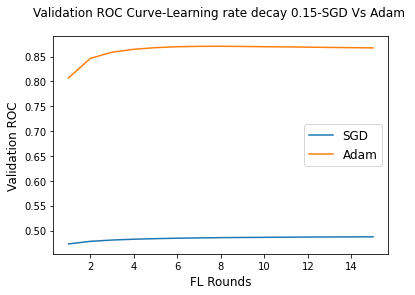

In [22]:
plt.plot(range(1,16),res_w6_c1_LRD_0_15_SGD_iid['val_roc'], label='SGD')
plt.plot(range(1,16),res_w6_c1_LRD_0_15_iid['val_roc'], label='Adam')

plt.title("Validation ROC Curve-Learning rate decay 0.15-SGD Vs Adam ", pad=20)#, fontsize=28)
plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

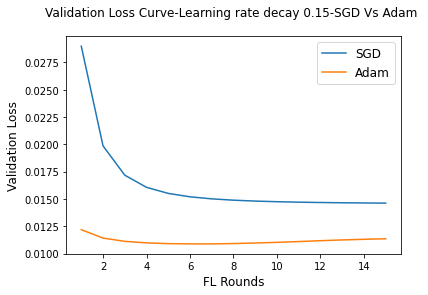

In [21]:
plt.plot(range(1,16),res_w6_c1_LRD_0_15_SGD_iid['val_loss'], label='SGD')
plt.plot(range(1,16),res_w6_c1_LRD_0_15_iid['val_loss'], label='Adam')

plt.title("Validation Loss Curve-Learning rate decay 0.15-SGD Vs Adam ", pad=20)#, fontsize=28)
plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation Loss", fontsize=12)
plt.show()

### 2. Impact of data heterogeneity: IID vs non IID 
Hyperparameters:
- 15 FL rounds
- 5 Epochs local optimization
- 256 batch size
- No learning rate decay

Standard FedAvg alorithm works well with above hyperparameters in the case of IID scenarios. ROC score is similar to the level we had when training the classifier on a centralised dataset.
For non IID scenarios, the algorithm performance deteriorates and the maximum ROC reached is far from the benchmark we had with global training. We also notice the fast decrease in validation ROC after the maximum is reached. 

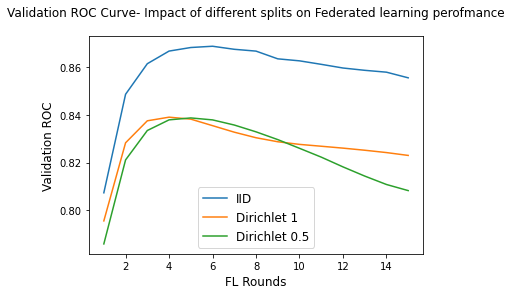

In [41]:
plt.plot(range(1,16),res_w6_c1_iid['val_roc'], label='IID')
plt.plot(range(1,16),res_w6_c1_da1['val_roc'], label='Dirichlet 1')
plt.plot(range(1,16),res_w6_c1_da0_5['val_roc'], label='Dirichlet 0.5')


plt.title("Validation ROC Curve- Impact of different splits on Federated learning perofmance",pad=20)#, fontsize=28)
plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

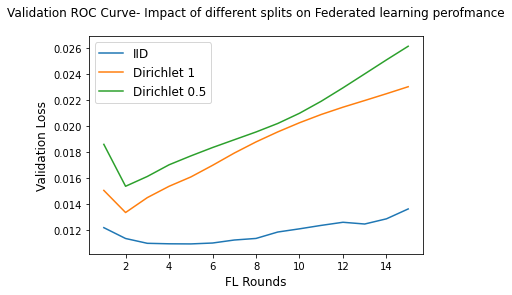

In [42]:
plt.plot(range(1,16),res_w6_c1_iid['val_loss'], label='IID')
plt.plot(range(1,16),res_w6_c1_da1['val_loss'], label='Dirichlet 1')
plt.plot(range(1,16),res_w6_c1_da0_5['val_loss'], label='Dirichlet 0.5')


plt.title("Validation ROC Curve- Impact of different splits on Federated learning perofmance",pad=20)#, fontsize=28)
plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation Loss", fontsize=12)
plt.show()

In [44]:
print("Max ROC IID Scenario Epoch 5:"+str(max(res_w6_c1_iid['val_roc']))+" at "+str(res_w6_c1_iid['val_roc'].index(max(res_w6_c1_iid['val_roc'])))+" FL Rounds")
print("\n")
print("Max ROC Dirichlet 1 Scenario Epoch 5:"+str(max(res_w6_c1_da1['val_roc']))+" at "+str(res_w6_c1_da1['val_roc'].index(max(res_w6_c1_da1['val_roc'])))+" FL Rounds")
print("\n")
print("Max ROC Dirichlet 0.5 Scenario Epoch 5:"+str(max(res_w6_c1_da0_5['val_roc']))+" at "+str(res_w6_c1_da0_5['val_roc'].index(max(res_w6_c1_da0_5['val_roc'])))+" FL Rounds")


Max ROC IID Scenario Epoch 5:0.868805820842729 at 5 FL Rounds


Max ROC Dirichlet 1 Scenario Epoch 5:0.8390660233452714 at 3 FL Rounds


Max ROC Dirichlet 0.5 Scenario Epoch 5:0.8387509948269001 at 4 FL Rounds


### 3. Impact of number of local updates
#### We compare the impact of changing the number of local updates by specifying lower local Epochs
Hyper parameters:
- 15 FL rounds
- 5 and 1 Epoch on local optimization
- 256 batch size
- No learning rate decay

Results show that with higher number of local updates, we can achieve high ROC score with small number of federated learning rounds. Smaller number of updates can only achieve similar ROC score with large number of local updates. 

With Epoch 1, we achieved better ROC score compared to Epoch 5 for Dirichlet 1. however this results was only achieved with larhe number of federated rounds

Overall Epoch 5 seems a good choice for local updates.

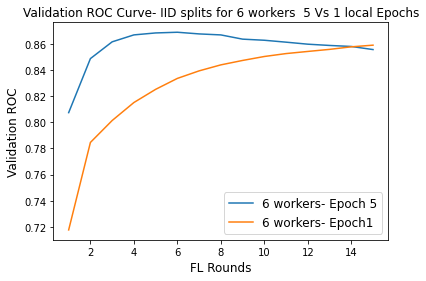

In [33]:
plt.plot(range(1,16),res_w6_c1_iid['val_roc'], label='6 workers- Epoch 5')
plt.plot(range(1,16),res_w6_c1_E1_iid['val_roc'], label='6 workers- Epoch1')


plt.title("Validation ROC Curve- IID splits for 6 workers  5 Vs 1 local Epochs")#, fontsize=28)
plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

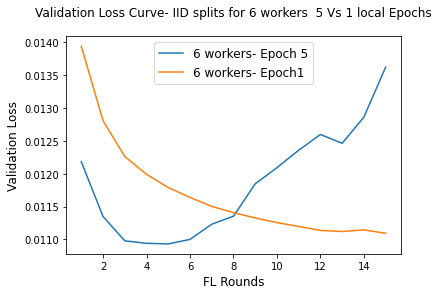

In [34]:
plt.plot(range(1,16),res_w6_c1_iid['val_loss'], label='6 workers- Epoch 5')
plt.plot(range(1,16),res_w6_c1_E1_iid['val_loss'], label='6 workers- Epoch1')


plt.title("Validation Loss Curve- IID splits for 6 workers  5 Vs 1 local Epochs",pad=20)#, fontsize=28)
plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation Loss", fontsize=12)
plt.show()

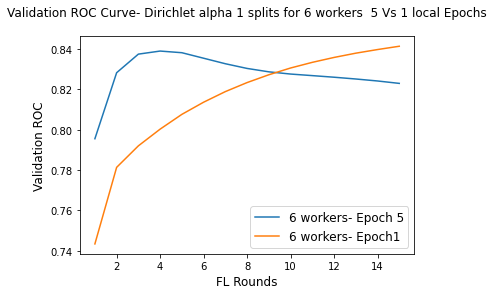

In [31]:
plt.plot(range(1,16),res_w6_c1_da1['val_roc'], label='6 workers- Epoch 5')
plt.plot(range(1,16),res_w6_c1_E1_da1['val_roc'], label='6 workers- Epoch1')


plt.title("Validation ROC Curve- Dirichlet alpha 1 splits for 6 workers  5 Vs 1 local Epochs",pad=20)#, fontsize=28)
plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

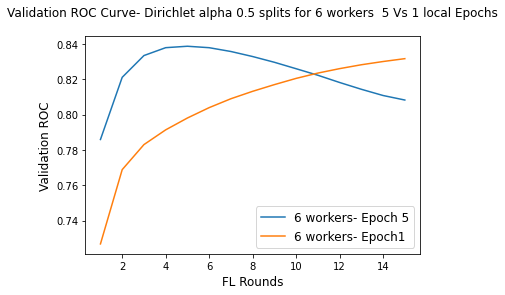

In [30]:
plt.plot(range(1,16),res_w6_c1_da0_5['val_roc'], label='6 workers- Epoch 5')
plt.plot(range(1,16),res_w6_c1_E1_da0_5['val_roc'], label='6 workers- Epoch1')


plt.title("Validation ROC Curve- Dirichlet alpha 0.5 splits for 6 workers  5 Vs 1 local Epochs",pad=20)#, fontsize=28)
plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

In [43]:
print("Max ROC IID Scenario Epoch 5:"+str(max(res_w6_c1_iid['val_roc']))+" at "+str(res_w6_c1_iid['val_roc'].index(max(res_w6_c1_iid['val_roc'])))+" FL Rounds")
print("Max ROC IID Scenario Epoch :"+str(max(res_w6_c1_E1_iid['val_roc']))+" at "+str(res_w6_c1_E1_iid['val_roc'].index(max(res_w6_c1_E1_iid['val_roc'])))+" FL Rounds")
print("\n")
print("Max ROC Dirichlet 1 Scenario Epoch 5:"+str(max(res_w6_c1_da1['val_roc']))+" at "+str(res_w6_c1_da1['val_roc'].index(max(res_w6_c1_da1['val_roc'])))+" FL Rounds")
print("Max ROC Dirichlet 1 Scenario Epoch 1:"+str(max(res_w6_c1_E1_da1['val_roc']))+" at "+str(res_w6_c1_E1_da1['val_roc'].index(max(res_w6_c1_E1_da1['val_roc'])))+" FL Rounds")
print("\n")
print("Max ROC Dirichlet 0.5 Scenario Epoch 5:"+str(max(res_w6_c1_da0_5['val_roc']))+" at "+str(res_w6_c1_da0_5['val_roc'].index(max(res_w6_c1_da0_5['val_roc'])))+" FL Rounds")
print("Max ROC Dirichlet 0.5 Scenario Epoch 1:"+str(max(res_w6_c1_E1_da0_5['val_roc']))+" at "+str(res_w6_c1_E1_da0_5['val_roc'].index(max(res_w6_c1_E1_da0_5['val_roc'])))+" FL Rounds")



Max ROC IID Scenario Epoch 5:0.868805820842729 at 5 FL Rounds
Max ROC IID Scenario Epoch :0.8589287095989742 at 14 FL Rounds


Max ROC Dirichlet 1 Scenario Epoch 5:0.8390660233452714 at 3 FL Rounds
Max ROC Dirichlet 1 Scenario Epoch 1:0.8414549896095858 at 14 FL Rounds


Max ROC Dirichlet 0.5 Scenario Epoch 5:0.8387509948269001 at 4 FL Rounds
Max ROC Dirichlet 0.5 Scenario Epoch 1:0.8317195030286952 at 14 FL Rounds


### 4. Impact of learning rate decay
#### We compare the impact of increasing the learning rate decay
Hyper parameters:
- 15 FL rounds
- 5 Epoch on local optimization
- 256 batch size
- learning rate decay values 0.1 and 0.15 and no learning rate decay

Introducing a learning rate decay improves the stability and performance of FedAvg algorithm. 
We see small improvement for iid splits and significant improvement on non iid scenarios
Max ROC is still achieved afer few federated learning rounds, however it is still far from the results we get with IID or with centralized learning.
We only tested up to 0.15 as we don't want to significantly reduce the learning rates decay for the first rounds as it can lead to reduction of the overall performance of federated learning.  

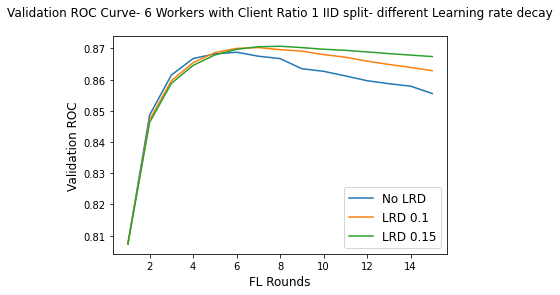

In [48]:
plt.plot(range(1,16),res_w6_c1_iid['val_roc'], label='No LRD')
plt.plot(range(1,16),res_w6_c1_LRD_0_1_iid['val_roc'], label='LRD 0.1')
plt.plot(range(1,16),res_w6_c1_LRD_0_15_iid['val_roc'], label='LRD 0.15')


plt.title("Validation ROC Curve- 6 Workers with Client Ratio 1 IID split- different Learning rate decay",pad=20)#, fontsize=28)
plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

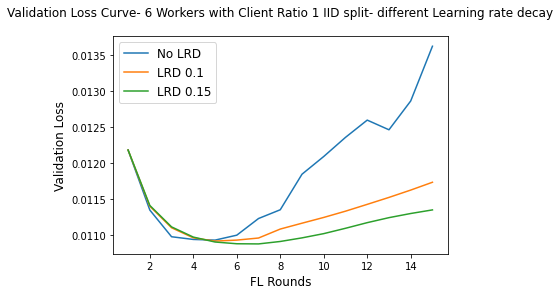

In [53]:
plt.plot(range(1,16),res_w6_c1_iid['val_loss'], label='No LRD')
plt.plot(range(1,16),res_w6_c1_LRD_0_1_iid['val_loss'], label='LRD 0.1')
plt.plot(range(1,16),res_w6_c1_LRD_0_15_iid['val_loss'], label='LRD 0.15')

plt.title("Validation Loss Curve- 6 Workers with Client Ratio 1 IID split- different Learning rate decay",pad=20)#, fontsize=28)
plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation Loss", fontsize=12)
plt.show()

In [54]:
print("Max ROC IID No LRD:"+str(max(res_w6_c1_iid['val_roc']))+" at "+str(res_w6_c1_iid['val_roc'].index(max(res_w6_c1_iid['val_roc'])))+" FL Rounds")
print("Max ROC IID LRD 0.1:"+str(max(res_w6_c1_LRD_0_1_iid['val_roc']))+" at "+str(res_w6_c1_LRD_0_1_iid['val_roc'].index(max(res_w6_c1_LRD_0_1_iid['val_roc'])))+" FL Rounds")
print("Max ROC IID LRD 0.15:"+str(max(res_w6_c1_LRD_0_15_iid['val_roc']))+" at "+str(res_w6_c1_LRD_0_15_iid['val_roc'].index(max(res_w6_c1_LRD_0_15_iid['val_roc'])))+" FL Rounds")


Max ROC IID No LRD:0.868805820842729 at 5 FL Rounds
Max ROC IID LRD 0.1:0.8702904618207543 at 6 FL Rounds
Max ROC IID LRD 0.15:0.8707208626254588 at 7 FL Rounds


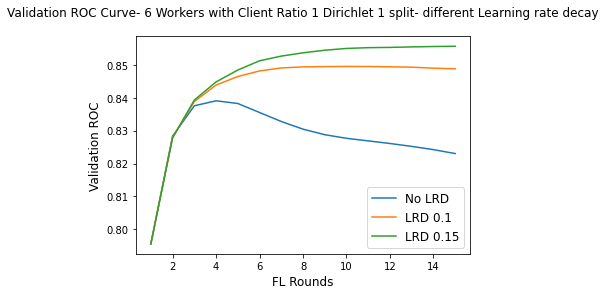

In [57]:
plt.plot(range(1,16),res_w6_c1_da1['val_roc'], label='No LRD')
plt.plot(range(1,16),res_w6_c1_LRD_0_1_da1['val_roc'], label='LRD 0.1')
plt.plot(range(1,16),res_w6_c1_LRD_0_15_da1['val_roc'], label='LRD 0.15')


plt.title("Validation ROC Curve- 6 Workers with Client Ratio 1 Dirichlet 1 split- different Learning rate decay",pad=20)#, fontsize=28)
plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

In [56]:
print("Max ROC Dirichlet 1 No LRD:"+str(max(res_w6_c1_da1['val_roc']))+" at "+str(res_w6_c1_da1['val_roc'].index(max(res_w6_c1_da1['val_roc'])))+" FL Rounds")
print("Max ROC Dirichlet 1 LRD 0.1:"+str(max(res_w6_c1_LRD_0_1_da1['val_roc']))+" at "+str(res_w6_c1_LRD_0_1_da1['val_roc'].index(max(res_w6_c1_LRD_0_1_da1['val_roc'])))+" FL Rounds")
print("Max ROC Dirichlet 1 LRD 0.15:"+str(max(res_w6_c1_LRD_0_15_da1['val_roc']))+" at "+str(res_w6_c1_LRD_0_15_da1['val_roc'].index(max(res_w6_c1_LRD_0_15_da1['val_roc'])))+" FL Rounds")


Max ROC Dirichlet 1 No LRD:0.8390660233452714 at 3 FL Rounds
Max ROC Dirichlet 1 LRD 0.1:0.8495020338683291 at 9 FL Rounds
Max ROC Dirichlet 1 LRD 0.15:0.8556409448644825 at 14 FL Rounds


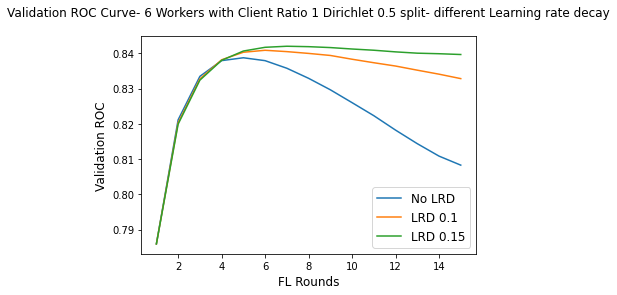

In [58]:
plt.plot(range(1,16),res_w6_c1_da0_5['val_roc'], label='No LRD')
plt.plot(range(1,16),res_w6_c1_LRD_0_1_da0_5['val_roc'], label='LRD 0.1')
plt.plot(range(1,16),res_w6_c1_LRD_0_15_da0_5['val_roc'], label='LRD 0.15')


plt.title("Validation ROC Curve- 6 Workers with Client Ratio 1 Dirichlet 0.5 split- different Learning rate decay",pad=20)#, fontsize=28)
plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

In [59]:
print("Max ROC Dirichlet 0.5 No LRD:"+str(max(res_w6_c1_da0_5['val_roc']))+" at "+str(res_w6_c1_da0_5['val_roc'].index(max(res_w6_c1_da0_5['val_roc'])))+" FL Rounds")
print("Max ROC Dirichlet 0.5 LRD 0.1:"+str(max(res_w6_c1_LRD_0_1_da0_5['val_roc']))+" at "+str(res_w6_c1_LRD_0_1_da0_5['val_roc'].index(max(res_w6_c1_LRD_0_1_da0_5['val_roc'])))+" FL Rounds")
print("Max ROC Dirichlet 0.5 LRD 0.15:"+str(max(res_w6_c1_LRD_0_15_da0_5['val_roc']))+" at "+str(res_w6_c1_LRD_0_15_da0_5['val_roc'].index(max(res_w6_c1_LRD_0_15_da0_5['val_roc'])))+" FL Rounds")


Max ROC Dirichlet 0.5 No LRD:0.8387509948269001 at 4 FL Rounds
Max ROC Dirichlet 0.5 LRD 0.1:0.8408746739178494 at 5 FL Rounds
Max ROC Dirichlet 0.5 LRD 0.15:0.8420201065570145 at 6 FL Rounds


### 5. Impact of higher learning rate
#### We compare the impact of increasing the local learning rate, we will also increase the learning rate decay in this section to 0.3

Hyperparameters:
- 15 FL rounds
- 5 Epoch on local optimization
- 256 batch size


Increasing the learning rate leads as expected to better results for the first rounds but the performance deacreases rapily. using higher learning rate decay does not help to stop the decrease in performance.

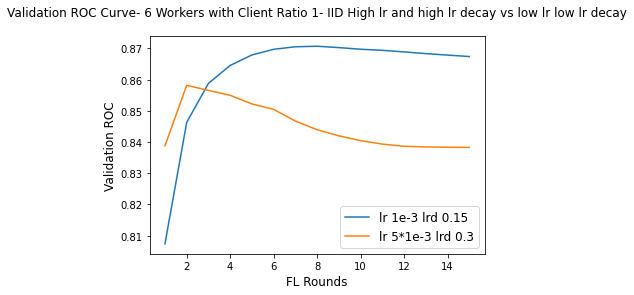

In [66]:
plt.plot(range(1,16),res_w6_c1_LRD_0_15_iid['val_roc'], label='lr 1e-3 lrd 0.15')
plt.plot(range(1,16),res_w6_c1_HLR_LRD_0_3_iid['val_roc'], label='lr 5*1e-3 lrd 0.3')


plt.title("Validation ROC Curve- 6 Workers with Client Ratio 1- IID High lr and high lr decay vs low lr low lr decay",pad=20)#, fontsize=28)
plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

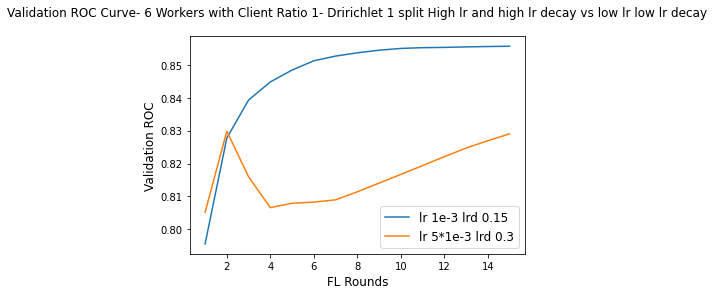

In [65]:
plt.plot(range(1,16),res_w6_c1_LRD_0_15_da1['val_roc'], label='lr 1e-3 lrd 0.15')
plt.plot(range(1,16),res_w6_c1_HLR_LRD_0_3_da1['val_roc'], label='lr 5*1e-3 lrd 0.3')


plt.title("Validation ROC Curve- 6 Workers with Client Ratio 1- Dririchlet 1 split High lr and high lr decay vs low lr low lr decay",pad=20)#, fontsize=28)
plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

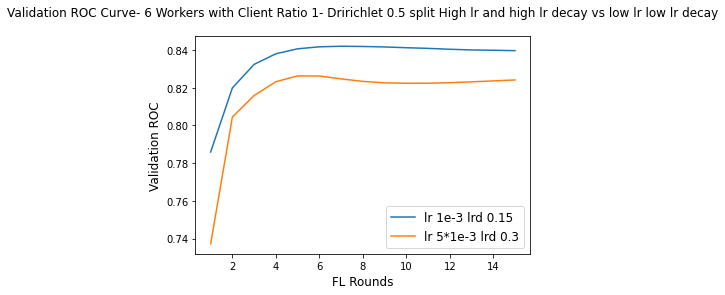

In [64]:
plt.plot(range(1,16),res_w6_c1_LRD_0_15_da0_5['val_roc'], label='lr 1e-3 lrd 0.15')
plt.plot(range(1,16),res_w6_c1_HLR_LRD_0_3_da0_5['val_roc'], label='lr 5*1e-3 lrd 0.3')


plt.title("Validation ROC Curve- 6 Workers with Client Ratio 1- Dririchlet 0.5 split High lr and high lr decay vs low lr low lr decay",pad=20)#, fontsize=28)
plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

### 6. FedAvg with Data augmentation and oversampling

Hyperparameters:
- 15 FL rounds
- 5 Epoch on local optimization
- 256 batch size
- Learning rate decay 0.15 and 0.3

Data augmentation with 20% probability, 20% uniform oversampling on client dataloader

Results show the data augmentation and oversampling improves the perfomances of the IID scenarios in federated learning setup in the same way we observed for central learning, however it will require higher learning rate decay.  
For non iid scenarios, the effect of data augmentation and oversampling does not improve the overall performance. 

Note: base case scenario is the below results is FedAvg with no oversampling and no data augmentation.  


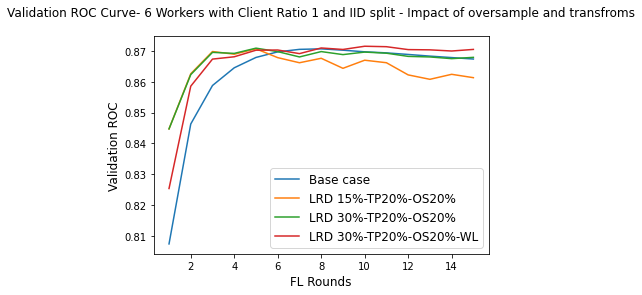

In [68]:
plt.plot(range(1,16),res_w6_c1_LRD_0_15_iid['val_roc'], label='Base case')
plt.plot(range(1,16),res_w6_c1_LRD_0_15_TPOS_iid['val_roc'], label='LRD 15%-TP20%-OS20%')
plt.plot(range(1,16),res_w6_c1_LRD_0_3_TPOS_iid['val_roc'], label='LRD 30%-TP20%-OS20%')
plt.plot(range(1,16),res_w6_c1_LRD_0_3_TPOS_WL_iid['val_roc'], label='LRD 30%-TP20%-OS20%-WL')


plt.title("Validation ROC Curve- 6 Workers with Client Ratio 1 and IID split - Impact of oversample and transfroms",pad=20)#, fontsize=28)
plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

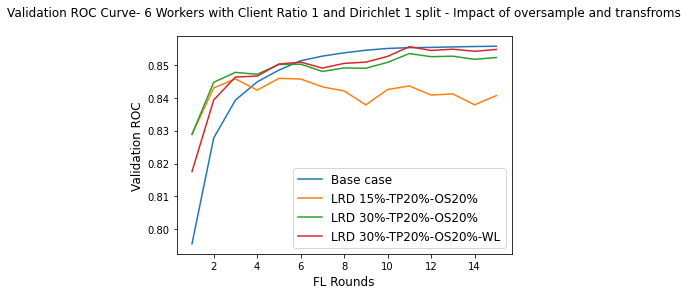

In [69]:
plt.plot(range(1,16),res_w6_c1_LRD_0_15_da1['val_roc'], label='Base case')
plt.plot(range(1,16),res_w6_c1_LRD_0_15_TPOS_da1['val_roc'], label='LRD 15%-TP20%-OS20%')
plt.plot(range(1,16),res_w6_c1_LRD_0_3_TPOS_da1['val_roc'], label='LRD 30%-TP20%-OS20%')
plt.plot(range(1,16),res_w6_c1_LRD_0_3_TPOS_WL_da1['val_roc'], label='LRD 30%-TP20%-OS20%-WL')


plt.title("Validation ROC Curve- 6 Workers with Client Ratio 1 and Dirichlet 1 split - Impact of oversample and transfroms",pad=20)#, fontsize=28)
plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

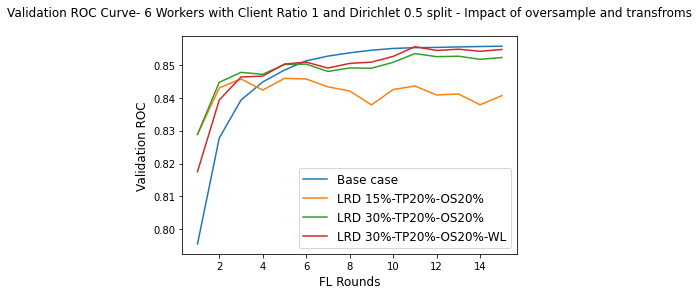

In [70]:
plt.plot(range(1,16),res_w6_c1_LRD_0_15_da1['val_roc'], label='Base case')
plt.plot(range(1,16),res_w6_c1_LRD_0_15_TPOS_da1['val_roc'], label='LRD 15%-TP20%-OS20%')
plt.plot(range(1,16),res_w6_c1_LRD_0_3_TPOS_da1['val_roc'], label='LRD 30%-TP20%-OS20%')
plt.plot(range(1,16),res_w6_c1_LRD_0_3_TPOS_WL_da1['val_roc'], label='LRD 30%-TP20%-OS20%-WL')


plt.title("Validation ROC Curve- 6 Workers with Client Ratio 1 and Dirichlet 0.5 split - Impact of oversample and transfroms",pad=20)#, fontsize=28)
plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

### Testing the federated leanring model on test data- IID scenario split and Learning rate decay 0.15

In [110]:
# learning rate decay 0.15
train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 5

iid_split_image = FeatureLabelUnbalancedScenarioFL(dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.15)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [111]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_iid_FLR7_LB256_E5_LRD_0_15_C1')


 round:0, worker: 3 Training



 epoch: 0, train loss: 0.024110, train acc: 0.9178



 epoch: 1, train loss: 0.013539, train acc: 0.9823



 epoch: 2, train loss: 0.013176, train acc: 0.9823



 epoch: 3, train loss: 0.011957, train acc: 0.9823



 epoch: 4, train loss: 0.011576, train acc: 0.9823
Training Finished
Training: 10.958501815795898 seconds
 round:0, worker: 3 Validation



 val loss: 0.012481, val acc: 0.9830, val roc:0.7899
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.025498, train acc: 0.9184



 epoch: 1, train loss: 0.013329, train acc: 0.9823



 epoch: 2, train loss: 0.012553, train acc: 0.9823



 epoch: 3, train loss: 0.011292, train acc: 0.9823



 epoch: 4, train loss: 0.010525, train acc: 0.9823
Training Finished
Training: 11.351958990097046 seconds
 round:0, worker: 2 Validation



 val loss: 0.012366, val acc: 0.9830, val roc:0.7933
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.025551, train acc: 0.9163



 epoch: 1, train loss: 0.013833, train acc: 0.9823



 epoch: 2, train loss: 0.012563, train acc: 0.9823



 epoch: 3, train loss: 0.011836, train acc: 0.9823



 epoch: 4, train loss: 0.011127, train acc: 0.9823
Training Finished
Training: 11.704422235488892 seconds
 round:0, worker: 5 Validation



 val loss: 0.012152, val acc: 0.9830, val roc:0.8117
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.027617, train acc: 0.9184



 epoch: 1, train loss: 0.013815, train acc: 0.9823



 epoch: 2, train loss: 0.012669, train acc: 0.9823



 epoch: 3, train loss: 0.011863, train acc: 0.9823



 epoch: 4, train loss: 0.011305, train acc: 0.9823
Training Finished
Training: 12.198537588119507 seconds
 round:0, worker: 4 Validation



 val loss: 0.012408, val acc: 0.9830, val roc:0.7934
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.027447, train acc: 0.9178



 epoch: 1, train loss: 0.014593, train acc: 0.9823



 epoch: 2, train loss: 0.012880, train acc: 0.9823



 epoch: 3, train loss: 0.012492, train acc: 0.9823



 epoch: 4, train loss: 0.011797, train acc: 0.9823
Training Finished
Training: 11.980631113052368 seconds
 round:0, worker: 0 Validation



 val loss: 0.012509, val acc: 0.9830, val roc:0.7874
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.026825, train acc: 0.9165



 epoch: 1, train loss: 0.013889, train acc: 0.9821



 epoch: 2, train loss: 0.013119, train acc: 0.9821



 epoch: 3, train loss: 0.012281, train acc: 0.9821



 epoch: 4, train loss: 0.011688, train acc: 0.9821
Training Finished
Training: 12.190046787261963 seconds
 round:0, worker: 1 Validation



 val loss: 0.012274, val acc: 0.9830, val roc:0.8045
 round: 0, avg train loss: 0.011336, avg train acc: 0.9823
 round: 0, avg val loss: 0.012365, avg val acc: 0.9830, avg val roc:0.7967
 round:0, Center Validation



 val loss: 0.012181, val acc: 0.9830, val roc:0.8074
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.012174, train acc: 0.9823



 epoch: 1, train loss: 0.011156, train acc: 0.9823



 epoch: 2, train loss: 0.010691, train acc: 0.9823



 epoch: 3, train loss: 0.010244, train acc: 0.9823



 epoch: 4, train loss: 0.009719, train acc: 0.9826
Training Finished
Training: 4.1509058475494385 seconds
 round:1, worker: 4 Validation



 val loss: 0.011774, val acc: 0.9830, val roc:0.8329
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.013127, train acc: 0.9823



 epoch: 1, train loss: 0.011268, train acc: 0.9823



 epoch: 2, train loss: 0.010728, train acc: 0.9823



 epoch: 3, train loss: 0.010227, train acc: 0.9823



 epoch: 4, train loss: 0.009715, train acc: 0.9823
Training Finished
Training: 4.250632047653198 seconds
 round:1, worker: 5 Validation



 val loss: 0.012399, val acc: 0.9828, val roc:0.8311
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.012852, train acc: 0.9821



 epoch: 1, train loss: 0.011533, train acc: 0.9821



 epoch: 2, train loss: 0.011142, train acc: 0.9821



 epoch: 3, train loss: 0.010803, train acc: 0.9821



 epoch: 4, train loss: 0.010380, train acc: 0.9821
Training Finished
Training: 4.10202956199646 seconds
 round:1, worker: 1 Validation



 val loss: 0.011815, val acc: 0.9828, val roc:0.8370
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.011584, train acc: 0.9823



 epoch: 1, train loss: 0.010737, train acc: 0.9823



 epoch: 2, train loss: 0.010209, train acc: 0.9826



 epoch: 3, train loss: 0.009642, train acc: 0.9826



 epoch: 4, train loss: 0.009065, train acc: 0.9826
Training Finished
Training: 4.200767278671265 seconds
 round:1, worker: 2 Validation



 val loss: 0.013023, val acc: 0.9830, val roc:0.8198
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.012537, train acc: 0.9823



 epoch: 1, train loss: 0.012206, train acc: 0.9823



 epoch: 2, train loss: 0.012316, train acc: 0.9821



 epoch: 3, train loss: 0.012068, train acc: 0.9823



 epoch: 4, train loss: 0.010867, train acc: 0.9823
Training Finished
Training: 4.2087438106536865 seconds
 round:1, worker: 0 Validation



 val loss: 0.011768, val acc: 0.9830, val roc:0.8236
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.012912, train acc: 0.9823



 epoch: 1, train loss: 0.011466, train acc: 0.9823



 epoch: 2, train loss: 0.011245, train acc: 0.9823



 epoch: 3, train loss: 0.010961, train acc: 0.9823



 epoch: 4, train loss: 0.010537, train acc: 0.9823
Training Finished
Training: 4.316457986831665 seconds
 round:1, worker: 3 Validation



 val loss: 0.012398, val acc: 0.9830, val roc:0.8305
 round: 1, avg train loss: 0.010047, avg train acc: 0.9824
 round: 1, avg val loss: 0.012196, avg val acc: 0.9829, avg val roc:0.8292
 round:1, Center Validation



 val loss: 0.011412, val acc: 0.9830, val roc:0.8463
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.012265, train acc: 0.9823



 epoch: 1, train loss: 0.010717, train acc: 0.9823



 epoch: 2, train loss: 0.010379, train acc: 0.9823



 epoch: 3, train loss: 0.010081, train acc: 0.9823



 epoch: 4, train loss: 0.009677, train acc: 0.9821
Training Finished
Training: 4.525896072387695 seconds
 round:2, worker: 3 Validation



 val loss: 0.011792, val acc: 0.9831, val roc:0.8492
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.010641, train acc: 0.9823



 epoch: 1, train loss: 0.009710, train acc: 0.9828



 epoch: 2, train loss: 0.009281, train acc: 0.9828



 epoch: 3, train loss: 0.008767, train acc: 0.9839



 epoch: 4, train loss: 0.008192, train acc: 0.9841
Training Finished
Training: 4.978689432144165 seconds
 round:2, worker: 2 Validation



 val loss: 0.013442, val acc: 0.9827, val roc:0.8263
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.011424, train acc: 0.9823



 epoch: 1, train loss: 0.011096, train acc: 0.9821



 epoch: 2, train loss: 0.011235, train acc: 0.9821



 epoch: 3, train loss: 0.011350, train acc: 0.9823



 epoch: 4, train loss: 0.010345, train acc: 0.9826
Training Finished
Training: 4.221708059310913 seconds
 round:2, worker: 0 Validation



 val loss: 0.011517, val acc: 0.9830, val roc:0.8362
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.011885, train acc: 0.9821



 epoch: 1, train loss: 0.010145, train acc: 0.9823



 epoch: 2, train loss: 0.009710, train acc: 0.9823



 epoch: 3, train loss: 0.009315, train acc: 0.9823



 epoch: 4, train loss: 0.008870, train acc: 0.9826
Training Finished
Training: 4.130953550338745 seconds
 round:2, worker: 5 Validation



 val loss: 0.011949, val acc: 0.9821, val roc:0.8416
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.011573, train acc: 0.9823



 epoch: 1, train loss: 0.010629, train acc: 0.9823



 epoch: 2, train loss: 0.010197, train acc: 0.9823



 epoch: 3, train loss: 0.009776, train acc: 0.9826



 epoch: 4, train loss: 0.009302, train acc: 0.9828
Training Finished
Training: 4.336404800415039 seconds
 round:2, worker: 4 Validation



 val loss: 0.011445, val acc: 0.9828, val roc:0.8460
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.011812, train acc: 0.9821



 epoch: 1, train loss: 0.010751, train acc: 0.9821



 epoch: 2, train loss: 0.010446, train acc: 0.9821



 epoch: 3, train loss: 0.010155, train acc: 0.9823



 epoch: 4, train loss: 0.009781, train acc: 0.9821
Training Finished
Training: 4.3014960289001465 seconds
 round:2, worker: 1 Validation



 val loss: 0.011494, val acc: 0.9827, val roc:0.8483
 round: 2, avg train loss: 0.009361, avg train acc: 0.9827
 round: 2, avg val loss: 0.011940, avg val acc: 0.9827, avg val roc:0.8412
 round:2, Center Validation



 val loss: 0.011115, val acc: 0.9830, val roc:0.8588
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.011182, train acc: 0.9818



 epoch: 1, train loss: 0.009510, train acc: 0.9823



 epoch: 2, train loss: 0.009102, train acc: 0.9823



 epoch: 3, train loss: 0.008736, train acc: 0.9826



 epoch: 4, train loss: 0.008322, train acc: 0.9828
Training Finished
Training: 4.276566505432129 seconds
 round:3, worker: 5 Validation



 val loss: 0.011784, val acc: 0.9821, val roc:0.8499
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.011070, train acc: 0.9826



 epoch: 1, train loss: 0.010014, train acc: 0.9823



 epoch: 2, train loss: 0.009596, train acc: 0.9828



 epoch: 3, train loss: 0.009209, train acc: 0.9826



 epoch: 4, train loss: 0.008784, train acc: 0.9828
Training Finished
Training: 4.435139179229736 seconds
 round:3, worker: 4 Validation



 val loss: 0.011380, val acc: 0.9825, val roc:0.8524
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.010070, train acc: 0.9826



 epoch: 1, train loss: 0.009079, train acc: 0.9839



 epoch: 2, train loss: 0.008684, train acc: 0.9836



 epoch: 3, train loss: 0.008236, train acc: 0.9844



 epoch: 4, train loss: 0.007724, train acc: 0.9844
Training Finished
Training: 4.460070371627808 seconds
 round:3, worker: 2 Validation



 val loss: 0.013417, val acc: 0.9824, val roc:0.8320
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.011358, train acc: 0.9823



 epoch: 1, train loss: 0.010297, train acc: 0.9823



 epoch: 2, train loss: 0.009998, train acc: 0.9823



 epoch: 3, train loss: 0.009717, train acc: 0.9823



 epoch: 4, train loss: 0.009369, train acc: 0.9823
Training Finished
Training: 4.3633317947387695 seconds
 round:3, worker: 1 Validation



 val loss: 0.011351, val acc: 0.9827, val roc:0.8529
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.011434, train acc: 0.9818



 epoch: 1, train loss: 0.010121, train acc: 0.9818



 epoch: 2, train loss: 0.009725, train acc: 0.9821



 epoch: 3, train loss: 0.009365, train acc: 0.9821



 epoch: 4, train loss: 0.008923, train acc: 0.9821
Training Finished
Training: 4.2546210289001465 seconds
 round:3, worker: 3 Validation



 val loss: 0.011560, val acc: 0.9831, val roc:0.8538
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.010813, train acc: 0.9826



 epoch: 1, train loss: 0.010466, train acc: 0.9826



 epoch: 2, train loss: 0.010680, train acc: 0.9826



 epoch: 3, train loss: 0.010748, train acc: 0.9831



 epoch: 4, train loss: 0.009734, train acc: 0.9831
Training Finished
Training: 4.24564528465271 seconds
 round:3, worker: 0 Validation



 val loss: 0.011414, val acc: 0.9830, val roc:0.8430
 round: 3, avg train loss: 0.008809, avg train acc: 0.9829
 round: 3, avg val loss: 0.011818, avg val acc: 0.9826, avg val roc:0.8473
 round:3, Center Validation



 val loss: 0.010973, val acc: 0.9828, val roc:0.8646
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.010640, train acc: 0.9810



 epoch: 1, train loss: 0.009033, train acc: 0.9823



 epoch: 2, train loss: 0.008638, train acc: 0.9826



 epoch: 3, train loss: 0.008297, train acc: 0.9828



 epoch: 4, train loss: 0.007927, train acc: 0.9828
Training Finished
Training: 4.248637914657593 seconds
 round:4, worker: 5 Validation



 val loss: 0.011748, val acc: 0.9810, val roc:0.8555
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.010641, train acc: 0.9826



 epoch: 1, train loss: 0.009511, train acc: 0.9831



 epoch: 2, train loss: 0.009126, train acc: 0.9826



 epoch: 3, train loss: 0.008789, train acc: 0.9826



 epoch: 4, train loss: 0.008423, train acc: 0.9828
Training Finished
Training: 4.364330530166626 seconds
 round:4, worker: 4 Validation



 val loss: 0.011442, val acc: 0.9817, val roc:0.8556
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.010775, train acc: 0.9818



 epoch: 1, train loss: 0.009596, train acc: 0.9818



 epoch: 2, train loss: 0.009189, train acc: 0.9821



 epoch: 3, train loss: 0.008798, train acc: 0.9821



 epoch: 4, train loss: 0.008357, train acc: 0.9823
Training Finished
Training: 4.194781064987183 seconds
 round:4, worker: 3 Validation



 val loss: 0.011521, val acc: 0.9830, val roc:0.8569
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.010359, train acc: 0.9823



 epoch: 1, train loss: 0.009997, train acc: 0.9823



 epoch: 2, train loss: 0.010309, train acc: 0.9826



 epoch: 3, train loss: 0.010325, train acc: 0.9828



 epoch: 4, train loss: 0.009254, train acc: 0.9828
Training Finished
Training: 4.329421520233154 seconds
 round:4, worker: 0 Validation



 val loss: 0.011370, val acc: 0.9825, val roc:0.8473
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.011033, train acc: 0.9823



 epoch: 1, train loss: 0.009944, train acc: 0.9826



 epoch: 2, train loss: 0.009638, train acc: 0.9826



 epoch: 3, train loss: 0.009361, train acc: 0.9826



 epoch: 4, train loss: 0.009033, train acc: 0.9826
Training Finished
Training: 4.679513692855835 seconds
 round:4, worker: 1 Validation



 val loss: 0.011267, val acc: 0.9825, val roc:0.8556
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.009640, train acc: 0.9834



 epoch: 1, train loss: 0.008599, train acc: 0.9841



 epoch: 2, train loss: 0.008253, train acc: 0.9841



 epoch: 3, train loss: 0.007870, train acc: 0.9847



 epoch: 4, train loss: 0.007428, train acc: 0.9849
Training Finished
Training: 4.485010862350464 seconds
 round:4, worker: 2 Validation



 val loss: 0.013190, val acc: 0.9822, val roc:0.8375
 round: 4, avg train loss: 0.008404, avg train acc: 0.9831
 round: 4, avg val loss: 0.011756, avg val acc: 0.9822, avg val roc:0.8514
 round:4, Center Validation



 val loss: 0.010905, val acc: 0.9827, val roc:0.8679
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_iid_FLR7_LB256_E5_LRD_0_15_C1.pth.tar saved.
Training Finished
Training and validation time: 245.55407643318176 seconds


{'avg_train_loss': [0.011336491234639349,
  0.010047151119730794,
  0.009360988795606318,
  0.008809289115409532,
  0.008403690535791005],
 'avg_train_acc': [0.9822759577049749,
  0.9823626278384469,
  0.9827093083723349,
  0.982925983706015,
  0.983055988906223],
 'val_loss': [0.012181325539838053,
  0.01141199583269077,
  0.011114643489403957,
  0.01097331972040001,
  0.010904728480754872],
 'val_acc': [0.9829631883176149,
  0.9829631883176149,
  0.9829631883176149,
  0.9828110739275936,
  0.9826589595375722],
 'val_roc': [0.8073628244241058,
  0.8463158243798913,
  0.8588167915727108,
  0.8645667528849981,
  0.8679298204890127],
 'avg_val_loss': [[0.012480540029835679,
   0.01236591813633743,
   0.012151781879862752,
   0.012407962707531394,
   0.012509061115142862,
   0.012273985169176917],
  [0.011774244664566934,
   0.012399433357008164,
   0.01181493829246339,
   0.013022611296319774,
   0.011767686269521821,
   0.012398284850630782],
  [0.011791721217501546,
   0.01344187487537

In [112]:
Feature_FedAvg_6W_iid_FLR7_LB256_E5_LRD_0_15_C1_test_results, Feature_FedAvg_6W_iid_FLR7_LB256_E5_LRD_0_15_C1_roc_curve_stat = test(t_model, test_loader=test_loader, device=device)

In [113]:
Feature_FedAvg_6W_iid_FLR7_LB256_E5_LRD_0_15_C1_test_results

{'test_accuracy': 0.9812151452891107,
 'test_roc_score': 0.8421100098731678,
 'CM': array([[3343,    1],
        [  63,    0]], dtype=int64)}

In [97]:
# Data augmentation with transfrom probability 20% and uniform oversampling 20% ratio. with focal loss weight adjustment 
# 0.5 Learning rate decay

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.2,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.2)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
local_epochs = 5
n_workers = 6
local_batch = 256
client_ratio = 1
fl_rounds = 5

iid_split_image = FeatureLabelUnbalancedScenarioFL(worker_oversampling="uniform",dirichlet_alpha=100000,split_by='image_name')
iid_workers_split = create_flworker_set(train_loader,n_workers,iid_split_image,local_batch)

# FedAvg aggregator object
fedavg=FedAvgAggregator(fl_rounds,client_ratio,lr_decay = 0.3)
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3,alpha=(0.5/4,0.5))

In [98]:
fl_train_val(t_model, iid_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_FedAvg_6W_DAlpha0_5_FLR5_LB256_E5_LRD_0_3_OS0_2_TP0_2_WL_C1')


 round:0, worker: 3 Training



 epoch: 0, train loss: 0.033904, train acc: 0.7824



 epoch: 1, train loss: 0.022701, train acc: 0.8271



 epoch: 2, train loss: 0.020786, train acc: 0.8245



 epoch: 3, train loss: 0.020460, train acc: 0.8352



 epoch: 4, train loss: 0.018664, train acc: 0.8471
Training Finished
Training: 25.06673288345337 seconds
 round:0, worker: 3 Validation



 val loss: 0.009486, val acc: 0.9831, val roc:0.8039
 round:0, worker: 2 Training



 epoch: 0, train loss: 0.035333, train acc: 0.7852



 epoch: 1, train loss: 0.024525, train acc: 0.8294



 epoch: 2, train loss: 0.021992, train acc: 0.8203



 epoch: 3, train loss: 0.019564, train acc: 0.8263



 epoch: 4, train loss: 0.017760, train acc: 0.8448
Training Finished
Training: 23.566808700561523 seconds
 round:0, worker: 2 Validation



 val loss: 0.009881, val acc: 0.9822, val roc:0.8035
 round:0, worker: 5 Training



 epoch: 0, train loss: 0.034668, train acc: 0.7824



 epoch: 1, train loss: 0.022133, train acc: 0.8359



 epoch: 2, train loss: 0.020107, train acc: 0.8305



 epoch: 3, train loss: 0.018633, train acc: 0.8370



 epoch: 4, train loss: 0.017040, train acc: 0.8352
Training Finished
Training: 24.156416416168213 seconds
 round:0, worker: 5 Validation



 val loss: 0.011553, val acc: 0.9804, val roc:0.8233
 round:0, worker: 4 Training



 epoch: 0, train loss: 0.034376, train acc: 0.7878



 epoch: 1, train loss: 0.022359, train acc: 0.8362



 epoch: 2, train loss: 0.020888, train acc: 0.8370



 epoch: 3, train loss: 0.018673, train acc: 0.8466



 epoch: 4, train loss: 0.017560, train acc: 0.8409
Training Finished
Training: 24.068861484527588 seconds
 round:0, worker: 4 Validation



 val loss: 0.008694, val acc: 0.9824, val roc:0.8040
 round:0, worker: 0 Training



 epoch: 0, train loss: 0.034556, train acc: 0.7780



 epoch: 1, train loss: 0.023244, train acc: 0.8422



 epoch: 2, train loss: 0.020178, train acc: 0.8307



 epoch: 3, train loss: 0.020239, train acc: 0.8419



 epoch: 4, train loss: 0.019739, train acc: 0.8357
Training Finished
Training: 24.571412801742554 seconds
 round:0, worker: 0 Validation



 val loss: 0.011384, val acc: 0.9824, val roc:0.8201
 round:0, worker: 1 Training



 epoch: 0, train loss: 0.034264, train acc: 0.7829



 epoch: 1, train loss: 0.024889, train acc: 0.8292



 epoch: 2, train loss: 0.022909, train acc: 0.8365



 epoch: 3, train loss: 0.021984, train acc: 0.8164



 epoch: 4, train loss: 0.018537, train acc: 0.8357
Training Finished
Training: 24.339680671691895 seconds
 round:0, worker: 1 Validation



 val loss: 0.008156, val acc: 0.9825, val roc:0.8157
 round: 0, avg train loss: 0.018217, avg train acc: 0.8399
 round: 0, avg val loss: 0.009859, avg val acc: 0.9822, avg val roc:0.8117
 round:0, Center Validation



 val loss: 0.009293, val acc: 0.9825, val roc:0.8254
 round:1, worker: 4 Training



 epoch: 0, train loss: 0.020758, train acc: 0.8365



 epoch: 1, train loss: 0.019361, train acc: 0.8339



 epoch: 2, train loss: 0.017250, train acc: 0.8393



 epoch: 3, train loss: 0.016636, train acc: 0.8456



 epoch: 4, train loss: 0.016336, train acc: 0.8497
Training Finished
Training: 13.541448831558228 seconds
 round:1, worker: 4 Validation



 val loss: 0.009113, val acc: 0.9787, val roc:0.8351
 round:1, worker: 5 Training



 epoch: 0, train loss: 0.022196, train acc: 0.8404



 epoch: 1, train loss: 0.018461, train acc: 0.8333



 epoch: 2, train loss: 0.017368, train acc: 0.8365



 epoch: 3, train loss: 0.015228, train acc: 0.8406



 epoch: 4, train loss: 0.014793, train acc: 0.8469
Training Finished
Training: 13.492995977401733 seconds
 round:1, worker: 5 Validation



 val loss: 0.007791, val acc: 0.9787, val roc:0.8324
 round:1, worker: 1 Training



 epoch: 0, train loss: 0.020775, train acc: 0.8268



 epoch: 1, train loss: 0.019109, train acc: 0.8411



 epoch: 2, train loss: 0.017821, train acc: 0.8336



 epoch: 3, train loss: 0.018121, train acc: 0.8474



 epoch: 4, train loss: 0.015990, train acc: 0.8536
Training Finished
Training: 13.105015516281128 seconds
 round:1, worker: 1 Validation



 val loss: 0.007586, val acc: 0.9811, val roc:0.8336
 round:1, worker: 2 Training



 epoch: 0, train loss: 0.019347, train acc: 0.8437



 epoch: 1, train loss: 0.017128, train acc: 0.8523



 epoch: 2, train loss: 0.016362, train acc: 0.8391



 epoch: 3, train loss: 0.015071, train acc: 0.8565



 epoch: 4, train loss: 0.013179, train acc: 0.8723
Training Finished
Training: 13.741575479507446 seconds
 round:1, worker: 2 Validation



 val loss: 0.007791, val acc: 0.9790, val roc:0.8178
 round:1, worker: 0 Training



 epoch: 0, train loss: 0.018633, train acc: 0.8414



 epoch: 1, train loss: 0.018881, train acc: 0.8341



 epoch: 2, train loss: 0.016103, train acc: 0.8367



 epoch: 3, train loss: 0.015878, train acc: 0.8372



 epoch: 4, train loss: 0.016073, train acc: 0.8541
Training Finished
Training: 14.114082098007202 seconds
 round:1, worker: 0 Validation



 val loss: 0.009995, val acc: 0.9749, val roc:0.8252
 round:1, worker: 3 Training



 epoch: 0, train loss: 0.020559, train acc: 0.8406



 epoch: 1, train loss: 0.019592, train acc: 0.8240



 epoch: 2, train loss: 0.018967, train acc: 0.8305



 epoch: 3, train loss: 0.018020, train acc: 0.8339



 epoch: 4, train loss: 0.016961, train acc: 0.8476
Training Finished
Training: 13.860364198684692 seconds
 round:1, worker: 3 Validation



 val loss: 0.010237, val acc: 0.9793, val roc:0.8413
 round: 1, avg train loss: 0.015555, avg train acc: 0.8540
 round: 1, avg val loss: 0.008752, avg val acc: 0.9786, avg val roc:0.8309
 round:1, Center Validation



 val loss: 0.007718, val acc: 0.9819, val roc:0.8586
 round:2, worker: 3 Training



 epoch: 0, train loss: 0.018331, train acc: 0.8411



 epoch: 1, train loss: 0.015805, train acc: 0.8489



 epoch: 2, train loss: 0.015668, train acc: 0.8406



 epoch: 3, train loss: 0.015077, train acc: 0.8492



 epoch: 4, train loss: 0.013993, train acc: 0.8539
Training Finished
Training: 12.509542226791382 seconds
 round:2, worker: 3 Validation



 val loss: 0.009906, val acc: 0.9758, val roc:0.8464
 round:2, worker: 2 Training



 epoch: 0, train loss: 0.018707, train acc: 0.8513



 epoch: 1, train loss: 0.015528, train acc: 0.8583



 epoch: 2, train loss: 0.015930, train acc: 0.8560



 epoch: 3, train loss: 0.014000, train acc: 0.8640



 epoch: 4, train loss: 0.012714, train acc: 0.8710
Training Finished
Training: 12.401893138885498 seconds
 round:2, worker: 2 Validation



 val loss: 0.008050, val acc: 0.9790, val roc:0.8209
 round:2, worker: 0 Training



 epoch: 0, train loss: 0.019460, train acc: 0.8445



 epoch: 1, train loss: 0.018003, train acc: 0.8419



 epoch: 2, train loss: 0.015529, train acc: 0.8411



 epoch: 3, train loss: 0.013837, train acc: 0.8643



 epoch: 4, train loss: 0.013468, train acc: 0.8612
Training Finished
Training: 13.200747013092041 seconds
 round:2, worker: 0 Validation



 val loss: 0.006462, val acc: 0.9813, val roc:0.8475
 round:2, worker: 5 Training



 epoch: 0, train loss: 0.016129, train acc: 0.8419



 epoch: 1, train loss: 0.017084, train acc: 0.8476



 epoch: 2, train loss: 0.016114, train acc: 0.8547



 epoch: 3, train loss: 0.013366, train acc: 0.8661



 epoch: 4, train loss: 0.013952, train acc: 0.8690
Training Finished
Training: 12.423688411712646 seconds
 round:2, worker: 5 Validation



 val loss: 0.008511, val acc: 0.9786, val roc:0.8377
 round:2, worker: 4 Training



 epoch: 0, train loss: 0.018852, train acc: 0.8419



 epoch: 1, train loss: 0.017407, train acc: 0.8495



 epoch: 2, train loss: 0.016188, train acc: 0.8505



 epoch: 3, train loss: 0.016020, train acc: 0.8495



 epoch: 4, train loss: 0.014551, train acc: 0.8697
Training Finished
Training: 11.919005393981934 seconds
 round:2, worker: 4 Validation



 val loss: 0.007885, val acc: 0.9802, val roc:0.8549
 round:2, worker: 1 Training



 epoch: 0, train loss: 0.018687, train acc: 0.8461



 epoch: 1, train loss: 0.017858, train acc: 0.8401



 epoch: 2, train loss: 0.018045, train acc: 0.8445



 epoch: 3, train loss: 0.015600, train acc: 0.8523



 epoch: 4, train loss: 0.014893, train acc: 0.8518
Training Finished
Training: 12.702695846557617 seconds
 round:2, worker: 1 Validation



 val loss: 0.009476, val acc: 0.9782, val roc:0.8464
 round: 2, avg train loss: 0.013929, avg train acc: 0.8628
 round: 2, avg val loss: 0.008382, avg val acc: 0.9789, avg val roc:0.8423
 round:2, Center Validation



 val loss: 0.007215, val acc: 0.9821, val roc:0.8674
 round:3, worker: 5 Training



 epoch: 0, train loss: 0.016124, train acc: 0.8489



 epoch: 1, train loss: 0.017488, train acc: 0.8515



 epoch: 2, train loss: 0.015178, train acc: 0.8606



 epoch: 3, train loss: 0.014257, train acc: 0.8544



 epoch: 4, train loss: 0.014068, train acc: 0.8643
Training Finished
Training: 11.267805337905884 seconds
 round:3, worker: 5 Validation



 val loss: 0.008434, val acc: 0.9776, val roc:0.8571
 round:3, worker: 4 Training



 epoch: 0, train loss: 0.017763, train acc: 0.8502



 epoch: 1, train loss: 0.015662, train acc: 0.8531



 epoch: 2, train loss: 0.015073, train acc: 0.8476



 epoch: 3, train loss: 0.013845, train acc: 0.8583



 epoch: 4, train loss: 0.013512, train acc: 0.8609
Training Finished
Training: 11.79945993423462 seconds
 round:3, worker: 4 Validation



 val loss: 0.007686, val acc: 0.9805, val roc:0.8532
 round:3, worker: 2 Training



 epoch: 0, train loss: 0.014417, train acc: 0.8692



 epoch: 1, train loss: 0.013370, train acc: 0.8731



 epoch: 2, train loss: 0.013691, train acc: 0.8726



 epoch: 3, train loss: 0.012263, train acc: 0.8794



 epoch: 4, train loss: 0.010835, train acc: 0.8921
Training Finished
Training: 11.630889415740967 seconds
 round:3, worker: 2 Validation



 val loss: 0.007066, val acc: 0.9781, val roc:0.8264
 round:3, worker: 1 Training



 epoch: 0, train loss: 0.017103, train acc: 0.8549



 epoch: 1, train loss: 0.016677, train acc: 0.8458



 epoch: 2, train loss: 0.015598, train acc: 0.8604



 epoch: 3, train loss: 0.015787, train acc: 0.8557



 epoch: 4, train loss: 0.015423, train acc: 0.8687
Training Finished
Training: 11.854388952255249 seconds
 round:3, worker: 1 Validation



 val loss: 0.006311, val acc: 0.9821, val roc:0.8493
 round:3, worker: 3 Training



 epoch: 0, train loss: 0.019061, train acc: 0.8422



 epoch: 1, train loss: 0.015817, train acc: 0.8422



 epoch: 2, train loss: 0.015525, train acc: 0.8492



 epoch: 3, train loss: 0.014329, train acc: 0.8476



 epoch: 4, train loss: 0.015336, train acc: 0.8495
Training Finished
Training: 11.765499591827393 seconds
 round:3, worker: 3 Validation



 val loss: 0.008020, val acc: 0.9799, val roc:0.8595
 round:3, worker: 0 Training



 epoch: 0, train loss: 0.016494, train acc: 0.8393



 epoch: 1, train loss: 0.015934, train acc: 0.8396



 epoch: 2, train loss: 0.014808, train acc: 0.8450



 epoch: 3, train loss: 0.013685, train acc: 0.8609



 epoch: 4, train loss: 0.014444, train acc: 0.8601
Training Finished
Training: 11.947022438049316 seconds
 round:3, worker: 0 Validation



 val loss: 0.008375, val acc: 0.9766, val roc:0.8419
 round: 3, avg train loss: 0.013936, avg train acc: 0.8659
 round: 3, avg val loss: 0.007649, avg val acc: 0.9791, avg val roc:0.8479
 round:3, Center Validation



 val loss: 0.006827, val acc: 0.9813, val roc:0.8681
 round:4, worker: 5 Training



 epoch: 0, train loss: 0.014300, train acc: 0.8599



 epoch: 1, train loss: 0.014589, train acc: 0.8617



 epoch: 2, train loss: 0.013538, train acc: 0.8599



 epoch: 3, train loss: 0.013795, train acc: 0.8677



 epoch: 4, train loss: 0.013183, train acc: 0.8752
Training Finished
Training: 11.308592081069946 seconds
 round:4, worker: 5 Validation



 val loss: 0.008382, val acc: 0.9772, val roc:0.8609
 round:4, worker: 4 Training



 epoch: 0, train loss: 0.015421, train acc: 0.8643



 epoch: 1, train loss: 0.016269, train acc: 0.8640



 epoch: 2, train loss: 0.014460, train acc: 0.8713



 epoch: 3, train loss: 0.014605, train acc: 0.8656



 epoch: 4, train loss: 0.013749, train acc: 0.8619
Training Finished
Training: 11.330374240875244 seconds
 round:4, worker: 4 Validation



 val loss: 0.009757, val acc: 0.9764, val roc:0.8522
 round:4, worker: 3 Training



 epoch: 0, train loss: 0.016532, train acc: 0.8565



 epoch: 1, train loss: 0.015769, train acc: 0.8580



 epoch: 2, train loss: 0.014373, train acc: 0.8588



 epoch: 3, train loss: 0.014824, train acc: 0.8508



 epoch: 4, train loss: 0.013580, train acc: 0.8596
Training Finished
Training: 12.401833534240723 seconds
 round:4, worker: 3 Validation



 val loss: 0.006534, val acc: 0.9819, val roc:0.8594
 round:4, worker: 0 Training



 epoch: 0, train loss: 0.016585, train acc: 0.8518



 epoch: 1, train loss: 0.015915, train acc: 0.8458



 epoch: 2, train loss: 0.014367, train acc: 0.8456



 epoch: 3, train loss: 0.015744, train acc: 0.8474



 epoch: 4, train loss: 0.014994, train acc: 0.8599
Training Finished
Training: 12.002977132797241 seconds
 round:4, worker: 0 Validation



 val loss: 0.011432, val acc: 0.9711, val roc:0.8502
 round:4, worker: 1 Training



 epoch: 0, train loss: 0.015487, train acc: 0.8653



 epoch: 1, train loss: 0.017596, train acc: 0.8385



 epoch: 2, train loss: 0.015943, train acc: 0.8536



 epoch: 3, train loss: 0.013947, train acc: 0.8541



 epoch: 4, train loss: 0.015063, train acc: 0.8596
Training Finished
Training: 11.18408989906311 seconds
 round:4, worker: 1 Validation



 val loss: 0.009912, val acc: 0.9763, val roc:0.8461
 round:4, worker: 2 Training



 epoch: 0, train loss: 0.013288, train acc: 0.8703



 epoch: 1, train loss: 0.013341, train acc: 0.8799



 epoch: 2, train loss: 0.013471, train acc: 0.8794



 epoch: 3, train loss: 0.012386, train acc: 0.8833



 epoch: 4, train loss: 0.011266, train acc: 0.8840
Training Finished
Training: 10.994880437850952 seconds
 round:4, worker: 2 Validation



 val loss: 0.006318, val acc: 0.9796, val roc:0.8338
 round: 4, avg train loss: 0.013639, avg train acc: 0.8667
 round: 4, avg val loss: 0.008722, avg val acc: 0.9771, avg val roc:0.8504
 round:4, Center Validation



 val loss: 0.007563, val acc: 0.9802, val roc:0.8703
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_FedAvg_6W_DAlpha0_5_FLR5_LB256_E5_LRD_0_3_OS0_2_TP0_2_WL_C1.pth.tar saved.
Training Finished
Training and validation time: 516.0648891925812 seconds


{'avg_train_loss': [0.018216743798499618,
  0.01555541530251503,
  0.013928558849632585,
  0.01393614272456034,
  0.013639276284569254],
 'avg_train_acc': [0.8398769284104697,
  0.8540474952331426,
  0.8627578436470791,
  0.8659213035188073,
  0.8667013347200555],
 'val_loss': [0.009293009007114519,
  0.007718300577976461,
  0.007215321656244183,
  0.006826995397257863,
  0.0075633222558219165],
 'val_acc': [0.9825068451475509,
  0.9818983875874657,
  0.9820505019774871,
  0.9812899300273806,
  0.9802251292972315],
 'val_roc': [0.8253539925719592,
  0.8585991731883096,
  0.8673923376221426,
  0.868143984613344,
  0.8702787173365167],
 'avg_val_loss': [[0.009486027163661365,
   0.009880619625407226,
   0.011553147837103716,
   0.008694411528938748,
   0.011384032933421216,
   0.0081561054363033],
  [0.009112522047853948,
   0.007790687741503771,
   0.007585798146076573,
   0.007790592355536098,
   0.009994545495996559,
   0.010237443448469332],
  [0.00990572298913109,
   0.0080496976383

In [99]:
Feature_FedAvg_6W_DAlpha0_5_FLR5_LB256_E5_LRD_0_3_OS0_2_TP0_2_WL_C1_test_results, Feature_FedAvg_6W_DAlpha0_5_FLR5_LB256_E5_LRD_0_3_OS0_2_TP0_2_WL_C1_roc_curve_stat = test(t_model, test_loader=test_loader, device=device)

In [100]:
Feature_FedAvg_6W_DAlpha0_5_FLR5_LB256_E5_LRD_0_3_OS0_2_TP0_2_WL_C1_test_results

{'test_accuracy': 0.9788670384502495,
 'test_roc_score': 0.8397841193893827,
 'CM': array([[3334,   10],
        [  62,    1]], dtype=int64)}

### Central learning

In [103]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=True,
                                            transform_prob=0.2,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=512, oversampling_ratio=0.2)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 5

# Instantiate Model
t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3,alpha=(0.5/4,0.5))
optimizer= optim.Adam(t_model.parameters(), lr=learning_rate)


In [105]:
FeatureDS_FocalLossG3W4_TLS_HLR_B512_A512x256_OS20_TP20_training= train_val_clip(t_model, train_loader, val_loader, epochs,
                                     optimizer, criterion, device,
                                                                   checkpoint_name="FeatureDS_FocalLossG3W4_TLS_HLR_B512_A512x256_OS20_TP20_training")


 epoch: 0, train loss: 0.020187, val loss: 0.009865, train acc: 0.8377, val acc: 0.9827, val roc:0.8240



 epoch: 1, train loss: 0.018814, val loss: 0.008087, train acc: 0.8375, val acc: 0.9830, val roc:0.8500



 epoch: 2, train loss: 0.018204, val loss: 0.009329, train acc: 0.8375, val acc: 0.9821, val roc:0.8623



 epoch: 3, train loss: 0.017278, val loss: 0.009920, train acc: 0.8432, val acc: 0.9804, val roc:0.8614



 epoch: 4, train loss: 0.016418, val loss: 0.007612, train acc: 0.8455, val acc: 0.9811, val roc:0.8702
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_FeatureDS_FocalLossG3W4_TLS_HLR_B512_A512x256_OS20_TP20_training.pth.tar saved.
Training Finished
Training and validation time: 125.93743014335632 seconds


In [106]:
FeatureDS_FocalLossG3W4_TLS_HLR_B512_A512x256_OS20_TP20_test_results, FeatureDS_FocalLossG3W4_TLS_HLR_B512_A512x256_OS20_TP20_roc_curve_stat = test(t_model, test_loader=test_loader, device=device)

In [107]:
FeatureDS_FocalLossG3W4_TLS_HLR_B512_A512x256_OS20_TP20_test_results

{'test_accuracy': 0.9791605518051071,
 'test_roc_score': 0.8467950178476493,
 'CM': array([[3335,    9],
        [  62,    1]], dtype=int64)}

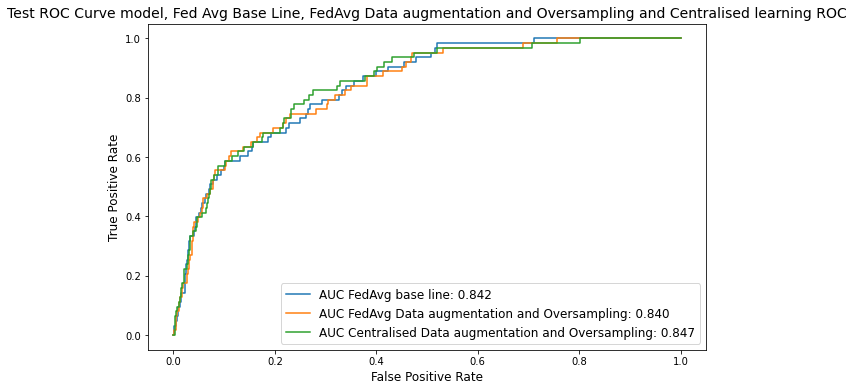

In [114]:
fig=plt.figure(figsize=(10,6))
AUC="{:.3f}".format(Feature_FedAvg_6W_iid_FLR7_LB256_E5_LRD_0_15_C1_roc_curve_stat ['AUC'])
AUC_focal="{:.3f}".format(Feature_FedAvg_6W_DAlpha0_5_FLR5_LB256_E5_LRD_0_3_OS0_2_TP0_2_WL_C1_roc_curve_stat['AUC'])
AUC_central="{:.3f}".format(FeatureDS_FocalLossG3W4_TLS_HLR_B512_A512x256_OS20_TP20_roc_curve_stat['AUC'])


score= "AUC FedAvg base line: " + str(AUC)
score_focal= "AUC FedAvg Data augmentation and Oversampling: " + str(AUC_focal)
score_central= "AUC Centralised Data augmentation and Oversampling: " + str(AUC_central)

plt.plot(Feature_FedAvg_6W_iid_FLR7_LB256_E5_LRD_0_15_C1_roc_curve_stat['fpr'],Feature_FedAvg_6W_iid_FLR7_LB256_E5_LRD_0_15_C1_roc_curve_stat['tpr'], label=score)
plt.plot(Feature_FedAvg_6W_DAlpha0_5_FLR5_LB256_E5_LRD_0_3_OS0_2_TP0_2_WL_C1_roc_curve_stat['fpr'],Feature_FedAvg_6W_DAlpha0_5_FLR5_LB256_E5_LRD_0_3_OS0_2_TP0_2_WL_C1_roc_curve_stat['tpr'], label=score_focal)
plt.plot(FeatureDS_FocalLossG3W4_TLS_HLR_B512_A512x256_OS20_TP20_roc_curve_stat['fpr'],FeatureDS_FocalLossG3W4_TLS_HLR_B512_A512x256_OS20_TP20_roc_curve_stat['tpr'], label=score_central)

plt.title("Test ROC Curve model, Fed Avg Base Line, FedAvg Data augmentation and Oversampling and Centralised learning ROC", fontsize=14)
plt.legend(fontsize=12)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.show()

#### Conclusion
FedAvg algorithm shows a good learning perofrmance for IID dataset split, the results are comparable to the ones we had for centralized model. This result can be achieved by choosing a learning rate decay that gives stability of he model and ensures convergence. 
The impact of data augmentation and oversampling is also comparable to central model and can improve the model performance. 

For non iid scenarios, FedAvg did not show good performance. Tweeks to the learning rate and learning rate decay did not help improve the overall performance of the algorithm. The impact of data augmentation and oversampling was also limited for non iid scenarions.

This shows the limitation of the FedAvg for non iid scenarios and suggests further improvement may be needed to the aggregation or the local optimization